# Teste 3

In [1]:
import sys
print(sys.executable)

/home/magda/tf-gpu-env/bin/python3.10


**Ver se está a usar a GPU**

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2025-06-27 02:07:41.573911: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-06-27 02:07:42.690972: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14041731403215723600
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2351693824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16219991731416257266
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2025-06-27 02:07:44.394609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:07:44.498446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:07:44.498501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:07:44.678321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:07:44.678398: I tensorflow/compile

**imports**

In [3]:
import os
# Ativa o alocador assíncrono (melhora fragmentação de memória)
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
# Ativa a alocação dinâmica de memória (não ocupa toda a memória no início)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Erro ao definir memory growth:", e)
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dense, ReLU, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_auc_score

print("TensorFlow:", tf.__version__)
print("TensorFlow Addons:", tfa.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)

2025-06-27 02:07:44.689007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:07:44.689117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:07:44.689152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
/home/magda/tf-gpu-env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.


TensorFlow: 2.13.0
TensorFlow Addons: 0.21.0
NumPy: 1.23.5
Pandas: 1.5.3
Matplotlib: 3.7.1


## Arquitetura do Modelo:

In [4]:
# Entrada
input_layer = Input(shape=(224, 224, 3))

# Primeira camada
x = Conv2D(48, (3,3), strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(24, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(72, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(24, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_1
for _ in range(2):
    x = Conv2D(72, (1,1), strides=1, padding='same')(x)  # 24 -> 72
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(24, (1,1), strides=1, padding='same')(x)  # 72 -> 24
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
# Expandir de novo
x = Conv2D(72, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(56, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_2
for _ in range(2):
    x = Conv2D(168, (1,1), strides=1, padding='same')(x)  # 56 -> 168
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(56, (1,1), strides=1, padding='same')(x)  # 168 -> 56
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Expandir de novo
x = Conv2D(336, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(104, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_3
for _ in range(2):
    x = Conv2D(624, (1,1), strides=1, padding='same')(x)  # 104 -> 624
    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = Conv2D(104, (1,1), strides=1, padding='same')(x)  # 624 -> 104
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Expandir
x = Conv2D(624, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(136, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_4
x = Conv2D(816, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(136, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Entre conv_blocks
x = Conv2D(816, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(272, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_5
for _ in range(3):
    x = Conv2D(1632, (1,1), strides=1, padding='same')(x)  # 272 -> 1632
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(272, (1,1), strides=1, padding='same')(x)  # 1632 -> 272
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Finalização
x = Conv2D(1632, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(448, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(1280, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Pooling global e classificação
x = GlobalAveragePooling2D()(x)
output_layer = Dense(2, activation='softmax')(x)

# Modelo
model = Model(inputs=input_layer, outputs=output_layer)

2025-06-27 02:07:45.659613: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:07:45.659736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:07:45.659782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:07:45.660133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 02:07:45.660149: I tensorflow/core/co

In [5]:
# Compilar o modelo
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=2, average='macro')
    ]
)

In [6]:
# Mostrar resumo
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         


 conv2d (Conv2D)             (None, 112, 112, 48)      1344      


 batch_normalization (Batch  (None, 112, 112, 48)      192       


 Normalization)                                                  


 re_lu (ReLU)                (None, 112, 112, 48)      0         


 depthwise_conv2d (Depthwis  (None, 112, 112, 48)      480       


 eConv2D)                                                        


 batch_normalization_1 (Bat  (None, 112, 112, 48)      192       


 chNormalization)                                                


 re_lu_1 (ReLU)              (None, 112, 112, 48)      0         


 conv2d_1 (Conv2D)           (None, 112, 112, 24)      1176      


 batch_normalization_2 (Bat  (None, 112, 112, 24)      96        


 chNormalization)                                                


 re_lu_2 (ReLU)              (None, 112, 112, 24)      0         


 conv2d_2 (Conv2D)           (None, 112, 112, 72)      1800      


 batch_normalization_3 (Bat  (None, 112, 112, 72)      288       


 chNormalization)                                                


 re_lu_3 (ReLU)              (None, 112, 112, 72)      0         


 depthwise_conv2d_1 (Depthw  (None, 56, 56, 72)        720       


 iseConv2D)                                                      


 batch_normalization_4 (Bat  (None, 56, 56, 72)        288       


 chNormalization)                                                


 re_lu_4 (ReLU)              (None, 56, 56, 72)        0         


 conv2d_3 (Conv2D)           (None, 56, 56, 24)        1752      


 batch_normalization_5 (Bat  (None, 56, 56, 24)        96        


 chNormalization)                                                


 re_lu_5 (ReLU)              (None, 56, 56, 24)        0         


 conv2d_4 (Conv2D)           (None, 56, 56, 72)        1800      


 batch_normalization_6 (Bat  (None, 56, 56, 72)        288       


 chNormalization)                                                


 re_lu_6 (ReLU)              (None, 56, 56, 72)        0         


 depthwise_conv2d_2 (Depthw  (None, 56, 56, 72)        720       


 iseConv2D)                                                      


 batch_normalization_7 (Bat  (None, 56, 56, 72)        288       


 chNormalization)                                                


 re_lu_7 (ReLU)              (None, 56, 56, 72)        0         


 conv2d_5 (Conv2D)           (None, 56, 56, 24)        1752      


 batch_normalization_8 (Bat  (None, 56, 56, 24)        96        


 chNormalization)                                                


 re_lu_8 (ReLU)              (None, 56, 56, 24)        0         


 conv2d_6 (Conv2D)           (None, 56, 56, 72)        1800      


 batch_normalization_9 (Bat  (None, 56, 56, 72)        288       


 chNormalization)                                                


 re_lu_9 (ReLU)              (None, 56, 56, 72)        0         


 depthwise_conv2d_3 (Depthw  (None, 56, 56, 72)        720       


 iseConv2D)                                                      


 batch_normalization_10 (Ba  (None, 56, 56, 72)        288       


 tchNormalization)                                               


 re_lu_10 (ReLU)             (None, 56, 56, 72)        0         


 conv2d_7 (Conv2D)           (None, 56, 56, 24)        1752      


 batch_normalization_11 (Ba  (None, 56, 56, 24)        96        


 tchNormalization)                                               


 re_lu_11 (ReLU)             (None, 56, 56, 24)        0         


 conv2d_8 (Conv2D)           (None, 56, 56, 72)        1800      


 batch_normalization_12 (Ba  (None, 56, 56, 72)        288       


 tchNormalization)                                               


 re_lu_12 (ReLU)             (None, 56, 56, 72)        0         


 depthwise_conv2d_4 (Depthw  (None, 28, 28, 72)        1872      


 iseConv2D)                                                      


 batch_normalization_13 (Ba  (None, 28, 28, 72)        288       


 tchNormalization)                                               


 re_lu_13 (ReLU)             (None, 28, 28, 72)        0         


 conv2d_9 (Conv2D)           (None, 28, 28, 56)        4088      


 batch_normalization_14 (Ba  (None, 28, 28, 56)        224       


 tchNormalization)                                               


 re_lu_14 (ReLU)             (None, 28, 28, 56)        0         


 conv2d_10 (Conv2D)          (None, 28, 28, 168)       9576      


 batch_normalization_15 (Ba  (None, 28, 28, 168)       672       


 tchNormalization)                                               


 re_lu_15 (ReLU)             (None, 28, 28, 168)       0         


 depthwise_conv2d_5 (Depthw  (None, 28, 28, 168)       4368      


 iseConv2D)                                                      


 batch_normalization_16 (Ba  (None, 28, 28, 168)       672       


 tchNormalization)                                               


 re_lu_16 (ReLU)             (None, 28, 28, 168)       0         


 conv2d_11 (Conv2D)          (None, 28, 28, 56)        9464      


 batch_normalization_17 (Ba  (None, 28, 28, 56)        224       


 tchNormalization)                                               


 re_lu_17 (ReLU)             (None, 28, 28, 56)        0         


 conv2d_12 (Conv2D)          (None, 28, 28, 168)       9576      


 batch_normalization_18 (Ba  (None, 28, 28, 168)       672       


 tchNormalization)                                               


 re_lu_18 (ReLU)             (None, 28, 28, 168)       0         


 depthwise_conv2d_6 (Depthw  (None, 28, 28, 168)       4368      


 iseConv2D)                                                      


 batch_normalization_19 (Ba  (None, 28, 28, 168)       672       


 tchNormalization)                                               


 re_lu_19 (ReLU)             (None, 28, 28, 168)       0         


 conv2d_13 (Conv2D)          (None, 28, 28, 56)        9464      


 batch_normalization_20 (Ba  (None, 28, 28, 56)        224       


 tchNormalization)                                               


 re_lu_20 (ReLU)             (None, 28, 28, 56)        0         


 conv2d_14 (Conv2D)          (None, 28, 28, 336)       19152     


 batch_normalization_21 (Ba  (None, 28, 28, 336)       1344      


 tchNormalization)                                               


 re_lu_21 (ReLU)             (None, 28, 28, 336)       0         


 depthwise_conv2d_7 (Depthw  (None, 14, 14, 336)       8736      


 iseConv2D)                                                      


 batch_normalization_22 (Ba  (None, 14, 14, 336)       1344      


 tchNormalization)                                               


 re_lu_22 (ReLU)             (None, 14, 14, 336)       0         


 conv2d_15 (Conv2D)          (None, 14, 14, 104)       35048     


 batch_normalization_23 (Ba  (None, 14, 14, 104)       416       


 tchNormalization)                                               


 re_lu_23 (ReLU)             (None, 14, 14, 104)       0         


 conv2d_16 (Conv2D)          (None, 14, 14, 624)       65520     


 batch_normalization_24 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_24 (ReLU)             (None, 14, 14, 624)       0         


 depthwise_conv2d_8 (Depthw  (None, 14, 14, 624)       16224     


 iseConv2D)                                                      


 batch_normalization_25 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_25 (ReLU)             (None, 14, 14, 624)       0         


 conv2d_17 (Conv2D)          (None, 14, 14, 104)       65000     


 batch_normalization_26 (Ba  (None, 14, 14, 104)       416       


 tchNormalization)                                               


 re_lu_26 (ReLU)             (None, 14, 14, 104)       0         


 conv2d_18 (Conv2D)          (None, 14, 14, 624)       65520     


 batch_normalization_27 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_27 (ReLU)             (None, 14, 14, 624)       0         


 depthwise_conv2d_9 (Depthw  (None, 14, 14, 624)       16224     


 iseConv2D)                                                      


 batch_normalization_28 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_28 (ReLU)             (None, 14, 14, 624)       0         


 conv2d_19 (Conv2D)          (None, 14, 14, 104)       65000     


 batch_normalization_29 (Ba  (None, 14, 14, 104)       416       


 tchNormalization)                                               


 re_lu_29 (ReLU)             (None, 14, 14, 104)       0         


 conv2d_20 (Conv2D)          (None, 14, 14, 624)       65520     


 batch_normalization_30 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_30 (ReLU)             (None, 14, 14, 624)       0         


 depthwise_conv2d_10 (Depth  (None, 14, 14, 624)       6240      


 wiseConv2D)                                                     


 batch_normalization_31 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_31 (ReLU)             (None, 14, 14, 624)       0         


 conv2d_21 (Conv2D)          (None, 14, 14, 136)       85000     


 batch_normalization_32 (Ba  (None, 14, 14, 136)       544       


 tchNormalization)                                               


 re_lu_32 (ReLU)             (None, 14, 14, 136)       0         


 conv2d_22 (Conv2D)          (None, 14, 14, 816)       111792    


 batch_normalization_33 (Ba  (None, 14, 14, 816)       3264      


 tchNormalization)                                               


 re_lu_33 (ReLU)             (None, 14, 14, 816)       0         


 depthwise_conv2d_11 (Depth  (None, 14, 14, 816)       8160      


 wiseConv2D)                                                     


 batch_normalization_34 (Ba  (None, 14, 14, 816)       3264      


 tchNormalization)                                               


 re_lu_34 (ReLU)             (None, 14, 14, 816)       0         


 conv2d_23 (Conv2D)          (None, 14, 14, 136)       111112    


 batch_normalization_35 (Ba  (None, 14, 14, 136)       544       


 tchNormalization)                                               


 re_lu_35 (ReLU)             (None, 14, 14, 136)       0         


 conv2d_24 (Conv2D)          (None, 14, 14, 816)       111792    


 batch_normalization_36 (Ba  (None, 14, 14, 816)       3264      


 tchNormalization)                                               


 re_lu_36 (ReLU)             (None, 14, 14, 816)       0         


 depthwise_conv2d_12 (Depth  (None, 7, 7, 816)         21216     


 wiseConv2D)                                                     


 batch_normalization_37 (Ba  (None, 7, 7, 816)         3264      


 tchNormalization)                                               


 re_lu_37 (ReLU)             (None, 7, 7, 816)         0         


 conv2d_25 (Conv2D)          (None, 7, 7, 272)         222224    


 batch_normalization_38 (Ba  (None, 7, 7, 272)         1088      


 tchNormalization)                                               


 re_lu_38 (ReLU)             (None, 7, 7, 272)         0         


 conv2d_26 (Conv2D)          (None, 7, 7, 1632)        445536    


 batch_normalization_39 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_39 (ReLU)             (None, 7, 7, 1632)        0         


 depthwise_conv2d_13 (Depth  (None, 7, 7, 1632)        42432     


 wiseConv2D)                                                     


 batch_normalization_40 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_40 (ReLU)             (None, 7, 7, 1632)        0         


 conv2d_27 (Conv2D)          (None, 7, 7, 272)         444176    


 batch_normalization_41 (Ba  (None, 7, 7, 272)         1088      


 tchNormalization)                                               


 re_lu_41 (ReLU)             (None, 7, 7, 272)         0         


 conv2d_28 (Conv2D)          (None, 7, 7, 1632)        445536    


 batch_normalization_42 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_42 (ReLU)             (None, 7, 7, 1632)        0         


 depthwise_conv2d_14 (Depth  (None, 7, 7, 1632)        42432     


 wiseConv2D)                                                     


 batch_normalization_43 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_43 (ReLU)             (None, 7, 7, 1632)        0         


 conv2d_29 (Conv2D)          (None, 7, 7, 272)         444176    


 batch_normalization_44 (Ba  (None, 7, 7, 272)         1088      


 tchNormalization)                                               


 re_lu_44 (ReLU)             (None, 7, 7, 272)         0         


 conv2d_30 (Conv2D)          (None, 7, 7, 1632)        445536    


 batch_normalization_45 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_45 (ReLU)             (None, 7, 7, 1632)        0         


 depthwise_conv2d_15 (Depth  (None, 7, 7, 1632)        42432     


 wiseConv2D)                                                     


 batch_normalization_46 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_46 (ReLU)             (None, 7, 7, 1632)        0         


 conv2d_31 (Conv2D)          (None, 7, 7, 272)         444176    


 batch_normalization_47 (Ba  (None, 7, 7, 272)         1088      


 tchNormalization)                                               


 re_lu_47 (ReLU)             (None, 7, 7, 272)         0         


 conv2d_32 (Conv2D)          (None, 7, 7, 1632)        445536    


 batch_normalization_48 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_48 (ReLU)             (None, 7, 7, 1632)        0         


 depthwise_conv2d_16 (Depth  (None, 7, 7, 1632)        16320     


 wiseConv2D)                                                     


 batch_normalization_49 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_49 (ReLU)             (None, 7, 7, 1632)        0         


 conv2d_33 (Conv2D)          (None, 7, 7, 448)         731584    


 batch_normalization_50 (Ba  (None, 7, 7, 448)         1792      


 tchNormalization)                                               


 re_lu_50 (ReLU)             (None, 7, 7, 448)         0         


 conv2d_34 (Conv2D)          (None, 7, 7, 1280)        574720    


 batch_normalization_51 (Ba  (None, 7, 7, 1280)        5120      


 tchNormalization)                                               


 re_lu_51 (ReLU)             (None, 7, 7, 1280)        0         


 global_average_pooling2d (  (None, 1280)              0         


 GlobalAveragePooling2D)                                         


 dense (Dense)               (None, 2)                 2562      


Total params: 5840002 (22.28 MB)


Trainable params: 5788514 (22.08 MB)


Non-trainable params: 51488 (201.12 KB)


_________________________________________________________________


## Funções Auxiliares

Trata do pré-processamento das imagens, ou seja redimensiona para 224 X 224 pixels e normaliza [0,1] e coloca em one hot.

In [7]:
# Função auxiliar para carregar imagem
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    label = tf.one_hot(label, 2)
    return image, label

Permite analisar a distribuição dos datasets.

In [8]:
def inspect_dataset_distribution(dataset, name="dataset"):
    total_samples = 0
    label_counter = Counter()

    for images, labels in dataset:
        # labels vêm em one-hot: [0,1] ou [1,0]
        labels_np = labels.numpy()
        class_indices = labels_np.argmax(axis=1)  # <-- Corrigir: pegar o índice da classe correta
        total_samples += len(class_indices)
        label_counter.update(class_indices)

    print(f"📊 {name.upper()} -> Total de imagens: {total_samples}")
    for label, count in sorted(label_counter.items()):
        perc = (count / total_samples) * 100
        print(f"  Classe {int(label)} ({'Fogo' if label == 1 else 'Sem fogo'}): {count} imagens ({perc:.2f}%)")
    print("-" * 40)

Permite analisar o histórico de trino.

In [9]:
def plot_training_history(history):
    metrics = history.history.keys()
    epochs_range = range(len(history.history['loss']))

    for metric in metrics:
        if "val_" not in metric:
            plt.figure(figsize=(10, 5))
            plt.plot(epochs_range, history.history[metric], label=f"Train {metric}")
            if f"val_{metric}" in metrics:
                plt.plot(epochs_range, history.history[f"val_{metric}"], label=f"Val {metric}")
            plt.title(f"Training and Validation {metric.capitalize()}")
            plt.xlabel("Epochs")
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True)
            plt.show()

Usada para avaliar o modelo, ou seja, se está a prever corretamente a classificação das imagens.

In [10]:
def avaliar_modelo(model, dataset):
    # 1. Previsões e rótulos reais
    y_pred_probs = model.predict(dataset, verbose=0)
    y_true = np.concatenate([y for _, y in dataset], axis=0)
    y_true_int = np.argmax(y_true, axis=1)
    y_pred_int = (y_pred_probs[:, 1] > 0.5).astype(int)

    # 2. Contagem das classes
    TP = np.sum((y_true_int == 1) & (y_pred_int == 1))
    TN = np.sum((y_true_int == 0) & (y_pred_int == 0))
    FP = np.sum((y_true_int == 0) & (y_pred_int == 1))
    FN = np.sum((y_true_int == 1) & (y_pred_int == 0))

    total = TP + TN + FP + FN

    # 3. Cálculo das métricas com base nas fórmulas
    accuracy   = (TP + TN) / total if total > 0 else 0.0
    precision  = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall     = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score   = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    auc        = roc_auc_score(y_true_int, y_pred_probs[:, 1])

    # Binary crossentropy loss
    eps = 1e-7
    p = np.clip(y_pred_probs[:, 1], eps, 1 - eps)
    y = y_true_int
    loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

    # Métricas específicas de detecção de incêndio
    fdr = recall * 100  # ou (TP / (TP + FN)) * 100
    ewr = ((FP + FN) / total) * 100 if total > 0 else 0.0

    # 4. Impressão
    print("=== MÉTRICAS DE AVALIAÇÃO ===")
    print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-Score       : {f1_score:.4f}")
    print(f"AUC            : {auc:.4f}")
    print(f"Binary Loss    : {loss:.4f}")
    print(f"FDR (Fire Detection Rate)      : {fdr:.2f} %")
    print(f"EWR (Error Warning Rate)       : {ewr:.2f} %")
    print("Confusion Matrix:")
    print(np.array([[TN, FP], [FN, TP]]))  # [[negativos reais], [positivos reais]]

    # 5. Retorno opcional
    return {
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'auc': auc,
        'loss': loss,
        'fdr': fdr,
        'ewr': ewr,
        'confusion_matrix': np.array([[TN, FP], [FN, TP]])
    }

## Treino

In [11]:
# Configurações gerais
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
EPOCHS = 50
SEED = 42

In [12]:
data = pd.read_csv("../Datasets_Mixed/mixed_3_train.csv")
image_paths = data['image_path'].values
labels = data['label_bi'].values

data = pd.read_csv("../Datasets_Mixed/mixed_3_test.csv")
image_paths_test = data['image_path'].values
labels_test = data['label_bi'].values

In [13]:
# Dividir em treino, validação e teste (90/10)
x_train, x_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.1, random_state=SEED, stratify=labels)

In [14]:
# Criar datasets TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess_image).shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((image_paths_test, labels_test))
test_ds = test_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
inspect_dataset_distribution(train_ds, name="train")
inspect_dataset_distribution(val_ds, name="val")
inspect_dataset_distribution(test_ds, name="test")

📊 TRAIN -> Total de imagens: 2957
  Classe 0 (Sem fogo): 562 imagens (19.01%)
  Classe 1 (Fogo): 2395 imagens (80.99%)
----------------------------------------


📊 VAL -> Total de imagens: 329
  Classe 0 (Sem fogo): 63 imagens (19.15%)
  Classe 1 (Fogo): 266 imagens (80.85%)
----------------------------------------


📊 TEST -> Total de imagens: 20430
  Classe 0 (Sem fogo): 8139 imagens (39.84%)
  Classe 1 (Fogo): 12291 imagens (60.16%)
----------------------------------------


In [16]:
callback = [
    ModelCheckpoint('test_3_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

In [17]:
# Treinar
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callback
)

Epoch 1/50


2025-06-27 02:08:35.562772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


2025-06-27 02:08:37.163030: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f00d80adfd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-27 02:08:37.163082: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-06-27 02:08:37.228373: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


2025-06-27 02:08:37.505692: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-27 02:08:37.676939: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 02:08:37.677406: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2025-06-27 02:08:37.732043: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 02:08:37.764017: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2025-06-27 02:08:38.143010: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 02:08:38.143095: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 02:08:38.187291: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 02:08:38.187364: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

  1/185 [..............................] - ETA: 1:41:16 - loss: 0.6283 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.7383 - f1_score: 0.5897

  2/185 [..............................] - ETA: 31s - loss: 0.7324 - accuracy: 0.7188 - precision: 0.7188 - recall: 0.7188 - auc: 0.6982 - f1_score: 0.5656    

  3/185 [..............................] - ETA: 29s - loss: 1.0666 - accuracy: 0.5208 - precision: 0.5208 - recall: 0.5208 - auc: 0.4909 - f1_score: 0.4074

  4/185 [..............................] - ETA: 27s - loss: 1.0665 - accuracy: 0.5781 - precision: 0.5781 - recall: 0.5781 - auc: 0.5969 - f1_score: 0.4253

  5/185 [..............................] - ETA: 26s - loss: 1.0782 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6744 - f1_score: 0.4624

  6/185 [..............................] - ETA: 26s - loss: 1.0479 - accuracy: 0.6667 - precision: 0.6667 - recall: 0.6667 - auc: 0.7275 - f1_score: 0.4751

  7/185 [>.............................] - ETA: 25s - loss: 0.9758 - accuracy: 0.6786 - precision: 0.6786 - recall: 0.6786 - auc: 0.7492 - f1_score: 0.4725

  8/185 [>.............................] - ETA: 25s - loss: 0.9187 - accuracy: 0.6953 - precision: 0.6953 - recall: 0.6953 - auc: 0.7678 - f1_score: 0.4742

  9/185 [>.............................] - ETA: 25s - loss: 0.8294 - accuracy: 0.7222 - precision: 0.7222 - recall: 0.7222 - auc: 0.7993 - f1_score: 0.5160

 10/185 [>.............................] - ETA: 24s - loss: 0.8402 - accuracy: 0.7188 - precision: 0.7188 - recall: 0.7188 - auc: 0.7944 - f1_score: 0.5197

 11/185 [>.............................] - ETA: 24s - loss: 0.8258 - accuracy: 0.7216 - precision: 0.7216 - recall: 0.7216 - auc: 0.7986 - f1_score: 0.5142

 12/185 [>.............................] - ETA: 24s - loss: 0.8434 - accuracy: 0.7240 - precision: 0.7240 - recall: 0.7240 - auc: 0.7931 - f1_score: 0.5092

 13/185 [=>............................] - ETA: 24s - loss: 0.8238 - accuracy: 0.7308 - precision: 0.7308 - recall: 0.7308 - auc: 0.7967 - f1_score: 0.5078

 14/185 [=>............................] - ETA: 23s - loss: 0.8379 - accuracy: 0.7232 - precision: 0.7232 - recall: 0.7232 - auc: 0.7869 - f1_score: 0.4982

 15/185 [=>............................] - ETA: 23s - loss: 0.8205 - accuracy: 0.7292 - precision: 0.7292 - recall: 0.7292 - auc: 0.7889 - f1_score: 0.4973

 16/185 [=>............................] - ETA: 23s - loss: 0.8071 - accuracy: 0.7344 - precision: 0.7344 - recall: 0.7344 - auc: 0.7874 - f1_score: 0.5063

 17/185 [=>............................] - ETA: 23s - loss: 0.7916 - accuracy: 0.7390 - precision: 0.7390 - recall: 0.7390 - auc: 0.7879 - f1_score: 0.5050

 18/185 [=>............................] - ETA: 23s - loss: 0.7781 - accuracy: 0.7431 - precision: 0.7431 - recall: 0.7431 - auc: 0.7873 - f1_score: 0.5128

 19/185 [==>...........................] - ETA: 22s - loss: 0.7562 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.7898 - f1_score: 0.5133

 20/185 [==>...........................] - ETA: 22s - loss: 0.7446 - accuracy: 0.7531 - precision: 0.7531 - recall: 0.7531 - auc: 0.7885 - f1_score: 0.5117

 21/185 [==>...........................] - ETA: 22s - loss: 0.7347 - accuracy: 0.7560 - precision: 0.7560 - recall: 0.7560 - auc: 0.7873 - f1_score: 0.5102

 22/185 [==>...........................] - ETA: 22s - loss: 0.7252 - accuracy: 0.7585 - precision: 0.7585 - recall: 0.7585 - auc: 0.7871 - f1_score: 0.5087

 23/185 [==>...........................] - ETA: 22s - loss: 0.7160 - accuracy: 0.7582 - precision: 0.7582 - recall: 0.7582 - auc: 0.7877 - f1_score: 0.5057

 24/185 [==>...........................] - ETA: 22s - loss: 0.7088 - accuracy: 0.7578 - precision: 0.7578 - recall: 0.7578 - auc: 0.7890 - f1_score: 0.5028

 25/185 [===>..........................] - ETA: 22s - loss: 0.7119 - accuracy: 0.7550 - precision: 0.7550 - recall: 0.7550 - auc: 0.7834 - f1_score: 0.5059

 26/185 [===>..........................] - ETA: 21s - loss: 0.7061 - accuracy: 0.7548 - precision: 0.7548 - recall: 0.7548 - auc: 0.7841 - f1_score: 0.5101

 27/185 [===>..........................] - ETA: 21s - loss: 0.6952 - accuracy: 0.7593 - precision: 0.7593 - recall: 0.7593 - auc: 0.7859 - f1_score: 0.5168

 28/185 [===>..........................] - ETA: 21s - loss: 0.6869 - accuracy: 0.7612 - precision: 0.7612 - recall: 0.7612 - auc: 0.7872 - f1_score: 0.5155

 29/185 [===>..........................] - ETA: 21s - loss: 0.6789 - accuracy: 0.7629 - precision: 0.7629 - recall: 0.7629 - auc: 0.7897 - f1_score: 0.5142

 30/185 [===>..........................] - ETA: 21s - loss: 0.6738 - accuracy: 0.7625 - precision: 0.7625 - recall: 0.7625 - auc: 0.7900 - f1_score: 0.5117

 31/185 [====>.........................] - ETA: 21s - loss: 0.6641 - accuracy: 0.7681 - precision: 0.7681 - recall: 0.7681 - auc: 0.7914 - f1_score: 0.5130

 32/185 [====>.........................] - ETA: 21s - loss: 0.6495 - accuracy: 0.7754 - precision: 0.7754 - recall: 0.7754 - auc: 0.7969 - f1_score: 0.5155

 33/185 [====>.........................] - ETA: 20s - loss: 0.6444 - accuracy: 0.7765 - precision: 0.7765 - recall: 0.7765 - auc: 0.7977 - f1_score: 0.5142

 34/185 [====>.........................] - ETA: 20s - loss: 0.6320 - accuracy: 0.7831 - precision: 0.7831 - recall: 0.7831 - auc: 0.8015 - f1_score: 0.5163

 35/185 [====>.........................] - ETA: 20s - loss: 0.6186 - accuracy: 0.7875 - precision: 0.7875 - recall: 0.7875 - auc: 0.8077 - f1_score: 0.5172

 36/185 [====>.........................] - ETA: 20s - loss: 0.6188 - accuracy: 0.7865 - precision: 0.7865 - recall: 0.7865 - auc: 0.8055 - f1_score: 0.5148

 37/185 [=====>........................] - ETA: 20s - loss: 0.6134 - accuracy: 0.7889 - precision: 0.7889 - recall: 0.7889 - auc: 0.8068 - f1_score: 0.5146

 38/185 [=====>........................] - ETA: 20s - loss: 0.6017 - accuracy: 0.7928 - precision: 0.7928 - recall: 0.7928 - auc: 0.8128 - f1_score: 0.5153

 39/185 [=====>........................] - ETA: 20s - loss: 0.5922 - accuracy: 0.7965 - precision: 0.7965 - recall: 0.7965 - auc: 0.8174 - f1_score: 0.5160

 40/185 [=====>........................] - ETA: 19s - loss: 0.5845 - accuracy: 0.7984 - precision: 0.7984 - recall: 0.7984 - auc: 0.8213 - f1_score: 0.5157

 41/185 [=====>........................] - ETA: 19s - loss: 0.5841 - accuracy: 0.7988 - precision: 0.7988 - recall: 0.7988 - auc: 0.8207 - f1_score: 0.5144

 42/185 [=====>........................] - ETA: 19s - loss: 0.5809 - accuracy: 0.8006 - precision: 0.8006 - recall: 0.8006 - auc: 0.8210 - f1_score: 0.5141

 43/185 [=====>........................] - ETA: 19s - loss: 0.5812 - accuracy: 0.7994 - precision: 0.7994 - recall: 0.7994 - auc: 0.8201 - f1_score: 0.5120

 44/185 [======>.......................] - ETA: 19s - loss: 0.5794 - accuracy: 0.7997 - precision: 0.7997 - recall: 0.7997 - auc: 0.8211 - f1_score: 0.5160

 45/185 [======>.......................] - ETA: 19s - loss: 0.5817 - accuracy: 0.7986 - precision: 0.7986 - recall: 0.7986 - auc: 0.8198 - f1_score: 0.5189

 46/185 [======>.......................] - ETA: 19s - loss: 0.5818 - accuracy: 0.7976 - precision: 0.7976 - recall: 0.7976 - auc: 0.8189 - f1_score: 0.5216

 47/185 [======>.......................] - ETA: 18s - loss: 0.5799 - accuracy: 0.7979 - precision: 0.7979 - recall: 0.7979 - auc: 0.8195 - f1_score: 0.5249

 48/185 [======>.......................] - ETA: 18s - loss: 0.5754 - accuracy: 0.7982 - precision: 0.7982 - recall: 0.7982 - auc: 0.8217 - f1_score: 0.5281

 49/185 [======>.......................] - ETA: 18s - loss: 0.5747 - accuracy: 0.7985 - precision: 0.7985 - recall: 0.7985 - auc: 0.8212 - f1_score: 0.5311

 50/185 [=======>......................] - ETA: 18s - loss: 0.5757 - accuracy: 0.7962 - precision: 0.7962 - recall: 0.7962 - auc: 0.8209 - f1_score: 0.5323

 51/185 [=======>......................] - ETA: 18s - loss: 0.5716 - accuracy: 0.7978 - precision: 0.7978 - recall: 0.7978 - auc: 0.8223 - f1_score: 0.5359

 52/185 [=======>......................] - ETA: 18s - loss: 0.5742 - accuracy: 0.7957 - precision: 0.7957 - recall: 0.7957 - auc: 0.8206 - f1_score: 0.5330

 53/185 [=======>......................] - ETA: 18s - loss: 0.5720 - accuracy: 0.7960 - precision: 0.7960 - recall: 0.7960 - auc: 0.8211 - f1_score: 0.5356

 54/185 [=======>......................] - ETA: 17s - loss: 0.5743 - accuracy: 0.7975 - precision: 0.7975 - recall: 0.7975 - auc: 0.8195 - f1_score: 0.5389

 55/185 [=======>......................] - ETA: 17s - loss: 0.5788 - accuracy: 0.7966 - precision: 0.7966 - recall: 0.7966 - auc: 0.8167 - f1_score: 0.5369

 56/185 [========>.....................] - ETA: 17s - loss: 0.5789 - accuracy: 0.7958 - precision: 0.7958 - recall: 0.7958 - auc: 0.8160 - f1_score: 0.5384

 57/185 [========>.....................] - ETA: 17s - loss: 0.5751 - accuracy: 0.7982 - precision: 0.7982 - recall: 0.7982 - auc: 0.8171 - f1_score: 0.5423

 58/185 [========>.....................] - ETA: 17s - loss: 0.5722 - accuracy: 0.7974 - precision: 0.7974 - recall: 0.7974 - auc: 0.8185 - f1_score: 0.5437

 59/185 [========>.....................] - ETA: 17s - loss: 0.5697 - accuracy: 0.7987 - precision: 0.7987 - recall: 0.7987 - auc: 0.8190 - f1_score: 0.5497

 60/185 [========>.....................] - ETA: 17s - loss: 0.5722 - accuracy: 0.7969 - precision: 0.7969 - recall: 0.7969 - auc: 0.8173 - f1_score: 0.5501

 61/185 [========>.....................] - ETA: 16s - loss: 0.5701 - accuracy: 0.7982 - precision: 0.7982 - recall: 0.7982 - auc: 0.8178 - f1_score: 0.5497

 62/185 [=========>....................] - ETA: 16s - loss: 0.5636 - accuracy: 0.8014 - precision: 0.8014 - recall: 0.8014 - auc: 0.8205 - f1_score: 0.5568

 63/185 [=========>....................] - ETA: 16s - loss: 0.5610 - accuracy: 0.8026 - precision: 0.8026 - recall: 0.8026 - auc: 0.8213 - f1_score: 0.5621

 64/185 [=========>....................] - ETA: 16s - loss: 0.5614 - accuracy: 0.8027 - precision: 0.8027 - recall: 0.8027 - auc: 0.8203 - f1_score: 0.5636

 65/185 [=========>....................] - ETA: 16s - loss: 0.5569 - accuracy: 0.8048 - precision: 0.8048 - recall: 0.8048 - auc: 0.8221 - f1_score: 0.5694

 66/185 [=========>....................] - ETA: 16s - loss: 0.5548 - accuracy: 0.8059 - precision: 0.8059 - recall: 0.8059 - auc: 0.8230 - f1_score: 0.5741

 67/185 [=========>....................] - ETA: 16s - loss: 0.5546 - accuracy: 0.8050 - precision: 0.8050 - recall: 0.8050 - auc: 0.8229 - f1_score: 0.5720

 68/185 [==========>...................] - ETA: 15s - loss: 0.5504 - accuracy: 0.8070 - precision: 0.8070 - recall: 0.8070 - auc: 0.8245 - f1_score: 0.5748

 69/185 [==========>...................] - ETA: 15s - loss: 0.5510 - accuracy: 0.8062 - precision: 0.8062 - recall: 0.8062 - auc: 0.8238 - f1_score: 0.5752

 70/185 [==========>...................] - ETA: 15s - loss: 0.5476 - accuracy: 0.8080 - precision: 0.8080 - recall: 0.8080 - auc: 0.8256 - f1_score: 0.5803

 71/185 [==========>...................] - ETA: 15s - loss: 0.5456 - accuracy: 0.8081 - precision: 0.8081 - recall: 0.8081 - auc: 0.8268 - f1_score: 0.5790

 72/185 [==========>...................] - ETA: 15s - loss: 0.5476 - accuracy: 0.8064 - precision: 0.8064 - recall: 0.8064 - auc: 0.8257 - f1_score: 0.5786

 73/185 [==========>...................] - ETA: 15s - loss: 0.5438 - accuracy: 0.8082 - precision: 0.8082 - recall: 0.8082 - auc: 0.8274 - f1_score: 0.5811

 74/185 [===========>..................] - ETA: 15s - loss: 0.5410 - accuracy: 0.8091 - precision: 0.8091 - recall: 0.8091 - auc: 0.8289 - f1_score: 0.5806

 75/185 [===========>..................] - ETA: 15s - loss: 0.5428 - accuracy: 0.8083 - precision: 0.8083 - recall: 0.8083 - auc: 0.8273 - f1_score: 0.5809

 76/185 [===========>..................] - ETA: 14s - loss: 0.5397 - accuracy: 0.8092 - precision: 0.8092 - recall: 0.8092 - auc: 0.8296 - f1_score: 0.5803

 77/185 [===========>..................] - ETA: 14s - loss: 0.5395 - accuracy: 0.8084 - precision: 0.8084 - recall: 0.8084 - auc: 0.8300 - f1_score: 0.5785

 78/185 [===========>..................] - ETA: 14s - loss: 0.5376 - accuracy: 0.8085 - precision: 0.8085 - recall: 0.8085 - auc: 0.8314 - f1_score: 0.5795

 79/185 [===========>..................] - ETA: 14s - loss: 0.5378 - accuracy: 0.8070 - precision: 0.8070 - recall: 0.8070 - auc: 0.8317 - f1_score: 0.5770

 80/185 [===========>..................] - ETA: 14s - loss: 0.5353 - accuracy: 0.8086 - precision: 0.8086 - recall: 0.8086 - auc: 0.8329 - f1_score: 0.5771

 81/185 [============>.................] - ETA: 14s - loss: 0.5337 - accuracy: 0.8086 - precision: 0.8086 - recall: 0.8086 - auc: 0.8340 - f1_score: 0.5802

 82/185 [============>.................] - ETA: 14s - loss: 0.5309 - accuracy: 0.8095 - precision: 0.8095 - recall: 0.8095 - auc: 0.8355 - f1_score: 0.5839

 83/185 [============>.................] - ETA: 13s - loss: 0.5307 - accuracy: 0.8080 - precision: 0.8080 - recall: 0.8080 - auc: 0.8360 - f1_score: 0.5814

 84/185 [============>.................] - ETA: 13s - loss: 0.5293 - accuracy: 0.8065 - precision: 0.8065 - recall: 0.8065 - auc: 0.8370 - f1_score: 0.5791

 85/185 [============>.................] - ETA: 13s - loss: 0.5270 - accuracy: 0.8066 - precision: 0.8066 - recall: 0.8066 - auc: 0.8384 - f1_score: 0.5800

 86/185 [============>.................] - ETA: 13s - loss: 0.5257 - accuracy: 0.8081 - precision: 0.8081 - recall: 0.8081 - auc: 0.8388 - f1_score: 0.5840

 87/185 [=============>................] - ETA: 13s - loss: 0.5291 - accuracy: 0.8053 - precision: 0.8053 - recall: 0.8053 - auc: 0.8369 - f1_score: 0.5805

 88/185 [=============>................] - ETA: 13s - loss: 0.5260 - accuracy: 0.8061 - precision: 0.8061 - recall: 0.8061 - auc: 0.8386 - f1_score: 0.5820

 89/185 [=============>................] - ETA: 13s - loss: 0.5223 - accuracy: 0.8083 - precision: 0.8083 - recall: 0.8083 - auc: 0.8405 - f1_score: 0.5827

 90/185 [=============>................] - ETA: 12s - loss: 0.5203 - accuracy: 0.8097 - precision: 0.8097 - recall: 0.8097 - auc: 0.8411 - f1_score: 0.5828

 91/185 [=============>................] - ETA: 12s - loss: 0.5200 - accuracy: 0.8091 - precision: 0.8091 - recall: 0.8091 - auc: 0.8412 - f1_score: 0.5812

 92/185 [=============>................] - ETA: 12s - loss: 0.5187 - accuracy: 0.8098 - precision: 0.8098 - recall: 0.8098 - auc: 0.8420 - f1_score: 0.5807

 93/185 [==============>...............] - ETA: 12s - loss: 0.5205 - accuracy: 0.8085 - precision: 0.8085 - recall: 0.8085 - auc: 0.8410 - f1_score: 0.5786

 94/185 [==============>...............] - ETA: 12s - loss: 0.5205 - accuracy: 0.8085 - precision: 0.8085 - recall: 0.8085 - auc: 0.8409 - f1_score: 0.5776

 95/185 [==============>...............] - ETA: 12s - loss: 0.5177 - accuracy: 0.8092 - precision: 0.8092 - recall: 0.8092 - auc: 0.8425 - f1_score: 0.5772

 96/185 [==============>...............] - ETA: 12s - loss: 0.5182 - accuracy: 0.8086 - precision: 0.8086 - recall: 0.8086 - auc: 0.8422 - f1_score: 0.5757

 97/185 [==============>...............] - ETA: 12s - loss: 0.5171 - accuracy: 0.8086 - precision: 0.8086 - recall: 0.8086 - auc: 0.8428 - f1_score: 0.5747

 98/185 [==============>...............] - ETA: 11s - loss: 0.5163 - accuracy: 0.8087 - precision: 0.8087 - recall: 0.8087 - auc: 0.8431 - f1_score: 0.5738

 99/185 [===============>..............] - ETA: 11s - loss: 0.5154 - accuracy: 0.8081 - precision: 0.8081 - recall: 0.8081 - auc: 0.8438 - f1_score: 0.5742

100/185 [===============>..............] - ETA: 11s - loss: 0.5127 - accuracy: 0.8094 - precision: 0.8094 - recall: 0.8094 - auc: 0.8453 - f1_score: 0.5743

101/185 [===============>..............] - ETA: 11s - loss: 0.5110 - accuracy: 0.8106 - precision: 0.8106 - recall: 0.8106 - auc: 0.8461 - f1_score: 0.5761

102/185 [===============>..............] - ETA: 11s - loss: 0.5097 - accuracy: 0.8107 - precision: 0.8107 - recall: 0.8107 - auc: 0.8467 - f1_score: 0.5752

103/185 [===============>..............] - ETA: 11s - loss: 0.5093 - accuracy: 0.8095 - precision: 0.8095 - recall: 0.8095 - auc: 0.8473 - f1_score: 0.5733

104/185 [===============>..............] - ETA: 11s - loss: 0.5080 - accuracy: 0.8089 - precision: 0.8089 - recall: 0.8089 - auc: 0.8482 - f1_score: 0.5720

105/185 [================>.............] - ETA: 10s - loss: 0.5095 - accuracy: 0.8083 - precision: 0.8083 - recall: 0.8083 - auc: 0.8474 - f1_score: 0.5706

106/185 [================>.............] - ETA: 10s - loss: 0.5076 - accuracy: 0.8084 - precision: 0.8084 - recall: 0.8084 - auc: 0.8484 - f1_score: 0.5698

107/185 [================>.............] - ETA: 10s - loss: 0.5072 - accuracy: 0.8078 - precision: 0.8078 - recall: 0.8078 - auc: 0.8486 - f1_score: 0.5685

108/185 [================>.............] - ETA: 10s - loss: 0.5105 - accuracy: 0.8056 - precision: 0.8056 - recall: 0.8056 - auc: 0.8470 - f1_score: 0.5675

109/185 [================>.............] - ETA: 10s - loss: 0.5091 - accuracy: 0.8068 - precision: 0.8068 - recall: 0.8068 - auc: 0.8476 - f1_score: 0.5709

110/185 [================>.............] - ETA: 10s - loss: 0.5074 - accuracy: 0.8068 - precision: 0.8068 - recall: 0.8068 - auc: 0.8486 - f1_score: 0.5733

111/185 [=================>............] - ETA: 10s - loss: 0.5052 - accuracy: 0.8086 - precision: 0.8086 - recall: 0.8086 - auc: 0.8496 - f1_score: 0.5786

112/185 [=================>............] - ETA: 9s - loss: 0.5033 - accuracy: 0.8097 - precision: 0.8097 - recall: 0.8097 - auc: 0.8506 - f1_score: 0.5802 

113/185 [=================>............] - ETA: 9s - loss: 0.5019 - accuracy: 0.8103 - precision: 0.8103 - recall: 0.8103 - auc: 0.8514 - f1_score: 0.5829

114/185 [=================>............] - ETA: 9s - loss: 0.5003 - accuracy: 0.8114 - precision: 0.8114 - recall: 0.8114 - auc: 0.8521 - f1_score: 0.5829

115/185 [=================>............] - ETA: 9s - loss: 0.5003 - accuracy: 0.8109 - precision: 0.8109 - recall: 0.8109 - auc: 0.8521 - f1_score: 0.5816

116/185 [=================>............] - ETA: 9s - loss: 0.4983 - accuracy: 0.8120 - precision: 0.8120 - recall: 0.8120 - auc: 0.8530 - f1_score: 0.5832

117/185 [=================>............] - ETA: 9s - loss: 0.4982 - accuracy: 0.8114 - precision: 0.8114 - recall: 0.8114 - auc: 0.8532 - f1_score: 0.5834

118/185 [==================>...........] - ETA: 9s - loss: 0.4951 - accuracy: 0.8130 - precision: 0.8130 - recall: 0.8130 - auc: 0.8548 - f1_score: 0.5854

119/185 [==================>...........] - ETA: 9s - loss: 0.4956 - accuracy: 0.8120 - precision: 0.8120 - recall: 0.8120 - auc: 0.8547 - f1_score: 0.5836

120/185 [==================>...........] - ETA: 8s - loss: 0.4942 - accuracy: 0.8120 - precision: 0.8120 - recall: 0.8120 - auc: 0.8556 - f1_score: 0.5843

121/185 [==================>...........] - ETA: 8s - loss: 0.4953 - accuracy: 0.8115 - precision: 0.8115 - recall: 0.8115 - auc: 0.8549 - f1_score: 0.5830

122/185 [==================>...........] - ETA: 8s - loss: 0.4953 - accuracy: 0.8105 - precision: 0.8105 - recall: 0.8105 - auc: 0.8550 - f1_score: 0.5814

123/185 [==================>...........] - ETA: 8s - loss: 0.4945 - accuracy: 0.8105 - precision: 0.8105 - recall: 0.8105 - auc: 0.8555 - f1_score: 0.5806

124/185 [===================>..........] - ETA: 8s - loss: 0.4928 - accuracy: 0.8100 - precision: 0.8100 - recall: 0.8100 - auc: 0.8566 - f1_score: 0.5808

125/185 [===================>..........] - ETA: 8s - loss: 0.4912 - accuracy: 0.8100 - precision: 0.8100 - recall: 0.8100 - auc: 0.8576 - f1_score: 0.5814

126/185 [===================>..........] - ETA: 8s - loss: 0.4896 - accuracy: 0.8105 - precision: 0.8105 - recall: 0.8105 - auc: 0.8584 - f1_score: 0.5824

127/185 [===================>..........] - ETA: 7s - loss: 0.4885 - accuracy: 0.8100 - precision: 0.8100 - recall: 0.8100 - auc: 0.8591 - f1_score: 0.5812

128/185 [===================>..........] - ETA: 7s - loss: 0.4865 - accuracy: 0.8105 - precision: 0.8105 - recall: 0.8105 - auc: 0.8603 - f1_score: 0.5836

129/185 [===================>..........] - ETA: 7s - loss: 0.4846 - accuracy: 0.8115 - precision: 0.8115 - recall: 0.8115 - auc: 0.8613 - f1_score: 0.5863

130/185 [====================>.........] - ETA: 7s - loss: 0.4833 - accuracy: 0.8120 - precision: 0.8120 - recall: 0.8120 - auc: 0.8620 - f1_score: 0.5885

131/185 [====================>.........] - ETA: 7s - loss: 0.4819 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8628 - f1_score: 0.5894

132/185 [====================>.........] - ETA: 7s - loss: 0.4811 - accuracy: 0.8116 - precision: 0.8116 - recall: 0.8116 - auc: 0.8633 - f1_score: 0.5878

133/185 [====================>.........] - ETA: 7s - loss: 0.4788 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8645 - f1_score: 0.5892

134/185 [====================>.........] - ETA: 6s - loss: 0.4779 - accuracy: 0.8134 - precision: 0.8134 - recall: 0.8134 - auc: 0.8649 - f1_score: 0.5941

135/185 [====================>.........] - ETA: 6s - loss: 0.4764 - accuracy: 0.8134 - precision: 0.8134 - recall: 0.8134 - auc: 0.8657 - f1_score: 0.5958

136/185 [=====================>........] - ETA: 6s - loss: 0.4751 - accuracy: 0.8130 - precision: 0.8130 - recall: 0.8130 - auc: 0.8665 - f1_score: 0.5958

137/185 [=====================>........] - ETA: 6s - loss: 0.4729 - accuracy: 0.8143 - precision: 0.8143 - recall: 0.8143 - auc: 0.8676 - f1_score: 0.5986

138/185 [=====================>........] - ETA: 6s - loss: 0.4755 - accuracy: 0.8130 - precision: 0.8130 - recall: 0.8130 - auc: 0.8664 - f1_score: 0.5978

139/185 [=====================>........] - ETA: 6s - loss: 0.4753 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8667 - f1_score: 0.5989

140/185 [=====================>........] - ETA: 6s - loss: 0.4736 - accuracy: 0.8134 - precision: 0.8134 - recall: 0.8134 - auc: 0.8676 - f1_score: 0.6034

141/185 [=====================>........] - ETA: 5s - loss: 0.4725 - accuracy: 0.8134 - precision: 0.8134 - recall: 0.8134 - auc: 0.8682 - f1_score: 0.6037

142/185 [======================>.......] - ETA: 5s - loss: 0.4705 - accuracy: 0.8143 - precision: 0.8143 - recall: 0.8143 - auc: 0.8691 - f1_score: 0.6070

143/185 [======================>.......] - ETA: 5s - loss: 0.4696 - accuracy: 0.8142 - precision: 0.8142 - recall: 0.8142 - auc: 0.8697 - f1_score: 0.6083

144/185 [======================>.......] - ETA: 5s - loss: 0.4692 - accuracy: 0.8142 - precision: 0.8142 - recall: 0.8142 - auc: 0.8699 - f1_score: 0.6107

145/185 [======================>.......] - ETA: 5s - loss: 0.4720 - accuracy: 0.8129 - precision: 0.8129 - recall: 0.8129 - auc: 0.8689 - f1_score: 0.6087

146/185 [======================>.......] - ETA: 5s - loss: 0.4709 - accuracy: 0.8134 - precision: 0.8134 - recall: 0.8134 - auc: 0.8695 - f1_score: 0.6104

147/185 [======================>.......] - ETA: 5s - loss: 0.4689 - accuracy: 0.8142 - precision: 0.8142 - recall: 0.8142 - auc: 0.8705 - f1_score: 0.6134

148/185 [=======================>......] - ETA: 5s - loss: 0.4690 - accuracy: 0.8138 - precision: 0.8138 - recall: 0.8138 - auc: 0.8704 - f1_score: 0.6143

149/185 [=======================>......] - ETA: 4s - loss: 0.4681 - accuracy: 0.8138 - precision: 0.8138 - recall: 0.8138 - auc: 0.8710 - f1_score: 0.6154

150/185 [=======================>......] - ETA: 4s - loss: 0.4677 - accuracy: 0.8133 - precision: 0.8133 - recall: 0.8133 - auc: 0.8713 - f1_score: 0.6153

151/185 [=======================>......] - ETA: 4s - loss: 0.4677 - accuracy: 0.8129 - precision: 0.8129 - recall: 0.8129 - auc: 0.8713 - f1_score: 0.6170

152/185 [=======================>......] - ETA: 4s - loss: 0.4671 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8716 - f1_score: 0.6159

153/185 [=======================>......] - ETA: 4s - loss: 0.4671 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8716 - f1_score: 0.6161

154/185 [=======================>......] - ETA: 4s - loss: 0.4673 - accuracy: 0.8121 - precision: 0.8121 - recall: 0.8121 - auc: 0.8714 - f1_score: 0.6150

155/185 [========================>.....] - ETA: 4s - loss: 0.4666 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8718 - f1_score: 0.6165

156/185 [========================>.....] - ETA: 3s - loss: 0.4653 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8724 - f1_score: 0.6158

157/185 [========================>.....] - ETA: 3s - loss: 0.4642 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8730 - f1_score: 0.6160

158/185 [========================>.....] - ETA: 3s - loss: 0.4645 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8727 - f1_score: 0.6153

159/185 [========================>.....] - ETA: 3s - loss: 0.4631 - accuracy: 0.8133 - precision: 0.8133 - recall: 0.8133 - auc: 0.8734 - f1_score: 0.6162

160/185 [========================>.....] - ETA: 3s - loss: 0.4622 - accuracy: 0.8137 - precision: 0.8137 - recall: 0.8137 - auc: 0.8739 - f1_score: 0.6176

161/185 [=========================>....] - ETA: 3s - loss: 0.4615 - accuracy: 0.8137 - precision: 0.8137 - recall: 0.8137 - auc: 0.8743 - f1_score: 0.6170

162/185 [=========================>....] - ETA: 3s - loss: 0.4600 - accuracy: 0.8140 - precision: 0.8140 - recall: 0.8140 - auc: 0.8750 - f1_score: 0.6175

163/185 [=========================>....] - ETA: 2s - loss: 0.4591 - accuracy: 0.8144 - precision: 0.8144 - recall: 0.8144 - auc: 0.8754 - f1_score: 0.6180

164/185 [=========================>....] - ETA: 2s - loss: 0.4578 - accuracy: 0.8148 - precision: 0.8148 - recall: 0.8148 - auc: 0.8761 - f1_score: 0.6186

165/185 [=========================>....] - ETA: 2s - loss: 0.4583 - accuracy: 0.8140 - precision: 0.8140 - recall: 0.8140 - auc: 0.8759 - f1_score: 0.6180

166/185 [=========================>....] - ETA: 2s - loss: 0.4587 - accuracy: 0.8136 - precision: 0.8136 - recall: 0.8136 - auc: 0.8756 - f1_score: 0.6179

167/185 [==========================>...] - ETA: 2s - loss: 0.4571 - accuracy: 0.8144 - precision: 0.8144 - recall: 0.8144 - auc: 0.8764 - f1_score: 0.6196

168/185 [==========================>...] - ETA: 2s - loss: 0.4554 - accuracy: 0.8151 - precision: 0.8151 - recall: 0.8151 - auc: 0.8773 - f1_score: 0.6221

169/185 [==========================>...] - ETA: 2s - loss: 0.4546 - accuracy: 0.8151 - precision: 0.8151 - recall: 0.8151 - auc: 0.8777 - f1_score: 0.6231

170/185 [==========================>...] - ETA: 2s - loss: 0.4548 - accuracy: 0.8154 - precision: 0.8154 - recall: 0.8154 - auc: 0.8777 - f1_score: 0.6243

171/185 [==========================>...] - ETA: 1s - loss: 0.4555 - accuracy: 0.8158 - precision: 0.8158 - recall: 0.8158 - auc: 0.8774 - f1_score: 0.6248

172/185 [==========================>...] - ETA: 1s - loss: 0.4560 - accuracy: 0.8158 - precision: 0.8158 - recall: 0.8158 - auc: 0.8770 - f1_score: 0.6241

173/185 [===========================>..] - ETA: 1s - loss: 0.4543 - accuracy: 0.8165 - precision: 0.8165 - recall: 0.8165 - auc: 0.8779 - f1_score: 0.6265

174/185 [===========================>..] - ETA: 1s - loss: 0.4527 - accuracy: 0.8172 - precision: 0.8172 - recall: 0.8172 - auc: 0.8787 - f1_score: 0.6281

175/185 [===========================>..] - ETA: 1s - loss: 0.4511 - accuracy: 0.8179 - precision: 0.8179 - recall: 0.8179 - auc: 0.8795 - f1_score: 0.6297

176/185 [===========================>..] - ETA: 1s - loss: 0.4499 - accuracy: 0.8185 - precision: 0.8185 - recall: 0.8185 - auc: 0.8801 - f1_score: 0.6304

177/185 [===========================>..] - ETA: 1s - loss: 0.4489 - accuracy: 0.8185 - precision: 0.8185 - recall: 0.8185 - auc: 0.8807 - f1_score: 0.6298

178/185 [===========================>..] - ETA: 0s - loss: 0.4495 - accuracy: 0.8178 - precision: 0.8178 - recall: 0.8178 - auc: 0.8804 - f1_score: 0.6284

179/185 [============================>.] - ETA: 0s - loss: 0.4477 - accuracy: 0.8188 - precision: 0.8188 - recall: 0.8188 - auc: 0.8813 - f1_score: 0.6303

180/185 [============================>.] - ETA: 0s - loss: 0.4468 - accuracy: 0.8188 - precision: 0.8188 - recall: 0.8188 - auc: 0.8818 - f1_score: 0.6304

181/185 [============================>.] - ETA: 0s - loss: 0.4463 - accuracy: 0.8191 - precision: 0.8191 - recall: 0.8191 - auc: 0.8820 - f1_score: 0.6308

182/185 [============================>.] - ETA: 0s - loss: 0.4454 - accuracy: 0.8190 - precision: 0.8190 - recall: 0.8190 - auc: 0.8825 - f1_score: 0.6316

183/185 [============================>.] - ETA: 0s - loss: 0.4438 - accuracy: 0.8197 - precision: 0.8197 - recall: 0.8197 - auc: 0.8833 - f1_score: 0.6338

184/185 [============================>.] - ETA: 0s - loss: 0.4424 - accuracy: 0.8200 - precision: 0.8200 - recall: 0.8200 - auc: 0.8840 - f1_score: 0.6356

2025-06-27 02:09:22.064650: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 02:09:22.064716: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


185/185 [==============================] - ETA: 0s - loss: 0.4413 - accuracy: 0.8204 - precision: 0.8204 - recall: 0.8204 - auc: 0.8846 - f1_score: 0.6370


Epoch 1: val_loss improved from inf to 0.86481, saving model to test_3_best.h5


/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


185/185 [==============================] - 63s 165ms/step - loss: 0.4413 - accuracy: 0.8204 - precision: 0.8204 - recall: 0.8204 - auc: 0.8846 - f1_score: 0.6370 - val_loss: 0.8648 - val_accuracy: 0.8085 - val_precision: 0.8085 - val_recall: 0.8085 - val_auc: 0.8085 - val_f1_score: 0.4471


Epoch 2/50


  1/185 [..............................] - ETA: 9:38 - loss: 0.3867 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9180 - f1_score: 0.7143

  2/185 [..............................] - ETA: 27s - loss: 0.4036 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9258 - f1_score: 0.7256 

  3/185 [..............................] - ETA: 26s - loss: 0.3342 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9397 - f1_score: 0.7750

  4/185 [..............................] - ETA: 25s - loss: 0.2957 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9517 - f1_score: 0.8145

  5/185 [..............................] - ETA: 25s - loss: 0.2685 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9584 - f1_score: 0.8163

  6/185 [..............................] - ETA: 24s - loss: 0.2701 - accuracy: 0.8854 - precision: 0.8854 - recall: 0.8854 - auc: 0.9570 - f1_score: 0.7884

  7/185 [>.............................] - ETA: 24s - loss: 0.3077 - accuracy: 0.8661 - precision: 0.8661 - recall: 0.8661 - auc: 0.9457 - f1_score: 0.7460

  8/185 [>.............................] - ETA: 24s - loss: 0.2933 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9506 - f1_score: 0.7721

  9/185 [>.............................] - ETA: 24s - loss: 0.2804 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9544 - f1_score: 0.7839

 10/185 [>.............................] - ETA: 24s - loss: 0.2692 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9578 - f1_score: 0.7867

 11/185 [>.............................] - ETA: 23s - loss: 0.2777 - accuracy: 0.8864 - precision: 0.8864 - recall: 0.8864 - auc: 0.9556 - f1_score: 0.7876

 12/185 [>.............................] - ETA: 23s - loss: 0.3057 - accuracy: 0.8802 - precision: 0.8802 - recall: 0.8802 - auc: 0.9475 - f1_score: 0.7759

 13/185 [=>............................] - ETA: 23s - loss: 0.3025 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9477 - f1_score: 0.7599

 14/185 [=>............................] - ETA: 23s - loss: 0.2895 - accuracy: 0.8839 - precision: 0.8839 - recall: 0.8839 - auc: 0.9509 - f1_score: 0.7690

 15/185 [=>............................] - ETA: 23s - loss: 0.2788 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9538 - f1_score: 0.7715

 16/185 [=>............................] - ETA: 23s - loss: 0.2704 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9557 - f1_score: 0.7788

 17/185 [=>............................] - ETA: 22s - loss: 0.2856 - accuracy: 0.8824 - precision: 0.8824 - recall: 0.8824 - auc: 0.9512 - f1_score: 0.7655

 18/185 [=>............................] - ETA: 22s - loss: 0.2865 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9511 - f1_score: 0.7676

 19/185 [==>...........................] - ETA: 22s - loss: 0.2803 - accuracy: 0.8849 - precision: 0.8849 - recall: 0.8849 - auc: 0.9528 - f1_score: 0.7738

 20/185 [==>...........................] - ETA: 22s - loss: 0.2972 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9480 - f1_score: 0.7549

 21/185 [==>...........................] - ETA: 22s - loss: 0.3086 - accuracy: 0.8661 - precision: 0.8661 - recall: 0.8661 - auc: 0.9445 - f1_score: 0.7420

 22/185 [==>...........................] - ETA: 22s - loss: 0.3117 - accuracy: 0.8665 - precision: 0.8665 - recall: 0.8665 - auc: 0.9434 - f1_score: 0.7449

 23/185 [==>...........................] - ETA: 22s - loss: 0.3050 - accuracy: 0.8696 - precision: 0.8696 - recall: 0.8696 - auc: 0.9450 - f1_score: 0.7473

 24/185 [==>...........................] - ETA: 21s - loss: 0.2986 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9468 - f1_score: 0.7630

 25/185 [===>..........................] - ETA: 21s - loss: 0.2968 - accuracy: 0.8775 - precision: 0.8775 - recall: 0.8775 - auc: 0.9473 - f1_score: 0.7646

 26/185 [===>..........................] - ETA: 21s - loss: 0.3003 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9462 - f1_score: 0.7687

 27/185 [===>..........................] - ETA: 21s - loss: 0.2985 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9466 - f1_score: 0.7672

 28/185 [===>..........................] - ETA: 21s - loss: 0.2926 - accuracy: 0.8772 - precision: 0.8772 - recall: 0.8772 - auc: 0.9482 - f1_score: 0.7712

 29/185 [===>..........................] - ETA: 21s - loss: 0.2872 - accuracy: 0.8815 - precision: 0.8815 - recall: 0.8815 - auc: 0.9498 - f1_score: 0.7752

 30/185 [===>..........................] - ETA: 21s - loss: 0.2879 - accuracy: 0.8792 - precision: 0.8792 - recall: 0.8792 - auc: 0.9497 - f1_score: 0.7757

 31/185 [====>.........................] - ETA: 21s - loss: 0.2980 - accuracy: 0.8730 - precision: 0.8730 - recall: 0.8730 - auc: 0.9464 - f1_score: 0.7664

 32/185 [====>.........................] - ETA: 20s - loss: 0.3000 - accuracy: 0.8711 - precision: 0.8711 - recall: 0.8711 - auc: 0.9458 - f1_score: 0.7650

 33/185 [====>.........................] - ETA: 20s - loss: 0.2966 - accuracy: 0.8731 - precision: 0.8731 - recall: 0.8731 - auc: 0.9469 - f1_score: 0.7726

 34/185 [====>.........................] - ETA: 20s - loss: 0.3009 - accuracy: 0.8713 - precision: 0.8713 - recall: 0.8713 - auc: 0.9456 - f1_score: 0.7691

 35/185 [====>.........................] - ETA: 20s - loss: 0.2994 - accuracy: 0.8714 - precision: 0.8714 - recall: 0.8714 - auc: 0.9461 - f1_score: 0.7718

 36/185 [====>.........................] - ETA: 20s - loss: 0.3037 - accuracy: 0.8715 - precision: 0.8715 - recall: 0.8715 - auc: 0.9447 - f1_score: 0.7761

 37/185 [=====>........................] - ETA: 20s - loss: 0.3027 - accuracy: 0.8716 - precision: 0.8716 - recall: 0.8716 - auc: 0.9450 - f1_score: 0.7817

 38/185 [=====>........................] - ETA: 20s - loss: 0.3025 - accuracy: 0.8717 - precision: 0.8717 - recall: 0.8717 - auc: 0.9450 - f1_score: 0.7820

 39/185 [=====>........................] - ETA: 19s - loss: 0.3143 - accuracy: 0.8702 - precision: 0.8702 - recall: 0.8702 - auc: 0.9412 - f1_score: 0.7819

 40/185 [=====>........................] - ETA: 19s - loss: 0.3100 - accuracy: 0.8734 - precision: 0.8734 - recall: 0.8734 - auc: 0.9425 - f1_score: 0.7861

 41/185 [=====>........................] - ETA: 19s - loss: 0.3073 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9434 - f1_score: 0.7882

 42/185 [=====>........................] - ETA: 19s - loss: 0.3049 - accuracy: 0.8765 - precision: 0.8765 - recall: 0.8765 - auc: 0.9441 - f1_score: 0.7902

 43/185 [=====>........................] - ETA: 19s - loss: 0.3028 - accuracy: 0.8765 - precision: 0.8765 - recall: 0.8765 - auc: 0.9447 - f1_score: 0.7890

 44/185 [======>.......................] - ETA: 19s - loss: 0.3035 - accuracy: 0.8764 - precision: 0.8764 - recall: 0.8764 - auc: 0.9445 - f1_score: 0.7878

 45/185 [======>.......................] - ETA: 19s - loss: 0.2989 - accuracy: 0.8792 - precision: 0.8792 - recall: 0.8792 - auc: 0.9460 - f1_score: 0.7914

 46/185 [======>.......................] - ETA: 18s - loss: 0.3030 - accuracy: 0.8791 - precision: 0.8791 - recall: 0.8791 - auc: 0.9445 - f1_score: 0.7889

 47/185 [======>.......................] - ETA: 18s - loss: 0.3033 - accuracy: 0.8790 - precision: 0.8790 - recall: 0.8790 - auc: 0.9444 - f1_score: 0.7891

 48/185 [======>.......................] - ETA: 18s - loss: 0.2993 - accuracy: 0.8815 - precision: 0.8815 - recall: 0.8815 - auc: 0.9457 - f1_score: 0.7913

 49/185 [======>.......................] - ETA: 18s - loss: 0.3022 - accuracy: 0.8801 - precision: 0.8801 - recall: 0.8801 - auc: 0.9447 - f1_score: 0.7872

 50/185 [=======>......................] - ETA: 18s - loss: 0.3063 - accuracy: 0.8788 - precision: 0.8788 - recall: 0.8788 - auc: 0.9434 - f1_score: 0.7845

 51/185 [=======>......................] - ETA: 18s - loss: 0.3061 - accuracy: 0.8787 - precision: 0.8787 - recall: 0.8787 - auc: 0.9434 - f1_score: 0.7835

 52/185 [=======>......................] - ETA: 18s - loss: 0.3051 - accuracy: 0.8786 - precision: 0.8786 - recall: 0.8786 - auc: 0.9437 - f1_score: 0.7825

 53/185 [=======>......................] - ETA: 18s - loss: 0.3149 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9404 - f1_score: 0.7783

 54/185 [=======>......................] - ETA: 17s - loss: 0.3160 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9399 - f1_score: 0.7787

 55/185 [=======>......................] - ETA: 17s - loss: 0.3163 - accuracy: 0.8761 - precision: 0.8761 - recall: 0.8761 - auc: 0.9397 - f1_score: 0.7816

 56/185 [========>.....................] - ETA: 17s - loss: 0.3201 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9385 - f1_score: 0.7793

 57/185 [========>.....................] - ETA: 17s - loss: 0.3196 - accuracy: 0.8761 - precision: 0.8761 - recall: 0.8761 - auc: 0.9386 - f1_score: 0.7810

 58/185 [========>.....................] - ETA: 17s - loss: 0.3159 - accuracy: 0.8782 - precision: 0.8782 - recall: 0.8782 - auc: 0.9396 - f1_score: 0.7851

 59/185 [========>.....................] - ETA: 17s - loss: 0.3188 - accuracy: 0.8761 - precision: 0.8761 - recall: 0.8761 - auc: 0.9387 - f1_score: 0.7826

 60/185 [========>.....................] - ETA: 17s - loss: 0.3156 - accuracy: 0.8781 - precision: 0.8781 - recall: 0.8781 - auc: 0.9396 - f1_score: 0.7864

 61/185 [========>.....................] - ETA: 16s - loss: 0.3120 - accuracy: 0.8801 - precision: 0.8801 - recall: 0.8801 - auc: 0.9407 - f1_score: 0.7892

 62/185 [=========>....................] - ETA: 16s - loss: 0.3128 - accuracy: 0.8800 - precision: 0.8800 - recall: 0.8800 - auc: 0.9402 - f1_score: 0.7883

 63/185 [=========>....................] - ETA: 16s - loss: 0.3100 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9411 - f1_score: 0.7910

 64/185 [=========>....................] - ETA: 16s - loss: 0.3227 - accuracy: 0.8770 - precision: 0.8770 - recall: 0.8770 - auc: 0.9366 - f1_score: 0.7829

 65/185 [=========>....................] - ETA: 16s - loss: 0.3280 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9348 - f1_score: 0.7787

 66/185 [=========>....................] - ETA: 16s - loss: 0.3282 - accuracy: 0.8741 - precision: 0.8741 - recall: 0.8741 - auc: 0.9347 - f1_score: 0.7768

 67/185 [=========>....................] - ETA: 16s - loss: 0.3282 - accuracy: 0.8741 - precision: 0.8741 - recall: 0.8741 - auc: 0.9345 - f1_score: 0.7771

 68/185 [==========>...................] - ETA: 15s - loss: 0.3285 - accuracy: 0.8741 - precision: 0.8741 - recall: 0.8741 - auc: 0.9344 - f1_score: 0.7765

 69/185 [==========>...................] - ETA: 15s - loss: 0.3262 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9350 - f1_score: 0.7769

 70/185 [==========>...................] - ETA: 15s - loss: 0.3292 - accuracy: 0.8723 - precision: 0.8723 - recall: 0.8723 - auc: 0.9340 - f1_score: 0.7720

 71/185 [==========>...................] - ETA: 15s - loss: 0.3296 - accuracy: 0.8715 - precision: 0.8715 - recall: 0.8715 - auc: 0.9338 - f1_score: 0.7703

 72/185 [==========>...................] - ETA: 15s - loss: 0.3283 - accuracy: 0.8724 - precision: 0.8724 - recall: 0.8724 - auc: 0.9341 - f1_score: 0.7708

 73/185 [==========>...................] - ETA: 15s - loss: 0.3308 - accuracy: 0.8716 - precision: 0.8716 - recall: 0.8716 - auc: 0.9331 - f1_score: 0.7682

 74/185 [===========>..................] - ETA: 15s - loss: 0.3324 - accuracy: 0.8699 - precision: 0.8699 - recall: 0.8699 - auc: 0.9325 - f1_score: 0.7646

 75/185 [===========>..................] - ETA: 15s - loss: 0.3334 - accuracy: 0.8692 - precision: 0.8692 - recall: 0.8692 - auc: 0.9320 - f1_score: 0.7621

 76/185 [===========>..................] - ETA: 14s - loss: 0.3374 - accuracy: 0.8668 - precision: 0.8668 - recall: 0.8668 - auc: 0.9306 - f1_score: 0.7576

 77/185 [===========>..................] - ETA: 14s - loss: 0.3374 - accuracy: 0.8661 - precision: 0.8661 - recall: 0.8661 - auc: 0.9306 - f1_score: 0.7553

 78/185 [===========>..................] - ETA: 14s - loss: 0.3377 - accuracy: 0.8654 - precision: 0.8654 - recall: 0.8654 - auc: 0.9305 - f1_score: 0.7529

 79/185 [===========>..................] - ETA: 14s - loss: 0.3397 - accuracy: 0.8639 - precision: 0.8639 - recall: 0.8639 - auc: 0.9297 - f1_score: 0.7506

 80/185 [===========>..................] - ETA: 14s - loss: 0.3397 - accuracy: 0.8633 - precision: 0.8633 - recall: 0.8633 - auc: 0.9297 - f1_score: 0.7493

 81/185 [============>.................] - ETA: 14s - loss: 0.3384 - accuracy: 0.8634 - precision: 0.8634 - recall: 0.8634 - auc: 0.9300 - f1_score: 0.7500

 82/185 [============>.................] - ETA: 14s - loss: 0.3366 - accuracy: 0.8651 - precision: 0.8651 - recall: 0.8651 - auc: 0.9305 - f1_score: 0.7515

 83/185 [============>.................] - ETA: 13s - loss: 0.3364 - accuracy: 0.8660 - precision: 0.8660 - recall: 0.8660 - auc: 0.9305 - f1_score: 0.7521

 84/185 [============>.................] - ETA: 13s - loss: 0.3369 - accuracy: 0.8661 - precision: 0.8661 - recall: 0.8661 - auc: 0.9301 - f1_score: 0.7545

 85/185 [============>.................] - ETA: 13s - loss: 0.3400 - accuracy: 0.8647 - precision: 0.8647 - recall: 0.8647 - auc: 0.9290 - f1_score: 0.7515

 86/185 [============>.................] - ETA: 13s - loss: 0.3380 - accuracy: 0.8656 - precision: 0.8656 - recall: 0.8656 - auc: 0.9296 - f1_score: 0.7529

 87/185 [=============>................] - ETA: 13s - loss: 0.3355 - accuracy: 0.8671 - precision: 0.8671 - recall: 0.8671 - auc: 0.9305 - f1_score: 0.7561

 88/185 [=============>................] - ETA: 13s - loss: 0.3330 - accuracy: 0.8686 - precision: 0.8686 - recall: 0.8686 - auc: 0.9313 - f1_score: 0.7584

 89/185 [=============>................] - ETA: 13s - loss: 0.3342 - accuracy: 0.8687 - precision: 0.8687 - recall: 0.8687 - auc: 0.9308 - f1_score: 0.7589

 90/185 [=============>................] - ETA: 12s - loss: 0.3358 - accuracy: 0.8681 - precision: 0.8681 - recall: 0.8681 - auc: 0.9302 - f1_score: 0.7576

 91/185 [=============>................] - ETA: 12s - loss: 0.3354 - accuracy: 0.8681 - precision: 0.8681 - recall: 0.8681 - auc: 0.9304 - f1_score: 0.7589

 92/185 [=============>................] - ETA: 12s - loss: 0.3346 - accuracy: 0.8689 - precision: 0.8689 - recall: 0.8689 - auc: 0.9305 - f1_score: 0.7602

 93/185 [==============>...............] - ETA: 12s - loss: 0.3339 - accuracy: 0.8690 - precision: 0.8690 - recall: 0.8690 - auc: 0.9308 - f1_score: 0.7598

 94/185 [==============>...............] - ETA: 12s - loss: 0.3323 - accuracy: 0.8690 - precision: 0.8690 - recall: 0.8690 - auc: 0.9315 - f1_score: 0.7595

 95/185 [==============>...............] - ETA: 12s - loss: 0.3325 - accuracy: 0.8678 - precision: 0.8678 - recall: 0.8678 - auc: 0.9316 - f1_score: 0.7575

 96/185 [==============>...............] - ETA: 12s - loss: 0.3311 - accuracy: 0.8685 - precision: 0.8685 - recall: 0.8685 - auc: 0.9321 - f1_score: 0.7580

 97/185 [==============>...............] - ETA: 11s - loss: 0.3303 - accuracy: 0.8686 - precision: 0.8686 - recall: 0.8686 - auc: 0.9325 - f1_score: 0.7584

 98/185 [==============>...............] - ETA: 11s - loss: 0.3306 - accuracy: 0.8680 - precision: 0.8680 - recall: 0.8680 - auc: 0.9325 - f1_score: 0.7580

 99/185 [===============>..............] - ETA: 11s - loss: 0.3281 - accuracy: 0.8693 - precision: 0.8693 - recall: 0.8693 - auc: 0.9335 - f1_score: 0.7600

100/185 [===============>..............] - ETA: 11s - loss: 0.3281 - accuracy: 0.8700 - precision: 0.8700 - recall: 0.8700 - auc: 0.9334 - f1_score: 0.7619

101/185 [===============>..............] - ETA: 11s - loss: 0.3271 - accuracy: 0.8707 - precision: 0.8707 - recall: 0.8707 - auc: 0.9338 - f1_score: 0.7638

102/185 [===============>..............] - ETA: 11s - loss: 0.3250 - accuracy: 0.8713 - precision: 0.8713 - recall: 0.8713 - auc: 0.9346 - f1_score: 0.7649

103/185 [===============>..............] - ETA: 11s - loss: 0.3253 - accuracy: 0.8708 - precision: 0.8708 - recall: 0.8708 - auc: 0.9346 - f1_score: 0.7645

104/185 [===============>..............] - ETA: 11s - loss: 0.3238 - accuracy: 0.8714 - precision: 0.8714 - recall: 0.8714 - auc: 0.9352 - f1_score: 0.7649

105/185 [================>.............] - ETA: 10s - loss: 0.3239 - accuracy: 0.8714 - precision: 0.8714 - recall: 0.8714 - auc: 0.9352 - f1_score: 0.7645

106/185 [================>.............] - ETA: 10s - loss: 0.3214 - accuracy: 0.8726 - precision: 0.8726 - recall: 0.8726 - auc: 0.9361 - f1_score: 0.7663

107/185 [================>.............] - ETA: 10s - loss: 0.3210 - accuracy: 0.8732 - precision: 0.8732 - recall: 0.8732 - auc: 0.9362 - f1_score: 0.7680

108/185 [================>.............] - ETA: 10s - loss: 0.3207 - accuracy: 0.8733 - precision: 0.8733 - recall: 0.8733 - auc: 0.9364 - f1_score: 0.7670

109/185 [================>.............] - ETA: 10s - loss: 0.3183 - accuracy: 0.8744 - precision: 0.8744 - recall: 0.8744 - auc: 0.9373 - f1_score: 0.7681

110/185 [================>.............] - ETA: 10s - loss: 0.3196 - accuracy: 0.8744 - precision: 0.8744 - recall: 0.8744 - auc: 0.9367 - f1_score: 0.7690

111/185 [=================>............] - ETA: 10s - loss: 0.3199 - accuracy: 0.8739 - precision: 0.8739 - recall: 0.8739 - auc: 0.9368 - f1_score: 0.7673

112/185 [=================>............] - ETA: 9s - loss: 0.3223 - accuracy: 0.8733 - precision: 0.8733 - recall: 0.8733 - auc: 0.9359 - f1_score: 0.7669 

113/185 [=================>............] - ETA: 9s - loss: 0.3256 - accuracy: 0.8711 - precision: 0.8711 - recall: 0.8711 - auc: 0.9347 - f1_score: 0.7631

114/185 [=================>............] - ETA: 9s - loss: 0.3286 - accuracy: 0.8712 - precision: 0.8712 - recall: 0.8712 - auc: 0.9336 - f1_score: 0.7621

115/185 [=================>............] - ETA: 9s - loss: 0.3277 - accuracy: 0.8717 - precision: 0.8717 - recall: 0.8717 - auc: 0.9339 - f1_score: 0.7618

116/185 [=================>............] - ETA: 9s - loss: 0.3285 - accuracy: 0.8702 - precision: 0.8702 - recall: 0.8702 - auc: 0.9339 - f1_score: 0.7588

117/185 [=================>............] - ETA: 9s - loss: 0.3267 - accuracy: 0.8713 - precision: 0.8713 - recall: 0.8713 - auc: 0.9345 - f1_score: 0.7592

118/185 [==================>...........] - ETA: 9s - loss: 0.3265 - accuracy: 0.8718 - precision: 0.8718 - recall: 0.8718 - auc: 0.9346 - f1_score: 0.7589

119/185 [==================>...........] - ETA: 8s - loss: 0.3260 - accuracy: 0.8713 - precision: 0.8713 - recall: 0.8713 - auc: 0.9348 - f1_score: 0.7573

120/185 [==================>...........] - ETA: 8s - loss: 0.3270 - accuracy: 0.8703 - precision: 0.8703 - recall: 0.8703 - auc: 0.9346 - f1_score: 0.7551

121/185 [==================>...........] - ETA: 8s - loss: 0.3271 - accuracy: 0.8704 - precision: 0.8704 - recall: 0.8704 - auc: 0.9346 - f1_score: 0.7561

122/185 [==================>...........] - ETA: 8s - loss: 0.3279 - accuracy: 0.8689 - precision: 0.8689 - recall: 0.8689 - auc: 0.9345 - f1_score: 0.7546

123/185 [==================>...........] - ETA: 8s - loss: 0.3273 - accuracy: 0.8694 - precision: 0.8694 - recall: 0.8694 - auc: 0.9347 - f1_score: 0.7575

124/185 [===================>..........] - ETA: 8s - loss: 0.3299 - accuracy: 0.8684 - precision: 0.8684 - recall: 0.8684 - auc: 0.9337 - f1_score: 0.7566

125/185 [===================>..........] - ETA: 8s - loss: 0.3310 - accuracy: 0.8680 - precision: 0.8680 - recall: 0.8680 - auc: 0.9334 - f1_score: 0.7569

126/185 [===================>..........] - ETA: 8s - loss: 0.3312 - accuracy: 0.8686 - precision: 0.8686 - recall: 0.8686 - auc: 0.9332 - f1_score: 0.7585

127/185 [===================>..........] - ETA: 7s - loss: 0.3322 - accuracy: 0.8686 - precision: 0.8686 - recall: 0.8686 - auc: 0.9327 - f1_score: 0.7588

128/185 [===================>..........] - ETA: 7s - loss: 0.3322 - accuracy: 0.8687 - precision: 0.8687 - recall: 0.8687 - auc: 0.9328 - f1_score: 0.7597

129/185 [===================>..........] - ETA: 7s - loss: 0.3334 - accuracy: 0.8687 - precision: 0.8687 - recall: 0.8687 - auc: 0.9322 - f1_score: 0.7594

130/185 [====================>.........] - ETA: 7s - loss: 0.3323 - accuracy: 0.8687 - precision: 0.8687 - recall: 0.8687 - auc: 0.9326 - f1_score: 0.7603

131/185 [====================>.........] - ETA: 7s - loss: 0.3335 - accuracy: 0.8683 - precision: 0.8683 - recall: 0.8683 - auc: 0.9321 - f1_score: 0.7595

132/185 [====================>.........] - ETA: 7s - loss: 0.3337 - accuracy: 0.8679 - precision: 0.8679 - recall: 0.8679 - auc: 0.9320 - f1_score: 0.7598

133/185 [====================>.........] - ETA: 7s - loss: 0.3330 - accuracy: 0.8684 - precision: 0.8684 - recall: 0.8684 - auc: 0.9322 - f1_score: 0.7601

134/185 [====================>.........] - ETA: 6s - loss: 0.3323 - accuracy: 0.8689 - precision: 0.8689 - recall: 0.8689 - auc: 0.9324 - f1_score: 0.7615

135/185 [====================>.........] - ETA: 6s - loss: 0.3328 - accuracy: 0.8676 - precision: 0.8676 - recall: 0.8676 - auc: 0.9323 - f1_score: 0.7595

136/185 [=====================>........] - ETA: 6s - loss: 0.3315 - accuracy: 0.8686 - precision: 0.8686 - recall: 0.8686 - auc: 0.9327 - f1_score: 0.7610

137/185 [=====================>........] - ETA: 6s - loss: 0.3318 - accuracy: 0.8677 - precision: 0.8677 - recall: 0.8677 - auc: 0.9327 - f1_score: 0.7596

138/185 [=====================>........] - ETA: 6s - loss: 0.3321 - accuracy: 0.8673 - precision: 0.8673 - recall: 0.8673 - auc: 0.9326 - f1_score: 0.7588

139/185 [=====================>........] - ETA: 6s - loss: 0.3308 - accuracy: 0.8683 - precision: 0.8683 - recall: 0.8683 - auc: 0.9331 - f1_score: 0.7612

140/185 [=====================>........] - ETA: 6s - loss: 0.3309 - accuracy: 0.8687 - precision: 0.8687 - recall: 0.8687 - auc: 0.9330 - f1_score: 0.7626

141/185 [=====================>........] - ETA: 5s - loss: 0.3306 - accuracy: 0.8684 - precision: 0.8684 - recall: 0.8684 - auc: 0.9331 - f1_score: 0.7623

142/185 [======================>.......] - ETA: 5s - loss: 0.3297 - accuracy: 0.8684 - precision: 0.8684 - recall: 0.8684 - auc: 0.9335 - f1_score: 0.7625

143/185 [======================>.......] - ETA: 5s - loss: 0.3282 - accuracy: 0.8693 - precision: 0.8693 - recall: 0.8693 - auc: 0.9340 - f1_score: 0.7644

144/185 [======================>.......] - ETA: 5s - loss: 0.3268 - accuracy: 0.8702 - precision: 0.8702 - recall: 0.8702 - auc: 0.9345 - f1_score: 0.7662

145/185 [======================>.......] - ETA: 5s - loss: 0.3252 - accuracy: 0.8711 - precision: 0.8711 - recall: 0.8711 - auc: 0.9351 - f1_score: 0.7684

146/185 [======================>.......] - ETA: 5s - loss: 0.3237 - accuracy: 0.8720 - precision: 0.8720 - recall: 0.8720 - auc: 0.9357 - f1_score: 0.7692

147/185 [======================>.......] - ETA: 5s - loss: 0.3229 - accuracy: 0.8724 - precision: 0.8724 - recall: 0.8724 - auc: 0.9360 - f1_score: 0.7699

148/185 [=======================>......] - ETA: 5s - loss: 0.3232 - accuracy: 0.8720 - precision: 0.8720 - recall: 0.8720 - auc: 0.9359 - f1_score: 0.7696

149/185 [=======================>......] - ETA: 4s - loss: 0.3230 - accuracy: 0.8721 - precision: 0.8721 - recall: 0.8721 - auc: 0.9361 - f1_score: 0.7698

150/185 [=======================>......] - ETA: 4s - loss: 0.3237 - accuracy: 0.8717 - precision: 0.8717 - recall: 0.8717 - auc: 0.9359 - f1_score: 0.7690

151/185 [=======================>......] - ETA: 4s - loss: 0.3223 - accuracy: 0.8721 - precision: 0.8721 - recall: 0.8721 - auc: 0.9364 - f1_score: 0.7697

152/185 [=======================>......] - ETA: 4s - loss: 0.3224 - accuracy: 0.8721 - precision: 0.8721 - recall: 0.8721 - auc: 0.9365 - f1_score: 0.7694

153/185 [=======================>......] - ETA: 4s - loss: 0.3222 - accuracy: 0.8717 - precision: 0.8717 - recall: 0.8717 - auc: 0.9367 - f1_score: 0.7687

154/185 [=======================>......] - ETA: 4s - loss: 0.3223 - accuracy: 0.8713 - precision: 0.8713 - recall: 0.8713 - auc: 0.9367 - f1_score: 0.7679

155/185 [========================>.....] - ETA: 4s - loss: 0.3210 - accuracy: 0.8722 - precision: 0.8722 - recall: 0.8722 - auc: 0.9372 - f1_score: 0.7709

156/185 [========================>.....] - ETA: 3s - loss: 0.3197 - accuracy: 0.8726 - precision: 0.8726 - recall: 0.8726 - auc: 0.9377 - f1_score: 0.7716

157/185 [========================>.....] - ETA: 3s - loss: 0.3216 - accuracy: 0.8722 - precision: 0.8722 - recall: 0.8722 - auc: 0.9369 - f1_score: 0.7721

158/185 [========================>.....] - ETA: 3s - loss: 0.3206 - accuracy: 0.8722 - precision: 0.8722 - recall: 0.8722 - auc: 0.9373 - f1_score: 0.7718

159/185 [========================>.....] - ETA: 3s - loss: 0.3209 - accuracy: 0.8722 - precision: 0.8722 - recall: 0.8722 - auc: 0.9372 - f1_score: 0.7724

160/185 [========================>.....] - ETA: 3s - loss: 0.3203 - accuracy: 0.8723 - precision: 0.8723 - recall: 0.8723 - auc: 0.9374 - f1_score: 0.7726

161/185 [=========================>....] - ETA: 3s - loss: 0.3191 - accuracy: 0.8727 - precision: 0.8727 - recall: 0.8727 - auc: 0.9379 - f1_score: 0.7728

162/185 [=========================>....] - ETA: 3s - loss: 0.3179 - accuracy: 0.8731 - precision: 0.8731 - recall: 0.8731 - auc: 0.9383 - f1_score: 0.7742

163/185 [=========================>....] - ETA: 2s - loss: 0.3187 - accuracy: 0.8727 - precision: 0.8727 - recall: 0.8727 - auc: 0.9381 - f1_score: 0.7739

164/185 [=========================>....] - ETA: 2s - loss: 0.3189 - accuracy: 0.8723 - precision: 0.8723 - recall: 0.8723 - auc: 0.9380 - f1_score: 0.7736

165/185 [=========================>....] - ETA: 2s - loss: 0.3175 - accuracy: 0.8731 - precision: 0.8731 - recall: 0.8731 - auc: 0.9385 - f1_score: 0.7751

166/185 [=========================>....] - ETA: 2s - loss: 0.3163 - accuracy: 0.8735 - precision: 0.8735 - recall: 0.8735 - auc: 0.9389 - f1_score: 0.7753

167/185 [==========================>...] - ETA: 2s - loss: 0.3155 - accuracy: 0.8739 - precision: 0.8739 - recall: 0.8739 - auc: 0.9392 - f1_score: 0.7762

168/185 [==========================>...] - ETA: 2s - loss: 0.3164 - accuracy: 0.8731 - precision: 0.8731 - recall: 0.8731 - auc: 0.9389 - f1_score: 0.7758

169/185 [==========================>...] - ETA: 2s - loss: 0.3154 - accuracy: 0.8739 - precision: 0.8739 - recall: 0.8739 - auc: 0.9393 - f1_score: 0.7776

170/185 [==========================>...] - ETA: 2s - loss: 0.3159 - accuracy: 0.8735 - precision: 0.8735 - recall: 0.8735 - auc: 0.9391 - f1_score: 0.7769

171/185 [==========================>...] - ETA: 1s - loss: 0.3153 - accuracy: 0.8732 - precision: 0.8732 - recall: 0.8732 - auc: 0.9393 - f1_score: 0.7762

172/185 [==========================>...] - ETA: 1s - loss: 0.3140 - accuracy: 0.8739 - precision: 0.8739 - recall: 0.8739 - auc: 0.9398 - f1_score: 0.7772

173/185 [===========================>..] - ETA: 1s - loss: 0.3145 - accuracy: 0.8739 - precision: 0.8739 - recall: 0.8739 - auc: 0.9396 - f1_score: 0.7777

174/185 [===========================>..] - ETA: 1s - loss: 0.3136 - accuracy: 0.8739 - precision: 0.8739 - recall: 0.8739 - auc: 0.9399 - f1_score: 0.7774

175/185 [===========================>..] - ETA: 1s - loss: 0.3157 - accuracy: 0.8725 - precision: 0.8725 - recall: 0.8725 - auc: 0.9393 - f1_score: 0.7758

176/185 [===========================>..] - ETA: 1s - loss: 0.3150 - accuracy: 0.8729 - precision: 0.8729 - recall: 0.8729 - auc: 0.9396 - f1_score: 0.7771

177/185 [===========================>..] - ETA: 1s - loss: 0.3141 - accuracy: 0.8732 - precision: 0.8732 - recall: 0.8732 - auc: 0.9399 - f1_score: 0.7780

178/185 [===========================>..] - ETA: 0s - loss: 0.3130 - accuracy: 0.8739 - precision: 0.8739 - recall: 0.8739 - auc: 0.9403 - f1_score: 0.7793

179/185 [============================>.] - ETA: 0s - loss: 0.3122 - accuracy: 0.8743 - precision: 0.8743 - recall: 0.8743 - auc: 0.9406 - f1_score: 0.7805

180/185 [============================>.] - ETA: 0s - loss: 0.3124 - accuracy: 0.8743 - precision: 0.8743 - recall: 0.8743 - auc: 0.9405 - f1_score: 0.7806

181/185 [============================>.] - ETA: 0s - loss: 0.3114 - accuracy: 0.8747 - precision: 0.8747 - recall: 0.8747 - auc: 0.9408 - f1_score: 0.7815

182/185 [============================>.] - ETA: 0s - loss: 0.3110 - accuracy: 0.8747 - precision: 0.8747 - recall: 0.8747 - auc: 0.9410 - f1_score: 0.7816

183/185 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8740 - precision: 0.8740 - recall: 0.8740 - auc: 0.9408 - f1_score: 0.7811

184/185 [============================>.] - ETA: 0s - loss: 0.3106 - accuracy: 0.8743 - precision: 0.8743 - recall: 0.8743 - auc: 0.9412 - f1_score: 0.7816

185/185 [==============================] - ETA: 0s - loss: 0.3102 - accuracy: 0.8745 - precision: 0.8745 - recall: 0.8745 - auc: 0.9413 - f1_score: 0.7824


Epoch 2: val_loss did not improve from 0.86481


185/185 [==============================] - 29s 141ms/step - loss: 0.3102 - accuracy: 0.8745 - precision: 0.8745 - recall: 0.8745 - auc: 0.9413 - f1_score: 0.7824 - val_loss: 1.1849 - val_accuracy: 0.8085 - val_precision: 0.8085 - val_recall: 0.8085 - val_auc: 0.8085 - val_f1_score: 0.4471


Epoch 3/50


  1/185 [..............................] - ETA: 9:31 - loss: 0.2515 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9570 - f1_score: 0.4839

  2/185 [..............................] - ETA: 27s - loss: 0.3292 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9277 - f1_score: 0.7949 

  3/185 [..............................] - ETA: 26s - loss: 0.2880 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9444 - f1_score: 0.8360

  4/185 [..............................] - ETA: 25s - loss: 0.3020 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9390 - f1_score: 0.8259

  5/185 [..............................] - ETA: 25s - loss: 0.2639 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9548 - f1_score: 0.8566

  6/185 [..............................] - ETA: 24s - loss: 0.2390 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9643 - f1_score: 0.8781

  7/185 [>.............................] - ETA: 24s - loss: 0.2216 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9706 - f1_score: 0.8939

  8/185 [>.............................] - ETA: 24s - loss: 0.2289 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9654 - f1_score: 0.8691

  9/185 [>.............................] - ETA: 24s - loss: 0.2222 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9677 - f1_score: 0.8767

 10/185 [>.............................] - ETA: 24s - loss: 0.2198 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9693 - f1_score: 0.8664

 11/185 [>.............................] - ETA: 23s - loss: 0.2086 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9733 - f1_score: 0.8802

 12/185 [>.............................] - ETA: 23s - loss: 0.2287 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9671 - f1_score: 0.8670

 13/185 [=>............................] - ETA: 23s - loss: 0.2608 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9600 - f1_score: 0.8664

 14/185 [=>............................] - ETA: 23s - loss: 0.2493 - accuracy: 0.9152 - precision: 0.9152 - recall: 0.9152 - auc: 0.9634 - f1_score: 0.8750

 15/185 [=>............................] - ETA: 23s - loss: 0.2662 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9599 - f1_score: 0.8773

 16/185 [=>............................] - ETA: 23s - loss: 0.2547 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9630 - f1_score: 0.8842

 17/185 [=>............................] - ETA: 23s - loss: 0.2439 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9658 - f1_score: 0.8918

 18/185 [=>............................] - ETA: 23s - loss: 0.2598 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9611 - f1_score: 0.8883

 19/185 [==>...........................] - ETA: 22s - loss: 0.2542 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9623 - f1_score: 0.8881

 20/185 [==>...........................] - ETA: 22s - loss: 0.2593 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9609 - f1_score: 0.8867

 21/185 [==>...........................] - ETA: 22s - loss: 0.2539 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9621 - f1_score: 0.8890

 22/185 [==>...........................] - ETA: 22s - loss: 0.2456 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9641 - f1_score: 0.8925

 23/185 [==>...........................] - ETA: 22s - loss: 0.2464 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9635 - f1_score: 0.8932

 24/185 [==>...........................] - ETA: 22s - loss: 0.2632 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9588 - f1_score: 0.8860

 25/185 [===>..........................] - ETA: 22s - loss: 0.2740 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9559 - f1_score: 0.8827

 26/185 [===>..........................] - ETA: 22s - loss: 0.2889 - accuracy: 0.9111 - precision: 0.9111 - recall: 0.9111 - auc: 0.9518 - f1_score: 0.8661

 27/185 [===>..........................] - ETA: 21s - loss: 0.2862 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9526 - f1_score: 0.8637

 28/185 [===>..........................] - ETA: 21s - loss: 0.2868 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9523 - f1_score: 0.8643

 29/185 [===>..........................] - ETA: 21s - loss: 0.2848 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9527 - f1_score: 0.8649

 30/185 [===>..........................] - ETA: 21s - loss: 0.2817 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9536 - f1_score: 0.8616

 31/185 [====>.........................] - ETA: 21s - loss: 0.2861 - accuracy: 0.9052 - precision: 0.9052 - recall: 0.9052 - auc: 0.9519 - f1_score: 0.8534

 32/185 [====>.........................] - ETA: 21s - loss: 0.2858 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9518 - f1_score: 0.8517

 33/185 [====>.........................] - ETA: 20s - loss: 0.2868 - accuracy: 0.9034 - precision: 0.9034 - recall: 0.9034 - auc: 0.9514 - f1_score: 0.8490

 34/185 [====>.........................] - ETA: 20s - loss: 0.2897 - accuracy: 0.9007 - precision: 0.9007 - recall: 0.9007 - auc: 0.9504 - f1_score: 0.8440

 35/185 [====>.........................] - ETA: 20s - loss: 0.2905 - accuracy: 0.8964 - precision: 0.8964 - recall: 0.8964 - auc: 0.9502 - f1_score: 0.8360

 36/185 [====>.........................] - ETA: 20s - loss: 0.2919 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9497 - f1_score: 0.8337

 37/185 [=====>........................] - ETA: 20s - loss: 0.2899 - accuracy: 0.8970 - precision: 0.8970 - recall: 0.8970 - auc: 0.9503 - f1_score: 0.8370

 38/185 [=====>........................] - ETA: 20s - loss: 0.2894 - accuracy: 0.8964 - precision: 0.8964 - recall: 0.8964 - auc: 0.9504 - f1_score: 0.8349

 39/185 [=====>........................] - ETA: 20s - loss: 0.2920 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9494 - f1_score: 0.8339

 40/185 [=====>........................] - ETA: 19s - loss: 0.2978 - accuracy: 0.8938 - precision: 0.8938 - recall: 0.8938 - auc: 0.9473 - f1_score: 0.8289

 41/185 [=====>........................] - ETA: 19s - loss: 0.2964 - accuracy: 0.8948 - precision: 0.8948 - recall: 0.8948 - auc: 0.9477 - f1_score: 0.8331

 42/185 [=====>........................] - ETA: 19s - loss: 0.2952 - accuracy: 0.8943 - precision: 0.8943 - recall: 0.8943 - auc: 0.9480 - f1_score: 0.8312

 43/185 [=====>........................] - ETA: 19s - loss: 0.2928 - accuracy: 0.8953 - precision: 0.8953 - recall: 0.8953 - auc: 0.9487 - f1_score: 0.8350

 44/185 [======>.......................] - ETA: 19s - loss: 0.2902 - accuracy: 0.8963 - precision: 0.8963 - recall: 0.8963 - auc: 0.9494 - f1_score: 0.8360

 45/185 [======>.......................] - ETA: 19s - loss: 0.2865 - accuracy: 0.8972 - precision: 0.8972 - recall: 0.8972 - auc: 0.9505 - f1_score: 0.8360

 46/185 [======>.......................] - ETA: 19s - loss: 0.2866 - accuracy: 0.8954 - precision: 0.8954 - recall: 0.8954 - auc: 0.9506 - f1_score: 0.8325

 47/185 [======>.......................] - ETA: 18s - loss: 0.2865 - accuracy: 0.8949 - precision: 0.8949 - recall: 0.8949 - auc: 0.9507 - f1_score: 0.8317

 48/185 [======>.......................] - ETA: 18s - loss: 0.2824 - accuracy: 0.8971 - precision: 0.8971 - recall: 0.8971 - auc: 0.9519 - f1_score: 0.8360

 49/185 [======>.......................] - ETA: 18s - loss: 0.2815 - accuracy: 0.8967 - precision: 0.8967 - recall: 0.8967 - auc: 0.9521 - f1_score: 0.8351

 50/185 [=======>......................] - ETA: 18s - loss: 0.2776 - accuracy: 0.8988 - precision: 0.8988 - recall: 0.8988 - auc: 0.9534 - f1_score: 0.8384

 51/185 [=======>......................] - ETA: 18s - loss: 0.2763 - accuracy: 0.8995 - precision: 0.8995 - recall: 0.8995 - auc: 0.9537 - f1_score: 0.8391

 52/185 [=======>......................] - ETA: 18s - loss: 0.2752 - accuracy: 0.9002 - precision: 0.9002 - recall: 0.9002 - auc: 0.9540 - f1_score: 0.8398

 53/185 [=======>......................] - ETA: 18s - loss: 0.2739 - accuracy: 0.8998 - precision: 0.8998 - recall: 0.8998 - auc: 0.9545 - f1_score: 0.8382

 54/185 [=======>......................] - ETA: 18s - loss: 0.2747 - accuracy: 0.8993 - precision: 0.8993 - recall: 0.8993 - auc: 0.9542 - f1_score: 0.8359

 55/185 [=======>......................] - ETA: 17s - loss: 0.2708 - accuracy: 0.9011 - precision: 0.9011 - recall: 0.9011 - auc: 0.9554 - f1_score: 0.8389

 56/185 [========>.....................] - ETA: 17s - loss: 0.2767 - accuracy: 0.9007 - precision: 0.9007 - recall: 0.9007 - auc: 0.9533 - f1_score: 0.8381

 57/185 [========>.....................] - ETA: 17s - loss: 0.2744 - accuracy: 0.9013 - precision: 0.9013 - recall: 0.9013 - auc: 0.9540 - f1_score: 0.8388

 58/185 [========>.....................] - ETA: 17s - loss: 0.2747 - accuracy: 0.9009 - precision: 0.9009 - recall: 0.9009 - auc: 0.9539 - f1_score: 0.8380

 59/185 [========>.....................] - ETA: 17s - loss: 0.2719 - accuracy: 0.9025 - precision: 0.9025 - recall: 0.9025 - auc: 0.9548 - f1_score: 0.8414

 60/185 [========>.....................] - ETA: 17s - loss: 0.2681 - accuracy: 0.9042 - precision: 0.9042 - recall: 0.9042 - auc: 0.9560 - f1_score: 0.8441

 61/185 [========>.....................] - ETA: 17s - loss: 0.2695 - accuracy: 0.9047 - precision: 0.9047 - recall: 0.9047 - auc: 0.9555 - f1_score: 0.8453

 62/185 [=========>....................] - ETA: 16s - loss: 0.2671 - accuracy: 0.9052 - precision: 0.9052 - recall: 0.9052 - auc: 0.9562 - f1_score: 0.8445

 63/185 [=========>....................] - ETA: 16s - loss: 0.2635 - accuracy: 0.9067 - precision: 0.9067 - recall: 0.9067 - auc: 0.9573 - f1_score: 0.8457

 64/185 [=========>....................] - ETA: 16s - loss: 0.2646 - accuracy: 0.9072 - precision: 0.9072 - recall: 0.9072 - auc: 0.9569 - f1_score: 0.8475

 65/185 [=========>....................] - ETA: 16s - loss: 0.2640 - accuracy: 0.9077 - precision: 0.9077 - recall: 0.9077 - auc: 0.9571 - f1_score: 0.8497

 66/185 [=========>....................] - ETA: 16s - loss: 0.2606 - accuracy: 0.9091 - precision: 0.9091 - recall: 0.9091 - auc: 0.9581 - f1_score: 0.8520

 67/185 [=========>....................] - ETA: 16s - loss: 0.2573 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9590 - f1_score: 0.8542

 68/185 [==========>...................] - ETA: 16s - loss: 0.2541 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9600 - f1_score: 0.8568

 69/185 [==========>...................] - ETA: 15s - loss: 0.2551 - accuracy: 0.9112 - precision: 0.9112 - recall: 0.9112 - auc: 0.9597 - f1_score: 0.8549

 70/185 [==========>...................] - ETA: 15s - loss: 0.2530 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9604 - f1_score: 0.8568

 71/185 [==========>...................] - ETA: 15s - loss: 0.2497 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9613 - f1_score: 0.8593

 72/185 [==========>...................] - ETA: 15s - loss: 0.2472 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9620 - f1_score: 0.8607

 73/185 [==========>...................] - ETA: 15s - loss: 0.2463 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - auc: 0.9623 - f1_score: 0.8614

 74/185 [===========>..................] - ETA: 15s - loss: 0.2455 - accuracy: 0.9147 - precision: 0.9147 - recall: 0.9147 - auc: 0.9626 - f1_score: 0.8617

 75/185 [===========>..................] - ETA: 15s - loss: 0.2426 - accuracy: 0.9158 - precision: 0.9158 - recall: 0.9158 - auc: 0.9634 - f1_score: 0.8635

 76/185 [===========>..................] - ETA: 14s - loss: 0.2437 - accuracy: 0.9161 - precision: 0.9161 - recall: 0.9161 - auc: 0.9629 - f1_score: 0.8637

 77/185 [===========>..................] - ETA: 14s - loss: 0.2410 - accuracy: 0.9172 - precision: 0.9172 - recall: 0.9172 - auc: 0.9636 - f1_score: 0.8663

 78/185 [===========>..................] - ETA: 14s - loss: 0.2384 - accuracy: 0.9183 - precision: 0.9183 - recall: 0.9183 - auc: 0.9643 - f1_score: 0.8689

 79/185 [===========>..................] - ETA: 14s - loss: 0.2356 - accuracy: 0.9193 - precision: 0.9193 - recall: 0.9193 - auc: 0.9651 - f1_score: 0.8701

 80/185 [===========>..................] - ETA: 14s - loss: 0.2357 - accuracy: 0.9195 - precision: 0.9195 - recall: 0.9195 - auc: 0.9650 - f1_score: 0.8710

 81/185 [============>.................] - ETA: 14s - loss: 0.2332 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9657 - f1_score: 0.8718

 82/185 [============>.................] - ETA: 14s - loss: 0.2311 - accuracy: 0.9207 - precision: 0.9207 - recall: 0.9207 - auc: 0.9663 - f1_score: 0.8719

 83/185 [============>.................] - ETA: 14s - loss: 0.2304 - accuracy: 0.9209 - precision: 0.9209 - recall: 0.9209 - auc: 0.9665 - f1_score: 0.8716

 84/185 [============>.................] - ETA: 13s - loss: 0.2279 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9672 - f1_score: 0.8731

 85/185 [============>.................] - ETA: 13s - loss: 0.2266 - accuracy: 0.9221 - precision: 0.9221 - recall: 0.9221 - auc: 0.9676 - f1_score: 0.8729

 86/185 [============>.................] - ETA: 13s - loss: 0.2292 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - auc: 0.9668 - f1_score: 0.8737

 87/185 [=============>................] - ETA: 13s - loss: 0.2268 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9674 - f1_score: 0.8744

 88/185 [=============>................] - ETA: 13s - loss: 0.2275 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - auc: 0.9672 - f1_score: 0.8741

 89/185 [=============>................] - ETA: 13s - loss: 0.2254 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9678 - f1_score: 0.8755

 90/185 [=============>................] - ETA: 13s - loss: 0.2277 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9672 - f1_score: 0.8746

 91/185 [=============>................] - ETA: 12s - loss: 0.2260 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9676 - f1_score: 0.8753

 92/185 [=============>................] - ETA: 12s - loss: 0.2250 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9680 - f1_score: 0.8761

 93/185 [==============>...............] - ETA: 12s - loss: 0.2251 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9680 - f1_score: 0.8772

 94/185 [==============>...............] - ETA: 12s - loss: 0.2274 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9674 - f1_score: 0.8766

 95/185 [==============>...............] - ETA: 12s - loss: 0.2289 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9668 - f1_score: 0.8773

 96/185 [==============>...............] - ETA: 12s - loss: 0.2270 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9673 - f1_score: 0.8792

 97/185 [==============>...............] - ETA: 12s - loss: 0.2250 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9678 - f1_score: 0.8804

 98/185 [==============>...............] - ETA: 11s - loss: 0.2232 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9682 - f1_score: 0.8810

 99/185 [===============>..............] - ETA: 11s - loss: 0.2245 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9679 - f1_score: 0.8799

100/185 [===============>..............] - ETA: 11s - loss: 0.2235 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9681 - f1_score: 0.8805

101/185 [===============>..............] - ETA: 11s - loss: 0.2221 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9685 - f1_score: 0.8819

102/185 [===============>..............] - ETA: 11s - loss: 0.2223 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9684 - f1_score: 0.8805

103/185 [===============>..............] - ETA: 11s - loss: 0.2207 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9688 - f1_score: 0.8814

104/185 [===============>..............] - ETA: 11s - loss: 0.2189 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9693 - f1_score: 0.8831

105/185 [================>.............] - ETA: 11s - loss: 0.2185 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9694 - f1_score: 0.8831

106/185 [================>.............] - ETA: 10s - loss: 0.2189 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9692 - f1_score: 0.8836

107/185 [================>.............] - ETA: 10s - loss: 0.2186 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9694 - f1_score: 0.8831

108/185 [================>.............] - ETA: 10s - loss: 0.2168 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9698 - f1_score: 0.8844

109/185 [================>.............] - ETA: 10s - loss: 0.2178 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9695 - f1_score: 0.8852

110/185 [================>.............] - ETA: 10s - loss: 0.2171 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9697 - f1_score: 0.8857

111/185 [=================>............] - ETA: 10s - loss: 0.2183 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9694 - f1_score: 0.8849

112/185 [=================>............] - ETA: 10s - loss: 0.2187 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9694 - f1_score: 0.8841

113/185 [=================>............] - ETA: 9s - loss: 0.2177 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9697 - f1_score: 0.8846 

114/185 [=================>............] - ETA: 9s - loss: 0.2164 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9700 - f1_score: 0.8846

115/185 [=================>............] - ETA: 9s - loss: 0.2152 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9703 - f1_score: 0.8851

116/185 [=================>............] - ETA: 9s - loss: 0.2153 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9703 - f1_score: 0.8848

117/185 [=================>............] - ETA: 9s - loss: 0.2148 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9705 - f1_score: 0.8848

118/185 [==================>...........] - ETA: 9s - loss: 0.2144 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9706 - f1_score: 0.8848

119/185 [==================>...........] - ETA: 9s - loss: 0.2152 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9704 - f1_score: 0.8852

120/185 [==================>...........] - ETA: 8s - loss: 0.2139 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9707 - f1_score: 0.8864

121/185 [==================>...........] - ETA: 8s - loss: 0.2126 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9710 - f1_score: 0.8866

122/185 [==================>...........] - ETA: 8s - loss: 0.2118 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9712 - f1_score: 0.8859

123/185 [==================>...........] - ETA: 8s - loss: 0.2156 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9703 - f1_score: 0.8838

124/185 [===================>..........] - ETA: 8s - loss: 0.2157 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9703 - f1_score: 0.8833

125/185 [===================>..........] - ETA: 8s - loss: 0.2148 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9705 - f1_score: 0.8844

126/185 [===================>..........] - ETA: 8s - loss: 0.2142 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9707 - f1_score: 0.8837

127/185 [===================>..........] - ETA: 7s - loss: 0.2130 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9710 - f1_score: 0.8851

128/185 [===================>..........] - ETA: 7s - loss: 0.2151 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9704 - f1_score: 0.8850

129/185 [===================>..........] - ETA: 7s - loss: 0.2149 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9705 - f1_score: 0.8852

130/185 [====================>.........] - ETA: 7s - loss: 0.2149 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9705 - f1_score: 0.8850

131/185 [====================>.........] - ETA: 7s - loss: 0.2140 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9707 - f1_score: 0.8850

132/185 [====================>.........] - ETA: 7s - loss: 0.2132 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9709 - f1_score: 0.8852

133/185 [====================>.........] - ETA: 7s - loss: 0.2121 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9712 - f1_score: 0.8858

134/185 [====================>.........] - ETA: 7s - loss: 0.2124 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9711 - f1_score: 0.8858

135/185 [====================>.........] - ETA: 6s - loss: 0.2122 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9712 - f1_score: 0.8862

136/185 [=====================>........] - ETA: 6s - loss: 0.2118 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9713 - f1_score: 0.8856

137/185 [=====================>........] - ETA: 6s - loss: 0.2107 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9715 - f1_score: 0.8862

138/185 [=====================>........] - ETA: 6s - loss: 0.2093 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9718 - f1_score: 0.8868

139/185 [=====================>........] - ETA: 6s - loss: 0.2090 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9719 - f1_score: 0.8869

140/185 [=====================>........] - ETA: 6s - loss: 0.2079 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9722 - f1_score: 0.8875

141/185 [=====================>........] - ETA: 6s - loss: 0.2072 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9723 - f1_score: 0.8875

142/185 [======================>.......] - ETA: 5s - loss: 0.2065 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9726 - f1_score: 0.8877

143/185 [======================>.......] - ETA: 5s - loss: 0.2052 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9728 - f1_score: 0.8882

144/185 [======================>.......] - ETA: 5s - loss: 0.2039 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9731 - f1_score: 0.8890

145/185 [======================>.......] - ETA: 5s - loss: 0.2036 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9732 - f1_score: 0.8888

146/185 [======================>.......] - ETA: 5s - loss: 0.2025 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9735 - f1_score: 0.8897

147/185 [======================>.......] - ETA: 5s - loss: 0.2014 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9737 - f1_score: 0.8906

148/185 [=======================>......] - ETA: 5s - loss: 0.2002 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9740 - f1_score: 0.8914

149/185 [=======================>......] - ETA: 4s - loss: 0.2001 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9741 - f1_score: 0.8911

150/185 [=======================>......] - ETA: 4s - loss: 0.2013 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9738 - f1_score: 0.8905

151/185 [=======================>......] - ETA: 4s - loss: 0.2000 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9741 - f1_score: 0.8910

152/185 [=======================>......] - ETA: 4s - loss: 0.1989 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9744 - f1_score: 0.8919

153/185 [=======================>......] - ETA: 4s - loss: 0.1977 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9746 - f1_score: 0.8923

154/185 [=======================>......] - ETA: 4s - loss: 0.1965 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9749 - f1_score: 0.8929

155/185 [========================>.....] - ETA: 4s - loss: 0.1954 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9751 - f1_score: 0.8938

156/185 [========================>.....] - ETA: 3s - loss: 0.1952 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9752 - f1_score: 0.8939

157/185 [========================>.....] - ETA: 3s - loss: 0.1951 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9753 - f1_score: 0.8940

158/185 [========================>.....] - ETA: 3s - loss: 0.1960 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9751 - f1_score: 0.8931

159/185 [========================>.....] - ETA: 3s - loss: 0.1949 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9753 - f1_score: 0.8936

160/185 [========================>.....] - ETA: 3s - loss: 0.1939 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9756 - f1_score: 0.8944

161/185 [=========================>....] - ETA: 3s - loss: 0.1967 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9747 - f1_score: 0.8943

162/185 [=========================>....] - ETA: 3s - loss: 0.1956 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9750 - f1_score: 0.8947

163/185 [=========================>....] - ETA: 3s - loss: 0.1961 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9749 - f1_score: 0.8940

164/185 [=========================>....] - ETA: 2s - loss: 0.1963 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9749 - f1_score: 0.8939

165/185 [=========================>....] - ETA: 2s - loss: 0.1955 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9751 - f1_score: 0.8949

166/185 [=========================>....] - ETA: 2s - loss: 0.1949 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9752 - f1_score: 0.8948

167/185 [==========================>...] - ETA: 2s - loss: 0.1941 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9754 - f1_score: 0.8953

168/185 [==========================>...] - ETA: 2s - loss: 0.1940 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9754 - f1_score: 0.8950

169/185 [==========================>...] - ETA: 2s - loss: 0.1933 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9756 - f1_score: 0.8958

170/185 [==========================>...] - ETA: 2s - loss: 0.1928 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9757 - f1_score: 0.8957

171/185 [==========================>...] - ETA: 1s - loss: 0.1935 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9755 - f1_score: 0.8955

172/185 [==========================>...] - ETA: 1s - loss: 0.1928 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9757 - f1_score: 0.8963

173/185 [===========================>..] - ETA: 1s - loss: 0.1931 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9756 - f1_score: 0.8954

174/185 [===========================>..] - ETA: 1s - loss: 0.1933 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9756 - f1_score: 0.8955

175/185 [===========================>..] - ETA: 1s - loss: 0.1943 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9754 - f1_score: 0.8943

176/185 [===========================>..] - ETA: 1s - loss: 0.1936 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9756 - f1_score: 0.8949

177/185 [===========================>..] - ETA: 1s - loss: 0.1930 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9757 - f1_score: 0.8956

178/185 [===========================>..] - ETA: 0s - loss: 0.1925 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9758 - f1_score: 0.8955

179/185 [============================>.] - ETA: 0s - loss: 0.1945 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9754 - f1_score: 0.8946

180/185 [============================>.] - ETA: 0s - loss: 0.1950 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9752 - f1_score: 0.8947

181/185 [============================>.] - ETA: 0s - loss: 0.1949 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9753 - f1_score: 0.8939

182/185 [============================>.] - ETA: 0s - loss: 0.1947 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9754 - f1_score: 0.8937

183/185 [============================>.] - ETA: 0s - loss: 0.1945 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9754 - f1_score: 0.8938

184/185 [============================>.] - ETA: 0s - loss: 0.1947 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9753 - f1_score: 0.8934

185/185 [==============================] - ETA: 0s - loss: 0.1941 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9755 - f1_score: 0.8940


Epoch 3: val_loss improved from 0.86481 to 0.46747, saving model to test_3_best.h5


185/185 [==============================] - 30s 145ms/step - loss: 0.1941 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9755 - f1_score: 0.8940 - val_loss: 0.4675 - val_accuracy: 0.7082 - val_precision: 0.7082 - val_recall: 0.7082 - val_auc: 0.8498 - val_f1_score: 0.6133


Epoch 4/50


  1/185 [..............................] - ETA: 9:39 - loss: 0.0475 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.0779 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9451 

  3/185 [..............................] - ETA: 26s - loss: 0.0782 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9605

  4/185 [..............................] - ETA: 25s - loss: 0.0984 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9966 - f1_score: 0.9451

  5/185 [..............................] - ETA: 25s - loss: 0.0925 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9966 - f1_score: 0.9590

  6/185 [..............................] - ETA: 24s - loss: 0.1406 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9875 - f1_score: 0.9126

  7/185 [>.............................] - ETA: 24s - loss: 0.1295 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9894 - f1_score: 0.9280

  8/185 [>.............................] - ETA: 24s - loss: 0.1252 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9905 - f1_score: 0.9254

  9/185 [>.............................] - ETA: 24s - loss: 0.1164 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9919 - f1_score: 0.9352

 10/185 [>.............................] - ETA: 24s - loss: 0.1077 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9930 - f1_score: 0.9427

 11/185 [>.............................] - ETA: 24s - loss: 0.1013 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9939 - f1_score: 0.9465

 12/185 [>.............................] - ETA: 23s - loss: 0.1075 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9932 - f1_score: 0.9395

 13/185 [=>............................] - ETA: 23s - loss: 0.1023 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9939 - f1_score: 0.9442

 14/185 [=>............................] - ETA: 23s - loss: 0.0968 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9944 - f1_score: 0.9482

 15/185 [=>............................] - ETA: 23s - loss: 0.0922 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9950 - f1_score: 0.9509

 16/185 [=>............................] - ETA: 23s - loss: 0.1019 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9926 - f1_score: 0.9451

 17/185 [=>............................] - ETA: 23s - loss: 0.1167 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9902 - f1_score: 0.9346

 18/185 [=>............................] - ETA: 22s - loss: 0.1126 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9908 - f1_score: 0.9375

 19/185 [==>...........................] - ETA: 22s - loss: 0.1091 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9915 - f1_score: 0.9392

 20/185 [==>...........................] - ETA: 22s - loss: 0.1092 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9918 - f1_score: 0.9353

 21/185 [==>...........................] - ETA: 22s - loss: 0.1155 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9902 - f1_score: 0.9317

 22/185 [==>...........................] - ETA: 22s - loss: 0.1356 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9853 - f1_score: 0.9257

 23/185 [==>...........................] - ETA: 22s - loss: 0.1306 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9862 - f1_score: 0.9294

 24/185 [==>...........................] - ETA: 22s - loss: 0.1273 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9868 - f1_score: 0.9309

 25/185 [===>..........................] - ETA: 22s - loss: 0.1228 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9876 - f1_score: 0.9332

 26/185 [===>..........................] - ETA: 21s - loss: 0.1187 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9883 - f1_score: 0.9354

 27/185 [===>..........................] - ETA: 21s - loss: 0.1440 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9830 - f1_score: 0.9224

 28/185 [===>..........................] - ETA: 21s - loss: 0.1395 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9838 - f1_score: 0.9255

 29/185 [===>..........................] - ETA: 21s - loss: 0.1374 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9843 - f1_score: 0.9240

 30/185 [===>..........................] - ETA: 21s - loss: 0.1421 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9835 - f1_score: 0.9218

 31/185 [====>.........................] - ETA: 21s - loss: 0.1417 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9838 - f1_score: 0.9197

 32/185 [====>.........................] - ETA: 21s - loss: 0.1395 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9842 - f1_score: 0.9218

 33/185 [====>.........................] - ETA: 21s - loss: 0.1411 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9840 - f1_score: 0.9198

 34/185 [====>.........................] - ETA: 20s - loss: 0.1384 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9845 - f1_score: 0.9226

 35/185 [====>.........................] - ETA: 20s - loss: 0.1360 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9849 - f1_score: 0.9252

 36/185 [====>.........................] - ETA: 20s - loss: 0.1349 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9852 - f1_score: 0.9239

 37/185 [=====>........................] - ETA: 20s - loss: 0.1476 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9839 - f1_score: 0.9107

 38/185 [=====>........................] - ETA: 20s - loss: 0.1480 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9840 - f1_score: 0.9092

 39/185 [=====>........................] - ETA: 20s - loss: 0.1601 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9805 - f1_score: 0.9073

 40/185 [=====>........................] - ETA: 20s - loss: 0.1568 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9811 - f1_score: 0.9107

 41/185 [=====>........................] - ETA: 19s - loss: 0.1537 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9816 - f1_score: 0.9138

 42/185 [=====>........................] - ETA: 19s - loss: 0.1545 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9816 - f1_score: 0.9130

 43/185 [=====>........................] - ETA: 19s - loss: 0.1525 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9820 - f1_score: 0.9153

 44/185 [======>.......................] - ETA: 19s - loss: 0.1537 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9818 - f1_score: 0.9151

 45/185 [======>.......................] - ETA: 19s - loss: 0.1531 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9819 - f1_score: 0.9161

 46/185 [======>.......................] - ETA: 19s - loss: 0.1545 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9819 - f1_score: 0.9154

 47/185 [======>.......................] - ETA: 19s - loss: 0.1537 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9820 - f1_score: 0.9163

 48/185 [======>.......................] - ETA: 18s - loss: 0.1518 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9824 - f1_score: 0.9177

 49/185 [======>.......................] - ETA: 18s - loss: 0.1518 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9825 - f1_score: 0.9180

 50/185 [=======>......................] - ETA: 18s - loss: 0.1547 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9817 - f1_score: 0.9178

 51/185 [=======>......................] - ETA: 18s - loss: 0.1526 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9821 - f1_score: 0.9191

 52/185 [=======>......................] - ETA: 18s - loss: 0.1508 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9824 - f1_score: 0.9208

 53/185 [=======>......................] - ETA: 18s - loss: 0.1488 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9828 - f1_score: 0.9233

 54/185 [=======>......................] - ETA: 18s - loss: 0.1473 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9830 - f1_score: 0.9240

 55/185 [=======>......................] - ETA: 17s - loss: 0.1462 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9831 - f1_score: 0.9242

 56/185 [========>.....................] - ETA: 17s - loss: 0.1446 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9835 - f1_score: 0.9257

 57/185 [========>.....................] - ETA: 17s - loss: 0.1428 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9838 - f1_score: 0.9275

 58/185 [========>.....................] - ETA: 17s - loss: 0.1409 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9842 - f1_score: 0.9285

 59/185 [========>.....................] - ETA: 17s - loss: 0.1398 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9844 - f1_score: 0.9299

 60/185 [========>.....................] - ETA: 17s - loss: 0.1405 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9844 - f1_score: 0.9295

 61/185 [========>.....................] - ETA: 17s - loss: 0.1426 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9838 - f1_score: 0.9284

 62/185 [=========>....................] - ETA: 16s - loss: 0.1416 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9840 - f1_score: 0.9280

 63/185 [=========>....................] - ETA: 16s - loss: 0.1404 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9843 - f1_score: 0.9280

 64/185 [=========>....................] - ETA: 16s - loss: 0.1388 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9847 - f1_score: 0.9292

 65/185 [=========>....................] - ETA: 16s - loss: 0.1374 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9850 - f1_score: 0.9310

 66/185 [=========>....................] - ETA: 16s - loss: 0.1388 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9849 - f1_score: 0.9288

 67/185 [=========>....................] - ETA: 16s - loss: 0.1386 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9851 - f1_score: 0.9281

 68/185 [==========>...................] - ETA: 16s - loss: 0.1440 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9838 - f1_score: 0.9261

 69/185 [==========>...................] - ETA: 15s - loss: 0.1425 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9841 - f1_score: 0.9281

 70/185 [==========>...................] - ETA: 15s - loss: 0.1432 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9842 - f1_score: 0.9272

 71/185 [==========>...................] - ETA: 15s - loss: 0.1417 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9844 - f1_score: 0.9288

 72/185 [==========>...................] - ETA: 15s - loss: 0.1403 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9847 - f1_score: 0.9293

 73/185 [==========>...................] - ETA: 15s - loss: 0.1389 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9850 - f1_score: 0.9306

 74/185 [===========>..................] - ETA: 15s - loss: 0.1374 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9853 - f1_score: 0.9316

 75/185 [===========>..................] - ETA: 15s - loss: 0.1364 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9855 - f1_score: 0.9313

 76/185 [===========>..................] - ETA: 15s - loss: 0.1348 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9858 - f1_score: 0.9322

 77/185 [===========>..................] - ETA: 14s - loss: 0.1415 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9844 - f1_score: 0.9291

 78/185 [===========>..................] - ETA: 14s - loss: 0.1402 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9846 - f1_score: 0.9298

 79/185 [===========>..................] - ETA: 14s - loss: 0.1391 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9849 - f1_score: 0.9305

 80/185 [===========>..................] - ETA: 14s - loss: 0.1379 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9851 - f1_score: 0.9314

 81/185 [============>.................] - ETA: 14s - loss: 0.1367 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9853 - f1_score: 0.9320

 82/185 [============>.................] - ETA: 14s - loss: 0.1355 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9855 - f1_score: 0.9324

 83/185 [============>.................] - ETA: 14s - loss: 0.1352 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9856 - f1_score: 0.9316

 84/185 [============>.................] - ETA: 13s - loss: 0.1338 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9859 - f1_score: 0.9325

 85/185 [============>.................] - ETA: 13s - loss: 0.1357 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9854 - f1_score: 0.9322

 86/185 [============>.................] - ETA: 13s - loss: 0.1359 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9855 - f1_score: 0.9314

 87/185 [=============>................] - ETA: 13s - loss: 0.1370 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9855 - f1_score: 0.9297

 88/185 [=============>................] - ETA: 13s - loss: 0.1355 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9857 - f1_score: 0.9306

 89/185 [=============>................] - ETA: 13s - loss: 0.1385 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9848 - f1_score: 0.9303

 90/185 [=============>................] - ETA: 13s - loss: 0.1374 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9850 - f1_score: 0.9318

 91/185 [=============>................] - ETA: 12s - loss: 0.1364 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9852 - f1_score: 0.9324

 92/185 [=============>................] - ETA: 12s - loss: 0.1368 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9852 - f1_score: 0.9323

 93/185 [==============>...............] - ETA: 12s - loss: 0.1355 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9854 - f1_score: 0.9330

 94/185 [==============>...............] - ETA: 12s - loss: 0.1366 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9854 - f1_score: 0.9315

 95/185 [==============>...............] - ETA: 12s - loss: 0.1358 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9856 - f1_score: 0.9312

 96/185 [==============>...............] - ETA: 12s - loss: 0.1392 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9850 - f1_score: 0.9293

 97/185 [==============>...............] - ETA: 12s - loss: 0.1405 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9848 - f1_score: 0.9287

 98/185 [==============>...............] - ETA: 11s - loss: 0.1396 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9849 - f1_score: 0.9294

 99/185 [===============>..............] - ETA: 11s - loss: 0.1437 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9839 - f1_score: 0.9282

100/185 [===============>..............] - ETA: 11s - loss: 0.1443 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9839 - f1_score: 0.9280

101/185 [===============>..............] - ETA: 11s - loss: 0.1441 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9840 - f1_score: 0.9280

102/185 [===============>..............] - ETA: 11s - loss: 0.1467 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9837 - f1_score: 0.9259

103/185 [===============>..............] - ETA: 11s - loss: 0.1480 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9836 - f1_score: 0.9244

104/185 [===============>..............] - ETA: 11s - loss: 0.1481 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9836 - f1_score: 0.9246

105/185 [================>.............] - ETA: 11s - loss: 0.1492 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9834 - f1_score: 0.9243

106/185 [================>.............] - ETA: 10s - loss: 0.1494 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9834 - f1_score: 0.9237

107/185 [================>.............] - ETA: 10s - loss: 0.1492 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9834 - f1_score: 0.9239

108/185 [================>.............] - ETA: 10s - loss: 0.1488 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9835 - f1_score: 0.9242

109/185 [================>.............] - ETA: 10s - loss: 0.1514 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9831 - f1_score: 0.9223

110/185 [================>.............] - ETA: 10s - loss: 0.1510 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9832 - f1_score: 0.9230

111/185 [=================>............] - ETA: 10s - loss: 0.1514 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9831 - f1_score: 0.9230

112/185 [=================>............] - ETA: 10s - loss: 0.1520 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9831 - f1_score: 0.9227

113/185 [=================>............] - ETA: 9s - loss: 0.1525 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9830 - f1_score: 0.9216 

114/185 [=================>............] - ETA: 9s - loss: 0.1521 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9830 - f1_score: 0.9219

115/185 [=================>............] - ETA: 9s - loss: 0.1512 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9832 - f1_score: 0.9230

116/185 [=================>............] - ETA: 9s - loss: 0.1505 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9833 - f1_score: 0.9235

117/185 [=================>............] - ETA: 9s - loss: 0.1514 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9830 - f1_score: 0.9233

118/185 [==================>...........] - ETA: 9s - loss: 0.1514 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9831 - f1_score: 0.9233

119/185 [==================>...........] - ETA: 9s - loss: 0.1521 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9829 - f1_score: 0.9232

120/185 [==================>...........] - ETA: 8s - loss: 0.1519 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9830 - f1_score: 0.9229

121/185 [==================>...........] - ETA: 8s - loss: 0.1511 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9831 - f1_score: 0.9236

122/185 [==================>...........] - ETA: 8s - loss: 0.1509 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9832 - f1_score: 0.9236

123/185 [==================>...........] - ETA: 8s - loss: 0.1515 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9831 - f1_score: 0.9231

124/185 [===================>..........] - ETA: 8s - loss: 0.1514 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9832 - f1_score: 0.9227

125/185 [===================>..........] - ETA: 8s - loss: 0.1511 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9833 - f1_score: 0.9224

126/185 [===================>..........] - ETA: 8s - loss: 0.1505 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9833 - f1_score: 0.9227

127/185 [===================>..........] - ETA: 7s - loss: 0.1497 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9835 - f1_score: 0.9232

128/185 [===================>..........] - ETA: 7s - loss: 0.1489 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9836 - f1_score: 0.9236

129/185 [===================>..........] - ETA: 7s - loss: 0.1480 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9838 - f1_score: 0.9242

130/185 [====================>.........] - ETA: 7s - loss: 0.1472 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9839 - f1_score: 0.9246

131/185 [====================>.........] - ETA: 7s - loss: 0.1464 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9841 - f1_score: 0.9252

132/185 [====================>.........] - ETA: 7s - loss: 0.1454 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9842 - f1_score: 0.9257

133/185 [====================>.........] - ETA: 7s - loss: 0.1459 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9842 - f1_score: 0.9257

134/185 [====================>.........] - ETA: 7s - loss: 0.1450 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9843 - f1_score: 0.9261

135/185 [====================>.........] - ETA: 6s - loss: 0.1441 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9845 - f1_score: 0.9266

136/185 [=====================>........] - ETA: 6s - loss: 0.1432 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9847 - f1_score: 0.9270

137/185 [=====================>........] - ETA: 6s - loss: 0.1424 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9848 - f1_score: 0.9276

138/185 [=====================>........] - ETA: 6s - loss: 0.1441 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9845 - f1_score: 0.9270

139/185 [=====================>........] - ETA: 6s - loss: 0.1433 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9846 - f1_score: 0.9274

140/185 [=====================>........] - ETA: 6s - loss: 0.1440 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9845 - f1_score: 0.9269

141/185 [=====================>........] - ETA: 6s - loss: 0.1432 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9847 - f1_score: 0.9274

142/185 [======================>.......] - ETA: 5s - loss: 0.1429 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9848 - f1_score: 0.9270

143/185 [======================>.......] - ETA: 5s - loss: 0.1421 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9849 - f1_score: 0.9275

144/185 [======================>.......] - ETA: 5s - loss: 0.1424 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9849 - f1_score: 0.9276

145/185 [======================>.......] - ETA: 5s - loss: 0.1424 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9849 - f1_score: 0.9273

146/185 [======================>.......] - ETA: 5s - loss: 0.1430 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9848 - f1_score: 0.9271

147/185 [======================>.......] - ETA: 5s - loss: 0.1429 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9849 - f1_score: 0.9268

148/185 [=======================>......] - ETA: 5s - loss: 0.1421 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9850 - f1_score: 0.9277

149/185 [=======================>......] - ETA: 4s - loss: 0.1413 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9852 - f1_score: 0.9284

150/185 [=======================>......] - ETA: 4s - loss: 0.1409 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9852 - f1_score: 0.9290

151/185 [=======================>......] - ETA: 4s - loss: 0.1400 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9854 - f1_score: 0.9297

152/185 [=======================>......] - ETA: 4s - loss: 0.1395 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9855 - f1_score: 0.9300

153/185 [=======================>......] - ETA: 4s - loss: 0.1394 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9856 - f1_score: 0.9292

154/185 [=======================>......] - ETA: 4s - loss: 0.1392 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9857 - f1_score: 0.9290

155/185 [========================>.....] - ETA: 4s - loss: 0.1412 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9852 - f1_score: 0.9281

156/185 [========================>.....] - ETA: 3s - loss: 0.1406 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9854 - f1_score: 0.9286

157/185 [========================>.....] - ETA: 3s - loss: 0.1406 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9854 - f1_score: 0.9283

158/185 [========================>.....] - ETA: 3s - loss: 0.1409 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9854 - f1_score: 0.9275

159/185 [========================>.....] - ETA: 3s - loss: 0.1403 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9855 - f1_score: 0.9279

160/185 [========================>.....] - ETA: 3s - loss: 0.1395 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9857 - f1_score: 0.9283

161/185 [=========================>....] - ETA: 3s - loss: 0.1418 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9853 - f1_score: 0.9267

162/185 [=========================>....] - ETA: 3s - loss: 0.1413 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9854 - f1_score: 0.9263

163/185 [=========================>....] - ETA: 3s - loss: 0.1405 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9855 - f1_score: 0.9265

164/185 [=========================>....] - ETA: 2s - loss: 0.1411 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9854 - f1_score: 0.9264

165/185 [=========================>....] - ETA: 2s - loss: 0.1403 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9855 - f1_score: 0.9267

166/185 [=========================>....] - ETA: 2s - loss: 0.1397 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9857 - f1_score: 0.9271

167/185 [==========================>...] - ETA: 2s - loss: 0.1429 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9847 - f1_score: 0.9264

168/185 [==========================>...] - ETA: 2s - loss: 0.1449 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9843 - f1_score: 0.9255

169/185 [==========================>...] - ETA: 2s - loss: 0.1453 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9843 - f1_score: 0.9251

170/185 [==========================>...] - ETA: 2s - loss: 0.1470 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9840 - f1_score: 0.9246

171/185 [==========================>...] - ETA: 1s - loss: 0.1482 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9839 - f1_score: 0.9235

172/185 [==========================>...] - ETA: 1s - loss: 0.1477 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9839 - f1_score: 0.9240

173/185 [===========================>..] - ETA: 1s - loss: 0.1480 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9839 - f1_score: 0.9239

174/185 [===========================>..] - ETA: 1s - loss: 0.1479 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9840 - f1_score: 0.9238

175/185 [===========================>..] - ETA: 1s - loss: 0.1487 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9838 - f1_score: 0.9229

176/185 [===========================>..] - ETA: 1s - loss: 0.1481 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9839 - f1_score: 0.9235

177/185 [===========================>..] - ETA: 1s - loss: 0.1477 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9840 - f1_score: 0.9239

178/185 [===========================>..] - ETA: 0s - loss: 0.1479 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9840 - f1_score: 0.9238

179/185 [============================>.] - ETA: 0s - loss: 0.1481 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9839 - f1_score: 0.9239

180/185 [============================>.] - ETA: 0s - loss: 0.1498 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9837 - f1_score: 0.9227

181/185 [============================>.] - ETA: 0s - loss: 0.1508 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9836 - f1_score: 0.9218

182/185 [============================>.] - ETA: 0s - loss: 0.1506 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9836 - f1_score: 0.9219

183/185 [============================>.] - ETA: 0s - loss: 0.1502 - accuracy: 0.9532 - precision: 0.9532 - recall: 0.9532 - auc: 0.9836 - f1_score: 0.9221

184/185 [============================>.] - ETA: 0s - loss: 0.1497 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9837 - f1_score: 0.9225

185/185 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9837 - f1_score: 0.9225


Epoch 4: val_loss did not improve from 0.46747


185/185 [==============================] - 29s 142ms/step - loss: 0.1496 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9837 - f1_score: 0.9225 - val_loss: 0.6332 - val_accuracy: 0.8875 - val_precision: 0.8875 - val_recall: 0.8875 - val_auc: 0.9107 - val_f1_score: 0.7724


Epoch 5/50


  1/185 [..............................] - ETA: 9:19 - loss: 0.0274 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.3352 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9316 - f1_score: 0.9167 

  3/185 [..............................] - ETA: 25s - loss: 0.2686 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9579 - f1_score: 0.9142

  4/185 [..............................] - ETA: 25s - loss: 0.4102 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9248 - f1_score: 0.8694

  5/185 [..............................] - ETA: 25s - loss: 0.4210 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9244 - f1_score: 0.8566

  6/185 [..............................] - ETA: 24s - loss: 0.3606 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9354 - f1_score: 0.8856

  7/185 [>.............................] - ETA: 24s - loss: 0.3166 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9426 - f1_score: 0.8998

  8/185 [>.............................] - ETA: 24s - loss: 0.2974 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9459 - f1_score: 0.9009

  9/185 [>.............................] - ETA: 24s - loss: 0.2723 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9510 - f1_score: 0.9159

 10/185 [>.............................] - ETA: 24s - loss: 0.2630 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9521 - f1_score: 0.9121

 11/185 [>.............................] - ETA: 24s - loss: 0.2541 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9539 - f1_score: 0.9086

 12/185 [>.............................] - ETA: 23s - loss: 0.2366 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9578 - f1_score: 0.9169

 13/185 [=>............................] - ETA: 23s - loss: 0.2217 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9608 - f1_score: 0.9226

 14/185 [=>............................] - ETA: 23s - loss: 0.2118 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9628 - f1_score: 0.9307

 15/185 [=>............................] - ETA: 23s - loss: 0.2014 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9650 - f1_score: 0.9347

 16/185 [=>............................] - ETA: 23s - loss: 0.2013 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9653 - f1_score: 0.9339

 17/185 [=>............................] - ETA: 23s - loss: 0.1925 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9672 - f1_score: 0.9380

 18/185 [=>............................] - ETA: 23s - loss: 0.1836 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9691 - f1_score: 0.9410

 19/185 [==>...........................] - ETA: 22s - loss: 0.1777 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9707 - f1_score: 0.9438

 20/185 [==>...........................] - ETA: 22s - loss: 0.1714 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9722 - f1_score: 0.9468

 21/185 [==>...........................] - ETA: 22s - loss: 0.1711 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9731 - f1_score: 0.9450

 22/185 [==>...........................] - ETA: 22s - loss: 0.1647 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9744 - f1_score: 0.9472

 23/185 [==>...........................] - ETA: 22s - loss: 0.1594 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9755 - f1_score: 0.9492

 24/185 [==>...........................] - ETA: 22s - loss: 0.1682 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9742 - f1_score: 0.9390

 25/185 [===>..........................] - ETA: 22s - loss: 0.1639 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9753 - f1_score: 0.9407

 26/185 [===>..........................] - ETA: 21s - loss: 0.1585 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9765 - f1_score: 0.9433

 27/185 [===>..........................] - ETA: 21s - loss: 0.1535 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9777 - f1_score: 0.9460

 28/185 [===>..........................] - ETA: 21s - loss: 0.1493 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9786 - f1_score: 0.9478

 29/185 [===>..........................] - ETA: 21s - loss: 0.1453 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9795 - f1_score: 0.9486

 30/185 [===>..........................] - ETA: 21s - loss: 0.1514 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9776 - f1_score: 0.9484

 31/185 [====>.........................] - ETA: 21s - loss: 0.1472 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9785 - f1_score: 0.9495

 32/185 [====>.........................] - ETA: 21s - loss: 0.1483 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9787 - f1_score: 0.9482

 33/185 [====>.........................] - ETA: 20s - loss: 0.1712 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9726 - f1_score: 0.9415

 34/185 [====>.........................] - ETA: 20s - loss: 0.1746 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9716 - f1_score: 0.9405

 35/185 [====>.........................] - ETA: 20s - loss: 0.1701 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9727 - f1_score: 0.9420

 36/185 [====>.........................] - ETA: 20s - loss: 0.1662 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9734 - f1_score: 0.9428

 37/185 [=====>........................] - ETA: 20s - loss: 0.1623 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9742 - f1_score: 0.9439

 38/185 [=====>........................] - ETA: 20s - loss: 0.1590 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9749 - f1_score: 0.9449

 39/185 [=====>........................] - ETA: 20s - loss: 0.1592 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9752 - f1_score: 0.9436

 40/185 [=====>........................] - ETA: 19s - loss: 0.1580 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9758 - f1_score: 0.9424

 41/185 [=====>........................] - ETA: 19s - loss: 0.1554 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9763 - f1_score: 0.9431

 42/185 [=====>........................] - ETA: 19s - loss: 0.1543 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9769 - f1_score: 0.9422

 43/185 [=====>........................] - ETA: 19s - loss: 0.1523 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9772 - f1_score: 0.9429

 44/185 [======>.......................] - ETA: 19s - loss: 0.1499 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9778 - f1_score: 0.9441

 45/185 [======>.......................] - ETA: 19s - loss: 0.1481 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9783 - f1_score: 0.9450

 46/185 [======>.......................] - ETA: 19s - loss: 0.1470 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9788 - f1_score: 0.9445

 47/185 [======>.......................] - ETA: 18s - loss: 0.1482 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9786 - f1_score: 0.9434

 48/185 [======>.......................] - ETA: 18s - loss: 0.1457 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9791 - f1_score: 0.9442

 49/185 [======>.......................] - ETA: 18s - loss: 0.1431 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9796 - f1_score: 0.9456

 50/185 [=======>......................] - ETA: 18s - loss: 0.1409 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9801 - f1_score: 0.9476

 51/185 [=======>......................] - ETA: 18s - loss: 0.1387 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9806 - f1_score: 0.9493

 52/185 [=======>......................] - ETA: 18s - loss: 0.1409 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9802 - f1_score: 0.9482

 53/185 [=======>......................] - ETA: 18s - loss: 0.1388 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9806 - f1_score: 0.9489

 54/185 [=======>......................] - ETA: 18s - loss: 0.1396 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9807 - f1_score: 0.9479

 55/185 [=======>......................] - ETA: 17s - loss: 0.1408 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9808 - f1_score: 0.9470

 56/185 [========>.....................] - ETA: 17s - loss: 0.1385 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9814 - f1_score: 0.9481

 57/185 [========>.....................] - ETA: 17s - loss: 0.1366 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9817 - f1_score: 0.9487

 58/185 [========>.....................] - ETA: 17s - loss: 0.1480 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9791 - f1_score: 0.9442

 59/185 [========>.....................] - ETA: 17s - loss: 0.1460 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9795 - f1_score: 0.9451

 60/185 [========>.....................] - ETA: 17s - loss: 0.1475 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9792 - f1_score: 0.9444

 61/185 [========>.....................] - ETA: 17s - loss: 0.1483 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9792 - f1_score: 0.9436

 62/185 [=========>....................] - ETA: 16s - loss: 0.1536 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9780 - f1_score: 0.9430

 63/185 [=========>....................] - ETA: 16s - loss: 0.1535 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9782 - f1_score: 0.9420

 64/185 [=========>....................] - ETA: 16s - loss: 0.1519 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9785 - f1_score: 0.9424

 65/185 [=========>....................] - ETA: 16s - loss: 0.1500 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9789 - f1_score: 0.9431

 66/185 [=========>....................] - ETA: 16s - loss: 0.1483 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9793 - f1_score: 0.9439

 67/185 [=========>....................] - ETA: 16s - loss: 0.1492 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9794 - f1_score: 0.9413

 68/185 [==========>...................] - ETA: 16s - loss: 0.1476 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9798 - f1_score: 0.9424

 69/185 [==========>...................] - ETA: 15s - loss: 0.1459 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9801 - f1_score: 0.9430

 70/185 [==========>...................] - ETA: 15s - loss: 0.1490 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9802 - f1_score: 0.9371

 71/185 [==========>...................] - ETA: 15s - loss: 0.1491 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9804 - f1_score: 0.9352

 72/185 [==========>...................] - ETA: 15s - loss: 0.1490 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9805 - f1_score: 0.9341

 73/185 [==========>...................] - ETA: 15s - loss: 0.1507 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9800 - f1_score: 0.9337

 74/185 [===========>..................] - ETA: 15s - loss: 0.1492 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9803 - f1_score: 0.9346

 75/185 [===========>..................] - ETA: 15s - loss: 0.1481 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9806 - f1_score: 0.9359

 76/185 [===========>..................] - ETA: 15s - loss: 0.1465 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9809 - f1_score: 0.9365

 77/185 [===========>..................] - ETA: 14s - loss: 0.1456 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9811 - f1_score: 0.9369

 78/185 [===========>..................] - ETA: 14s - loss: 0.1445 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9813 - f1_score: 0.9377

 79/185 [===========>..................] - ETA: 14s - loss: 0.1469 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9806 - f1_score: 0.9371

 80/185 [===========>..................] - ETA: 14s - loss: 0.1456 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9809 - f1_score: 0.9377

 81/185 [============>.................] - ETA: 14s - loss: 0.1476 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9804 - f1_score: 0.9373

 82/185 [============>.................] - ETA: 14s - loss: 0.1466 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9806 - f1_score: 0.9377

 83/185 [============>.................] - ETA: 14s - loss: 0.1452 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9808 - f1_score: 0.9382

 84/185 [============>.................] - ETA: 13s - loss: 0.1440 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9811 - f1_score: 0.9388

 85/185 [============>.................] - ETA: 13s - loss: 0.1427 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9813 - f1_score: 0.9397

 86/185 [============>.................] - ETA: 13s - loss: 0.1413 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9816 - f1_score: 0.9402

 87/185 [=============>................] - ETA: 13s - loss: 0.1421 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9815 - f1_score: 0.9396

 88/185 [=============>................] - ETA: 13s - loss: 0.1408 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9817 - f1_score: 0.9405

 89/185 [=============>................] - ETA: 13s - loss: 0.1398 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9819 - f1_score: 0.9408

 90/185 [=============>................] - ETA: 13s - loss: 0.1385 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9822 - f1_score: 0.9411

 91/185 [=============>................] - ETA: 12s - loss: 0.1375 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9824 - f1_score: 0.9423

 92/185 [=============>................] - ETA: 12s - loss: 0.1363 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9826 - f1_score: 0.9431

 93/185 [==============>...............] - ETA: 12s - loss: 0.1367 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9827 - f1_score: 0.9425

 94/185 [==============>...............] - ETA: 12s - loss: 0.1370 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9828 - f1_score: 0.9419

 95/185 [==============>...............] - ETA: 12s - loss: 0.1358 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9830 - f1_score: 0.9422

 96/185 [==============>...............] - ETA: 12s - loss: 0.1348 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9832 - f1_score: 0.9427

 97/185 [==============>...............] - ETA: 12s - loss: 0.1345 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9834 - f1_score: 0.9420

 98/185 [==============>...............] - ETA: 11s - loss: 0.1382 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9826 - f1_score: 0.9406

 99/185 [===============>..............] - ETA: 11s - loss: 0.1371 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9829 - f1_score: 0.9414

100/185 [===============>..............] - ETA: 11s - loss: 0.1359 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9831 - f1_score: 0.9420

101/185 [===============>..............] - ETA: 11s - loss: 0.1348 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9833 - f1_score: 0.9427

102/185 [===============>..............] - ETA: 11s - loss: 0.1337 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9835 - f1_score: 0.9433

103/185 [===============>..............] - ETA: 11s - loss: 0.1326 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9837 - f1_score: 0.9438

104/185 [===============>..............] - ETA: 11s - loss: 0.1315 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9839 - f1_score: 0.9444

105/185 [================>.............] - ETA: 11s - loss: 0.1306 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9841 - f1_score: 0.9449

106/185 [================>.............] - ETA: 10s - loss: 0.1299 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9843 - f1_score: 0.9457

107/185 [================>.............] - ETA: 10s - loss: 0.1306 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9842 - f1_score: 0.9454

108/185 [================>.............] - ETA: 10s - loss: 0.1299 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9843 - f1_score: 0.9457

109/185 [================>.............] - ETA: 10s - loss: 0.1315 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9839 - f1_score: 0.9454

110/185 [================>.............] - ETA: 10s - loss: 0.1309 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9841 - f1_score: 0.9460

111/185 [=================>............] - ETA: 10s - loss: 0.1298 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9842 - f1_score: 0.9465

112/185 [=================>............] - ETA: 10s - loss: 0.1304 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9842 - f1_score: 0.9459

113/185 [=================>............] - ETA: 9s - loss: 0.1296 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9844 - f1_score: 0.9464 

114/185 [=================>............] - ETA: 9s - loss: 0.1286 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9845 - f1_score: 0.9470

115/185 [=================>............] - ETA: 9s - loss: 0.1277 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9847 - f1_score: 0.9478

116/185 [=================>............] - ETA: 9s - loss: 0.1268 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9849 - f1_score: 0.9482

117/185 [=================>............] - ETA: 9s - loss: 0.1262 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9850 - f1_score: 0.9484

118/185 [==================>...........] - ETA: 9s - loss: 0.1252 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9852 - f1_score: 0.9489

119/185 [==================>...........] - ETA: 9s - loss: 0.1248 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9853 - f1_score: 0.9485

120/185 [==================>...........] - ETA: 8s - loss: 0.1238 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9855 - f1_score: 0.9488

121/185 [==================>...........] - ETA: 8s - loss: 0.1252 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9854 - f1_score: 0.9476

122/185 [==================>...........] - ETA: 8s - loss: 0.1243 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9855 - f1_score: 0.9482

123/185 [==================>...........] - ETA: 8s - loss: 0.1249 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9855 - f1_score: 0.9477

124/185 [===================>..........] - ETA: 8s - loss: 0.1239 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9857 - f1_score: 0.9483

125/185 [===================>..........] - ETA: 8s - loss: 0.1273 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9852 - f1_score: 0.9463

126/185 [===================>..........] - ETA: 8s - loss: 0.1268 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9853 - f1_score: 0.9466

127/185 [===================>..........] - ETA: 7s - loss: 0.1273 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9853 - f1_score: 0.9464

128/185 [===================>..........] - ETA: 7s - loss: 0.1270 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9854 - f1_score: 0.9459

129/185 [===================>..........] - ETA: 7s - loss: 0.1269 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9855 - f1_score: 0.9455

130/185 [====================>.........] - ETA: 7s - loss: 0.1261 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9857 - f1_score: 0.9459

131/185 [====================>.........] - ETA: 7s - loss: 0.1253 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9858 - f1_score: 0.9463

132/185 [====================>.........] - ETA: 7s - loss: 0.1249 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9859 - f1_score: 0.9466

133/185 [====================>.........] - ETA: 7s - loss: 0.1245 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9860 - f1_score: 0.9470

134/185 [====================>.........] - ETA: 7s - loss: 0.1251 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9859 - f1_score: 0.9467

135/185 [====================>.........] - ETA: 6s - loss: 0.1249 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9860 - f1_score: 0.9462

136/185 [=====================>........] - ETA: 6s - loss: 0.1247 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9861 - f1_score: 0.9459

137/185 [=====================>........] - ETA: 6s - loss: 0.1239 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9862 - f1_score: 0.9463

138/185 [=====================>........] - ETA: 6s - loss: 0.1230 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9864 - f1_score: 0.9467

139/185 [=====================>........] - ETA: 6s - loss: 0.1222 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9865 - f1_score: 0.9470

140/185 [=====================>........] - ETA: 6s - loss: 0.1237 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9862 - f1_score: 0.9469

141/185 [=====================>........] - ETA: 6s - loss: 0.1229 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9863 - f1_score: 0.9471

142/185 [======================>.......] - ETA: 5s - loss: 0.1223 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9864 - f1_score: 0.9472

143/185 [======================>.......] - ETA: 5s - loss: 0.1218 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9866 - f1_score: 0.9468

144/185 [======================>.......] - ETA: 5s - loss: 0.1211 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9867 - f1_score: 0.9470

145/185 [======================>.......] - ETA: 5s - loss: 0.1228 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9862 - f1_score: 0.9467

146/185 [======================>.......] - ETA: 5s - loss: 0.1220 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9863 - f1_score: 0.9472

147/185 [======================>.......] - ETA: 5s - loss: 0.1216 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9864 - f1_score: 0.9466

148/185 [=======================>......] - ETA: 5s - loss: 0.1233 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9859 - f1_score: 0.9464

149/185 [=======================>......] - ETA: 4s - loss: 0.1276 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9847 - f1_score: 0.9454

150/185 [=======================>......] - ETA: 4s - loss: 0.1268 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9848 - f1_score: 0.9456

151/185 [=======================>......] - ETA: 4s - loss: 0.1293 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9844 - f1_score: 0.9444

152/185 [=======================>......] - ETA: 4s - loss: 0.1285 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9845 - f1_score: 0.9447

153/185 [=======================>......] - ETA: 4s - loss: 0.1290 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9844 - f1_score: 0.9446

154/185 [=======================>......] - ETA: 4s - loss: 0.1283 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9846 - f1_score: 0.9451

155/185 [========================>.....] - ETA: 4s - loss: 0.1276 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9847 - f1_score: 0.9455

156/185 [========================>.....] - ETA: 3s - loss: 0.1281 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9846 - f1_score: 0.9451

157/185 [========================>.....] - ETA: 3s - loss: 0.1275 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9847 - f1_score: 0.9455

158/185 [========================>.....] - ETA: 3s - loss: 0.1292 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9845 - f1_score: 0.9443

159/185 [========================>.....] - ETA: 3s - loss: 0.1293 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9845 - f1_score: 0.9440

160/185 [========================>.....] - ETA: 3s - loss: 0.1308 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9844 - f1_score: 0.9431

161/185 [=========================>....] - ETA: 3s - loss: 0.1319 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9844 - f1_score: 0.9421

162/185 [=========================>....] - ETA: 3s - loss: 0.1320 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9844 - f1_score: 0.9419

163/185 [=========================>....] - ETA: 3s - loss: 0.1327 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9844 - f1_score: 0.9411

164/185 [=========================>....] - ETA: 2s - loss: 0.1322 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9845 - f1_score: 0.9416

165/185 [=========================>....] - ETA: 2s - loss: 0.1335 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9844 - f1_score: 0.9406

166/185 [=========================>....] - ETA: 2s - loss: 0.1333 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9844 - f1_score: 0.9409

167/185 [==========================>...] - ETA: 2s - loss: 0.1330 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9845 - f1_score: 0.9412

168/185 [==========================>...] - ETA: 2s - loss: 0.1332 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9845 - f1_score: 0.9409

169/185 [==========================>...] - ETA: 2s - loss: 0.1329 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9846 - f1_score: 0.9412

170/185 [==========================>...] - ETA: 2s - loss: 0.1336 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9846 - f1_score: 0.9398

171/185 [==========================>...] - ETA: 1s - loss: 0.1336 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9846 - f1_score: 0.9394

172/185 [==========================>...] - ETA: 1s - loss: 0.1336 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9846 - f1_score: 0.9399

173/185 [===========================>..] - ETA: 1s - loss: 0.1337 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9847 - f1_score: 0.9396

174/185 [===========================>..] - ETA: 1s - loss: 0.1348 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9845 - f1_score: 0.9388

175/185 [===========================>..] - ETA: 1s - loss: 0.1347 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9846 - f1_score: 0.9393

176/185 [===========================>..] - ETA: 1s - loss: 0.1343 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9847 - f1_score: 0.9396

177/185 [===========================>..] - ETA: 1s - loss: 0.1339 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9847 - f1_score: 0.9397

178/185 [===========================>..] - ETA: 0s - loss: 0.1345 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9847 - f1_score: 0.9390

179/185 [============================>.] - ETA: 0s - loss: 0.1347 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9848 - f1_score: 0.9389

180/185 [============================>.] - ETA: 0s - loss: 0.1346 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9848 - f1_score: 0.9394

181/185 [============================>.] - ETA: 0s - loss: 0.1344 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9849 - f1_score: 0.9398

182/185 [============================>.] - ETA: 0s - loss: 0.1342 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9850 - f1_score: 0.9402

183/185 [============================>.] - ETA: 0s - loss: 0.1339 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9850 - f1_score: 0.9407

184/185 [============================>.] - ETA: 0s - loss: 0.1341 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9851 - f1_score: 0.9406

185/185 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9850 - f1_score: 0.9403


Epoch 5: val_loss improved from 0.46747 to 0.07400, saving model to test_3_best.h5


185/185 [==============================] - 30s 145ms/step - loss: 0.1349 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9850 - f1_score: 0.9403 - val_loss: 0.0740 - val_accuracy: 0.9878 - val_precision: 0.9878 - val_recall: 0.9878 - val_auc: 0.9975 - val_f1_score: 0.9804


Epoch 6/50


  1/185 [..............................] - ETA: 9:33 - loss: 0.0329 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 28s - loss: 0.1137 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9951 - f1_score: 0.8571 

  3/185 [..............................] - ETA: 26s - loss: 0.1247 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9931 - f1_score: 0.8161

  4/185 [..............................] - ETA: 25s - loss: 0.1277 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9915 - f1_score: 0.8571

  5/185 [..............................] - ETA: 25s - loss: 0.2036 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9734 - f1_score: 0.8886

  6/185 [..............................] - ETA: 24s - loss: 0.1780 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9786 - f1_score: 0.9126

  7/185 [>.............................] - ETA: 24s - loss: 0.1726 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9798 - f1_score: 0.9152

  8/185 [>.............................] - ETA: 24s - loss: 0.1868 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9782 - f1_score: 0.8974

  9/185 [>.............................] - ETA: 24s - loss: 0.1694 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9812 - f1_score: 0.9088

 10/185 [>.............................] - ETA: 24s - loss: 0.1569 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9832 - f1_score: 0.9158

 11/185 [>.............................] - ETA: 23s - loss: 0.1459 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9850 - f1_score: 0.9217

 12/185 [>.............................] - ETA: 23s - loss: 0.1369 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9864 - f1_score: 0.9285

 13/185 [=>............................] - ETA: 23s - loss: 0.1290 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9875 - f1_score: 0.9328

 14/185 [=>............................] - ETA: 23s - loss: 0.1241 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9883 - f1_score: 0.9391

 15/185 [=>............................] - ETA: 23s - loss: 0.1180 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9893 - f1_score: 0.9443

 16/185 [=>............................] - ETA: 23s - loss: 0.1271 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9881 - f1_score: 0.9337

 17/185 [=>............................] - ETA: 23s - loss: 0.1224 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9887 - f1_score: 0.9397

 18/185 [=>............................] - ETA: 22s - loss: 0.1171 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9895 - f1_score: 0.9430

 19/185 [==>...........................] - ETA: 22s - loss: 0.1279 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9882 - f1_score: 0.9321

 20/185 [==>...........................] - ETA: 22s - loss: 0.1235 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9889 - f1_score: 0.9346

 21/185 [==>...........................] - ETA: 22s - loss: 0.1255 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9887 - f1_score: 0.9332

 22/185 [==>...........................] - ETA: 22s - loss: 0.1319 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9874 - f1_score: 0.9335

 23/185 [==>...........................] - ETA: 22s - loss: 0.1279 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9881 - f1_score: 0.9362

 24/185 [==>...........................] - ETA: 22s - loss: 0.1243 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9887 - f1_score: 0.9375

 25/185 [===>..........................] - ETA: 21s - loss: 0.1202 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9893 - f1_score: 0.9400

 26/185 [===>..........................] - ETA: 21s - loss: 0.1211 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9893 - f1_score: 0.9381

 27/185 [===>..........................] - ETA: 21s - loss: 0.1261 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9883 - f1_score: 0.9380

 28/185 [===>..........................] - ETA: 21s - loss: 0.1234 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9887 - f1_score: 0.9407

 29/185 [===>..........................] - ETA: 21s - loss: 0.1206 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9890 - f1_score: 0.9435

 30/185 [===>..........................] - ETA: 21s - loss: 0.1174 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9895 - f1_score: 0.9444

 31/185 [====>.........................] - ETA: 21s - loss: 0.1187 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9893 - f1_score: 0.9428

 32/185 [====>.........................] - ETA: 20s - loss: 0.1158 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9898 - f1_score: 0.9441

 33/185 [====>.........................] - ETA: 20s - loss: 0.1138 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9900 - f1_score: 0.9465

 34/185 [====>.........................] - ETA: 20s - loss: 0.1119 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9903 - f1_score: 0.9480

 35/185 [====>.........................] - ETA: 20s - loss: 0.1094 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9907 - f1_score: 0.9498

 36/185 [====>.........................] - ETA: 20s - loss: 0.1068 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9911 - f1_score: 0.9511

 37/185 [=====>........................] - ETA: 20s - loss: 0.1082 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9909 - f1_score: 0.9499

 38/185 [=====>........................] - ETA: 20s - loss: 0.1161 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9897 - f1_score: 0.9470

 39/185 [=====>........................] - ETA: 20s - loss: 0.1136 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9901 - f1_score: 0.9482

 40/185 [=====>........................] - ETA: 19s - loss: 0.1116 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9903 - f1_score: 0.9492

 41/185 [=====>........................] - ETA: 19s - loss: 0.1097 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9906 - f1_score: 0.9501

 42/185 [=====>........................] - ETA: 19s - loss: 0.1079 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9909 - f1_score: 0.9515

 43/185 [=====>........................] - ETA: 19s - loss: 0.1060 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9911 - f1_score: 0.9523

 44/185 [======>.......................] - ETA: 19s - loss: 0.1044 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9913 - f1_score: 0.9533

 45/185 [======>.......................] - ETA: 19s - loss: 0.1040 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9915 - f1_score: 0.9523

 46/185 [======>.......................] - ETA: 19s - loss: 0.1103 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9906 - f1_score: 0.9493

 47/185 [======>.......................] - ETA: 18s - loss: 0.1095 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9907 - f1_score: 0.9498

 48/185 [======>.......................] - ETA: 18s - loss: 0.1077 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9909 - f1_score: 0.9513

 49/185 [======>.......................] - ETA: 18s - loss: 0.1130 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9901 - f1_score: 0.9480

 50/185 [=======>......................] - ETA: 18s - loss: 0.1109 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9904 - f1_score: 0.9490

 51/185 [=======>......................] - ETA: 18s - loss: 0.1115 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9905 - f1_score: 0.9476

 52/185 [=======>......................] - ETA: 18s - loss: 0.1153 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9898 - f1_score: 0.9461

 53/185 [=======>......................] - ETA: 18s - loss: 0.1136 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9901 - f1_score: 0.9473

 54/185 [=======>......................] - ETA: 17s - loss: 0.1169 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9894 - f1_score: 0.9463

 55/185 [=======>......................] - ETA: 17s - loss: 0.1234 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9881 - f1_score: 0.9439

 56/185 [========>.....................] - ETA: 17s - loss: 0.1217 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9883 - f1_score: 0.9453

 57/185 [========>.....................] - ETA: 17s - loss: 0.1232 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9881 - f1_score: 0.9446

 58/185 [========>.....................] - ETA: 17s - loss: 0.1247 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9878 - f1_score: 0.9435

 59/185 [========>.....................] - ETA: 17s - loss: 0.1233 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9880 - f1_score: 0.9442

 60/185 [========>.....................] - ETA: 17s - loss: 0.1219 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9882 - f1_score: 0.9453

 61/185 [========>.....................] - ETA: 17s - loss: 0.1209 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9883 - f1_score: 0.9460

 62/185 [=========>....................] - ETA: 16s - loss: 0.1211 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9884 - f1_score: 0.9451

 63/185 [=========>....................] - ETA: 16s - loss: 0.1214 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9885 - f1_score: 0.9443

 64/185 [=========>....................] - ETA: 16s - loss: 0.1200 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9887 - f1_score: 0.9449

 65/185 [=========>....................] - ETA: 16s - loss: 0.1187 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9889 - f1_score: 0.9459

 66/185 [=========>....................] - ETA: 16s - loss: 0.1174 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9890 - f1_score: 0.9467

 67/185 [=========>....................] - ETA: 16s - loss: 0.1163 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9892 - f1_score: 0.9471

 68/185 [==========>...................] - ETA: 16s - loss: 0.1173 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9891 - f1_score: 0.9461

 69/185 [==========>...................] - ETA: 15s - loss: 0.1182 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9890 - f1_score: 0.9451

 70/185 [==========>...................] - ETA: 15s - loss: 0.1195 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9888 - f1_score: 0.9443

 71/185 [==========>...................] - ETA: 15s - loss: 0.1253 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9882 - f1_score: 0.9391

 72/185 [==========>...................] - ETA: 15s - loss: 0.1256 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9882 - f1_score: 0.9382

 73/185 [==========>...................] - ETA: 15s - loss: 0.1280 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9880 - f1_score: 0.9358

 74/185 [===========>..................] - ETA: 15s - loss: 0.1269 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9881 - f1_score: 0.9362

 75/185 [===========>..................] - ETA: 15s - loss: 0.1272 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9881 - f1_score: 0.9355

 76/185 [===========>..................] - ETA: 14s - loss: 0.1273 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9882 - f1_score: 0.9349

 77/185 [===========>..................] - ETA: 14s - loss: 0.1267 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9882 - f1_score: 0.9360

 78/185 [===========>..................] - ETA: 14s - loss: 0.1261 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9883 - f1_score: 0.9373

 79/185 [===========>..................] - ETA: 14s - loss: 0.1267 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9883 - f1_score: 0.9354

 80/185 [===========>..................] - ETA: 14s - loss: 0.1264 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9883 - f1_score: 0.9367

 81/185 [============>.................] - ETA: 14s - loss: 0.1259 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9883 - f1_score: 0.9373

 82/185 [============>.................] - ETA: 14s - loss: 0.1272 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9882 - f1_score: 0.9390

 83/185 [============>.................] - ETA: 14s - loss: 0.1261 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9884 - f1_score: 0.9397

 84/185 [============>.................] - ETA: 13s - loss: 0.1259 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9884 - f1_score: 0.9408

 85/185 [============>.................] - ETA: 13s - loss: 0.1252 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9884 - f1_score: 0.9422

 86/185 [============>.................] - ETA: 13s - loss: 0.1240 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9886 - f1_score: 0.9427

 87/185 [=============>................] - ETA: 13s - loss: 0.1230 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9887 - f1_score: 0.9433

 88/185 [=============>................] - ETA: 13s - loss: 0.1224 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9888 - f1_score: 0.9443

 89/185 [=============>................] - ETA: 13s - loss: 0.1246 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9885 - f1_score: 0.9428

 90/185 [=============>................] - ETA: 13s - loss: 0.1238 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9886 - f1_score: 0.9435

 91/185 [=============>................] - ETA: 12s - loss: 0.1245 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9885 - f1_score: 0.9433

 92/185 [=============>................] - ETA: 12s - loss: 0.1234 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9887 - f1_score: 0.9439

 93/185 [==============>...............] - ETA: 12s - loss: 0.1224 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9888 - f1_score: 0.9448

 94/185 [==============>...............] - ETA: 12s - loss: 0.1215 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9890 - f1_score: 0.9453

 95/185 [==============>...............] - ETA: 12s - loss: 0.1216 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9890 - f1_score: 0.9450

 96/185 [==============>...............] - ETA: 12s - loss: 0.1204 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9892 - f1_score: 0.9455

 97/185 [==============>...............] - ETA: 12s - loss: 0.1196 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9893 - f1_score: 0.9465

 98/185 [==============>...............] - ETA: 11s - loss: 0.1206 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9891 - f1_score: 0.9459

 99/185 [===============>..............] - ETA: 11s - loss: 0.1200 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9892 - f1_score: 0.9461

100/185 [===============>..............] - ETA: 11s - loss: 0.1193 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9893 - f1_score: 0.9465

101/185 [===============>..............] - ETA: 11s - loss: 0.1184 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9895 - f1_score: 0.9469

102/185 [===============>..............] - ETA: 11s - loss: 0.1175 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9896 - f1_score: 0.9475

103/185 [===============>..............] - ETA: 11s - loss: 0.1190 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9894 - f1_score: 0.9460

104/185 [===============>..............] - ETA: 11s - loss: 0.1180 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9896 - f1_score: 0.9465

105/185 [================>.............] - ETA: 10s - loss: 0.1177 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9897 - f1_score: 0.9460

106/185 [================>.............] - ETA: 10s - loss: 0.1166 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9899 - f1_score: 0.9466

107/185 [================>.............] - ETA: 10s - loss: 0.1157 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9900 - f1_score: 0.9469

108/185 [================>.............] - ETA: 10s - loss: 0.1148 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9902 - f1_score: 0.9473

109/185 [================>.............] - ETA: 10s - loss: 0.1139 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9903 - f1_score: 0.9478

110/185 [================>.............] - ETA: 10s - loss: 0.1130 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9905 - f1_score: 0.9482

111/185 [=================>............] - ETA: 10s - loss: 0.1121 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9906 - f1_score: 0.9487

112/185 [=================>............] - ETA: 10s - loss: 0.1127 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9905 - f1_score: 0.9482

113/185 [=================>............] - ETA: 9s - loss: 0.1118 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9906 - f1_score: 0.9487 

114/185 [=================>............] - ETA: 9s - loss: 0.1125 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9905 - f1_score: 0.9481

115/185 [=================>............] - ETA: 9s - loss: 0.1159 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9898 - f1_score: 0.9478

116/185 [=================>............] - ETA: 9s - loss: 0.1150 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9900 - f1_score: 0.9482

117/185 [=================>............] - ETA: 9s - loss: 0.1169 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9896 - f1_score: 0.9477

118/185 [==================>...........] - ETA: 9s - loss: 0.1176 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9895 - f1_score: 0.9470

119/185 [==================>...........] - ETA: 9s - loss: 0.1203 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9892 - f1_score: 0.9450

120/185 [==================>...........] - ETA: 8s - loss: 0.1237 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9885 - f1_score: 0.9435

121/185 [==================>...........] - ETA: 8s - loss: 0.1229 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9886 - f1_score: 0.9440

122/185 [==================>...........] - ETA: 8s - loss: 0.1231 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9886 - f1_score: 0.9438

123/185 [==================>...........] - ETA: 8s - loss: 0.1230 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9887 - f1_score: 0.9436

124/185 [===================>..........] - ETA: 8s - loss: 0.1235 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9886 - f1_score: 0.9429

125/185 [===================>..........] - ETA: 8s - loss: 0.1236 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9887 - f1_score: 0.9424

126/185 [===================>..........] - ETA: 8s - loss: 0.1228 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9888 - f1_score: 0.9427

127/185 [===================>..........] - ETA: 7s - loss: 0.1233 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9888 - f1_score: 0.9415

128/185 [===================>..........] - ETA: 7s - loss: 0.1227 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9889 - f1_score: 0.9419

129/185 [===================>..........] - ETA: 7s - loss: 0.1223 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9889 - f1_score: 0.9421

130/185 [====================>.........] - ETA: 7s - loss: 0.1216 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9890 - f1_score: 0.9426

131/185 [====================>.........] - ETA: 7s - loss: 0.1213 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9890 - f1_score: 0.9424

132/185 [====================>.........] - ETA: 7s - loss: 0.1208 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9891 - f1_score: 0.9431

133/185 [====================>.........] - ETA: 7s - loss: 0.1216 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9890 - f1_score: 0.9427

134/185 [====================>.........] - ETA: 7s - loss: 0.1209 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9891 - f1_score: 0.9431

135/185 [====================>.........] - ETA: 6s - loss: 0.1224 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9889 - f1_score: 0.9422

136/185 [=====================>........] - ETA: 6s - loss: 0.1216 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9890 - f1_score: 0.9426

137/185 [=====================>........] - ETA: 6s - loss: 0.1213 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9891 - f1_score: 0.9423

138/185 [=====================>........] - ETA: 6s - loss: 0.1207 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9892 - f1_score: 0.9426

139/185 [=====================>........] - ETA: 6s - loss: 0.1208 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9892 - f1_score: 0.9421

140/185 [=====================>........] - ETA: 6s - loss: 0.1202 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9893 - f1_score: 0.9424

141/185 [=====================>........] - ETA: 6s - loss: 0.1197 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9893 - f1_score: 0.9432

142/185 [======================>.......] - ETA: 5s - loss: 0.1192 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9894 - f1_score: 0.9434

143/185 [======================>.......] - ETA: 5s - loss: 0.1207 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9892 - f1_score: 0.9426

144/185 [======================>.......] - ETA: 5s - loss: 0.1201 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9893 - f1_score: 0.9431

145/185 [======================>.......] - ETA: 5s - loss: 0.1194 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9894 - f1_score: 0.9433

146/185 [======================>.......] - ETA: 5s - loss: 0.1187 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9895 - f1_score: 0.9435

147/185 [======================>.......] - ETA: 5s - loss: 0.1180 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9896 - f1_score: 0.9438

148/185 [=======================>......] - ETA: 5s - loss: 0.1173 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9897 - f1_score: 0.9443

149/185 [=======================>......] - ETA: 4s - loss: 0.1167 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9898 - f1_score: 0.9446

150/185 [=======================>......] - ETA: 4s - loss: 0.1167 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9898 - f1_score: 0.9444

151/185 [=======================>......] - ETA: 4s - loss: 0.1169 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9898 - f1_score: 0.9440

152/185 [=======================>......] - ETA: 4s - loss: 0.1163 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9899 - f1_score: 0.9442

153/185 [=======================>......] - ETA: 4s - loss: 0.1157 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9900 - f1_score: 0.9447

154/185 [=======================>......] - ETA: 4s - loss: 0.1152 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9901 - f1_score: 0.9449

155/185 [========================>.....] - ETA: 4s - loss: 0.1154 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9901 - f1_score: 0.9445

156/185 [========================>.....] - ETA: 3s - loss: 0.1153 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9901 - f1_score: 0.9440

157/185 [========================>.....] - ETA: 3s - loss: 0.1151 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9902 - f1_score: 0.9434

158/185 [========================>.....] - ETA: 3s - loss: 0.1152 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9902 - f1_score: 0.9433

159/185 [========================>.....] - ETA: 3s - loss: 0.1146 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9903 - f1_score: 0.9436

160/185 [========================>.....] - ETA: 3s - loss: 0.1141 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9904 - f1_score: 0.9440

161/185 [=========================>....] - ETA: 3s - loss: 0.1135 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9904 - f1_score: 0.9443

162/185 [=========================>....] - ETA: 3s - loss: 0.1143 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9904 - f1_score: 0.9433

163/185 [=========================>....] - ETA: 3s - loss: 0.1137 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9905 - f1_score: 0.9437

164/185 [=========================>....] - ETA: 2s - loss: 0.1131 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9906 - f1_score: 0.9443

165/185 [=========================>....] - ETA: 2s - loss: 0.1133 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9906 - f1_score: 0.9443

166/185 [=========================>....] - ETA: 2s - loss: 0.1127 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9907 - f1_score: 0.9446

167/185 [==========================>...] - ETA: 2s - loss: 0.1145 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9904 - f1_score: 0.9438

168/185 [==========================>...] - ETA: 2s - loss: 0.1146 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9904 - f1_score: 0.9436

169/185 [==========================>...] - ETA: 2s - loss: 0.1140 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9905 - f1_score: 0.9439

170/185 [==========================>...] - ETA: 2s - loss: 0.1135 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9906 - f1_score: 0.9444

171/185 [==========================>...] - ETA: 1s - loss: 0.1130 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9906 - f1_score: 0.9448

172/185 [==========================>...] - ETA: 1s - loss: 0.1125 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9907 - f1_score: 0.9452

173/185 [===========================>..] - ETA: 1s - loss: 0.1128 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9907 - f1_score: 0.9450

174/185 [===========================>..] - ETA: 1s - loss: 0.1127 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9907 - f1_score: 0.9452

175/185 [===========================>..] - ETA: 1s - loss: 0.1123 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9907 - f1_score: 0.9454

176/185 [===========================>..] - ETA: 1s - loss: 0.1117 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9908 - f1_score: 0.9455

177/185 [===========================>..] - ETA: 1s - loss: 0.1115 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9909 - f1_score: 0.9455

178/185 [===========================>..] - ETA: 0s - loss: 0.1110 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9909 - f1_score: 0.9458

179/185 [============================>.] - ETA: 0s - loss: 0.1146 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9903 - f1_score: 0.9450

180/185 [============================>.] - ETA: 0s - loss: 0.1141 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9903 - f1_score: 0.9454

181/185 [============================>.] - ETA: 0s - loss: 0.1137 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9904 - f1_score: 0.9450

182/185 [============================>.] - ETA: 0s - loss: 0.1132 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9905 - f1_score: 0.9453

183/185 [============================>.] - ETA: 0s - loss: 0.1129 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9905 - f1_score: 0.9457

184/185 [============================>.] - ETA: 0s - loss: 0.1129 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9906 - f1_score: 0.9455

185/185 [==============================] - ETA: 0s - loss: 0.1127 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9906 - f1_score: 0.9457


Epoch 6: val_loss did not improve from 0.07400


185/185 [==============================] - 29s 142ms/step - loss: 0.1127 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9906 - f1_score: 0.9457 - val_loss: 0.1762 - val_accuracy: 0.9514 - val_precision: 0.9514 - val_recall: 0.9514 - val_auc: 0.9817 - val_f1_score: 0.9274


Epoch 7/50


  1/185 [..............................] - ETA: 9:44 - loss: 0.1539 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9086

  2/185 [..............................] - ETA: 26s - loss: 0.1609 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9912 - f1_score: 0.8974 

  3/185 [..............................] - ETA: 26s - loss: 0.1433 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9905 - f1_score: 0.9086

  4/185 [..............................] - ETA: 25s - loss: 0.1112 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9941 - f1_score: 0.9361

  5/185 [..............................] - ETA: 25s - loss: 0.0911 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9963 - f1_score: 0.9451

  6/185 [..............................] - ETA: 25s - loss: 0.1259 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9946 - f1_score: 0.9196

  7/185 [>.............................] - ETA: 24s - loss: 0.1112 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9951 - f1_score: 0.9327

  8/185 [>.............................] - ETA: 24s - loss: 0.1089 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9948 - f1_score: 0.9296

  9/185 [>.............................] - ETA: 24s - loss: 0.0999 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9956 - f1_score: 0.9383

 10/185 [>.............................] - ETA: 24s - loss: 0.0967 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9946 - f1_score: 0.9473

 11/185 [>.............................] - ETA: 24s - loss: 0.0941 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9949 - f1_score: 0.9429

 12/185 [>.............................] - ETA: 23s - loss: 0.0897 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9951 - f1_score: 0.9471

 13/185 [=>............................] - ETA: 23s - loss: 0.0864 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9951 - f1_score: 0.9523

 14/185 [=>............................] - ETA: 23s - loss: 0.0830 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9955 - f1_score: 0.9546

 15/185 [=>............................] - ETA: 23s - loss: 0.0886 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9946 - f1_score: 0.9509

 16/185 [=>............................] - ETA: 23s - loss: 0.0904 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9948 - f1_score: 0.9468

 17/185 [=>............................] - ETA: 23s - loss: 0.0904 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9951 - f1_score: 0.9422

 18/185 [=>............................] - ETA: 22s - loss: 0.0895 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9949 - f1_score: 0.9446

 19/185 [==>...........................] - ETA: 22s - loss: 0.0862 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9952 - f1_score: 0.9487

 20/185 [==>...........................] - ETA: 22s - loss: 0.0826 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9956 - f1_score: 0.9500

 21/185 [==>...........................] - ETA: 22s - loss: 0.0800 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9957 - f1_score: 0.9529

 22/185 [==>...........................] - ETA: 22s - loss: 0.0847 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9950 - f1_score: 0.9496

 23/185 [==>...........................] - ETA: 22s - loss: 0.0814 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9954 - f1_score: 0.9512

 24/185 [==>...........................] - ETA: 22s - loss: 0.0912 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9938 - f1_score: 0.9493

 25/185 [===>..........................] - ETA: 21s - loss: 0.0879 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9943 - f1_score: 0.9497

 26/185 [===>..........................] - ETA: 21s - loss: 0.0908 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9940 - f1_score: 0.9479

 27/185 [===>..........................] - ETA: 21s - loss: 0.0978 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9930 - f1_score: 0.9452

 28/185 [===>..........................] - ETA: 21s - loss: 0.0958 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9931 - f1_score: 0.9492

 29/185 [===>..........................] - ETA: 21s - loss: 0.0945 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9934 - f1_score: 0.9472

 30/185 [===>..........................] - ETA: 21s - loss: 0.0918 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9937 - f1_score: 0.9485

 31/185 [====>.........................] - ETA: 21s - loss: 0.0895 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9939 - f1_score: 0.9489

 32/185 [====>.........................] - ETA: 20s - loss: 0.0923 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9936 - f1_score: 0.9474

 33/185 [====>.........................] - ETA: 20s - loss: 0.0897 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9939 - f1_score: 0.9491

 34/185 [====>.........................] - ETA: 20s - loss: 0.0876 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9941 - f1_score: 0.9514

 35/185 [====>.........................] - ETA: 20s - loss: 0.0856 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9943 - f1_score: 0.9538

 36/185 [====>.........................] - ETA: 20s - loss: 0.0856 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9945 - f1_score: 0.9521

 37/185 [=====>........................] - ETA: 20s - loss: 0.0847 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9946 - f1_score: 0.9534

 38/185 [=====>........................] - ETA: 20s - loss: 0.0901 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9939 - f1_score: 0.9517

 39/185 [=====>........................] - ETA: 19s - loss: 0.0888 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9940 - f1_score: 0.9536

 40/185 [=====>........................] - ETA: 19s - loss: 0.0869 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9942 - f1_score: 0.9544

 41/185 [=====>........................] - ETA: 19s - loss: 0.0900 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9938 - f1_score: 0.9532

 42/185 [=====>........................] - ETA: 19s - loss: 0.1013 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9923 - f1_score: 0.9466

 43/185 [=====>........................] - ETA: 19s - loss: 0.1012 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9925 - f1_score: 0.9456

 44/185 [======>.......................] - ETA: 19s - loss: 0.1049 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9919 - f1_score: 0.9441

 45/185 [======>.......................] - ETA: 19s - loss: 0.1038 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9921 - f1_score: 0.9447

 46/185 [======>.......................] - ETA: 18s - loss: 0.1029 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9922 - f1_score: 0.9453

 47/185 [======>.......................] - ETA: 18s - loss: 0.1033 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9922 - f1_score: 0.9434

 48/185 [======>.......................] - ETA: 18s - loss: 0.1215 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9893 - f1_score: 0.9361

 49/185 [======>.......................] - ETA: 18s - loss: 0.1317 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9876 - f1_score: 0.9335

 50/185 [=======>......................] - ETA: 18s - loss: 0.1339 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9876 - f1_score: 0.9307

 51/185 [=======>......................] - ETA: 18s - loss: 0.1319 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9878 - f1_score: 0.9310

 52/185 [=======>......................] - ETA: 18s - loss: 0.1344 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9875 - f1_score: 0.9275

 53/185 [=======>......................] - ETA: 18s - loss: 0.1336 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9876 - f1_score: 0.9263

 54/185 [=======>......................] - ETA: 17s - loss: 0.1329 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9875 - f1_score: 0.9274

 55/185 [=======>......................] - ETA: 17s - loss: 0.1344 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9873 - f1_score: 0.9266

 56/185 [========>.....................] - ETA: 17s - loss: 0.1344 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9872 - f1_score: 0.9259

 57/185 [========>.....................] - ETA: 17s - loss: 0.1435 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9861 - f1_score: 0.9196

 58/185 [========>.....................] - ETA: 17s - loss: 0.1475 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9853 - f1_score: 0.9177

 59/185 [========>.....................] - ETA: 17s - loss: 0.1461 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9854 - f1_score: 0.9192

 60/185 [========>.....................] - ETA: 17s - loss: 0.1451 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9854 - f1_score: 0.9210

 61/185 [========>.....................] - ETA: 16s - loss: 0.1457 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9853 - f1_score: 0.9204

 62/185 [=========>....................] - ETA: 16s - loss: 0.1460 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9853 - f1_score: 0.9187

 63/185 [=========>....................] - ETA: 16s - loss: 0.1477 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9850 - f1_score: 0.9162

 64/185 [=========>....................] - ETA: 16s - loss: 0.1476 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9851 - f1_score: 0.9161

 65/185 [=========>....................] - ETA: 16s - loss: 0.1499 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9849 - f1_score: 0.9142

 66/185 [=========>....................] - ETA: 16s - loss: 0.1503 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9848 - f1_score: 0.9137

 67/185 [=========>....................] - ETA: 16s - loss: 0.1494 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9848 - f1_score: 0.9154

 68/185 [==========>...................] - ETA: 16s - loss: 0.1483 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9849 - f1_score: 0.9164

 69/185 [==========>...................] - ETA: 15s - loss: 0.1477 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9850 - f1_score: 0.9176

 70/185 [==========>...................] - ETA: 15s - loss: 0.1465 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9851 - f1_score: 0.9189

 71/185 [==========>...................] - ETA: 15s - loss: 0.1457 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9852 - f1_score: 0.9184

 72/185 [==========>...................] - ETA: 15s - loss: 0.1445 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9854 - f1_score: 0.9202

 73/185 [==========>...................] - ETA: 15s - loss: 0.1432 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9855 - f1_score: 0.9210

 74/185 [===========>..................] - ETA: 15s - loss: 0.1437 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9855 - f1_score: 0.9196

 75/185 [===========>..................] - ETA: 15s - loss: 0.1424 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9857 - f1_score: 0.9207

 76/185 [===========>..................] - ETA: 14s - loss: 0.1410 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9859 - f1_score: 0.9218

 77/185 [===========>..................] - ETA: 14s - loss: 0.1395 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9862 - f1_score: 0.9225

 78/185 [===========>..................] - ETA: 14s - loss: 0.1382 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9863 - f1_score: 0.9236

 79/185 [===========>..................] - ETA: 14s - loss: 0.1369 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9865 - f1_score: 0.9251

 80/185 [===========>..................] - ETA: 14s - loss: 0.1362 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9867 - f1_score: 0.9243

 81/185 [============>.................] - ETA: 14s - loss: 0.1379 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9864 - f1_score: 0.9241

 82/185 [============>.................] - ETA: 14s - loss: 0.1400 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9862 - f1_score: 0.9230

 83/185 [============>.................] - ETA: 13s - loss: 0.1389 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9863 - f1_score: 0.9242

 84/185 [============>.................] - ETA: 13s - loss: 0.1374 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9866 - f1_score: 0.9251

 85/185 [============>.................] - ETA: 13s - loss: 0.1392 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9865 - f1_score: 0.9202

 86/185 [============>.................] - ETA: 13s - loss: 0.1391 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9865 - f1_score: 0.9203

 87/185 [=============>................] - ETA: 13s - loss: 0.1435 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9855 - f1_score: 0.9209

 88/185 [=============>................] - ETA: 13s - loss: 0.1423 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9857 - f1_score: 0.9220

 89/185 [=============>................] - ETA: 13s - loss: 0.1414 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9859 - f1_score: 0.9229

 90/185 [=============>................] - ETA: 12s - loss: 0.1405 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9860 - f1_score: 0.9244

 91/185 [=============>................] - ETA: 12s - loss: 0.1392 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9862 - f1_score: 0.9258

 92/185 [=============>................] - ETA: 12s - loss: 0.1387 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9863 - f1_score: 0.9254

 93/185 [==============>...............] - ETA: 12s - loss: 0.1374 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9865 - f1_score: 0.9262

 94/185 [==============>...............] - ETA: 12s - loss: 0.1366 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9866 - f1_score: 0.9266

 95/185 [==============>...............] - ETA: 12s - loss: 0.1374 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9865 - f1_score: 0.9260

 96/185 [==============>...............] - ETA: 12s - loss: 0.1364 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9866 - f1_score: 0.9270

 97/185 [==============>...............] - ETA: 12s - loss: 0.1357 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9868 - f1_score: 0.9277

 98/185 [==============>...............] - ETA: 11s - loss: 0.1370 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9865 - f1_score: 0.9273

 99/185 [===============>..............] - ETA: 11s - loss: 0.1359 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9866 - f1_score: 0.9279

100/185 [===============>..............] - ETA: 11s - loss: 0.1349 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9868 - f1_score: 0.9286

101/185 [===============>..............] - ETA: 11s - loss: 0.1341 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9869 - f1_score: 0.9289

102/185 [===============>..............] - ETA: 11s - loss: 0.1406 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9854 - f1_score: 0.9280

103/185 [===============>..............] - ETA: 11s - loss: 0.1393 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9857 - f1_score: 0.9288

104/185 [===============>..............] - ETA: 11s - loss: 0.1381 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9859 - f1_score: 0.9297

105/185 [================>.............] - ETA: 10s - loss: 0.1371 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9860 - f1_score: 0.9302

106/185 [================>.............] - ETA: 10s - loss: 0.1382 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9860 - f1_score: 0.9287

107/185 [================>.............] - ETA: 10s - loss: 0.1371 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9861 - f1_score: 0.9294

108/185 [================>.............] - ETA: 10s - loss: 0.1359 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9863 - f1_score: 0.9301

109/185 [================>.............] - ETA: 10s - loss: 0.1357 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9864 - f1_score: 0.9300

110/185 [================>.............] - ETA: 10s - loss: 0.1346 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9866 - f1_score: 0.9306

111/185 [=================>............] - ETA: 10s - loss: 0.1356 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9864 - f1_score: 0.9301

112/185 [=================>............] - ETA: 9s - loss: 0.1347 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9866 - f1_score: 0.9309 

113/185 [=================>............] - ETA: 9s - loss: 0.1336 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9868 - f1_score: 0.9316

114/185 [=================>............] - ETA: 9s - loss: 0.1332 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9868 - f1_score: 0.9311

115/185 [=================>............] - ETA: 9s - loss: 0.1350 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9867 - f1_score: 0.9293

116/185 [=================>............] - ETA: 9s - loss: 0.1340 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9868 - f1_score: 0.9297

117/185 [=================>............] - ETA: 9s - loss: 0.1343 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9868 - f1_score: 0.9284

118/185 [==================>...........] - ETA: 9s - loss: 0.1349 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9868 - f1_score: 0.9278

119/185 [==================>...........] - ETA: 9s - loss: 0.1339 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9869 - f1_score: 0.9285

120/185 [==================>...........] - ETA: 8s - loss: 0.1330 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9871 - f1_score: 0.9290

121/185 [==================>...........] - ETA: 8s - loss: 0.1333 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9871 - f1_score: 0.9286

122/185 [==================>...........] - ETA: 8s - loss: 0.1324 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9872 - f1_score: 0.9291

123/185 [==================>...........] - ETA: 8s - loss: 0.1315 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9874 - f1_score: 0.9297

124/185 [===================>..........] - ETA: 8s - loss: 0.1306 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9875 - f1_score: 0.9301

125/185 [===================>..........] - ETA: 8s - loss: 0.1298 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9876 - f1_score: 0.9308

126/185 [===================>..........] - ETA: 8s - loss: 0.1303 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9876 - f1_score: 0.9305

127/185 [===================>..........] - ETA: 7s - loss: 0.1301 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9876 - f1_score: 0.9303

128/185 [===================>..........] - ETA: 7s - loss: 0.1293 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9878 - f1_score: 0.9308

129/185 [===================>..........] - ETA: 7s - loss: 0.1307 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9874 - f1_score: 0.9305

130/185 [====================>.........] - ETA: 7s - loss: 0.1318 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9872 - f1_score: 0.9303

131/185 [====================>.........] - ETA: 7s - loss: 0.1309 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9873 - f1_score: 0.9310

132/185 [====================>.........] - ETA: 7s - loss: 0.1301 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9874 - f1_score: 0.9314

133/185 [====================>.........] - ETA: 7s - loss: 0.1295 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9875 - f1_score: 0.9319

134/185 [====================>.........] - ETA: 6s - loss: 0.1302 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9875 - f1_score: 0.9307

135/185 [====================>.........] - ETA: 6s - loss: 0.1318 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9873 - f1_score: 0.9296

136/185 [=====================>........] - ETA: 6s - loss: 0.1337 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9867 - f1_score: 0.9295

137/185 [=====================>........] - ETA: 6s - loss: 0.1332 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9868 - f1_score: 0.9292

138/185 [=====================>........] - ETA: 6s - loss: 0.1329 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9869 - f1_score: 0.9295

139/185 [=====================>........] - ETA: 6s - loss: 0.1333 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9868 - f1_score: 0.9292

140/185 [=====================>........] - ETA: 6s - loss: 0.1336 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9868 - f1_score: 0.9288

141/185 [=====================>........] - ETA: 6s - loss: 0.1341 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9867 - f1_score: 0.9283

142/185 [======================>.......] - ETA: 5s - loss: 0.1340 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9868 - f1_score: 0.9284

143/185 [======================>.......] - ETA: 5s - loss: 0.1359 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9862 - f1_score: 0.9280

144/185 [======================>.......] - ETA: 5s - loss: 0.1353 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9863 - f1_score: 0.9284

145/185 [======================>.......] - ETA: 5s - loss: 0.1347 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9864 - f1_score: 0.9288

146/185 [======================>.......] - ETA: 5s - loss: 0.1363 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9862 - f1_score: 0.9280

147/185 [======================>.......] - ETA: 5s - loss: 0.1377 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9860 - f1_score: 0.9270

148/185 [=======================>......] - ETA: 5s - loss: 0.1370 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9860 - f1_score: 0.9275

149/185 [=======================>......] - ETA: 4s - loss: 0.1383 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9858 - f1_score: 0.9271

150/185 [=======================>......] - ETA: 4s - loss: 0.1377 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9859 - f1_score: 0.9276

151/185 [=======================>......] - ETA: 4s - loss: 0.1372 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9859 - f1_score: 0.9281

152/185 [=======================>......] - ETA: 4s - loss: 0.1377 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9859 - f1_score: 0.9277

153/185 [=======================>......] - ETA: 4s - loss: 0.1374 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9859 - f1_score: 0.9276

154/185 [=======================>......] - ETA: 4s - loss: 0.1378 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9859 - f1_score: 0.9266

155/185 [========================>.....] - ETA: 4s - loss: 0.1373 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9860 - f1_score: 0.9268

156/185 [========================>.....] - ETA: 3s - loss: 0.1379 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9859 - f1_score: 0.9268

157/185 [========================>.....] - ETA: 3s - loss: 0.1389 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9857 - f1_score: 0.9268

158/185 [========================>.....] - ETA: 3s - loss: 0.1385 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9857 - f1_score: 0.9274

159/185 [========================>.....] - ETA: 3s - loss: 0.1379 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9858 - f1_score: 0.9279

160/185 [========================>.....] - ETA: 3s - loss: 0.1373 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9859 - f1_score: 0.9286

161/185 [=========================>....] - ETA: 3s - loss: 0.1367 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9860 - f1_score: 0.9290

162/185 [=========================>....] - ETA: 3s - loss: 0.1367 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9860 - f1_score: 0.9285

163/185 [=========================>....] - ETA: 3s - loss: 0.1369 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9860 - f1_score: 0.9278

164/185 [=========================>....] - ETA: 2s - loss: 0.1363 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9860 - f1_score: 0.9283

165/185 [=========================>....] - ETA: 2s - loss: 0.1369 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9860 - f1_score: 0.9281

166/185 [=========================>....] - ETA: 2s - loss: 0.1365 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9860 - f1_score: 0.9283

167/185 [==========================>...] - ETA: 2s - loss: 0.1361 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9861 - f1_score: 0.9288

168/185 [==========================>...] - ETA: 2s - loss: 0.1355 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9861 - f1_score: 0.9291

169/185 [==========================>...] - ETA: 2s - loss: 0.1349 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9862 - f1_score: 0.9299

170/185 [==========================>...] - ETA: 2s - loss: 0.1352 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9862 - f1_score: 0.9297

171/185 [==========================>...] - ETA: 1s - loss: 0.1346 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9863 - f1_score: 0.9301

172/185 [==========================>...] - ETA: 1s - loss: 0.1339 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9864 - f1_score: 0.9308

173/185 [===========================>..] - ETA: 1s - loss: 0.1343 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9863 - f1_score: 0.9307

174/185 [===========================>..] - ETA: 1s - loss: 0.1338 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9864 - f1_score: 0.9309

175/185 [===========================>..] - ETA: 1s - loss: 0.1336 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9864 - f1_score: 0.9310

176/185 [===========================>..] - ETA: 1s - loss: 0.1330 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9865 - f1_score: 0.9314

177/185 [===========================>..] - ETA: 1s - loss: 0.1335 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9864 - f1_score: 0.9311

178/185 [===========================>..] - ETA: 0s - loss: 0.1329 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9865 - f1_score: 0.9317

179/185 [============================>.] - ETA: 0s - loss: 0.1323 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9866 - f1_score: 0.9320

180/185 [============================>.] - ETA: 0s - loss: 0.1342 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9862 - f1_score: 0.9322

181/185 [============================>.] - ETA: 0s - loss: 0.1343 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9862 - f1_score: 0.9320

182/185 [============================>.] - ETA: 0s - loss: 0.1336 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9863 - f1_score: 0.9323

183/185 [============================>.] - ETA: 0s - loss: 0.1335 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9863 - f1_score: 0.9324

184/185 [============================>.] - ETA: 0s - loss: 0.1340 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9863 - f1_score: 0.9316

185/185 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9864 - f1_score: 0.9320


Epoch 7: val_loss did not improve from 0.07400


185/185 [==============================] - 29s 141ms/step - loss: 0.1336 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9864 - f1_score: 0.9320 - val_loss: 0.6574 - val_accuracy: 0.7872 - val_precision: 0.7872 - val_recall: 0.7872 - val_auc: 0.8675 - val_f1_score: 0.7457


Epoch 8/50


  1/185 [..............................] - ETA: 10:10 - loss: 0.2060 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.8161

  2/185 [..............................] - ETA: 28s - loss: 0.2557 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9600 - f1_score: 0.8161  

  3/185 [..............................] - ETA: 26s - loss: 0.1763 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9748 - f1_score: 0.8884

  4/185 [..............................] - ETA: 25s - loss: 0.1532 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9810 - f1_score: 0.8983

  5/185 [..............................] - ETA: 25s - loss: 0.1328 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9847 - f1_score: 0.9332

  6/185 [..............................] - ETA: 25s - loss: 0.1156 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9865 - f1_score: 0.9451

  7/185 [>.............................] - ETA: 24s - loss: 0.1093 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9880 - f1_score: 0.9492

  8/185 [>.............................] - ETA: 24s - loss: 0.1210 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9866 - f1_score: 0.9430

  9/185 [>.............................] - ETA: 24s - loss: 0.1106 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9882 - f1_score: 0.9500

 10/185 [>.............................] - ETA: 24s - loss: 0.1079 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9893 - f1_score: 0.9435

 11/185 [>.............................] - ETA: 24s - loss: 0.1347 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9859 - f1_score: 0.9306

 12/185 [>.............................] - ETA: 23s - loss: 0.1254 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9872 - f1_score: 0.9367

 13/185 [=>............................] - ETA: 23s - loss: 0.1183 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9880 - f1_score: 0.9431

 14/185 [=>............................] - ETA: 23s - loss: 0.1117 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9889 - f1_score: 0.9473

 15/185 [=>............................] - ETA: 23s - loss: 0.1144 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9890 - f1_score: 0.9433

 16/185 [=>............................] - ETA: 23s - loss: 0.1308 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9870 - f1_score: 0.9265

 17/185 [=>............................] - ETA: 23s - loss: 0.1435 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9838 - f1_score: 0.9228

 18/185 [=>............................] - ETA: 22s - loss: 0.1500 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9830 - f1_score: 0.9243

 19/185 [==>...........................] - ETA: 22s - loss: 0.1555 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9823 - f1_score: 0.9162

 20/185 [==>...........................] - ETA: 22s - loss: 0.1534 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9831 - f1_score: 0.9179

 21/185 [==>...........................] - ETA: 22s - loss: 0.1480 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9838 - f1_score: 0.9209

 22/185 [==>...........................] - ETA: 22s - loss: 0.1500 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9841 - f1_score: 0.9193

 23/185 [==>...........................] - ETA: 22s - loss: 0.1450 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9846 - f1_score: 0.9254

 24/185 [==>...........................] - ETA: 22s - loss: 0.1406 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9852 - f1_score: 0.9285

 25/185 [===>..........................] - ETA: 21s - loss: 0.1419 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9852 - f1_score: 0.9269

 26/185 [===>..........................] - ETA: 21s - loss: 0.1393 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9856 - f1_score: 0.9254

 27/185 [===>..........................] - ETA: 21s - loss: 0.1455 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9852 - f1_score: 0.9228

 28/185 [===>..........................] - ETA: 21s - loss: 0.1469 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9851 - f1_score: 0.9235

 29/185 [===>..........................] - ETA: 21s - loss: 0.1432 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9856 - f1_score: 0.9272

 30/185 [===>..........................] - ETA: 21s - loss: 0.1399 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9859 - f1_score: 0.9300

 31/185 [====>.........................] - ETA: 21s - loss: 0.1363 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9864 - f1_score: 0.9321

 32/185 [====>.........................] - ETA: 20s - loss: 0.1385 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9865 - f1_score: 0.9281

 33/185 [====>.........................] - ETA: 20s - loss: 0.1351 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9870 - f1_score: 0.9302

 34/185 [====>.........................] - ETA: 20s - loss: 0.1358 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9871 - f1_score: 0.9290

 35/185 [====>.........................] - ETA: 20s - loss: 0.1327 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9875 - f1_score: 0.9309

 36/185 [====>.........................] - ETA: 20s - loss: 0.1300 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9878 - f1_score: 0.9323

 37/185 [=====>........................] - ETA: 20s - loss: 0.1353 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9873 - f1_score: 0.9283

 38/185 [=====>........................] - ETA: 20s - loss: 0.1359 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9875 - f1_score: 0.9278

 39/185 [=====>........................] - ETA: 19s - loss: 0.1338 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9878 - f1_score: 0.9300

 40/185 [=====>........................] - ETA: 19s - loss: 0.1329 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9880 - f1_score: 0.9302

 41/185 [=====>........................] - ETA: 19s - loss: 0.1367 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9871 - f1_score: 0.9293

 42/185 [=====>........................] - ETA: 19s - loss: 0.1399 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9868 - f1_score: 0.9254

 43/185 [=====>........................] - ETA: 19s - loss: 0.1381 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9870 - f1_score: 0.9279

 44/185 [======>.......................] - ETA: 19s - loss: 0.1363 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9871 - f1_score: 0.9287

 45/185 [======>.......................] - ETA: 19s - loss: 0.1363 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9872 - f1_score: 0.9278

 46/185 [======>.......................] - ETA: 18s - loss: 0.1380 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9869 - f1_score: 0.9274

 47/185 [======>.......................] - ETA: 18s - loss: 0.1365 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9870 - f1_score: 0.9296

 48/185 [======>.......................] - ETA: 18s - loss: 0.1462 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9849 - f1_score: 0.9279

 49/185 [======>.......................] - ETA: 18s - loss: 0.1442 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9852 - f1_score: 0.9293

 50/185 [=======>......................] - ETA: 18s - loss: 0.1434 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9854 - f1_score: 0.9289

 51/185 [=======>......................] - ETA: 18s - loss: 0.1431 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9855 - f1_score: 0.9288

 52/185 [=======>......................] - ETA: 18s - loss: 0.1411 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9858 - f1_score: 0.9295

 53/185 [=======>......................] - ETA: 18s - loss: 0.1410 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9860 - f1_score: 0.9284

 54/185 [=======>......................] - ETA: 17s - loss: 0.1392 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9863 - f1_score: 0.9297

 55/185 [=======>......................] - ETA: 17s - loss: 0.1370 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9866 - f1_score: 0.9306

 56/185 [========>.....................] - ETA: 17s - loss: 0.1368 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9867 - f1_score: 0.9302

 57/185 [========>.....................] - ETA: 17s - loss: 0.1348 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9871 - f1_score: 0.9311

 58/185 [========>.....................] - ETA: 17s - loss: 0.1382 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9863 - f1_score: 0.9304

 59/185 [========>.....................] - ETA: 17s - loss: 0.1366 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9866 - f1_score: 0.9307

 60/185 [========>.....................] - ETA: 17s - loss: 0.1346 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9870 - f1_score: 0.9315

 61/185 [========>.....................] - ETA: 16s - loss: 0.1338 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9872 - f1_score: 0.9308

 62/185 [=========>....................] - ETA: 16s - loss: 0.1408 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9860 - f1_score: 0.9272

 63/185 [=========>....................] - ETA: 16s - loss: 0.1389 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9863 - f1_score: 0.9280

 64/185 [=========>....................] - ETA: 16s - loss: 0.1372 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9866 - f1_score: 0.9294

 65/185 [=========>....................] - ETA: 16s - loss: 0.1356 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9868 - f1_score: 0.9305

 66/185 [=========>....................] - ETA: 16s - loss: 0.1378 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9863 - f1_score: 0.9299

 67/185 [=========>....................] - ETA: 16s - loss: 0.1456 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9852 - f1_score: 0.9246

 68/185 [==========>...................] - ETA: 15s - loss: 0.1438 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9854 - f1_score: 0.9257

 69/185 [==========>...................] - ETA: 15s - loss: 0.1512 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9839 - f1_score: 0.9217

 70/185 [==========>...................] - ETA: 15s - loss: 0.1494 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9841 - f1_score: 0.9231

 71/185 [==========>...................] - ETA: 15s - loss: 0.1486 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9842 - f1_score: 0.9236

 72/185 [==========>...................] - ETA: 15s - loss: 0.1502 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9839 - f1_score: 0.9231

 73/185 [==========>...................] - ETA: 15s - loss: 0.1506 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9839 - f1_score: 0.9229

 74/185 [===========>..................] - ETA: 15s - loss: 0.1505 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9840 - f1_score: 0.9225

 75/185 [===========>..................] - ETA: 15s - loss: 0.1490 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9842 - f1_score: 0.9235

 76/185 [===========>..................] - ETA: 14s - loss: 0.1478 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9843 - f1_score: 0.9242

 77/185 [===========>..................] - ETA: 14s - loss: 0.1471 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9845 - f1_score: 0.9240

 78/185 [===========>..................] - ETA: 14s - loss: 0.1477 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9845 - f1_score: 0.9235

 79/185 [===========>..................] - ETA: 14s - loss: 0.1466 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9846 - f1_score: 0.9247

 80/185 [===========>..................] - ETA: 14s - loss: 0.1464 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9847 - f1_score: 0.9245

 81/185 [============>.................] - ETA: 14s - loss: 0.1455 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9847 - f1_score: 0.9250

 82/185 [============>.................] - ETA: 14s - loss: 0.1444 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9849 - f1_score: 0.9259

 83/185 [============>.................] - ETA: 13s - loss: 0.1449 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9849 - f1_score: 0.9241

 84/185 [============>.................] - ETA: 13s - loss: 0.1438 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9850 - f1_score: 0.9250

 85/185 [============>.................] - ETA: 13s - loss: 0.1467 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9846 - f1_score: 0.9239

 86/185 [============>.................] - ETA: 13s - loss: 0.1481 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9845 - f1_score: 0.9224

 87/185 [=============>................] - ETA: 13s - loss: 0.1501 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9843 - f1_score: 0.9205

 88/185 [=============>................] - ETA: 13s - loss: 0.1546 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9834 - f1_score: 0.9173

 89/185 [=============>................] - ETA: 13s - loss: 0.1617 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9820 - f1_score: 0.9164

 90/185 [=============>................] - ETA: 12s - loss: 0.1624 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9819 - f1_score: 0.9151

 91/185 [=============>................] - ETA: 12s - loss: 0.1614 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9820 - f1_score: 0.9162

 92/185 [=============>................] - ETA: 12s - loss: 0.1695 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9804 - f1_score: 0.9120

 93/185 [==============>...............] - ETA: 12s - loss: 0.1727 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9795 - f1_score: 0.9110

 94/185 [==============>...............] - ETA: 12s - loss: 0.1722 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9795 - f1_score: 0.9115

 95/185 [==============>...............] - ETA: 12s - loss: 0.1781 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9783 - f1_score: 0.9098

 96/185 [==============>...............] - ETA: 12s - loss: 0.1786 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9782 - f1_score: 0.9096

 97/185 [==============>...............] - ETA: 12s - loss: 0.1778 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9782 - f1_score: 0.9105

 98/185 [==============>...............] - ETA: 11s - loss: 0.1783 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9781 - f1_score: 0.9105

 99/185 [===============>..............] - ETA: 11s - loss: 0.1783 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9780 - f1_score: 0.9107

100/185 [===============>..............] - ETA: 11s - loss: 0.1821 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9774 - f1_score: 0.9078

101/185 [===============>..............] - ETA: 11s - loss: 0.1843 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9769 - f1_score: 0.9067

102/185 [===============>..............] - ETA: 11s - loss: 0.1850 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9766 - f1_score: 0.9069

103/185 [===============>..............] - ETA: 11s - loss: 0.1839 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9768 - f1_score: 0.9080

104/185 [===============>..............] - ETA: 11s - loss: 0.1838 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9767 - f1_score: 0.9076

105/185 [================>.............] - ETA: 10s - loss: 0.1853 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9764 - f1_score: 0.9063

106/185 [================>.............] - ETA: 10s - loss: 0.1865 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9761 - f1_score: 0.9058

107/185 [================>.............] - ETA: 10s - loss: 0.1855 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9763 - f1_score: 0.9068

108/185 [================>.............] - ETA: 10s - loss: 0.1876 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9758 - f1_score: 0.9054

109/185 [================>.............] - ETA: 10s - loss: 0.1863 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9760 - f1_score: 0.9062

110/185 [================>.............] - ETA: 10s - loss: 0.1875 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9756 - f1_score: 0.9063

111/185 [=================>............] - ETA: 10s - loss: 0.1862 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9758 - f1_score: 0.9071

112/185 [=================>............] - ETA: 9s - loss: 0.1852 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9760 - f1_score: 0.9073 

113/185 [=================>............] - ETA: 9s - loss: 0.1856 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9758 - f1_score: 0.9069

114/185 [=================>............] - ETA: 9s - loss: 0.1865 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9755 - f1_score: 0.9065

115/185 [=================>............] - ETA: 9s - loss: 0.1852 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9758 - f1_score: 0.9071

116/185 [=================>............] - ETA: 9s - loss: 0.1839 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9760 - f1_score: 0.9079

117/185 [=================>............] - ETA: 9s - loss: 0.1833 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9762 - f1_score: 0.9077

118/185 [==================>...........] - ETA: 9s - loss: 0.1829 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9763 - f1_score: 0.9075

119/185 [==================>...........] - ETA: 9s - loss: 0.1817 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9766 - f1_score: 0.9083

120/185 [==================>...........] - ETA: 8s - loss: 0.1805 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9768 - f1_score: 0.9089

121/185 [==================>...........] - ETA: 8s - loss: 0.1804 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9769 - f1_score: 0.9089

122/185 [==================>...........] - ETA: 8s - loss: 0.1798 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9770 - f1_score: 0.9083

123/185 [==================>...........] - ETA: 8s - loss: 0.1786 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9772 - f1_score: 0.9090

124/185 [===================>..........] - ETA: 8s - loss: 0.1782 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9773 - f1_score: 0.9085

125/185 [===================>..........] - ETA: 8s - loss: 0.1770 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9775 - f1_score: 0.9090

126/185 [===================>..........] - ETA: 8s - loss: 0.1769 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9776 - f1_score: 0.9081

127/185 [===================>..........] - ETA: 7s - loss: 0.1758 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9779 - f1_score: 0.9090

128/185 [===================>..........] - ETA: 7s - loss: 0.1759 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9779 - f1_score: 0.9090

129/185 [===================>..........] - ETA: 7s - loss: 0.1774 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9776 - f1_score: 0.9080

130/185 [====================>.........] - ETA: 7s - loss: 0.1762 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9779 - f1_score: 0.9090

131/185 [====================>.........] - ETA: 7s - loss: 0.1786 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9772 - f1_score: 0.9073

132/185 [====================>.........] - ETA: 7s - loss: 0.1774 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9774 - f1_score: 0.9078

133/185 [====================>.........] - ETA: 7s - loss: 0.1790 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9771 - f1_score: 0.9068

134/185 [====================>.........] - ETA: 6s - loss: 0.1778 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9774 - f1_score: 0.9077

135/185 [====================>.........] - ETA: 6s - loss: 0.1767 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9776 - f1_score: 0.9083

136/185 [=====================>........] - ETA: 6s - loss: 0.1757 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9778 - f1_score: 0.9093

137/185 [=====================>........] - ETA: 6s - loss: 0.1747 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9780 - f1_score: 0.9100

138/185 [=====================>........] - ETA: 6s - loss: 0.1769 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9774 - f1_score: 0.9103

139/185 [=====================>........] - ETA: 6s - loss: 0.1759 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9776 - f1_score: 0.9108

140/185 [=====================>........] - ETA: 6s - loss: 0.1759 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9777 - f1_score: 0.9106

141/185 [=====================>........] - ETA: 6s - loss: 0.1757 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9778 - f1_score: 0.9106

142/185 [======================>.......] - ETA: 5s - loss: 0.1748 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9780 - f1_score: 0.9112

143/185 [======================>.......] - ETA: 5s - loss: 0.1751 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9779 - f1_score: 0.9112

144/185 [======================>.......] - ETA: 5s - loss: 0.1765 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9775 - f1_score: 0.9115

145/185 [======================>.......] - ETA: 5s - loss: 0.1776 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9773 - f1_score: 0.9104

146/185 [======================>.......] - ETA: 5s - loss: 0.1773 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9774 - f1_score: 0.9104

147/185 [======================>.......] - ETA: 5s - loss: 0.1764 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9776 - f1_score: 0.9108

148/185 [=======================>......] - ETA: 5s - loss: 0.1764 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9776 - f1_score: 0.9108

149/185 [=======================>......] - ETA: 4s - loss: 0.1755 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9778 - f1_score: 0.9113

150/185 [=======================>......] - ETA: 4s - loss: 0.1746 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9779 - f1_score: 0.9119

151/185 [=======================>......] - ETA: 4s - loss: 0.1738 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9780 - f1_score: 0.9121

152/185 [=======================>......] - ETA: 4s - loss: 0.1730 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9782 - f1_score: 0.9126

153/185 [=======================>......] - ETA: 4s - loss: 0.1739 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9778 - f1_score: 0.9123

154/185 [=======================>......] - ETA: 4s - loss: 0.1738 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9779 - f1_score: 0.9121

155/185 [========================>.....] - ETA: 4s - loss: 0.1732 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9781 - f1_score: 0.9119

156/185 [========================>.....] - ETA: 3s - loss: 0.1732 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9781 - f1_score: 0.9118

157/185 [========================>.....] - ETA: 3s - loss: 0.1724 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9782 - f1_score: 0.9120

158/185 [========================>.....] - ETA: 3s - loss: 0.1767 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9772 - f1_score: 0.9111

159/185 [========================>.....] - ETA: 3s - loss: 0.1770 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9771 - f1_score: 0.9101

160/185 [========================>.....] - ETA: 3s - loss: 0.1778 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9769 - f1_score: 0.9101

161/185 [=========================>....] - ETA: 3s - loss: 0.1769 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9770 - f1_score: 0.9107

162/185 [=========================>....] - ETA: 3s - loss: 0.1763 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9771 - f1_score: 0.9112

163/185 [=========================>....] - ETA: 3s - loss: 0.1768 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9770 - f1_score: 0.9115

164/185 [=========================>....] - ETA: 2s - loss: 0.1772 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9769 - f1_score: 0.9112

165/185 [=========================>....] - ETA: 2s - loss: 0.1766 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9770 - f1_score: 0.9116

166/185 [=========================>....] - ETA: 2s - loss: 0.1770 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9769 - f1_score: 0.9113

167/185 [==========================>...] - ETA: 2s - loss: 0.1763 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9771 - f1_score: 0.9120

168/185 [==========================>...] - ETA: 2s - loss: 0.1756 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9772 - f1_score: 0.9126

169/185 [==========================>...] - ETA: 2s - loss: 0.1749 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9773 - f1_score: 0.9131

170/185 [==========================>...] - ETA: 2s - loss: 0.1741 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9774 - f1_score: 0.9134

171/185 [==========================>...] - ETA: 1s - loss: 0.1733 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9776 - f1_score: 0.9139

172/185 [==========================>...] - ETA: 1s - loss: 0.1748 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9773 - f1_score: 0.9135

173/185 [===========================>..] - ETA: 1s - loss: 0.1763 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9771 - f1_score: 0.9123

174/185 [===========================>..] - ETA: 1s - loss: 0.1764 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9771 - f1_score: 0.9124

175/185 [===========================>..] - ETA: 1s - loss: 0.1757 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9773 - f1_score: 0.9126

176/185 [===========================>..] - ETA: 1s - loss: 0.1757 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9773 - f1_score: 0.9127

177/185 [===========================>..] - ETA: 1s - loss: 0.1778 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9770 - f1_score: 0.9108

178/185 [===========================>..] - ETA: 0s - loss: 0.1770 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9772 - f1_score: 0.9113

179/185 [============================>.] - ETA: 0s - loss: 0.1774 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9772 - f1_score: 0.9106

180/185 [============================>.] - ETA: 0s - loss: 0.1768 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9773 - f1_score: 0.9111

181/185 [============================>.] - ETA: 0s - loss: 0.1762 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9774 - f1_score: 0.9115

182/185 [============================>.] - ETA: 0s - loss: 0.1755 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9775 - f1_score: 0.9120

183/185 [============================>.] - ETA: 0s - loss: 0.1760 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9773 - f1_score: 0.9119

184/185 [============================>.] - ETA: 0s - loss: 0.1754 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9774 - f1_score: 0.9124

185/185 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9775 - f1_score: 0.9123


Epoch 8: val_loss did not improve from 0.07400


185/185 [==============================] - 29s 142ms/step - loss: 0.1753 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9775 - f1_score: 0.9123 - val_loss: 0.2294 - val_accuracy: 0.9271 - val_precision: 0.9271 - val_recall: 0.9271 - val_auc: 0.9680 - val_f1_score: 0.8822


Epoch 9/50


  1/185 [..............................] - ETA: 10:52 - loss: 0.0450 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 28s - loss: 0.1889 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9697 - f1_score: 0.9646  

  3/185 [..............................] - ETA: 26s - loss: 0.1690 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9774 - f1_score: 0.9473

  4/185 [..............................] - ETA: 26s - loss: 0.2844 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9495 - f1_score: 0.9227

  5/185 [..............................] - ETA: 25s - loss: 0.2461 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9587 - f1_score: 0.9354

  6/185 [..............................] - ETA: 25s - loss: 0.2103 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9651 - f1_score: 0.9444

  7/185 [>.............................] - ETA: 24s - loss: 0.1869 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9701 - f1_score: 0.9512

  8/185 [>.............................] - ETA: 24s - loss: 0.1980 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9684 - f1_score: 0.9361

  9/185 [>.............................] - ETA: 24s - loss: 0.1981 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9684 - f1_score: 0.9369

 10/185 [>.............................] - ETA: 24s - loss: 0.2045 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9687 - f1_score: 0.9244

 11/185 [>.............................] - ETA: 24s - loss: 0.2070 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9695 - f1_score: 0.9118

 12/185 [>.............................] - ETA: 23s - loss: 0.1956 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9723 - f1_score: 0.9196

 13/185 [=>............................] - ETA: 23s - loss: 0.2144 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9671 - f1_score: 0.9210

 14/185 [=>............................] - ETA: 23s - loss: 0.2048 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9690 - f1_score: 0.9238

 15/185 [=>............................] - ETA: 23s - loss: 0.1950 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9712 - f1_score: 0.9292

 16/185 [=>............................] - ETA: 23s - loss: 0.1859 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9732 - f1_score: 0.9331

 17/185 [=>............................] - ETA: 23s - loss: 0.1830 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9746 - f1_score: 0.9325

 18/185 [=>............................] - ETA: 22s - loss: 0.1744 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9764 - f1_score: 0.9371

 19/185 [==>...........................] - ETA: 22s - loss: 0.1668 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9779 - f1_score: 0.9400

 20/185 [==>...........................] - ETA: 22s - loss: 0.1597 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9794 - f1_score: 0.9431

 21/185 [==>...........................] - ETA: 22s - loss: 0.1545 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9805 - f1_score: 0.9460

 22/185 [==>...........................] - ETA: 22s - loss: 0.1604 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9800 - f1_score: 0.9396

 23/185 [==>...........................] - ETA: 22s - loss: 0.1610 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9800 - f1_score: 0.9388

 24/185 [==>...........................] - ETA: 22s - loss: 0.1572 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9809 - f1_score: 0.9415

 25/185 [===>..........................] - ETA: 21s - loss: 0.1527 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9816 - f1_score: 0.9422

 26/185 [===>..........................] - ETA: 21s - loss: 0.1490 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9823 - f1_score: 0.9437

 27/185 [===>..........................] - ETA: 21s - loss: 0.1454 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9830 - f1_score: 0.9448

 28/185 [===>..........................] - ETA: 21s - loss: 0.1412 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9838 - f1_score: 0.9466

 29/185 [===>..........................] - ETA: 21s - loss: 0.1452 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9825 - f1_score: 0.9444

 30/185 [===>..........................] - ETA: 21s - loss: 0.1417 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9832 - f1_score: 0.9457

 31/185 [====>.........................] - ETA: 21s - loss: 0.1380 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9839 - f1_score: 0.9466

 32/185 [====>.........................] - ETA: 20s - loss: 0.1344 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9846 - f1_score: 0.9478

 33/185 [====>.........................] - ETA: 20s - loss: 0.1312 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9852 - f1_score: 0.9485

 34/185 [====>.........................] - ETA: 20s - loss: 0.1385 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9837 - f1_score: 0.9445

 35/185 [====>.........................] - ETA: 20s - loss: 0.1350 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9843 - f1_score: 0.9449

 36/185 [====>.........................] - ETA: 20s - loss: 0.1414 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9827 - f1_score: 0.9442

 37/185 [=====>........................] - ETA: 20s - loss: 0.1418 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9829 - f1_score: 0.9424

 38/185 [=====>........................] - ETA: 20s - loss: 0.1429 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9826 - f1_score: 0.9402

 39/185 [=====>........................] - ETA: 19s - loss: 0.1730 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9752 - f1_score: 0.9316

 40/185 [=====>........................] - ETA: 19s - loss: 0.1928 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9700 - f1_score: 0.9254

 41/185 [=====>........................] - ETA: 19s - loss: 0.1951 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9694 - f1_score: 0.9250

 42/185 [=====>........................] - ETA: 19s - loss: 0.1918 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9700 - f1_score: 0.9254

 43/185 [=====>........................] - ETA: 19s - loss: 0.2022 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9673 - f1_score: 0.9232

 44/185 [======>.......................] - ETA: 19s - loss: 0.2014 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9678 - f1_score: 0.9203

 45/185 [======>.......................] - ETA: 19s - loss: 0.2096 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9667 - f1_score: 0.9103

 46/185 [======>.......................] - ETA: 18s - loss: 0.2097 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9668 - f1_score: 0.9093

 47/185 [======>.......................] - ETA: 18s - loss: 0.2081 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9670 - f1_score: 0.9088

 48/185 [======>.......................] - ETA: 18s - loss: 0.2076 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9671 - f1_score: 0.9072

 49/185 [======>.......................] - ETA: 18s - loss: 0.2082 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9672 - f1_score: 0.9063

 50/185 [=======>......................] - ETA: 18s - loss: 0.2063 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9674 - f1_score: 0.9072

 51/185 [=======>......................] - ETA: 18s - loss: 0.2124 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9668 - f1_score: 0.9006

 52/185 [=======>......................] - ETA: 18s - loss: 0.2168 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9660 - f1_score: 0.8980

 53/185 [=======>......................] - ETA: 18s - loss: 0.2181 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9657 - f1_score: 0.8959

 54/185 [=======>......................] - ETA: 17s - loss: 0.2191 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9653 - f1_score: 0.8962

 55/185 [=======>......................] - ETA: 17s - loss: 0.2202 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9649 - f1_score: 0.8965

 56/185 [========>.....................] - ETA: 17s - loss: 0.2190 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9651 - f1_score: 0.8963

 57/185 [========>.....................] - ETA: 17s - loss: 0.2180 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9652 - f1_score: 0.8972

 58/185 [========>.....................] - ETA: 17s - loss: 0.2158 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9656 - f1_score: 0.8990

 59/185 [========>.....................] - ETA: 17s - loss: 0.2140 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9660 - f1_score: 0.9018

 60/185 [========>.....................] - ETA: 17s - loss: 0.2124 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9663 - f1_score: 0.9035

 61/185 [========>.....................] - ETA: 16s - loss: 0.2114 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9665 - f1_score: 0.9043

 62/185 [=========>....................] - ETA: 16s - loss: 0.2100 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9668 - f1_score: 0.9059

 63/185 [=========>....................] - ETA: 16s - loss: 0.2087 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9671 - f1_score: 0.9079

 64/185 [=========>....................] - ETA: 16s - loss: 0.2098 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9665 - f1_score: 0.9075

 65/185 [=========>....................] - ETA: 16s - loss: 0.2092 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9668 - f1_score: 0.9072

 66/185 [=========>....................] - ETA: 16s - loss: 0.2067 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9673 - f1_score: 0.9090

 67/185 [=========>....................] - ETA: 16s - loss: 0.2161 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9646 - f1_score: 0.9040

 68/185 [==========>...................] - ETA: 16s - loss: 0.2136 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9651 - f1_score: 0.9051

 69/185 [==========>...................] - ETA: 15s - loss: 0.2140 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9650 - f1_score: 0.9048

 70/185 [==========>...................] - ETA: 15s - loss: 0.2123 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9653 - f1_score: 0.9055

 71/185 [==========>...................] - ETA: 15s - loss: 0.2131 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9650 - f1_score: 0.9048

 72/185 [==========>...................] - ETA: 15s - loss: 0.2131 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9650 - f1_score: 0.9053

 73/185 [==========>...................] - ETA: 15s - loss: 0.2124 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9652 - f1_score: 0.9053

 74/185 [===========>..................] - ETA: 15s - loss: 0.2105 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9656 - f1_score: 0.9060

 75/185 [===========>..................] - ETA: 15s - loss: 0.2086 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9660 - f1_score: 0.9073

 76/185 [===========>..................] - ETA: 14s - loss: 0.2089 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9659 - f1_score: 0.9073

 77/185 [===========>..................] - ETA: 14s - loss: 0.2067 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9664 - f1_score: 0.9089

 78/185 [===========>..................] - ETA: 14s - loss: 0.2048 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9670 - f1_score: 0.9105

 79/185 [===========>..................] - ETA: 14s - loss: 0.2035 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9673 - f1_score: 0.9102

 80/185 [===========>..................] - ETA: 14s - loss: 0.2018 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9679 - f1_score: 0.9101

 81/185 [============>.................] - ETA: 14s - loss: 0.2009 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9682 - f1_score: 0.9101

 82/185 [============>.................] - ETA: 14s - loss: 0.1991 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9687 - f1_score: 0.9113

 83/185 [============>.................] - ETA: 13s - loss: 0.1980 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9690 - f1_score: 0.9113

 84/185 [============>.................] - ETA: 13s - loss: 0.1959 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9696 - f1_score: 0.9126

 85/185 [============>.................] - ETA: 13s - loss: 0.1941 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9700 - f1_score: 0.9137

 86/185 [============>.................] - ETA: 13s - loss: 0.1920 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9706 - f1_score: 0.9147

 87/185 [=============>................] - ETA: 13s - loss: 0.1900 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9711 - f1_score: 0.9160

 88/185 [=============>................] - ETA: 13s - loss: 0.1900 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9713 - f1_score: 0.9157

 89/185 [=============>................] - ETA: 13s - loss: 0.1880 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9718 - f1_score: 0.9167

 90/185 [=============>................] - ETA: 12s - loss: 0.1878 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9719 - f1_score: 0.9168

 91/185 [=============>................] - ETA: 12s - loss: 0.1859 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9724 - f1_score: 0.9182

 92/185 [=============>................] - ETA: 12s - loss: 0.1852 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9726 - f1_score: 0.9174

 93/185 [==============>...............] - ETA: 12s - loss: 0.1835 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9730 - f1_score: 0.9188

 94/185 [==============>...............] - ETA: 12s - loss: 0.1831 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9733 - f1_score: 0.9191

 95/185 [==============>...............] - ETA: 12s - loss: 0.1816 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9737 - f1_score: 0.9198

 96/185 [==============>...............] - ETA: 12s - loss: 0.1805 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9740 - f1_score: 0.9192

 97/185 [==============>...............] - ETA: 12s - loss: 0.1789 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9743 - f1_score: 0.9205

 98/185 [==============>...............] - ETA: 11s - loss: 0.1776 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9747 - f1_score: 0.9215

 99/185 [===============>..............] - ETA: 11s - loss: 0.1762 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9750 - f1_score: 0.9223

100/185 [===============>..............] - ETA: 11s - loss: 0.1758 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9753 - f1_score: 0.9220

101/185 [===============>..............] - ETA: 11s - loss: 0.1743 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9756 - f1_score: 0.9232

102/185 [===============>..............] - ETA: 11s - loss: 0.1731 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9760 - f1_score: 0.9243

103/185 [===============>..............] - ETA: 11s - loss: 0.1716 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9764 - f1_score: 0.9250

104/185 [===============>..............] - ETA: 11s - loss: 0.1731 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9758 - f1_score: 0.9247

105/185 [================>.............] - ETA: 10s - loss: 0.1756 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9750 - f1_score: 0.9239

106/185 [================>.............] - ETA: 10s - loss: 0.1743 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9753 - f1_score: 0.9249

107/185 [================>.............] - ETA: 10s - loss: 0.1730 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9757 - f1_score: 0.9259

108/185 [================>.............] - ETA: 10s - loss: 0.1719 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9759 - f1_score: 0.9270

109/185 [================>.............] - ETA: 10s - loss: 0.1715 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9761 - f1_score: 0.9268

110/185 [================>.............] - ETA: 10s - loss: 0.1731 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9756 - f1_score: 0.9266

111/185 [=================>............] - ETA: 10s - loss: 0.1723 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9759 - f1_score: 0.9263

112/185 [=================>............] - ETA: 9s - loss: 0.1718 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9761 - f1_score: 0.9259 

113/185 [=================>............] - ETA: 9s - loss: 0.1704 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9764 - f1_score: 0.9264

114/185 [=================>............] - ETA: 9s - loss: 0.1692 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9767 - f1_score: 0.9267

115/185 [=================>............] - ETA: 9s - loss: 0.1694 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9766 - f1_score: 0.9262

116/185 [=================>............] - ETA: 9s - loss: 0.1694 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9767 - f1_score: 0.9260

117/185 [=================>............] - ETA: 9s - loss: 0.1747 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9756 - f1_score: 0.9254

118/185 [==================>...........] - ETA: 9s - loss: 0.1734 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9759 - f1_score: 0.9262

119/185 [==================>...........] - ETA: 9s - loss: 0.1730 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9761 - f1_score: 0.9260

120/185 [==================>...........] - ETA: 8s - loss: 0.1717 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9764 - f1_score: 0.9263

121/185 [==================>...........] - ETA: 8s - loss: 0.1719 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9764 - f1_score: 0.9257

122/185 [==================>...........] - ETA: 8s - loss: 0.1748 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9755 - f1_score: 0.9246

123/185 [==================>...........] - ETA: 8s - loss: 0.1737 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9758 - f1_score: 0.9256

124/185 [===================>..........] - ETA: 8s - loss: 0.1734 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9759 - f1_score: 0.9254

125/185 [===================>..........] - ETA: 8s - loss: 0.1721 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9762 - f1_score: 0.9258

126/185 [===================>..........] - ETA: 8s - loss: 0.1710 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9764 - f1_score: 0.9266

127/185 [===================>..........] - ETA: 7s - loss: 0.1733 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9758 - f1_score: 0.9266

128/185 [===================>..........] - ETA: 7s - loss: 0.1721 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9761 - f1_score: 0.9273

129/185 [===================>..........] - ETA: 7s - loss: 0.1715 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9762 - f1_score: 0.9267

130/185 [====================>.........] - ETA: 7s - loss: 0.1704 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9765 - f1_score: 0.9274

131/185 [====================>.........] - ETA: 7s - loss: 0.1701 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9766 - f1_score: 0.9264

132/185 [====================>.........] - ETA: 7s - loss: 0.1705 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9765 - f1_score: 0.9263

133/185 [====================>.........] - ETA: 7s - loss: 0.1697 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9767 - f1_score: 0.9267

134/185 [====================>.........] - ETA: 6s - loss: 0.1687 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9769 - f1_score: 0.9272

135/185 [====================>.........] - ETA: 6s - loss: 0.1677 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9771 - f1_score: 0.9278

136/185 [=====================>........] - ETA: 6s - loss: 0.1672 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9773 - f1_score: 0.9277

137/185 [=====================>........] - ETA: 6s - loss: 0.1661 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9775 - f1_score: 0.9284

138/185 [=====================>........] - ETA: 6s - loss: 0.1650 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9778 - f1_score: 0.9290

139/185 [=====================>........] - ETA: 6s - loss: 0.1656 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9778 - f1_score: 0.9282

140/185 [=====================>........] - ETA: 6s - loss: 0.1647 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9780 - f1_score: 0.9286

141/185 [=====================>........] - ETA: 6s - loss: 0.1636 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9782 - f1_score: 0.9294

142/185 [======================>.......] - ETA: 5s - loss: 0.1636 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9783 - f1_score: 0.9292

143/185 [======================>.......] - ETA: 5s - loss: 0.1628 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9784 - f1_score: 0.9294

144/185 [======================>.......] - ETA: 5s - loss: 0.1633 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9783 - f1_score: 0.9292

145/185 [======================>.......] - ETA: 5s - loss: 0.1632 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9783 - f1_score: 0.9289

146/185 [======================>.......] - ETA: 5s - loss: 0.1630 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9784 - f1_score: 0.9283

147/185 [======================>.......] - ETA: 5s - loss: 0.1621 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9786 - f1_score: 0.9287

148/185 [=======================>......] - ETA: 5s - loss: 0.1628 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9786 - f1_score: 0.9279

149/185 [=======================>......] - ETA: 4s - loss: 0.1619 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9787 - f1_score: 0.9282

150/185 [=======================>......] - ETA: 4s - loss: 0.1632 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9783 - f1_score: 0.9279

151/185 [=======================>......] - ETA: 4s - loss: 0.1623 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9785 - f1_score: 0.9285

152/185 [=======================>......] - ETA: 4s - loss: 0.1618 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9786 - f1_score: 0.9293

153/185 [=======================>......] - ETA: 4s - loss: 0.1610 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9788 - f1_score: 0.9298

154/185 [=======================>......] - ETA: 4s - loss: 0.1601 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9790 - f1_score: 0.9301

155/185 [========================>.....] - ETA: 4s - loss: 0.1608 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9788 - f1_score: 0.9301

156/185 [========================>.....] - ETA: 3s - loss: 0.1604 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9790 - f1_score: 0.9299

157/185 [========================>.....] - ETA: 3s - loss: 0.1605 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9790 - f1_score: 0.9299

158/185 [========================>.....] - ETA: 3s - loss: 0.1596 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9792 - f1_score: 0.9303

159/185 [========================>.....] - ETA: 3s - loss: 0.1587 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9794 - f1_score: 0.9306

160/185 [========================>.....] - ETA: 3s - loss: 0.1578 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9795 - f1_score: 0.9309

161/185 [=========================>....] - ETA: 3s - loss: 0.1590 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9792 - f1_score: 0.9300

162/185 [=========================>....] - ETA: 3s - loss: 0.1582 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9794 - f1_score: 0.9304

163/185 [=========================>....] - ETA: 3s - loss: 0.1583 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9794 - f1_score: 0.9302

164/185 [=========================>....] - ETA: 2s - loss: 0.1576 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9795 - f1_score: 0.9304

165/185 [=========================>....] - ETA: 2s - loss: 0.1587 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9795 - f1_score: 0.9288

166/185 [=========================>....] - ETA: 2s - loss: 0.1578 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9797 - f1_score: 0.9293

167/185 [==========================>...] - ETA: 2s - loss: 0.1571 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9798 - f1_score: 0.9300

168/185 [==========================>...] - ETA: 2s - loss: 0.1565 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9799 - f1_score: 0.9303

169/185 [==========================>...] - ETA: 2s - loss: 0.1564 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9800 - f1_score: 0.9300

170/185 [==========================>...] - ETA: 2s - loss: 0.1573 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9800 - f1_score: 0.9291

171/185 [==========================>...] - ETA: 1s - loss: 0.1567 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9801 - f1_score: 0.9293

172/185 [==========================>...] - ETA: 1s - loss: 0.1563 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9802 - f1_score: 0.9290

173/185 [===========================>..] - ETA: 1s - loss: 0.1557 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9803 - f1_score: 0.9295

174/185 [===========================>..] - ETA: 1s - loss: 0.1555 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9804 - f1_score: 0.9292

175/185 [===========================>..] - ETA: 1s - loss: 0.1549 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9806 - f1_score: 0.9296

176/185 [===========================>..] - ETA: 1s - loss: 0.1550 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9806 - f1_score: 0.9293

177/185 [===========================>..] - ETA: 1s - loss: 0.1543 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9807 - f1_score: 0.9297

178/185 [===========================>..] - ETA: 0s - loss: 0.1543 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9808 - f1_score: 0.9294

179/185 [============================>.] - ETA: 0s - loss: 0.1538 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9809 - f1_score: 0.9296

180/185 [============================>.] - ETA: 0s - loss: 0.1530 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9811 - f1_score: 0.9298

181/185 [============================>.] - ETA: 0s - loss: 0.1530 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9812 - f1_score: 0.9297

182/185 [============================>.] - ETA: 0s - loss: 0.1539 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9811 - f1_score: 0.9289

183/185 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9812 - f1_score: 0.9293

184/185 [============================>.] - ETA: 0s - loss: 0.1525 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9813 - f1_score: 0.9298

185/185 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9815 - f1_score: 0.9300


Epoch 9: val_loss did not improve from 0.07400


185/185 [==============================] - 30s 142ms/step - loss: 0.1519 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9815 - f1_score: 0.9300 - val_loss: 0.0989 - val_accuracy: 0.9666 - val_precision: 0.9666 - val_recall: 0.9666 - val_auc: 0.9955 - val_f1_score: 0.9463


Epoch 10/50


  1/185 [..............................] - ETA: 9:46 - loss: 0.0353 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 28s - loss: 0.0245 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 26s - loss: 0.0861 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9935 - f1_score: 0.9742

  4/185 [..............................] - ETA: 25s - loss: 0.0755 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9949 - f1_score: 0.9787

  5/185 [..............................] - ETA: 25s - loss: 0.0667 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9955 - f1_score: 0.9809

  6/185 [..............................] - ETA: 25s - loss: 0.0644 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9964 - f1_score: 0.9833

  7/185 [>.............................] - ETA: 24s - loss: 0.0586 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9971 - f1_score: 0.9861

  8/185 [>.............................] - ETA: 24s - loss: 0.0641 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9971 - f1_score: 0.9744

  9/185 [>.............................] - ETA: 24s - loss: 0.1192 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9873 - f1_score: 0.9688

 10/185 [>.............................] - ETA: 24s - loss: 0.1096 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9886 - f1_score: 0.9723

 11/185 [>.............................] - ETA: 24s - loss: 0.1016 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9897 - f1_score: 0.9741

 12/185 [>.............................] - ETA: 23s - loss: 0.1124 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9886 - f1_score: 0.9690

 13/185 [=>............................] - ETA: 23s - loss: 0.1044 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9897 - f1_score: 0.9712

 14/185 [=>............................] - ETA: 23s - loss: 0.0983 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9905 - f1_score: 0.9735

 15/185 [=>............................] - ETA: 23s - loss: 0.0926 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9913 - f1_score: 0.9751

 16/185 [=>............................] - ETA: 23s - loss: 0.0885 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9918 - f1_score: 0.9762

 17/185 [=>............................] - ETA: 23s - loss: 0.1036 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9871 - f1_score: 0.9721

 18/185 [=>............................] - ETA: 22s - loss: 0.1167 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9829 - f1_score: 0.9684

 19/185 [==>...........................] - ETA: 22s - loss: 0.1115 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9836 - f1_score: 0.9692

 20/185 [==>...........................] - ETA: 22s - loss: 0.1065 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9843 - f1_score: 0.9704

 21/185 [==>...........................] - ETA: 22s - loss: 0.1020 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9850 - f1_score: 0.9717

 22/185 [==>...........................] - ETA: 22s - loss: 0.1089 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9845 - f1_score: 0.9686

 23/185 [==>...........................] - ETA: 22s - loss: 0.1052 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9851 - f1_score: 0.9696

 24/185 [==>...........................] - ETA: 22s - loss: 0.1020 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9855 - f1_score: 0.9702

 25/185 [===>..........................] - ETA: 22s - loss: 0.0984 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9861 - f1_score: 0.9720

 26/185 [===>..........................] - ETA: 21s - loss: 0.1039 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9857 - f1_score: 0.9693

 27/185 [===>..........................] - ETA: 21s - loss: 0.1048 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9860 - f1_score: 0.9678

 28/185 [===>..........................] - ETA: 21s - loss: 0.1098 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9862 - f1_score: 0.9622

 29/185 [===>..........................] - ETA: 21s - loss: 0.1101 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9865 - f1_score: 0.9600

 30/185 [===>..........................] - ETA: 21s - loss: 0.1069 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9870 - f1_score: 0.9615

 31/185 [====>.........................] - ETA: 21s - loss: 0.1045 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9874 - f1_score: 0.9627

 32/185 [====>.........................] - ETA: 21s - loss: 0.1051 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9876 - f1_score: 0.9612

 33/185 [====>.........................] - ETA: 20s - loss: 0.1037 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9879 - f1_score: 0.9623

 34/185 [====>.........................] - ETA: 20s - loss: 0.1029 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9881 - f1_score: 0.9631

 35/185 [====>.........................] - ETA: 20s - loss: 0.1009 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9884 - f1_score: 0.9641

 36/185 [====>.........................] - ETA: 20s - loss: 0.1003 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9885 - f1_score: 0.9648

 37/185 [=====>........................] - ETA: 20s - loss: 0.0994 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9887 - f1_score: 0.9653

 38/185 [=====>........................] - ETA: 20s - loss: 0.0986 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9889 - f1_score: 0.9659

 39/185 [=====>........................] - ETA: 20s - loss: 0.0969 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9891 - f1_score: 0.9670

 40/185 [=====>........................] - ETA: 19s - loss: 0.1016 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9889 - f1_score: 0.9626

 41/185 [=====>........................] - ETA: 19s - loss: 0.1008 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9892 - f1_score: 0.9609

 42/185 [=====>........................] - ETA: 19s - loss: 0.0987 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9895 - f1_score: 0.9623

 43/185 [=====>........................] - ETA: 19s - loss: 0.0970 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9897 - f1_score: 0.9629

 44/185 [======>.......................] - ETA: 19s - loss: 0.0994 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9897 - f1_score: 0.9614

 45/185 [======>.......................] - ETA: 19s - loss: 0.0976 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9899 - f1_score: 0.9624

 46/185 [======>.......................] - ETA: 19s - loss: 0.0966 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9901 - f1_score: 0.9634

 47/185 [======>.......................] - ETA: 18s - loss: 0.0954 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9903 - f1_score: 0.9640

 48/185 [======>.......................] - ETA: 18s - loss: 0.0938 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9905 - f1_score: 0.9652

 49/185 [======>.......................] - ETA: 18s - loss: 0.0932 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9907 - f1_score: 0.9636

 50/185 [=======>......................] - ETA: 18s - loss: 0.0923 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9909 - f1_score: 0.9640

 51/185 [=======>......................] - ETA: 18s - loss: 0.0909 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9911 - f1_score: 0.9647

 52/185 [=======>......................] - ETA: 18s - loss: 0.0949 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9905 - f1_score: 0.9630

 53/185 [=======>......................] - ETA: 18s - loss: 0.0933 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9907 - f1_score: 0.9637

 54/185 [=======>......................] - ETA: 17s - loss: 0.0918 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9909 - f1_score: 0.9642

 55/185 [=======>......................] - ETA: 17s - loss: 0.0910 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9911 - f1_score: 0.9648

 56/185 [========>.....................] - ETA: 17s - loss: 0.0897 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9912 - f1_score: 0.9651

 57/185 [========>.....................] - ETA: 17s - loss: 0.0912 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9912 - f1_score: 0.9626

 58/185 [========>.....................] - ETA: 17s - loss: 0.0899 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9914 - f1_score: 0.9634

 59/185 [========>.....................] - ETA: 17s - loss: 0.0890 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9916 - f1_score: 0.9640

 60/185 [========>.....................] - ETA: 17s - loss: 0.0880 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9917 - f1_score: 0.9648

 61/185 [========>.....................] - ETA: 16s - loss: 0.0890 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9917 - f1_score: 0.9636

 62/185 [=========>....................] - ETA: 16s - loss: 0.0878 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9919 - f1_score: 0.9642

 63/185 [=========>....................] - ETA: 16s - loss: 0.0894 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9918 - f1_score: 0.9632

 64/185 [=========>....................] - ETA: 16s - loss: 0.0885 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9920 - f1_score: 0.9641

 65/185 [=========>....................] - ETA: 16s - loss: 0.0876 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9921 - f1_score: 0.9645

 66/185 [=========>....................] - ETA: 16s - loss: 0.0866 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9922 - f1_score: 0.9651

 67/185 [=========>....................] - ETA: 16s - loss: 0.0877 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9922 - f1_score: 0.9639

 68/185 [==========>...................] - ETA: 16s - loss: 0.0868 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9923 - f1_score: 0.9648

 69/185 [==========>...................] - ETA: 15s - loss: 0.0863 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9924 - f1_score: 0.9653

 70/185 [==========>...................] - ETA: 15s - loss: 0.0894 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9923 - f1_score: 0.9631

 71/185 [==========>...................] - ETA: 15s - loss: 0.0900 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9923 - f1_score: 0.9621

 72/185 [==========>...................] - ETA: 15s - loss: 0.0900 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9924 - f1_score: 0.9609

 73/185 [==========>...................] - ETA: 15s - loss: 0.0889 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9925 - f1_score: 0.9615

 74/185 [===========>..................] - ETA: 15s - loss: 0.0881 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9926 - f1_score: 0.9618

 75/185 [===========>..................] - ETA: 15s - loss: 0.0871 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9927 - f1_score: 0.9625

 76/185 [===========>..................] - ETA: 14s - loss: 0.0862 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9929 - f1_score: 0.9628

 77/185 [===========>..................] - ETA: 14s - loss: 0.0852 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9930 - f1_score: 0.9631

 78/185 [===========>..................] - ETA: 14s - loss: 0.0842 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9931 - f1_score: 0.9634

 79/185 [===========>..................] - ETA: 14s - loss: 0.0835 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9932 - f1_score: 0.9640

 80/185 [===========>..................] - ETA: 14s - loss: 0.0950 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9908 - f1_score: 0.9611

 81/185 [============>.................] - ETA: 14s - loss: 0.0940 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9910 - f1_score: 0.9614

 82/185 [============>.................] - ETA: 14s - loss: 0.0931 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9911 - f1_score: 0.9618

 83/185 [============>.................] - ETA: 13s - loss: 0.0960 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9906 - f1_score: 0.9611

 84/185 [============>.................] - ETA: 13s - loss: 0.0951 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9907 - f1_score: 0.9615

 85/185 [============>.................] - ETA: 13s - loss: 0.0997 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9897 - f1_score: 0.9607

 86/185 [============>.................] - ETA: 13s - loss: 0.0987 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9899 - f1_score: 0.9609

 87/185 [=============>................] - ETA: 13s - loss: 0.0977 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9900 - f1_score: 0.9615

 88/185 [=============>................] - ETA: 13s - loss: 0.0998 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9900 - f1_score: 0.9597

 89/185 [=============>................] - ETA: 13s - loss: 0.0991 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9901 - f1_score: 0.9602

 90/185 [=============>................] - ETA: 13s - loss: 0.0997 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9901 - f1_score: 0.9594

 91/185 [=============>................] - ETA: 12s - loss: 0.0997 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9902 - f1_score: 0.9588

 92/185 [=============>................] - ETA: 12s - loss: 0.0990 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9903 - f1_score: 0.9591

 93/185 [==============>...............] - ETA: 12s - loss: 0.0983 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9904 - f1_score: 0.9596

 94/185 [==============>...............] - ETA: 12s - loss: 0.0977 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9904 - f1_score: 0.9599

 95/185 [==============>...............] - ETA: 12s - loss: 0.0972 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9905 - f1_score: 0.9601

 96/185 [==============>...............] - ETA: 12s - loss: 0.0969 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9906 - f1_score: 0.9594

 97/185 [==============>...............] - ETA: 12s - loss: 0.0965 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9907 - f1_score: 0.9597

 98/185 [==============>...............] - ETA: 11s - loss: 0.0963 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9907 - f1_score: 0.9591

 99/185 [===============>..............] - ETA: 11s - loss: 0.0959 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9908 - f1_score: 0.9593

100/185 [===============>..............] - ETA: 11s - loss: 0.0954 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9909 - f1_score: 0.9596

101/185 [===============>..............] - ETA: 11s - loss: 0.0952 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9909 - f1_score: 0.9600

102/185 [===============>..............] - ETA: 11s - loss: 0.0950 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9910 - f1_score: 0.9595

103/185 [===============>..............] - ETA: 11s - loss: 0.0944 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9910 - f1_score: 0.9597

104/185 [===============>..............] - ETA: 11s - loss: 0.0982 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9902 - f1_score: 0.9583

105/185 [================>.............] - ETA: 10s - loss: 0.0987 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9902 - f1_score: 0.9576

106/185 [================>.............] - ETA: 10s - loss: 0.0981 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9903 - f1_score: 0.9579

107/185 [================>.............] - ETA: 10s - loss: 0.0982 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9903 - f1_score: 0.9574

108/185 [================>.............] - ETA: 10s - loss: 0.1000 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9902 - f1_score: 0.9559

109/185 [================>.............] - ETA: 10s - loss: 0.0999 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9902 - f1_score: 0.9554

110/185 [================>.............] - ETA: 10s - loss: 0.0993 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9903 - f1_score: 0.9559

111/185 [=================>............] - ETA: 10s - loss: 0.1002 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9903 - f1_score: 0.9555

112/185 [=================>............] - ETA: 9s - loss: 0.0996 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9903 - f1_score: 0.9557 

113/185 [=================>............] - ETA: 9s - loss: 0.0994 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9904 - f1_score: 0.9552

114/185 [=================>............] - ETA: 9s - loss: 0.0987 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9905 - f1_score: 0.9555

115/185 [=================>............] - ETA: 9s - loss: 0.0981 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9906 - f1_score: 0.9560

116/185 [=================>............] - ETA: 9s - loss: 0.0991 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9905 - f1_score: 0.9553

117/185 [=================>............] - ETA: 9s - loss: 0.0984 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9906 - f1_score: 0.9557

118/185 [==================>...........] - ETA: 9s - loss: 0.0978 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9907 - f1_score: 0.9560

119/185 [==================>...........] - ETA: 9s - loss: 0.0971 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9907 - f1_score: 0.9562

120/185 [==================>...........] - ETA: 8s - loss: 0.0986 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9905 - f1_score: 0.9558

121/185 [==================>...........] - ETA: 8s - loss: 0.0993 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9905 - f1_score: 0.9554

122/185 [==================>...........] - ETA: 8s - loss: 0.0989 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9906 - f1_score: 0.9558

123/185 [==================>...........] - ETA: 8s - loss: 0.1020 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9901 - f1_score: 0.9544

124/185 [===================>..........] - ETA: 8s - loss: 0.1028 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9901 - f1_score: 0.9530

125/185 [===================>..........] - ETA: 8s - loss: 0.1048 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9894 - f1_score: 0.9524

126/185 [===================>..........] - ETA: 8s - loss: 0.1062 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9893 - f1_score: 0.9512

127/185 [===================>..........] - ETA: 7s - loss: 0.1056 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9893 - f1_score: 0.9514

128/185 [===================>..........] - ETA: 7s - loss: 0.1049 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9894 - f1_score: 0.9518

129/185 [===================>..........] - ETA: 7s - loss: 0.1043 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9895 - f1_score: 0.9520

130/185 [====================>.........] - ETA: 7s - loss: 0.1051 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9895 - f1_score: 0.9515

131/185 [====================>.........] - ETA: 7s - loss: 0.1044 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9896 - f1_score: 0.9518

132/185 [====================>.........] - ETA: 7s - loss: 0.1040 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9896 - f1_score: 0.9524

133/185 [====================>.........] - ETA: 7s - loss: 0.1054 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9893 - f1_score: 0.9519

134/185 [====================>.........] - ETA: 6s - loss: 0.1061 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9893 - f1_score: 0.9513

135/185 [====================>.........] - ETA: 6s - loss: 0.1055 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9894 - f1_score: 0.9516

136/185 [=====================>........] - ETA: 6s - loss: 0.1050 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9895 - f1_score: 0.9519

137/185 [=====================>........] - ETA: 6s - loss: 0.1044 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9895 - f1_score: 0.9520

138/185 [=====================>........] - ETA: 6s - loss: 0.1040 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9896 - f1_score: 0.9525

139/185 [=====================>........] - ETA: 6s - loss: 0.1035 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9897 - f1_score: 0.9528

140/185 [=====================>........] - ETA: 6s - loss: 0.1029 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9897 - f1_score: 0.9530

141/185 [=====================>........] - ETA: 6s - loss: 0.1030 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9897 - f1_score: 0.9532

142/185 [======================>.......] - ETA: 5s - loss: 0.1047 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9896 - f1_score: 0.9521

143/185 [======================>.......] - ETA: 5s - loss: 0.1048 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9896 - f1_score: 0.9515

144/185 [======================>.......] - ETA: 5s - loss: 0.1069 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9890 - f1_score: 0.9510

145/185 [======================>.......] - ETA: 5s - loss: 0.1072 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9890 - f1_score: 0.9510

146/185 [======================>.......] - ETA: 5s - loss: 0.1071 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9891 - f1_score: 0.9507

147/185 [======================>.......] - ETA: 5s - loss: 0.1068 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9892 - f1_score: 0.9513

148/185 [=======================>......] - ETA: 5s - loss: 0.1074 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9892 - f1_score: 0.9510

149/185 [=======================>......] - ETA: 4s - loss: 0.1090 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9891 - f1_score: 0.9493

150/185 [=======================>......] - ETA: 4s - loss: 0.1096 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9891 - f1_score: 0.9483

151/185 [=======================>......] - ETA: 4s - loss: 0.1101 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9890 - f1_score: 0.9480

152/185 [=======================>......] - ETA: 4s - loss: 0.1095 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9891 - f1_score: 0.9487

153/185 [=======================>......] - ETA: 4s - loss: 0.1091 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9892 - f1_score: 0.9489

154/185 [=======================>......] - ETA: 4s - loss: 0.1089 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9892 - f1_score: 0.9485

155/185 [========================>.....] - ETA: 4s - loss: 0.1085 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9892 - f1_score: 0.9487

156/185 [========================>.....] - ETA: 3s - loss: 0.1090 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9892 - f1_score: 0.9482

157/185 [========================>.....] - ETA: 3s - loss: 0.1085 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9893 - f1_score: 0.9485

158/185 [========================>.....] - ETA: 3s - loss: 0.1083 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9893 - f1_score: 0.9487

159/185 [========================>.....] - ETA: 3s - loss: 0.1077 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9894 - f1_score: 0.9492

160/185 [========================>.....] - ETA: 3s - loss: 0.1072 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9895 - f1_score: 0.9496

161/185 [=========================>....] - ETA: 3s - loss: 0.1066 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9896 - f1_score: 0.9500

162/185 [=========================>....] - ETA: 3s - loss: 0.1067 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9896 - f1_score: 0.9497

163/185 [=========================>....] - ETA: 3s - loss: 0.1065 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9896 - f1_score: 0.9503

164/185 [=========================>....] - ETA: 2s - loss: 0.1061 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9897 - f1_score: 0.9504

165/185 [=========================>....] - ETA: 2s - loss: 0.1055 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9898 - f1_score: 0.9508

166/185 [=========================>....] - ETA: 2s - loss: 0.1051 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9898 - f1_score: 0.9510

167/185 [==========================>...] - ETA: 2s - loss: 0.1062 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9897 - f1_score: 0.9506

168/185 [==========================>...] - ETA: 2s - loss: 0.1089 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9890 - f1_score: 0.9496

169/185 [==========================>...] - ETA: 2s - loss: 0.1085 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9891 - f1_score: 0.9499

170/185 [==========================>...] - ETA: 2s - loss: 0.1080 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9892 - f1_score: 0.9503

171/185 [==========================>...] - ETA: 1s - loss: 0.1097 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9890 - f1_score: 0.9495

172/185 [==========================>...] - ETA: 1s - loss: 0.1099 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9890 - f1_score: 0.9492

173/185 [===========================>..] - ETA: 1s - loss: 0.1100 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9890 - f1_score: 0.9489

174/185 [===========================>..] - ETA: 1s - loss: 0.1114 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9889 - f1_score: 0.9482

175/185 [===========================>..] - ETA: 1s - loss: 0.1108 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9890 - f1_score: 0.9486

176/185 [===========================>..] - ETA: 1s - loss: 0.1135 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9887 - f1_score: 0.9472

177/185 [===========================>..] - ETA: 1s - loss: 0.1135 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9887 - f1_score: 0.9468

178/185 [===========================>..] - ETA: 0s - loss: 0.1130 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9887 - f1_score: 0.9473

179/185 [============================>.] - ETA: 0s - loss: 0.1125 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9888 - f1_score: 0.9476

180/185 [============================>.] - ETA: 0s - loss: 0.1124 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9888 - f1_score: 0.9477

181/185 [============================>.] - ETA: 0s - loss: 0.1129 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9888 - f1_score: 0.9473

182/185 [============================>.] - ETA: 0s - loss: 0.1124 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9888 - f1_score: 0.9476

183/185 [============================>.] - ETA: 0s - loss: 0.1126 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9889 - f1_score: 0.9473

184/185 [============================>.] - ETA: 0s - loss: 0.1135 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9888 - f1_score: 0.9464

185/185 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9883 - f1_score: 0.9463


Epoch 10: val_loss did not improve from 0.07400


185/185 [==============================] - 29s 142ms/step - loss: 0.1162 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9883 - f1_score: 0.9463 - val_loss: 0.4549 - val_accuracy: 0.7994 - val_precision: 0.7994 - val_recall: 0.7994 - val_auc: 0.9257 - val_f1_score: 0.7573


Epoch 11/50


  1/185 [..............................] - ETA: 9:39 - loss: 0.0622 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 28s - loss: 0.0735 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 26s - loss: 0.0603 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 25s - loss: 0.0919 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9961 - f1_score: 0.9487

  5/185 [..............................] - ETA: 25s - loss: 0.1133 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9930 - f1_score: 0.9332

  6/185 [..............................] - ETA: 25s - loss: 0.1063 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9940 - f1_score: 0.9476

  7/185 [>.............................] - ETA: 24s - loss: 0.1056 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9945 - f1_score: 0.9366

  8/185 [>.............................] - ETA: 24s - loss: 0.1022 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9948 - f1_score: 0.9407

  9/185 [>.............................] - ETA: 24s - loss: 0.1158 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9914 - f1_score: 0.9317

 10/185 [>.............................] - ETA: 24s - loss: 0.1085 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9923 - f1_score: 0.9398

 11/185 [>.............................] - ETA: 23s - loss: 0.1046 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9929 - f1_score: 0.9427

 12/185 [>.............................] - ETA: 23s - loss: 0.1000 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9936 - f1_score: 0.9499

 13/185 [=>............................] - ETA: 23s - loss: 0.0954 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9942 - f1_score: 0.9532

 14/185 [=>............................] - ETA: 23s - loss: 0.0927 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9945 - f1_score: 0.9572

 15/185 [=>............................] - ETA: 23s - loss: 0.0911 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9948 - f1_score: 0.9613

 16/185 [=>............................] - ETA: 23s - loss: 0.0896 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9951 - f1_score: 0.9654

 17/185 [=>............................] - ETA: 23s - loss: 0.0871 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9955 - f1_score: 0.9670

 18/185 [=>............................] - ETA: 22s - loss: 0.0837 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9959 - f1_score: 0.9679

 19/185 [==>...........................] - ETA: 22s - loss: 0.0814 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9962 - f1_score: 0.9683

 20/185 [==>...........................] - ETA: 22s - loss: 0.0791 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9965 - f1_score: 0.9685

 21/185 [==>...........................] - ETA: 22s - loss: 0.0793 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9966 - f1_score: 0.9713

 22/185 [==>...........................] - ETA: 22s - loss: 0.0768 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9968 - f1_score: 0.9724

 23/185 [==>...........................] - ETA: 22s - loss: 0.0753 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9970 - f1_score: 0.9739

 24/185 [==>...........................] - ETA: 22s - loss: 0.0730 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9972 - f1_score: 0.9744

 25/185 [===>..........................] - ETA: 21s - loss: 0.0778 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9963 - f1_score: 0.9714

 26/185 [===>..........................] - ETA: 21s - loss: 0.0858 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9945 - f1_score: 0.9683

 27/185 [===>..........................] - ETA: 21s - loss: 0.0903 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9936 - f1_score: 0.9651

 28/185 [===>..........................] - ETA: 21s - loss: 0.0878 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9939 - f1_score: 0.9665

 29/185 [===>..........................] - ETA: 21s - loss: 0.0909 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9933 - f1_score: 0.9644

 30/185 [===>..........................] - ETA: 21s - loss: 0.0925 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9932 - f1_score: 0.9613

 31/185 [====>.........................] - ETA: 21s - loss: 0.0958 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9926 - f1_score: 0.9592

 32/185 [====>.........................] - ETA: 20s - loss: 0.0943 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9929 - f1_score: 0.9599

 33/185 [====>.........................] - ETA: 20s - loss: 0.0943 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9931 - f1_score: 0.9575

 34/185 [====>.........................] - ETA: 20s - loss: 0.0952 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9933 - f1_score: 0.9517

 35/185 [====>.........................] - ETA: 20s - loss: 0.0945 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9934 - f1_score: 0.9492

 36/185 [====>.........................] - ETA: 20s - loss: 0.0927 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9937 - f1_score: 0.9508

 37/185 [=====>........................] - ETA: 20s - loss: 0.0972 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9929 - f1_score: 0.9490

 38/185 [=====>........................] - ETA: 20s - loss: 0.0951 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9931 - f1_score: 0.9505

 39/185 [=====>........................] - ETA: 19s - loss: 0.1030 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9908 - f1_score: 0.9504

 40/185 [=====>........................] - ETA: 19s - loss: 0.1007 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9911 - f1_score: 0.9518

 41/185 [=====>........................] - ETA: 19s - loss: 0.0995 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9913 - f1_score: 0.9520

 42/185 [=====>........................] - ETA: 19s - loss: 0.0976 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9916 - f1_score: 0.9536

 43/185 [=====>........................] - ETA: 19s - loss: 0.0963 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9918 - f1_score: 0.9555

 44/185 [======>.......................] - ETA: 19s - loss: 0.0952 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9920 - f1_score: 0.9572

 45/185 [======>.......................] - ETA: 19s - loss: 0.0933 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9922 - f1_score: 0.9582

 46/185 [======>.......................] - ETA: 18s - loss: 0.0924 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9924 - f1_score: 0.9586

 47/185 [======>.......................] - ETA: 18s - loss: 0.0984 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9905 - f1_score: 0.9579

 48/185 [======>.......................] - ETA: 18s - loss: 0.0966 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9908 - f1_score: 0.9591

 49/185 [======>.......................] - ETA: 18s - loss: 0.0954 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9910 - f1_score: 0.9595

 50/185 [=======>......................] - ETA: 18s - loss: 0.0942 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9912 - f1_score: 0.9601

 51/185 [=======>......................] - ETA: 18s - loss: 0.0926 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9915 - f1_score: 0.9610

 52/185 [=======>......................] - ETA: 18s - loss: 0.0911 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9917 - f1_score: 0.9616

 53/185 [=======>......................] - ETA: 18s - loss: 0.0896 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9919 - f1_score: 0.9619

 54/185 [=======>......................] - ETA: 17s - loss: 0.0883 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9921 - f1_score: 0.9625

 55/185 [=======>......................] - ETA: 17s - loss: 0.0869 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9923 - f1_score: 0.9630

 56/185 [========>.....................] - ETA: 17s - loss: 0.0950 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9908 - f1_score: 0.9597

 57/185 [========>.....................] - ETA: 17s - loss: 0.0936 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9911 - f1_score: 0.9603

 58/185 [========>.....................] - ETA: 17s - loss: 0.0921 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9913 - f1_score: 0.9611

 59/185 [========>.....................] - ETA: 17s - loss: 0.0908 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9915 - f1_score: 0.9622

 60/185 [========>.....................] - ETA: 17s - loss: 0.0896 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9917 - f1_score: 0.9625

 61/185 [========>.....................] - ETA: 16s - loss: 0.0917 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9916 - f1_score: 0.9599

 62/185 [=========>....................] - ETA: 16s - loss: 0.0947 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9914 - f1_score: 0.9578

 63/185 [=========>....................] - ETA: 16s - loss: 0.0934 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9916 - f1_score: 0.9585

 64/185 [=========>....................] - ETA: 16s - loss: 0.0923 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9917 - f1_score: 0.9590

 65/185 [=========>....................] - ETA: 16s - loss: 0.0918 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9919 - f1_score: 0.9581

 66/185 [=========>....................] - ETA: 16s - loss: 0.0957 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9913 - f1_score: 0.9557

 67/185 [=========>....................] - ETA: 16s - loss: 0.0951 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9914 - f1_score: 0.9562

 68/185 [==========>...................] - ETA: 15s - loss: 0.0939 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9916 - f1_score: 0.9569

 69/185 [==========>...................] - ETA: 15s - loss: 0.0931 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9917 - f1_score: 0.9575

 70/185 [==========>...................] - ETA: 15s - loss: 0.0930 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9918 - f1_score: 0.9578

 71/185 [==========>...................] - ETA: 15s - loss: 0.0923 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9919 - f1_score: 0.9585

 72/185 [==========>...................] - ETA: 15s - loss: 0.0948 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9914 - f1_score: 0.9576

 73/185 [==========>...................] - ETA: 15s - loss: 0.0954 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9914 - f1_score: 0.9569

 74/185 [===========>..................] - ETA: 15s - loss: 0.0945 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9916 - f1_score: 0.9576

 75/185 [===========>..................] - ETA: 15s - loss: 0.0935 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9917 - f1_score: 0.9585

 76/185 [===========>..................] - ETA: 14s - loss: 0.0924 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9918 - f1_score: 0.9591

 77/185 [===========>..................] - ETA: 14s - loss: 0.0936 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9918 - f1_score: 0.9572

 78/185 [===========>..................] - ETA: 14s - loss: 0.0928 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9919 - f1_score: 0.9579

 79/185 [===========>..................] - ETA: 14s - loss: 0.0920 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9921 - f1_score: 0.9583

 80/185 [===========>..................] - ETA: 14s - loss: 0.0932 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9920 - f1_score: 0.9572

 81/185 [============>.................] - ETA: 14s - loss: 0.0937 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9921 - f1_score: 0.9551

 82/185 [============>.................] - ETA: 14s - loss: 0.0942 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9921 - f1_score: 0.9546

 83/185 [============>.................] - ETA: 13s - loss: 0.0979 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9915 - f1_score: 0.9527

 84/185 [============>.................] - ETA: 13s - loss: 0.0977 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9916 - f1_score: 0.9520

 85/185 [============>.................] - ETA: 13s - loss: 0.0983 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9916 - f1_score: 0.9515

 86/185 [============>.................] - ETA: 13s - loss: 0.0974 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9917 - f1_score: 0.9523

 87/185 [=============>................] - ETA: 13s - loss: 0.0965 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9918 - f1_score: 0.9528

 88/185 [=============>................] - ETA: 13s - loss: 0.0964 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9919 - f1_score: 0.9531

 89/185 [=============>................] - ETA: 13s - loss: 0.0969 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9919 - f1_score: 0.9534

 90/185 [=============>................] - ETA: 12s - loss: 0.0965 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9920 - f1_score: 0.9539

 91/185 [=============>................] - ETA: 12s - loss: 0.0966 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9920 - f1_score: 0.9530

 92/185 [=============>................] - ETA: 12s - loss: 0.1008 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9913 - f1_score: 0.9502

 93/185 [==============>...............] - ETA: 12s - loss: 0.1001 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9914 - f1_score: 0.9510

 94/185 [==============>...............] - ETA: 12s - loss: 0.1000 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9915 - f1_score: 0.9502

 95/185 [==============>...............] - ETA: 12s - loss: 0.0992 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9916 - f1_score: 0.9510

 96/185 [==============>...............] - ETA: 12s - loss: 0.1008 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9914 - f1_score: 0.9502

 97/185 [==============>...............] - ETA: 12s - loss: 0.1000 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9915 - f1_score: 0.9508

 98/185 [==============>...............] - ETA: 11s - loss: 0.0995 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9916 - f1_score: 0.9510

 99/185 [===============>..............] - ETA: 11s - loss: 0.1003 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9916 - f1_score: 0.9502

100/185 [===============>..............] - ETA: 11s - loss: 0.1023 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9911 - f1_score: 0.9498

101/185 [===============>..............] - ETA: 11s - loss: 0.1030 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9911 - f1_score: 0.9494

102/185 [===============>..............] - ETA: 11s - loss: 0.1032 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9911 - f1_score: 0.9486

103/185 [===============>..............] - ETA: 11s - loss: 0.1026 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9912 - f1_score: 0.9491

104/185 [===============>..............] - ETA: 11s - loss: 0.1032 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9912 - f1_score: 0.9478

105/185 [================>.............] - ETA: 10s - loss: 0.1034 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9912 - f1_score: 0.9472

106/185 [================>.............] - ETA: 10s - loss: 0.1044 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9911 - f1_score: 0.9467

107/185 [================>.............] - ETA: 10s - loss: 0.1057 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9909 - f1_score: 0.9461

108/185 [================>.............] - ETA: 10s - loss: 0.1057 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9909 - f1_score: 0.9456

109/185 [================>.............] - ETA: 10s - loss: 0.1054 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9910 - f1_score: 0.9464

110/185 [================>.............] - ETA: 10s - loss: 0.1059 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9910 - f1_score: 0.9460

111/185 [=================>............] - ETA: 10s - loss: 0.1052 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9910 - f1_score: 0.9462

112/185 [=================>............] - ETA: 9s - loss: 0.1052 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9911 - f1_score: 0.9460 

113/185 [=================>............] - ETA: 9s - loss: 0.1057 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9911 - f1_score: 0.9456

114/185 [=================>............] - ETA: 9s - loss: 0.1051 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9911 - f1_score: 0.9458

115/185 [=================>............] - ETA: 9s - loss: 0.1056 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9911 - f1_score: 0.9455

116/185 [=================>............] - ETA: 9s - loss: 0.1051 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9912 - f1_score: 0.9456

117/185 [=================>............] - ETA: 9s - loss: 0.1046 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9913 - f1_score: 0.9463

118/185 [==================>...........] - ETA: 9s - loss: 0.1038 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9914 - f1_score: 0.9470

119/185 [==================>...........] - ETA: 9s - loss: 0.1034 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9915 - f1_score: 0.9465

120/185 [==================>...........] - ETA: 8s - loss: 0.1027 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9916 - f1_score: 0.9469

121/185 [==================>...........] - ETA: 8s - loss: 0.1019 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9917 - f1_score: 0.9473

122/185 [==================>...........] - ETA: 8s - loss: 0.1012 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9918 - f1_score: 0.9479

123/185 [==================>...........] - ETA: 8s - loss: 0.1004 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9919 - f1_score: 0.9482

124/185 [===================>..........] - ETA: 8s - loss: 0.0997 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9920 - f1_score: 0.9485

125/185 [===================>..........] - ETA: 8s - loss: 0.1017 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9918 - f1_score: 0.9471

126/185 [===================>..........] - ETA: 8s - loss: 0.1022 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9917 - f1_score: 0.9466

127/185 [===================>..........] - ETA: 7s - loss: 0.1043 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9913 - f1_score: 0.9466

128/185 [===================>..........] - ETA: 7s - loss: 0.1036 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9914 - f1_score: 0.9468

129/185 [===================>..........] - ETA: 7s - loss: 0.1029 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9915 - f1_score: 0.9472

130/185 [====================>.........] - ETA: 7s - loss: 0.1045 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9911 - f1_score: 0.9470

131/185 [====================>.........] - ETA: 7s - loss: 0.1056 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9909 - f1_score: 0.9465

132/185 [====================>.........] - ETA: 7s - loss: 0.1067 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9908 - f1_score: 0.9451

133/185 [====================>.........] - ETA: 7s - loss: 0.1060 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9909 - f1_score: 0.9454

134/185 [====================>.........] - ETA: 6s - loss: 0.1054 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9910 - f1_score: 0.9458

135/185 [====================>.........] - ETA: 6s - loss: 0.1048 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9910 - f1_score: 0.9464

136/185 [=====================>........] - ETA: 6s - loss: 0.1044 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9911 - f1_score: 0.9471

137/185 [=====================>........] - ETA: 6s - loss: 0.1040 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9911 - f1_score: 0.9474

138/185 [=====================>........] - ETA: 6s - loss: 0.1037 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9912 - f1_score: 0.9472

139/185 [=====================>........] - ETA: 6s - loss: 0.1034 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9912 - f1_score: 0.9477

140/185 [=====================>........] - ETA: 6s - loss: 0.1030 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9913 - f1_score: 0.9481

141/185 [=====================>........] - ETA: 6s - loss: 0.1046 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9911 - f1_score: 0.9470

142/185 [======================>.......] - ETA: 5s - loss: 0.1051 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9911 - f1_score: 0.9466

143/185 [======================>.......] - ETA: 5s - loss: 0.1045 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9912 - f1_score: 0.9473

144/185 [======================>.......] - ETA: 5s - loss: 0.1041 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9912 - f1_score: 0.9475

145/185 [======================>.......] - ETA: 5s - loss: 0.1038 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9912 - f1_score: 0.9477

146/185 [======================>.......] - ETA: 5s - loss: 0.1035 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9913 - f1_score: 0.9481

147/185 [======================>.......] - ETA: 5s - loss: 0.1031 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9913 - f1_score: 0.9486

148/185 [=======================>......] - ETA: 5s - loss: 0.1027 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9914 - f1_score: 0.9491

149/185 [=======================>......] - ETA: 4s - loss: 0.1040 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9913 - f1_score: 0.9474

150/185 [=======================>......] - ETA: 4s - loss: 0.1037 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9913 - f1_score: 0.9479

151/185 [=======================>......] - ETA: 4s - loss: 0.1047 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9913 - f1_score: 0.9461

152/185 [=======================>......] - ETA: 4s - loss: 0.1048 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9913 - f1_score: 0.9459

153/185 [=======================>......] - ETA: 4s - loss: 0.1047 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9913 - f1_score: 0.9466

154/185 [=======================>......] - ETA: 4s - loss: 0.1055 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9913 - f1_score: 0.9456

155/185 [========================>.....] - ETA: 4s - loss: 0.1062 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9912 - f1_score: 0.9449

156/185 [========================>.....] - ETA: 3s - loss: 0.1057 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9913 - f1_score: 0.9452

157/185 [========================>.....] - ETA: 3s - loss: 0.1053 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9913 - f1_score: 0.9454

158/185 [========================>.....] - ETA: 3s - loss: 0.1054 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9913 - f1_score: 0.9449

159/185 [========================>.....] - ETA: 3s - loss: 0.1051 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9914 - f1_score: 0.9451

160/185 [========================>.....] - ETA: 3s - loss: 0.1048 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9914 - f1_score: 0.9456

161/185 [=========================>....] - ETA: 3s - loss: 0.1048 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9914 - f1_score: 0.9452

162/185 [=========================>....] - ETA: 3s - loss: 0.1043 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9915 - f1_score: 0.9456

163/185 [=========================>....] - ETA: 3s - loss: 0.1042 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9915 - f1_score: 0.9453

164/185 [=========================>....] - ETA: 2s - loss: 0.1037 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9916 - f1_score: 0.9458

165/185 [=========================>....] - ETA: 2s - loss: 0.1033 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9917 - f1_score: 0.9463

166/185 [=========================>....] - ETA: 2s - loss: 0.1029 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9917 - f1_score: 0.9466

167/185 [==========================>...] - ETA: 2s - loss: 0.1023 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9918 - f1_score: 0.9469

168/185 [==========================>...] - ETA: 2s - loss: 0.1022 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9918 - f1_score: 0.9467

169/185 [==========================>...] - ETA: 2s - loss: 0.1019 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9919 - f1_score: 0.9470

170/185 [==========================>...] - ETA: 2s - loss: 0.1014 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9920 - f1_score: 0.9472

171/185 [==========================>...] - ETA: 1s - loss: 0.1009 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9920 - f1_score: 0.9474

172/185 [==========================>...] - ETA: 1s - loss: 0.1016 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9919 - f1_score: 0.9471

173/185 [===========================>..] - ETA: 1s - loss: 0.1011 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9920 - f1_score: 0.9473

174/185 [===========================>..] - ETA: 1s - loss: 0.1030 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9918 - f1_score: 0.9458

175/185 [===========================>..] - ETA: 1s - loss: 0.1028 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9919 - f1_score: 0.9456

176/185 [===========================>..] - ETA: 1s - loss: 0.1023 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9919 - f1_score: 0.9459

177/185 [===========================>..] - ETA: 1s - loss: 0.1019 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9920 - f1_score: 0.9465

178/185 [===========================>..] - ETA: 0s - loss: 0.1015 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9920 - f1_score: 0.9468

179/185 [============================>.] - ETA: 0s - loss: 0.1038 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9916 - f1_score: 0.9467

180/185 [============================>.] - ETA: 0s - loss: 0.1045 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9915 - f1_score: 0.9467

181/185 [============================>.] - ETA: 0s - loss: 0.1050 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9914 - f1_score: 0.9464

182/185 [============================>.] - ETA: 0s - loss: 0.1045 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9915 - f1_score: 0.9465

183/185 [============================>.] - ETA: 0s - loss: 0.1041 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9915 - f1_score: 0.9468

184/185 [============================>.] - ETA: 0s - loss: 0.1036 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9916 - f1_score: 0.9470

185/185 [==============================] - ETA: 0s - loss: 0.1033 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9916 - f1_score: 0.9473


Epoch 11: val_loss did not improve from 0.07400


185/185 [==============================] - 29s 141ms/step - loss: 0.1033 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9916 - f1_score: 0.9473 - val_loss: 0.1180 - val_accuracy: 0.9666 - val_precision: 0.9666 - val_recall: 0.9666 - val_auc: 0.9918 - val_f1_score: 0.9476


Epoch 12/50


  1/185 [..............................] - ETA: 9:56 - loss: 0.0876 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.1287 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9912 - f1_score: 0.9198 

  3/185 [..............................] - ETA: 26s - loss: 0.1057 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9948 - f1_score: 0.9048

  4/185 [..............................] - ETA: 25s - loss: 0.1022 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9949 - f1_score: 0.9146

  5/185 [..............................] - ETA: 25s - loss: 0.0851 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9964 - f1_score: 0.9332

  6/185 [..............................] - ETA: 25s - loss: 0.0770 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9969 - f1_score: 0.9354

  7/185 [>.............................] - ETA: 24s - loss: 0.0730 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9972 - f1_score: 0.9514

  8/185 [>.............................] - ETA: 24s - loss: 0.0796 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9968 - f1_score: 0.9430

  9/185 [>.............................] - ETA: 24s - loss: 0.0718 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9975 - f1_score: 0.9500

 10/185 [>.............................] - ETA: 24s - loss: 0.0674 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9978 - f1_score: 0.9567

 11/185 [>.............................] - ETA: 23s - loss: 0.0893 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9940 - f1_score: 0.9517

 12/185 [>.............................] - ETA: 23s - loss: 0.0842 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9945 - f1_score: 0.9577

 13/185 [=>............................] - ETA: 23s - loss: 0.0947 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9929 - f1_score: 0.9527

 14/185 [=>............................] - ETA: 23s - loss: 0.0970 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9931 - f1_score: 0.9492

 15/185 [=>............................] - ETA: 23s - loss: 0.1027 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9927 - f1_score: 0.9462

 16/185 [=>............................] - ETA: 23s - loss: 0.1035 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9927 - f1_score: 0.9428

 17/185 [=>............................] - ETA: 23s - loss: 0.1089 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9924 - f1_score: 0.9387

 18/185 [=>............................] - ETA: 22s - loss: 0.1120 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9923 - f1_score: 0.9369

 19/185 [==>...........................] - ETA: 22s - loss: 0.1074 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9928 - f1_score: 0.9402

 20/185 [==>...........................] - ETA: 22s - loss: 0.1141 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9921 - f1_score: 0.9338

 21/185 [==>...........................] - ETA: 22s - loss: 0.1102 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9926 - f1_score: 0.9361

 22/185 [==>...........................] - ETA: 22s - loss: 0.1072 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9928 - f1_score: 0.9397

 23/185 [==>...........................] - ETA: 22s - loss: 0.1043 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9931 - f1_score: 0.9417

 24/185 [==>...........................] - ETA: 22s - loss: 0.1005 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9935 - f1_score: 0.9441

 25/185 [===>..........................] - ETA: 21s - loss: 0.1049 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9931 - f1_score: 0.9420

 26/185 [===>..........................] - ETA: 21s - loss: 0.1014 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9934 - f1_score: 0.9437

 27/185 [===>..........................] - ETA: 21s - loss: 0.0981 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9938 - f1_score: 0.9447

 28/185 [===>..........................] - ETA: 21s - loss: 0.0952 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9473

 29/185 [===>..........................] - ETA: 21s - loss: 0.0927 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9943 - f1_score: 0.9486

 30/185 [===>..........................] - ETA: 21s - loss: 0.0913 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9944 - f1_score: 0.9517

 31/185 [====>.........................] - ETA: 21s - loss: 0.0887 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9946 - f1_score: 0.9533

 32/185 [====>.........................] - ETA: 20s - loss: 0.0863 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9949 - f1_score: 0.9544

 33/185 [====>.........................] - ETA: 20s - loss: 0.0842 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9951 - f1_score: 0.9561

 34/185 [====>.........................] - ETA: 20s - loss: 0.0952 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9936 - f1_score: 0.9510

 35/185 [====>.........................] - ETA: 20s - loss: 0.1005 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9931 - f1_score: 0.9461

 36/185 [====>.........................] - ETA: 20s - loss: 0.1059 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9923 - f1_score: 0.9445

 37/185 [=====>........................] - ETA: 20s - loss: 0.1035 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9925 - f1_score: 0.9460

 38/185 [=====>........................] - ETA: 20s - loss: 0.1012 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9928 - f1_score: 0.9475

 39/185 [=====>........................] - ETA: 19s - loss: 0.0991 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9930 - f1_score: 0.9481

 40/185 [=====>........................] - ETA: 19s - loss: 0.0968 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9932 - f1_score: 0.9491

 41/185 [=====>........................] - ETA: 19s - loss: 0.0954 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9933 - f1_score: 0.9494

 42/185 [=====>........................] - ETA: 19s - loss: 0.0971 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9932 - f1_score: 0.9489

 43/185 [=====>........................] - ETA: 19s - loss: 0.0950 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9934 - f1_score: 0.9495

 44/185 [======>.......................] - ETA: 19s - loss: 0.0942 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9934 - f1_score: 0.9517

 45/185 [======>.......................] - ETA: 19s - loss: 0.0975 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9931 - f1_score: 0.9509

 46/185 [======>.......................] - ETA: 18s - loss: 0.1008 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9930 - f1_score: 0.9477

 47/185 [======>.......................] - ETA: 18s - loss: 0.1002 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9930 - f1_score: 0.9485

 48/185 [======>.......................] - ETA: 18s - loss: 0.0987 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9930 - f1_score: 0.9496

 49/185 [======>.......................] - ETA: 18s - loss: 0.0971 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9932 - f1_score: 0.9515

 50/185 [=======>......................] - ETA: 18s - loss: 0.1011 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9930 - f1_score: 0.9483

 51/185 [=======>......................] - ETA: 18s - loss: 0.0997 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9931 - f1_score: 0.9491

 52/185 [=======>......................] - ETA: 18s - loss: 0.0989 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9931 - f1_score: 0.9498

 53/185 [=======>......................] - ETA: 18s - loss: 0.1033 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9927 - f1_score: 0.9466

 54/185 [=======>......................] - ETA: 17s - loss: 0.1023 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9928 - f1_score: 0.9476

 55/185 [=======>......................] - ETA: 17s - loss: 0.1012 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9929 - f1_score: 0.9486

 56/185 [========>.....................] - ETA: 17s - loss: 0.1013 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9929 - f1_score: 0.9473

 57/185 [========>.....................] - ETA: 17s - loss: 0.1012 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9929 - f1_score: 0.9477

 58/185 [========>.....................] - ETA: 17s - loss: 0.1035 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9926 - f1_score: 0.9472

 59/185 [========>.....................] - ETA: 17s - loss: 0.1024 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9927 - f1_score: 0.9479

 60/185 [========>.....................] - ETA: 17s - loss: 0.1011 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9928 - f1_score: 0.9485

 61/185 [========>.....................] - ETA: 16s - loss: 0.0998 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9929 - f1_score: 0.9492

 62/185 [=========>....................] - ETA: 16s - loss: 0.0985 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9931 - f1_score: 0.9500

 63/185 [=========>....................] - ETA: 16s - loss: 0.0973 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9932 - f1_score: 0.9502

 64/185 [=========>....................] - ETA: 16s - loss: 0.0960 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9933 - f1_score: 0.9508

 65/185 [=========>....................] - ETA: 16s - loss: 0.0948 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9935 - f1_score: 0.9516

 66/185 [=========>....................] - ETA: 16s - loss: 0.0936 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9936 - f1_score: 0.9522

 67/185 [=========>....................] - ETA: 16s - loss: 0.0967 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9930 - f1_score: 0.9514

 68/185 [==========>...................] - ETA: 15s - loss: 0.0956 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9931 - f1_score: 0.9524

 69/185 [==========>...................] - ETA: 15s - loss: 0.0951 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9931 - f1_score: 0.9537

 70/185 [==========>...................] - ETA: 15s - loss: 0.0940 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9932 - f1_score: 0.9543

 71/185 [==========>...................] - ETA: 15s - loss: 0.0928 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9934 - f1_score: 0.9548

 72/185 [==========>...................] - ETA: 15s - loss: 0.0917 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9935 - f1_score: 0.9552

 73/185 [==========>...................] - ETA: 15s - loss: 0.0906 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9936 - f1_score: 0.9558

 74/185 [===========>..................] - ETA: 15s - loss: 0.0923 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9934 - f1_score: 0.9547

 75/185 [===========>..................] - ETA: 15s - loss: 0.0916 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9935 - f1_score: 0.9555

 76/185 [===========>..................] - ETA: 14s - loss: 0.0956 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9931 - f1_score: 0.9530

 77/185 [===========>..................] - ETA: 14s - loss: 0.0945 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9932 - f1_score: 0.9536

 78/185 [===========>..................] - ETA: 14s - loss: 0.0934 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9934 - f1_score: 0.9541

 79/185 [===========>..................] - ETA: 14s - loss: 0.0970 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9924 - f1_score: 0.9529

 80/185 [===========>..................] - ETA: 14s - loss: 0.1159 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9885 - f1_score: 0.9480

 81/185 [============>.................] - ETA: 14s - loss: 0.1236 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9875 - f1_score: 0.9444

 82/185 [============>.................] - ETA: 14s - loss: 0.1323 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9861 - f1_score: 0.9408

 83/185 [============>.................] - ETA: 13s - loss: 0.1318 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9861 - f1_score: 0.9413

 84/185 [============>.................] - ETA: 13s - loss: 0.1371 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9852 - f1_score: 0.9390

 85/185 [============>.................] - ETA: 13s - loss: 0.1381 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9852 - f1_score: 0.9370

 86/185 [============>.................] - ETA: 13s - loss: 0.1432 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9846 - f1_score: 0.9340

 87/185 [=============>................] - ETA: 13s - loss: 0.1456 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9844 - f1_score: 0.9320

 88/185 [=============>................] - ETA: 13s - loss: 0.1468 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9843 - f1_score: 0.9294

 89/185 [=============>................] - ETA: 13s - loss: 0.1528 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9834 - f1_score: 0.9253

 90/185 [=============>................] - ETA: 12s - loss: 0.1536 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9833 - f1_score: 0.9238

 91/185 [=============>................] - ETA: 12s - loss: 0.1565 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9830 - f1_score: 0.9214

 92/185 [=============>................] - ETA: 12s - loss: 0.1621 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9823 - f1_score: 0.9165

 93/185 [==============>...............] - ETA: 12s - loss: 0.1637 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9820 - f1_score: 0.9143

 94/185 [==============>...............] - ETA: 12s - loss: 0.1673 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9817 - f1_score: 0.9091

 95/185 [==============>...............] - ETA: 12s - loss: 0.1674 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9815 - f1_score: 0.9097

 96/185 [==============>...............] - ETA: 12s - loss: 0.1702 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9811 - f1_score: 0.9072

 97/185 [==============>...............] - ETA: 12s - loss: 0.1726 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9808 - f1_score: 0.9053

 98/185 [==============>...............] - ETA: 11s - loss: 0.1742 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9804 - f1_score: 0.9056

 99/185 [===============>..............] - ETA: 11s - loss: 0.1769 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9800 - f1_score: 0.9025

100/185 [===============>..............] - ETA: 11s - loss: 0.1811 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9794 - f1_score: 0.8989

101/185 [===============>..............] - ETA: 11s - loss: 0.1809 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9793 - f1_score: 0.8999

102/185 [===============>..............] - ETA: 11s - loss: 0.1809 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9792 - f1_score: 0.9003

103/185 [===============>..............] - ETA: 11s - loss: 0.1810 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9791 - f1_score: 0.9007

104/185 [===============>..............] - ETA: 11s - loss: 0.1809 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9790 - f1_score: 0.9008

105/185 [================>.............] - ETA: 10s - loss: 0.1814 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9789 - f1_score: 0.9004

106/185 [================>.............] - ETA: 10s - loss: 0.1819 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9788 - f1_score: 0.8982

107/185 [================>.............] - ETA: 10s - loss: 0.1818 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9787 - f1_score: 0.8986

108/185 [================>.............] - ETA: 10s - loss: 0.1817 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9787 - f1_score: 0.8991

109/185 [================>.............] - ETA: 10s - loss: 0.1877 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9776 - f1_score: 0.8958

110/185 [================>.............] - ETA: 10s - loss: 0.1876 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9776 - f1_score: 0.8946

111/185 [=================>............] - ETA: 10s - loss: 0.1867 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9777 - f1_score: 0.8954

112/185 [=================>............] - ETA: 9s - loss: 0.1885 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9774 - f1_score: 0.8931 

113/185 [=================>............] - ETA: 9s - loss: 0.1890 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9773 - f1_score: 0.8928

114/185 [=================>............] - ETA: 9s - loss: 0.1897 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9771 - f1_score: 0.8921

115/185 [=================>............] - ETA: 9s - loss: 0.1897 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9771 - f1_score: 0.8918

116/185 [=================>............] - ETA: 9s - loss: 0.1890 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9772 - f1_score: 0.8928

117/185 [=================>............] - ETA: 9s - loss: 0.1913 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9767 - f1_score: 0.8921

118/185 [==================>...........] - ETA: 9s - loss: 0.1925 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9765 - f1_score: 0.8915

119/185 [==================>...........] - ETA: 9s - loss: 0.1921 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9765 - f1_score: 0.8915

120/185 [==================>...........] - ETA: 8s - loss: 0.1937 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9762 - f1_score: 0.8894

121/185 [==================>...........] - ETA: 8s - loss: 0.1941 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9762 - f1_score: 0.8884

122/185 [==================>...........] - ETA: 8s - loss: 0.1941 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9761 - f1_score: 0.8886

123/185 [==================>...........] - ETA: 8s - loss: 0.1935 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9762 - f1_score: 0.8881

124/185 [===================>..........] - ETA: 8s - loss: 0.1926 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9763 - f1_score: 0.8887

125/185 [===================>..........] - ETA: 8s - loss: 0.1935 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9761 - f1_score: 0.8880

126/185 [===================>..........] - ETA: 8s - loss: 0.1925 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9763 - f1_score: 0.8884

127/185 [===================>..........] - ETA: 7s - loss: 0.1925 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9763 - f1_score: 0.8874

128/185 [===================>..........] - ETA: 7s - loss: 0.1931 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9762 - f1_score: 0.8862

129/185 [===================>..........] - ETA: 7s - loss: 0.1931 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9762 - f1_score: 0.8859

130/185 [====================>.........] - ETA: 7s - loss: 0.1950 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9758 - f1_score: 0.8852

131/185 [====================>.........] - ETA: 7s - loss: 0.1941 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9760 - f1_score: 0.8856

132/185 [====================>.........] - ETA: 7s - loss: 0.1954 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9757 - f1_score: 0.8847

133/185 [====================>.........] - ETA: 7s - loss: 0.1991 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9750 - f1_score: 0.8814

134/185 [====================>.........] - ETA: 6s - loss: 0.1983 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9751 - f1_score: 0.8821

135/185 [====================>.........] - ETA: 6s - loss: 0.1978 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9752 - f1_score: 0.8830

136/185 [=====================>........] - ETA: 6s - loss: 0.1977 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9752 - f1_score: 0.8830

137/185 [=====================>........] - ETA: 6s - loss: 0.1970 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9753 - f1_score: 0.8841

138/185 [=====================>........] - ETA: 6s - loss: 0.1969 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9753 - f1_score: 0.8841

139/185 [=====================>........] - ETA: 6s - loss: 0.1972 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9753 - f1_score: 0.8848

140/185 [=====================>........] - ETA: 6s - loss: 0.1977 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9751 - f1_score: 0.8848

141/185 [=====================>........] - ETA: 6s - loss: 0.1993 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9748 - f1_score: 0.8846

142/185 [======================>.......] - ETA: 5s - loss: 0.1985 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9749 - f1_score: 0.8852

143/185 [======================>.......] - ETA: 5s - loss: 0.1984 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9749 - f1_score: 0.8845

144/185 [======================>.......] - ETA: 5s - loss: 0.1988 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9749 - f1_score: 0.8841

145/185 [======================>.......] - ETA: 5s - loss: 0.1977 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9751 - f1_score: 0.8856

146/185 [======================>.......] - ETA: 5s - loss: 0.1979 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9750 - f1_score: 0.8847

147/185 [======================>.......] - ETA: 5s - loss: 0.1989 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9749 - f1_score: 0.8829

148/185 [=======================>......] - ETA: 5s - loss: 0.1987 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9749 - f1_score: 0.8829

149/185 [=======================>......] - ETA: 4s - loss: 0.1985 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9749 - f1_score: 0.8820

150/185 [=======================>......] - ETA: 4s - loss: 0.1977 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9751 - f1_score: 0.8826

151/185 [=======================>......] - ETA: 4s - loss: 0.1974 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9751 - f1_score: 0.8824

152/185 [=======================>......] - ETA: 4s - loss: 0.1983 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9750 - f1_score: 0.8810

153/185 [=======================>......] - ETA: 4s - loss: 0.1973 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9752 - f1_score: 0.8816

154/185 [=======================>......] - ETA: 4s - loss: 0.2009 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9744 - f1_score: 0.8787

155/185 [========================>.....] - ETA: 4s - loss: 0.2003 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9745 - f1_score: 0.8797

156/185 [========================>.....] - ETA: 3s - loss: 0.1996 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9747 - f1_score: 0.8809

157/185 [========================>.....] - ETA: 3s - loss: 0.2002 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9745 - f1_score: 0.8806

158/185 [========================>.....] - ETA: 3s - loss: 0.1998 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9746 - f1_score: 0.8810

159/185 [========================>.....] - ETA: 3s - loss: 0.1998 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9746 - f1_score: 0.8810

160/185 [========================>.....] - ETA: 3s - loss: 0.2007 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9745 - f1_score: 0.8806

161/185 [=========================>....] - ETA: 3s - loss: 0.2009 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9744 - f1_score: 0.8804

162/185 [=========================>....] - ETA: 3s - loss: 0.2013 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9743 - f1_score: 0.8801

163/185 [=========================>....] - ETA: 3s - loss: 0.2016 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9743 - f1_score: 0.8792

164/185 [=========================>....] - ETA: 2s - loss: 0.2014 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9744 - f1_score: 0.8796

165/185 [=========================>....] - ETA: 2s - loss: 0.2015 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9743 - f1_score: 0.8782

166/185 [=========================>....] - ETA: 2s - loss: 0.2021 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9742 - f1_score: 0.8782

167/185 [==========================>...] - ETA: 2s - loss: 0.2014 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9743 - f1_score: 0.8789

168/185 [==========================>...] - ETA: 2s - loss: 0.2015 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9743 - f1_score: 0.8791

169/185 [==========================>...] - ETA: 2s - loss: 0.2016 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9742 - f1_score: 0.8795

170/185 [==========================>...] - ETA: 2s - loss: 0.2024 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9741 - f1_score: 0.8790

171/185 [==========================>...] - ETA: 1s - loss: 0.2028 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9740 - f1_score: 0.8792

172/185 [==========================>...] - ETA: 1s - loss: 0.2020 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9742 - f1_score: 0.8800

173/185 [===========================>..] - ETA: 1s - loss: 0.2027 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9740 - f1_score: 0.8789

174/185 [===========================>..] - ETA: 1s - loss: 0.2032 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9739 - f1_score: 0.8793

175/185 [===========================>..] - ETA: 1s - loss: 0.2025 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9740 - f1_score: 0.8802

176/185 [===========================>..] - ETA: 1s - loss: 0.2020 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9741 - f1_score: 0.8807

177/185 [===========================>..] - ETA: 1s - loss: 0.2027 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9740 - f1_score: 0.8800

178/185 [===========================>..] - ETA: 0s - loss: 0.2034 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9738 - f1_score: 0.8797

179/185 [============================>.] - ETA: 0s - loss: 0.2028 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9740 - f1_score: 0.8802

180/185 [============================>.] - ETA: 0s - loss: 0.2024 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9740 - f1_score: 0.8804

181/185 [============================>.] - ETA: 0s - loss: 0.2020 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9741 - f1_score: 0.8804

182/185 [============================>.] - ETA: 0s - loss: 0.2013 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9743 - f1_score: 0.8809

183/185 [============================>.] - ETA: 0s - loss: 0.2008 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9744 - f1_score: 0.8809

184/185 [============================>.] - ETA: 0s - loss: 0.2001 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9745 - f1_score: 0.8813

185/185 [==============================] - ETA: 0s - loss: 0.1997 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9746 - f1_score: 0.8811


Epoch 12: val_loss did not improve from 0.07400


185/185 [==============================] - 29s 141ms/step - loss: 0.1997 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9746 - f1_score: 0.8811 - val_loss: 0.7747 - val_accuracy: 0.8419 - val_precision: 0.8419 - val_recall: 0.8419 - val_auc: 0.8721 - val_f1_score: 0.6041


Epoch 13/50


  1/185 [..............................] - ETA: 9:49 - loss: 0.1493 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9844 - f1_score: 0.4667

  2/185 [..............................] - ETA: 27s - loss: 0.1509 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9893 - f1_score: 0.8061 

  3/185 [..............................] - ETA: 26s - loss: 0.2118 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9714 - f1_score: 0.8025

  4/185 [..............................] - ETA: 25s - loss: 0.1676 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9805 - f1_score: 0.8455

  5/185 [..............................] - ETA: 25s - loss: 0.2007 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9758 - f1_score: 0.8441

  6/185 [..............................] - ETA: 24s - loss: 0.1862 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9792 - f1_score: 0.8500

  7/185 [>.............................] - ETA: 24s - loss: 0.1673 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9826 - f1_score: 0.8676

  8/185 [>.............................] - ETA: 24s - loss: 0.1777 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9801 - f1_score: 0.8742

  9/185 [>.............................] - ETA: 24s - loss: 0.1856 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9789 - f1_score: 0.8790

 10/185 [>.............................] - ETA: 24s - loss: 0.1825 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9800 - f1_score: 0.8826

 11/185 [>.............................] - ETA: 23s - loss: 0.1939 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9782 - f1_score: 0.8711

 12/185 [>.............................] - ETA: 23s - loss: 0.1856 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9794 - f1_score: 0.8733

 13/185 [=>............................] - ETA: 23s - loss: 0.1833 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9797 - f1_score: 0.8673

 14/185 [=>............................] - ETA: 23s - loss: 0.1874 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9784 - f1_score: 0.8715

 15/185 [=>............................] - ETA: 23s - loss: 0.1766 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9806 - f1_score: 0.8840

 16/185 [=>............................] - ETA: 23s - loss: 0.1982 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9744 - f1_score: 0.8823

 17/185 [=>............................] - ETA: 23s - loss: 0.1918 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9756 - f1_score: 0.8916

 18/185 [=>............................] - ETA: 22s - loss: 0.1894 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9763 - f1_score: 0.8859

 19/185 [==>...........................] - ETA: 22s - loss: 0.1965 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9751 - f1_score: 0.8826

 20/185 [==>...........................] - ETA: 22s - loss: 0.1919 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9760 - f1_score: 0.8826

 21/185 [==>...........................] - ETA: 22s - loss: 0.1965 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9752 - f1_score: 0.8842

 22/185 [==>...........................] - ETA: 22s - loss: 0.1948 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9757 - f1_score: 0.8841

 23/185 [==>...........................] - ETA: 22s - loss: 0.1889 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9770 - f1_score: 0.8879

 24/185 [==>...........................] - ETA: 22s - loss: 0.1823 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9783 - f1_score: 0.8926

 25/185 [===>..........................] - ETA: 21s - loss: 0.1791 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9789 - f1_score: 0.8922

 26/185 [===>..........................] - ETA: 21s - loss: 0.1747 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9797 - f1_score: 0.8984

 27/185 [===>..........................] - ETA: 21s - loss: 0.1727 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9802 - f1_score: 0.8979

 28/185 [===>..........................] - ETA: 21s - loss: 0.1712 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.8965

 29/185 [===>..........................] - ETA: 21s - loss: 0.1697 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9808 - f1_score: 0.8970

 30/185 [===>..........................] - ETA: 21s - loss: 0.1709 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9807 - f1_score: 0.8947

 31/185 [====>.........................] - ETA: 21s - loss: 0.1668 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9815 - f1_score: 0.8964

 32/185 [====>.........................] - ETA: 20s - loss: 0.1641 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9819 - f1_score: 0.8971

 33/185 [====>.........................] - ETA: 20s - loss: 0.1666 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9813 - f1_score: 0.8975

 34/185 [====>.........................] - ETA: 20s - loss: 0.1633 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9819 - f1_score: 0.9007

 35/185 [====>.........................] - ETA: 20s - loss: 0.1601 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9825 - f1_score: 0.9038

 36/185 [====>.........................] - ETA: 20s - loss: 0.1568 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9831 - f1_score: 0.9051

 37/185 [=====>........................] - ETA: 20s - loss: 0.1562 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9833 - f1_score: 0.9045

 38/185 [=====>........................] - ETA: 20s - loss: 0.1529 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9839 - f1_score: 0.9072

 39/185 [=====>........................] - ETA: 19s - loss: 0.1498 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9845 - f1_score: 0.9084

 40/185 [=====>........................] - ETA: 19s - loss: 0.1521 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9843 - f1_score: 0.9022

 41/185 [=====>........................] - ETA: 19s - loss: 0.1562 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9833 - f1_score: 0.9024

 42/185 [=====>........................] - ETA: 19s - loss: 0.1541 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9837 - f1_score: 0.9036

 43/185 [=====>........................] - ETA: 19s - loss: 0.1518 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9841 - f1_score: 0.9054

 44/185 [======>.......................] - ETA: 19s - loss: 0.1490 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9846 - f1_score: 0.9077

 45/185 [======>.......................] - ETA: 19s - loss: 0.1482 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9848 - f1_score: 0.9078

 46/185 [======>.......................] - ETA: 18s - loss: 0.1499 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9847 - f1_score: 0.9036

 47/185 [======>.......................] - ETA: 18s - loss: 0.1471 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9852 - f1_score: 0.9058

 48/185 [======>.......................] - ETA: 18s - loss: 0.1491 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9848 - f1_score: 0.9065

 49/185 [======>.......................] - ETA: 18s - loss: 0.1509 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9845 - f1_score: 0.9035

 50/185 [=======>......................] - ETA: 18s - loss: 0.1481 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9851 - f1_score: 0.9050

 51/185 [=======>......................] - ETA: 18s - loss: 0.1460 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9855 - f1_score: 0.9065

 52/185 [=======>......................] - ETA: 18s - loss: 0.1450 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9857 - f1_score: 0.9055

 53/185 [=======>......................] - ETA: 18s - loss: 0.1453 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9857 - f1_score: 0.9056

 54/185 [=======>......................] - ETA: 17s - loss: 0.1430 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9861 - f1_score: 0.9065

 55/185 [=======>......................] - ETA: 17s - loss: 0.1414 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9864 - f1_score: 0.9074

 56/185 [========>.....................] - ETA: 17s - loss: 0.1392 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9868 - f1_score: 0.9102

 57/185 [========>.....................] - ETA: 17s - loss: 0.1438 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9855 - f1_score: 0.9097

 58/185 [========>.....................] - ETA: 17s - loss: 0.1465 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9847 - f1_score: 0.9097

 59/185 [========>.....................] - ETA: 17s - loss: 0.1444 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9851 - f1_score: 0.9114

 60/185 [========>.....................] - ETA: 17s - loss: 0.1444 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9852 - f1_score: 0.9113

 61/185 [========>.....................] - ETA: 16s - loss: 0.1438 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9854 - f1_score: 0.9104

 62/185 [=========>....................] - ETA: 16s - loss: 0.1462 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9848 - f1_score: 0.9108

 63/185 [=========>....................] - ETA: 16s - loss: 0.1442 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9852 - f1_score: 0.9124

 64/185 [=========>....................] - ETA: 16s - loss: 0.1426 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9855 - f1_score: 0.9135

 65/185 [=========>....................] - ETA: 16s - loss: 0.1429 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9855 - f1_score: 0.9134

 66/185 [=========>....................] - ETA: 16s - loss: 0.1456 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9852 - f1_score: 0.9122

 67/185 [=========>....................] - ETA: 16s - loss: 0.1460 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9853 - f1_score: 0.9107

 68/185 [==========>...................] - ETA: 16s - loss: 0.1451 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9854 - f1_score: 0.9114

 69/185 [==========>...................] - ETA: 15s - loss: 0.1446 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9856 - f1_score: 0.9114

 70/185 [==========>...................] - ETA: 15s - loss: 0.1455 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9855 - f1_score: 0.9096

 71/185 [==========>...................] - ETA: 15s - loss: 0.1446 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9857 - f1_score: 0.9092

 72/185 [==========>...................] - ETA: 15s - loss: 0.1432 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9859 - f1_score: 0.9106

 73/185 [==========>...................] - ETA: 15s - loss: 0.1450 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9856 - f1_score: 0.9095

 74/185 [===========>..................] - ETA: 15s - loss: 0.1458 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9855 - f1_score: 0.9075

 75/185 [===========>..................] - ETA: 15s - loss: 0.1453 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9857 - f1_score: 0.9075

 76/185 [===========>..................] - ETA: 14s - loss: 0.1437 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9860 - f1_score: 0.9092

 77/185 [===========>..................] - ETA: 14s - loss: 0.1427 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9862 - f1_score: 0.9092

 78/185 [===========>..................] - ETA: 14s - loss: 0.1433 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9861 - f1_score: 0.9098

 79/185 [===========>..................] - ETA: 14s - loss: 0.1421 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9863 - f1_score: 0.9110

 80/185 [===========>..................] - ETA: 14s - loss: 0.1406 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9866 - f1_score: 0.9122

 81/185 [============>.................] - ETA: 14s - loss: 0.1398 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9867 - f1_score: 0.9134

 82/185 [============>.................] - ETA: 14s - loss: 0.1446 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9858 - f1_score: 0.9104

 83/185 [============>.................] - ETA: 13s - loss: 0.1462 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9856 - f1_score: 0.9086

 84/185 [============>.................] - ETA: 13s - loss: 0.1497 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9850 - f1_score: 0.9069

 85/185 [============>.................] - ETA: 13s - loss: 0.1481 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9853 - f1_score: 0.9080

 86/185 [============>.................] - ETA: 13s - loss: 0.1466 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9855 - f1_score: 0.9095

 87/185 [=============>................] - ETA: 13s - loss: 0.1462 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9856 - f1_score: 0.9089

 88/185 [=============>................] - ETA: 13s - loss: 0.1447 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9858 - f1_score: 0.9103

 89/185 [=============>................] - ETA: 13s - loss: 0.1458 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9856 - f1_score: 0.9100

 90/185 [=============>................] - ETA: 12s - loss: 0.1477 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9850 - f1_score: 0.9105

 91/185 [=============>................] - ETA: 12s - loss: 0.1463 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9853 - f1_score: 0.9115

 92/185 [=============>................] - ETA: 12s - loss: 0.1470 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9852 - f1_score: 0.9115

 93/185 [==============>...............] - ETA: 12s - loss: 0.1470 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9852 - f1_score: 0.9115

 94/185 [==============>...............] - ETA: 12s - loss: 0.1458 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9854 - f1_score: 0.9122

 95/185 [==============>...............] - ETA: 12s - loss: 0.1459 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9854 - f1_score: 0.9119

 96/185 [==============>...............] - ETA: 12s - loss: 0.1448 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9856 - f1_score: 0.9129

 97/185 [==============>...............] - ETA: 12s - loss: 0.1452 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9856 - f1_score: 0.9119

 98/185 [==============>...............] - ETA: 11s - loss: 0.1443 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9857 - f1_score: 0.9126

 99/185 [===============>..............] - ETA: 11s - loss: 0.1440 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9857 - f1_score: 0.9130

100/185 [===============>..............] - ETA: 11s - loss: 0.1437 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9858 - f1_score: 0.9127

101/185 [===============>..............] - ETA: 11s - loss: 0.1476 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9848 - f1_score: 0.9120

102/185 [===============>..............] - ETA: 11s - loss: 0.1475 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9849 - f1_score: 0.9119

103/185 [===============>..............] - ETA: 11s - loss: 0.1471 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9850 - f1_score: 0.9124

104/185 [===============>..............] - ETA: 11s - loss: 0.1461 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9851 - f1_score: 0.9132

105/185 [================>.............] - ETA: 10s - loss: 0.1455 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9852 - f1_score: 0.9139

106/185 [================>.............] - ETA: 10s - loss: 0.1443 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9854 - f1_score: 0.9150

107/185 [================>.............] - ETA: 10s - loss: 0.1443 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9855 - f1_score: 0.9138

108/185 [================>.............] - ETA: 10s - loss: 0.1434 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9856 - f1_score: 0.9146

109/185 [================>.............] - ETA: 10s - loss: 0.1422 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9858 - f1_score: 0.9154

110/185 [================>.............] - ETA: 10s - loss: 0.1412 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9860 - f1_score: 0.9160

111/185 [=================>............] - ETA: 10s - loss: 0.1401 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9862 - f1_score: 0.9168

112/185 [=================>............] - ETA: 9s - loss: 0.1390 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9863 - f1_score: 0.9176 

113/185 [=================>............] - ETA: 9s - loss: 0.1418 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9860 - f1_score: 0.9154

114/185 [=================>............] - ETA: 9s - loss: 0.1441 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9855 - f1_score: 0.9145

115/185 [=================>............] - ETA: 9s - loss: 0.1430 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9857 - f1_score: 0.9153

116/185 [=================>............] - ETA: 9s - loss: 0.1445 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9855 - f1_score: 0.9142

117/185 [=================>............] - ETA: 9s - loss: 0.1452 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9854 - f1_score: 0.9129

118/185 [==================>...........] - ETA: 9s - loss: 0.1441 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9856 - f1_score: 0.9137

119/185 [==================>...........] - ETA: 9s - loss: 0.1437 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9857 - f1_score: 0.9133

120/185 [==================>...........] - ETA: 8s - loss: 0.1426 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9859 - f1_score: 0.9140

121/185 [==================>...........] - ETA: 8s - loss: 0.1429 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9859 - f1_score: 0.9142

122/185 [==================>...........] - ETA: 8s - loss: 0.1418 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9860 - f1_score: 0.9151

123/185 [==================>...........] - ETA: 8s - loss: 0.1415 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9861 - f1_score: 0.9149

124/185 [===================>..........] - ETA: 8s - loss: 0.1413 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9861 - f1_score: 0.9148

125/185 [===================>..........] - ETA: 8s - loss: 0.1411 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9862 - f1_score: 0.9146

126/185 [===================>..........] - ETA: 8s - loss: 0.1401 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9864 - f1_score: 0.9153

127/185 [===================>..........] - ETA: 7s - loss: 0.1397 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9865 - f1_score: 0.9150

128/185 [===================>..........] - ETA: 7s - loss: 0.1442 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9855 - f1_score: 0.9131

129/185 [===================>..........] - ETA: 7s - loss: 0.1438 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9856 - f1_score: 0.9129

130/185 [====================>.........] - ETA: 7s - loss: 0.1435 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9857 - f1_score: 0.9131

131/185 [====================>.........] - ETA: 7s - loss: 0.1428 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9858 - f1_score: 0.9138

132/185 [====================>.........] - ETA: 7s - loss: 0.1429 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9858 - f1_score: 0.9137

133/185 [====================>.........] - ETA: 7s - loss: 0.1422 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9860 - f1_score: 0.9144

134/185 [====================>.........] - ETA: 6s - loss: 0.1426 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9859 - f1_score: 0.9143

135/185 [====================>.........] - ETA: 6s - loss: 0.1429 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9859 - f1_score: 0.9133

136/185 [=====================>........] - ETA: 6s - loss: 0.1420 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9860 - f1_score: 0.9139

137/185 [=====================>........] - ETA: 6s - loss: 0.1415 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9861 - f1_score: 0.9142

138/185 [=====================>........] - ETA: 6s - loss: 0.1414 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9862 - f1_score: 0.9140

139/185 [=====================>........] - ETA: 6s - loss: 0.1422 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9861 - f1_score: 0.9131

140/185 [=====================>........] - ETA: 6s - loss: 0.1418 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9862 - f1_score: 0.9129

141/185 [=====================>........] - ETA: 6s - loss: 0.1413 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9863 - f1_score: 0.9134

142/185 [======================>.......] - ETA: 5s - loss: 0.1409 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9863 - f1_score: 0.9137

143/185 [======================>.......] - ETA: 5s - loss: 0.1402 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9865 - f1_score: 0.9145

144/185 [======================>.......] - ETA: 5s - loss: 0.1412 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9864 - f1_score: 0.9138

145/185 [======================>.......] - ETA: 5s - loss: 0.1406 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9864 - f1_score: 0.9144

146/185 [======================>.......] - ETA: 5s - loss: 0.1404 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9865 - f1_score: 0.9144

147/185 [======================>.......] - ETA: 5s - loss: 0.1448 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9857 - f1_score: 0.9126

148/185 [=======================>......] - ETA: 5s - loss: 0.1451 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9856 - f1_score: 0.9125

149/185 [=======================>......] - ETA: 4s - loss: 0.1451 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9857 - f1_score: 0.9116

150/185 [=======================>......] - ETA: 4s - loss: 0.1445 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9858 - f1_score: 0.9120

151/185 [=======================>......] - ETA: 4s - loss: 0.1438 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9859 - f1_score: 0.9126

152/185 [=======================>......] - ETA: 4s - loss: 0.1432 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9860 - f1_score: 0.9132

153/185 [=======================>......] - ETA: 4s - loss: 0.1423 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9861 - f1_score: 0.9138

154/185 [=======================>......] - ETA: 4s - loss: 0.1434 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9860 - f1_score: 0.9124

155/185 [========================>.....] - ETA: 4s - loss: 0.1426 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9861 - f1_score: 0.9130

156/185 [========================>.....] - ETA: 3s - loss: 0.1431 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9860 - f1_score: 0.9131

157/185 [========================>.....] - ETA: 3s - loss: 0.1436 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9860 - f1_score: 0.9131

158/185 [========================>.....] - ETA: 3s - loss: 0.1429 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9861 - f1_score: 0.9136

159/185 [========================>.....] - ETA: 3s - loss: 0.1421 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9862 - f1_score: 0.9143

160/185 [========================>.....] - ETA: 3s - loss: 0.1427 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9862 - f1_score: 0.9134

161/185 [=========================>....] - ETA: 3s - loss: 0.1420 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9863 - f1_score: 0.9138

162/185 [=========================>....] - ETA: 3s - loss: 0.1416 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9864 - f1_score: 0.9142

163/185 [=========================>....] - ETA: 3s - loss: 0.1408 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9865 - f1_score: 0.9149

164/185 [=========================>....] - ETA: 2s - loss: 0.1400 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9866 - f1_score: 0.9154

165/185 [=========================>....] - ETA: 2s - loss: 0.1408 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9865 - f1_score: 0.9146

166/185 [=========================>....] - ETA: 2s - loss: 0.1402 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9866 - f1_score: 0.9148

167/185 [==========================>...] - ETA: 2s - loss: 0.1403 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9866 - f1_score: 0.9149

168/185 [==========================>...] - ETA: 2s - loss: 0.1439 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9859 - f1_score: 0.9138

169/185 [==========================>...] - ETA: 2s - loss: 0.1441 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9859 - f1_score: 0.9135

170/185 [==========================>...] - ETA: 2s - loss: 0.1433 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9860 - f1_score: 0.9140

171/185 [==========================>...] - ETA: 1s - loss: 0.1430 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9861 - f1_score: 0.9138

172/185 [==========================>...] - ETA: 1s - loss: 0.1446 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9859 - f1_score: 0.9124

173/185 [===========================>..] - ETA: 1s - loss: 0.1457 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9857 - f1_score: 0.9119

174/185 [===========================>..] - ETA: 1s - loss: 0.1452 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9858 - f1_score: 0.9121

175/185 [===========================>..] - ETA: 1s - loss: 0.1449 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9858 - f1_score: 0.9122

176/185 [===========================>..] - ETA: 1s - loss: 0.1446 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9859 - f1_score: 0.9126

177/185 [===========================>..] - ETA: 1s - loss: 0.1440 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9860 - f1_score: 0.9131

178/185 [===========================>..] - ETA: 0s - loss: 0.1457 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9858 - f1_score: 0.9115

179/185 [============================>.] - ETA: 0s - loss: 0.1450 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9859 - f1_score: 0.9120

180/185 [============================>.] - ETA: 0s - loss: 0.1443 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9860 - f1_score: 0.9126

181/185 [============================>.] - ETA: 0s - loss: 0.1443 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9860 - f1_score: 0.9121

182/185 [============================>.] - ETA: 0s - loss: 0.1439 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9861 - f1_score: 0.9126

183/185 [============================>.] - ETA: 0s - loss: 0.1437 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9862 - f1_score: 0.9125

184/185 [============================>.] - ETA: 0s - loss: 0.1432 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9862 - f1_score: 0.9129

185/185 [==============================] - ETA: 0s - loss: 0.1438 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9861 - f1_score: 0.9130


Epoch 13: val_loss did not improve from 0.07400


185/185 [==============================] - 29s 141ms/step - loss: 0.1438 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9861 - f1_score: 0.9130 - val_loss: 0.4748 - val_accuracy: 0.8997 - val_precision: 0.8997 - val_recall: 0.8997 - val_auc: 0.9301 - val_f1_score: 0.8101


Epoch 14/50


  1/185 [..............................] - ETA: 9:50 - loss: 0.0955 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9086

  2/185 [..............................] - ETA: 27s - loss: 0.0712 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9517 

  3/185 [..............................] - ETA: 26s - loss: 0.0695 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9974 - f1_score: 0.9368

  4/185 [..............................] - ETA: 25s - loss: 0.1485 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9803 - f1_score: 0.9035

  5/185 [..............................] - ETA: 25s - loss: 0.1711 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9791 - f1_score: 0.9000

  6/185 [..............................] - ETA: 24s - loss: 0.1477 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9830 - f1_score: 0.9163

  7/185 [>.............................] - ETA: 24s - loss: 0.1316 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9858 - f1_score: 0.9305

  8/185 [>.............................] - ETA: 24s - loss: 0.1532 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9840 - f1_score: 0.9167

  9/185 [>.............................] - ETA: 24s - loss: 0.1454 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9853 - f1_score: 0.9289

 10/185 [>.............................] - ETA: 24s - loss: 0.1328 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9869 - f1_score: 0.9339

 11/185 [>.............................] - ETA: 23s - loss: 0.1295 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9875 - f1_score: 0.9395

 12/185 [>.............................] - ETA: 23s - loss: 0.1233 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9881 - f1_score: 0.9420

 13/185 [=>............................] - ETA: 23s - loss: 0.1281 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9880 - f1_score: 0.9323

 14/185 [=>............................] - ETA: 23s - loss: 0.1234 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9889 - f1_score: 0.9369

 15/185 [=>............................] - ETA: 23s - loss: 0.1163 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9899 - f1_score: 0.9419

 16/185 [=>............................] - ETA: 23s - loss: 0.1340 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9856 - f1_score: 0.9341

 17/185 [=>............................] - ETA: 23s - loss: 0.1296 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9865 - f1_score: 0.9394

 18/185 [=>............................] - ETA: 22s - loss: 0.1286 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9870 - f1_score: 0.9383

 19/185 [==>...........................] - ETA: 22s - loss: 0.1248 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9877 - f1_score: 0.9432

 20/185 [==>...........................] - ETA: 22s - loss: 0.1235 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9882 - f1_score: 0.9426

 21/185 [==>...........................] - ETA: 22s - loss: 0.1204 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9887 - f1_score: 0.9450

 22/185 [==>...........................] - ETA: 22s - loss: 0.1155 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9893 - f1_score: 0.9472

 23/185 [==>...........................] - ETA: 22s - loss: 0.1133 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9897 - f1_score: 0.9483

 24/185 [==>...........................] - ETA: 22s - loss: 0.1134 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9898 - f1_score: 0.9426

 25/185 [===>..........................] - ETA: 21s - loss: 0.1138 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9899 - f1_score: 0.9417

 26/185 [===>..........................] - ETA: 21s - loss: 0.1203 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9893 - f1_score: 0.9362

 27/185 [===>..........................] - ETA: 21s - loss: 0.1163 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9899 - f1_score: 0.9388

 28/185 [===>..........................] - ETA: 21s - loss: 0.1182 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9898 - f1_score: 0.9347

 29/185 [===>..........................] - ETA: 21s - loss: 0.1217 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9894 - f1_score: 0.9338

 30/185 [===>..........................] - ETA: 21s - loss: 0.1243 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9892 - f1_score: 0.9301

 31/185 [====>.........................] - ETA: 21s - loss: 0.1458 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9851 - f1_score: 0.9219

 32/185 [====>.........................] - ETA: 20s - loss: 0.1436 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9855 - f1_score: 0.9215

 33/185 [====>.........................] - ETA: 20s - loss: 0.1457 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9855 - f1_score: 0.9196

 34/185 [====>.........................] - ETA: 20s - loss: 0.1452 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9856 - f1_score: 0.9188

 35/185 [====>.........................] - ETA: 20s - loss: 0.1529 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9843 - f1_score: 0.9153

 36/185 [====>.........................] - ETA: 20s - loss: 0.1498 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9848 - f1_score: 0.9169

 37/185 [=====>........................] - ETA: 20s - loss: 0.1468 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9852 - f1_score: 0.9185

 38/185 [=====>........................] - ETA: 20s - loss: 0.1437 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9857 - f1_score: 0.9204

 39/185 [=====>........................] - ETA: 19s - loss: 0.1430 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9859 - f1_score: 0.9197

 40/185 [=====>........................] - ETA: 19s - loss: 0.1493 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9850 - f1_score: 0.9173

 41/185 [=====>........................] - ETA: 19s - loss: 0.1466 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9854 - f1_score: 0.9183

 42/185 [=====>........................] - ETA: 19s - loss: 0.1442 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9857 - f1_score: 0.9192

 43/185 [=====>........................] - ETA: 19s - loss: 0.1433 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9860 - f1_score: 0.9194

 44/185 [======>.......................] - ETA: 19s - loss: 0.1407 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9864 - f1_score: 0.9203

 45/185 [======>.......................] - ETA: 19s - loss: 0.1400 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9865 - f1_score: 0.9196

 46/185 [======>.......................] - ETA: 18s - loss: 0.1383 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9868 - f1_score: 0.9205

 47/185 [======>.......................] - ETA: 18s - loss: 0.1360 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9871 - f1_score: 0.9220

 48/185 [======>.......................] - ETA: 18s - loss: 0.1336 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9875 - f1_score: 0.9236

 49/185 [======>.......................] - ETA: 18s - loss: 0.1348 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9874 - f1_score: 0.9225

 50/185 [=======>......................] - ETA: 18s - loss: 0.1457 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9848 - f1_score: 0.9212

 51/185 [=======>......................] - ETA: 18s - loss: 0.1445 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9850 - f1_score: 0.9220

 52/185 [=======>......................] - ETA: 18s - loss: 0.1426 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9853 - f1_score: 0.9230

 53/185 [=======>......................] - ETA: 18s - loss: 0.1481 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9847 - f1_score: 0.9178

 54/185 [=======>......................] - ETA: 17s - loss: 0.1458 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9851 - f1_score: 0.9192

 55/185 [=======>......................] - ETA: 17s - loss: 0.1445 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9853 - f1_score: 0.9183

 56/185 [========>.....................] - ETA: 17s - loss: 0.1432 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9855 - f1_score: 0.9194

 57/185 [========>.....................] - ETA: 17s - loss: 0.1411 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9859 - f1_score: 0.9207

 58/185 [========>.....................] - ETA: 17s - loss: 0.1451 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9855 - f1_score: 0.9156

 59/185 [========>.....................] - ETA: 17s - loss: 0.1451 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9856 - f1_score: 0.9151

 60/185 [========>.....................] - ETA: 17s - loss: 0.1433 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9858 - f1_score: 0.9162

 61/185 [========>.....................] - ETA: 16s - loss: 0.1416 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9861 - f1_score: 0.9175

 62/185 [=========>....................] - ETA: 16s - loss: 0.1396 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9864 - f1_score: 0.9191

 63/185 [=========>....................] - ETA: 16s - loss: 0.1386 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9866 - f1_score: 0.9189

 64/185 [=========>....................] - ETA: 16s - loss: 0.1373 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9868 - f1_score: 0.9204

 65/185 [=========>....................] - ETA: 16s - loss: 0.1367 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9869 - f1_score: 0.9210

 66/185 [=========>....................] - ETA: 16s - loss: 0.1381 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9868 - f1_score: 0.9189

 67/185 [=========>....................] - ETA: 16s - loss: 0.1366 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9870 - f1_score: 0.9198

 68/185 [==========>...................] - ETA: 16s - loss: 0.1348 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9873 - f1_score: 0.9212

 69/185 [==========>...................] - ETA: 15s - loss: 0.1335 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9875 - f1_score: 0.9226

 70/185 [==========>...................] - ETA: 15s - loss: 0.1338 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9875 - f1_score: 0.9218

 71/185 [==========>...................] - ETA: 15s - loss: 0.1331 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9877 - f1_score: 0.9232

 72/185 [==========>...................] - ETA: 15s - loss: 0.1320 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9878 - f1_score: 0.9239

 73/185 [==========>...................] - ETA: 15s - loss: 0.1313 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9880 - f1_score: 0.9232

 74/185 [===========>..................] - ETA: 15s - loss: 0.1297 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9882 - f1_score: 0.9242

 75/185 [===========>..................] - ETA: 15s - loss: 0.1300 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9882 - f1_score: 0.9225

 76/185 [===========>..................] - ETA: 14s - loss: 0.1305 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9883 - f1_score: 0.9221

 77/185 [===========>..................] - ETA: 14s - loss: 0.1288 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9885 - f1_score: 0.9231

 78/185 [===========>..................] - ETA: 14s - loss: 0.1287 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9886 - f1_score: 0.9226

 79/185 [===========>..................] - ETA: 14s - loss: 0.1272 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9888 - f1_score: 0.9238

 80/185 [===========>..................] - ETA: 14s - loss: 0.1278 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9888 - f1_score: 0.9229

 81/185 [============>.................] - ETA: 14s - loss: 0.1266 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9890 - f1_score: 0.9234

 82/185 [============>.................] - ETA: 14s - loss: 0.1272 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9890 - f1_score: 0.9229

 83/185 [============>.................] - ETA: 13s - loss: 0.1259 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9892 - f1_score: 0.9241

 84/185 [============>.................] - ETA: 13s - loss: 0.1246 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9894 - f1_score: 0.9250

 85/185 [============>.................] - ETA: 13s - loss: 0.1255 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9893 - f1_score: 0.9243

 86/185 [============>.................] - ETA: 13s - loss: 0.1242 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9894 - f1_score: 0.9252

 87/185 [=============>................] - ETA: 13s - loss: 0.1335 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9878 - f1_score: 0.9244

 88/185 [=============>................] - ETA: 13s - loss: 0.1343 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9877 - f1_score: 0.9240

 89/185 [=============>................] - ETA: 13s - loss: 0.1330 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9879 - f1_score: 0.9244

 90/185 [=============>................] - ETA: 13s - loss: 0.1342 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9878 - f1_score: 0.9240

 91/185 [=============>................] - ETA: 12s - loss: 0.1329 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9879 - f1_score: 0.9244

 92/185 [=============>................] - ETA: 12s - loss: 0.1319 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9881 - f1_score: 0.9252

 93/185 [==============>...............] - ETA: 12s - loss: 0.1310 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9882 - f1_score: 0.9260

 94/185 [==============>...............] - ETA: 12s - loss: 0.1349 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9879 - f1_score: 0.9228

 95/185 [==============>...............] - ETA: 12s - loss: 0.1347 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9879 - f1_score: 0.9235

 96/185 [==============>...............] - ETA: 12s - loss: 0.1368 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9874 - f1_score: 0.9237

 97/185 [==============>...............] - ETA: 12s - loss: 0.1358 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9876 - f1_score: 0.9243

 98/185 [==============>...............] - ETA: 11s - loss: 0.1347 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9877 - f1_score: 0.9248

 99/185 [===============>..............] - ETA: 11s - loss: 0.1336 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9879 - f1_score: 0.9258

100/185 [===============>..............] - ETA: 11s - loss: 0.1330 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9880 - f1_score: 0.9254

101/185 [===============>..............] - ETA: 11s - loss: 0.1341 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9879 - f1_score: 0.9243

102/185 [===============>..............] - ETA: 11s - loss: 0.1332 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9880 - f1_score: 0.9249

103/185 [===============>..............] - ETA: 11s - loss: 0.1326 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9881 - f1_score: 0.9247

104/185 [===============>..............] - ETA: 11s - loss: 0.1340 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9879 - f1_score: 0.9222

105/185 [================>.............] - ETA: 10s - loss: 0.1351 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9877 - f1_score: 0.9220

106/185 [================>.............] - ETA: 10s - loss: 0.1341 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9878 - f1_score: 0.9226

107/185 [================>.............] - ETA: 10s - loss: 0.1333 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9879 - f1_score: 0.9231

108/185 [================>.............] - ETA: 10s - loss: 0.1330 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9879 - f1_score: 0.9235

109/185 [================>.............] - ETA: 10s - loss: 0.1332 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9879 - f1_score: 0.9228

110/185 [================>.............] - ETA: 10s - loss: 0.1323 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9880 - f1_score: 0.9233

111/185 [=================>............] - ETA: 10s - loss: 0.1313 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9882 - f1_score: 0.9242

112/185 [=================>............] - ETA: 9s - loss: 0.1303 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9883 - f1_score: 0.9247 

113/185 [=================>............] - ETA: 9s - loss: 0.1297 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9884 - f1_score: 0.9255

114/185 [=================>............] - ETA: 9s - loss: 0.1327 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9879 - f1_score: 0.9242

115/185 [=================>............] - ETA: 9s - loss: 0.1327 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9880 - f1_score: 0.9239

116/185 [=================>............] - ETA: 9s - loss: 0.1317 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9881 - f1_score: 0.9244

117/185 [=================>............] - ETA: 9s - loss: 0.1308 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9883 - f1_score: 0.9247

118/185 [==================>...........] - ETA: 9s - loss: 0.1300 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9884 - f1_score: 0.9250

119/185 [==================>...........] - ETA: 9s - loss: 0.1306 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9883 - f1_score: 0.9243

120/185 [==================>...........] - ETA: 8s - loss: 0.1297 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9884 - f1_score: 0.9245

121/185 [==================>...........] - ETA: 8s - loss: 0.1290 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9885 - f1_score: 0.9253

122/185 [==================>...........] - ETA: 8s - loss: 0.1338 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9877 - f1_score: 0.9237

123/185 [==================>...........] - ETA: 8s - loss: 0.1330 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9878 - f1_score: 0.9242

124/185 [===================>..........] - ETA: 8s - loss: 0.1325 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9879 - f1_score: 0.9252

125/185 [===================>..........] - ETA: 8s - loss: 0.1318 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9880 - f1_score: 0.9261

126/185 [===================>..........] - ETA: 8s - loss: 0.1310 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9881 - f1_score: 0.9264

127/185 [===================>..........] - ETA: 7s - loss: 0.1302 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9883 - f1_score: 0.9272

128/185 [===================>..........] - ETA: 7s - loss: 0.1306 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9882 - f1_score: 0.9271

129/185 [===================>..........] - ETA: 7s - loss: 0.1320 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9878 - f1_score: 0.9271

130/185 [====================>.........] - ETA: 7s - loss: 0.1333 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9876 - f1_score: 0.9262

131/185 [====================>.........] - ETA: 7s - loss: 0.1326 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9877 - f1_score: 0.9268

132/185 [====================>.........] - ETA: 7s - loss: 0.1331 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9877 - f1_score: 0.9265

133/185 [====================>.........] - ETA: 7s - loss: 0.1323 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9878 - f1_score: 0.9271

134/185 [====================>.........] - ETA: 6s - loss: 0.1317 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9879 - f1_score: 0.9276

135/185 [====================>.........] - ETA: 6s - loss: 0.1315 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9879 - f1_score: 0.9272

136/185 [=====================>........] - ETA: 6s - loss: 0.1312 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9880 - f1_score: 0.9269

137/185 [=====================>........] - ETA: 6s - loss: 0.1303 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9881 - f1_score: 0.9277

138/185 [=====================>........] - ETA: 6s - loss: 0.1295 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9883 - f1_score: 0.9283

139/185 [=====================>........] - ETA: 6s - loss: 0.1291 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9883 - f1_score: 0.9285

140/185 [=====================>........] - ETA: 6s - loss: 0.1287 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9884 - f1_score: 0.9289

141/185 [=====================>........] - ETA: 6s - loss: 0.1280 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9885 - f1_score: 0.9294

142/185 [======================>.......] - ETA: 5s - loss: 0.1272 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9886 - f1_score: 0.9299

143/185 [======================>.......] - ETA: 5s - loss: 0.1282 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9884 - f1_score: 0.9296

144/185 [======================>.......] - ETA: 5s - loss: 0.1275 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9885 - f1_score: 0.9301

145/185 [======================>.......] - ETA: 5s - loss: 0.1268 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9886 - f1_score: 0.9306

146/185 [======================>.......] - ETA: 5s - loss: 0.1276 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9885 - f1_score: 0.9303

147/185 [======================>.......] - ETA: 5s - loss: 0.1287 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9881 - f1_score: 0.9301

148/185 [=======================>......] - ETA: 5s - loss: 0.1284 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9882 - f1_score: 0.9305

149/185 [=======================>......] - ETA: 4s - loss: 0.1284 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9882 - f1_score: 0.9301

150/185 [=======================>......] - ETA: 4s - loss: 0.1287 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9882 - f1_score: 0.9292

151/185 [=======================>......] - ETA: 4s - loss: 0.1280 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9884 - f1_score: 0.9298

152/185 [=======================>......] - ETA: 4s - loss: 0.1278 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9884 - f1_score: 0.9294

153/185 [=======================>......] - ETA: 4s - loss: 0.1274 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9885 - f1_score: 0.9290

154/185 [=======================>......] - ETA: 4s - loss: 0.1274 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9885 - f1_score: 0.9286

155/185 [========================>.....] - ETA: 4s - loss: 0.1268 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9886 - f1_score: 0.9289

156/185 [========================>.....] - ETA: 3s - loss: 0.1261 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9887 - f1_score: 0.9296

157/185 [========================>.....] - ETA: 3s - loss: 0.1254 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9888 - f1_score: 0.9298

158/185 [========================>.....] - ETA: 3s - loss: 0.1248 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9889 - f1_score: 0.9301

159/185 [========================>.....] - ETA: 3s - loss: 0.1241 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9890 - f1_score: 0.9306

160/185 [========================>.....] - ETA: 3s - loss: 0.1243 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9890 - f1_score: 0.9304

161/185 [=========================>....] - ETA: 3s - loss: 0.1239 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9890 - f1_score: 0.9302

162/185 [=========================>....] - ETA: 3s - loss: 0.1232 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9891 - f1_score: 0.9307

163/185 [=========================>....] - ETA: 3s - loss: 0.1227 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9892 - f1_score: 0.9310

164/185 [=========================>....] - ETA: 2s - loss: 0.1247 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9888 - f1_score: 0.9305

165/185 [=========================>....] - ETA: 2s - loss: 0.1241 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9889 - f1_score: 0.9310

166/185 [=========================>....] - ETA: 2s - loss: 0.1237 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9890 - f1_score: 0.9309

167/185 [==========================>...] - ETA: 2s - loss: 0.1230 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9891 - f1_score: 0.9314

168/185 [==========================>...] - ETA: 2s - loss: 0.1229 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9891 - f1_score: 0.9315

169/185 [==========================>...] - ETA: 2s - loss: 0.1222 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9892 - f1_score: 0.9321

170/185 [==========================>...] - ETA: 2s - loss: 0.1221 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9893 - f1_score: 0.9319

171/185 [==========================>...] - ETA: 1s - loss: 0.1218 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9893 - f1_score: 0.9317

172/185 [==========================>...] - ETA: 1s - loss: 0.1214 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9894 - f1_score: 0.9320

173/185 [===========================>..] - ETA: 1s - loss: 0.1208 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9895 - f1_score: 0.9325

174/185 [===========================>..] - ETA: 1s - loss: 0.1203 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9895 - f1_score: 0.9331

175/185 [===========================>..] - ETA: 1s - loss: 0.1201 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9896 - f1_score: 0.9331

176/185 [===========================>..] - ETA: 1s - loss: 0.1200 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9896 - f1_score: 0.9329

177/185 [===========================>..] - ETA: 1s - loss: 0.1194 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9897 - f1_score: 0.9334

178/185 [===========================>..] - ETA: 0s - loss: 0.1192 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9898 - f1_score: 0.9331

179/185 [============================>.] - ETA: 0s - loss: 0.1186 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9899 - f1_score: 0.9335

180/185 [============================>.] - ETA: 0s - loss: 0.1184 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9899 - f1_score: 0.9330

181/185 [============================>.] - ETA: 0s - loss: 0.1182 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9899 - f1_score: 0.9328

182/185 [============================>.] - ETA: 0s - loss: 0.1176 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9900 - f1_score: 0.9333

183/185 [============================>.] - ETA: 0s - loss: 0.1170 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9901 - f1_score: 0.9338

184/185 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9902 - f1_score: 0.9342

185/185 [==============================] - ETA: 0s - loss: 0.1160 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9903 - f1_score: 0.9343


Epoch 14: val_loss did not improve from 0.07400


185/185 [==============================] - 29s 141ms/step - loss: 0.1160 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9903 - f1_score: 0.9343 - val_loss: 0.0816 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9920 - val_f1_score: 0.9694


Epoch 15/50


  1/185 [..............................] - ETA: 9:52 - loss: 0.1211 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.8161

  2/185 [..............................] - ETA: 27s - loss: 0.1128 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9086 

  3/185 [..............................] - ETA: 25s - loss: 0.1388 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9952 - f1_score: 0.9142

  4/185 [..............................] - ETA: 25s - loss: 0.1049 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9973 - f1_score: 0.9361

  5/185 [..............................] - ETA: 25s - loss: 0.0879 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9977 - f1_score: 0.9473

  6/185 [..............................] - ETA: 24s - loss: 0.0744 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9984 - f1_score: 0.9565

  7/185 [>.............................] - ETA: 24s - loss: 0.0783 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9981 - f1_score: 0.9499

  8/185 [>.............................] - ETA: 24s - loss: 0.0851 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9973 - f1_score: 0.9436

  9/185 [>.............................] - ETA: 24s - loss: 0.0772 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9977 - f1_score: 0.9503

 10/185 [>.............................] - ETA: 24s - loss: 0.0711 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9981 - f1_score: 0.9556

 11/185 [>.............................] - ETA: 23s - loss: 0.0667 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9981 - f1_score: 0.9592

 12/185 [>.............................] - ETA: 23s - loss: 0.0634 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9981 - f1_score: 0.9622

 13/185 [=>............................] - ETA: 23s - loss: 0.0690 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9978 - f1_score: 0.9575

 14/185 [=>............................] - ETA: 23s - loss: 0.0780 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9973 - f1_score: 0.9539

 15/185 [=>............................] - ETA: 23s - loss: 0.0749 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9974 - f1_score: 0.9567

 16/185 [=>............................] - ETA: 23s - loss: 0.0753 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9974 - f1_score: 0.9531

 17/185 [=>............................] - ETA: 23s - loss: 0.0711 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9977 - f1_score: 0.9550

 18/185 [=>............................] - ETA: 22s - loss: 0.0674 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9980 - f1_score: 0.9594

 19/185 [==>...........................] - ETA: 22s - loss: 0.0640 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9982 - f1_score: 0.9617

 20/185 [==>...........................] - ETA: 22s - loss: 0.0611 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9983 - f1_score: 0.9630

 21/185 [==>...........................] - ETA: 22s - loss: 0.0586 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9985 - f1_score: 0.9646

 22/185 [==>...........................] - ETA: 22s - loss: 0.0561 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9986 - f1_score: 0.9661

 23/185 [==>...........................] - ETA: 22s - loss: 0.0548 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9986 - f1_score: 0.9672

 24/185 [==>...........................] - ETA: 22s - loss: 0.0527 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9684

 25/185 [===>..........................] - ETA: 21s - loss: 0.0528 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9987 - f1_score: 0.9653

 26/185 [===>..........................] - ETA: 21s - loss: 0.0509 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9988 - f1_score: 0.9663

 27/185 [===>..........................] - ETA: 21s - loss: 0.0508 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9988 - f1_score: 0.9666

 28/185 [===>..........................] - ETA: 21s - loss: 0.0491 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9989 - f1_score: 0.9675

 29/185 [===>..........................] - ETA: 21s - loss: 0.0487 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9989 - f1_score: 0.9686

 30/185 [===>..........................] - ETA: 21s - loss: 0.0472 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9989 - f1_score: 0.9701

 31/185 [====>.........................] - ETA: 21s - loss: 0.0458 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9990 - f1_score: 0.9708

 32/185 [====>.........................] - ETA: 20s - loss: 0.0444 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9991 - f1_score: 0.9719

 33/185 [====>.........................] - ETA: 20s - loss: 0.0431 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9991 - f1_score: 0.9728

 34/185 [====>.........................] - ETA: 20s - loss: 0.0586 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9967 - f1_score: 0.9677

 35/185 [====>.........................] - ETA: 20s - loss: 0.0578 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9967 - f1_score: 0.9686

 36/185 [====>.........................] - ETA: 20s - loss: 0.0563 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9969 - f1_score: 0.9692

 37/185 [=====>........................] - ETA: 20s - loss: 0.0607 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9967 - f1_score: 0.9646

 38/185 [=====>........................] - ETA: 20s - loss: 0.0592 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9969 - f1_score: 0.9653

 39/185 [=====>........................] - ETA: 19s - loss: 0.0676 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9949 - f1_score: 0.9632

 40/185 [=====>........................] - ETA: 19s - loss: 0.0660 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9950 - f1_score: 0.9639

 41/185 [=====>........................] - ETA: 19s - loss: 0.0689 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9950 - f1_score: 0.9597

 42/185 [=====>........................] - ETA: 19s - loss: 0.0675 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9951 - f1_score: 0.9609

 43/185 [=====>........................] - ETA: 19s - loss: 0.0674 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9951 - f1_score: 0.9616

 44/185 [======>.......................] - ETA: 19s - loss: 0.0689 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9951 - f1_score: 0.9578

 45/185 [======>.......................] - ETA: 19s - loss: 0.0740 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9947 - f1_score: 0.9561

 46/185 [======>.......................] - ETA: 18s - loss: 0.0744 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9947 - f1_score: 0.9549

 47/185 [======>.......................] - ETA: 18s - loss: 0.0744 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9947 - f1_score: 0.9554

 48/185 [======>.......................] - ETA: 18s - loss: 0.0741 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9947 - f1_score: 0.9558

 49/185 [======>.......................] - ETA: 18s - loss: 0.0731 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9948 - f1_score: 0.9565

 50/185 [=======>......................] - ETA: 18s - loss: 0.0727 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9949 - f1_score: 0.9577

 51/185 [=======>......................] - ETA: 18s - loss: 0.0733 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9948 - f1_score: 0.9558

 52/185 [=======>......................] - ETA: 18s - loss: 0.0744 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9948 - f1_score: 0.9546

 53/185 [=======>......................] - ETA: 18s - loss: 0.0743 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9948 - f1_score: 0.9552

 54/185 [=======>......................] - ETA: 17s - loss: 0.0745 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9948 - f1_score: 0.9561

 55/185 [=======>......................] - ETA: 17s - loss: 0.0763 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9947 - f1_score: 0.9546

 56/185 [========>.....................] - ETA: 17s - loss: 0.0763 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9947 - f1_score: 0.9534

 57/185 [========>.....................] - ETA: 17s - loss: 0.0754 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9948 - f1_score: 0.9545

 58/185 [========>.....................] - ETA: 17s - loss: 0.0745 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9949 - f1_score: 0.9556

 59/185 [========>.....................] - ETA: 17s - loss: 0.0748 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9949 - f1_score: 0.9544

 60/185 [========>.....................] - ETA: 17s - loss: 0.0752 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9949 - f1_score: 0.9535

 61/185 [========>.....................] - ETA: 16s - loss: 0.0763 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9949 - f1_score: 0.9525

 62/185 [=========>....................] - ETA: 16s - loss: 0.0781 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9948 - f1_score: 0.9514

 63/185 [=========>....................] - ETA: 16s - loss: 0.0787 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9948 - f1_score: 0.9502

 64/185 [=========>....................] - ETA: 16s - loss: 0.0777 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9949 - f1_score: 0.9514

 65/185 [=========>....................] - ETA: 16s - loss: 0.0768 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9950 - f1_score: 0.9526

 66/185 [=========>....................] - ETA: 16s - loss: 0.0757 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9951 - f1_score: 0.9534

 67/185 [=========>....................] - ETA: 16s - loss: 0.0753 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9951 - f1_score: 0.9543

 68/185 [==========>...................] - ETA: 15s - loss: 0.0824 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9944 - f1_score: 0.9519

 69/185 [==========>...................] - ETA: 15s - loss: 0.0887 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9938 - f1_score: 0.9497

 70/185 [==========>...................] - ETA: 15s - loss: 0.0875 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9939 - f1_score: 0.9505

 71/185 [==========>...................] - ETA: 15s - loss: 0.0875 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9940 - f1_score: 0.9494

 72/185 [==========>...................] - ETA: 15s - loss: 0.0873 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9940 - f1_score: 0.9486

 73/185 [==========>...................] - ETA: 15s - loss: 0.0861 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9941 - f1_score: 0.9493

 74/185 [===========>..................] - ETA: 15s - loss: 0.0856 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9942 - f1_score: 0.9498

 75/185 [===========>..................] - ETA: 15s - loss: 0.0857 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9942 - f1_score: 0.9494

 76/185 [===========>..................] - ETA: 14s - loss: 0.0855 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9943 - f1_score: 0.9486

 77/185 [===========>..................] - ETA: 14s - loss: 0.0845 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9943 - f1_score: 0.9493

 78/185 [===========>..................] - ETA: 14s - loss: 0.0841 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9944 - f1_score: 0.9499

 79/185 [===========>..................] - ETA: 14s - loss: 0.0861 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9943 - f1_score: 0.9479

 80/185 [===========>..................] - ETA: 14s - loss: 0.0913 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9932 - f1_score: 0.9459

 81/185 [============>.................] - ETA: 14s - loss: 0.0918 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9932 - f1_score: 0.9451

 82/185 [============>.................] - ETA: 14s - loss: 0.0908 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9933 - f1_score: 0.9458

 83/185 [============>.................] - ETA: 13s - loss: 0.0916 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9932 - f1_score: 0.9447

 84/185 [============>.................] - ETA: 13s - loss: 0.0916 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9932 - f1_score: 0.9440

 85/185 [============>.................] - ETA: 13s - loss: 0.0937 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9930 - f1_score: 0.9437

 86/185 [============>.................] - ETA: 13s - loss: 0.0931 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9930 - f1_score: 0.9448

 87/185 [=============>................] - ETA: 13s - loss: 0.0925 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9931 - f1_score: 0.9456

 88/185 [=============>................] - ETA: 13s - loss: 0.0923 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9932 - f1_score: 0.9454

 89/185 [=============>................] - ETA: 13s - loss: 0.0942 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9930 - f1_score: 0.9446

 90/185 [=============>................] - ETA: 12s - loss: 0.0933 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9931 - f1_score: 0.9459

 91/185 [=============>................] - ETA: 12s - loss: 0.0935 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9931 - f1_score: 0.9451

 92/185 [=============>................] - ETA: 12s - loss: 0.0926 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9932 - f1_score: 0.9456

 93/185 [==============>...............] - ETA: 12s - loss: 0.0929 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9932 - f1_score: 0.9450

 94/185 [==============>...............] - ETA: 12s - loss: 0.0922 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9932 - f1_score: 0.9454

 95/185 [==============>...............] - ETA: 12s - loss: 0.1009 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9925 - f1_score: 0.9399

 96/185 [==============>...............] - ETA: 12s - loss: 0.1000 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9926 - f1_score: 0.9407

 97/185 [==============>...............] - ETA: 12s - loss: 0.0995 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9927 - f1_score: 0.9403

 98/185 [==============>...............] - ETA: 11s - loss: 0.0988 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9928 - f1_score: 0.9411

 99/185 [===============>..............] - ETA: 11s - loss: 0.0979 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9928 - f1_score: 0.9420

100/185 [===============>..............] - ETA: 11s - loss: 0.0989 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9928 - f1_score: 0.9412

101/185 [===============>..............] - ETA: 11s - loss: 0.0980 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9928 - f1_score: 0.9420

102/185 [===============>..............] - ETA: 11s - loss: 0.0971 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9929 - f1_score: 0.9426

103/185 [===============>..............] - ETA: 11s - loss: 0.0967 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9930 - f1_score: 0.9430

104/185 [===============>..............] - ETA: 11s - loss: 0.0992 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9928 - f1_score: 0.9405

105/185 [================>.............] - ETA: 10s - loss: 0.1003 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9927 - f1_score: 0.9393

106/185 [================>.............] - ETA: 10s - loss: 0.1002 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9928 - f1_score: 0.9388

107/185 [================>.............] - ETA: 10s - loss: 0.0997 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9928 - f1_score: 0.9392

108/185 [================>.............] - ETA: 10s - loss: 0.0990 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9929 - f1_score: 0.9400

109/185 [================>.............] - ETA: 10s - loss: 0.0984 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9929 - f1_score: 0.9405

110/185 [================>.............] - ETA: 10s - loss: 0.0978 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9930 - f1_score: 0.9411

111/185 [=================>............] - ETA: 10s - loss: 0.0978 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9930 - f1_score: 0.9406

112/185 [=================>............] - ETA: 9s - loss: 0.0975 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9930 - f1_score: 0.9410 

113/185 [=================>............] - ETA: 9s - loss: 0.0975 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9930 - f1_score: 0.9405

114/185 [=================>............] - ETA: 9s - loss: 0.0970 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9931 - f1_score: 0.9409

115/185 [=================>............] - ETA: 9s - loss: 0.0969 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9931 - f1_score: 0.9405

116/185 [=================>............] - ETA: 9s - loss: 0.0962 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9932 - f1_score: 0.9410

117/185 [=================>............] - ETA: 9s - loss: 0.0958 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9932 - f1_score: 0.9414

118/185 [==================>...........] - ETA: 9s - loss: 0.0956 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9933 - f1_score: 0.9409

119/185 [==================>...........] - ETA: 9s - loss: 0.0953 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9933 - f1_score: 0.9417

120/185 [==================>...........] - ETA: 8s - loss: 0.0948 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9933 - f1_score: 0.9422

121/185 [==================>...........] - ETA: 8s - loss: 0.0941 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9934 - f1_score: 0.9428

122/185 [==================>...........] - ETA: 8s - loss: 0.0944 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9934 - f1_score: 0.9421

123/185 [==================>...........] - ETA: 8s - loss: 0.0943 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9934 - f1_score: 0.9423

124/185 [===================>..........] - ETA: 8s - loss: 0.0939 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9935 - f1_score: 0.9426

125/185 [===================>..........] - ETA: 8s - loss: 0.0940 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9934 - f1_score: 0.9434

126/185 [===================>..........] - ETA: 8s - loss: 0.0934 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9935 - f1_score: 0.9441

127/185 [===================>..........] - ETA: 7s - loss: 0.0928 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9936 - f1_score: 0.9444

128/185 [===================>..........] - ETA: 7s - loss: 0.0922 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9936 - f1_score: 0.9450

129/185 [===================>..........] - ETA: 7s - loss: 0.0934 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9935 - f1_score: 0.9443

130/185 [====================>.........] - ETA: 7s - loss: 0.0930 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9935 - f1_score: 0.9445

131/185 [====================>.........] - ETA: 7s - loss: 0.0928 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9936 - f1_score: 0.9442

132/185 [====================>.........] - ETA: 7s - loss: 0.0926 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9936 - f1_score: 0.9438

133/185 [====================>.........] - ETA: 7s - loss: 0.0945 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9934 - f1_score: 0.9425

134/185 [====================>.........] - ETA: 6s - loss: 0.0944 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9934 - f1_score: 0.9424

135/185 [====================>.........] - ETA: 6s - loss: 0.0946 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9934 - f1_score: 0.9419

136/185 [=====================>........] - ETA: 6s - loss: 0.0940 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9935 - f1_score: 0.9422

137/185 [=====================>........] - ETA: 6s - loss: 0.0951 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9934 - f1_score: 0.9416

138/185 [=====================>........] - ETA: 6s - loss: 0.0958 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9933 - f1_score: 0.9413

139/185 [=====================>........] - ETA: 6s - loss: 0.0952 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9934 - f1_score: 0.9416

140/185 [=====================>........] - ETA: 6s - loss: 0.0948 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9934 - f1_score: 0.9421

141/185 [=====================>........] - ETA: 6s - loss: 0.0953 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9934 - f1_score: 0.9411

142/185 [======================>.......] - ETA: 5s - loss: 0.0948 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9935 - f1_score: 0.9415

143/185 [======================>.......] - ETA: 5s - loss: 0.0958 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9934 - f1_score: 0.9410

144/185 [======================>.......] - ETA: 5s - loss: 0.0952 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9934 - f1_score: 0.9412

145/185 [======================>.......] - ETA: 5s - loss: 0.0946 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9935 - f1_score: 0.9415

146/185 [======================>.......] - ETA: 5s - loss: 0.0942 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9936 - f1_score: 0.9422

147/185 [======================>.......] - ETA: 5s - loss: 0.0937 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9936 - f1_score: 0.9427

148/185 [=======================>......] - ETA: 5s - loss: 0.0943 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9936 - f1_score: 0.9426

149/185 [=======================>......] - ETA: 4s - loss: 0.0950 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9935 - f1_score: 0.9420

150/185 [=======================>......] - ETA: 4s - loss: 0.0947 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9935 - f1_score: 0.9423

151/185 [=======================>......] - ETA: 4s - loss: 0.0943 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9936 - f1_score: 0.9427

152/185 [=======================>......] - ETA: 4s - loss: 0.0938 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9936 - f1_score: 0.9431

153/185 [=======================>......] - ETA: 4s - loss: 0.0946 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9936 - f1_score: 0.9426

154/185 [=======================>......] - ETA: 4s - loss: 0.0942 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9936 - f1_score: 0.9429

155/185 [========================>.....] - ETA: 4s - loss: 0.0946 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9936 - f1_score: 0.9421

156/185 [========================>.....] - ETA: 3s - loss: 0.0942 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9936 - f1_score: 0.9424

157/185 [========================>.....] - ETA: 3s - loss: 0.0958 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9931 - f1_score: 0.9422

158/185 [========================>.....] - ETA: 3s - loss: 0.0965 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9931 - f1_score: 0.9416

159/185 [========================>.....] - ETA: 3s - loss: 0.0982 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9928 - f1_score: 0.9415

160/185 [========================>.....] - ETA: 3s - loss: 0.0985 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9928 - f1_score: 0.9415

161/185 [=========================>....] - ETA: 3s - loss: 0.0981 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9928 - f1_score: 0.9415

162/185 [=========================>....] - ETA: 3s - loss: 0.0978 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9929 - f1_score: 0.9418

163/185 [=========================>....] - ETA: 3s - loss: 0.0972 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9929 - f1_score: 0.9423

164/185 [=========================>....] - ETA: 2s - loss: 0.0973 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9930 - f1_score: 0.9420

165/185 [=========================>....] - ETA: 2s - loss: 0.0971 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9930 - f1_score: 0.9418

166/185 [=========================>....] - ETA: 2s - loss: 0.0984 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9929 - f1_score: 0.9409

167/185 [==========================>...] - ETA: 2s - loss: 0.1003 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9924 - f1_score: 0.9407

168/185 [==========================>...] - ETA: 2s - loss: 0.0999 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9924 - f1_score: 0.9410

169/185 [==========================>...] - ETA: 2s - loss: 0.0996 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9925 - f1_score: 0.9412

170/185 [==========================>...] - ETA: 2s - loss: 0.0991 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9925 - f1_score: 0.9418

171/185 [==========================>...] - ETA: 1s - loss: 0.0987 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9926 - f1_score: 0.9420

172/185 [==========================>...] - ETA: 1s - loss: 0.0982 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9926 - f1_score: 0.9424

173/185 [===========================>..] - ETA: 1s - loss: 0.0977 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9927 - f1_score: 0.9427

174/185 [===========================>..] - ETA: 1s - loss: 0.0982 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9926 - f1_score: 0.9422

175/185 [===========================>..] - ETA: 1s - loss: 0.0999 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9922 - f1_score: 0.9421

176/185 [===========================>..] - ETA: 1s - loss: 0.0996 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9922 - f1_score: 0.9423

177/185 [===========================>..] - ETA: 1s - loss: 0.1007 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9920 - f1_score: 0.9422

178/185 [===========================>..] - ETA: 0s - loss: 0.1004 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9921 - f1_score: 0.9427

179/185 [============================>.] - ETA: 0s - loss: 0.0999 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9921 - f1_score: 0.9430

180/185 [============================>.] - ETA: 0s - loss: 0.0995 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9922 - f1_score: 0.9433

181/185 [============================>.] - ETA: 0s - loss: 0.0992 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9922 - f1_score: 0.9438

182/185 [============================>.] - ETA: 0s - loss: 0.1007 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9921 - f1_score: 0.9431

183/185 [============================>.] - ETA: 0s - loss: 0.1002 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9921 - f1_score: 0.9436

184/185 [============================>.] - ETA: 0s - loss: 0.0999 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9922 - f1_score: 0.9439

185/185 [==============================] - ETA: 0s - loss: 0.0997 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9922 - f1_score: 0.9441


Epoch 15: val_loss improved from 0.07400 to 0.04764, saving model to test_3_best.h5


185/185 [==============================] - 30s 144ms/step - loss: 0.0997 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9922 - f1_score: 0.9441 - val_loss: 0.0476 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9990 - val_f1_score: 0.9852


Epoch 16/50


  1/185 [..............................] - ETA: 10:30 - loss: 0.1212 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9086

  2/185 [..............................] - ETA: 27s - loss: 0.1232 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9167  

  3/185 [..............................] - ETA: 26s - loss: 0.1019 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9957 - f1_score: 0.9444

  4/185 [..............................] - ETA: 25s - loss: 0.0997 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9956 - f1_score: 0.9565

  5/185 [..............................] - ETA: 25s - loss: 0.1588 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9842 - f1_score: 0.9310

  6/185 [..............................] - ETA: 25s - loss: 0.1394 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9874 - f1_score: 0.9428

  7/185 [>.............................] - ETA: 24s - loss: 0.1286 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9893 - f1_score: 0.9499

  8/185 [>.............................] - ETA: 24s - loss: 0.1158 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9913 - f1_score: 0.9592

  9/185 [>.............................] - ETA: 24s - loss: 0.1102 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9919 - f1_score: 0.9623

 10/185 [>.............................] - ETA: 24s - loss: 0.1120 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9923 - f1_score: 0.9482

 11/185 [>.............................] - ETA: 24s - loss: 0.1110 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9925 - f1_score: 0.9448

 12/185 [>.............................] - ETA: 23s - loss: 0.1029 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9936 - f1_score: 0.9496

 13/185 [=>............................] - ETA: 23s - loss: 0.0989 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9941 - f1_score: 0.9542

 14/185 [=>............................] - ETA: 23s - loss: 0.0990 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9942 - f1_score: 0.9565

 15/185 [=>............................] - ETA: 23s - loss: 0.1004 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9941 - f1_score: 0.9534

 16/185 [=>............................] - ETA: 23s - loss: 0.0984 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9944 - f1_score: 0.9543

 17/185 [=>............................] - ETA: 23s - loss: 0.1126 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9920 - f1_score: 0.9472

 18/185 [=>............................] - ETA: 22s - loss: 0.1087 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9925 - f1_score: 0.9503

 19/185 [==>...........................] - ETA: 22s - loss: 0.1043 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9930 - f1_score: 0.9516

 20/185 [==>...........................] - ETA: 22s - loss: 0.1168 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9913 - f1_score: 0.9457

 21/185 [==>...........................] - ETA: 22s - loss: 0.1120 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9920 - f1_score: 0.9480

 22/185 [==>...........................] - ETA: 22s - loss: 0.1082 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9924 - f1_score: 0.9492

 23/185 [==>...........................] - ETA: 22s - loss: 0.1088 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9925 - f1_score: 0.9469

 24/185 [==>...........................] - ETA: 22s - loss: 0.1047 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9931 - f1_score: 0.9489

 25/185 [===>..........................] - ETA: 21s - loss: 0.1042 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9933 - f1_score: 0.9473

 26/185 [===>..........................] - ETA: 21s - loss: 0.1072 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9929 - f1_score: 0.9462

 27/185 [===>..........................] - ETA: 21s - loss: 0.1039 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9933 - f1_score: 0.9476

 28/185 [===>..........................] - ETA: 21s - loss: 0.1022 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9935 - f1_score: 0.9501

 29/185 [===>..........................] - ETA: 21s - loss: 0.1006 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9937 - f1_score: 0.9530

 30/185 [===>..........................] - ETA: 21s - loss: 0.0979 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9541

 31/185 [====>.........................] - ETA: 21s - loss: 0.0991 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9940 - f1_score: 0.9536

 32/185 [====>.........................] - ETA: 20s - loss: 0.0967 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9943 - f1_score: 0.9546

 33/185 [====>.........................] - ETA: 20s - loss: 0.1011 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9935 - f1_score: 0.9529

 34/185 [====>.........................] - ETA: 20s - loss: 0.1050 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9930 - f1_score: 0.9519

 35/185 [====>.........................] - ETA: 20s - loss: 0.1024 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9933 - f1_score: 0.9531

 36/185 [====>.........................] - ETA: 20s - loss: 0.0999 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9937 - f1_score: 0.9540

 37/185 [=====>........................] - ETA: 20s - loss: 0.0976 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9940 - f1_score: 0.9549

 38/185 [=====>........................] - ETA: 20s - loss: 0.0972 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9940 - f1_score: 0.9552

 39/185 [=====>........................] - ETA: 19s - loss: 0.0954 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9942 - f1_score: 0.9560

 40/185 [=====>........................] - ETA: 19s - loss: 0.0942 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9944 - f1_score: 0.9548

 41/185 [=====>........................] - ETA: 19s - loss: 0.0945 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9944 - f1_score: 0.9534

 42/185 [=====>........................] - ETA: 19s - loss: 0.0928 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9946 - f1_score: 0.9546

 43/185 [=====>........................] - ETA: 19s - loss: 0.0909 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9948 - f1_score: 0.9554

 44/185 [======>.......................] - ETA: 19s - loss: 0.0902 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9949 - f1_score: 0.9563

 45/185 [======>.......................] - ETA: 19s - loss: 0.1012 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9929 - f1_score: 0.9559

 46/185 [======>.......................] - ETA: 19s - loss: 0.1016 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9930 - f1_score: 0.9548

 47/185 [======>.......................] - ETA: 18s - loss: 0.0995 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9932 - f1_score: 0.9557

 48/185 [======>.......................] - ETA: 18s - loss: 0.0982 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9934 - f1_score: 0.9564

 49/185 [======>.......................] - ETA: 18s - loss: 0.0964 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9936 - f1_score: 0.9572

 50/185 [=======>......................] - ETA: 18s - loss: 0.0947 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9938 - f1_score: 0.9580

 51/185 [=======>......................] - ETA: 18s - loss: 0.0933 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9939 - f1_score: 0.9586

 52/185 [=======>......................] - ETA: 18s - loss: 0.0936 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9940 - f1_score: 0.9572

 53/185 [=======>......................] - ETA: 18s - loss: 0.0942 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9940 - f1_score: 0.9560

 54/185 [=======>......................] - ETA: 17s - loss: 0.0928 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9941 - f1_score: 0.9566

 55/185 [=======>......................] - ETA: 17s - loss: 0.0931 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9942 - f1_score: 0.9561

 56/185 [========>.....................] - ETA: 17s - loss: 0.0920 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9943 - f1_score: 0.9570

 57/185 [========>.....................] - ETA: 17s - loss: 0.0908 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9944 - f1_score: 0.9575

 58/185 [========>.....................] - ETA: 17s - loss: 0.0901 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9945 - f1_score: 0.9566

 59/185 [========>.....................] - ETA: 17s - loss: 0.0888 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9946 - f1_score: 0.9573

 60/185 [========>.....................] - ETA: 17s - loss: 0.0875 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9948 - f1_score: 0.9582

 61/185 [========>.....................] - ETA: 16s - loss: 0.0898 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9947 - f1_score: 0.9560

 62/185 [=========>....................] - ETA: 16s - loss: 0.0891 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9947 - f1_score: 0.9563

 63/185 [=========>....................] - ETA: 16s - loss: 0.0879 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9948 - f1_score: 0.9571

 64/185 [=========>....................] - ETA: 16s - loss: 0.0867 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9950 - f1_score: 0.9578

 65/185 [=========>....................] - ETA: 16s - loss: 0.0858 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9951 - f1_score: 0.9584

 66/185 [=========>....................] - ETA: 16s - loss: 0.0846 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9952 - f1_score: 0.9590

 67/185 [=========>....................] - ETA: 16s - loss: 0.0835 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9953 - f1_score: 0.9594

 68/185 [==========>...................] - ETA: 16s - loss: 0.0827 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9954 - f1_score: 0.9598

 69/185 [==========>...................] - ETA: 15s - loss: 0.0816 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9955 - f1_score: 0.9605

 70/185 [==========>...................] - ETA: 15s - loss: 0.0810 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9955 - f1_score: 0.9615

 71/185 [==========>...................] - ETA: 15s - loss: 0.0814 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9955 - f1_score: 0.9617

 72/185 [==========>...................] - ETA: 15s - loss: 0.0809 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9956 - f1_score: 0.9622

 73/185 [==========>...................] - ETA: 15s - loss: 0.0849 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9944 - f1_score: 0.9616

 74/185 [===========>..................] - ETA: 15s - loss: 0.0846 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9944 - f1_score: 0.9621

 75/185 [===========>..................] - ETA: 15s - loss: 0.0843 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9945 - f1_score: 0.9623

 76/185 [===========>..................] - ETA: 14s - loss: 0.0834 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9946 - f1_score: 0.9625

 77/185 [===========>..................] - ETA: 14s - loss: 0.0846 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9945 - f1_score: 0.9617

 78/185 [===========>..................] - ETA: 14s - loss: 0.0836 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9946 - f1_score: 0.9624

 79/185 [===========>..................] - ETA: 14s - loss: 0.0833 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9946 - f1_score: 0.9625

 80/185 [===========>..................] - ETA: 14s - loss: 0.0823 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9947 - f1_score: 0.9631

 81/185 [============>.................] - ETA: 14s - loss: 0.0814 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9948 - f1_score: 0.9634

 82/185 [============>.................] - ETA: 14s - loss: 0.0806 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9949 - f1_score: 0.9639

 83/185 [============>.................] - ETA: 13s - loss: 0.0797 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9950 - f1_score: 0.9644

 84/185 [============>.................] - ETA: 13s - loss: 0.0789 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9951 - f1_score: 0.9648

 85/185 [============>.................] - ETA: 13s - loss: 0.0780 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9952 - f1_score: 0.9651

 86/185 [============>.................] - ETA: 13s - loss: 0.0772 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9953 - f1_score: 0.9655

 87/185 [=============>................] - ETA: 13s - loss: 0.0794 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9949 - f1_score: 0.9646

 88/185 [=============>................] - ETA: 13s - loss: 0.0787 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9950 - f1_score: 0.9652

 89/185 [=============>................] - ETA: 13s - loss: 0.0779 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9951 - f1_score: 0.9656

 90/185 [=============>................] - ETA: 13s - loss: 0.0772 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9952 - f1_score: 0.9659

 91/185 [=============>................] - ETA: 12s - loss: 0.0764 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9953 - f1_score: 0.9661

 92/185 [=============>................] - ETA: 12s - loss: 0.0780 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9951 - f1_score: 0.9654

 93/185 [==============>...............] - ETA: 12s - loss: 0.0773 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9951 - f1_score: 0.9658

 94/185 [==============>...............] - ETA: 12s - loss: 0.0767 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9952 - f1_score: 0.9662

 95/185 [==============>...............] - ETA: 12s - loss: 0.0777 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9951 - f1_score: 0.9653

 96/185 [==============>...............] - ETA: 12s - loss: 0.0798 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9950 - f1_score: 0.9635

 97/185 [==============>...............] - ETA: 12s - loss: 0.0811 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9950 - f1_score: 0.9616

 98/185 [==============>...............] - ETA: 11s - loss: 0.0803 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9950 - f1_score: 0.9619

 99/185 [===============>..............] - ETA: 11s - loss: 0.0796 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9951 - f1_score: 0.9621

100/185 [===============>..............] - ETA: 11s - loss: 0.0789 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9952 - f1_score: 0.9625

101/185 [===============>..............] - ETA: 11s - loss: 0.0798 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9951 - f1_score: 0.9621

102/185 [===============>..............] - ETA: 11s - loss: 0.0806 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9951 - f1_score: 0.9616

103/185 [===============>..............] - ETA: 11s - loss: 0.0800 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9952 - f1_score: 0.9619

104/185 [===============>..............] - ETA: 11s - loss: 0.0796 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9952 - f1_score: 0.9621

105/185 [================>.............] - ETA: 10s - loss: 0.0789 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9953 - f1_score: 0.9626

106/185 [================>.............] - ETA: 10s - loss: 0.0784 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9953 - f1_score: 0.9630

107/185 [================>.............] - ETA: 10s - loss: 0.0780 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9954 - f1_score: 0.9633

108/185 [================>.............] - ETA: 10s - loss: 0.0774 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9954 - f1_score: 0.9635

109/185 [================>.............] - ETA: 10s - loss: 0.0772 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9954 - f1_score: 0.9640

110/185 [================>.............] - ETA: 10s - loss: 0.0769 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9955 - f1_score: 0.9643

111/185 [=================>............] - ETA: 10s - loss: 0.0763 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9955 - f1_score: 0.9647

112/185 [=================>............] - ETA: 9s - loss: 0.0758 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9956 - f1_score: 0.9650 

113/185 [=================>............] - ETA: 9s - loss: 0.0763 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9956 - f1_score: 0.9643

114/185 [=================>............] - ETA: 9s - loss: 0.0760 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9956 - f1_score: 0.9646

115/185 [=================>............] - ETA: 9s - loss: 0.0755 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9956 - f1_score: 0.9650

116/185 [=================>............] - ETA: 9s - loss: 0.0749 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9957 - f1_score: 0.9653

117/185 [=================>............] - ETA: 9s - loss: 0.0743 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9957 - f1_score: 0.9656

118/185 [==================>...........] - ETA: 9s - loss: 0.0742 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9958 - f1_score: 0.9658

119/185 [==================>...........] - ETA: 9s - loss: 0.0736 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9958 - f1_score: 0.9660

120/185 [==================>...........] - ETA: 8s - loss: 0.0732 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9959 - f1_score: 0.9663

121/185 [==================>...........] - ETA: 8s - loss: 0.0738 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9958 - f1_score: 0.9657

122/185 [==================>...........] - ETA: 8s - loss: 0.0735 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9959 - f1_score: 0.9660

123/185 [==================>...........] - ETA: 8s - loss: 0.0730 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9959 - f1_score: 0.9663

124/185 [===================>..........] - ETA: 8s - loss: 0.0728 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9959 - f1_score: 0.9665

125/185 [===================>..........] - ETA: 8s - loss: 0.0722 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9960 - f1_score: 0.9667

126/185 [===================>..........] - ETA: 8s - loss: 0.0717 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9961 - f1_score: 0.9669

127/185 [===================>..........] - ETA: 7s - loss: 0.0716 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9961 - f1_score: 0.9664

128/185 [===================>..........] - ETA: 7s - loss: 0.0725 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9960 - f1_score: 0.9660

129/185 [===================>..........] - ETA: 7s - loss: 0.0723 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9662

130/185 [====================>.........] - ETA: 7s - loss: 0.0719 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9961 - f1_score: 0.9663

131/185 [====================>.........] - ETA: 7s - loss: 0.0714 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9961 - f1_score: 0.9664

132/185 [====================>.........] - ETA: 7s - loss: 0.0709 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9962 - f1_score: 0.9668

133/185 [====================>.........] - ETA: 7s - loss: 0.0705 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9962 - f1_score: 0.9670

134/185 [====================>.........] - ETA: 6s - loss: 0.0703 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9962 - f1_score: 0.9672

135/185 [====================>.........] - ETA: 6s - loss: 0.0698 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9963 - f1_score: 0.9673

136/185 [=====================>........] - ETA: 6s - loss: 0.0720 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9957 - f1_score: 0.9669

137/185 [=====================>........] - ETA: 6s - loss: 0.0719 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9957 - f1_score: 0.9672

138/185 [=====================>........] - ETA: 6s - loss: 0.0714 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9957 - f1_score: 0.9675

139/185 [=====================>........] - ETA: 6s - loss: 0.0717 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9957 - f1_score: 0.9672

140/185 [=====================>........] - ETA: 6s - loss: 0.0713 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9958 - f1_score: 0.9675

141/185 [=====================>........] - ETA: 6s - loss: 0.0712 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9958 - f1_score: 0.9671

142/185 [======================>.......] - ETA: 5s - loss: 0.0708 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9958 - f1_score: 0.9674

143/185 [======================>.......] - ETA: 5s - loss: 0.0714 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9958 - f1_score: 0.9669

144/185 [======================>.......] - ETA: 5s - loss: 0.0730 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9957 - f1_score: 0.9649

145/185 [======================>.......] - ETA: 5s - loss: 0.0729 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9957 - f1_score: 0.9643

146/185 [======================>.......] - ETA: 5s - loss: 0.0727 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9958 - f1_score: 0.9645

147/185 [======================>.......] - ETA: 5s - loss: 0.0735 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9957 - f1_score: 0.9641

148/185 [=======================>......] - ETA: 5s - loss: 0.0730 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9958 - f1_score: 0.9643

149/185 [=======================>......] - ETA: 4s - loss: 0.0726 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9958 - f1_score: 0.9646

150/185 [=======================>......] - ETA: 4s - loss: 0.0724 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9958 - f1_score: 0.9642

151/185 [=======================>......] - ETA: 4s - loss: 0.0720 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9959 - f1_score: 0.9643

152/185 [=======================>......] - ETA: 4s - loss: 0.0721 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9959 - f1_score: 0.9639

153/185 [=======================>......] - ETA: 4s - loss: 0.0717 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9959 - f1_score: 0.9642

154/185 [=======================>......] - ETA: 4s - loss: 0.0715 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9959 - f1_score: 0.9644

155/185 [========================>.....] - ETA: 4s - loss: 0.0716 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9960 - f1_score: 0.9640

156/185 [========================>.....] - ETA: 3s - loss: 0.0712 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9960 - f1_score: 0.9642

157/185 [========================>.....] - ETA: 3s - loss: 0.0708 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9960 - f1_score: 0.9642

158/185 [========================>.....] - ETA: 3s - loss: 0.0704 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9961 - f1_score: 0.9645

159/185 [========================>.....] - ETA: 3s - loss: 0.0701 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9961 - f1_score: 0.9646

160/185 [========================>.....] - ETA: 3s - loss: 0.0697 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9961 - f1_score: 0.9648

161/185 [=========================>....] - ETA: 3s - loss: 0.0693 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9962 - f1_score: 0.9650

162/185 [=========================>....] - ETA: 3s - loss: 0.0689 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9962 - f1_score: 0.9652

163/185 [=========================>....] - ETA: 3s - loss: 0.0692 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9962 - f1_score: 0.9647

164/185 [=========================>....] - ETA: 2s - loss: 0.0688 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9962 - f1_score: 0.9648

165/185 [=========================>....] - ETA: 2s - loss: 0.0694 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9962 - f1_score: 0.9644

166/185 [=========================>....] - ETA: 2s - loss: 0.0690 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9962 - f1_score: 0.9646

167/185 [==========================>...] - ETA: 2s - loss: 0.0687 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9963 - f1_score: 0.9649

168/185 [==========================>...] - ETA: 2s - loss: 0.0683 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9963 - f1_score: 0.9650

169/185 [==========================>...] - ETA: 2s - loss: 0.0679 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9963 - f1_score: 0.9651

170/185 [==========================>...] - ETA: 2s - loss: 0.0680 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9963 - f1_score: 0.9648

171/185 [==========================>...] - ETA: 1s - loss: 0.0677 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9964 - f1_score: 0.9650

172/185 [==========================>...] - ETA: 1s - loss: 0.0689 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9962 - f1_score: 0.9646

173/185 [===========================>..] - ETA: 1s - loss: 0.0685 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9962 - f1_score: 0.9649

174/185 [===========================>..] - ETA: 1s - loss: 0.0710 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9958 - f1_score: 0.9646

175/185 [===========================>..] - ETA: 1s - loss: 0.0706 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9958 - f1_score: 0.9649

176/185 [===========================>..] - ETA: 1s - loss: 0.0720 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9957 - f1_score: 0.9639

177/185 [===========================>..] - ETA: 1s - loss: 0.0716 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9957 - f1_score: 0.9640

178/185 [===========================>..] - ETA: 0s - loss: 0.0714 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9957 - f1_score: 0.9642

179/185 [============================>.] - ETA: 0s - loss: 0.0720 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9957 - f1_score: 0.9632

180/185 [============================>.] - ETA: 0s - loss: 0.0739 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9952 - f1_score: 0.9629

181/185 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9953 - f1_score: 0.9631

182/185 [============================>.] - ETA: 0s - loss: 0.0734 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9953 - f1_score: 0.9633

183/185 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9953 - f1_score: 0.9630

184/185 [============================>.] - ETA: 0s - loss: 0.0730 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9953 - f1_score: 0.9632

185/185 [==============================] - ETA: 0s - loss: 0.0741 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9952 - f1_score: 0.9629


Epoch 16: val_loss did not improve from 0.04764


185/185 [==============================] - 29s 142ms/step - loss: 0.0741 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9952 - f1_score: 0.9629 - val_loss: 0.2858 - val_accuracy: 0.9119 - val_precision: 0.9119 - val_recall: 0.9119 - val_auc: 0.9643 - val_f1_score: 0.8754


Epoch 17/50


  1/185 [..............................] - ETA: 9:44 - loss: 0.0642 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9086

  2/185 [..............................] - ETA: 27s - loss: 0.0581 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9626 

  3/185 [..............................] - ETA: 26s - loss: 0.2779 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9696 - f1_score: 0.9545

  4/185 [..............................] - ETA: 25s - loss: 0.2145 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9773 - f1_score: 0.9626

  5/185 [..............................] - ETA: 25s - loss: 0.1909 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9813 - f1_score: 0.9523

  6/185 [..............................] - ETA: 24s - loss: 0.1979 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9797 - f1_score: 0.9459

  7/185 [>.............................] - ETA: 24s - loss: 0.1706 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9833 - f1_score: 0.9535

  8/185 [>.............................] - ETA: 24s - loss: 0.1532 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9853 - f1_score: 0.9583

  9/185 [>.............................] - ETA: 24s - loss: 0.1384 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9870 - f1_score: 0.9623

 10/185 [>.............................] - ETA: 24s - loss: 0.1266 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9884 - f1_score: 0.9655

 11/185 [>.............................] - ETA: 23s - loss: 0.1164 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9895 - f1_score: 0.9687

 12/185 [>.............................] - ETA: 23s - loss: 0.1102 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9903 - f1_score: 0.9710

 13/185 [=>............................] - ETA: 23s - loss: 0.1044 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9909 - f1_score: 0.9725

 14/185 [=>............................] - ETA: 23s - loss: 0.1040 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9913 - f1_score: 0.9671

 15/185 [=>............................] - ETA: 23s - loss: 0.1125 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9905 - f1_score: 0.9627

 16/185 [=>............................] - ETA: 23s - loss: 0.1061 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9912 - f1_score: 0.9653

 17/185 [=>............................] - ETA: 23s - loss: 0.1017 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9918 - f1_score: 0.9671

 18/185 [=>............................] - ETA: 23s - loss: 0.1051 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9917 - f1_score: 0.9634

 19/185 [==>...........................] - ETA: 22s - loss: 0.1000 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9923 - f1_score: 0.9656

 20/185 [==>...........................] - ETA: 22s - loss: 0.0956 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9927 - f1_score: 0.9671

 21/185 [==>...........................] - ETA: 22s - loss: 0.0980 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9927 - f1_score: 0.9646

 22/185 [==>...........................] - ETA: 22s - loss: 0.0959 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9930 - f1_score: 0.9661

 23/185 [==>...........................] - ETA: 22s - loss: 0.0926 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9934 - f1_score: 0.9675

 24/185 [==>...........................] - ETA: 22s - loss: 0.0924 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9935 - f1_score: 0.9646

 25/185 [===>..........................] - ETA: 21s - loss: 0.0915 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9937 - f1_score: 0.9659

 26/185 [===>..........................] - ETA: 21s - loss: 0.0890 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9940 - f1_score: 0.9669

 27/185 [===>..........................] - ETA: 21s - loss: 0.0863 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9942 - f1_score: 0.9680

 28/185 [===>..........................] - ETA: 21s - loss: 0.0859 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9943 - f1_score: 0.9696

 29/185 [===>..........................] - ETA: 21s - loss: 0.0832 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9946 - f1_score: 0.9706

 30/185 [===>..........................] - ETA: 21s - loss: 0.0844 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9947 - f1_score: 0.9677

 31/185 [====>.........................] - ETA: 21s - loss: 0.0829 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9948 - f1_score: 0.9687

 32/185 [====>.........................] - ETA: 21s - loss: 0.0806 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9951 - f1_score: 0.9694

 33/185 [====>.........................] - ETA: 20s - loss: 0.0785 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9952 - f1_score: 0.9703

 34/185 [====>.........................] - ETA: 20s - loss: 0.0771 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9954 - f1_score: 0.9713

 35/185 [====>.........................] - ETA: 20s - loss: 0.0753 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9956 - f1_score: 0.9721

 36/185 [====>.........................] - ETA: 20s - loss: 0.0807 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9949 - f1_score: 0.9704

 37/185 [=====>........................] - ETA: 20s - loss: 0.0789 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9951 - f1_score: 0.9713

 38/185 [=====>........................] - ETA: 20s - loss: 0.0771 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9952 - f1_score: 0.9717

 39/185 [=====>........................] - ETA: 20s - loss: 0.0755 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9954 - f1_score: 0.9722

 40/185 [=====>........................] - ETA: 19s - loss: 0.0738 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9955 - f1_score: 0.9729

 41/185 [=====>........................] - ETA: 19s - loss: 0.0722 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9957 - f1_score: 0.9735

 42/185 [=====>........................] - ETA: 19s - loss: 0.0711 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9958 - f1_score: 0.9737

 43/185 [=====>........................] - ETA: 19s - loss: 0.0697 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9959 - f1_score: 0.9740

 44/185 [======>.......................] - ETA: 19s - loss: 0.0686 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9960 - f1_score: 0.9741

 45/185 [======>.......................] - ETA: 19s - loss: 0.0771 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9940 - f1_score: 0.9701

 46/185 [======>.......................] - ETA: 19s - loss: 0.0757 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9941 - f1_score: 0.9704

 47/185 [======>.......................] - ETA: 18s - loss: 0.0746 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9943 - f1_score: 0.9714

 48/185 [======>.......................] - ETA: 18s - loss: 0.0788 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9941 - f1_score: 0.9682

 49/185 [======>.......................] - ETA: 18s - loss: 0.0827 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9937 - f1_score: 0.9663

 50/185 [=======>......................] - ETA: 18s - loss: 0.0896 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9929 - f1_score: 0.9633

 51/185 [=======>......................] - ETA: 18s - loss: 0.0880 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9930 - f1_score: 0.9643

 52/185 [=======>......................] - ETA: 18s - loss: 0.0865 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9932 - f1_score: 0.9648

 53/185 [=======>......................] - ETA: 18s - loss: 0.0852 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9933 - f1_score: 0.9657

 54/185 [=======>......................] - ETA: 17s - loss: 0.0869 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9933 - f1_score: 0.9642

 55/185 [=======>......................] - ETA: 17s - loss: 0.0894 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9931 - f1_score: 0.9627

 56/185 [========>.....................] - ETA: 17s - loss: 0.0883 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9932 - f1_score: 0.9634

 57/185 [========>.....................] - ETA: 17s - loss: 0.0872 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9933 - f1_score: 0.9640

 58/185 [========>.....................] - ETA: 17s - loss: 0.0869 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9934 - f1_score: 0.9626

 59/185 [========>.....................] - ETA: 17s - loss: 0.0866 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9934 - f1_score: 0.9628

 60/185 [========>.....................] - ETA: 17s - loss: 0.0858 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9935 - f1_score: 0.9634

 61/185 [========>.....................] - ETA: 17s - loss: 0.0856 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9936 - f1_score: 0.9620

 62/185 [=========>....................] - ETA: 16s - loss: 0.0912 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9933 - f1_score: 0.9580

 63/185 [=========>....................] - ETA: 16s - loss: 0.0902 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9933 - f1_score: 0.9585

 64/185 [=========>....................] - ETA: 16s - loss: 0.0925 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9932 - f1_score: 0.9565

 65/185 [=========>....................] - ETA: 16s - loss: 0.0919 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9933 - f1_score: 0.9570

 66/185 [=========>....................] - ETA: 16s - loss: 0.0908 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9934 - f1_score: 0.9575

 67/185 [=========>....................] - ETA: 16s - loss: 0.0907 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9935 - f1_score: 0.9563

 68/185 [==========>...................] - ETA: 16s - loss: 0.0895 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9936 - f1_score: 0.9571

 69/185 [==========>...................] - ETA: 15s - loss: 0.0889 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9937 - f1_score: 0.9576

 70/185 [==========>...................] - ETA: 15s - loss: 0.0880 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9937 - f1_score: 0.9584

 71/185 [==========>...................] - ETA: 15s - loss: 0.0880 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9938 - f1_score: 0.9574

 72/185 [==========>...................] - ETA: 15s - loss: 0.0869 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9939 - f1_score: 0.9579

 73/185 [==========>...................] - ETA: 15s - loss: 0.0881 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9938 - f1_score: 0.9572

 74/185 [===========>..................] - ETA: 15s - loss: 0.0873 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9939 - f1_score: 0.9578

 75/185 [===========>..................] - ETA: 15s - loss: 0.0894 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9937 - f1_score: 0.9568

 76/185 [===========>..................] - ETA: 14s - loss: 0.0887 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9937 - f1_score: 0.9572

 77/185 [===========>..................] - ETA: 14s - loss: 0.0878 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9938 - f1_score: 0.9576

 78/185 [===========>..................] - ETA: 14s - loss: 0.0897 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9937 - f1_score: 0.9555

 79/185 [===========>..................] - ETA: 14s - loss: 0.0891 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9938 - f1_score: 0.9558

 80/185 [===========>..................] - ETA: 14s - loss: 0.0909 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9936 - f1_score: 0.9554

 81/185 [============>.................] - ETA: 14s - loss: 0.0903 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9937 - f1_score: 0.9560

 82/185 [============>.................] - ETA: 14s - loss: 0.0895 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9937 - f1_score: 0.9565

 83/185 [============>.................] - ETA: 13s - loss: 0.0886 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9938 - f1_score: 0.9573

 84/185 [============>.................] - ETA: 13s - loss: 0.0892 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9938 - f1_score: 0.9567

 85/185 [============>.................] - ETA: 13s - loss: 0.0887 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9938 - f1_score: 0.9572

 86/185 [============>.................] - ETA: 13s - loss: 0.0881 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9939 - f1_score: 0.9576

 87/185 [=============>................] - ETA: 13s - loss: 0.0874 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9939 - f1_score: 0.9578

 88/185 [=============>................] - ETA: 13s - loss: 0.0870 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9940 - f1_score: 0.9582

 89/185 [=============>................] - ETA: 13s - loss: 0.0899 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9934 - f1_score: 0.9574

 90/185 [=============>................] - ETA: 13s - loss: 0.0891 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9935 - f1_score: 0.9581

 91/185 [=============>................] - ETA: 12s - loss: 0.0948 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9927 - f1_score: 0.9552

 92/185 [=============>................] - ETA: 12s - loss: 0.0939 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9929 - f1_score: 0.9558

 93/185 [==============>...............] - ETA: 12s - loss: 0.0938 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9929 - f1_score: 0.9562

 94/185 [==============>...............] - ETA: 12s - loss: 0.0941 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9929 - f1_score: 0.9554

 95/185 [==============>...............] - ETA: 12s - loss: 0.0958 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9928 - f1_score: 0.9538

 96/185 [==============>...............] - ETA: 12s - loss: 0.0953 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9928 - f1_score: 0.9548

 97/185 [==============>...............] - ETA: 12s - loss: 0.0947 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9929 - f1_score: 0.9552

 98/185 [==============>...............] - ETA: 11s - loss: 0.0941 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9930 - f1_score: 0.9557

 99/185 [===============>..............] - ETA: 11s - loss: 0.0932 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9931 - f1_score: 0.9563

100/185 [===============>..............] - ETA: 11s - loss: 0.0928 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9931 - f1_score: 0.9565

101/185 [===============>..............] - ETA: 11s - loss: 0.0958 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9928 - f1_score: 0.9541

102/185 [===============>..............] - ETA: 11s - loss: 0.0949 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9929 - f1_score: 0.9546

103/185 [===============>..............] - ETA: 11s - loss: 0.0987 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9920 - f1_score: 0.9531

104/185 [===============>..............] - ETA: 11s - loss: 0.0981 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9921 - f1_score: 0.9538

105/185 [================>.............] - ETA: 10s - loss: 0.0974 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9921 - f1_score: 0.9543

106/185 [================>.............] - ETA: 10s - loss: 0.0970 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9922 - f1_score: 0.9549

107/185 [================>.............] - ETA: 10s - loss: 0.1002 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9916 - f1_score: 0.9534

108/185 [================>.............] - ETA: 10s - loss: 0.0998 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9917 - f1_score: 0.9537

109/185 [================>.............] - ETA: 10s - loss: 0.1031 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9914 - f1_score: 0.9513

110/185 [================>.............] - ETA: 10s - loss: 0.1026 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9915 - f1_score: 0.9520

111/185 [=================>............] - ETA: 10s - loss: 0.1019 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9916 - f1_score: 0.9523

112/185 [=================>............] - ETA: 9s - loss: 0.1012 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9916 - f1_score: 0.9527 

113/185 [=================>............] - ETA: 9s - loss: 0.1010 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9917 - f1_score: 0.9530

114/185 [=================>............] - ETA: 9s - loss: 0.1005 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9917 - f1_score: 0.9533

115/185 [=================>............] - ETA: 9s - loss: 0.1005 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9918 - f1_score: 0.9532

116/185 [=================>............] - ETA: 9s - loss: 0.0997 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9919 - f1_score: 0.9536

117/185 [=================>............] - ETA: 9s - loss: 0.0994 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9919 - f1_score: 0.9532

118/185 [==================>...........] - ETA: 9s - loss: 0.0989 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9920 - f1_score: 0.9534

119/185 [==================>...........] - ETA: 9s - loss: 0.0999 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9919 - f1_score: 0.9521

120/185 [==================>...........] - ETA: 8s - loss: 0.0996 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9920 - f1_score: 0.9514

121/185 [==================>...........] - ETA: 8s - loss: 0.0990 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9920 - f1_score: 0.9516

122/185 [==================>...........] - ETA: 8s - loss: 0.0984 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9921 - f1_score: 0.9521

123/185 [==================>...........] - ETA: 8s - loss: 0.0993 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9920 - f1_score: 0.9517

124/185 [===================>..........] - ETA: 8s - loss: 0.0987 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9921 - f1_score: 0.9520

125/185 [===================>..........] - ETA: 8s - loss: 0.0995 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9921 - f1_score: 0.9509

126/185 [===================>..........] - ETA: 8s - loss: 0.0989 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9921 - f1_score: 0.9512

127/185 [===================>..........] - ETA: 7s - loss: 0.0983 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9922 - f1_score: 0.9515

128/185 [===================>..........] - ETA: 7s - loss: 0.0978 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9923 - f1_score: 0.9517

129/185 [===================>..........] - ETA: 7s - loss: 0.0971 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9924 - f1_score: 0.9524

130/185 [====================>.........] - ETA: 7s - loss: 0.0964 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9924 - f1_score: 0.9528

131/185 [====================>.........] - ETA: 7s - loss: 0.0959 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9925 - f1_score: 0.9533

132/185 [====================>.........] - ETA: 7s - loss: 0.0953 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9926 - f1_score: 0.9536

133/185 [====================>.........] - ETA: 7s - loss: 0.0950 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9926 - f1_score: 0.9541

134/185 [====================>.........] - ETA: 6s - loss: 0.0943 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9927 - f1_score: 0.9543

135/185 [====================>.........] - ETA: 6s - loss: 0.0937 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9928 - f1_score: 0.9548

136/185 [=====================>........] - ETA: 6s - loss: 0.0941 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9928 - f1_score: 0.9543

137/185 [=====================>........] - ETA: 6s - loss: 0.0942 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9928 - f1_score: 0.9538

138/185 [=====================>........] - ETA: 6s - loss: 0.0936 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9929 - f1_score: 0.9542

139/185 [=====================>........] - ETA: 6s - loss: 0.0949 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9926 - f1_score: 0.9539

140/185 [=====================>........] - ETA: 6s - loss: 0.0943 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9927 - f1_score: 0.9541

141/185 [=====================>........] - ETA: 6s - loss: 0.0948 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9927 - f1_score: 0.9536

142/185 [======================>.......] - ETA: 5s - loss: 0.0957 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9926 - f1_score: 0.9531

143/185 [======================>.......] - ETA: 5s - loss: 0.0955 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9927 - f1_score: 0.9527

144/185 [======================>.......] - ETA: 5s - loss: 0.0951 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9927 - f1_score: 0.9530

145/185 [======================>.......] - ETA: 5s - loss: 0.0945 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9928 - f1_score: 0.9536

146/185 [======================>.......] - ETA: 5s - loss: 0.0945 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9928 - f1_score: 0.9532

147/185 [======================>.......] - ETA: 5s - loss: 0.0941 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9929 - f1_score: 0.9537

148/185 [=======================>......] - ETA: 5s - loss: 0.0949 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9928 - f1_score: 0.9527

149/185 [=======================>......] - ETA: 4s - loss: 0.0943 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9929 - f1_score: 0.9529

150/185 [=======================>......] - ETA: 4s - loss: 0.0941 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9930 - f1_score: 0.9525

151/185 [=======================>......] - ETA: 4s - loss: 0.0935 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9930 - f1_score: 0.9527

152/185 [=======================>......] - ETA: 4s - loss: 0.0930 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9931 - f1_score: 0.9532

153/185 [=======================>......] - ETA: 4s - loss: 0.0926 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9932 - f1_score: 0.9534

154/185 [=======================>......] - ETA: 4s - loss: 0.0920 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9932 - f1_score: 0.9537

155/185 [========================>.....] - ETA: 4s - loss: 0.0915 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9933 - f1_score: 0.9538

156/185 [========================>.....] - ETA: 3s - loss: 0.0910 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9933 - f1_score: 0.9541

157/185 [========================>.....] - ETA: 3s - loss: 0.0905 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9934 - f1_score: 0.9544

158/185 [========================>.....] - ETA: 3s - loss: 0.0904 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9934 - f1_score: 0.9541

159/185 [========================>.....] - ETA: 3s - loss: 0.0898 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9935 - f1_score: 0.9544

160/185 [========================>.....] - ETA: 3s - loss: 0.0896 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9936 - f1_score: 0.9545

161/185 [=========================>....] - ETA: 3s - loss: 0.0917 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9932 - f1_score: 0.9536

162/185 [=========================>....] - ETA: 3s - loss: 0.0912 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9933 - f1_score: 0.9537

163/185 [=========================>....] - ETA: 3s - loss: 0.0911 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9933 - f1_score: 0.9540

164/185 [=========================>....] - ETA: 2s - loss: 0.0907 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9934 - f1_score: 0.9543

165/185 [=========================>....] - ETA: 2s - loss: 0.0902 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9934 - f1_score: 0.9544

166/185 [=========================>....] - ETA: 2s - loss: 0.0897 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9935 - f1_score: 0.9548

167/185 [==========================>...] - ETA: 2s - loss: 0.0894 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9935 - f1_score: 0.9550

168/185 [==========================>...] - ETA: 2s - loss: 0.0889 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9936 - f1_score: 0.9553

169/185 [==========================>...] - ETA: 2s - loss: 0.0884 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9937 - f1_score: 0.9557

170/185 [==========================>...] - ETA: 2s - loss: 0.0880 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9937 - f1_score: 0.9559

171/185 [==========================>...] - ETA: 1s - loss: 0.0875 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9938 - f1_score: 0.9561

172/185 [==========================>...] - ETA: 1s - loss: 0.0870 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9938 - f1_score: 0.9563

173/185 [===========================>..] - ETA: 1s - loss: 0.0874 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9938 - f1_score: 0.9559

174/185 [===========================>..] - ETA: 1s - loss: 0.0882 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9938 - f1_score: 0.9543

175/185 [===========================>..] - ETA: 1s - loss: 0.0895 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9936 - f1_score: 0.9541

176/185 [===========================>..] - ETA: 1s - loss: 0.0893 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9936 - f1_score: 0.9539

177/185 [===========================>..] - ETA: 1s - loss: 0.0905 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9934 - f1_score: 0.9536

178/185 [===========================>..] - ETA: 0s - loss: 0.0922 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9929 - f1_score: 0.9533

179/185 [============================>.] - ETA: 0s - loss: 0.0917 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9930 - f1_score: 0.9536

180/185 [============================>.] - ETA: 0s - loss: 0.0916 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9930 - f1_score: 0.9539

181/185 [============================>.] - ETA: 0s - loss: 0.0920 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9930 - f1_score: 0.9535

182/185 [============================>.] - ETA: 0s - loss: 0.0919 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9930 - f1_score: 0.9532

183/185 [============================>.] - ETA: 0s - loss: 0.0919 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9930 - f1_score: 0.9528

184/185 [============================>.] - ETA: 0s - loss: 0.0917 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9930 - f1_score: 0.9530

185/185 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9931 - f1_score: 0.9534


Epoch 17: val_loss did not improve from 0.04764


185/185 [==============================] - 29s 142ms/step - loss: 0.0915 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9931 - f1_score: 0.9534 - val_loss: 0.1744 - val_accuracy: 0.9605 - val_precision: 0.9605 - val_recall: 0.9605 - val_auc: 0.9804 - val_f1_score: 0.9306


Epoch 18/50


  1/185 [..............................] - ETA: 10:50 - loss: 0.2436 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9648 - f1_score: 0.9227

  2/185 [..............................] - ETA: 28s - loss: 0.1327 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9883 - f1_score: 0.9517  

  3/185 [..............................] - ETA: 26s - loss: 0.0993 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9931 - f1_score: 0.9672

  4/185 [..............................] - ETA: 25s - loss: 0.0966 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9949 - f1_score: 0.9517

  5/185 [..............................] - ETA: 25s - loss: 0.0848 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9961 - f1_score: 0.9609

  6/185 [..............................] - ETA: 24s - loss: 0.0985 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9944 - f1_score: 0.9535

  7/185 [>.............................] - ETA: 24s - loss: 0.0953 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9948 - f1_score: 0.9434

  8/185 [>.............................] - ETA: 24s - loss: 0.0863 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9956 - f1_score: 0.9543

  9/185 [>.............................] - ETA: 24s - loss: 0.0836 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9960 - f1_score: 0.9480

 10/185 [>.............................] - ETA: 24s - loss: 0.0791 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9964 - f1_score: 0.9547

 11/185 [>.............................] - ETA: 24s - loss: 0.0744 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9968 - f1_score: 0.9584

 12/185 [>.............................] - ETA: 23s - loss: 0.0832 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9961 - f1_score: 0.9526

 13/185 [=>............................] - ETA: 23s - loss: 0.0864 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9960 - f1_score: 0.9508

 14/185 [=>............................] - ETA: 23s - loss: 0.0862 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9961 - f1_score: 0.9478

 15/185 [=>............................] - ETA: 23s - loss: 0.0814 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9965 - f1_score: 0.9516

 16/185 [=>............................] - ETA: 23s - loss: 0.0782 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9968 - f1_score: 0.9537

 17/185 [=>............................] - ETA: 23s - loss: 0.0746 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9971 - f1_score: 0.9567

 18/185 [=>............................] - ETA: 22s - loss: 0.1055 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9923 - f1_score: 0.9425

 19/185 [==>...........................] - ETA: 22s - loss: 0.1031 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9927 - f1_score: 0.9399

 20/185 [==>...........................] - ETA: 22s - loss: 0.0986 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9932 - f1_score: 0.9421

 21/185 [==>...........................] - ETA: 22s - loss: 0.0947 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9936 - f1_score: 0.9441

 22/185 [==>...........................] - ETA: 22s - loss: 0.0935 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9938 - f1_score: 0.9430

 23/185 [==>...........................] - ETA: 22s - loss: 0.1108 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9896 - f1_score: 0.9362

 24/185 [==>...........................] - ETA: 22s - loss: 0.1077 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9900 - f1_score: 0.9405

 25/185 [===>..........................] - ETA: 21s - loss: 0.1039 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9906 - f1_score: 0.9417

 26/185 [===>..........................] - ETA: 21s - loss: 0.1007 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9910 - f1_score: 0.9438

 27/185 [===>..........................] - ETA: 21s - loss: 0.0979 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9914 - f1_score: 0.9458

 28/185 [===>..........................] - ETA: 21s - loss: 0.0971 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9916 - f1_score: 0.9453

 29/185 [===>..........................] - ETA: 21s - loss: 0.0946 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9919 - f1_score: 0.9475

 30/185 [===>..........................] - ETA: 21s - loss: 0.0954 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9920 - f1_score: 0.9465

 31/185 [====>.........................] - ETA: 21s - loss: 0.0967 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9921 - f1_score: 0.9449

 32/185 [====>.........................] - ETA: 20s - loss: 0.0942 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9924 - f1_score: 0.9468

 33/185 [====>.........................] - ETA: 20s - loss: 0.0917 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9927 - f1_score: 0.9480

 34/185 [====>.........................] - ETA: 20s - loss: 0.0895 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9930 - f1_score: 0.9491

 35/185 [====>.........................] - ETA: 20s - loss: 0.0919 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9928 - f1_score: 0.9475

 36/185 [====>.........................] - ETA: 20s - loss: 0.0906 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9929 - f1_score: 0.9489

 37/185 [=====>........................] - ETA: 20s - loss: 0.0885 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9932 - f1_score: 0.9505

 38/185 [=====>........................] - ETA: 20s - loss: 0.0873 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9933 - f1_score: 0.9508

 39/185 [=====>........................] - ETA: 20s - loss: 0.0856 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9935 - f1_score: 0.9526

 40/185 [=====>........................] - ETA: 19s - loss: 0.0839 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9937 - f1_score: 0.9537

 41/185 [=====>........................] - ETA: 19s - loss: 0.0890 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9927 - f1_score: 0.9526

 42/185 [=====>........................] - ETA: 19s - loss: 0.0875 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9929 - f1_score: 0.9546

 43/185 [=====>........................] - ETA: 19s - loss: 0.0857 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9931 - f1_score: 0.9561

 44/185 [======>.......................] - ETA: 19s - loss: 0.0840 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9933 - f1_score: 0.9570

 45/185 [======>.......................] - ETA: 19s - loss: 0.0848 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9933 - f1_score: 0.9552

 46/185 [======>.......................] - ETA: 19s - loss: 0.0875 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9930 - f1_score: 0.9542

 47/185 [======>.......................] - ETA: 18s - loss: 0.0864 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9932 - f1_score: 0.9561

 48/185 [======>.......................] - ETA: 18s - loss: 0.0888 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9930 - f1_score: 0.9549

 49/185 [======>.......................] - ETA: 18s - loss: 0.0900 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9929 - f1_score: 0.9515

 50/185 [=======>......................] - ETA: 18s - loss: 0.0884 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9931 - f1_score: 0.9530

 51/185 [=======>......................] - ETA: 18s - loss: 0.0869 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9933 - f1_score: 0.9541

 52/185 [=======>......................] - ETA: 18s - loss: 0.0857 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9935 - f1_score: 0.9549

 53/185 [=======>......................] - ETA: 18s - loss: 0.0847 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9936 - f1_score: 0.9558

 54/185 [=======>......................] - ETA: 17s - loss: 0.0834 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9938 - f1_score: 0.9564

 55/185 [=======>......................] - ETA: 17s - loss: 0.0841 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9938 - f1_score: 0.9555

 56/185 [========>.....................] - ETA: 17s - loss: 0.0851 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9938 - f1_score: 0.9552

 57/185 [========>.....................] - ETA: 17s - loss: 0.0851 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9939 - f1_score: 0.9540

 58/185 [========>.....................] - ETA: 17s - loss: 0.0853 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9939 - f1_score: 0.9528

 59/185 [========>.....................] - ETA: 17s - loss: 0.0862 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9939 - f1_score: 0.9519

 60/185 [========>.....................] - ETA: 17s - loss: 0.0867 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9939 - f1_score: 0.9508

 61/185 [========>.....................] - ETA: 16s - loss: 0.0863 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9940 - f1_score: 0.9512

 62/185 [=========>....................] - ETA: 16s - loss: 0.0850 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9523

 63/185 [=========>....................] - ETA: 16s - loss: 0.0862 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9941 - f1_score: 0.9514

 64/185 [=========>....................] - ETA: 16s - loss: 0.0850 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9942 - f1_score: 0.9519

 65/185 [=========>....................] - ETA: 16s - loss: 0.0844 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9943 - f1_score: 0.9524

 66/185 [=========>....................] - ETA: 16s - loss: 0.0852 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9943 - f1_score: 0.9516

 67/185 [=========>....................] - ETA: 16s - loss: 0.0873 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9941 - f1_score: 0.9505

 68/185 [==========>...................] - ETA: 16s - loss: 0.0927 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9927 - f1_score: 0.9494

 69/185 [==========>...................] - ETA: 15s - loss: 0.1003 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9918 - f1_score: 0.9415

 70/185 [==========>...................] - ETA: 15s - loss: 0.1001 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9919 - f1_score: 0.9419

 71/185 [==========>...................] - ETA: 15s - loss: 0.1005 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9919 - f1_score: 0.9412

 72/185 [==========>...................] - ETA: 15s - loss: 0.1020 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9917 - f1_score: 0.9403

 73/185 [==========>...................] - ETA: 15s - loss: 0.1115 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9908 - f1_score: 0.9331

 74/185 [===========>..................] - ETA: 15s - loss: 0.1185 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9895 - f1_score: 0.9303

 75/185 [===========>..................] - ETA: 15s - loss: 0.1212 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9892 - f1_score: 0.9288

 76/185 [===========>..................] - ETA: 14s - loss: 0.1230 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9891 - f1_score: 0.9275

 77/185 [===========>..................] - ETA: 14s - loss: 0.1218 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9892 - f1_score: 0.9287

 78/185 [===========>..................] - ETA: 14s - loss: 0.1282 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9882 - f1_score: 0.9261

 79/185 [===========>..................] - ETA: 14s - loss: 0.1296 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9881 - f1_score: 0.9245

 80/185 [===========>..................] - ETA: 14s - loss: 0.1298 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9880 - f1_score: 0.9256

 81/185 [============>.................] - ETA: 14s - loss: 0.1291 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9881 - f1_score: 0.9263

 82/185 [============>.................] - ETA: 14s - loss: 0.1296 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9880 - f1_score: 0.9259

 83/185 [============>.................] - ETA: 13s - loss: 0.1319 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9877 - f1_score: 0.9239

 84/185 [============>.................] - ETA: 13s - loss: 0.1321 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9877 - f1_score: 0.9237

 85/185 [============>.................] - ETA: 13s - loss: 0.1311 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9878 - f1_score: 0.9246

 86/185 [============>.................] - ETA: 13s - loss: 0.1303 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9879 - f1_score: 0.9250

 87/185 [=============>................] - ETA: 13s - loss: 0.1295 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9880 - f1_score: 0.9256

 88/185 [=============>................] - ETA: 13s - loss: 0.1295 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9880 - f1_score: 0.9250

 89/185 [=============>................] - ETA: 13s - loss: 0.1286 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9881 - f1_score: 0.9260

 90/185 [=============>................] - ETA: 13s - loss: 0.1274 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9883 - f1_score: 0.9268

 91/185 [=============>................] - ETA: 12s - loss: 0.1293 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9881 - f1_score: 0.9246

 92/185 [=============>................] - ETA: 12s - loss: 0.1282 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9882 - f1_score: 0.9250

 93/185 [==============>...............] - ETA: 12s - loss: 0.1280 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9883 - f1_score: 0.9245

 94/185 [==============>...............] - ETA: 12s - loss: 0.1298 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9881 - f1_score: 0.9233

 95/185 [==============>...............] - ETA: 12s - loss: 0.1286 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9883 - f1_score: 0.9241

 96/185 [==============>...............] - ETA: 12s - loss: 0.1276 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9884 - f1_score: 0.9245

 97/185 [==============>...............] - ETA: 12s - loss: 0.1324 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9876 - f1_score: 0.9220

 98/185 [==============>...............] - ETA: 11s - loss: 0.1319 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9876 - f1_score: 0.9215

 99/185 [===============>..............] - ETA: 11s - loss: 0.1313 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9877 - f1_score: 0.9221

100/185 [===============>..............] - ETA: 11s - loss: 0.1302 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9879 - f1_score: 0.9226

101/185 [===============>..............] - ETA: 11s - loss: 0.1290 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9881 - f1_score: 0.9234

102/185 [===============>..............] - ETA: 11s - loss: 0.1279 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9883 - f1_score: 0.9241

103/185 [===============>..............] - ETA: 11s - loss: 0.1295 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9879 - f1_score: 0.9238

104/185 [===============>..............] - ETA: 11s - loss: 0.1303 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9878 - f1_score: 0.9235

105/185 [================>.............] - ETA: 10s - loss: 0.1313 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9877 - f1_score: 0.9235

106/185 [================>.............] - ETA: 10s - loss: 0.1301 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9879 - f1_score: 0.9242

107/185 [================>.............] - ETA: 10s - loss: 0.1294 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9880 - f1_score: 0.9247

108/185 [================>.............] - ETA: 10s - loss: 0.1311 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9878 - f1_score: 0.9237

109/185 [================>.............] - ETA: 10s - loss: 0.1315 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9878 - f1_score: 0.9237

110/185 [================>.............] - ETA: 10s - loss: 0.1314 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9878 - f1_score: 0.9238

111/185 [=================>............] - ETA: 10s - loss: 0.1310 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9879 - f1_score: 0.9234

112/185 [=================>............] - ETA: 9s - loss: 0.1330 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9872 - f1_score: 0.9235 

113/185 [=================>............] - ETA: 9s - loss: 0.1329 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9872 - f1_score: 0.9232

114/185 [=================>............] - ETA: 9s - loss: 0.1319 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9873 - f1_score: 0.9242

115/185 [=================>............] - ETA: 9s - loss: 0.1325 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9873 - f1_score: 0.9240

116/185 [=================>............] - ETA: 9s - loss: 0.1315 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9874 - f1_score: 0.9245

117/185 [=================>............] - ETA: 9s - loss: 0.1347 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9868 - f1_score: 0.9223

118/185 [==================>...........] - ETA: 9s - loss: 0.1377 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9863 - f1_score: 0.9211

119/185 [==================>...........] - ETA: 9s - loss: 0.1374 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9863 - f1_score: 0.9214

120/185 [==================>...........] - ETA: 8s - loss: 0.1368 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9864 - f1_score: 0.9219

121/185 [==================>...........] - ETA: 8s - loss: 0.1359 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9865 - f1_score: 0.9225

122/185 [==================>...........] - ETA: 8s - loss: 0.1375 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9863 - f1_score: 0.9215

123/185 [==================>...........] - ETA: 8s - loss: 0.1376 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9863 - f1_score: 0.9215

124/185 [===================>..........] - ETA: 8s - loss: 0.1371 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9864 - f1_score: 0.9220

125/185 [===================>..........] - ETA: 8s - loss: 0.1370 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9864 - f1_score: 0.9229

126/185 [===================>..........] - ETA: 8s - loss: 0.1363 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9865 - f1_score: 0.9235

127/185 [===================>..........] - ETA: 7s - loss: 0.1394 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9860 - f1_score: 0.9227

128/185 [===================>..........] - ETA: 7s - loss: 0.1408 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9858 - f1_score: 0.9227

129/185 [===================>..........] - ETA: 7s - loss: 0.1399 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9859 - f1_score: 0.9234

130/185 [====================>.........] - ETA: 7s - loss: 0.1392 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9860 - f1_score: 0.9240

131/185 [====================>.........] - ETA: 7s - loss: 0.1404 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9858 - f1_score: 0.9242

132/185 [====================>.........] - ETA: 7s - loss: 0.1402 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9858 - f1_score: 0.9241

133/185 [====================>.........] - ETA: 7s - loss: 0.1404 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9858 - f1_score: 0.9238

134/185 [====================>.........] - ETA: 6s - loss: 0.1406 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9858 - f1_score: 0.9234

135/185 [====================>.........] - ETA: 6s - loss: 0.1400 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9858 - f1_score: 0.9237

136/185 [=====================>........] - ETA: 6s - loss: 0.1394 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9859 - f1_score: 0.9242

137/185 [=====================>........] - ETA: 6s - loss: 0.1388 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9860 - f1_score: 0.9245

138/185 [=====================>........] - ETA: 6s - loss: 0.1383 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9861 - f1_score: 0.9249

139/185 [=====================>........] - ETA: 6s - loss: 0.1375 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9862 - f1_score: 0.9256

140/185 [=====================>........] - ETA: 6s - loss: 0.1372 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9862 - f1_score: 0.9253

141/185 [=====================>........] - ETA: 6s - loss: 0.1375 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9862 - f1_score: 0.9252

142/185 [======================>.......] - ETA: 5s - loss: 0.1383 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9861 - f1_score: 0.9240

143/185 [======================>.......] - ETA: 5s - loss: 0.1380 - accuracy: 0.9532 - precision: 0.9532 - recall: 0.9532 - auc: 0.9862 - f1_score: 0.9237

144/185 [======================>.......] - ETA: 5s - loss: 0.1376 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9863 - f1_score: 0.9233

145/185 [======================>.......] - ETA: 5s - loss: 0.1372 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9863 - f1_score: 0.9235

146/185 [======================>.......] - ETA: 5s - loss: 0.1374 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9863 - f1_score: 0.9234

147/185 [======================>.......] - ETA: 5s - loss: 0.1374 - accuracy: 0.9532 - precision: 0.9532 - recall: 0.9532 - auc: 0.9863 - f1_score: 0.9230

148/185 [=======================>......] - ETA: 5s - loss: 0.1365 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9865 - f1_score: 0.9235

149/185 [=======================>......] - ETA: 4s - loss: 0.1358 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9866 - f1_score: 0.9239

150/185 [=======================>......] - ETA: 4s - loss: 0.1351 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9867 - f1_score: 0.9241

151/185 [=======================>......] - ETA: 4s - loss: 0.1344 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9868 - f1_score: 0.9244

152/185 [=======================>......] - ETA: 4s - loss: 0.1337 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9869 - f1_score: 0.9248

153/185 [=======================>......] - ETA: 4s - loss: 0.1330 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9870 - f1_score: 0.9251

154/185 [=======================>......] - ETA: 4s - loss: 0.1327 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9871 - f1_score: 0.9249

155/185 [========================>.....] - ETA: 4s - loss: 0.1342 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9868 - f1_score: 0.9248

156/185 [========================>.....] - ETA: 3s - loss: 0.1379 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9859 - f1_score: 0.9237

157/185 [========================>.....] - ETA: 3s - loss: 0.1380 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9859 - f1_score: 0.9236

158/185 [========================>.....] - ETA: 3s - loss: 0.1372 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9860 - f1_score: 0.9241

159/185 [========================>.....] - ETA: 3s - loss: 0.1371 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9861 - f1_score: 0.9240

160/185 [========================>.....] - ETA: 3s - loss: 0.1364 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9862 - f1_score: 0.9246

161/185 [=========================>....] - ETA: 3s - loss: 0.1359 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9863 - f1_score: 0.9249

162/185 [=========================>....] - ETA: 3s - loss: 0.1365 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9863 - f1_score: 0.9242

163/185 [=========================>....] - ETA: 3s - loss: 0.1382 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9859 - f1_score: 0.9233

164/185 [=========================>....] - ETA: 2s - loss: 0.1375 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9860 - f1_score: 0.9238

165/185 [=========================>....] - ETA: 2s - loss: 0.1372 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9861 - f1_score: 0.9241

166/185 [=========================>....] - ETA: 2s - loss: 0.1370 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9861 - f1_score: 0.9239

167/185 [==========================>...] - ETA: 2s - loss: 0.1369 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9862 - f1_score: 0.9237

168/185 [==========================>...] - ETA: 2s - loss: 0.1365 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9862 - f1_score: 0.9240

169/185 [==========================>...] - ETA: 2s - loss: 0.1363 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9863 - f1_score: 0.9241

170/185 [==========================>...] - ETA: 2s - loss: 0.1357 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9864 - f1_score: 0.9245

171/185 [==========================>...] - ETA: 1s - loss: 0.1351 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9865 - f1_score: 0.9249

172/185 [==========================>...] - ETA: 1s - loss: 0.1350 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9865 - f1_score: 0.9247

173/185 [===========================>..] - ETA: 1s - loss: 0.1345 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9866 - f1_score: 0.9249

174/185 [===========================>..] - ETA: 1s - loss: 0.1344 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9866 - f1_score: 0.9247

175/185 [===========================>..] - ETA: 1s - loss: 0.1340 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9867 - f1_score: 0.9252

176/185 [===========================>..] - ETA: 1s - loss: 0.1342 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9867 - f1_score: 0.9243

177/185 [===========================>..] - ETA: 1s - loss: 0.1338 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9867 - f1_score: 0.9248

178/185 [===========================>..] - ETA: 0s - loss: 0.1331 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9868 - f1_score: 0.9252

179/185 [============================>.] - ETA: 0s - loss: 0.1325 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9869 - f1_score: 0.9254

180/185 [============================>.] - ETA: 0s - loss: 0.1318 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9870 - f1_score: 0.9258

181/185 [============================>.] - ETA: 0s - loss: 0.1313 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9871 - f1_score: 0.9261

182/185 [============================>.] - ETA: 0s - loss: 0.1307 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9872 - f1_score: 0.9267

183/185 [============================>.] - ETA: 0s - loss: 0.1305 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9873 - f1_score: 0.9264

184/185 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9869 - f1_score: 0.9252

185/185 [==============================] - ETA: 0s - loss: 0.1321 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9870 - f1_score: 0.9253


Epoch 18: val_loss did not improve from 0.04764


185/185 [==============================] - 30s 141ms/step - loss: 0.1321 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9870 - f1_score: 0.9253 - val_loss: 0.2308 - val_accuracy: 0.9453 - val_precision: 0.9453 - val_recall: 0.9453 - val_auc: 0.9673 - val_f1_score: 0.9183


Epoch 19/50


  1/185 [..............................] - ETA: 9:23 - loss: 0.2088 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9727 - f1_score: 0.9227

  2/185 [..............................] - ETA: 27s - loss: 0.1280 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9814 - f1_score: 0.9646 

  3/185 [..............................] - ETA: 26s - loss: 0.0894 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9909 - f1_score: 0.9742

  4/185 [..............................] - ETA: 25s - loss: 0.0805 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9929 - f1_score: 0.9777

  5/185 [..............................] - ETA: 25s - loss: 0.0708 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9948 - f1_score: 0.9809

  6/185 [..............................] - ETA: 24s - loss: 0.0771 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9952 - f1_score: 0.9672

  7/185 [>.............................] - ETA: 24s - loss: 0.0770 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9958 - f1_score: 0.9583

  8/185 [>.............................] - ETA: 24s - loss: 0.0752 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9962 - f1_score: 0.9531

  9/185 [>.............................] - ETA: 24s - loss: 0.0925 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9946 - f1_score: 0.9438

 10/185 [>.............................] - ETA: 24s - loss: 0.0843 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9954 - f1_score: 0.9506

 11/185 [>.............................] - ETA: 24s - loss: 0.0789 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9961 - f1_score: 0.9559

 12/185 [>.............................] - ETA: 23s - loss: 0.1187 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9905 - f1_score: 0.9431

 13/185 [=>............................] - ETA: 23s - loss: 0.1195 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9907 - f1_score: 0.9414

 14/185 [=>............................] - ETA: 23s - loss: 0.1127 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9912 - f1_score: 0.9434

 15/185 [=>............................] - ETA: 23s - loss: 0.1084 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9918 - f1_score: 0.9471

 16/185 [=>............................] - ETA: 23s - loss: 0.1089 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9920 - f1_score: 0.9428

 17/185 [=>............................] - ETA: 23s - loss: 0.1030 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9926 - f1_score: 0.9476

 18/185 [=>............................] - ETA: 22s - loss: 0.1052 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9926 - f1_score: 0.9446

 19/185 [==>...........................] - ETA: 22s - loss: 0.1006 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9931 - f1_score: 0.9467

 20/185 [==>...........................] - ETA: 22s - loss: 0.0960 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9937 - f1_score: 0.9494

 21/185 [==>...........................] - ETA: 22s - loss: 0.0917 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9942 - f1_score: 0.9512

 22/185 [==>...........................] - ETA: 22s - loss: 0.0885 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9945 - f1_score: 0.9523

 23/185 [==>...........................] - ETA: 22s - loss: 0.0881 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9946 - f1_score: 0.9495

 24/185 [==>...........................] - ETA: 22s - loss: 0.0852 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9949 - f1_score: 0.9511

 25/185 [===>..........................] - ETA: 21s - loss: 0.0835 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9950 - f1_score: 0.9532

 26/185 [===>..........................] - ETA: 21s - loss: 0.0908 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9942 - f1_score: 0.9502

 27/185 [===>..........................] - ETA: 21s - loss: 0.0887 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9945 - f1_score: 0.9516

 28/185 [===>..........................] - ETA: 21s - loss: 0.0861 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9948 - f1_score: 0.9534

 29/185 [===>..........................] - ETA: 21s - loss: 0.0994 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9934 - f1_score: 0.9482

 30/185 [===>..........................] - ETA: 21s - loss: 0.0973 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9937 - f1_score: 0.9485

 31/185 [====>.........................] - ETA: 21s - loss: 0.0950 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9939 - f1_score: 0.9498

 32/185 [====>.........................] - ETA: 20s - loss: 0.0994 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9933 - f1_score: 0.9483

 33/185 [====>.........................] - ETA: 20s - loss: 0.1098 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9921 - f1_score: 0.9428

 34/185 [====>.........................] - ETA: 20s - loss: 0.1218 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9905 - f1_score: 0.9397

 35/185 [====>.........................] - ETA: 20s - loss: 0.1214 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9906 - f1_score: 0.9391

 36/185 [====>.........................] - ETA: 20s - loss: 0.1248 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9903 - f1_score: 0.9350

 37/185 [=====>........................] - ETA: 20s - loss: 0.1227 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9905 - f1_score: 0.9373

 38/185 [=====>........................] - ETA: 20s - loss: 0.1369 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9879 - f1_score: 0.9348

 39/185 [=====>........................] - ETA: 20s - loss: 0.1374 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9877 - f1_score: 0.9327

 40/185 [=====>........................] - ETA: 19s - loss: 0.1397 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9874 - f1_score: 0.9282

 41/185 [=====>........................] - ETA: 19s - loss: 0.1380 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9874 - f1_score: 0.9291

 42/185 [=====>........................] - ETA: 19s - loss: 0.1375 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9876 - f1_score: 0.9290

 43/185 [=====>........................] - ETA: 19s - loss: 0.1354 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9877 - f1_score: 0.9303

 44/185 [======>.......................] - ETA: 19s - loss: 0.1330 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9879 - f1_score: 0.9323

 45/185 [======>.......................] - ETA: 19s - loss: 0.1341 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9878 - f1_score: 0.9317

 46/185 [======>.......................] - ETA: 19s - loss: 0.1322 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9879 - f1_score: 0.9329

 47/185 [======>.......................] - ETA: 18s - loss: 0.1312 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9879 - f1_score: 0.9340

 48/185 [======>.......................] - ETA: 18s - loss: 0.1307 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9880 - f1_score: 0.9330

 49/185 [======>.......................] - ETA: 18s - loss: 0.1284 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9883 - f1_score: 0.9348

 50/185 [=======>......................] - ETA: 18s - loss: 0.1265 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9885 - f1_score: 0.9358

 51/185 [=======>......................] - ETA: 18s - loss: 0.1246 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9887 - f1_score: 0.9371

 52/185 [=======>......................] - ETA: 18s - loss: 0.1225 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9889 - f1_score: 0.9384

 53/185 [=======>......................] - ETA: 18s - loss: 0.1205 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9892 - f1_score: 0.9399

 54/185 [=======>......................] - ETA: 17s - loss: 0.1219 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9891 - f1_score: 0.9368

 55/185 [=======>......................] - ETA: 17s - loss: 0.1208 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9893 - f1_score: 0.9362

 56/185 [========>.....................] - ETA: 17s - loss: 0.1189 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9895 - f1_score: 0.9380

 57/185 [========>.....................] - ETA: 17s - loss: 0.1177 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9897 - f1_score: 0.9391

 58/185 [========>.....................] - ETA: 17s - loss: 0.1218 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9893 - f1_score: 0.9371

 59/185 [========>.....................] - ETA: 17s - loss: 0.1200 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9895 - f1_score: 0.9382

 60/185 [========>.....................] - ETA: 17s - loss: 0.1183 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9897 - f1_score: 0.9393

 61/185 [========>.....................] - ETA: 17s - loss: 0.1176 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9899 - f1_score: 0.9397

 62/185 [=========>....................] - ETA: 16s - loss: 0.1175 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9900 - f1_score: 0.9392

 63/185 [=========>....................] - ETA: 16s - loss: 0.1161 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9901 - f1_score: 0.9404

 64/185 [=========>....................] - ETA: 16s - loss: 0.1179 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9899 - f1_score: 0.9394

 65/185 [=========>....................] - ETA: 16s - loss: 0.1166 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9901 - f1_score: 0.9398

 66/185 [=========>....................] - ETA: 16s - loss: 0.1150 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9903 - f1_score: 0.9408

 67/185 [=========>....................] - ETA: 16s - loss: 0.1136 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9904 - f1_score: 0.9417

 68/185 [==========>...................] - ETA: 16s - loss: 0.1122 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9906 - f1_score: 0.9426

 69/185 [==========>...................] - ETA: 15s - loss: 0.1107 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9908 - f1_score: 0.9436

 70/185 [==========>...................] - ETA: 15s - loss: 0.1093 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9910 - f1_score: 0.9447

 71/185 [==========>...................] - ETA: 15s - loss: 0.1081 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9911 - f1_score: 0.9450

 72/185 [==========>...................] - ETA: 15s - loss: 0.1072 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9912 - f1_score: 0.9454

 73/185 [==========>...................] - ETA: 15s - loss: 0.1071 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9913 - f1_score: 0.9448

 74/185 [===========>..................] - ETA: 15s - loss: 0.1059 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9914 - f1_score: 0.9458

 75/185 [===========>..................] - ETA: 15s - loss: 0.1088 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9908 - f1_score: 0.9456

 76/185 [===========>..................] - ETA: 14s - loss: 0.1078 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9909 - f1_score: 0.9464

 77/185 [===========>..................] - ETA: 14s - loss: 0.1068 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9910 - f1_score: 0.9471

 78/185 [===========>..................] - ETA: 14s - loss: 0.1057 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9912 - f1_score: 0.9481

 79/185 [===========>..................] - ETA: 14s - loss: 0.1053 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9912 - f1_score: 0.9484

 80/185 [===========>..................] - ETA: 14s - loss: 0.1042 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9913 - f1_score: 0.9491

 81/185 [============>.................] - ETA: 14s - loss: 0.1053 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9913 - f1_score: 0.9477

 82/185 [============>.................] - ETA: 14s - loss: 0.1050 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9914 - f1_score: 0.9473

 83/185 [============>.................] - ETA: 14s - loss: 0.1042 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9915 - f1_score: 0.9483

 84/185 [============>.................] - ETA: 13s - loss: 0.1046 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9915 - f1_score: 0.9479

 85/185 [============>.................] - ETA: 13s - loss: 0.1036 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9917 - f1_score: 0.9483

 86/185 [============>.................] - ETA: 13s - loss: 0.1025 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9918 - f1_score: 0.9492

 87/185 [=============>................] - ETA: 13s - loss: 0.1020 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9919 - f1_score: 0.9498

 88/185 [=============>................] - ETA: 13s - loss: 0.1015 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9920 - f1_score: 0.9492

 89/185 [=============>................] - ETA: 13s - loss: 0.1013 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9921 - f1_score: 0.9487

 90/185 [=============>................] - ETA: 13s - loss: 0.1007 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9922 - f1_score: 0.9495

 91/185 [=============>................] - ETA: 12s - loss: 0.1027 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9920 - f1_score: 0.9491

 92/185 [=============>................] - ETA: 12s - loss: 0.1047 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9916 - f1_score: 0.9489

 93/185 [==============>...............] - ETA: 12s - loss: 0.1040 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9918 - f1_score: 0.9497

 94/185 [==============>...............] - ETA: 12s - loss: 0.1029 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9919 - f1_score: 0.9504

 95/185 [==============>...............] - ETA: 12s - loss: 0.1019 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9921 - f1_score: 0.9510

 96/185 [==============>...............] - ETA: 12s - loss: 0.1010 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9922 - f1_score: 0.9516

 97/185 [==============>...............] - ETA: 12s - loss: 0.1027 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9919 - f1_score: 0.9514

 98/185 [==============>...............] - ETA: 11s - loss: 0.1027 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9919 - f1_score: 0.9515

 99/185 [===============>..............] - ETA: 11s - loss: 0.1017 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9921 - f1_score: 0.9520

100/185 [===============>..............] - ETA: 11s - loss: 0.1012 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9921 - f1_score: 0.9522

101/185 [===============>..............] - ETA: 11s - loss: 0.1002 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9923 - f1_score: 0.9528

102/185 [===============>..............] - ETA: 11s - loss: 0.0993 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9924 - f1_score: 0.9535

103/185 [===============>..............] - ETA: 11s - loss: 0.0999 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9924 - f1_score: 0.9518

104/185 [===============>..............] - ETA: 11s - loss: 0.0996 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9924 - f1_score: 0.9513

105/185 [================>.............] - ETA: 10s - loss: 0.0990 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9925 - f1_score: 0.9515

106/185 [================>.............] - ETA: 10s - loss: 0.0992 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9925 - f1_score: 0.9509

107/185 [================>.............] - ETA: 10s - loss: 0.1027 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9920 - f1_score: 0.9499

108/185 [================>.............] - ETA: 10s - loss: 0.1024 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9920 - f1_score: 0.9505

109/185 [================>.............] - ETA: 10s - loss: 0.1023 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9920 - f1_score: 0.9499

110/185 [================>.............] - ETA: 10s - loss: 0.1017 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9921 - f1_score: 0.9502

111/185 [=================>............] - ETA: 10s - loss: 0.1010 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9922 - f1_score: 0.9505

112/185 [=================>............] - ETA: 10s - loss: 0.1053 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9916 - f1_score: 0.9481

113/185 [=================>............] - ETA: 9s - loss: 0.1045 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9917 - f1_score: 0.9487 

114/185 [=================>............] - ETA: 9s - loss: 0.1045 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9917 - f1_score: 0.9481

115/185 [=================>............] - ETA: 9s - loss: 0.1093 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9906 - f1_score: 0.9467

116/185 [=================>............] - ETA: 9s - loss: 0.1176 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9893 - f1_score: 0.9441

117/185 [=================>............] - ETA: 9s - loss: 0.1171 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9894 - f1_score: 0.9445

118/185 [==================>...........] - ETA: 9s - loss: 0.1170 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9894 - f1_score: 0.9441

119/185 [==================>...........] - ETA: 9s - loss: 0.1175 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9894 - f1_score: 0.9427

120/185 [==================>...........] - ETA: 8s - loss: 0.1182 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9893 - f1_score: 0.9423

121/185 [==================>...........] - ETA: 8s - loss: 0.1175 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9894 - f1_score: 0.9428

122/185 [==================>...........] - ETA: 8s - loss: 0.1213 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9891 - f1_score: 0.9402

123/185 [==================>...........] - ETA: 8s - loss: 0.1226 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9889 - f1_score: 0.9398

124/185 [===================>..........] - ETA: 8s - loss: 0.1241 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9887 - f1_score: 0.9396

125/185 [===================>..........] - ETA: 8s - loss: 0.1236 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9887 - f1_score: 0.9400

126/185 [===================>..........] - ETA: 8s - loss: 0.1229 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9888 - f1_score: 0.9404

127/185 [===================>..........] - ETA: 7s - loss: 0.1227 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9888 - f1_score: 0.9409

128/185 [===================>..........] - ETA: 7s - loss: 0.1222 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9888 - f1_score: 0.9412

129/185 [===================>..........] - ETA: 7s - loss: 0.1220 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9888 - f1_score: 0.9416

130/185 [====================>.........] - ETA: 7s - loss: 0.1223 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9888 - f1_score: 0.9414

131/185 [====================>.........] - ETA: 7s - loss: 0.1231 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9888 - f1_score: 0.9396

132/185 [====================>.........] - ETA: 7s - loss: 0.1226 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9888 - f1_score: 0.9399

133/185 [====================>.........] - ETA: 7s - loss: 0.1253 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9885 - f1_score: 0.9375

134/185 [====================>.........] - ETA: 7s - loss: 0.1258 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9885 - f1_score: 0.9363

135/185 [====================>.........] - ETA: 6s - loss: 0.1255 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9885 - f1_score: 0.9366

136/185 [=====================>........] - ETA: 6s - loss: 0.1253 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9885 - f1_score: 0.9369

137/185 [=====================>........] - ETA: 6s - loss: 0.1254 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9885 - f1_score: 0.9367

138/185 [=====================>........] - ETA: 6s - loss: 0.1253 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9885 - f1_score: 0.9362

139/185 [=====================>........] - ETA: 6s - loss: 0.1257 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9885 - f1_score: 0.9351

140/185 [=====================>........] - ETA: 6s - loss: 0.1259 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9885 - f1_score: 0.9348

141/185 [=====================>........] - ETA: 6s - loss: 0.1259 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9885 - f1_score: 0.9346

142/185 [======================>.......] - ETA: 5s - loss: 0.1257 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9885 - f1_score: 0.9348

143/185 [======================>.......] - ETA: 5s - loss: 0.1265 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9885 - f1_score: 0.9347

144/185 [======================>.......] - ETA: 5s - loss: 0.1260 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9885 - f1_score: 0.9352

145/185 [======================>.......] - ETA: 5s - loss: 0.1256 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9886 - f1_score: 0.9355

146/185 [======================>.......] - ETA: 5s - loss: 0.1252 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9886 - f1_score: 0.9359

147/185 [======================>.......] - ETA: 5s - loss: 0.1251 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9886 - f1_score: 0.9356

148/185 [=======================>......] - ETA: 5s - loss: 0.1250 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9887 - f1_score: 0.9362

149/185 [=======================>......] - ETA: 4s - loss: 0.1245 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9887 - f1_score: 0.9365

150/185 [=======================>......] - ETA: 4s - loss: 0.1240 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9888 - f1_score: 0.9368

151/185 [=======================>......] - ETA: 4s - loss: 0.1239 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9888 - f1_score: 0.9367

152/185 [=======================>......] - ETA: 4s - loss: 0.1233 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9889 - f1_score: 0.9371

153/185 [=======================>......] - ETA: 4s - loss: 0.1243 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9888 - f1_score: 0.9354

154/185 [=======================>......] - ETA: 4s - loss: 0.1257 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9885 - f1_score: 0.9353

155/185 [========================>.....] - ETA: 4s - loss: 0.1249 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9886 - f1_score: 0.9359

156/185 [========================>.....] - ETA: 3s - loss: 0.1244 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9887 - f1_score: 0.9363

157/185 [========================>.....] - ETA: 3s - loss: 0.1239 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9887 - f1_score: 0.9366

158/185 [========================>.....] - ETA: 3s - loss: 0.1239 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9888 - f1_score: 0.9370

159/185 [========================>.....] - ETA: 3s - loss: 0.1234 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9888 - f1_score: 0.9372

160/185 [========================>.....] - ETA: 3s - loss: 0.1247 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9885 - f1_score: 0.9369

161/185 [=========================>....] - ETA: 3s - loss: 0.1254 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9884 - f1_score: 0.9365

162/185 [=========================>....] - ETA: 3s - loss: 0.1248 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9885 - f1_score: 0.9369

163/185 [=========================>....] - ETA: 3s - loss: 0.1242 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9886 - f1_score: 0.9373

164/185 [=========================>....] - ETA: 2s - loss: 0.1248 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9885 - f1_score: 0.9371

165/185 [=========================>....] - ETA: 2s - loss: 0.1249 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9885 - f1_score: 0.9369

166/185 [=========================>....] - ETA: 2s - loss: 0.1243 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9886 - f1_score: 0.9373

167/185 [==========================>...] - ETA: 2s - loss: 0.1247 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9886 - f1_score: 0.9370

168/185 [==========================>...] - ETA: 2s - loss: 0.1242 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9886 - f1_score: 0.9373

169/185 [==========================>...] - ETA: 2s - loss: 0.1235 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9887 - f1_score: 0.9378

170/185 [==========================>...] - ETA: 2s - loss: 0.1235 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9888 - f1_score: 0.9375

171/185 [==========================>...] - ETA: 1s - loss: 0.1230 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9888 - f1_score: 0.9378

172/185 [==========================>...] - ETA: 1s - loss: 0.1233 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9888 - f1_score: 0.9376

173/185 [===========================>..] - ETA: 1s - loss: 0.1227 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9889 - f1_score: 0.9378

174/185 [===========================>..] - ETA: 1s - loss: 0.1221 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9890 - f1_score: 0.9381

175/185 [===========================>..] - ETA: 1s - loss: 0.1215 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9891 - f1_score: 0.9382

176/185 [===========================>..] - ETA: 1s - loss: 0.1221 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9890 - f1_score: 0.9382

177/185 [===========================>..] - ETA: 1s - loss: 0.1216 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9891 - f1_score: 0.9384

178/185 [===========================>..] - ETA: 0s - loss: 0.1212 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9891 - f1_score: 0.9382

179/185 [============================>.] - ETA: 0s - loss: 0.1217 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9891 - f1_score: 0.9381

180/185 [============================>.] - ETA: 0s - loss: 0.1211 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9892 - f1_score: 0.9385

181/185 [============================>.] - ETA: 0s - loss: 0.1205 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9893 - f1_score: 0.9388

182/185 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9892 - f1_score: 0.9385

183/185 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9892 - f1_score: 0.9381

184/185 [============================>.] - ETA: 0s - loss: 0.1205 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9893 - f1_score: 0.9383

185/185 [==============================] - ETA: 0s - loss: 0.1201 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9893 - f1_score: 0.9386


Epoch 19: val_loss did not improve from 0.04764


185/185 [==============================] - 29s 142ms/step - loss: 0.1201 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9893 - f1_score: 0.9386 - val_loss: 0.4945 - val_accuracy: 0.8146 - val_precision: 0.8146 - val_recall: 0.8146 - val_auc: 0.9329 - val_f1_score: 0.7659


Epoch 20/50


  1/185 [..............................] - ETA: 10:08 - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.1885 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9863 - f1_score: 0.9167  

  3/185 [..............................] - ETA: 26s - loss: 0.1333 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9900 - f1_score: 0.9368

  4/185 [..............................] - ETA: 25s - loss: 0.1026 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9937 - f1_score: 0.9543

  5/185 [..............................] - ETA: 24s - loss: 0.0833 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9956 - f1_score: 0.9642

  6/185 [..............................] - ETA: 24s - loss: 0.0751 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9959 - f1_score: 0.9684

  7/185 [>.............................] - ETA: 24s - loss: 0.0878 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9956 - f1_score: 0.9434

  8/185 [>.............................] - ETA: 24s - loss: 0.0777 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9965 - f1_score: 0.9517

  9/185 [>.............................] - ETA: 24s - loss: 0.0712 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9966 - f1_score: 0.9544

 10/185 [>.............................] - ETA: 24s - loss: 0.0649 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9971 - f1_score: 0.9579

 11/185 [>.............................] - ETA: 23s - loss: 0.0937 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9926 - f1_score: 0.9441

 12/185 [>.............................] - ETA: 23s - loss: 0.0866 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9934 - f1_score: 0.9498

 13/185 [=>............................] - ETA: 23s - loss: 0.0810 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9941 - f1_score: 0.9527

 14/185 [=>............................] - ETA: 23s - loss: 0.0764 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9943 - f1_score: 0.9543

 15/185 [=>............................] - ETA: 23s - loss: 0.0717 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9949 - f1_score: 0.9567

 16/185 [=>............................] - ETA: 23s - loss: 0.0751 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9950 - f1_score: 0.9532

 17/185 [=>............................] - ETA: 23s - loss: 0.0723 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9953 - f1_score: 0.9561

 18/185 [=>............................] - ETA: 22s - loss: 0.0810 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9948 - f1_score: 0.9531

 19/185 [==>...........................] - ETA: 22s - loss: 0.0773 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9951 - f1_score: 0.9556

 20/185 [==>...........................] - ETA: 22s - loss: 0.0842 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9948 - f1_score: 0.9523

 21/185 [==>...........................] - ETA: 22s - loss: 0.0847 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9949 - f1_score: 0.9499

 22/185 [==>...........................] - ETA: 22s - loss: 0.0814 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9950 - f1_score: 0.9534

 23/185 [==>...........................] - ETA: 22s - loss: 0.0784 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9952 - f1_score: 0.9554

 24/185 [==>...........................] - ETA: 22s - loss: 0.0775 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9953 - f1_score: 0.9527

 25/185 [===>..........................] - ETA: 21s - loss: 0.0751 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9954 - f1_score: 0.9546

 26/185 [===>..........................] - ETA: 21s - loss: 0.0727 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9956 - f1_score: 0.9572

 27/185 [===>..........................] - ETA: 21s - loss: 0.0737 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9955 - f1_score: 0.9544

 28/185 [===>..........................] - ETA: 21s - loss: 0.0717 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9956 - f1_score: 0.9560

 29/185 [===>..........................] - ETA: 21s - loss: 0.0698 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9958 - f1_score: 0.9586

 30/185 [===>..........................] - ETA: 21s - loss: 0.0791 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9929 - f1_score: 0.9572

 31/185 [====>.........................] - ETA: 21s - loss: 0.0782 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9931 - f1_score: 0.9585

 32/185 [====>.........................] - ETA: 20s - loss: 0.0782 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9933 - f1_score: 0.9568

 33/185 [====>.........................] - ETA: 20s - loss: 0.0774 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9934 - f1_score: 0.9584

 34/185 [====>.........................] - ETA: 20s - loss: 0.0769 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9934 - f1_score: 0.9568

 35/185 [====>.........................] - ETA: 20s - loss: 0.0752 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9936 - f1_score: 0.9574

 36/185 [====>.........................] - ETA: 20s - loss: 0.0740 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9937 - f1_score: 0.9586

 37/185 [=====>........................] - ETA: 20s - loss: 0.0722 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9939 - f1_score: 0.9594

 38/185 [=====>........................] - ETA: 20s - loss: 0.0782 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9938 - f1_score: 0.9557

 39/185 [=====>........................] - ETA: 19s - loss: 0.0767 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9939 - f1_score: 0.9568

 40/185 [=====>........................] - ETA: 19s - loss: 0.0810 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9935 - f1_score: 0.9558

 41/185 [=====>........................] - ETA: 19s - loss: 0.0792 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9937 - f1_score: 0.9568

 42/185 [=====>........................] - ETA: 19s - loss: 0.0776 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9939 - f1_score: 0.9573

 43/185 [=====>........................] - ETA: 19s - loss: 0.0759 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9940 - f1_score: 0.9590

 44/185 [======>.......................] - ETA: 19s - loss: 0.0744 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9942 - f1_score: 0.9597

 45/185 [======>.......................] - ETA: 19s - loss: 0.0730 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9944 - f1_score: 0.9601

 46/185 [======>.......................] - ETA: 19s - loss: 0.0718 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9945 - f1_score: 0.9609

 47/185 [======>.......................] - ETA: 18s - loss: 0.0714 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9946 - f1_score: 0.9613

 48/185 [======>.......................] - ETA: 18s - loss: 0.0700 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9947 - f1_score: 0.9623

 49/185 [======>.......................] - ETA: 18s - loss: 0.0688 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9949 - f1_score: 0.9627

 50/185 [=======>......................] - ETA: 18s - loss: 0.0680 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9950 - f1_score: 0.9633

 51/185 [=======>......................] - ETA: 18s - loss: 0.0723 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9944 - f1_score: 0.9623

 52/185 [=======>......................] - ETA: 18s - loss: 0.0713 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9945 - f1_score: 0.9628

 53/185 [=======>......................] - ETA: 18s - loss: 0.0750 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9941 - f1_score: 0.9613

 54/185 [=======>......................] - ETA: 17s - loss: 0.0744 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9942 - f1_score: 0.9622

 55/185 [=======>......................] - ETA: 17s - loss: 0.0733 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9943 - f1_score: 0.9625

 56/185 [========>.....................] - ETA: 17s - loss: 0.0730 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9944 - f1_score: 0.9611

 57/185 [========>.....................] - ETA: 17s - loss: 0.0718 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9946 - f1_score: 0.9618

 58/185 [========>.....................] - ETA: 17s - loss: 0.0707 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9947 - f1_score: 0.9623

 59/185 [========>.....................] - ETA: 17s - loss: 0.0718 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9947 - f1_score: 0.9612

 60/185 [========>.....................] - ETA: 17s - loss: 0.0716 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9948 - f1_score: 0.9599

 61/185 [========>.....................] - ETA: 16s - loss: 0.0708 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9949 - f1_score: 0.9609

 62/185 [=========>....................] - ETA: 16s - loss: 0.0699 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9950 - f1_score: 0.9616

 63/185 [=========>....................] - ETA: 16s - loss: 0.0736 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9948 - f1_score: 0.9592

 64/185 [=========>....................] - ETA: 16s - loss: 0.0726 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9949 - f1_score: 0.9595

 65/185 [=========>....................] - ETA: 16s - loss: 0.0716 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9950 - f1_score: 0.9603

 66/185 [=========>....................] - ETA: 16s - loss: 0.0740 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9949 - f1_score: 0.9594

 67/185 [=========>....................] - ETA: 16s - loss: 0.0756 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9948 - f1_score: 0.9584

 68/185 [==========>...................] - ETA: 16s - loss: 0.0746 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9949 - f1_score: 0.9590

 69/185 [==========>...................] - ETA: 15s - loss: 0.0744 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9949 - f1_score: 0.9582

 70/185 [==========>...................] - ETA: 15s - loss: 0.0752 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9949 - f1_score: 0.9571

 71/185 [==========>...................] - ETA: 15s - loss: 0.0752 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9950 - f1_score: 0.9560

 72/185 [==========>...................] - ETA: 15s - loss: 0.0747 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9950 - f1_score: 0.9563

 73/185 [==========>...................] - ETA: 15s - loss: 0.0746 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9950 - f1_score: 0.9568

 74/185 [===========>..................] - ETA: 15s - loss: 0.0754 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9950 - f1_score: 0.9562

 75/185 [===========>..................] - ETA: 15s - loss: 0.0747 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9950 - f1_score: 0.9568

 76/185 [===========>..................] - ETA: 14s - loss: 0.0739 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9951 - f1_score: 0.9577

 77/185 [===========>..................] - ETA: 14s - loss: 0.0733 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9951 - f1_score: 0.9582

 78/185 [===========>..................] - ETA: 14s - loss: 0.0748 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9951 - f1_score: 0.9560

 79/185 [===========>..................] - ETA: 14s - loss: 0.0851 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9928 - f1_score: 0.9543

 80/185 [===========>..................] - ETA: 14s - loss: 0.0845 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9929 - f1_score: 0.9549

 81/185 [============>.................] - ETA: 14s - loss: 0.0841 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9929 - f1_score: 0.9553

 82/185 [============>.................] - ETA: 14s - loss: 0.0840 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9930 - f1_score: 0.9560

 83/185 [============>.................] - ETA: 13s - loss: 0.0848 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9930 - f1_score: 0.9541

 84/185 [============>.................] - ETA: 13s - loss: 0.0844 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9930 - f1_score: 0.9545

 85/185 [============>.................] - ETA: 13s - loss: 0.0837 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9931 - f1_score: 0.9552

 86/185 [============>.................] - ETA: 13s - loss: 0.0837 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9931 - f1_score: 0.9543

 87/185 [=============>................] - ETA: 13s - loss: 0.0852 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9930 - f1_score: 0.9526

 88/185 [=============>................] - ETA: 13s - loss: 0.0854 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9931 - f1_score: 0.9521

 89/185 [=============>................] - ETA: 13s - loss: 0.0857 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9931 - f1_score: 0.9513

 90/185 [=============>................] - ETA: 13s - loss: 0.0848 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9932 - f1_score: 0.9520

 91/185 [=============>................] - ETA: 12s - loss: 0.0840 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9933 - f1_score: 0.9528

 92/185 [=============>................] - ETA: 12s - loss: 0.0851 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9932 - f1_score: 0.9520

 93/185 [==============>...............] - ETA: 12s - loss: 0.0843 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9933 - f1_score: 0.9525

 94/185 [==============>...............] - ETA: 12s - loss: 0.0835 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9934 - f1_score: 0.9533

 95/185 [==============>...............] - ETA: 12s - loss: 0.0836 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9934 - f1_score: 0.9529

 96/185 [==============>...............] - ETA: 12s - loss: 0.0829 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9935 - f1_score: 0.9535

 97/185 [==============>...............] - ETA: 12s - loss: 0.0824 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9935 - f1_score: 0.9541

 98/185 [==============>...............] - ETA: 11s - loss: 0.0826 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9935 - f1_score: 0.9534

 99/185 [===============>..............] - ETA: 11s - loss: 0.0820 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9936 - f1_score: 0.9539

100/185 [===============>..............] - ETA: 11s - loss: 0.0817 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9936 - f1_score: 0.9543

101/185 [===============>..............] - ETA: 11s - loss: 0.0816 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9936 - f1_score: 0.9552

102/185 [===============>..............] - ETA: 11s - loss: 0.0809 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9937 - f1_score: 0.9556

103/185 [===============>..............] - ETA: 11s - loss: 0.0808 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9938 - f1_score: 0.9553

104/185 [===============>..............] - ETA: 11s - loss: 0.0828 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9935 - f1_score: 0.9549

105/185 [================>.............] - ETA: 10s - loss: 0.0825 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9935 - f1_score: 0.9555

106/185 [================>.............] - ETA: 10s - loss: 0.0819 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9936 - f1_score: 0.9560

107/185 [================>.............] - ETA: 10s - loss: 0.0813 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9937 - f1_score: 0.9564

108/185 [================>.............] - ETA: 10s - loss: 0.0817 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9937 - f1_score: 0.9558

109/185 [================>.............] - ETA: 10s - loss: 0.0814 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9937 - f1_score: 0.9561

110/185 [================>.............] - ETA: 10s - loss: 0.0808 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9938 - f1_score: 0.9565

111/185 [=================>............] - ETA: 10s - loss: 0.0812 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9938 - f1_score: 0.9559

112/185 [=================>............] - ETA: 9s - loss: 0.0807 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9939 - f1_score: 0.9564 

113/185 [=================>............] - ETA: 9s - loss: 0.0810 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9939 - f1_score: 0.9551

114/185 [=================>............] - ETA: 9s - loss: 0.0814 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9939 - f1_score: 0.9549

115/185 [=================>............] - ETA: 9s - loss: 0.0812 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9939 - f1_score: 0.9553

116/185 [=================>............] - ETA: 9s - loss: 0.0808 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9940 - f1_score: 0.9558

117/185 [=================>............] - ETA: 9s - loss: 0.0802 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9941 - f1_score: 0.9560

118/185 [==================>...........] - ETA: 9s - loss: 0.0795 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9942 - f1_score: 0.9565

119/185 [==================>...........] - ETA: 9s - loss: 0.0790 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9942 - f1_score: 0.9567

120/185 [==================>...........] - ETA: 8s - loss: 0.0784 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9943 - f1_score: 0.9572

121/185 [==================>...........] - ETA: 8s - loss: 0.0778 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9944 - f1_score: 0.9575

122/185 [==================>...........] - ETA: 8s - loss: 0.0772 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9944 - f1_score: 0.9581

123/185 [==================>...........] - ETA: 8s - loss: 0.0771 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9944 - f1_score: 0.9582

124/185 [===================>..........] - ETA: 8s - loss: 0.0790 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9941 - f1_score: 0.9578

125/185 [===================>..........] - ETA: 8s - loss: 0.0786 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9942 - f1_score: 0.9579

126/185 [===================>..........] - ETA: 8s - loss: 0.0780 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9942 - f1_score: 0.9582

127/185 [===================>..........] - ETA: 7s - loss: 0.0777 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9943 - f1_score: 0.9584

128/185 [===================>..........] - ETA: 7s - loss: 0.0772 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9943 - f1_score: 0.9586

129/185 [===================>..........] - ETA: 7s - loss: 0.0790 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9940 - f1_score: 0.9580

130/185 [====================>.........] - ETA: 7s - loss: 0.0784 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9941 - f1_score: 0.9582

131/185 [====================>.........] - ETA: 7s - loss: 0.0780 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9941 - f1_score: 0.9586

132/185 [====================>.........] - ETA: 7s - loss: 0.0776 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9942 - f1_score: 0.9588

133/185 [====================>.........] - ETA: 7s - loss: 0.0771 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9942 - f1_score: 0.9591

134/185 [====================>.........] - ETA: 6s - loss: 0.0768 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9943 - f1_score: 0.9594

135/185 [====================>.........] - ETA: 6s - loss: 0.0764 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9943 - f1_score: 0.9598

136/185 [=====================>........] - ETA: 6s - loss: 0.0759 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9944 - f1_score: 0.9602

137/185 [=====================>........] - ETA: 6s - loss: 0.0759 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9944 - f1_score: 0.9597

138/185 [=====================>........] - ETA: 6s - loss: 0.0755 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9945 - f1_score: 0.9599

139/185 [=====================>........] - ETA: 6s - loss: 0.0750 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9945 - f1_score: 0.9600

140/185 [=====================>........] - ETA: 6s - loss: 0.0758 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9945 - f1_score: 0.9595

141/185 [=====================>........] - ETA: 6s - loss: 0.0765 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9945 - f1_score: 0.9589

142/185 [======================>.......] - ETA: 5s - loss: 0.0770 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9945 - f1_score: 0.9583

143/185 [======================>.......] - ETA: 5s - loss: 0.0765 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9945 - f1_score: 0.9585

144/185 [======================>.......] - ETA: 5s - loss: 0.0767 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9945 - f1_score: 0.9581

145/185 [======================>.......] - ETA: 5s - loss: 0.0763 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9946 - f1_score: 0.9584

146/185 [======================>.......] - ETA: 5s - loss: 0.0759 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9946 - f1_score: 0.9585

147/185 [======================>.......] - ETA: 5s - loss: 0.0755 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9947 - f1_score: 0.9589

148/185 [=======================>......] - ETA: 5s - loss: 0.0750 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9947 - f1_score: 0.9591

149/185 [=======================>......] - ETA: 4s - loss: 0.0758 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9947 - f1_score: 0.9588

150/185 [=======================>......] - ETA: 4s - loss: 0.0757 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9947 - f1_score: 0.9583

151/185 [=======================>......] - ETA: 4s - loss: 0.0765 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9947 - f1_score: 0.9580

152/185 [=======================>......] - ETA: 4s - loss: 0.0764 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9947 - f1_score: 0.9582

153/185 [=======================>......] - ETA: 4s - loss: 0.0763 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9947 - f1_score: 0.9584

154/185 [=======================>......] - ETA: 4s - loss: 0.0760 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9947 - f1_score: 0.9588

155/185 [========================>.....] - ETA: 4s - loss: 0.0761 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9947 - f1_score: 0.9590

156/185 [========================>.....] - ETA: 3s - loss: 0.0760 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9948 - f1_score: 0.9591

157/185 [========================>.....] - ETA: 3s - loss: 0.0756 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9948 - f1_score: 0.9595

158/185 [========================>.....] - ETA: 3s - loss: 0.0756 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9948 - f1_score: 0.9591

159/185 [========================>.....] - ETA: 3s - loss: 0.0769 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9947 - f1_score: 0.9588

160/185 [========================>.....] - ETA: 3s - loss: 0.0766 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9947 - f1_score: 0.9591

161/185 [=========================>....] - ETA: 3s - loss: 0.0764 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9947 - f1_score: 0.9594

162/185 [=========================>....] - ETA: 3s - loss: 0.0761 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9948 - f1_score: 0.9595

163/185 [=========================>....] - ETA: 3s - loss: 0.0758 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9948 - f1_score: 0.9598

164/185 [=========================>....] - ETA: 2s - loss: 0.0754 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9948 - f1_score: 0.9600

165/185 [=========================>....] - ETA: 2s - loss: 0.0750 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9949 - f1_score: 0.9602

166/185 [=========================>....] - ETA: 2s - loss: 0.0747 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9949 - f1_score: 0.9604

167/185 [==========================>...] - ETA: 2s - loss: 0.0745 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9949 - f1_score: 0.9605

168/185 [==========================>...] - ETA: 2s - loss: 0.0743 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9950 - f1_score: 0.9607

169/185 [==========================>...] - ETA: 2s - loss: 0.0745 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9950 - f1_score: 0.9605

170/185 [==========================>...] - ETA: 2s - loss: 0.0744 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9950 - f1_score: 0.9605

171/185 [==========================>...] - ETA: 1s - loss: 0.0742 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9950 - f1_score: 0.9607

172/185 [==========================>...] - ETA: 1s - loss: 0.0739 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9950 - f1_score: 0.9610

173/185 [===========================>..] - ETA: 1s - loss: 0.0740 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9951 - f1_score: 0.9606

174/185 [===========================>..] - ETA: 1s - loss: 0.0736 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9951 - f1_score: 0.9608

175/185 [===========================>..] - ETA: 1s - loss: 0.0740 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9951 - f1_score: 0.9605

176/185 [===========================>..] - ETA: 1s - loss: 0.0740 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9951 - f1_score: 0.9601

177/185 [===========================>..] - ETA: 1s - loss: 0.0736 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9951 - f1_score: 0.9603

178/185 [===========================>..] - ETA: 0s - loss: 0.0733 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9952 - f1_score: 0.9606

179/185 [============================>.] - ETA: 0s - loss: 0.0732 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9952 - f1_score: 0.9603

180/185 [============================>.] - ETA: 0s - loss: 0.0729 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9952 - f1_score: 0.9604

181/185 [============================>.] - ETA: 0s - loss: 0.0725 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9953 - f1_score: 0.9606

182/185 [============================>.] - ETA: 0s - loss: 0.0725 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9953 - f1_score: 0.9609

183/185 [============================>.] - ETA: 0s - loss: 0.0722 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9953 - f1_score: 0.9613

184/185 [============================>.] - ETA: 0s - loss: 0.0718 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9954 - f1_score: 0.9615

185/185 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9952 - f1_score: 0.9611


Epoch 20: val_loss improved from 0.04764 to 0.02708, saving model to test_3_best.h5


185/185 [==============================] - 30s 144ms/step - loss: 0.0729 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9952 - f1_score: 0.9611 - val_loss: 0.0271 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9996 - val_f1_score: 0.9854


Epoch 21/50


  1/185 [..............................] - ETA: 9:58 - loss: 0.0293 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.0425 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9626 

  3/185 [..............................] - ETA: 25s - loss: 0.0319 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9695

  4/185 [..............................] - ETA: 25s - loss: 0.0245 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9765

  5/185 [..............................] - ETA: 24s - loss: 0.0243 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9817

  6/185 [..............................] - ETA: 24s - loss: 0.0279 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9825

  7/185 [>.............................] - ETA: 24s - loss: 0.0246 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9845

  8/185 [>.............................] - ETA: 24s - loss: 0.0313 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9860

  9/185 [>.............................] - ETA: 24s - loss: 0.0285 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9884

 10/185 [>.............................] - ETA: 24s - loss: 0.0508 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9988 - f1_score: 0.9789

 11/185 [>.............................] - ETA: 23s - loss: 0.0492 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9989 - f1_score: 0.9809

 12/185 [>.............................] - ETA: 23s - loss: 0.0617 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9980 - f1_score: 0.9735

 13/185 [=>............................] - ETA: 23s - loss: 0.0571 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9983 - f1_score: 0.9756

 14/185 [=>............................] - ETA: 23s - loss: 0.0533 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9985 - f1_score: 0.9769

 15/185 [=>............................] - ETA: 23s - loss: 0.0500 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9987 - f1_score: 0.9786

 16/185 [=>............................] - ETA: 23s - loss: 0.0471 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9989 - f1_score: 0.9803

 17/185 [=>............................] - ETA: 23s - loss: 0.0451 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9990 - f1_score: 0.9809

 18/185 [=>............................] - ETA: 22s - loss: 0.0428 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9991 - f1_score: 0.9814

 19/185 [==>...........................] - ETA: 22s - loss: 0.0418 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9990 - f1_score: 0.9825

 20/185 [==>...........................] - ETA: 22s - loss: 0.0481 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9988 - f1_score: 0.9787

 21/185 [==>...........................] - ETA: 22s - loss: 0.0463 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9988 - f1_score: 0.9797

 22/185 [==>...........................] - ETA: 22s - loss: 0.0445 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9989 - f1_score: 0.9804

 23/185 [==>...........................] - ETA: 22s - loss: 0.0429 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9990 - f1_score: 0.9813

 24/185 [==>...........................] - ETA: 22s - loss: 0.0476 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9988 - f1_score: 0.9778

 25/185 [===>..........................] - ETA: 21s - loss: 0.0470 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9988 - f1_score: 0.9789

 26/185 [===>..........................] - ETA: 21s - loss: 0.0455 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9989 - f1_score: 0.9793

 27/185 [===>..........................] - ETA: 21s - loss: 0.0441 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9990 - f1_score: 0.9801

 28/185 [===>..........................] - ETA: 21s - loss: 0.0428 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9990 - f1_score: 0.9811

 29/185 [===>..........................] - ETA: 21s - loss: 0.0415 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9991 - f1_score: 0.9816

 30/185 [===>..........................] - ETA: 21s - loss: 0.0413 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9991 - f1_score: 0.9820

 31/185 [====>.........................] - ETA: 21s - loss: 0.0403 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9992 - f1_score: 0.9827

 32/185 [====>.........................] - ETA: 20s - loss: 0.0393 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9992 - f1_score: 0.9831

 33/185 [====>.........................] - ETA: 20s - loss: 0.0386 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9992 - f1_score: 0.9838

 34/185 [====>.........................] - ETA: 20s - loss: 0.0376 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9993 - f1_score: 0.9841

 35/185 [====>.........................] - ETA: 20s - loss: 0.0366 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9993 - f1_score: 0.9846

 36/185 [====>.........................] - ETA: 20s - loss: 0.0363 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9993 - f1_score: 0.9851

 37/185 [=====>........................] - ETA: 20s - loss: 0.0363 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9993 - f1_score: 0.9856

 38/185 [=====>........................] - ETA: 20s - loss: 0.0365 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9993 - f1_score: 0.9859

 39/185 [=====>........................] - ETA: 20s - loss: 0.0364 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9993 - f1_score: 0.9863

 40/185 [=====>........................] - ETA: 19s - loss: 0.0356 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9994 - f1_score: 0.9867

 41/185 [=====>........................] - ETA: 19s - loss: 0.0428 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9987 - f1_score: 0.9845

 42/185 [=====>........................] - ETA: 19s - loss: 0.0428 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9987 - f1_score: 0.9847

 43/185 [=====>........................] - ETA: 19s - loss: 0.0429 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9987 - f1_score: 0.9826

 44/185 [======>.......................] - ETA: 19s - loss: 0.0423 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9987 - f1_score: 0.9830

 45/185 [======>.......................] - ETA: 19s - loss: 0.0416 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9988 - f1_score: 0.9832

 46/185 [======>.......................] - ETA: 19s - loss: 0.0408 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9988 - f1_score: 0.9835

 47/185 [======>.......................] - ETA: 18s - loss: 0.0401 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9988 - f1_score: 0.9840

 48/185 [======>.......................] - ETA: 18s - loss: 0.0394 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9989 - f1_score: 0.9845

 49/185 [======>.......................] - ETA: 18s - loss: 0.0387 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9989 - f1_score: 0.9849

 50/185 [=======>......................] - ETA: 18s - loss: 0.0380 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9989 - f1_score: 0.9852

 51/185 [=======>......................] - ETA: 18s - loss: 0.0373 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9990 - f1_score: 0.9855

 52/185 [=======>......................] - ETA: 18s - loss: 0.0370 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9990 - f1_score: 0.9857

 53/185 [=======>......................] - ETA: 18s - loss: 0.0370 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9990 - f1_score: 0.9859

 54/185 [=======>......................] - ETA: 18s - loss: 0.0365 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9990 - f1_score: 0.9861

 55/185 [=======>......................] - ETA: 17s - loss: 0.0359 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9990 - f1_score: 0.9864

 56/185 [========>.....................] - ETA: 17s - loss: 0.0368 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9990 - f1_score: 0.9846

 57/185 [========>.....................] - ETA: 17s - loss: 0.0363 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9990 - f1_score: 0.9851

 58/185 [========>.....................] - ETA: 17s - loss: 0.0358 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9990 - f1_score: 0.9854

 59/185 [========>.....................] - ETA: 17s - loss: 0.0352 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9991 - f1_score: 0.9857

 60/185 [========>.....................] - ETA: 17s - loss: 0.0347 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9991 - f1_score: 0.9859

 61/185 [========>.....................] - ETA: 17s - loss: 0.0342 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9991 - f1_score: 0.9861

 62/185 [=========>....................] - ETA: 16s - loss: 0.0337 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9991 - f1_score: 0.9865

 63/185 [=========>....................] - ETA: 16s - loss: 0.0332 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9991 - f1_score: 0.9868

 64/185 [=========>....................] - ETA: 16s - loss: 0.0395 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9979 - f1_score: 0.9838

 65/185 [=========>....................] - ETA: 16s - loss: 0.0389 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9979 - f1_score: 0.9840

 66/185 [=========>....................] - ETA: 16s - loss: 0.0383 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9980 - f1_score: 0.9841

 67/185 [=========>....................] - ETA: 16s - loss: 0.0378 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9980 - f1_score: 0.9843

 68/185 [==========>...................] - ETA: 16s - loss: 0.0373 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9981 - f1_score: 0.9845

 69/185 [==========>...................] - ETA: 15s - loss: 0.0367 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9981 - f1_score: 0.9848

 70/185 [==========>...................] - ETA: 15s - loss: 0.0396 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9980 - f1_score: 0.9834

 71/185 [==========>...................] - ETA: 15s - loss: 0.0391 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9980 - f1_score: 0.9835

 72/185 [==========>...................] - ETA: 15s - loss: 0.0386 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9981 - f1_score: 0.9838

 73/185 [==========>...................] - ETA: 15s - loss: 0.0430 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9970 - f1_score: 0.9825

 74/185 [===========>..................] - ETA: 15s - loss: 0.0424 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9971 - f1_score: 0.9828

 75/185 [===========>..................] - ETA: 15s - loss: 0.0420 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9971 - f1_score: 0.9831

 76/185 [===========>..................] - ETA: 14s - loss: 0.0415 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9972 - f1_score: 0.9833

 77/185 [===========>..................] - ETA: 14s - loss: 0.0422 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9972 - f1_score: 0.9821

 78/185 [===========>..................] - ETA: 14s - loss: 0.0473 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9962 - f1_score: 0.9809

 79/185 [===========>..................] - ETA: 14s - loss: 0.0479 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9962 - f1_score: 0.9798

 80/185 [===========>..................] - ETA: 14s - loss: 0.0477 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9963 - f1_score: 0.9801

 81/185 [============>.................] - ETA: 14s - loss: 0.0471 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9963 - f1_score: 0.9803

 82/185 [============>.................] - ETA: 14s - loss: 0.0514 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9954 - f1_score: 0.9791

 83/185 [============>.................] - ETA: 13s - loss: 0.0509 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9955 - f1_score: 0.9795

 84/185 [============>.................] - ETA: 13s - loss: 0.0503 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9955 - f1_score: 0.9798

 85/185 [============>.................] - ETA: 13s - loss: 0.0498 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9956 - f1_score: 0.9800

 86/185 [============>.................] - ETA: 13s - loss: 0.0515 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9956 - f1_score: 0.9791

 87/185 [=============>................] - ETA: 13s - loss: 0.0510 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9956 - f1_score: 0.9793

 88/185 [=============>................] - ETA: 13s - loss: 0.0505 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9957 - f1_score: 0.9796

 89/185 [=============>................] - ETA: 13s - loss: 0.0521 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9956 - f1_score: 0.9786

 90/185 [=============>................] - ETA: 13s - loss: 0.0529 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9956 - f1_score: 0.9777

 91/185 [=============>................] - ETA: 12s - loss: 0.0526 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9957 - f1_score: 0.9781

 92/185 [=============>................] - ETA: 12s - loss: 0.0563 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9949 - f1_score: 0.9772

 93/185 [==============>...............] - ETA: 12s - loss: 0.0559 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9949 - f1_score: 0.9773

 94/185 [==============>...............] - ETA: 12s - loss: 0.0581 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9948 - f1_score: 0.9767

 95/185 [==============>...............] - ETA: 12s - loss: 0.0583 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9948 - f1_score: 0.9758

 96/185 [==============>...............] - ETA: 12s - loss: 0.0578 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9949 - f1_score: 0.9760

 97/185 [==============>...............] - ETA: 12s - loss: 0.0576 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9949 - f1_score: 0.9762

 98/185 [==============>...............] - ETA: 11s - loss: 0.0586 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9949 - f1_score: 0.9753

 99/185 [===============>..............] - ETA: 11s - loss: 0.0591 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9949 - f1_score: 0.9743

100/185 [===============>..............] - ETA: 11s - loss: 0.0612 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9947 - f1_score: 0.9736

101/185 [===============>..............] - ETA: 11s - loss: 0.0615 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9947 - f1_score: 0.9729

102/185 [===============>..............] - ETA: 11s - loss: 0.0617 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9947 - f1_score: 0.9721

103/185 [===============>..............] - ETA: 11s - loss: 0.0618 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9947 - f1_score: 0.9725

104/185 [===============>..............] - ETA: 11s - loss: 0.0615 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9948 - f1_score: 0.9727

105/185 [================>.............] - ETA: 10s - loss: 0.0612 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9948 - f1_score: 0.9729

106/185 [================>.............] - ETA: 10s - loss: 0.0611 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9948 - f1_score: 0.9732

107/185 [================>.............] - ETA: 10s - loss: 0.0614 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9948 - f1_score: 0.9734

108/185 [================>.............] - ETA: 10s - loss: 0.0612 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9948 - f1_score: 0.9736

109/185 [================>.............] - ETA: 10s - loss: 0.0609 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9949 - f1_score: 0.9737

110/185 [================>.............] - ETA: 10s - loss: 0.0640 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9942 - f1_score: 0.9729

111/185 [=================>............] - ETA: 10s - loss: 0.0652 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9941 - f1_score: 0.9722

112/185 [=================>............] - ETA: 10s - loss: 0.0666 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9941 - f1_score: 0.9716

113/185 [=================>............] - ETA: 9s - loss: 0.0662 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9941 - f1_score: 0.9720 

114/185 [=================>............] - ETA: 9s - loss: 0.0658 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9941 - f1_score: 0.9723

115/185 [=================>............] - ETA: 9s - loss: 0.0654 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9942 - f1_score: 0.9724

116/185 [=================>............] - ETA: 9s - loss: 0.0651 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9942 - f1_score: 0.9727

117/185 [=================>............] - ETA: 9s - loss: 0.0679 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9935 - f1_score: 0.9719

118/185 [==================>...........] - ETA: 9s - loss: 0.0675 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9936 - f1_score: 0.9720

119/185 [==================>...........] - ETA: 9s - loss: 0.0705 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9930 - f1_score: 0.9715

120/185 [==================>...........] - ETA: 8s - loss: 0.0710 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9930 - f1_score: 0.9700

121/185 [==================>...........] - ETA: 8s - loss: 0.0705 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9930 - f1_score: 0.9702

122/185 [==================>...........] - ETA: 8s - loss: 0.0702 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9931 - f1_score: 0.9707

123/185 [==================>...........] - ETA: 8s - loss: 0.0698 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9931 - f1_score: 0.9710

124/185 [===================>..........] - ETA: 8s - loss: 0.0704 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9931 - f1_score: 0.9704

125/185 [===================>..........] - ETA: 8s - loss: 0.0700 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9932 - f1_score: 0.9706

126/185 [===================>..........] - ETA: 8s - loss: 0.0715 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9931 - f1_score: 0.9699

127/185 [===================>..........] - ETA: 7s - loss: 0.0720 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9931 - f1_score: 0.9694

128/185 [===================>..........] - ETA: 7s - loss: 0.0715 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9932 - f1_score: 0.9696

129/185 [===================>..........] - ETA: 7s - loss: 0.0711 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9932 - f1_score: 0.9699

130/185 [====================>.........] - ETA: 7s - loss: 0.0707 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9933 - f1_score: 0.9700

131/185 [====================>.........] - ETA: 7s - loss: 0.0715 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9932 - f1_score: 0.9695

132/185 [====================>.........] - ETA: 7s - loss: 0.0711 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9933 - f1_score: 0.9696

133/185 [====================>.........] - ETA: 7s - loss: 0.0707 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9933 - f1_score: 0.9699

134/185 [====================>.........] - ETA: 6s - loss: 0.0703 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9934 - f1_score: 0.9700

135/185 [====================>.........] - ETA: 6s - loss: 0.0701 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9934 - f1_score: 0.9702

136/185 [=====================>........] - ETA: 6s - loss: 0.0700 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9934 - f1_score: 0.9703

137/185 [=====================>........] - ETA: 6s - loss: 0.0712 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9934 - f1_score: 0.9689

138/185 [=====================>........] - ETA: 6s - loss: 0.0719 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9934 - f1_score: 0.9683

139/185 [=====================>........] - ETA: 6s - loss: 0.0771 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9929 - f1_score: 0.9662

140/185 [=====================>........] - ETA: 6s - loss: 0.0831 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9921 - f1_score: 0.9642

141/185 [=====================>........] - ETA: 6s - loss: 0.0921 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9909 - f1_score: 0.9599

142/185 [======================>.......] - ETA: 5s - loss: 0.0964 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9905 - f1_score: 0.9573

143/185 [======================>.......] - ETA: 5s - loss: 0.0987 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9903 - f1_score: 0.9553

144/185 [======================>.......] - ETA: 5s - loss: 0.0991 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9903 - f1_score: 0.9548

145/185 [======================>.......] - ETA: 5s - loss: 0.0993 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9902 - f1_score: 0.9544

146/185 [======================>.......] - ETA: 5s - loss: 0.1004 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9901 - f1_score: 0.9533

147/185 [======================>.......] - ETA: 5s - loss: 0.1020 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9900 - f1_score: 0.9523

148/185 [=======================>......] - ETA: 5s - loss: 0.1029 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9899 - f1_score: 0.9520

149/185 [=======================>......] - ETA: 4s - loss: 0.1060 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9896 - f1_score: 0.9495

150/185 [=======================>......] - ETA: 4s - loss: 0.1064 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9895 - f1_score: 0.9498

151/185 [=======================>......] - ETA: 4s - loss: 0.1090 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9893 - f1_score: 0.9481

152/185 [=======================>......] - ETA: 4s - loss: 0.1110 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9891 - f1_score: 0.9463

153/185 [=======================>......] - ETA: 4s - loss: 0.1111 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9890 - f1_score: 0.9467

154/185 [=======================>......] - ETA: 4s - loss: 0.1117 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9889 - f1_score: 0.9460

155/185 [========================>.....] - ETA: 4s - loss: 0.1131 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9888 - f1_score: 0.9450

156/185 [========================>.....] - ETA: 3s - loss: 0.1135 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9887 - f1_score: 0.9446

157/185 [========================>.....] - ETA: 3s - loss: 0.1137 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9887 - f1_score: 0.9443

158/185 [========================>.....] - ETA: 3s - loss: 0.1140 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9886 - f1_score: 0.9445

159/185 [========================>.....] - ETA: 3s - loss: 0.1140 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9886 - f1_score: 0.9450

160/185 [========================>.....] - ETA: 3s - loss: 0.1146 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9886 - f1_score: 0.9445

161/185 [=========================>....] - ETA: 3s - loss: 0.1145 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9886 - f1_score: 0.9449

162/185 [=========================>....] - ETA: 3s - loss: 0.1144 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9885 - f1_score: 0.9451

163/185 [=========================>....] - ETA: 3s - loss: 0.1146 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9885 - f1_score: 0.9447

164/185 [=========================>....] - ETA: 2s - loss: 0.1144 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9885 - f1_score: 0.9451

165/185 [=========================>....] - ETA: 2s - loss: 0.1162 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9882 - f1_score: 0.9445

166/185 [=========================>....] - ETA: 2s - loss: 0.1159 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9883 - f1_score: 0.9448

167/185 [==========================>...] - ETA: 2s - loss: 0.1155 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9883 - f1_score: 0.9453

168/185 [==========================>...] - ETA: 2s - loss: 0.1171 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9878 - f1_score: 0.9450

169/185 [==========================>...] - ETA: 2s - loss: 0.1166 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9879 - f1_score: 0.9454

170/185 [==========================>...] - ETA: 2s - loss: 0.1169 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9879 - f1_score: 0.9452

171/185 [==========================>...] - ETA: 1s - loss: 0.1175 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9878 - f1_score: 0.9448

172/185 [==========================>...] - ETA: 1s - loss: 0.1171 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9878 - f1_score: 0.9449

173/185 [===========================>..] - ETA: 1s - loss: 0.1170 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9878 - f1_score: 0.9451

174/185 [===========================>..] - ETA: 1s - loss: 0.1165 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9879 - f1_score: 0.9454

175/185 [===========================>..] - ETA: 1s - loss: 0.1173 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9877 - f1_score: 0.9452

176/185 [===========================>..] - ETA: 1s - loss: 0.1167 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9878 - f1_score: 0.9457

177/185 [===========================>..] - ETA: 1s - loss: 0.1175 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9877 - f1_score: 0.9453

178/185 [===========================>..] - ETA: 0s - loss: 0.1186 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9875 - f1_score: 0.9453

179/185 [============================>.] - ETA: 0s - loss: 0.1190 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9875 - f1_score: 0.9451

180/185 [============================>.] - ETA: 0s - loss: 0.1185 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9875 - f1_score: 0.9454

181/185 [============================>.] - ETA: 0s - loss: 0.1182 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9875 - f1_score: 0.9456

182/185 [============================>.] - ETA: 0s - loss: 0.1184 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9875 - f1_score: 0.9455

183/185 [============================>.] - ETA: 0s - loss: 0.1180 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9876 - f1_score: 0.9458

184/185 [============================>.] - ETA: 0s - loss: 0.1177 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9876 - f1_score: 0.9461

185/185 [==============================] - ETA: 0s - loss: 0.1174 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9877 - f1_score: 0.9465


Epoch 21: val_loss did not improve from 0.02708


185/185 [==============================] - 29s 141ms/step - loss: 0.1174 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9877 - f1_score: 0.9465 - val_loss: 0.1151 - val_accuracy: 0.9787 - val_precision: 0.9787 - val_recall: 0.9787 - val_auc: 0.9879 - val_f1_score: 0.9641


Epoch 22/50


  1/185 [..............................] - ETA: 10:08 - loss: 0.0280 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 28s - loss: 0.0250 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/185 [..............................] - ETA: 26s - loss: 0.0611 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9672

  4/185 [..............................] - ETA: 26s - loss: 0.0989 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9978 - f1_score: 0.9254

  5/185 [..............................] - ETA: 25s - loss: 0.0870 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9977 - f1_score: 0.9400

  6/185 [..............................] - ETA: 25s - loss: 0.0788 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9977 - f1_score: 0.9498

  7/185 [>.............................] - ETA: 24s - loss: 0.0708 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9981 - f1_score: 0.9583

  8/185 [>.............................] - ETA: 24s - loss: 0.0786 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9977 - f1_score: 0.9517

  9/185 [>.............................] - ETA: 24s - loss: 0.0722 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9982 - f1_score: 0.9568

 10/185 [>.............................] - ETA: 24s - loss: 0.0722 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9982 - f1_score: 0.9506

 11/185 [>.............................] - ETA: 24s - loss: 0.0722 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9981 - f1_score: 0.9528

 12/185 [>.............................] - ETA: 23s - loss: 0.0674 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9984 - f1_score: 0.9577

 13/185 [=>............................] - ETA: 23s - loss: 0.0638 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9986 - f1_score: 0.9602

 14/185 [=>............................] - ETA: 23s - loss: 0.0606 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9988 - f1_score: 0.9623

 15/185 [=>............................] - ETA: 23s - loss: 0.0575 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9990 - f1_score: 0.9649

 16/185 [=>............................] - ETA: 23s - loss: 0.0694 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9982 - f1_score: 0.9555

 17/185 [=>............................] - ETA: 23s - loss: 0.0667 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9984 - f1_score: 0.9568

 18/185 [=>............................] - ETA: 22s - loss: 0.0706 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9983 - f1_score: 0.9523

 19/185 [==>...........................] - ETA: 22s - loss: 0.0687 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9983 - f1_score: 0.9536

 20/185 [==>...........................] - ETA: 22s - loss: 0.0661 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9984 - f1_score: 0.9554

 21/185 [==>...........................] - ETA: 22s - loss: 0.0634 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9986 - f1_score: 0.9583

 22/185 [==>...........................] - ETA: 22s - loss: 0.0609 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9987 - f1_score: 0.9608

 23/185 [==>...........................] - ETA: 22s - loss: 0.0634 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9986 - f1_score: 0.9587

 24/185 [==>...........................] - ETA: 22s - loss: 0.0725 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9975 - f1_score: 0.9522

 25/185 [===>..........................] - ETA: 21s - loss: 0.0700 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9976 - f1_score: 0.9556

 26/185 [===>..........................] - ETA: 21s - loss: 0.0772 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9963 - f1_score: 0.9536

 27/185 [===>..........................] - ETA: 21s - loss: 0.0747 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9966 - f1_score: 0.9548

 28/185 [===>..........................] - ETA: 21s - loss: 0.0726 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9967 - f1_score: 0.9564

 29/185 [===>..........................] - ETA: 21s - loss: 0.0750 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9967 - f1_score: 0.9550

 30/185 [===>..........................] - ETA: 21s - loss: 0.0728 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9969 - f1_score: 0.9565

 31/185 [====>.........................] - ETA: 21s - loss: 0.0707 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9971 - f1_score: 0.9585

 32/185 [====>.........................] - ETA: 20s - loss: 0.0691 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9972 - f1_score: 0.9598

 33/185 [====>.........................] - ETA: 20s - loss: 0.0676 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9973 - f1_score: 0.9607

 34/185 [====>.........................] - ETA: 20s - loss: 0.0664 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9974 - f1_score: 0.9615

 35/185 [====>.........................] - ETA: 20s - loss: 0.0657 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9974 - f1_score: 0.9620

 36/185 [====>.........................] - ETA: 20s - loss: 0.0641 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9975 - f1_score: 0.9631

 37/185 [=====>........................] - ETA: 20s - loss: 0.0648 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9974 - f1_score: 0.9636

 38/185 [=====>........................] - ETA: 20s - loss: 0.0634 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9975 - f1_score: 0.9643

 39/185 [=====>........................] - ETA: 20s - loss: 0.0673 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9971 - f1_score: 0.9627

 40/185 [=====>........................] - ETA: 19s - loss: 0.0670 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9971 - f1_score: 0.9634

 41/185 [=====>........................] - ETA: 19s - loss: 0.0660 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9972 - f1_score: 0.9643

 42/185 [=====>........................] - ETA: 19s - loss: 0.0647 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9973 - f1_score: 0.9652

 43/185 [=====>........................] - ETA: 19s - loss: 0.0638 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9973 - f1_score: 0.9656

 44/185 [======>.......................] - ETA: 19s - loss: 0.0634 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9974 - f1_score: 0.9664

 45/185 [======>.......................] - ETA: 19s - loss: 0.0621 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9975 - f1_score: 0.9673

 46/185 [======>.......................] - ETA: 19s - loss: 0.0663 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9973 - f1_score: 0.9639

 47/185 [======>.......................] - ETA: 18s - loss: 0.0653 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9974 - f1_score: 0.9647

 48/185 [======>.......................] - ETA: 18s - loss: 0.0659 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9973 - f1_score: 0.9632

 49/185 [======>.......................] - ETA: 18s - loss: 0.0662 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9973 - f1_score: 0.9615

 50/185 [=======>......................] - ETA: 18s - loss: 0.0747 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9953 - f1_score: 0.9581

 51/185 [=======>......................] - ETA: 18s - loss: 0.0745 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9953 - f1_score: 0.9585

 52/185 [=======>......................] - ETA: 18s - loss: 0.0735 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9954 - f1_score: 0.9591

 53/185 [=======>......................] - ETA: 18s - loss: 0.0726 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9955 - f1_score: 0.9597

 54/185 [=======>......................] - ETA: 17s - loss: 0.0717 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9956 - f1_score: 0.9609

 55/185 [=======>......................] - ETA: 17s - loss: 0.0734 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9956 - f1_score: 0.9596

 56/185 [========>.....................] - ETA: 17s - loss: 0.0722 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9957 - f1_score: 0.9607

 57/185 [========>.....................] - ETA: 17s - loss: 0.0727 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9957 - f1_score: 0.9593

 58/185 [========>.....................] - ETA: 17s - loss: 0.0716 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9958 - f1_score: 0.9598

 59/185 [========>.....................] - ETA: 17s - loss: 0.0705 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9959 - f1_score: 0.9605

 60/185 [========>.....................] - ETA: 17s - loss: 0.0694 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9960 - f1_score: 0.9610

 61/185 [========>.....................] - ETA: 16s - loss: 0.0692 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9961 - f1_score: 0.9602

 62/185 [=========>....................] - ETA: 16s - loss: 0.0683 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9962 - f1_score: 0.9609

 63/185 [=========>....................] - ETA: 16s - loss: 0.0673 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9963 - f1_score: 0.9614

 64/185 [=========>....................] - ETA: 16s - loss: 0.0723 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9948 - f1_score: 0.9606

 65/185 [=========>....................] - ETA: 16s - loss: 0.0715 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9949 - f1_score: 0.9612

 66/185 [=========>....................] - ETA: 16s - loss: 0.0726 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9949 - f1_score: 0.9605

 67/185 [=========>....................] - ETA: 16s - loss: 0.0716 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9950 - f1_score: 0.9611

 68/185 [==========>...................] - ETA: 16s - loss: 0.0750 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9943 - f1_score: 0.9603

 69/185 [==========>...................] - ETA: 15s - loss: 0.0740 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9944 - f1_score: 0.9609

 70/185 [==========>...................] - ETA: 15s - loss: 0.0731 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9945 - f1_score: 0.9616

 71/185 [==========>...................] - ETA: 15s - loss: 0.0859 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9925 - f1_score: 0.9565

 72/185 [==========>...................] - ETA: 15s - loss: 0.0848 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9926 - f1_score: 0.9570

 73/185 [==========>...................] - ETA: 15s - loss: 0.0838 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9928 - f1_score: 0.9576

 74/185 [===========>..................] - ETA: 15s - loss: 0.0884 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9924 - f1_score: 0.9558

 75/185 [===========>..................] - ETA: 15s - loss: 0.0882 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9924 - f1_score: 0.9548

 76/185 [===========>..................] - ETA: 14s - loss: 0.0911 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9918 - f1_score: 0.9541

 77/185 [===========>..................] - ETA: 14s - loss: 0.0912 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9919 - f1_score: 0.9535

 78/185 [===========>..................] - ETA: 14s - loss: 0.1036 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9898 - f1_score: 0.9508

 79/185 [===========>..................] - ETA: 14s - loss: 0.1031 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9899 - f1_score: 0.9502

 80/185 [===========>..................] - ETA: 14s - loss: 0.1034 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9899 - f1_score: 0.9494

 81/185 [============>.................] - ETA: 14s - loss: 0.1036 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9898 - f1_score: 0.9497

 82/185 [============>.................] - ETA: 14s - loss: 0.1028 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9899 - f1_score: 0.9504

 83/185 [============>.................] - ETA: 13s - loss: 0.1021 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9900 - f1_score: 0.9512

 84/185 [============>.................] - ETA: 13s - loss: 0.1017 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9900 - f1_score: 0.9515

 85/185 [============>.................] - ETA: 13s - loss: 0.1032 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9900 - f1_score: 0.9496

 86/185 [============>.................] - ETA: 13s - loss: 0.1028 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9900 - f1_score: 0.9504

 87/185 [=============>................] - ETA: 13s - loss: 0.1024 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9900 - f1_score: 0.9506

 88/185 [=============>................] - ETA: 13s - loss: 0.1024 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9901 - f1_score: 0.9500

 89/185 [=============>................] - ETA: 13s - loss: 0.1048 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9898 - f1_score: 0.9487

 90/185 [=============>................] - ETA: 12s - loss: 0.1061 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9898 - f1_score: 0.9485

 91/185 [=============>................] - ETA: 12s - loss: 0.1053 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9899 - f1_score: 0.9491

 92/185 [=============>................] - ETA: 12s - loss: 0.1047 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9899 - f1_score: 0.9498

 93/185 [==============>...............] - ETA: 12s - loss: 0.1046 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9900 - f1_score: 0.9493

 94/185 [==============>...............] - ETA: 12s - loss: 0.1055 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9899 - f1_score: 0.9487

 95/185 [==============>...............] - ETA: 12s - loss: 0.1098 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9889 - f1_score: 0.9476

 96/185 [==============>...............] - ETA: 12s - loss: 0.1091 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9890 - f1_score: 0.9482

 97/185 [==============>...............] - ETA: 12s - loss: 0.1083 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9891 - f1_score: 0.9487

 98/185 [==============>...............] - ETA: 11s - loss: 0.1074 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9892 - f1_score: 0.9494

 99/185 [===============>..............] - ETA: 11s - loss: 0.1067 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9893 - f1_score: 0.9499

100/185 [===============>..............] - ETA: 11s - loss: 0.1062 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9893 - f1_score: 0.9502

101/185 [===============>..............] - ETA: 11s - loss: 0.1065 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9893 - f1_score: 0.9495

102/185 [===============>..............] - ETA: 11s - loss: 0.1057 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9894 - f1_score: 0.9501

103/185 [===============>..............] - ETA: 11s - loss: 0.1055 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9895 - f1_score: 0.9496

104/185 [===============>..............] - ETA: 11s - loss: 0.1057 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9895 - f1_score: 0.9492

105/185 [================>.............] - ETA: 10s - loss: 0.1062 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9895 - f1_score: 0.9485

106/185 [================>.............] - ETA: 10s - loss: 0.1058 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9896 - f1_score: 0.9482

107/185 [================>.............] - ETA: 10s - loss: 0.1058 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9895 - f1_score: 0.9483

108/185 [================>.............] - ETA: 10s - loss: 0.1064 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9895 - f1_score: 0.9468

109/185 [================>.............] - ETA: 10s - loss: 0.1068 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9895 - f1_score: 0.9462

110/185 [================>.............] - ETA: 10s - loss: 0.1068 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9896 - f1_score: 0.9458

111/185 [=================>............] - ETA: 10s - loss: 0.1063 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9896 - f1_score: 0.9460

112/185 [=================>............] - ETA: 9s - loss: 0.1056 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9897 - f1_score: 0.9464 

113/185 [=================>............] - ETA: 9s - loss: 0.1067 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9896 - f1_score: 0.9461

114/185 [=================>............] - ETA: 9s - loss: 0.1059 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9897 - f1_score: 0.9466

115/185 [=================>............] - ETA: 9s - loss: 0.1052 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9898 - f1_score: 0.9470

116/185 [=================>............] - ETA: 9s - loss: 0.1045 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9899 - f1_score: 0.9472

117/185 [=================>............] - ETA: 9s - loss: 0.1038 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9900 - f1_score: 0.9476

118/185 [==================>...........] - ETA: 9s - loss: 0.1033 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9900 - f1_score: 0.9481

119/185 [==================>...........] - ETA: 9s - loss: 0.1026 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9901 - f1_score: 0.9485

120/185 [==================>...........] - ETA: 8s - loss: 0.1018 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9902 - f1_score: 0.9488

121/185 [==================>...........] - ETA: 8s - loss: 0.1013 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9903 - f1_score: 0.9494

122/185 [==================>...........] - ETA: 8s - loss: 0.1010 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9904 - f1_score: 0.9488

123/185 [==================>...........] - ETA: 8s - loss: 0.1014 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9904 - f1_score: 0.9484

124/185 [===================>..........] - ETA: 8s - loss: 0.1008 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9905 - f1_score: 0.9491

125/185 [===================>..........] - ETA: 8s - loss: 0.1009 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9905 - f1_score: 0.9486

126/185 [===================>..........] - ETA: 8s - loss: 0.1002 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9906 - f1_score: 0.9493

127/185 [===================>..........] - ETA: 7s - loss: 0.0995 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9907 - f1_score: 0.9496

128/185 [===================>..........] - ETA: 7s - loss: 0.0994 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9908 - f1_score: 0.9491

129/185 [===================>..........] - ETA: 7s - loss: 0.0998 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9908 - f1_score: 0.9482

130/185 [====================>.........] - ETA: 7s - loss: 0.0992 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9909 - f1_score: 0.9487

131/185 [====================>.........] - ETA: 7s - loss: 0.0987 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9909 - f1_score: 0.9490

132/185 [====================>.........] - ETA: 7s - loss: 0.0992 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9909 - f1_score: 0.9479

133/185 [====================>.........] - ETA: 7s - loss: 0.0988 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9910 - f1_score: 0.9484

134/185 [====================>.........] - ETA: 6s - loss: 0.0984 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9911 - f1_score: 0.9488

135/185 [====================>.........] - ETA: 6s - loss: 0.0977 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9912 - f1_score: 0.9491

136/185 [=====================>........] - ETA: 6s - loss: 0.0970 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9913 - f1_score: 0.9495

137/185 [=====================>........] - ETA: 6s - loss: 0.0971 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9913 - f1_score: 0.9491

138/185 [=====================>........] - ETA: 6s - loss: 0.0967 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9914 - f1_score: 0.9492

139/185 [=====================>........] - ETA: 6s - loss: 0.0960 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9915 - f1_score: 0.9496

140/185 [=====================>........] - ETA: 6s - loss: 0.0965 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9915 - f1_score: 0.9495

141/185 [=====================>........] - ETA: 6s - loss: 0.0959 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9916 - f1_score: 0.9499

142/185 [======================>.......] - ETA: 5s - loss: 0.0962 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9916 - f1_score: 0.9487

143/185 [======================>.......] - ETA: 5s - loss: 0.0956 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9917 - f1_score: 0.9491

144/185 [======================>.......] - ETA: 5s - loss: 0.0950 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9917 - f1_score: 0.9493

145/185 [======================>.......] - ETA: 5s - loss: 0.0944 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9918 - f1_score: 0.9494

146/185 [======================>.......] - ETA: 5s - loss: 0.0944 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9919 - f1_score: 0.9489

147/185 [======================>.......] - ETA: 5s - loss: 0.0957 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9916 - f1_score: 0.9484

148/185 [=======================>......] - ETA: 5s - loss: 0.0970 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9913 - f1_score: 0.9480

149/185 [=======================>......] - ETA: 4s - loss: 0.0978 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9913 - f1_score: 0.9476

150/185 [=======================>......] - ETA: 4s - loss: 0.0977 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9913 - f1_score: 0.9479

151/185 [=======================>......] - ETA: 4s - loss: 0.0972 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9914 - f1_score: 0.9483

152/185 [=======================>......] - ETA: 4s - loss: 0.0995 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9908 - f1_score: 0.9479

153/185 [=======================>......] - ETA: 4s - loss: 0.0990 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9909 - f1_score: 0.9481

154/185 [=======================>......] - ETA: 4s - loss: 0.0993 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9909 - f1_score: 0.9476

155/185 [========================>.....] - ETA: 4s - loss: 0.0992 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9909 - f1_score: 0.9472

156/185 [========================>.....] - ETA: 3s - loss: 0.0988 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9910 - f1_score: 0.9475

157/185 [========================>.....] - ETA: 3s - loss: 0.0984 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9911 - f1_score: 0.9477

158/185 [========================>.....] - ETA: 3s - loss: 0.0980 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9911 - f1_score: 0.9480

159/185 [========================>.....] - ETA: 3s - loss: 0.0986 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9911 - f1_score: 0.9479

160/185 [========================>.....] - ETA: 3s - loss: 0.0989 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9911 - f1_score: 0.9474

161/185 [=========================>....] - ETA: 3s - loss: 0.0986 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9912 - f1_score: 0.9476

162/185 [=========================>....] - ETA: 3s - loss: 0.0984 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9912 - f1_score: 0.9481

163/185 [=========================>....] - ETA: 3s - loss: 0.0982 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9913 - f1_score: 0.9486

164/185 [=========================>....] - ETA: 2s - loss: 0.0980 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9913 - f1_score: 0.9491

165/185 [=========================>....] - ETA: 2s - loss: 0.0999 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9912 - f1_score: 0.9475

166/185 [=========================>....] - ETA: 2s - loss: 0.0997 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9912 - f1_score: 0.9473

167/185 [==========================>...] - ETA: 2s - loss: 0.0994 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9913 - f1_score: 0.9476

168/185 [==========================>...] - ETA: 2s - loss: 0.0992 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9913 - f1_score: 0.9480

169/185 [==========================>...] - ETA: 2s - loss: 0.0992 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9914 - f1_score: 0.9476

170/185 [==========================>...] - ETA: 2s - loss: 0.1005 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9913 - f1_score: 0.9467

171/185 [==========================>...] - ETA: 1s - loss: 0.1001 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9913 - f1_score: 0.9470

172/185 [==========================>...] - ETA: 1s - loss: 0.1003 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9914 - f1_score: 0.9467

173/185 [===========================>..] - ETA: 1s - loss: 0.0999 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9914 - f1_score: 0.9470

174/185 [===========================>..] - ETA: 1s - loss: 0.1005 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9914 - f1_score: 0.9462

175/185 [===========================>..] - ETA: 1s - loss: 0.1001 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9915 - f1_score: 0.9467

176/185 [===========================>..] - ETA: 1s - loss: 0.1001 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9915 - f1_score: 0.9464

177/185 [===========================>..] - ETA: 1s - loss: 0.0997 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9916 - f1_score: 0.9465

178/185 [===========================>..] - ETA: 0s - loss: 0.0994 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9916 - f1_score: 0.9468

179/185 [============================>.] - ETA: 0s - loss: 0.0989 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9917 - f1_score: 0.9471

180/185 [============================>.] - ETA: 0s - loss: 0.0985 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9917 - f1_score: 0.9474

181/185 [============================>.] - ETA: 0s - loss: 0.0981 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9918 - f1_score: 0.9478

182/185 [============================>.] - ETA: 0s - loss: 0.0979 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9918 - f1_score: 0.9480

183/185 [============================>.] - ETA: 0s - loss: 0.0975 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9919 - f1_score: 0.9484

184/185 [============================>.] - ETA: 0s - loss: 0.1005 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9913 - f1_score: 0.9476

185/185 [==============================] - ETA: 0s - loss: 0.1001 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9914 - f1_score: 0.9479


Epoch 22: val_loss did not improve from 0.02708


185/185 [==============================] - 29s 141ms/step - loss: 0.1001 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9914 - f1_score: 0.9479 - val_loss: 0.1278 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9858 - val_f1_score: 0.9694


Epoch 23/50


  1/185 [..............................] - ETA: 9:58 - loss: 0.0204 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 28s - loss: 0.0191 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 26s - loss: 0.1501 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9740 - f1_score: 0.9714

  4/185 [..............................] - ETA: 25s - loss: 0.1143 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9802 - f1_score: 0.9765

  5/185 [..............................] - ETA: 25s - loss: 0.0942 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9841 - f1_score: 0.9817

  6/185 [..............................] - ETA: 25s - loss: 0.0802 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9868 - f1_score: 0.9845

  7/185 [>.............................] - ETA: 24s - loss: 0.0694 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9887 - f1_score: 0.9865

  8/185 [>.............................] - ETA: 24s - loss: 0.1068 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9801 - f1_score: 0.9759

  9/185 [>.............................] - ETA: 24s - loss: 0.0958 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9819 - f1_score: 0.9772

 10/185 [>.............................] - ETA: 24s - loss: 0.1111 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9817 - f1_score: 0.9704

 11/185 [>.............................] - ETA: 23s - loss: 0.1018 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9833 - f1_score: 0.9730

 12/185 [>.............................] - ETA: 23s - loss: 0.1010 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9848 - f1_score: 0.9672

 13/185 [=>............................] - ETA: 23s - loss: 0.0945 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9859 - f1_score: 0.9707

 14/185 [=>............................] - ETA: 23s - loss: 0.0886 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9870 - f1_score: 0.9731

 15/185 [=>............................] - ETA: 23s - loss: 0.0888 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9877 - f1_score: 0.9687

 16/185 [=>............................] - ETA: 23s - loss: 0.0854 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9883 - f1_score: 0.9705

 17/185 [=>............................] - ETA: 23s - loss: 0.0815 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9888 - f1_score: 0.9713

 18/185 [=>............................] - ETA: 22s - loss: 0.0781 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9895 - f1_score: 0.9735

 19/185 [==>...........................] - ETA: 22s - loss: 0.0807 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9899 - f1_score: 0.9703

 20/185 [==>...........................] - ETA: 22s - loss: 0.0784 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9902 - f1_score: 0.9710

 21/185 [==>...........................] - ETA: 22s - loss: 0.0816 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9903 - f1_score: 0.9672

 22/185 [==>...........................] - ETA: 22s - loss: 0.0790 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9907 - f1_score: 0.9693

 23/185 [==>...........................] - ETA: 22s - loss: 0.0763 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9911 - f1_score: 0.9702

 24/185 [==>...........................] - ETA: 22s - loss: 0.0743 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9914 - f1_score: 0.9711

 25/185 [===>..........................] - ETA: 21s - loss: 0.0719 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9917 - f1_score: 0.9720

 26/185 [===>..........................] - ETA: 21s - loss: 0.0751 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9918 - f1_score: 0.9690

 27/185 [===>..........................] - ETA: 21s - loss: 0.0744 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9921 - f1_score: 0.9672

 28/185 [===>..........................] - ETA: 21s - loss: 0.0726 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9924 - f1_score: 0.9688

 29/185 [===>..........................] - ETA: 21s - loss: 0.0738 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9926 - f1_score: 0.9669

 30/185 [===>..........................] - ETA: 21s - loss: 0.0739 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9928 - f1_score: 0.9649

 31/185 [====>.........................] - ETA: 21s - loss: 0.0721 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9930 - f1_score: 0.9659

 32/185 [====>.........................] - ETA: 20s - loss: 0.0710 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9932 - f1_score: 0.9667

 33/185 [====>.........................] - ETA: 20s - loss: 0.0690 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9935 - f1_score: 0.9681

 34/185 [====>.........................] - ETA: 20s - loss: 0.0801 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9923 - f1_score: 0.9633

 35/185 [====>.........................] - ETA: 20s - loss: 0.0779 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9925 - f1_score: 0.9648

 36/185 [====>.........................] - ETA: 20s - loss: 0.0770 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9927 - f1_score: 0.9661

 37/185 [=====>........................] - ETA: 20s - loss: 0.0751 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9930 - f1_score: 0.9669

 38/185 [=====>........................] - ETA: 20s - loss: 0.0735 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9932 - f1_score: 0.9677

 39/185 [=====>........................] - ETA: 19s - loss: 0.0724 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9933 - f1_score: 0.9681

 40/185 [=====>........................] - ETA: 19s - loss: 0.0707 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9935 - f1_score: 0.9691

 41/185 [=====>........................] - ETA: 19s - loss: 0.0705 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9936 - f1_score: 0.9677

 42/185 [=====>........................] - ETA: 19s - loss: 0.0692 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9938 - f1_score: 0.9684

 43/185 [=====>........................] - ETA: 19s - loss: 0.0766 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9919 - f1_score: 0.9666

 44/185 [======>.......................] - ETA: 19s - loss: 0.0791 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9919 - f1_score: 0.9654

 45/185 [======>.......................] - ETA: 19s - loss: 0.0783 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9920 - f1_score: 0.9663

 46/185 [======>.......................] - ETA: 19s - loss: 0.0770 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9922 - f1_score: 0.9668

 47/185 [======>.......................] - ETA: 18s - loss: 0.0757 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9924 - f1_score: 0.9675

 48/185 [======>.......................] - ETA: 18s - loss: 0.0744 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9925 - f1_score: 0.9681

 49/185 [======>.......................] - ETA: 18s - loss: 0.0732 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9927 - f1_score: 0.9684

 50/185 [=======>......................] - ETA: 18s - loss: 0.0767 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9924 - f1_score: 0.9669

 51/185 [=======>......................] - ETA: 18s - loss: 0.0775 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9925 - f1_score: 0.9660

 52/185 [=======>......................] - ETA: 18s - loss: 0.0766 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9926 - f1_score: 0.9669

 53/185 [=======>......................] - ETA: 18s - loss: 0.0818 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9911 - f1_score: 0.9656

 54/185 [=======>......................] - ETA: 17s - loss: 0.0806 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9912 - f1_score: 0.9659

 55/185 [=======>......................] - ETA: 17s - loss: 0.0834 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9911 - f1_score: 0.9648

 56/185 [========>.....................] - ETA: 17s - loss: 0.0822 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9912 - f1_score: 0.9654

 57/185 [========>.....................] - ETA: 17s - loss: 0.0810 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9914 - f1_score: 0.9658

 58/185 [========>.....................] - ETA: 17s - loss: 0.0845 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9910 - f1_score: 0.9645

 59/185 [========>.....................] - ETA: 17s - loss: 0.0833 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9912 - f1_score: 0.9651

 60/185 [========>.....................] - ETA: 17s - loss: 0.0825 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9913 - f1_score: 0.9656

 61/185 [========>.....................] - ETA: 16s - loss: 0.0815 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9914 - f1_score: 0.9660

 62/185 [=========>....................] - ETA: 16s - loss: 0.0839 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9912 - f1_score: 0.9650

 63/185 [=========>....................] - ETA: 16s - loss: 0.0840 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9913 - f1_score: 0.9638

 64/185 [=========>....................] - ETA: 16s - loss: 0.0834 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9914 - f1_score: 0.9641

 65/185 [=========>....................] - ETA: 16s - loss: 0.0824 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9915 - f1_score: 0.9646

 66/185 [=========>....................] - ETA: 16s - loss: 0.0815 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9916 - f1_score: 0.9649

 67/185 [=========>....................] - ETA: 16s - loss: 0.0819 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9917 - f1_score: 0.9637

 68/185 [==========>...................] - ETA: 16s - loss: 0.0821 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9918 - f1_score: 0.9628

 69/185 [==========>...................] - ETA: 15s - loss: 0.0814 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9919 - f1_score: 0.9633

 70/185 [==========>...................] - ETA: 15s - loss: 0.0804 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9920 - f1_score: 0.9638

 71/185 [==========>...................] - ETA: 15s - loss: 0.0794 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9921 - f1_score: 0.9641

 72/185 [==========>...................] - ETA: 15s - loss: 0.0785 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9922 - f1_score: 0.9645

 73/185 [==========>...................] - ETA: 15s - loss: 0.0803 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9922 - f1_score: 0.9633

 74/185 [===========>..................] - ETA: 15s - loss: 0.0794 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9923 - f1_score: 0.9638

 75/185 [===========>..................] - ETA: 15s - loss: 0.0785 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9924 - f1_score: 0.9643

 76/185 [===========>..................] - ETA: 14s - loss: 0.0777 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9925 - f1_score: 0.9648

 77/185 [===========>..................] - ETA: 14s - loss: 0.0772 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9926 - f1_score: 0.9654

 78/185 [===========>..................] - ETA: 14s - loss: 0.0764 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9927 - f1_score: 0.9657

 79/185 [===========>..................] - ETA: 14s - loss: 0.0756 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9928 - f1_score: 0.9659

 80/185 [===========>..................] - ETA: 14s - loss: 0.0768 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9928 - f1_score: 0.9650

 81/185 [============>.................] - ETA: 14s - loss: 0.0762 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9929 - f1_score: 0.9656

 82/185 [============>.................] - ETA: 14s - loss: 0.0755 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9930 - f1_score: 0.9661

 83/185 [============>.................] - ETA: 13s - loss: 0.0747 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9931 - f1_score: 0.9664

 84/185 [============>.................] - ETA: 13s - loss: 0.0752 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9931 - f1_score: 0.9655

 85/185 [============>.................] - ETA: 13s - loss: 0.0747 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9932 - f1_score: 0.9658

 86/185 [============>.................] - ETA: 13s - loss: 0.0742 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9933 - f1_score: 0.9664

 87/185 [=============>................] - ETA: 13s - loss: 0.0747 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9933 - f1_score: 0.9656

 88/185 [=============>................] - ETA: 13s - loss: 0.0740 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9934 - f1_score: 0.9657

 89/185 [=============>................] - ETA: 13s - loss: 0.0735 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9935 - f1_score: 0.9662

 90/185 [=============>................] - ETA: 12s - loss: 0.0733 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9935 - f1_score: 0.9668

 91/185 [=============>................] - ETA: 12s - loss: 0.0727 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9936 - f1_score: 0.9673

 92/185 [=============>................] - ETA: 12s - loss: 0.0720 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9937 - f1_score: 0.9675

 93/185 [==============>...............] - ETA: 12s - loss: 0.0715 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9937 - f1_score: 0.9681

 94/185 [==============>...............] - ETA: 12s - loss: 0.0720 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9938 - f1_score: 0.9674

 95/185 [==============>...............] - ETA: 12s - loss: 0.0716 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9938 - f1_score: 0.9678

 96/185 [==============>...............] - ETA: 12s - loss: 0.0712 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9939 - f1_score: 0.9680

 97/185 [==============>...............] - ETA: 12s - loss: 0.0739 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9931 - f1_score: 0.9672

 98/185 [==============>...............] - ETA: 11s - loss: 0.0744 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9931 - f1_score: 0.9663

 99/185 [===============>..............] - ETA: 11s - loss: 0.0737 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9932 - f1_score: 0.9666

100/185 [===============>..............] - ETA: 11s - loss: 0.0834 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9920 - f1_score: 0.9627

101/185 [===============>..............] - ETA: 11s - loss: 0.0826 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9921 - f1_score: 0.9630

102/185 [===============>..............] - ETA: 11s - loss: 0.0819 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9922 - f1_score: 0.9633

103/185 [===============>..............] - ETA: 11s - loss: 0.0821 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9923 - f1_score: 0.9626

104/185 [===============>..............] - ETA: 11s - loss: 0.0814 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9924 - f1_score: 0.9628

105/185 [================>.............] - ETA: 10s - loss: 0.0812 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9924 - f1_score: 0.9634

106/185 [================>.............] - ETA: 10s - loss: 0.0809 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9925 - f1_score: 0.9640

107/185 [================>.............] - ETA: 10s - loss: 0.0809 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9925 - f1_score: 0.9644

108/185 [================>.............] - ETA: 10s - loss: 0.0804 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9926 - f1_score: 0.9647

109/185 [================>.............] - ETA: 10s - loss: 0.0825 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9923 - f1_score: 0.9642

110/185 [================>.............] - ETA: 10s - loss: 0.0821 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9924 - f1_score: 0.9645

111/185 [=================>............] - ETA: 10s - loss: 0.0819 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9924 - f1_score: 0.9650

112/185 [=================>............] - ETA: 9s - loss: 0.0813 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9925 - f1_score: 0.9654 

113/185 [=================>............] - ETA: 9s - loss: 0.0808 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9926 - f1_score: 0.9657

114/185 [=================>............] - ETA: 9s - loss: 0.0813 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9926 - f1_score: 0.9649

115/185 [=================>............] - ETA: 9s - loss: 0.0807 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9926 - f1_score: 0.9653

116/185 [=================>............] - ETA: 9s - loss: 0.0804 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9927 - f1_score: 0.9656

117/185 [=================>............] - ETA: 9s - loss: 0.0798 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9927 - f1_score: 0.9658

118/185 [==================>...........] - ETA: 9s - loss: 0.0794 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9928 - f1_score: 0.9661

119/185 [==================>...........] - ETA: 9s - loss: 0.0789 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9928 - f1_score: 0.9664

120/185 [==================>...........] - ETA: 8s - loss: 0.0783 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9929 - f1_score: 0.9666

121/185 [==================>...........] - ETA: 8s - loss: 0.0797 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9928 - f1_score: 0.9661

122/185 [==================>...........] - ETA: 8s - loss: 0.0836 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9920 - f1_score: 0.9649

123/185 [==================>...........] - ETA: 8s - loss: 0.0873 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9913 - f1_score: 0.9630

124/185 [===================>..........] - ETA: 8s - loss: 0.0868 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9913 - f1_score: 0.9631

125/185 [===================>..........] - ETA: 8s - loss: 0.0863 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9914 - f1_score: 0.9634

126/185 [===================>..........] - ETA: 8s - loss: 0.0857 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9915 - f1_score: 0.9638

127/185 [===================>..........] - ETA: 7s - loss: 0.0869 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9914 - f1_score: 0.9624

128/185 [===================>..........] - ETA: 7s - loss: 0.0865 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9915 - f1_score: 0.9626

129/185 [===================>..........] - ETA: 7s - loss: 0.0859 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9916 - f1_score: 0.9630

130/185 [====================>.........] - ETA: 7s - loss: 0.0855 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9916 - f1_score: 0.9632

131/185 [====================>.........] - ETA: 7s - loss: 0.0866 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9916 - f1_score: 0.9629

132/185 [====================>.........] - ETA: 7s - loss: 0.0883 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9913 - f1_score: 0.9624

133/185 [====================>.........] - ETA: 7s - loss: 0.0878 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9913 - f1_score: 0.9627

134/185 [====================>.........] - ETA: 6s - loss: 0.0911 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9910 - f1_score: 0.9614

135/185 [====================>.........] - ETA: 6s - loss: 0.0930 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9908 - f1_score: 0.9602

136/185 [=====================>........] - ETA: 6s - loss: 0.0959 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9905 - f1_score: 0.9592

137/185 [=====================>........] - ETA: 6s - loss: 0.0957 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9905 - f1_score: 0.9594

138/185 [=====================>........] - ETA: 6s - loss: 0.0951 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9906 - f1_score: 0.9596

139/185 [=====================>........] - ETA: 6s - loss: 0.0947 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9906 - f1_score: 0.9600

140/185 [=====================>........] - ETA: 6s - loss: 0.0953 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9906 - f1_score: 0.9580

141/185 [=====================>........] - ETA: 6s - loss: 0.0950 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9907 - f1_score: 0.9584

142/185 [======================>.......] - ETA: 5s - loss: 0.0946 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9907 - f1_score: 0.9586

143/185 [======================>.......] - ETA: 5s - loss: 0.0941 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9908 - f1_score: 0.9588

144/185 [======================>.......] - ETA: 5s - loss: 0.0942 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9908 - f1_score: 0.9584

145/185 [======================>.......] - ETA: 5s - loss: 0.0943 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9908 - f1_score: 0.9579

146/185 [======================>.......] - ETA: 5s - loss: 0.0940 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9909 - f1_score: 0.9581

147/185 [======================>.......] - ETA: 5s - loss: 0.0937 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9909 - f1_score: 0.9583

148/185 [=======================>......] - ETA: 5s - loss: 0.0953 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9907 - f1_score: 0.9579

149/185 [=======================>......] - ETA: 4s - loss: 0.0952 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9908 - f1_score: 0.9583

150/185 [=======================>......] - ETA: 4s - loss: 0.0952 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9908 - f1_score: 0.9579

151/185 [=======================>......] - ETA: 4s - loss: 0.0955 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9908 - f1_score: 0.9575

152/185 [=======================>......] - ETA: 4s - loss: 0.0955 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9908 - f1_score: 0.9570

153/185 [=======================>......] - ETA: 4s - loss: 0.0951 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9909 - f1_score: 0.9572

154/185 [=======================>......] - ETA: 4s - loss: 0.0948 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9909 - f1_score: 0.9574

155/185 [========================>.....] - ETA: 4s - loss: 0.0944 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9910 - f1_score: 0.9576

156/185 [========================>.....] - ETA: 3s - loss: 0.0941 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9910 - f1_score: 0.9578

157/185 [========================>.....] - ETA: 3s - loss: 0.0936 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9911 - f1_score: 0.9579

158/185 [========================>.....] - ETA: 3s - loss: 0.0931 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9912 - f1_score: 0.9582

159/185 [========================>.....] - ETA: 3s - loss: 0.0931 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9912 - f1_score: 0.9579

160/185 [========================>.....] - ETA: 3s - loss: 0.0930 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9913 - f1_score: 0.9576

161/185 [=========================>....] - ETA: 3s - loss: 0.0925 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9913 - f1_score: 0.9579

162/185 [=========================>....] - ETA: 3s - loss: 0.0922 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9914 - f1_score: 0.9582

163/185 [=========================>....] - ETA: 3s - loss: 0.0917 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9914 - f1_score: 0.9584

164/185 [=========================>....] - ETA: 2s - loss: 0.0921 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9914 - f1_score: 0.9581

165/185 [=========================>....] - ETA: 2s - loss: 0.0919 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9915 - f1_score: 0.9579

166/185 [=========================>....] - ETA: 2s - loss: 0.0916 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9915 - f1_score: 0.9581

167/185 [==========================>...] - ETA: 2s - loss: 0.0911 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9916 - f1_score: 0.9584

168/185 [==========================>...] - ETA: 2s - loss: 0.0910 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9917 - f1_score: 0.9582

169/185 [==========================>...] - ETA: 2s - loss: 0.0907 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9917 - f1_score: 0.9586

170/185 [==========================>...] - ETA: 2s - loss: 0.0905 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9917 - f1_score: 0.9588

171/185 [==========================>...] - ETA: 1s - loss: 0.0900 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9918 - f1_score: 0.9590

172/185 [==========================>...] - ETA: 1s - loss: 0.0896 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9919 - f1_score: 0.9592

173/185 [===========================>..] - ETA: 1s - loss: 0.0901 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9919 - f1_score: 0.9584

174/185 [===========================>..] - ETA: 1s - loss: 0.0896 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9919 - f1_score: 0.9586

175/185 [===========================>..] - ETA: 1s - loss: 0.0894 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9920 - f1_score: 0.9584

176/185 [===========================>..] - ETA: 1s - loss: 0.0898 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9920 - f1_score: 0.9580

177/185 [===========================>..] - ETA: 1s - loss: 0.0896 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9920 - f1_score: 0.9577

178/185 [===========================>..] - ETA: 0s - loss: 0.0896 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9921 - f1_score: 0.9575

179/185 [============================>.] - ETA: 0s - loss: 0.0892 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9921 - f1_score: 0.9578

180/185 [============================>.] - ETA: 0s - loss: 0.0887 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9922 - f1_score: 0.9580

181/185 [============================>.] - ETA: 0s - loss: 0.0883 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9923 - f1_score: 0.9583

182/185 [============================>.] - ETA: 0s - loss: 0.0878 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9923 - f1_score: 0.9585

183/185 [============================>.] - ETA: 0s - loss: 0.0875 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9924 - f1_score: 0.9587

184/185 [============================>.] - ETA: 0s - loss: 0.0873 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9924 - f1_score: 0.9583

185/185 [==============================] - ETA: 0s - loss: 0.0871 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9925 - f1_score: 0.9584


Epoch 23: val_loss did not improve from 0.02708


185/185 [==============================] - 29s 141ms/step - loss: 0.0871 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9925 - f1_score: 0.9584 - val_loss: 0.0501 - val_accuracy: 0.9666 - val_precision: 0.9666 - val_recall: 0.9666 - val_auc: 0.9983 - val_f1_score: 0.9493


Epoch 24/50


  1/185 [..............................] - ETA: 9:58 - loss: 0.0335 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.0200 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 25s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 25s - loss: 0.0921 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9080

  5/185 [..............................] - ETA: 25s - loss: 0.0821 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9972 - f1_score: 0.9429

  6/185 [..............................] - ETA: 24s - loss: 0.0708 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9524

  7/185 [>.............................] - ETA: 24s - loss: 0.0641 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9979 - f1_score: 0.9653

  8/185 [>.............................] - ETA: 24s - loss: 0.0566 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9983 - f1_score: 0.9704

  9/185 [>.............................] - ETA: 24s - loss: 0.0711 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9976 - f1_score: 0.9605

 10/185 [>.............................] - ETA: 24s - loss: 0.0661 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9978 - f1_score: 0.9650

 11/185 [>.............................] - ETA: 23s - loss: 0.0662 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9976 - f1_score: 0.9608

 12/185 [>.............................] - ETA: 23s - loss: 0.0609 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9980 - f1_score: 0.9643

 13/185 [=>............................] - ETA: 23s - loss: 0.0564 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9983 - f1_score: 0.9664

 14/185 [=>............................] - ETA: 23s - loss: 0.0541 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9983 - f1_score: 0.9683

 15/185 [=>............................] - ETA: 23s - loss: 0.0506 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9985 - f1_score: 0.9694

 16/185 [=>............................] - ETA: 23s - loss: 0.0479 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9986 - f1_score: 0.9698

 17/185 [=>............................] - ETA: 23s - loss: 0.0453 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9988 - f1_score: 0.9718

 18/185 [=>............................] - ETA: 22s - loss: 0.0432 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9989 - f1_score: 0.9741

 19/185 [==>...........................] - ETA: 22s - loss: 0.0792 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9946 - f1_score: 0.9657

 20/185 [==>...........................] - ETA: 22s - loss: 0.0792 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9948 - f1_score: 0.9619

 21/185 [==>...........................] - ETA: 22s - loss: 0.0774 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9949 - f1_score: 0.9643

 22/185 [==>...........................] - ETA: 22s - loss: 0.0775 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9950 - f1_score: 0.9603

 23/185 [==>...........................] - ETA: 22s - loss: 0.0744 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9952 - f1_score: 0.9626

 24/185 [==>...........................] - ETA: 22s - loss: 0.0745 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9953 - f1_score: 0.9600

 25/185 [===>..........................] - ETA: 21s - loss: 0.0758 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9953 - f1_score: 0.9537

 26/185 [===>..........................] - ETA: 21s - loss: 0.0782 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9952 - f1_score: 0.9507

 27/185 [===>..........................] - ETA: 21s - loss: 0.0770 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9953 - f1_score: 0.9521

 28/185 [===>..........................] - ETA: 21s - loss: 0.0744 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9956 - f1_score: 0.9534

 29/185 [===>..........................] - ETA: 21s - loss: 0.0720 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9958 - f1_score: 0.9556

 30/185 [===>..........................] - ETA: 21s - loss: 0.0698 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9960 - f1_score: 0.9575

 31/185 [====>.........................] - ETA: 21s - loss: 0.0681 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9961 - f1_score: 0.9586

 32/185 [====>.........................] - ETA: 20s - loss: 0.0676 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9962 - f1_score: 0.9599

 33/185 [====>.........................] - ETA: 20s - loss: 0.0662 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9963 - f1_score: 0.9605

 34/185 [====>.........................] - ETA: 20s - loss: 0.0650 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9964 - f1_score: 0.9621

 35/185 [====>.........................] - ETA: 20s - loss: 0.0632 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9965 - f1_score: 0.9626

 36/185 [====>.........................] - ETA: 20s - loss: 0.0620 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9966 - f1_score: 0.9628

 37/185 [=====>........................] - ETA: 20s - loss: 0.0605 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9967 - f1_score: 0.9642

 38/185 [=====>........................] - ETA: 20s - loss: 0.0591 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9968 - f1_score: 0.9657

 39/185 [=====>........................] - ETA: 20s - loss: 0.0579 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9969 - f1_score: 0.9667

 40/185 [=====>........................] - ETA: 19s - loss: 0.0565 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9970 - f1_score: 0.9678

 41/185 [=====>........................] - ETA: 19s - loss: 0.0552 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9971 - f1_score: 0.9686

 42/185 [=====>........................] - ETA: 19s - loss: 0.0540 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9972 - f1_score: 0.9696

 43/185 [=====>........................] - ETA: 19s - loss: 0.0594 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9968 - f1_score: 0.9681

 44/185 [======>.......................] - ETA: 19s - loss: 0.0661 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9951 - f1_score: 0.9664

 45/185 [======>.......................] - ETA: 19s - loss: 0.0654 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9952 - f1_score: 0.9669

 46/185 [======>.......................] - ETA: 19s - loss: 0.0641 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9954 - f1_score: 0.9679

 47/185 [======>.......................] - ETA: 18s - loss: 0.0645 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9954 - f1_score: 0.9662

 48/185 [======>.......................] - ETA: 18s - loss: 0.0639 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9955 - f1_score: 0.9668

 49/185 [======>.......................] - ETA: 18s - loss: 0.0626 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9956 - f1_score: 0.9675

 50/185 [=======>......................] - ETA: 18s - loss: 0.0614 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9957 - f1_score: 0.9680

 51/185 [=======>......................] - ETA: 18s - loss: 0.0611 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9958 - f1_score: 0.9690

 52/185 [=======>......................] - ETA: 18s - loss: 0.0610 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9958 - f1_score: 0.9697

 53/185 [=======>......................] - ETA: 18s - loss: 0.0599 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9959 - f1_score: 0.9705

 54/185 [=======>......................] - ETA: 17s - loss: 0.0599 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9959 - f1_score: 0.9714

 55/185 [=======>......................] - ETA: 17s - loss: 0.0677 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9946 - f1_score: 0.9702

 56/185 [========>.....................] - ETA: 17s - loss: 0.0666 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9947 - f1_score: 0.9711

 57/185 [========>.....................] - ETA: 17s - loss: 0.0657 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9948 - f1_score: 0.9715

 58/185 [========>.....................] - ETA: 17s - loss: 0.0651 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9948 - f1_score: 0.9718

 59/185 [========>.....................] - ETA: 17s - loss: 0.0643 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9949 - f1_score: 0.9722

 60/185 [========>.....................] - ETA: 17s - loss: 0.0636 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9950 - f1_score: 0.9730

 61/185 [========>.....................] - ETA: 17s - loss: 0.0685 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9948 - f1_score: 0.9700

 62/185 [=========>....................] - ETA: 16s - loss: 0.0674 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9949 - f1_score: 0.9705

 63/185 [=========>....................] - ETA: 16s - loss: 0.0664 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9950 - f1_score: 0.9712

 64/185 [=========>....................] - ETA: 16s - loss: 0.0660 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9950 - f1_score: 0.9715

 65/185 [=========>....................] - ETA: 16s - loss: 0.0651 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9951 - f1_score: 0.9720

 66/185 [=========>....................] - ETA: 16s - loss: 0.0643 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9951 - f1_score: 0.9723

 67/185 [=========>....................] - ETA: 16s - loss: 0.0635 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9952 - f1_score: 0.9729

 68/185 [==========>...................] - ETA: 16s - loss: 0.0631 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9953 - f1_score: 0.9731

 69/185 [==========>...................] - ETA: 15s - loss: 0.0623 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9953 - f1_score: 0.9733

 70/185 [==========>...................] - ETA: 15s - loss: 0.0616 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9954 - f1_score: 0.9737

 71/185 [==========>...................] - ETA: 15s - loss: 0.0611 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9954 - f1_score: 0.9742

 72/185 [==========>...................] - ETA: 15s - loss: 0.0604 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9955 - f1_score: 0.9745

 73/185 [==========>...................] - ETA: 15s - loss: 0.0597 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9956 - f1_score: 0.9748

 74/185 [===========>..................] - ETA: 15s - loss: 0.0590 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9956 - f1_score: 0.9752

 75/185 [===========>..................] - ETA: 15s - loss: 0.0617 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9955 - f1_score: 0.9742

 76/185 [===========>..................] - ETA: 14s - loss: 0.0629 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9954 - f1_score: 0.9720

 77/185 [===========>..................] - ETA: 14s - loss: 0.0622 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9955 - f1_score: 0.9723

 78/185 [===========>..................] - ETA: 14s - loss: 0.0658 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9953 - f1_score: 0.9701

 79/185 [===========>..................] - ETA: 14s - loss: 0.0650 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9953 - f1_score: 0.9704

 80/185 [===========>..................] - ETA: 14s - loss: 0.0650 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9954 - f1_score: 0.9694

 81/185 [============>.................] - ETA: 14s - loss: 0.0649 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9954 - f1_score: 0.9699

 82/185 [============>.................] - ETA: 14s - loss: 0.0642 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9955 - f1_score: 0.9703

 83/185 [============>.................] - ETA: 13s - loss: 0.0638 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9955 - f1_score: 0.9705

 84/185 [============>.................] - ETA: 13s - loss: 0.0630 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9956 - f1_score: 0.9709

 85/185 [============>.................] - ETA: 13s - loss: 0.0627 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9956 - f1_score: 0.9716

 86/185 [============>.................] - ETA: 13s - loss: 0.0622 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9956 - f1_score: 0.9720

 87/185 [=============>................] - ETA: 13s - loss: 0.0616 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9957 - f1_score: 0.9722

 88/185 [=============>................] - ETA: 13s - loss: 0.0609 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9958 - f1_score: 0.9725

 89/185 [=============>................] - ETA: 13s - loss: 0.0604 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9958 - f1_score: 0.9727

 90/185 [=============>................] - ETA: 13s - loss: 0.0606 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9958 - f1_score: 0.9718

 91/185 [=============>................] - ETA: 12s - loss: 0.0600 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9959 - f1_score: 0.9720

 92/185 [=============>................] - ETA: 12s - loss: 0.0613 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9959 - f1_score: 0.9699

 93/185 [==============>...............] - ETA: 12s - loss: 0.0607 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9959 - f1_score: 0.9701

 94/185 [==============>...............] - ETA: 12s - loss: 0.0602 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9960 - f1_score: 0.9706

 95/185 [==============>...............] - ETA: 12s - loss: 0.0596 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9960 - f1_score: 0.9710

 96/185 [==============>...............] - ETA: 12s - loss: 0.0590 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9961 - f1_score: 0.9713

 97/185 [==============>...............] - ETA: 12s - loss: 0.0604 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9960 - f1_score: 0.9706

 98/185 [==============>...............] - ETA: 11s - loss: 0.0598 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9961 - f1_score: 0.9709

 99/185 [===============>..............] - ETA: 11s - loss: 0.0593 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9961 - f1_score: 0.9713

100/185 [===============>..............] - ETA: 11s - loss: 0.0602 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9961 - f1_score: 0.9707

101/185 [===============>..............] - ETA: 11s - loss: 0.0601 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9961 - f1_score: 0.9712

102/185 [===============>..............] - ETA: 11s - loss: 0.0599 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9961 - f1_score: 0.9716

103/185 [===============>..............] - ETA: 11s - loss: 0.0594 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9962 - f1_score: 0.9719

104/185 [===============>..............] - ETA: 11s - loss: 0.0589 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9962 - f1_score: 0.9720

105/185 [================>.............] - ETA: 10s - loss: 0.0588 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9962 - f1_score: 0.9713

106/185 [================>.............] - ETA: 10s - loss: 0.0586 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9963 - f1_score: 0.9716

107/185 [================>.............] - ETA: 10s - loss: 0.0617 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9955 - f1_score: 0.9711

108/185 [================>.............] - ETA: 10s - loss: 0.0612 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9956 - f1_score: 0.9714

109/185 [================>.............] - ETA: 10s - loss: 0.0609 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9956 - f1_score: 0.9717

110/185 [================>.............] - ETA: 10s - loss: 0.0604 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9957 - f1_score: 0.9719

111/185 [=================>............] - ETA: 10s - loss: 0.0601 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9957 - f1_score: 0.9720

112/185 [=================>............] - ETA: 10s - loss: 0.0602 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9957 - f1_score: 0.9713

113/185 [=================>............] - ETA: 9s - loss: 0.0598 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9958 - f1_score: 0.9715 

114/185 [=================>............] - ETA: 9s - loss: 0.0593 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9958 - f1_score: 0.9718

115/185 [=================>............] - ETA: 9s - loss: 0.0588 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9958 - f1_score: 0.9720

116/185 [=================>............] - ETA: 9s - loss: 0.0583 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9959 - f1_score: 0.9723

117/185 [=================>............] - ETA: 9s - loss: 0.0579 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9959 - f1_score: 0.9725

118/185 [==================>...........] - ETA: 9s - loss: 0.0574 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9960 - f1_score: 0.9728

119/185 [==================>...........] - ETA: 9s - loss: 0.0606 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9953 - f1_score: 0.9722

120/185 [==================>...........] - ETA: 8s - loss: 0.0609 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9954 - f1_score: 0.9715

121/185 [==================>...........] - ETA: 8s - loss: 0.0605 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9954 - f1_score: 0.9717

122/185 [==================>...........] - ETA: 8s - loss: 0.0600 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9954 - f1_score: 0.9719

123/185 [==================>...........] - ETA: 8s - loss: 0.0600 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9955 - f1_score: 0.9713

124/185 [===================>..........] - ETA: 8s - loss: 0.0606 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9955 - f1_score: 0.9706

125/185 [===================>..........] - ETA: 8s - loss: 0.0623 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9954 - f1_score: 0.9700

126/185 [===================>..........] - ETA: 8s - loss: 0.0641 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9952 - f1_score: 0.9694

127/185 [===================>..........] - ETA: 7s - loss: 0.0644 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9952 - f1_score: 0.9688

128/185 [===================>..........] - ETA: 7s - loss: 0.0641 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9952 - f1_score: 0.9690

129/185 [===================>..........] - ETA: 7s - loss: 0.0646 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9952 - f1_score: 0.9676

130/185 [====================>.........] - ETA: 7s - loss: 0.0649 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9952 - f1_score: 0.9671

131/185 [====================>.........] - ETA: 7s - loss: 0.0657 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9952 - f1_score: 0.9658

132/185 [====================>.........] - ETA: 7s - loss: 0.0653 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9952 - f1_score: 0.9659

133/185 [====================>.........] - ETA: 7s - loss: 0.0650 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9952 - f1_score: 0.9660

134/185 [====================>.........] - ETA: 6s - loss: 0.0647 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9953 - f1_score: 0.9663

135/185 [====================>.........] - ETA: 6s - loss: 0.0670 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9947 - f1_score: 0.9657

136/185 [=====================>........] - ETA: 6s - loss: 0.0689 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9945 - f1_score: 0.9654

137/185 [=====================>........] - ETA: 6s - loss: 0.0696 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9944 - f1_score: 0.9649

138/185 [=====================>........] - ETA: 6s - loss: 0.0725 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9943 - f1_score: 0.9637

139/185 [=====================>........] - ETA: 6s - loss: 0.0725 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9943 - f1_score: 0.9638

140/185 [=====================>........] - ETA: 6s - loss: 0.0723 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9943 - f1_score: 0.9641

141/185 [=====================>........] - ETA: 6s - loss: 0.0735 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9942 - f1_score: 0.9635

142/185 [======================>.......] - ETA: 5s - loss: 0.0740 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9942 - f1_score: 0.9631

143/185 [======================>.......] - ETA: 5s - loss: 0.0776 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9940 - f1_score: 0.9605

144/185 [======================>.......] - ETA: 5s - loss: 0.0792 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9939 - f1_score: 0.9595

145/185 [======================>.......] - ETA: 5s - loss: 0.0794 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9939 - f1_score: 0.9592

146/185 [======================>.......] - ETA: 5s - loss: 0.0803 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9938 - f1_score: 0.9587

147/185 [======================>.......] - ETA: 5s - loss: 0.0829 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9932 - f1_score: 0.9582

148/185 [=======================>......] - ETA: 5s - loss: 0.0840 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9932 - f1_score: 0.9572

149/185 [=======================>......] - ETA: 4s - loss: 0.0840 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9932 - f1_score: 0.9575

150/185 [=======================>......] - ETA: 4s - loss: 0.0840 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9931 - f1_score: 0.9578

151/185 [=======================>......] - ETA: 4s - loss: 0.0843 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9931 - f1_score: 0.9582

152/185 [=======================>......] - ETA: 4s - loss: 0.0852 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9931 - f1_score: 0.9579

153/185 [=======================>......] - ETA: 4s - loss: 0.0851 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9931 - f1_score: 0.9582

154/185 [=======================>......] - ETA: 4s - loss: 0.0850 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9931 - f1_score: 0.9584

155/185 [========================>.....] - ETA: 4s - loss: 0.0866 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9929 - f1_score: 0.9581

156/185 [========================>.....] - ETA: 3s - loss: 0.0862 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9929 - f1_score: 0.9585

157/185 [========================>.....] - ETA: 3s - loss: 0.0867 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9929 - f1_score: 0.9573

158/185 [========================>.....] - ETA: 3s - loss: 0.0870 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9929 - f1_score: 0.9569

159/185 [========================>.....] - ETA: 3s - loss: 0.0868 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9929 - f1_score: 0.9571

160/185 [========================>.....] - ETA: 3s - loss: 0.0868 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9929 - f1_score: 0.9566

161/185 [=========================>....] - ETA: 3s - loss: 0.0866 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9930 - f1_score: 0.9568

162/185 [=========================>....] - ETA: 3s - loss: 0.0863 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9930 - f1_score: 0.9571

163/185 [=========================>....] - ETA: 3s - loss: 0.0871 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9929 - f1_score: 0.9568

164/185 [=========================>....] - ETA: 2s - loss: 0.0869 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9930 - f1_score: 0.9571

165/185 [=========================>....] - ETA: 2s - loss: 0.0865 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9930 - f1_score: 0.9573

166/185 [=========================>....] - ETA: 2s - loss: 0.0895 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9924 - f1_score: 0.9564

167/185 [==========================>...] - ETA: 2s - loss: 0.0893 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9925 - f1_score: 0.9566

168/185 [==========================>...] - ETA: 2s - loss: 0.0889 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9925 - f1_score: 0.9568

169/185 [==========================>...] - ETA: 2s - loss: 0.0886 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9925 - f1_score: 0.9571

170/185 [==========================>...] - ETA: 2s - loss: 0.0882 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9926 - f1_score: 0.9574

171/185 [==========================>...] - ETA: 1s - loss: 0.0883 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9926 - f1_score: 0.9570

172/185 [==========================>...] - ETA: 1s - loss: 0.0879 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9926 - f1_score: 0.9573

173/185 [===========================>..] - ETA: 1s - loss: 0.0875 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9927 - f1_score: 0.9577

174/185 [===========================>..] - ETA: 1s - loss: 0.0889 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9924 - f1_score: 0.9574

175/185 [===========================>..] - ETA: 1s - loss: 0.0889 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9925 - f1_score: 0.9571

176/185 [===========================>..] - ETA: 1s - loss: 0.0889 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9925 - f1_score: 0.9566

177/185 [===========================>..] - ETA: 1s - loss: 0.0886 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9925 - f1_score: 0.9568

178/185 [===========================>..] - ETA: 0s - loss: 0.0883 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9925 - f1_score: 0.9569

179/185 [============================>.] - ETA: 0s - loss: 0.0878 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9926 - f1_score: 0.9573

180/185 [============================>.] - ETA: 0s - loss: 0.0891 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9925 - f1_score: 0.9565

181/185 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9925 - f1_score: 0.9561

182/185 [============================>.] - ETA: 0s - loss: 0.0889 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9925 - f1_score: 0.9563

183/185 [============================>.] - ETA: 0s - loss: 0.0886 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9926 - f1_score: 0.9567

184/185 [============================>.] - ETA: 0s - loss: 0.0885 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9926 - f1_score: 0.9568

185/185 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9926 - f1_score: 0.9563


Epoch 24: val_loss did not improve from 0.02708


185/185 [==============================] - 29s 141ms/step - loss: 0.0888 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9926 - f1_score: 0.9563 - val_loss: 0.0729 - val_accuracy: 0.9757 - val_precision: 0.9757 - val_recall: 0.9757 - val_auc: 0.9925 - val_f1_score: 0.9592


Epoch 25/50


  1/185 [..............................] - ETA: 10:09 - loss: 0.0792 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.8815

  2/185 [..............................] - ETA: 28s - loss: 0.0454 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9451  

  3/185 [..............................] - ETA: 27s - loss: 0.0422 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9605

  4/185 [..............................] - ETA: 26s - loss: 0.0374 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9691

  5/185 [..............................] - ETA: 25s - loss: 0.0324 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9763

  6/185 [..............................] - ETA: 25s - loss: 0.0290 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9808

  7/185 [>.............................] - ETA: 25s - loss: 0.0258 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9838

  8/185 [>.............................] - ETA: 24s - loss: 0.0234 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9865

  9/185 [>.............................] - ETA: 24s - loss: 0.0215 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9891

 10/185 [>.............................] - ETA: 24s - loss: 0.0197 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9903

 11/185 [>.............................] - ETA: 24s - loss: 0.0342 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9996 - f1_score: 0.9838

 12/185 [>.............................] - ETA: 23s - loss: 0.0318 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9855

 13/185 [=>............................] - ETA: 23s - loss: 0.0345 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9995 - f1_score: 0.9798

 14/185 [=>............................] - ETA: 23s - loss: 0.0340 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9996 - f1_score: 0.9808

 15/185 [=>............................] - ETA: 23s - loss: 0.0360 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9995 - f1_score: 0.9761

 16/185 [=>............................] - ETA: 23s - loss: 0.0345 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9996 - f1_score: 0.9771

 17/185 [=>............................] - ETA: 23s - loss: 0.0332 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9996 - f1_score: 0.9786

 18/185 [=>............................] - ETA: 23s - loss: 0.0321 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9997 - f1_score: 0.9794

 19/185 [==>...........................] - ETA: 22s - loss: 0.0323 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9997 - f1_score: 0.9802

 20/185 [==>...........................] - ETA: 22s - loss: 0.0312 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9997 - f1_score: 0.9813

 21/185 [==>...........................] - ETA: 22s - loss: 0.0302 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9997 - f1_score: 0.9823

 22/185 [==>...........................] - ETA: 22s - loss: 0.0290 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9998 - f1_score: 0.9831

 23/185 [==>...........................] - ETA: 22s - loss: 0.0458 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9959 - f1_score: 0.9796

 24/185 [==>...........................] - ETA: 22s - loss: 0.0440 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9961 - f1_score: 0.9809

 25/185 [===>..........................] - ETA: 22s - loss: 0.0424 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9963 - f1_score: 0.9817

 26/185 [===>..........................] - ETA: 21s - loss: 0.0410 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9965 - f1_score: 0.9823

 27/185 [===>..........................] - ETA: 21s - loss: 0.0404 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9966 - f1_score: 0.9829

 28/185 [===>..........................] - ETA: 21s - loss: 0.0396 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9967 - f1_score: 0.9835

 29/185 [===>..........................] - ETA: 21s - loss: 0.0407 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9968 - f1_score: 0.9807

 30/185 [===>..........................] - ETA: 21s - loss: 0.0394 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9969 - f1_score: 0.9816

 31/185 [====>.........................] - ETA: 21s - loss: 0.0383 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9971 - f1_score: 0.9821

 32/185 [====>.........................] - ETA: 21s - loss: 0.0375 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9972 - f1_score: 0.9826

 33/185 [====>.........................] - ETA: 20s - loss: 0.0365 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9972 - f1_score: 0.9830

 34/185 [====>.........................] - ETA: 20s - loss: 0.0355 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9973 - f1_score: 0.9835

 35/185 [====>.........................] - ETA: 20s - loss: 0.0370 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9974 - f1_score: 0.9812

 36/185 [====>.........................] - ETA: 20s - loss: 0.0361 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9974 - f1_score: 0.9815

 37/185 [=====>........................] - ETA: 20s - loss: 0.0375 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9975 - f1_score: 0.9792

 38/185 [=====>........................] - ETA: 20s - loss: 0.0366 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9975 - f1_score: 0.9796

 39/185 [=====>........................] - ETA: 20s - loss: 0.0424 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9971 - f1_score: 0.9777

 40/185 [=====>........................] - ETA: 19s - loss: 0.0415 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9972 - f1_score: 0.9778

 41/185 [=====>........................] - ETA: 19s - loss: 0.0408 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9973 - f1_score: 0.9786

 42/185 [=====>........................] - ETA: 19s - loss: 0.0401 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9973 - f1_score: 0.9790

 43/185 [=====>........................] - ETA: 19s - loss: 0.0396 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9974 - f1_score: 0.9798

 44/185 [======>.......................] - ETA: 19s - loss: 0.0390 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9974 - f1_score: 0.9801

 45/185 [======>.......................] - ETA: 19s - loss: 0.0384 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9975 - f1_score: 0.9804

 46/185 [======>.......................] - ETA: 19s - loss: 0.0380 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9976 - f1_score: 0.9809

 47/185 [======>.......................] - ETA: 18s - loss: 0.0481 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9970 - f1_score: 0.9751

 48/185 [======>.......................] - ETA: 18s - loss: 0.0505 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9970 - f1_score: 0.9735

 49/185 [======>.......................] - ETA: 18s - loss: 0.0499 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9970 - f1_score: 0.9741

 50/185 [=======>......................] - ETA: 18s - loss: 0.0493 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9971 - f1_score: 0.9747

 51/185 [=======>......................] - ETA: 18s - loss: 0.0489 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9971 - f1_score: 0.9753

 52/185 [=======>......................] - ETA: 18s - loss: 0.0485 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9971 - f1_score: 0.9758

 53/185 [=======>......................] - ETA: 18s - loss: 0.0477 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9972 - f1_score: 0.9760

 54/185 [=======>......................] - ETA: 17s - loss: 0.0472 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9972 - f1_score: 0.9766

 55/185 [=======>......................] - ETA: 17s - loss: 0.0467 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9973 - f1_score: 0.9771

 56/185 [========>.....................] - ETA: 17s - loss: 0.0472 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9973 - f1_score: 0.9756

 57/185 [========>.....................] - ETA: 17s - loss: 0.0467 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9974 - f1_score: 0.9761

 58/185 [========>.....................] - ETA: 17s - loss: 0.0468 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9974 - f1_score: 0.9748

 59/185 [========>.....................] - ETA: 17s - loss: 0.0462 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9974 - f1_score: 0.9755

 60/185 [========>.....................] - ETA: 17s - loss: 0.0455 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9975 - f1_score: 0.9759

 61/185 [========>.....................] - ETA: 16s - loss: 0.0449 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9975 - f1_score: 0.9765

 62/185 [=========>....................] - ETA: 16s - loss: 0.0444 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9976 - f1_score: 0.9768

 63/185 [=========>....................] - ETA: 16s - loss: 0.0548 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9969 - f1_score: 0.9710

 64/185 [=========>....................] - ETA: 16s - loss: 0.0540 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9970 - f1_score: 0.9715

 65/185 [=========>....................] - ETA: 16s - loss: 0.0536 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9971 - f1_score: 0.9720

 66/185 [=========>....................] - ETA: 16s - loss: 0.0628 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9957 - f1_score: 0.9696

 67/185 [=========>....................] - ETA: 16s - loss: 0.0653 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9955 - f1_score: 0.9685

 68/185 [==========>...................] - ETA: 16s - loss: 0.0644 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9956 - f1_score: 0.9688

 69/185 [==========>...................] - ETA: 15s - loss: 0.0640 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9956 - f1_score: 0.9693

 70/185 [==========>...................] - ETA: 15s - loss: 0.0633 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9957 - f1_score: 0.9696

 71/185 [==========>...................] - ETA: 15s - loss: 0.0628 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9957 - f1_score: 0.9699

 72/185 [==========>...................] - ETA: 15s - loss: 0.0622 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9958 - f1_score: 0.9704

 73/185 [==========>...................] - ETA: 15s - loss: 0.0614 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9959 - f1_score: 0.9708

 74/185 [===========>..................] - ETA: 15s - loss: 0.0607 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9960 - f1_score: 0.9711

 75/185 [===========>..................] - ETA: 15s - loss: 0.0600 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9960 - f1_score: 0.9715

 76/185 [===========>..................] - ETA: 14s - loss: 0.0593 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9961 - f1_score: 0.9719

 77/185 [===========>..................] - ETA: 14s - loss: 0.0592 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9961 - f1_score: 0.9721

 78/185 [===========>..................] - ETA: 14s - loss: 0.0590 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9961 - f1_score: 0.9724

 79/185 [===========>..................] - ETA: 14s - loss: 0.0622 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9957 - f1_score: 0.9713

 80/185 [===========>..................] - ETA: 14s - loss: 0.0616 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9958 - f1_score: 0.9714

 81/185 [============>.................] - ETA: 14s - loss: 0.0625 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9958 - f1_score: 0.9705

 82/185 [============>.................] - ETA: 14s - loss: 0.0619 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9958 - f1_score: 0.9708

 83/185 [============>.................] - ETA: 13s - loss: 0.0613 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9959 - f1_score: 0.9711

 84/185 [============>.................] - ETA: 13s - loss: 0.0607 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9959 - f1_score: 0.9712

 85/185 [============>.................] - ETA: 13s - loss: 0.0603 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9960 - f1_score: 0.9715

 86/185 [============>.................] - ETA: 13s - loss: 0.0604 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9960 - f1_score: 0.9720

 87/185 [=============>................] - ETA: 13s - loss: 0.0600 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9960 - f1_score: 0.9724

 88/185 [=============>................] - ETA: 13s - loss: 0.0597 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9960 - f1_score: 0.9729

 89/185 [=============>................] - ETA: 13s - loss: 0.0608 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9960 - f1_score: 0.9721

 90/185 [=============>................] - ETA: 13s - loss: 0.0614 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9960 - f1_score: 0.9713

 91/185 [=============>................] - ETA: 12s - loss: 0.0614 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9960 - f1_score: 0.9706

 92/185 [=============>................] - ETA: 12s - loss: 0.0609 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9960 - f1_score: 0.9709

 93/185 [==============>...............] - ETA: 12s - loss: 0.0605 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9961 - f1_score: 0.9713

 94/185 [==============>...............] - ETA: 12s - loss: 0.0613 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9961 - f1_score: 0.9695

 95/185 [==============>...............] - ETA: 12s - loss: 0.0608 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9961 - f1_score: 0.9699

 96/185 [==============>...............] - ETA: 12s - loss: 0.0603 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9962 - f1_score: 0.9702

 97/185 [==============>...............] - ETA: 12s - loss: 0.0629 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9960 - f1_score: 0.9683

 98/185 [==============>...............] - ETA: 11s - loss: 0.0625 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9961 - f1_score: 0.9686

 99/185 [===============>..............] - ETA: 11s - loss: 0.0621 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9961 - f1_score: 0.9691

100/185 [===============>..............] - ETA: 11s - loss: 0.0639 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9960 - f1_score: 0.9685

101/185 [===============>..............] - ETA: 11s - loss: 0.0648 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9960 - f1_score: 0.9670

102/185 [===============>..............] - ETA: 11s - loss: 0.0644 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9960 - f1_score: 0.9673

103/185 [===============>..............] - ETA: 11s - loss: 0.0639 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9961 - f1_score: 0.9674

104/185 [===============>..............] - ETA: 11s - loss: 0.0655 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9959 - f1_score: 0.9670

105/185 [================>.............] - ETA: 10s - loss: 0.0661 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9959 - f1_score: 0.9662

106/185 [================>.............] - ETA: 10s - loss: 0.0656 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9960 - f1_score: 0.9664

107/185 [================>.............] - ETA: 10s - loss: 0.0655 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9960 - f1_score: 0.9659

108/185 [================>.............] - ETA: 10s - loss: 0.0687 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9957 - f1_score: 0.9643

109/185 [================>.............] - ETA: 10s - loss: 0.0684 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9958 - f1_score: 0.9646

110/185 [================>.............] - ETA: 10s - loss: 0.0679 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9958 - f1_score: 0.9648

111/185 [=================>............] - ETA: 10s - loss: 0.0683 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9958 - f1_score: 0.9642

112/185 [=================>............] - ETA: 10s - loss: 0.0683 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9958 - f1_score: 0.9635

113/185 [=================>............] - ETA: 9s - loss: 0.0679 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9959 - f1_score: 0.9638 

114/185 [=================>............] - ETA: 9s - loss: 0.0675 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9959 - f1_score: 0.9643

115/185 [=================>............] - ETA: 9s - loss: 0.0671 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9959 - f1_score: 0.9646

116/185 [=================>............] - ETA: 9s - loss: 0.0666 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9960 - f1_score: 0.9649

117/185 [=================>............] - ETA: 9s - loss: 0.0661 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9960 - f1_score: 0.9652

118/185 [==================>...........] - ETA: 9s - loss: 0.0659 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9960 - f1_score: 0.9655

119/185 [==================>...........] - ETA: 9s - loss: 0.0654 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9961 - f1_score: 0.9657

120/185 [==================>...........] - ETA: 8s - loss: 0.0649 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9961 - f1_score: 0.9659

121/185 [==================>...........] - ETA: 8s - loss: 0.0645 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9962 - f1_score: 0.9661

122/185 [==================>...........] - ETA: 8s - loss: 0.0640 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9962 - f1_score: 0.9663

123/185 [==================>...........] - ETA: 8s - loss: 0.0636 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9962 - f1_score: 0.9666

124/185 [===================>..........] - ETA: 8s - loss: 0.0641 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9962 - f1_score: 0.9660

125/185 [===================>..........] - ETA: 8s - loss: 0.0638 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9963 - f1_score: 0.9663

126/185 [===================>..........] - ETA: 8s - loss: 0.0646 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9962 - f1_score: 0.9658

127/185 [===================>..........] - ETA: 7s - loss: 0.0641 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9963 - f1_score: 0.9661

128/185 [===================>..........] - ETA: 7s - loss: 0.0657 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9962 - f1_score: 0.9647

129/185 [===================>..........] - ETA: 7s - loss: 0.0652 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9962 - f1_score: 0.9649

130/185 [====================>.........] - ETA: 7s - loss: 0.0649 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9963 - f1_score: 0.9651

131/185 [====================>.........] - ETA: 7s - loss: 0.0645 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9963 - f1_score: 0.9653

132/185 [====================>.........] - ETA: 7s - loss: 0.0641 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9964 - f1_score: 0.9654

133/185 [====================>.........] - ETA: 7s - loss: 0.0641 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9964 - f1_score: 0.9659

134/185 [====================>.........] - ETA: 6s - loss: 0.0637 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9964 - f1_score: 0.9660

135/185 [====================>.........] - ETA: 6s - loss: 0.0649 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9963 - f1_score: 0.9648

136/185 [=====================>........] - ETA: 6s - loss: 0.0650 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9963 - f1_score: 0.9651

137/185 [=====================>........] - ETA: 6s - loss: 0.0660 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9963 - f1_score: 0.9647

138/185 [=====================>........] - ETA: 6s - loss: 0.0676 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9961 - f1_score: 0.9645

139/185 [=====================>........] - ETA: 6s - loss: 0.0675 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9961 - f1_score: 0.9647

140/185 [=====================>........] - ETA: 6s - loss: 0.0676 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9961 - f1_score: 0.9642

141/185 [=====================>........] - ETA: 6s - loss: 0.0677 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9961 - f1_score: 0.9639

142/185 [======================>.......] - ETA: 5s - loss: 0.0672 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9962 - f1_score: 0.9641

143/185 [======================>.......] - ETA: 5s - loss: 0.0668 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9962 - f1_score: 0.9643

144/185 [======================>.......] - ETA: 5s - loss: 0.0665 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9962 - f1_score: 0.9646

145/185 [======================>.......] - ETA: 5s - loss: 0.0661 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9963 - f1_score: 0.9649

146/185 [======================>.......] - ETA: 5s - loss: 0.0657 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9963 - f1_score: 0.9652

147/185 [======================>.......] - ETA: 5s - loss: 0.0653 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9963 - f1_score: 0.9655

148/185 [=======================>......] - ETA: 5s - loss: 0.0651 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9963 - f1_score: 0.9656

149/185 [=======================>......] - ETA: 4s - loss: 0.0649 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9964 - f1_score: 0.9659

150/185 [=======================>......] - ETA: 4s - loss: 0.0646 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9964 - f1_score: 0.9661

151/185 [=======================>......] - ETA: 4s - loss: 0.0642 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9964 - f1_score: 0.9663

152/185 [=======================>......] - ETA: 4s - loss: 0.0641 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9965 - f1_score: 0.9665

153/185 [=======================>......] - ETA: 4s - loss: 0.0638 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9667

154/185 [=======================>......] - ETA: 4s - loss: 0.0641 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9965 - f1_score: 0.9662

155/185 [========================>.....] - ETA: 4s - loss: 0.0638 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9965 - f1_score: 0.9664

156/185 [========================>.....] - ETA: 3s - loss: 0.0635 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9666

157/185 [========================>.....] - ETA: 3s - loss: 0.0632 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9966 - f1_score: 0.9667

158/185 [========================>.....] - ETA: 3s - loss: 0.0631 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9966 - f1_score: 0.9663

159/185 [========================>.....] - ETA: 3s - loss: 0.0628 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9966 - f1_score: 0.9665

160/185 [========================>.....] - ETA: 3s - loss: 0.0625 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9966 - f1_score: 0.9667

161/185 [=========================>....] - ETA: 3s - loss: 0.0621 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9967 - f1_score: 0.9669

162/185 [=========================>....] - ETA: 3s - loss: 0.0618 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9967 - f1_score: 0.9671

163/185 [=========================>....] - ETA: 3s - loss: 0.0618 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9967 - f1_score: 0.9667

164/185 [=========================>....] - ETA: 2s - loss: 0.0629 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9966 - f1_score: 0.9664

165/185 [=========================>....] - ETA: 2s - loss: 0.0631 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9966 - f1_score: 0.9661

166/185 [=========================>....] - ETA: 2s - loss: 0.0630 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9966 - f1_score: 0.9663

167/185 [==========================>...] - ETA: 2s - loss: 0.0626 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9966 - f1_score: 0.9665

168/185 [==========================>...] - ETA: 2s - loss: 0.0623 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9967 - f1_score: 0.9666

169/185 [==========================>...] - ETA: 2s - loss: 0.0622 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9967 - f1_score: 0.9667

170/185 [==========================>...] - ETA: 2s - loss: 0.0632 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9966 - f1_score: 0.9662

171/185 [==========================>...] - ETA: 1s - loss: 0.0629 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9966 - f1_score: 0.9664

172/185 [==========================>...] - ETA: 1s - loss: 0.0630 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9966 - f1_score: 0.9661

173/185 [===========================>..] - ETA: 1s - loss: 0.0630 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9966 - f1_score: 0.9657

174/185 [===========================>..] - ETA: 1s - loss: 0.0627 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9967 - f1_score: 0.9660

175/185 [===========================>..] - ETA: 1s - loss: 0.0624 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9967 - f1_score: 0.9662

176/185 [===========================>..] - ETA: 1s - loss: 0.0621 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9967 - f1_score: 0.9663

177/185 [===========================>..] - ETA: 1s - loss: 0.0634 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9966 - f1_score: 0.9659

178/185 [===========================>..] - ETA: 0s - loss: 0.0637 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9966 - f1_score: 0.9656

179/185 [============================>.] - ETA: 0s - loss: 0.0634 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9966 - f1_score: 0.9658

180/185 [============================>.] - ETA: 0s - loss: 0.0631 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9966 - f1_score: 0.9658

181/185 [============================>.] - ETA: 0s - loss: 0.0628 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9967 - f1_score: 0.9660

182/185 [============================>.] - ETA: 0s - loss: 0.0629 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9967 - f1_score: 0.9657

183/185 [============================>.] - ETA: 0s - loss: 0.0626 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9967 - f1_score: 0.9659

184/185 [============================>.] - ETA: 0s - loss: 0.0624 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9967 - f1_score: 0.9661

185/185 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9967 - f1_score: 0.9663


Epoch 25: val_loss did not improve from 0.02708


185/185 [==============================] - 29s 142ms/step - loss: 0.0623 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9967 - f1_score: 0.9663 - val_loss: 0.0315 - val_accuracy: 0.9878 - val_precision: 0.9878 - val_recall: 0.9878 - val_auc: 0.9997 - val_f1_score: 0.9804


Epoch 26/50


  1/185 [..............................] - ETA: 10:21 - loss: 0.0207 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 28s - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/185 [..............................] - ETA: 26s - loss: 0.0627 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9672

  4/185 [..............................] - ETA: 25s - loss: 0.0510 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9985 - f1_score: 0.9765

  5/185 [..............................] - ETA: 25s - loss: 0.1428 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9892 - f1_score: 0.9451

  6/185 [..............................] - ETA: 25s - loss: 0.1313 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9907 - f1_score: 0.9368

  7/185 [>.............................] - ETA: 24s - loss: 0.1209 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9916 - f1_score: 0.9327

  8/185 [>.............................] - ETA: 24s - loss: 0.1067 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9932 - f1_score: 0.9405

  9/185 [>.............................] - ETA: 24s - loss: 0.0967 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9939 - f1_score: 0.9480

 10/185 [>.............................] - ETA: 24s - loss: 0.0900 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9946 - f1_score: 0.9547

 11/185 [>.............................] - ETA: 24s - loss: 0.0861 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9948 - f1_score: 0.9559

 12/185 [>.............................] - ETA: 23s - loss: 0.0797 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9954 - f1_score: 0.9586

 13/185 [=>............................] - ETA: 23s - loss: 0.0750 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9956 - f1_score: 0.9602

 14/185 [=>............................] - ETA: 23s - loss: 0.0701 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9961 - f1_score: 0.9630

 15/185 [=>............................] - ETA: 23s - loss: 0.0679 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9963 - f1_score: 0.9655

 16/185 [=>............................] - ETA: 23s - loss: 0.0656 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9965 - f1_score: 0.9672

 17/185 [=>............................] - ETA: 23s - loss: 0.0632 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9968 - f1_score: 0.9691

 18/185 [=>............................] - ETA: 22s - loss: 0.0601 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9970 - f1_score: 0.9713

 19/185 [==>...........................] - ETA: 22s - loss: 0.0583 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9972 - f1_score: 0.9728

 20/185 [==>...........................] - ETA: 22s - loss: 0.0559 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9973 - f1_score: 0.9739

 21/185 [==>...........................] - ETA: 22s - loss: 0.0648 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9965 - f1_score: 0.9700

 22/185 [==>...........................] - ETA: 22s - loss: 0.0732 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9961 - f1_score: 0.9613

 23/185 [==>...........................] - ETA: 22s - loss: 0.0731 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9960 - f1_score: 0.9643

 24/185 [==>...........................] - ETA: 22s - loss: 0.0708 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9662

 25/185 [===>..........................] - ETA: 22s - loss: 0.0687 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9962 - f1_score: 0.9685

 26/185 [===>..........................] - ETA: 21s - loss: 0.0667 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9964 - f1_score: 0.9690

 27/185 [===>..........................] - ETA: 21s - loss: 0.0652 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9965 - f1_score: 0.9704

 28/185 [===>..........................] - ETA: 21s - loss: 0.0635 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9967 - f1_score: 0.9715

 29/185 [===>..........................] - ETA: 21s - loss: 0.0704 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9964 - f1_score: 0.9649

 30/185 [===>..........................] - ETA: 21s - loss: 0.0684 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9661

 31/185 [====>.........................] - ETA: 21s - loss: 0.0668 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9967 - f1_score: 0.9674

 32/185 [====>.........................] - ETA: 20s - loss: 0.0650 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9968 - f1_score: 0.9682

 33/185 [====>.........................] - ETA: 20s - loss: 0.0639 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9969 - f1_score: 0.9694

 34/185 [====>.........................] - ETA: 20s - loss: 0.0622 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9971 - f1_score: 0.9698

 35/185 [====>.........................] - ETA: 20s - loss: 0.0607 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9972 - f1_score: 0.9705

 36/185 [====>.........................] - ETA: 20s - loss: 0.0595 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9972 - f1_score: 0.9715

 37/185 [=====>........................] - ETA: 20s - loss: 0.0619 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9972 - f1_score: 0.9667

 38/185 [=====>........................] - ETA: 20s - loss: 0.0641 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9971 - f1_score: 0.9650

 39/185 [=====>........................] - ETA: 20s - loss: 0.0643 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9971 - f1_score: 0.9666

 40/185 [=====>........................] - ETA: 19s - loss: 0.0628 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9972 - f1_score: 0.9670

 41/185 [=====>........................] - ETA: 19s - loss: 0.0615 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9973 - f1_score: 0.9676

 42/185 [=====>........................] - ETA: 19s - loss: 0.0603 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9974 - f1_score: 0.9682

 43/185 [=====>........................] - ETA: 19s - loss: 0.0593 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9975 - f1_score: 0.9691

 44/185 [======>.......................] - ETA: 19s - loss: 0.0602 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9974 - f1_score: 0.9676

 45/185 [======>.......................] - ETA: 19s - loss: 0.0631 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9659

 46/185 [======>.......................] - ETA: 19s - loss: 0.0659 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9970 - f1_score: 0.9643

 47/185 [======>.......................] - ETA: 18s - loss: 0.0651 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9971 - f1_score: 0.9653

 48/185 [======>.......................] - ETA: 18s - loss: 0.0639 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9662

 49/185 [======>.......................] - ETA: 18s - loss: 0.0635 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9972 - f1_score: 0.9674

 50/185 [=======>......................] - ETA: 18s - loss: 0.0629 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9972 - f1_score: 0.9677

 51/185 [=======>......................] - ETA: 18s - loss: 0.0622 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9973 - f1_score: 0.9680

 52/185 [=======>......................] - ETA: 18s - loss: 0.0643 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9972 - f1_score: 0.9664

 53/185 [=======>......................] - ETA: 18s - loss: 0.0632 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9973 - f1_score: 0.9670

 54/185 [=======>......................] - ETA: 17s - loss: 0.0631 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9973 - f1_score: 0.9673

 55/185 [=======>......................] - ETA: 17s - loss: 0.0621 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9974 - f1_score: 0.9682

 56/185 [========>.....................] - ETA: 17s - loss: 0.0611 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9974 - f1_score: 0.9688

 57/185 [========>.....................] - ETA: 17s - loss: 0.0604 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9975 - f1_score: 0.9692

 58/185 [========>.....................] - ETA: 17s - loss: 0.0614 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9975 - f1_score: 0.9680

 59/185 [========>.....................] - ETA: 17s - loss: 0.0607 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9975 - f1_score: 0.9686

 60/185 [========>.....................] - ETA: 17s - loss: 0.0599 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9976 - f1_score: 0.9691

 61/185 [========>.....................] - ETA: 16s - loss: 0.0594 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9976 - f1_score: 0.9700

 62/185 [=========>....................] - ETA: 16s - loss: 0.0591 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9976 - f1_score: 0.9703

 63/185 [=========>....................] - ETA: 16s - loss: 0.0639 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9973 - f1_score: 0.9680

 64/185 [=========>....................] - ETA: 16s - loss: 0.0631 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9974 - f1_score: 0.9686

 65/185 [=========>....................] - ETA: 16s - loss: 0.0624 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9974 - f1_score: 0.9689

 66/185 [=========>....................] - ETA: 16s - loss: 0.0617 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9975 - f1_score: 0.9694

 67/185 [=========>....................] - ETA: 16s - loss: 0.0610 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9975 - f1_score: 0.9697

 68/185 [==========>...................] - ETA: 16s - loss: 0.0606 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9976 - f1_score: 0.9701

 69/185 [==========>...................] - ETA: 15s - loss: 0.0597 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9976 - f1_score: 0.9704

 70/185 [==========>...................] - ETA: 15s - loss: 0.0590 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9977 - f1_score: 0.9708

 71/185 [==========>...................] - ETA: 15s - loss: 0.0582 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9978 - f1_score: 0.9712

 72/185 [==========>...................] - ETA: 15s - loss: 0.0575 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9978 - f1_score: 0.9716

 73/185 [==========>...................] - ETA: 15s - loss: 0.0568 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9978 - f1_score: 0.9721

 74/185 [===========>..................] - ETA: 15s - loss: 0.0565 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9979 - f1_score: 0.9727

 75/185 [===========>..................] - ETA: 15s - loss: 0.0558 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9979 - f1_score: 0.9729

 76/185 [===========>..................] - ETA: 14s - loss: 0.0560 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9979 - f1_score: 0.9719

 77/185 [===========>..................] - ETA: 14s - loss: 0.0555 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9979 - f1_score: 0.9724

 78/185 [===========>..................] - ETA: 14s - loss: 0.0549 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9980 - f1_score: 0.9729

 79/185 [===========>..................] - ETA: 14s - loss: 0.0596 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9969 - f1_score: 0.9723

 80/185 [===========>..................] - ETA: 14s - loss: 0.0589 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9970 - f1_score: 0.9727

 81/185 [============>.................] - ETA: 14s - loss: 0.0582 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9971 - f1_score: 0.9728

 82/185 [============>.................] - ETA: 14s - loss: 0.0612 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9967 - f1_score: 0.9719

 83/185 [============>.................] - ETA: 13s - loss: 0.0606 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9967 - f1_score: 0.9724

 84/185 [============>.................] - ETA: 13s - loss: 0.0601 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9968 - f1_score: 0.9727

 85/185 [============>.................] - ETA: 13s - loss: 0.0603 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9968 - f1_score: 0.9719

 86/185 [============>.................] - ETA: 13s - loss: 0.0597 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9968 - f1_score: 0.9723

 87/185 [=============>................] - ETA: 13s - loss: 0.0590 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9969 - f1_score: 0.9727

 88/185 [=============>................] - ETA: 13s - loss: 0.0584 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9970 - f1_score: 0.9730

 89/185 [=============>................] - ETA: 13s - loss: 0.0588 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9970 - f1_score: 0.9722

 90/185 [=============>................] - ETA: 13s - loss: 0.0582 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9970 - f1_score: 0.9724

 91/185 [=============>................] - ETA: 12s - loss: 0.0576 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9971 - f1_score: 0.9726

 92/185 [=============>................] - ETA: 12s - loss: 0.0571 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9971 - f1_score: 0.9730

 93/185 [==============>...............] - ETA: 12s - loss: 0.0565 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9972 - f1_score: 0.9733

 94/185 [==============>...............] - ETA: 12s - loss: 0.0565 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9972 - f1_score: 0.9725

 95/185 [==============>...............] - ETA: 12s - loss: 0.0559 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9972 - f1_score: 0.9728

 96/185 [==============>...............] - ETA: 12s - loss: 0.0554 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9973 - f1_score: 0.9729

 97/185 [==============>...............] - ETA: 12s - loss: 0.0549 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9973 - f1_score: 0.9731

 98/185 [==============>...............] - ETA: 11s - loss: 0.0544 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9974 - f1_score: 0.9733

 99/185 [===============>..............] - ETA: 11s - loss: 0.0539 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9974 - f1_score: 0.9735

100/185 [===============>..............] - ETA: 11s - loss: 0.0565 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9971 - f1_score: 0.9727

101/185 [===============>..............] - ETA: 11s - loss: 0.0560 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9972 - f1_score: 0.9729

102/185 [===============>..............] - ETA: 11s - loss: 0.0555 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9972 - f1_score: 0.9731

103/185 [===============>..............] - ETA: 11s - loss: 0.0550 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9972 - f1_score: 0.9733

104/185 [===============>..............] - ETA: 11s - loss: 0.0545 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9973 - f1_score: 0.9736

105/185 [================>.............] - ETA: 10s - loss: 0.0541 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9973 - f1_score: 0.9738

106/185 [================>.............] - ETA: 10s - loss: 0.0537 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9973 - f1_score: 0.9741

107/185 [================>.............] - ETA: 10s - loss: 0.0533 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9974 - f1_score: 0.9745

108/185 [================>.............] - ETA: 10s - loss: 0.0543 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9973 - f1_score: 0.9737

109/185 [================>.............] - ETA: 10s - loss: 0.0540 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9974 - f1_score: 0.9739

110/185 [================>.............] - ETA: 10s - loss: 0.0536 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9974 - f1_score: 0.9741

111/185 [=================>............] - ETA: 10s - loss: 0.0532 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9974 - f1_score: 0.9742

112/185 [=================>............] - ETA: 10s - loss: 0.0528 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9974 - f1_score: 0.9745

113/185 [=================>............] - ETA: 9s - loss: 0.0524 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9975 - f1_score: 0.9746 

114/185 [=================>............] - ETA: 9s - loss: 0.0520 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9975 - f1_score: 0.9749

115/185 [=================>............] - ETA: 9s - loss: 0.0516 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9975 - f1_score: 0.9751

116/185 [=================>............] - ETA: 9s - loss: 0.0527 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9975 - f1_score: 0.9746

117/185 [=================>............] - ETA: 9s - loss: 0.0529 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9975 - f1_score: 0.9739

118/185 [==================>...........] - ETA: 9s - loss: 0.0526 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9975 - f1_score: 0.9741

119/185 [==================>...........] - ETA: 9s - loss: 0.0522 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9975 - f1_score: 0.9743

120/185 [==================>...........] - ETA: 8s - loss: 0.0518 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9976 - f1_score: 0.9745

121/185 [==================>...........] - ETA: 8s - loss: 0.0529 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9975 - f1_score: 0.9729

122/185 [==================>...........] - ETA: 8s - loss: 0.0527 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9975 - f1_score: 0.9732

123/185 [==================>...........] - ETA: 8s - loss: 0.0527 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9976 - f1_score: 0.9726

124/185 [===================>..........] - ETA: 8s - loss: 0.0532 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9975 - f1_score: 0.9720

125/185 [===================>..........] - ETA: 8s - loss: 0.0529 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9975 - f1_score: 0.9723

126/185 [===================>..........] - ETA: 8s - loss: 0.0526 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9976 - f1_score: 0.9727

127/185 [===================>..........] - ETA: 7s - loss: 0.0523 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9976 - f1_score: 0.9728

128/185 [===================>..........] - ETA: 7s - loss: 0.0521 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9976 - f1_score: 0.9731

129/185 [===================>..........] - ETA: 7s - loss: 0.0528 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9976 - f1_score: 0.9727

130/185 [====================>.........] - ETA: 7s - loss: 0.0528 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9976 - f1_score: 0.9721

131/185 [====================>.........] - ETA: 7s - loss: 0.0525 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9976 - f1_score: 0.9724

132/185 [====================>.........] - ETA: 7s - loss: 0.0522 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9976 - f1_score: 0.9725

133/185 [====================>.........] - ETA: 7s - loss: 0.0539 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9975 - f1_score: 0.9720

134/185 [====================>.........] - ETA: 6s - loss: 0.0536 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9975 - f1_score: 0.9722

135/185 [====================>.........] - ETA: 6s - loss: 0.0532 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9975 - f1_score: 0.9723

136/185 [=====================>........] - ETA: 6s - loss: 0.0547 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9975 - f1_score: 0.9712

137/185 [=====================>........] - ETA: 6s - loss: 0.0544 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9975 - f1_score: 0.9713

138/185 [=====================>........] - ETA: 6s - loss: 0.0555 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9975 - f1_score: 0.9699

139/185 [=====================>........] - ETA: 6s - loss: 0.0558 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9975 - f1_score: 0.9694

140/185 [=====================>........] - ETA: 6s - loss: 0.0554 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9975 - f1_score: 0.9696

141/185 [=====================>........] - ETA: 6s - loss: 0.0551 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9975 - f1_score: 0.9698

142/185 [======================>.......] - ETA: 5s - loss: 0.0565 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9974 - f1_score: 0.9692

143/185 [======================>.......] - ETA: 5s - loss: 0.0562 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9974 - f1_score: 0.9695

144/185 [======================>.......] - ETA: 5s - loss: 0.0559 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9974 - f1_score: 0.9697

145/185 [======================>.......] - ETA: 5s - loss: 0.0559 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9975 - f1_score: 0.9691

146/185 [======================>.......] - ETA: 5s - loss: 0.0558 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9975 - f1_score: 0.9694

147/185 [======================>.......] - ETA: 5s - loss: 0.0557 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9975 - f1_score: 0.9696

148/185 [=======================>......] - ETA: 5s - loss: 0.0557 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9975 - f1_score: 0.9697

149/185 [=======================>......] - ETA: 4s - loss: 0.0563 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9975 - f1_score: 0.9684

150/185 [=======================>......] - ETA: 4s - loss: 0.0561 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9975 - f1_score: 0.9688

151/185 [=======================>......] - ETA: 4s - loss: 0.0560 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9975 - f1_score: 0.9691

152/185 [=======================>......] - ETA: 4s - loss: 0.0569 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9974 - f1_score: 0.9687

153/185 [=======================>......] - ETA: 4s - loss: 0.0567 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9974 - f1_score: 0.9690

154/185 [=======================>......] - ETA: 4s - loss: 0.0564 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9975 - f1_score: 0.9692

155/185 [========================>.....] - ETA: 4s - loss: 0.0560 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9975 - f1_score: 0.9694

156/185 [========================>.....] - ETA: 3s - loss: 0.0558 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9975 - f1_score: 0.9697

157/185 [========================>.....] - ETA: 3s - loss: 0.0555 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9975 - f1_score: 0.9699

158/185 [========================>.....] - ETA: 3s - loss: 0.0557 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9975 - f1_score: 0.9695

159/185 [========================>.....] - ETA: 3s - loss: 0.0554 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9975 - f1_score: 0.9697

160/185 [========================>.....] - ETA: 3s - loss: 0.0561 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9975 - f1_score: 0.9692

161/185 [=========================>....] - ETA: 3s - loss: 0.0561 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9975 - f1_score: 0.9687

162/185 [=========================>....] - ETA: 3s - loss: 0.0558 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9976 - f1_score: 0.9690

163/185 [=========================>....] - ETA: 3s - loss: 0.0556 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9976 - f1_score: 0.9691

164/185 [=========================>....] - ETA: 2s - loss: 0.0553 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9976 - f1_score: 0.9693

165/185 [=========================>....] - ETA: 2s - loss: 0.0557 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9976 - f1_score: 0.9689

166/185 [=========================>....] - ETA: 2s - loss: 0.0554 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9976 - f1_score: 0.9689

167/185 [==========================>...] - ETA: 2s - loss: 0.0551 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9976 - f1_score: 0.9692

168/185 [==========================>...] - ETA: 2s - loss: 0.0564 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9975 - f1_score: 0.9688

169/185 [==========================>...] - ETA: 2s - loss: 0.0561 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9975 - f1_score: 0.9690

170/185 [==========================>...] - ETA: 2s - loss: 0.0570 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9975 - f1_score: 0.9686

171/185 [==========================>...] - ETA: 1s - loss: 0.0570 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9975 - f1_score: 0.9689

172/185 [==========================>...] - ETA: 1s - loss: 0.0567 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9975 - f1_score: 0.9691

173/185 [===========================>..] - ETA: 1s - loss: 0.0588 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9970 - f1_score: 0.9683

174/185 [===========================>..] - ETA: 1s - loss: 0.0591 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9970 - f1_score: 0.9679

175/185 [===========================>..] - ETA: 1s - loss: 0.0590 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9970 - f1_score: 0.9681

176/185 [===========================>..] - ETA: 1s - loss: 0.0588 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9970 - f1_score: 0.9683

177/185 [===========================>..] - ETA: 1s - loss: 0.0586 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9971 - f1_score: 0.9684

178/185 [===========================>..] - ETA: 0s - loss: 0.0583 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9971 - f1_score: 0.9686

179/185 [============================>.] - ETA: 0s - loss: 0.0582 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9971 - f1_score: 0.9688

180/185 [============================>.] - ETA: 0s - loss: 0.0580 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9971 - f1_score: 0.9690

181/185 [============================>.] - ETA: 0s - loss: 0.0577 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9971 - f1_score: 0.9691

182/185 [============================>.] - ETA: 0s - loss: 0.0607 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9969 - f1_score: 0.9677

183/185 [============================>.] - ETA: 0s - loss: 0.0620 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9967 - f1_score: 0.9673

184/185 [============================>.] - ETA: 0s - loss: 0.0624 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9967 - f1_score: 0.9668

185/185 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9967 - f1_score: 0.9668


Epoch 26: val_loss did not improve from 0.02708


185/185 [==============================] - 29s 141ms/step - loss: 0.0622 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9967 - f1_score: 0.9668 - val_loss: 0.0430 - val_accuracy: 0.9848 - val_precision: 0.9848 - val_recall: 0.9848 - val_auc: 0.9983 - val_f1_score: 0.9756


Epoch 27/50


  1/185 [..............................] - ETA: 10:02 - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.0516 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9198  

  3/185 [..............................] - ETA: 26s - loss: 0.0369 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9487

  4/185 [..............................] - ETA: 25s - loss: 0.0306 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9661

  5/185 [..............................] - ETA: 25s - loss: 0.1052 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9925 - f1_score: 0.9238

  6/185 [..............................] - ETA: 24s - loss: 0.0898 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9940 - f1_score: 0.9310

  7/185 [>.............................] - ETA: 24s - loss: 0.0901 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9939 - f1_score: 0.9271

  8/185 [>.............................] - ETA: 24s - loss: 0.1216 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9897 - f1_score: 0.9244

  9/185 [>.............................] - ETA: 24s - loss: 0.1092 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9910 - f1_score: 0.9364

 10/185 [>.............................] - ETA: 24s - loss: 0.1051 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9917 - f1_score: 0.9480

 11/185 [>.............................] - ETA: 24s - loss: 0.1003 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9920 - f1_score: 0.9491

 12/185 [>.............................] - ETA: 23s - loss: 0.1006 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9922 - f1_score: 0.9525

 13/185 [=>............................] - ETA: 23s - loss: 0.0933 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9930 - f1_score: 0.9566

 14/185 [=>............................] - ETA: 23s - loss: 0.0884 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9936 - f1_score: 0.9608

 15/185 [=>............................] - ETA: 23s - loss: 0.0839 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9940 - f1_score: 0.9629

 16/185 [=>............................] - ETA: 23s - loss: 0.0802 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9942 - f1_score: 0.9654

 17/185 [=>............................] - ETA: 23s - loss: 0.0790 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9945 - f1_score: 0.9670

 18/185 [=>............................] - ETA: 22s - loss: 0.0886 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9936 - f1_score: 0.9637

 19/185 [==>...........................] - ETA: 22s - loss: 0.0862 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9939 - f1_score: 0.9667

 20/185 [==>...........................] - ETA: 22s - loss: 0.0844 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9942 - f1_score: 0.9684

 21/185 [==>...........................] - ETA: 22s - loss: 0.0809 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9946 - f1_score: 0.9696

 22/185 [==>...........................] - ETA: 22s - loss: 0.0815 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9946 - f1_score: 0.9668

 23/185 [==>...........................] - ETA: 22s - loss: 0.0812 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9946 - f1_score: 0.9635

 24/185 [==>...........................] - ETA: 22s - loss: 0.0781 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9949 - f1_score: 0.9651

 25/185 [===>..........................] - ETA: 21s - loss: 0.0796 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9949 - f1_score: 0.9617

 26/185 [===>..........................] - ETA: 21s - loss: 0.0871 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9940 - f1_score: 0.9593

 27/185 [===>..........................] - ETA: 21s - loss: 0.0849 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9943 - f1_score: 0.9609

 28/185 [===>..........................] - ETA: 21s - loss: 0.0823 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9945 - f1_score: 0.9627

 29/185 [===>..........................] - ETA: 21s - loss: 0.0798 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9947 - f1_score: 0.9640

 30/185 [===>..........................] - ETA: 21s - loss: 0.0777 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9949 - f1_score: 0.9652

 31/185 [====>.........................] - ETA: 21s - loss: 0.0758 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9951 - f1_score: 0.9664

 32/185 [====>.........................] - ETA: 20s - loss: 0.0738 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9953 - f1_score: 0.9672

 33/185 [====>.........................] - ETA: 20s - loss: 0.0718 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9955 - f1_score: 0.9679

 34/185 [====>.........................] - ETA: 20s - loss: 0.0703 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9957 - f1_score: 0.9691

 35/185 [====>.........................] - ETA: 20s - loss: 0.0690 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9958 - f1_score: 0.9698

 36/185 [====>.........................] - ETA: 20s - loss: 0.0674 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9959 - f1_score: 0.9707

 37/185 [=====>........................] - ETA: 20s - loss: 0.0660 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9961 - f1_score: 0.9713

 38/185 [=====>........................] - ETA: 20s - loss: 0.0646 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9962 - f1_score: 0.9721

 39/185 [=====>........................] - ETA: 19s - loss: 0.0634 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9963 - f1_score: 0.9728

 40/185 [=====>........................] - ETA: 19s - loss: 0.0648 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9963 - f1_score: 0.9705

 41/185 [=====>........................] - ETA: 19s - loss: 0.0649 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9964 - f1_score: 0.9684

 42/185 [=====>........................] - ETA: 19s - loss: 0.0636 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9965 - f1_score: 0.9692

 43/185 [=====>........................] - ETA: 19s - loss: 0.0639 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9966 - f1_score: 0.9671

 44/185 [======>.......................] - ETA: 19s - loss: 0.0631 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9967 - f1_score: 0.9677

 45/185 [======>.......................] - ETA: 19s - loss: 0.0618 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9968 - f1_score: 0.9682

 46/185 [======>.......................] - ETA: 18s - loss: 0.0606 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9969 - f1_score: 0.9690

 47/185 [======>.......................] - ETA: 18s - loss: 0.0596 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9970 - f1_score: 0.9695

 48/185 [======>.......................] - ETA: 18s - loss: 0.0586 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9970 - f1_score: 0.9700

 49/185 [======>.......................] - ETA: 18s - loss: 0.0575 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9971 - f1_score: 0.9705

 50/185 [=======>......................] - ETA: 18s - loss: 0.0565 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9972 - f1_score: 0.9713

 51/185 [=======>......................] - ETA: 18s - loss: 0.0605 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9967 - f1_score: 0.9697

 52/185 [=======>......................] - ETA: 18s - loss: 0.0594 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9968 - f1_score: 0.9703

 53/185 [=======>......................] - ETA: 18s - loss: 0.0584 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9969 - f1_score: 0.9706

 54/185 [=======>......................] - ETA: 17s - loss: 0.0634 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9966 - f1_score: 0.9669

 55/185 [=======>......................] - ETA: 17s - loss: 0.0663 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9964 - f1_score: 0.9654

 56/185 [========>.....................] - ETA: 17s - loss: 0.0652 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9965 - f1_score: 0.9657

 57/185 [========>.....................] - ETA: 17s - loss: 0.0646 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9966 - f1_score: 0.9662

 58/185 [========>.....................] - ETA: 17s - loss: 0.0636 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9967 - f1_score: 0.9668

 59/185 [========>.....................] - ETA: 17s - loss: 0.0694 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9962 - f1_score: 0.9638

 60/185 [========>.....................] - ETA: 17s - loss: 0.0704 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9962 - f1_score: 0.9631

 61/185 [========>.....................] - ETA: 16s - loss: 0.0693 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9963 - f1_score: 0.9635

 62/185 [=========>....................] - ETA: 16s - loss: 0.0684 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9963 - f1_score: 0.9642

 63/185 [=========>....................] - ETA: 16s - loss: 0.0674 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9964 - f1_score: 0.9646

 64/185 [=========>....................] - ETA: 16s - loss: 0.0664 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9965 - f1_score: 0.9652

 65/185 [=========>....................] - ETA: 16s - loss: 0.0657 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9966 - f1_score: 0.9664

 66/185 [=========>....................] - ETA: 16s - loss: 0.0655 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9966 - f1_score: 0.9668

 67/185 [=========>....................] - ETA: 16s - loss: 0.0710 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9953 - f1_score: 0.9642

 68/185 [==========>...................] - ETA: 16s - loss: 0.0703 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9954 - f1_score: 0.9646

 69/185 [==========>...................] - ETA: 15s - loss: 0.0707 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9954 - f1_score: 0.9634

 70/185 [==========>...................] - ETA: 15s - loss: 0.0698 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9955 - f1_score: 0.9639

 71/185 [==========>...................] - ETA: 15s - loss: 0.0692 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9955 - f1_score: 0.9642

 72/185 [==========>...................] - ETA: 15s - loss: 0.0684 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9956 - f1_score: 0.9647

 73/185 [==========>...................] - ETA: 15s - loss: 0.0721 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9945 - f1_score: 0.9641

 74/185 [===========>..................] - ETA: 15s - loss: 0.0716 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9946 - f1_score: 0.9649

 75/185 [===========>..................] - ETA: 15s - loss: 0.0711 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9947 - f1_score: 0.9652

 76/185 [===========>..................] - ETA: 14s - loss: 0.0744 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9945 - f1_score: 0.9633

 77/185 [===========>..................] - ETA: 14s - loss: 0.0743 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9946 - f1_score: 0.9624

 78/185 [===========>..................] - ETA: 14s - loss: 0.0747 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9946 - f1_score: 0.9616

 79/185 [===========>..................] - ETA: 14s - loss: 0.0738 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9947 - f1_score: 0.9622

 80/185 [===========>..................] - ETA: 14s - loss: 0.0733 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9947 - f1_score: 0.9624

 81/185 [============>.................] - ETA: 14s - loss: 0.0725 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9948 - f1_score: 0.9629

 82/185 [============>.................] - ETA: 14s - loss: 0.0725 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9948 - f1_score: 0.9621

 83/185 [============>.................] - ETA: 13s - loss: 0.0732 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9948 - f1_score: 0.9614

 84/185 [============>.................] - ETA: 13s - loss: 0.0724 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9949 - f1_score: 0.9618

 85/185 [============>.................] - ETA: 13s - loss: 0.0717 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9950 - f1_score: 0.9625

 86/185 [============>.................] - ETA: 13s - loss: 0.0726 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9950 - f1_score: 0.9619

 87/185 [=============>................] - ETA: 13s - loss: 0.0718 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9950 - f1_score: 0.9624

 88/185 [=============>................] - ETA: 13s - loss: 0.0711 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9951 - f1_score: 0.9631

 89/185 [=============>................] - ETA: 13s - loss: 0.0706 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9952 - f1_score: 0.9637

 90/185 [=============>................] - ETA: 12s - loss: 0.0711 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9952 - f1_score: 0.9629

 91/185 [=============>................] - ETA: 12s - loss: 0.0724 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9951 - f1_score: 0.9623

 92/185 [=============>................] - ETA: 12s - loss: 0.0717 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9952 - f1_score: 0.9630

 93/185 [==============>...............] - ETA: 12s - loss: 0.0730 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9951 - f1_score: 0.9620

 94/185 [==============>...............] - ETA: 12s - loss: 0.0745 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9950 - f1_score: 0.9615

 95/185 [==============>...............] - ETA: 12s - loss: 0.0740 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9950 - f1_score: 0.9621

 96/185 [==============>...............] - ETA: 12s - loss: 0.0734 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9951 - f1_score: 0.9627

 97/185 [==============>...............] - ETA: 12s - loss: 0.0730 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9951 - f1_score: 0.9632

 98/185 [==============>...............] - ETA: 11s - loss: 0.0725 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9952 - f1_score: 0.9637

 99/185 [===============>..............] - ETA: 11s - loss: 0.0766 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9943 - f1_score: 0.9620

100/185 [===============>..............] - ETA: 11s - loss: 0.0760 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9943 - f1_score: 0.9625

101/185 [===============>..............] - ETA: 11s - loss: 0.0779 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9942 - f1_score: 0.9618

102/185 [===============>..............] - ETA: 11s - loss: 0.0777 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9942 - f1_score: 0.9622

103/185 [===============>..............] - ETA: 11s - loss: 0.0786 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9941 - f1_score: 0.9616

104/185 [===============>..............] - ETA: 11s - loss: 0.0781 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9942 - f1_score: 0.9619

105/185 [================>.............] - ETA: 10s - loss: 0.0792 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9941 - f1_score: 0.9611

106/185 [================>.............] - ETA: 10s - loss: 0.0788 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9942 - f1_score: 0.9614

107/185 [================>.............] - ETA: 10s - loss: 0.0785 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9942 - f1_score: 0.9617

108/185 [================>.............] - ETA: 10s - loss: 0.0782 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9942 - f1_score: 0.9621

109/185 [================>.............] - ETA: 10s - loss: 0.0783 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9942 - f1_score: 0.9626

110/185 [================>.............] - ETA: 10s - loss: 0.0780 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9942 - f1_score: 0.9630

111/185 [=================>............] - ETA: 10s - loss: 0.0776 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9943 - f1_score: 0.9632

112/185 [=================>............] - ETA: 9s - loss: 0.0774 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9943 - f1_score: 0.9636 

113/185 [=================>............] - ETA: 9s - loss: 0.0771 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9944 - f1_score: 0.9640

114/185 [=================>............] - ETA: 9s - loss: 0.0770 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9944 - f1_score: 0.9646

115/185 [=================>............] - ETA: 9s - loss: 0.0775 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9944 - f1_score: 0.9639

116/185 [=================>............] - ETA: 9s - loss: 0.0774 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9944 - f1_score: 0.9633

117/185 [=================>............] - ETA: 9s - loss: 0.0768 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9945 - f1_score: 0.9637

118/185 [==================>...........] - ETA: 9s - loss: 0.0763 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9945 - f1_score: 0.9640

119/185 [==================>...........] - ETA: 9s - loss: 0.0760 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9945 - f1_score: 0.9644

120/185 [==================>...........] - ETA: 8s - loss: 0.0755 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9946 - f1_score: 0.9649

121/185 [==================>...........] - ETA: 8s - loss: 0.0749 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9947 - f1_score: 0.9651

122/185 [==================>...........] - ETA: 8s - loss: 0.0764 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9945 - f1_score: 0.9644

123/185 [==================>...........] - ETA: 8s - loss: 0.0759 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9945 - f1_score: 0.9646

124/185 [===================>..........] - ETA: 8s - loss: 0.0753 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9946 - f1_score: 0.9648

125/185 [===================>..........] - ETA: 8s - loss: 0.0796 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9939 - f1_score: 0.9636

126/185 [===================>..........] - ETA: 8s - loss: 0.0791 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9940 - f1_score: 0.9638

127/185 [===================>..........] - ETA: 7s - loss: 0.0785 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9941 - f1_score: 0.9641

128/185 [===================>..........] - ETA: 7s - loss: 0.0779 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9941 - f1_score: 0.9645

129/185 [===================>..........] - ETA: 7s - loss: 0.0773 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9942 - f1_score: 0.9647

130/185 [====================>.........] - ETA: 7s - loss: 0.0768 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9943 - f1_score: 0.9649

131/185 [====================>.........] - ETA: 7s - loss: 0.0762 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9943 - f1_score: 0.9653

132/185 [====================>.........] - ETA: 7s - loss: 0.0757 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9944 - f1_score: 0.9654

133/185 [====================>.........] - ETA: 7s - loss: 0.0752 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9944 - f1_score: 0.9657

134/185 [====================>.........] - ETA: 6s - loss: 0.0746 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9945 - f1_score: 0.9660

135/185 [====================>.........] - ETA: 6s - loss: 0.0741 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9946 - f1_score: 0.9663

136/185 [=====================>........] - ETA: 6s - loss: 0.0736 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9946 - f1_score: 0.9665

137/185 [=====================>........] - ETA: 6s - loss: 0.0733 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9947 - f1_score: 0.9668

138/185 [=====================>........] - ETA: 6s - loss: 0.0730 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9947 - f1_score: 0.9670

139/185 [=====================>........] - ETA: 6s - loss: 0.0730 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9948 - f1_score: 0.9664

140/185 [=====================>........] - ETA: 6s - loss: 0.0726 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9948 - f1_score: 0.9666

141/185 [=====================>........] - ETA: 6s - loss: 0.0721 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9948 - f1_score: 0.9668

142/185 [======================>.......] - ETA: 5s - loss: 0.0716 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9949 - f1_score: 0.9671

143/185 [======================>.......] - ETA: 5s - loss: 0.0712 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9949 - f1_score: 0.9674

144/185 [======================>.......] - ETA: 5s - loss: 0.0709 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9950 - f1_score: 0.9676

145/185 [======================>.......] - ETA: 5s - loss: 0.0704 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9950 - f1_score: 0.9681

146/185 [======================>.......] - ETA: 5s - loss: 0.0700 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9951 - f1_score: 0.9684

147/185 [======================>.......] - ETA: 5s - loss: 0.0695 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9951 - f1_score: 0.9686

148/185 [=======================>......] - ETA: 5s - loss: 0.0690 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9952 - f1_score: 0.9688

149/185 [=======================>......] - ETA: 4s - loss: 0.0690 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9952 - f1_score: 0.9683

150/185 [=======================>......] - ETA: 4s - loss: 0.0686 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9953 - f1_score: 0.9686

151/185 [=======================>......] - ETA: 4s - loss: 0.0682 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9953 - f1_score: 0.9688

152/185 [=======================>......] - ETA: 4s - loss: 0.0679 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9953 - f1_score: 0.9688

153/185 [=======================>......] - ETA: 4s - loss: 0.0675 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9954 - f1_score: 0.9690

154/185 [=======================>......] - ETA: 4s - loss: 0.0670 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9954 - f1_score: 0.9692

155/185 [========================>.....] - ETA: 4s - loss: 0.0672 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9954 - f1_score: 0.9687

156/185 [========================>.....] - ETA: 3s - loss: 0.0668 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9955 - f1_score: 0.9688

157/185 [========================>.....] - ETA: 3s - loss: 0.0686 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9953 - f1_score: 0.9685

158/185 [========================>.....] - ETA: 3s - loss: 0.0683 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9953 - f1_score: 0.9688

159/185 [========================>.....] - ETA: 3s - loss: 0.0679 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9954 - f1_score: 0.9690

160/185 [========================>.....] - ETA: 3s - loss: 0.0694 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9952 - f1_score: 0.9685

161/185 [=========================>....] - ETA: 3s - loss: 0.0690 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9952 - f1_score: 0.9687

162/185 [=========================>....] - ETA: 3s - loss: 0.0687 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9952 - f1_score: 0.9688

163/185 [=========================>....] - ETA: 3s - loss: 0.0684 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9953 - f1_score: 0.9691

164/185 [=========================>....] - ETA: 2s - loss: 0.0680 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9953 - f1_score: 0.9692

165/185 [=========================>....] - ETA: 2s - loss: 0.0676 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9954 - f1_score: 0.9694

166/185 [=========================>....] - ETA: 2s - loss: 0.0707 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9948 - f1_score: 0.9684

167/185 [==========================>...] - ETA: 2s - loss: 0.0703 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9949 - f1_score: 0.9685

168/185 [==========================>...] - ETA: 2s - loss: 0.0699 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9949 - f1_score: 0.9687

169/185 [==========================>...] - ETA: 2s - loss: 0.0696 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9949 - f1_score: 0.9688

170/185 [==========================>...] - ETA: 2s - loss: 0.0692 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9950 - f1_score: 0.9689

171/185 [==========================>...] - ETA: 1s - loss: 0.0690 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9950 - f1_score: 0.9690

172/185 [==========================>...] - ETA: 1s - loss: 0.0697 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9950 - f1_score: 0.9682

173/185 [===========================>..] - ETA: 1s - loss: 0.0695 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9950 - f1_score: 0.9684

174/185 [===========================>..] - ETA: 1s - loss: 0.0692 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9950 - f1_score: 0.9685

175/185 [===========================>..] - ETA: 1s - loss: 0.0689 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9951 - f1_score: 0.9688

176/185 [===========================>..] - ETA: 1s - loss: 0.0693 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9951 - f1_score: 0.9684

177/185 [===========================>..] - ETA: 1s - loss: 0.0699 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9951 - f1_score: 0.9675

178/185 [===========================>..] - ETA: 0s - loss: 0.0703 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9951 - f1_score: 0.9671

179/185 [============================>.] - ETA: 0s - loss: 0.0700 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9951 - f1_score: 0.9672

180/185 [============================>.] - ETA: 0s - loss: 0.0699 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9951 - f1_score: 0.9668

181/185 [============================>.] - ETA: 0s - loss: 0.0704 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9951 - f1_score: 0.9658

182/185 [============================>.] - ETA: 0s - loss: 0.0713 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9950 - f1_score: 0.9654

183/185 [============================>.] - ETA: 0s - loss: 0.0710 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9950 - f1_score: 0.9656

184/185 [============================>.] - ETA: 0s - loss: 0.0731 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9946 - f1_score: 0.9652

185/185 [==============================] - ETA: 0s - loss: 0.0752 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9944 - f1_score: 0.9638


Epoch 27: val_loss did not improve from 0.02708


185/185 [==============================] - 29s 141ms/step - loss: 0.0752 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9944 - f1_score: 0.9638 - val_loss: 0.7342 - val_accuracy: 0.7933 - val_precision: 0.7933 - val_recall: 0.7933 - val_auc: 0.8471 - val_f1_score: 0.7500


Epoch 28/50


  1/185 [..............................] - ETA: 9:55 - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 25s - loss: 0.0940 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9922 - f1_score: 0.9643

  4/185 [..............................] - ETA: 25s - loss: 0.0979 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9919 - f1_score: 0.9451

  5/185 [..............................] - ETA: 25s - loss: 0.1311 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9895 - f1_score: 0.9332

  6/185 [..............................] - ETA: 25s - loss: 0.2293 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9738 - f1_score: 0.9085

  7/185 [>.............................] - ETA: 24s - loss: 0.1985 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9776 - f1_score: 0.9254

  8/185 [>.............................] - ETA: 24s - loss: 0.1957 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9784 - f1_score: 0.9146

  9/185 [>.............................] - ETA: 24s - loss: 0.2321 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9742 - f1_score: 0.8856

 10/185 [>.............................] - ETA: 24s - loss: 0.2148 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9756 - f1_score: 0.8916

 11/185 [>.............................] - ETA: 23s - loss: 0.2061 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9766 - f1_score: 0.8906

 12/185 [>.............................] - ETA: 23s - loss: 0.2043 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9772 - f1_score: 0.8928

 13/185 [=>............................] - ETA: 23s - loss: 0.1919 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9789 - f1_score: 0.9044

 14/185 [=>............................] - ETA: 23s - loss: 0.1814 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9803 - f1_score: 0.9137

 15/185 [=>............................] - ETA: 23s - loss: 0.1765 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9812 - f1_score: 0.9134

 16/185 [=>............................] - ETA: 23s - loss: 0.1710 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9816 - f1_score: 0.9177

 17/185 [=>............................] - ETA: 23s - loss: 0.1627 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9828 - f1_score: 0.9253

 18/185 [=>............................] - ETA: 22s - loss: 0.1629 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9828 - f1_score: 0.9166

 19/185 [==>...........................] - ETA: 22s - loss: 0.1578 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9835 - f1_score: 0.9212

 20/185 [==>...........................] - ETA: 22s - loss: 0.1565 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9839 - f1_score: 0.9205

 21/185 [==>...........................] - ETA: 22s - loss: 0.1528 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9845 - f1_score: 0.9234

 22/185 [==>...........................] - ETA: 22s - loss: 0.1531 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9846 - f1_score: 0.9217

 23/185 [==>...........................] - ETA: 22s - loss: 0.1479 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9854 - f1_score: 0.9253

 24/185 [==>...........................] - ETA: 22s - loss: 0.1430 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9862 - f1_score: 0.9285

 25/185 [===>..........................] - ETA: 21s - loss: 0.1385 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9868 - f1_score: 0.9315

 26/185 [===>..........................] - ETA: 21s - loss: 0.1423 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9859 - f1_score: 0.9298

 27/185 [===>..........................] - ETA: 21s - loss: 0.1463 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9851 - f1_score: 0.9281

 28/185 [===>..........................] - ETA: 21s - loss: 0.1418 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9858 - f1_score: 0.9308

 29/185 [===>..........................] - ETA: 21s - loss: 0.1523 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9843 - f1_score: 0.9252

 30/185 [===>..........................] - ETA: 21s - loss: 0.1479 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9850 - f1_score: 0.9278

 31/185 [====>.........................] - ETA: 21s - loss: 0.1534 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9841 - f1_score: 0.9253

 32/185 [====>.........................] - ETA: 20s - loss: 0.1544 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9843 - f1_score: 0.9212

 33/185 [====>.........................] - ETA: 20s - loss: 0.1508 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9848 - f1_score: 0.9242

 34/185 [====>.........................] - ETA: 20s - loss: 0.1474 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9853 - f1_score: 0.9276

 35/185 [====>.........................] - ETA: 20s - loss: 0.1504 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9844 - f1_score: 0.9259

 36/185 [====>.........................] - ETA: 20s - loss: 0.1512 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9845 - f1_score: 0.9222

 37/185 [=====>........................] - ETA: 20s - loss: 0.1480 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9850 - f1_score: 0.9249

 38/185 [=====>........................] - ETA: 20s - loss: 0.1445 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9856 - f1_score: 0.9269

 39/185 [=====>........................] - ETA: 19s - loss: 0.1413 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9861 - f1_score: 0.9288

 40/185 [=====>........................] - ETA: 19s - loss: 0.1385 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9865 - f1_score: 0.9301

 41/185 [=====>........................] - ETA: 19s - loss: 0.1357 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9870 - f1_score: 0.9318

 42/185 [=====>........................] - ETA: 19s - loss: 0.1330 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9874 - f1_score: 0.9339

 43/185 [=====>........................] - ETA: 19s - loss: 0.1305 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9878 - f1_score: 0.9354

 44/185 [======>.......................] - ETA: 19s - loss: 0.1280 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9882 - f1_score: 0.9369

 45/185 [======>.......................] - ETA: 19s - loss: 0.1257 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9885 - f1_score: 0.9393

 46/185 [======>.......................] - ETA: 19s - loss: 0.1237 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9888 - f1_score: 0.9403

 47/185 [======>.......................] - ETA: 18s - loss: 0.1213 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9892 - f1_score: 0.9419

 48/185 [======>.......................] - ETA: 18s - loss: 0.1191 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9895 - f1_score: 0.9431

 49/185 [======>.......................] - ETA: 18s - loss: 0.1180 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9898 - f1_score: 0.9423

 50/185 [=======>......................] - ETA: 18s - loss: 0.1162 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9900 - f1_score: 0.9434

 51/185 [=======>......................] - ETA: 18s - loss: 0.1145 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9902 - f1_score: 0.9442

 52/185 [=======>......................] - ETA: 18s - loss: 0.1125 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9905 - f1_score: 0.9453

 53/185 [=======>......................] - ETA: 18s - loss: 0.1109 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9907 - f1_score: 0.9461

 54/185 [=======>......................] - ETA: 17s - loss: 0.1093 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9910 - f1_score: 0.9473

 55/185 [=======>......................] - ETA: 17s - loss: 0.1100 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9910 - f1_score: 0.9460

 56/185 [========>.....................] - ETA: 17s - loss: 0.1082 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9912 - f1_score: 0.9470

 57/185 [========>.....................] - ETA: 17s - loss: 0.1078 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9914 - f1_score: 0.9458

 58/185 [========>.....................] - ETA: 17s - loss: 0.1061 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9916 - f1_score: 0.9465

 59/185 [========>.....................] - ETA: 17s - loss: 0.1082 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9913 - f1_score: 0.9453

 60/185 [========>.....................] - ETA: 17s - loss: 0.1064 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9915 - f1_score: 0.9464

 61/185 [========>.....................] - ETA: 16s - loss: 0.1048 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9918 - f1_score: 0.9473

 62/185 [=========>....................] - ETA: 16s - loss: 0.1044 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9919 - f1_score: 0.9466

 63/185 [=========>....................] - ETA: 16s - loss: 0.1034 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9921 - f1_score: 0.9477

 64/185 [=========>....................] - ETA: 16s - loss: 0.1024 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9922 - f1_score: 0.9481

 65/185 [=========>....................] - ETA: 16s - loss: 0.1010 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9924 - f1_score: 0.9487

 66/185 [=========>....................] - ETA: 16s - loss: 0.0998 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9926 - f1_score: 0.9497

 67/185 [=========>....................] - ETA: 16s - loss: 0.0985 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9928 - f1_score: 0.9502

 68/185 [==========>...................] - ETA: 16s - loss: 0.0970 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9930 - f1_score: 0.9510

 69/185 [==========>...................] - ETA: 15s - loss: 0.0990 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9928 - f1_score: 0.9509

 70/185 [==========>...................] - ETA: 15s - loss: 0.0979 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9929 - f1_score: 0.9514

 71/185 [==========>...................] - ETA: 15s - loss: 0.0968 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9931 - f1_score: 0.9522

 72/185 [==========>...................] - ETA: 15s - loss: 0.0998 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9923 - f1_score: 0.9521

 73/185 [==========>...................] - ETA: 15s - loss: 0.1028 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9921 - f1_score: 0.9483

 74/185 [===========>..................] - ETA: 15s - loss: 0.1026 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9922 - f1_score: 0.9475

 75/185 [===========>..................] - ETA: 15s - loss: 0.1014 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9924 - f1_score: 0.9480

 76/185 [===========>..................] - ETA: 14s - loss: 0.1006 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9925 - f1_score: 0.9489

 77/185 [===========>..................] - ETA: 14s - loss: 0.0994 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9926 - f1_score: 0.9496

 78/185 [===========>..................] - ETA: 14s - loss: 0.0993 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9927 - f1_score: 0.9499

 79/185 [===========>..................] - ETA: 14s - loss: 0.0988 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9928 - f1_score: 0.9494

 80/185 [===========>..................] - ETA: 14s - loss: 0.0977 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9929 - f1_score: 0.9499

 81/185 [============>.................] - ETA: 14s - loss: 0.0980 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9929 - f1_score: 0.9492

 82/185 [============>.................] - ETA: 14s - loss: 0.0974 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9930 - f1_score: 0.9497

 83/185 [============>.................] - ETA: 13s - loss: 0.0981 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9930 - f1_score: 0.9489

 84/185 [============>.................] - ETA: 13s - loss: 0.0971 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9932 - f1_score: 0.9496

 85/185 [============>.................] - ETA: 13s - loss: 0.0964 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9932 - f1_score: 0.9498

 86/185 [============>.................] - ETA: 13s - loss: 0.0956 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9933 - f1_score: 0.9501

 87/185 [=============>................] - ETA: 13s - loss: 0.0962 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9933 - f1_score: 0.9493

 88/185 [=============>................] - ETA: 13s - loss: 0.0952 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9935 - f1_score: 0.9499

 89/185 [=============>................] - ETA: 13s - loss: 0.0944 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9935 - f1_score: 0.9507

 90/185 [=============>................] - ETA: 13s - loss: 0.0944 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9936 - f1_score: 0.9504

 91/185 [=============>................] - ETA: 12s - loss: 0.0935 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9937 - f1_score: 0.9509

 92/185 [=============>................] - ETA: 12s - loss: 0.0932 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9937 - f1_score: 0.9504

 93/185 [==============>...............] - ETA: 12s - loss: 0.0923 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9938 - f1_score: 0.9512

 94/185 [==============>...............] - ETA: 12s - loss: 0.0914 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9940 - f1_score: 0.9515

 95/185 [==============>...............] - ETA: 12s - loss: 0.0906 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9940 - f1_score: 0.9520

 96/185 [==============>...............] - ETA: 12s - loss: 0.0905 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9941 - f1_score: 0.9515

 97/185 [==============>...............] - ETA: 12s - loss: 0.0896 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9942 - f1_score: 0.9520

 98/185 [==============>...............] - ETA: 11s - loss: 0.0888 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9943 - f1_score: 0.9523

 99/185 [===============>..............] - ETA: 11s - loss: 0.0880 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9944 - f1_score: 0.9526

100/185 [===============>..............] - ETA: 11s - loss: 0.0872 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9945 - f1_score: 0.9527

101/185 [===============>..............] - ETA: 11s - loss: 0.0866 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9945 - f1_score: 0.9532

102/185 [===============>..............] - ETA: 11s - loss: 0.0858 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9946 - f1_score: 0.9536

103/185 [===============>..............] - ETA: 11s - loss: 0.0851 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9947 - f1_score: 0.9537

104/185 [===============>..............] - ETA: 11s - loss: 0.0845 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9948 - f1_score: 0.9542

105/185 [================>.............] - ETA: 10s - loss: 0.0841 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9949 - f1_score: 0.9549

106/185 [================>.............] - ETA: 10s - loss: 0.0836 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9949 - f1_score: 0.9553

107/185 [================>.............] - ETA: 10s - loss: 0.0829 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9950 - f1_score: 0.9557

108/185 [================>.............] - ETA: 10s - loss: 0.0822 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9951 - f1_score: 0.9562

109/185 [================>.............] - ETA: 10s - loss: 0.0815 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9951 - f1_score: 0.9566

110/185 [================>.............] - ETA: 10s - loss: 0.0809 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9952 - f1_score: 0.9571

111/185 [=================>............] - ETA: 10s - loss: 0.0802 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9953 - f1_score: 0.9573

112/185 [=================>............] - ETA: 9s - loss: 0.0797 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9953 - f1_score: 0.9579 

113/185 [=================>............] - ETA: 9s - loss: 0.0803 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9953 - f1_score: 0.9572

114/185 [=================>............] - ETA: 9s - loss: 0.0816 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9952 - f1_score: 0.9571

115/185 [=================>............] - ETA: 9s - loss: 0.0810 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9952 - f1_score: 0.9574

116/185 [=================>............] - ETA: 9s - loss: 0.0804 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9953 - f1_score: 0.9578

117/185 [=================>............] - ETA: 9s - loss: 0.0798 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9954 - f1_score: 0.9581

118/185 [==================>...........] - ETA: 9s - loss: 0.0791 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9954 - f1_score: 0.9584

119/185 [==================>...........] - ETA: 9s - loss: 0.0808 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9953 - f1_score: 0.9571

120/185 [==================>...........] - ETA: 8s - loss: 0.0802 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9953 - f1_score: 0.9572

121/185 [==================>...........] - ETA: 8s - loss: 0.0804 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9954 - f1_score: 0.9568

122/185 [==================>...........] - ETA: 8s - loss: 0.0798 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9954 - f1_score: 0.9571

123/185 [==================>...........] - ETA: 8s - loss: 0.0793 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9955 - f1_score: 0.9575

124/185 [===================>..........] - ETA: 8s - loss: 0.0787 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9955 - f1_score: 0.9579

125/185 [===================>..........] - ETA: 8s - loss: 0.0782 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9956 - f1_score: 0.9585

126/185 [===================>..........] - ETA: 8s - loss: 0.0788 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9956 - f1_score: 0.9580

127/185 [===================>..........] - ETA: 7s - loss: 0.0783 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9956 - f1_score: 0.9583

128/185 [===================>..........] - ETA: 7s - loss: 0.0777 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9957 - f1_score: 0.9586

129/185 [===================>..........] - ETA: 7s - loss: 0.0777 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9957 - f1_score: 0.9579

130/185 [====================>.........] - ETA: 7s - loss: 0.0779 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9957 - f1_score: 0.9575

131/185 [====================>.........] - ETA: 7s - loss: 0.0775 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9957 - f1_score: 0.9579

132/185 [====================>.........] - ETA: 7s - loss: 0.0769 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9958 - f1_score: 0.9582

133/185 [====================>.........] - ETA: 7s - loss: 0.0783 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9956 - f1_score: 0.9579

134/185 [====================>.........] - ETA: 6s - loss: 0.0783 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9956 - f1_score: 0.9575

135/185 [====================>.........] - ETA: 6s - loss: 0.0779 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9957 - f1_score: 0.9578

136/185 [=====================>........] - ETA: 6s - loss: 0.0774 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9957 - f1_score: 0.9582

137/185 [=====================>........] - ETA: 6s - loss: 0.0770 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9958 - f1_score: 0.9586

138/185 [=====================>........] - ETA: 6s - loss: 0.0768 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9958 - f1_score: 0.9589

139/185 [=====================>........] - ETA: 6s - loss: 0.0763 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9958 - f1_score: 0.9591

140/185 [=====================>........] - ETA: 6s - loss: 0.0759 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9959 - f1_score: 0.9594

141/185 [=====================>........] - ETA: 6s - loss: 0.0756 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9959 - f1_score: 0.9597

142/185 [======================>.......] - ETA: 5s - loss: 0.0757 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9959 - f1_score: 0.9593

143/185 [======================>.......] - ETA: 5s - loss: 0.0753 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9960 - f1_score: 0.9597

144/185 [======================>.......] - ETA: 5s - loss: 0.0748 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9960 - f1_score: 0.9600

145/185 [======================>.......] - ETA: 5s - loss: 0.0744 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9960 - f1_score: 0.9602

146/185 [======================>.......] - ETA: 5s - loss: 0.0740 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9961 - f1_score: 0.9607

147/185 [======================>.......] - ETA: 5s - loss: 0.0741 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9961 - f1_score: 0.9603

148/185 [=======================>......] - ETA: 5s - loss: 0.0739 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9961 - f1_score: 0.9609

149/185 [=======================>......] - ETA: 4s - loss: 0.0735 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9961 - f1_score: 0.9611

150/185 [=======================>......] - ETA: 4s - loss: 0.0730 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9962 - f1_score: 0.9613

151/185 [=======================>......] - ETA: 4s - loss: 0.0730 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9962 - f1_score: 0.9608

152/185 [=======================>......] - ETA: 4s - loss: 0.0728 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9962 - f1_score: 0.9611

153/185 [=======================>......] - ETA: 4s - loss: 0.0723 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9963 - f1_score: 0.9613

154/185 [=======================>......] - ETA: 4s - loss: 0.0719 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9963 - f1_score: 0.9616

155/185 [========================>.....] - ETA: 4s - loss: 0.0714 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9963 - f1_score: 0.9621

156/185 [========================>.....] - ETA: 3s - loss: 0.0711 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9964 - f1_score: 0.9623

157/185 [========================>.....] - ETA: 3s - loss: 0.0713 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9964 - f1_score: 0.9619

158/185 [========================>.....] - ETA: 3s - loss: 0.0708 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9964 - f1_score: 0.9621

159/185 [========================>.....] - ETA: 3s - loss: 0.0705 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9965 - f1_score: 0.9624

160/185 [========================>.....] - ETA: 3s - loss: 0.0703 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9965 - f1_score: 0.9618

161/185 [=========================>....] - ETA: 3s - loss: 0.0699 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9965 - f1_score: 0.9621

162/185 [=========================>....] - ETA: 3s - loss: 0.0696 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9965 - f1_score: 0.9622

163/185 [=========================>....] - ETA: 3s - loss: 0.0692 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9966 - f1_score: 0.9625

164/185 [=========================>....] - ETA: 2s - loss: 0.0688 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9966 - f1_score: 0.9627

165/185 [=========================>....] - ETA: 2s - loss: 0.0684 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9966 - f1_score: 0.9629

166/185 [=========================>....] - ETA: 2s - loss: 0.0680 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9967 - f1_score: 0.9630

167/185 [==========================>...] - ETA: 2s - loss: 0.0677 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9967 - f1_score: 0.9631

168/185 [==========================>...] - ETA: 2s - loss: 0.0673 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9967 - f1_score: 0.9634

169/185 [==========================>...] - ETA: 2s - loss: 0.0669 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9968 - f1_score: 0.9635

170/185 [==========================>...] - ETA: 2s - loss: 0.0667 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9968 - f1_score: 0.9636

171/185 [==========================>...] - ETA: 1s - loss: 0.0664 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9968 - f1_score: 0.9640

172/185 [==========================>...] - ETA: 1s - loss: 0.0664 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9968 - f1_score: 0.9636

173/185 [===========================>..] - ETA: 1s - loss: 0.0663 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9968 - f1_score: 0.9640

174/185 [===========================>..] - ETA: 1s - loss: 0.0660 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9969 - f1_score: 0.9643

175/185 [===========================>..] - ETA: 1s - loss: 0.0657 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9969 - f1_score: 0.9645

176/185 [===========================>..] - ETA: 1s - loss: 0.0657 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9969 - f1_score: 0.9641

177/185 [===========================>..] - ETA: 1s - loss: 0.0654 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9969 - f1_score: 0.9643

178/185 [===========================>..] - ETA: 0s - loss: 0.0650 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9969 - f1_score: 0.9645

179/185 [============================>.] - ETA: 0s - loss: 0.0647 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9970 - f1_score: 0.9647

180/185 [============================>.] - ETA: 0s - loss: 0.0644 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9970 - f1_score: 0.9648

181/185 [============================>.] - ETA: 0s - loss: 0.0643 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9970 - f1_score: 0.9645

182/185 [============================>.] - ETA: 0s - loss: 0.0671 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9966 - f1_score: 0.9642

183/185 [============================>.] - ETA: 0s - loss: 0.0668 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9966 - f1_score: 0.9644

184/185 [============================>.] - ETA: 0s - loss: 0.0665 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9966 - f1_score: 0.9646

185/185 [==============================] - ETA: 0s - loss: 0.0662 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9967 - f1_score: 0.9647


Epoch 28: val_loss did not improve from 0.02708


185/185 [==============================] - 29s 142ms/step - loss: 0.0662 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9967 - f1_score: 0.9647 - val_loss: 0.0688 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9953 - val_f1_score: 0.9712


Epoch 29/50


  1/185 [..............................] - ETA: 10:16 - loss: 0.1128 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9227

  2/185 [..............................] - ETA: 27s - loss: 0.0616 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9646  

  3/185 [..............................] - ETA: 25s - loss: 0.1343 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9935 - f1_score: 0.9189

  4/185 [..............................] - ETA: 25s - loss: 0.1020 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9963 - f1_score: 0.9388

  5/185 [..............................] - ETA: 24s - loss: 0.0820 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9977 - f1_score: 0.9473

  6/185 [..............................] - ETA: 24s - loss: 0.0689 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9984 - f1_score: 0.9577

  7/185 [>.............................] - ETA: 24s - loss: 0.0898 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9971 - f1_score: 0.9398

  8/185 [>.............................] - ETA: 24s - loss: 0.0805 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9976 - f1_score: 0.9421

  9/185 [>.............................] - ETA: 24s - loss: 0.0897 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9970 - f1_score: 0.9383

 10/185 [>.............................] - ETA: 23s - loss: 0.0838 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9970 - f1_score: 0.9440

 11/185 [>.............................] - ETA: 23s - loss: 0.0804 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9971 - f1_score: 0.9515

 12/185 [>.............................] - ETA: 23s - loss: 0.0743 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9976 - f1_score: 0.9565

 13/185 [=>............................] - ETA: 23s - loss: 0.0699 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9978 - f1_score: 0.9610

 14/185 [=>............................] - ETA: 23s - loss: 0.0676 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9977 - f1_score: 0.9643

 15/185 [=>............................] - ETA: 23s - loss: 0.1097 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9926 - f1_score: 0.9617

 16/185 [=>............................] - ETA: 23s - loss: 0.1046 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9930 - f1_score: 0.9637

 17/185 [=>............................] - ETA: 22s - loss: 0.1040 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9931 - f1_score: 0.9604

 18/185 [=>............................] - ETA: 22s - loss: 0.1013 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9934 - f1_score: 0.9623

 19/185 [==>...........................] - ETA: 22s - loss: 0.0980 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9936 - f1_score: 0.9629

 20/185 [==>...........................] - ETA: 22s - loss: 0.0968 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9938 - f1_score: 0.9599

 21/185 [==>...........................] - ETA: 22s - loss: 0.0931 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9941 - f1_score: 0.9608

 22/185 [==>...........................] - ETA: 22s - loss: 0.0895 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9944 - f1_score: 0.9617

 23/185 [==>...........................] - ETA: 22s - loss: 0.0888 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9946 - f1_score: 0.9593

 24/185 [==>...........................] - ETA: 21s - loss: 0.0855 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9949 - f1_score: 0.9612

 25/185 [===>..........................] - ETA: 21s - loss: 0.0824 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9951 - f1_score: 0.9627

 26/185 [===>..........................] - ETA: 21s - loss: 0.0802 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9953 - f1_score: 0.9646

 27/185 [===>..........................] - ETA: 21s - loss: 0.0777 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9955 - f1_score: 0.9655

 28/185 [===>..........................] - ETA: 21s - loss: 0.0751 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9957 - f1_score: 0.9669

 29/185 [===>..........................] - ETA: 21s - loss: 0.1008 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9902 - f1_score: 0.9623

 30/185 [===>..........................] - ETA: 21s - loss: 0.0976 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9906 - f1_score: 0.9632

 31/185 [====>.........................] - ETA: 21s - loss: 0.0948 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9909 - f1_score: 0.9647

 32/185 [====>.........................] - ETA: 20s - loss: 0.0925 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9912 - f1_score: 0.9659

 33/185 [====>.........................] - ETA: 20s - loss: 0.0930 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9913 - f1_score: 0.9646

 34/185 [====>.........................] - ETA: 20s - loss: 0.0929 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9915 - f1_score: 0.9628

 35/185 [====>.........................] - ETA: 20s - loss: 0.0965 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9913 - f1_score: 0.9615

 36/185 [====>.........................] - ETA: 20s - loss: 0.0942 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9915 - f1_score: 0.9622

 37/185 [=====>........................] - ETA: 20s - loss: 0.0920 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9918 - f1_score: 0.9633

 38/185 [=====>........................] - ETA: 20s - loss: 0.0901 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9920 - f1_score: 0.9640

 39/185 [=====>........................] - ETA: 19s - loss: 0.0885 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9922 - f1_score: 0.9646

 40/185 [=====>........................] - ETA: 19s - loss: 0.0867 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9923 - f1_score: 0.9654

 41/185 [=====>........................] - ETA: 19s - loss: 0.0858 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9925 - f1_score: 0.9659

 42/185 [=====>........................] - ETA: 19s - loss: 0.0841 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9926 - f1_score: 0.9666

 43/185 [=====>........................] - ETA: 19s - loss: 0.0846 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9927 - f1_score: 0.9650

 44/185 [======>.......................] - ETA: 19s - loss: 0.0831 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9929 - f1_score: 0.9659

 45/185 [======>.......................] - ETA: 19s - loss: 0.0814 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9930 - f1_score: 0.9670

 46/185 [======>.......................] - ETA: 18s - loss: 0.0802 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9932 - f1_score: 0.9673

 47/185 [======>.......................] - ETA: 18s - loss: 0.0791 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9933 - f1_score: 0.9676

 48/185 [======>.......................] - ETA: 18s - loss: 0.0816 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9932 - f1_score: 0.9664

 49/185 [======>.......................] - ETA: 18s - loss: 0.0801 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9933 - f1_score: 0.9670

 50/185 [=======>......................] - ETA: 18s - loss: 0.0788 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9935 - f1_score: 0.9676

 51/185 [=======>......................] - ETA: 18s - loss: 0.0775 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9936 - f1_score: 0.9684

 52/185 [=======>......................] - ETA: 18s - loss: 0.0766 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9937 - f1_score: 0.9686

 53/185 [=======>......................] - ETA: 18s - loss: 0.0757 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9938 - f1_score: 0.9688

 54/185 [=======>......................] - ETA: 17s - loss: 0.0758 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9939 - f1_score: 0.9673

 55/185 [=======>......................] - ETA: 17s - loss: 0.0746 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9940 - f1_score: 0.9680

 56/185 [========>.....................] - ETA: 17s - loss: 0.0734 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9942 - f1_score: 0.9690

 57/185 [========>.....................] - ETA: 17s - loss: 0.0724 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9943 - f1_score: 0.9695

 58/185 [========>.....................] - ETA: 17s - loss: 0.0745 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9942 - f1_score: 0.9687

 59/185 [========>.....................] - ETA: 17s - loss: 0.0735 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9943 - f1_score: 0.9689

 60/185 [========>.....................] - ETA: 17s - loss: 0.0724 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9944 - f1_score: 0.9693

 61/185 [========>.....................] - ETA: 16s - loss: 0.0715 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9945 - f1_score: 0.9697

 62/185 [=========>....................] - ETA: 16s - loss: 0.0705 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9946 - f1_score: 0.9702

 63/185 [=========>....................] - ETA: 16s - loss: 0.0705 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9947 - f1_score: 0.9690

 64/185 [=========>....................] - ETA: 16s - loss: 0.0695 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9948 - f1_score: 0.9694

 65/185 [=========>....................] - ETA: 16s - loss: 0.0746 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9942 - f1_score: 0.9667

 66/185 [=========>....................] - ETA: 16s - loss: 0.0737 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9943 - f1_score: 0.9673

 67/185 [=========>....................] - ETA: 16s - loss: 0.0733 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9944 - f1_score: 0.9679

 68/185 [==========>...................] - ETA: 16s - loss: 0.0747 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9943 - f1_score: 0.9670

 69/185 [==========>...................] - ETA: 15s - loss: 0.0770 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9943 - f1_score: 0.9645

 70/185 [==========>...................] - ETA: 15s - loss: 0.0760 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9944 - f1_score: 0.9647

 71/185 [==========>...................] - ETA: 15s - loss: 0.0752 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9945 - f1_score: 0.9652

 72/185 [==========>...................] - ETA: 15s - loss: 0.0748 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9946 - f1_score: 0.9655

 73/185 [==========>...................] - ETA: 15s - loss: 0.0739 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9947 - f1_score: 0.9658

 74/185 [===========>..................] - ETA: 15s - loss: 0.0735 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9947 - f1_score: 0.9663

 75/185 [===========>..................] - ETA: 15s - loss: 0.0725 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9948 - f1_score: 0.9664

 76/185 [===========>..................] - ETA: 14s - loss: 0.0759 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9943 - f1_score: 0.9656

 77/185 [===========>..................] - ETA: 14s - loss: 0.0789 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9939 - f1_score: 0.9647

 78/185 [===========>..................] - ETA: 14s - loss: 0.0785 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9939 - f1_score: 0.9651

 79/185 [===========>..................] - ETA: 14s - loss: 0.0782 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9940 - f1_score: 0.9656

 80/185 [===========>..................] - ETA: 14s - loss: 0.0799 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9939 - f1_score: 0.9647

 81/185 [============>.................] - ETA: 14s - loss: 0.0801 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9939 - f1_score: 0.9639

 82/185 [============>.................] - ETA: 14s - loss: 0.0793 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9940 - f1_score: 0.9643

 83/185 [============>.................] - ETA: 13s - loss: 0.0786 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9941 - f1_score: 0.9651

 84/185 [============>.................] - ETA: 13s - loss: 0.0777 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9941 - f1_score: 0.9653

 85/185 [============>.................] - ETA: 13s - loss: 0.0769 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9942 - f1_score: 0.9658

 86/185 [============>.................] - ETA: 13s - loss: 0.0786 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9942 - f1_score: 0.9636

 87/185 [=============>................] - ETA: 13s - loss: 0.0780 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9943 - f1_score: 0.9640

 88/185 [=============>................] - ETA: 13s - loss: 0.0772 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9943 - f1_score: 0.9643

 89/185 [=============>................] - ETA: 13s - loss: 0.0775 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9944 - f1_score: 0.9636

 90/185 [=============>................] - ETA: 13s - loss: 0.0767 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9944 - f1_score: 0.9639

 91/185 [=============>................] - ETA: 12s - loss: 0.0766 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9945 - f1_score: 0.9640

 92/185 [=============>................] - ETA: 12s - loss: 0.0760 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9945 - f1_score: 0.9642

 93/185 [==============>...............] - ETA: 12s - loss: 0.0752 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9946 - f1_score: 0.9646

 94/185 [==============>...............] - ETA: 12s - loss: 0.0744 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9947 - f1_score: 0.9652

 95/185 [==============>...............] - ETA: 12s - loss: 0.0742 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9947 - f1_score: 0.9645

 96/185 [==============>...............] - ETA: 12s - loss: 0.0736 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9948 - f1_score: 0.9648

 97/185 [==============>...............] - ETA: 12s - loss: 0.0730 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9948 - f1_score: 0.9652

 98/185 [==============>...............] - ETA: 11s - loss: 0.0737 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9948 - f1_score: 0.9643

 99/185 [===============>..............] - ETA: 11s - loss: 0.0750 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9948 - f1_score: 0.9625

100/185 [===============>..............] - ETA: 11s - loss: 0.0754 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9948 - f1_score: 0.9619

101/185 [===============>..............] - ETA: 11s - loss: 0.0747 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9949 - f1_score: 0.9622

102/185 [===============>..............] - ETA: 11s - loss: 0.0743 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9949 - f1_score: 0.9626

103/185 [===============>..............] - ETA: 11s - loss: 0.0737 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9950 - f1_score: 0.9627

104/185 [===============>..............] - ETA: 11s - loss: 0.0731 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9950 - f1_score: 0.9630

105/185 [================>.............] - ETA: 10s - loss: 0.0726 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9951 - f1_score: 0.9634

106/185 [================>.............] - ETA: 10s - loss: 0.0721 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9951 - f1_score: 0.9636

107/185 [================>.............] - ETA: 10s - loss: 0.0715 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9952 - f1_score: 0.9640

108/185 [================>.............] - ETA: 10s - loss: 0.0729 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9951 - f1_score: 0.9633

109/185 [================>.............] - ETA: 10s - loss: 0.0723 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9952 - f1_score: 0.9637

110/185 [================>.............] - ETA: 10s - loss: 0.0725 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9952 - f1_score: 0.9631

111/185 [=================>............] - ETA: 10s - loss: 0.0737 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9951 - f1_score: 0.9625

112/185 [=================>............] - ETA: 10s - loss: 0.0731 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9952 - f1_score: 0.9629

113/185 [=================>............] - ETA: 9s - loss: 0.0725 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9952 - f1_score: 0.9634 

114/185 [=================>............] - ETA: 9s - loss: 0.0721 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9953 - f1_score: 0.9637

115/185 [=================>............] - ETA: 9s - loss: 0.0716 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9953 - f1_score: 0.9641

116/185 [=================>............] - ETA: 9s - loss: 0.0710 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9954 - f1_score: 0.9644

117/185 [=================>............] - ETA: 9s - loss: 0.0706 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9954 - f1_score: 0.9645

118/185 [==================>...........] - ETA: 9s - loss: 0.0711 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9954 - f1_score: 0.9642

119/185 [==================>...........] - ETA: 9s - loss: 0.0732 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9951 - f1_score: 0.9638

120/185 [==================>...........] - ETA: 8s - loss: 0.0730 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9951 - f1_score: 0.9643

121/185 [==================>...........] - ETA: 8s - loss: 0.0726 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9952 - f1_score: 0.9643

122/185 [==================>...........] - ETA: 8s - loss: 0.0721 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9952 - f1_score: 0.9646

123/185 [==================>...........] - ETA: 8s - loss: 0.0715 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9953 - f1_score: 0.9648

124/185 [===================>..........] - ETA: 8s - loss: 0.0721 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9953 - f1_score: 0.9642

125/185 [===================>..........] - ETA: 8s - loss: 0.0716 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9953 - f1_score: 0.9645

126/185 [===================>..........] - ETA: 8s - loss: 0.0710 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9954 - f1_score: 0.9649

127/185 [===================>..........] - ETA: 7s - loss: 0.0706 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9954 - f1_score: 0.9650

128/185 [===================>..........] - ETA: 7s - loss: 0.0701 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9955 - f1_score: 0.9653

129/185 [===================>..........] - ETA: 7s - loss: 0.0696 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9955 - f1_score: 0.9657

130/185 [====================>.........] - ETA: 7s - loss: 0.0709 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9954 - f1_score: 0.9651

131/185 [====================>.........] - ETA: 7s - loss: 0.0734 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9948 - f1_score: 0.9648

132/185 [====================>.........] - ETA: 7s - loss: 0.0729 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9948 - f1_score: 0.9652

133/185 [====================>.........] - ETA: 7s - loss: 0.0724 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9949 - f1_score: 0.9654

134/185 [====================>.........] - ETA: 6s - loss: 0.0724 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9949 - f1_score: 0.9650

135/185 [====================>.........] - ETA: 6s - loss: 0.0719 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9950 - f1_score: 0.9653

136/185 [=====================>........] - ETA: 6s - loss: 0.0715 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9950 - f1_score: 0.9656

137/185 [=====================>........] - ETA: 6s - loss: 0.0726 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9950 - f1_score: 0.9645

138/185 [=====================>........] - ETA: 6s - loss: 0.0725 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9950 - f1_score: 0.9639

139/185 [=====================>........] - ETA: 6s - loss: 0.0721 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9950 - f1_score: 0.9641

140/185 [=====================>........] - ETA: 6s - loss: 0.0735 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9950 - f1_score: 0.9628

141/185 [=====================>........] - ETA: 6s - loss: 0.0730 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9950 - f1_score: 0.9631

142/185 [======================>.......] - ETA: 5s - loss: 0.0727 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9950 - f1_score: 0.9634

143/185 [======================>.......] - ETA: 5s - loss: 0.0725 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9951 - f1_score: 0.9636

144/185 [======================>.......] - ETA: 5s - loss: 0.0731 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9951 - f1_score: 0.9627

145/185 [======================>.......] - ETA: 5s - loss: 0.0727 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9951 - f1_score: 0.9631

146/185 [======================>.......] - ETA: 5s - loss: 0.0724 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9951 - f1_score: 0.9632

147/185 [======================>.......] - ETA: 5s - loss: 0.0721 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9951 - f1_score: 0.9635

148/185 [=======================>......] - ETA: 5s - loss: 0.0717 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9952 - f1_score: 0.9637

149/185 [=======================>......] - ETA: 4s - loss: 0.0713 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9952 - f1_score: 0.9638

150/185 [=======================>......] - ETA: 4s - loss: 0.0715 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9952 - f1_score: 0.9635

151/185 [=======================>......] - ETA: 4s - loss: 0.0716 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9952 - f1_score: 0.9631

152/185 [=======================>......] - ETA: 4s - loss: 0.0712 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9953 - f1_score: 0.9633

153/185 [=======================>......] - ETA: 4s - loss: 0.0708 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9953 - f1_score: 0.9635

154/185 [=======================>......] - ETA: 4s - loss: 0.0705 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9953 - f1_score: 0.9638

155/185 [========================>.....] - ETA: 4s - loss: 0.0701 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9954 - f1_score: 0.9639

156/185 [========================>.....] - ETA: 3s - loss: 0.0697 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9954 - f1_score: 0.9640

157/185 [========================>.....] - ETA: 3s - loss: 0.0699 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9954 - f1_score: 0.9635

158/185 [========================>.....] - ETA: 3s - loss: 0.0696 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9954 - f1_score: 0.9639

159/185 [========================>.....] - ETA: 3s - loss: 0.0694 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9954 - f1_score: 0.9642

160/185 [========================>.....] - ETA: 3s - loss: 0.0699 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9954 - f1_score: 0.9637

161/185 [=========================>....] - ETA: 3s - loss: 0.0710 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9953 - f1_score: 0.9631

162/185 [=========================>....] - ETA: 3s - loss: 0.0711 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9953 - f1_score: 0.9628

163/185 [=========================>....] - ETA: 3s - loss: 0.0708 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9954 - f1_score: 0.9630

164/185 [=========================>....] - ETA: 2s - loss: 0.0708 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9954 - f1_score: 0.9632

165/185 [=========================>....] - ETA: 2s - loss: 0.0707 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9954 - f1_score: 0.9635

166/185 [=========================>....] - ETA: 2s - loss: 0.0704 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9954 - f1_score: 0.9637

167/185 [==========================>...] - ETA: 2s - loss: 0.0701 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9955 - f1_score: 0.9639

168/185 [==========================>...] - ETA: 2s - loss: 0.0698 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9955 - f1_score: 0.9641

169/185 [==========================>...] - ETA: 2s - loss: 0.0700 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9955 - f1_score: 0.9644

170/185 [==========================>...] - ETA: 2s - loss: 0.0699 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9955 - f1_score: 0.9647

171/185 [==========================>...] - ETA: 1s - loss: 0.0696 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9955 - f1_score: 0.9649

172/185 [==========================>...] - ETA: 1s - loss: 0.0693 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9955 - f1_score: 0.9652

173/185 [===========================>..] - ETA: 1s - loss: 0.0708 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9953 - f1_score: 0.9649

174/185 [===========================>..] - ETA: 1s - loss: 0.0706 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9953 - f1_score: 0.9652

175/185 [===========================>..] - ETA: 1s - loss: 0.0710 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9953 - f1_score: 0.9642

176/185 [===========================>..] - ETA: 1s - loss: 0.0706 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9954 - f1_score: 0.9645

177/185 [===========================>..] - ETA: 1s - loss: 0.0703 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9954 - f1_score: 0.9646

178/185 [===========================>..] - ETA: 0s - loss: 0.0699 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9954 - f1_score: 0.9649

179/185 [============================>.] - ETA: 0s - loss: 0.0696 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9955 - f1_score: 0.9650

180/185 [============================>.] - ETA: 0s - loss: 0.0692 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9955 - f1_score: 0.9652

181/185 [============================>.] - ETA: 0s - loss: 0.0689 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9955 - f1_score: 0.9652

182/185 [============================>.] - ETA: 0s - loss: 0.0685 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9956 - f1_score: 0.9654

183/185 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9956 - f1_score: 0.9656

184/185 [============================>.] - ETA: 0s - loss: 0.0679 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9956 - f1_score: 0.9659

185/185 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9957 - f1_score: 0.9660


Epoch 29: val_loss did not improve from 0.02708


185/185 [==============================] - 29s 141ms/step - loss: 0.0676 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9957 - f1_score: 0.9660 - val_loss: 0.4461 - val_accuracy: 0.9179 - val_precision: 0.9179 - val_recall: 0.9179 - val_auc: 0.9506 - val_f1_score: 0.8421


Epoch 30/50


  1/185 [..............................] - ETA: 9:49 - loss: 0.1591 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9227

  2/185 [..............................] - ETA: 26s - loss: 0.1017 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9565 

  3/185 [..............................] - ETA: 25s - loss: 0.1069 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9948 - f1_score: 0.9444

  4/185 [..............................] - ETA: 25s - loss: 0.0833 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9966 - f1_score: 0.9599

  5/185 [..............................] - ETA: 25s - loss: 0.0685 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9975 - f1_score: 0.9667

  6/185 [..............................] - ETA: 24s - loss: 0.0587 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9980 - f1_score: 0.9730

  7/185 [>.............................] - ETA: 24s - loss: 0.0627 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9978 - f1_score: 0.9629

  8/185 [>.............................] - ETA: 24s - loss: 0.0566 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9982 - f1_score: 0.9684

  9/185 [>.............................] - ETA: 24s - loss: 0.0531 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9984 - f1_score: 0.9702

 10/185 [>.............................] - ETA: 24s - loss: 0.0538 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9984 - f1_score: 0.9634

 11/185 [>.............................] - ETA: 23s - loss: 0.0492 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9986 - f1_score: 0.9671

 12/185 [>.............................] - ETA: 23s - loss: 0.0454 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9989 - f1_score: 0.9714

 13/185 [=>............................] - ETA: 23s - loss: 0.0426 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9990 - f1_score: 0.9737

 14/185 [=>............................] - ETA: 23s - loss: 0.0399 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9991 - f1_score: 0.9753

 15/185 [=>............................] - ETA: 23s - loss: 0.0384 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9992 - f1_score: 0.9773

 16/185 [=>............................] - ETA: 23s - loss: 0.0364 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9789

 17/185 [=>............................] - ETA: 23s - loss: 0.0354 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9993 - f1_score: 0.9798

 18/185 [=>............................] - ETA: 22s - loss: 0.0339 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9994 - f1_score: 0.9807

 19/185 [==>...........................] - ETA: 22s - loss: 0.0359 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9993 - f1_score: 0.9767

 20/185 [==>...........................] - ETA: 22s - loss: 0.0346 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9994 - f1_score: 0.9779

 21/185 [==>...........................] - ETA: 22s - loss: 0.0346 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9994 - f1_score: 0.9788

 22/185 [==>...........................] - ETA: 22s - loss: 0.0344 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9994 - f1_score: 0.9795

 23/185 [==>...........................] - ETA: 22s - loss: 0.0342 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9994 - f1_score: 0.9798

 24/185 [==>...........................] - ETA: 22s - loss: 0.0329 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9995 - f1_score: 0.9805

 25/185 [===>..........................] - ETA: 21s - loss: 0.0317 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9809

 26/185 [===>..........................] - ETA: 21s - loss: 0.0307 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9995 - f1_score: 0.9813

 27/185 [===>..........................] - ETA: 21s - loss: 0.0300 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9996 - f1_score: 0.9819

 28/185 [===>..........................] - ETA: 21s - loss: 0.0290 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9996 - f1_score: 0.9824

 29/185 [===>..........................] - ETA: 21s - loss: 0.0280 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9996 - f1_score: 0.9830

 30/185 [===>..........................] - ETA: 21s - loss: 0.0272 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9833

 31/185 [====>.........................] - ETA: 21s - loss: 0.0265 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9997 - f1_score: 0.9837

 32/185 [====>.........................] - ETA: 20s - loss: 0.0258 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9997 - f1_score: 0.9839

 33/185 [====>.........................] - ETA: 20s - loss: 0.0252 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9997 - f1_score: 0.9841

 34/185 [====>.........................] - ETA: 20s - loss: 0.0250 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9997 - f1_score: 0.9846

 35/185 [====>.........................] - ETA: 20s - loss: 0.0245 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9847

 36/185 [====>.........................] - ETA: 20s - loss: 0.0328 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9991 - f1_score: 0.9820

 37/185 [=====>........................] - ETA: 20s - loss: 0.0433 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9971 - f1_score: 0.9800

 38/185 [=====>........................] - ETA: 20s - loss: 0.0422 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9972 - f1_score: 0.9806

 39/185 [=====>........................] - ETA: 19s - loss: 0.0415 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9973 - f1_score: 0.9813

 40/185 [=====>........................] - ETA: 19s - loss: 0.0405 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9974 - f1_score: 0.9818

 41/185 [=====>........................] - ETA: 19s - loss: 0.0396 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9975 - f1_score: 0.9823

 42/185 [=====>........................] - ETA: 19s - loss: 0.0389 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9975 - f1_score: 0.9829

 43/185 [=====>........................] - ETA: 19s - loss: 0.0381 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9976 - f1_score: 0.9833

 44/185 [======>.......................] - ETA: 19s - loss: 0.0373 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9977 - f1_score: 0.9834

 45/185 [======>.......................] - ETA: 19s - loss: 0.0366 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9977 - f1_score: 0.9835

 46/185 [======>.......................] - ETA: 19s - loss: 0.0360 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9978 - f1_score: 0.9840

 47/185 [======>.......................] - ETA: 18s - loss: 0.0354 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9978 - f1_score: 0.9843

 48/185 [======>.......................] - ETA: 18s - loss: 0.0354 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9979 - f1_score: 0.9847

 49/185 [======>.......................] - ETA: 18s - loss: 0.0363 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9979 - f1_score: 0.9829

 50/185 [=======>......................] - ETA: 18s - loss: 0.0359 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9979 - f1_score: 0.9833

 51/185 [=======>......................] - ETA: 18s - loss: 0.0353 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9980 - f1_score: 0.9835

 52/185 [=======>......................] - ETA: 18s - loss: 0.0346 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9980 - f1_score: 0.9839

 53/185 [=======>......................] - ETA: 18s - loss: 0.0342 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9981 - f1_score: 0.9843

 54/185 [=======>......................] - ETA: 17s - loss: 0.0355 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9981 - f1_score: 0.9826

 55/185 [=======>......................] - ETA: 17s - loss: 0.0414 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9968 - f1_score: 0.9812

 56/185 [========>.....................] - ETA: 17s - loss: 0.0407 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9968 - f1_score: 0.9814

 57/185 [========>.....................] - ETA: 17s - loss: 0.0400 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9969 - f1_score: 0.9817

 58/185 [========>.....................] - ETA: 17s - loss: 0.0393 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9970 - f1_score: 0.9819

 59/185 [========>.....................] - ETA: 17s - loss: 0.0387 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9970 - f1_score: 0.9825

 60/185 [========>.....................] - ETA: 17s - loss: 0.0382 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9971 - f1_score: 0.9826

 61/185 [========>.....................] - ETA: 16s - loss: 0.0378 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9971 - f1_score: 0.9830

 62/185 [=========>....................] - ETA: 16s - loss: 0.0393 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9971 - f1_score: 0.9818

 63/185 [=========>....................] - ETA: 16s - loss: 0.0387 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9972 - f1_score: 0.9821

 64/185 [=========>....................] - ETA: 16s - loss: 0.0381 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9972 - f1_score: 0.9823

 65/185 [=========>....................] - ETA: 16s - loss: 0.0376 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9973 - f1_score: 0.9826

 66/185 [=========>....................] - ETA: 16s - loss: 0.0370 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9973 - f1_score: 0.9829

 67/185 [=========>....................] - ETA: 16s - loss: 0.0365 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9973 - f1_score: 0.9831

 68/185 [==========>...................] - ETA: 16s - loss: 0.0365 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9974 - f1_score: 0.9835

 69/185 [==========>...................] - ETA: 15s - loss: 0.0360 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9974 - f1_score: 0.9838

 70/185 [==========>...................] - ETA: 15s - loss: 0.0368 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9974 - f1_score: 0.9825

 71/185 [==========>...................] - ETA: 15s - loss: 0.0366 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9975 - f1_score: 0.9827

 72/185 [==========>...................] - ETA: 15s - loss: 0.0362 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9975 - f1_score: 0.9830

 73/185 [==========>...................] - ETA: 15s - loss: 0.0373 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9975 - f1_score: 0.9819

 74/185 [===========>..................] - ETA: 15s - loss: 0.0369 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9975 - f1_score: 0.9821

 75/185 [===========>..................] - ETA: 15s - loss: 0.0366 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9976 - f1_score: 0.9822

 76/185 [===========>..................] - ETA: 14s - loss: 0.0412 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9966 - f1_score: 0.9810

 77/185 [===========>..................] - ETA: 14s - loss: 0.0417 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9966 - f1_score: 0.9801

 78/185 [===========>..................] - ETA: 14s - loss: 0.0412 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9967 - f1_score: 0.9802

 79/185 [===========>..................] - ETA: 14s - loss: 0.0435 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9966 - f1_score: 0.9792

 80/185 [===========>..................] - ETA: 14s - loss: 0.0432 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9967 - f1_score: 0.9794

 81/185 [============>.................] - ETA: 14s - loss: 0.0428 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9967 - f1_score: 0.9796

 82/185 [============>.................] - ETA: 14s - loss: 0.0423 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9968 - f1_score: 0.9797

 83/185 [============>.................] - ETA: 13s - loss: 0.0419 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9968 - f1_score: 0.9799

 84/185 [============>.................] - ETA: 13s - loss: 0.0424 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9968 - f1_score: 0.9790

 85/185 [============>.................] - ETA: 13s - loss: 0.0422 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9968 - f1_score: 0.9793

 86/185 [============>.................] - ETA: 13s - loss: 0.0417 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9969 - f1_score: 0.9796

 87/185 [=============>................] - ETA: 13s - loss: 0.0413 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9969 - f1_score: 0.9799

 88/185 [=============>................] - ETA: 13s - loss: 0.0430 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9969 - f1_score: 0.9790

 89/185 [=============>................] - ETA: 13s - loss: 0.0437 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9969 - f1_score: 0.9781

 90/185 [=============>................] - ETA: 13s - loss: 0.0436 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9969 - f1_score: 0.9784

 91/185 [=============>................] - ETA: 12s - loss: 0.0451 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9969 - f1_score: 0.9776

 92/185 [=============>................] - ETA: 12s - loss: 0.0447 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9969 - f1_score: 0.9779

 93/185 [==============>...............] - ETA: 12s - loss: 0.0462 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9969 - f1_score: 0.9771

 94/185 [==============>...............] - ETA: 12s - loss: 0.0457 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9969 - f1_score: 0.9775

 95/185 [==============>...............] - ETA: 12s - loss: 0.0460 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9969 - f1_score: 0.9766

 96/185 [==============>...............] - ETA: 12s - loss: 0.0456 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9970 - f1_score: 0.9769

 97/185 [==============>...............] - ETA: 12s - loss: 0.0453 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9970 - f1_score: 0.9772

 98/185 [==============>...............] - ETA: 11s - loss: 0.0449 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9970 - f1_score: 0.9773

 99/185 [===============>..............] - ETA: 11s - loss: 0.0448 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9970 - f1_score: 0.9776

100/185 [===============>..............] - ETA: 11s - loss: 0.0445 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9971 - f1_score: 0.9779

101/185 [===============>..............] - ETA: 11s - loss: 0.0445 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9971 - f1_score: 0.9780

102/185 [===============>..............] - ETA: 11s - loss: 0.0443 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9971 - f1_score: 0.9782

103/185 [===============>..............] - ETA: 11s - loss: 0.0441 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9971 - f1_score: 0.9785

104/185 [===============>..............] - ETA: 11s - loss: 0.0439 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9971 - f1_score: 0.9787

105/185 [================>.............] - ETA: 10s - loss: 0.0435 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9972 - f1_score: 0.9788

106/185 [================>.............] - ETA: 10s - loss: 0.0433 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9972 - f1_score: 0.9790

107/185 [================>.............] - ETA: 10s - loss: 0.0430 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9972 - f1_score: 0.9793

108/185 [================>.............] - ETA: 10s - loss: 0.0427 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9972 - f1_score: 0.9796

109/185 [================>.............] - ETA: 10s - loss: 0.0427 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9973 - f1_score: 0.9798

110/185 [================>.............] - ETA: 10s - loss: 0.0423 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9973 - f1_score: 0.9800

111/185 [=================>............] - ETA: 10s - loss: 0.0420 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9973 - f1_score: 0.9802

112/185 [=================>............] - ETA: 10s - loss: 0.0420 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9973 - f1_score: 0.9804

113/185 [=================>............] - ETA: 9s - loss: 0.0417 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9973 - f1_score: 0.9806 

114/185 [=================>............] - ETA: 9s - loss: 0.0423 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9973 - f1_score: 0.9798

115/185 [=================>............] - ETA: 9s - loss: 0.0419 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9974 - f1_score: 0.9800

116/185 [=================>............] - ETA: 9s - loss: 0.0416 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9974 - f1_score: 0.9801

117/185 [=================>............] - ETA: 9s - loss: 0.0413 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9974 - f1_score: 0.9805

118/185 [==================>...........] - ETA: 9s - loss: 0.0410 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9974 - f1_score: 0.9806

119/185 [==================>...........] - ETA: 9s - loss: 0.0407 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9975 - f1_score: 0.9807

120/185 [==================>...........] - ETA: 8s - loss: 0.0430 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9974 - f1_score: 0.9793

121/185 [==================>...........] - ETA: 8s - loss: 0.0426 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9974 - f1_score: 0.9794

122/185 [==================>...........] - ETA: 8s - loss: 0.0423 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9974 - f1_score: 0.9796

123/185 [==================>...........] - ETA: 8s - loss: 0.0467 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9968 - f1_score: 0.9782

124/185 [===================>..........] - ETA: 8s - loss: 0.0496 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9967 - f1_score: 0.9767

125/185 [===================>..........] - ETA: 8s - loss: 0.0494 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9967 - f1_score: 0.9769

126/185 [===================>..........] - ETA: 8s - loss: 0.0506 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9967 - f1_score: 0.9763

127/185 [===================>..........] - ETA: 7s - loss: 0.0503 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9967 - f1_score: 0.9765

128/185 [===================>..........] - ETA: 7s - loss: 0.0501 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9967 - f1_score: 0.9766

129/185 [===================>..........] - ETA: 7s - loss: 0.0498 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9967 - f1_score: 0.9769

130/185 [====================>.........] - ETA: 7s - loss: 0.0504 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9967 - f1_score: 0.9763

131/185 [====================>.........] - ETA: 7s - loss: 0.0504 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9967 - f1_score: 0.9764

132/185 [====================>.........] - ETA: 7s - loss: 0.0506 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9967 - f1_score: 0.9766

133/185 [====================>.........] - ETA: 7s - loss: 0.0502 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9968 - f1_score: 0.9769

134/185 [====================>.........] - ETA: 6s - loss: 0.0541 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9962 - f1_score: 0.9755

135/185 [====================>.........] - ETA: 6s - loss: 0.0546 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9962 - f1_score: 0.9751

136/185 [=====================>........] - ETA: 6s - loss: 0.0557 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9961 - f1_score: 0.9746

137/185 [=====================>........] - ETA: 6s - loss: 0.0572 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9961 - f1_score: 0.9740

138/185 [=====================>........] - ETA: 6s - loss: 0.0570 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9961 - f1_score: 0.9741

139/185 [=====================>........] - ETA: 6s - loss: 0.0570 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9961 - f1_score: 0.9743

140/185 [=====================>........] - ETA: 6s - loss: 0.0567 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9961 - f1_score: 0.9746

141/185 [=====================>........] - ETA: 6s - loss: 0.0568 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9961 - f1_score: 0.9740

142/185 [======================>.......] - ETA: 5s - loss: 0.0565 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9961 - f1_score: 0.9742

143/185 [======================>.......] - ETA: 5s - loss: 0.0568 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9961 - f1_score: 0.9737

144/185 [======================>.......] - ETA: 5s - loss: 0.0580 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9961 - f1_score: 0.9731

145/185 [======================>.......] - ETA: 5s - loss: 0.0578 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9961 - f1_score: 0.9733

146/185 [======================>.......] - ETA: 5s - loss: 0.0581 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9961 - f1_score: 0.9727

147/185 [======================>.......] - ETA: 5s - loss: 0.0578 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9961 - f1_score: 0.9728

148/185 [=======================>......] - ETA: 5s - loss: 0.0576 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9961 - f1_score: 0.9730

149/185 [=======================>......] - ETA: 4s - loss: 0.0577 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9962 - f1_score: 0.9724

150/185 [=======================>......] - ETA: 4s - loss: 0.0574 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9962 - f1_score: 0.9725

151/185 [=======================>......] - ETA: 4s - loss: 0.0583 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9962 - f1_score: 0.9720

152/185 [=======================>......] - ETA: 4s - loss: 0.0585 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9962 - f1_score: 0.9722

153/185 [=======================>......] - ETA: 4s - loss: 0.0585 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9962 - f1_score: 0.9724

154/185 [=======================>......] - ETA: 4s - loss: 0.0594 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9961 - f1_score: 0.9720

155/185 [========================>.....] - ETA: 4s - loss: 0.0611 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9961 - f1_score: 0.9709

156/185 [========================>.....] - ETA: 3s - loss: 0.0613 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9961 - f1_score: 0.9704

157/185 [========================>.....] - ETA: 3s - loss: 0.0611 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9961 - f1_score: 0.9706

158/185 [========================>.....] - ETA: 3s - loss: 0.0608 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9961 - f1_score: 0.9708

159/185 [========================>.....] - ETA: 3s - loss: 0.0606 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9961 - f1_score: 0.9709

160/185 [========================>.....] - ETA: 3s - loss: 0.0603 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9961 - f1_score: 0.9710

161/185 [=========================>....] - ETA: 3s - loss: 0.0600 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9962 - f1_score: 0.9711

162/185 [=========================>....] - ETA: 3s - loss: 0.0600 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9962 - f1_score: 0.9712

163/185 [=========================>....] - ETA: 3s - loss: 0.0615 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9960 - f1_score: 0.9707

164/185 [=========================>....] - ETA: 2s - loss: 0.0612 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9960 - f1_score: 0.9709

165/185 [=========================>....] - ETA: 2s - loss: 0.0609 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9961 - f1_score: 0.9711

166/185 [=========================>....] - ETA: 2s - loss: 0.0607 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9961 - f1_score: 0.9714

167/185 [==========================>...] - ETA: 2s - loss: 0.0603 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9961 - f1_score: 0.9716

168/185 [==========================>...] - ETA: 2s - loss: 0.0602 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9961 - f1_score: 0.9717

169/185 [==========================>...] - ETA: 2s - loss: 0.0599 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9961 - f1_score: 0.9718

170/185 [==========================>...] - ETA: 2s - loss: 0.0597 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9962 - f1_score: 0.9720

171/185 [==========================>...] - ETA: 1s - loss: 0.0594 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9962 - f1_score: 0.9722

172/185 [==========================>...] - ETA: 1s - loss: 0.0591 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9962 - f1_score: 0.9724

173/185 [===========================>..] - ETA: 1s - loss: 0.0588 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9962 - f1_score: 0.9725

174/185 [===========================>..] - ETA: 1s - loss: 0.0601 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9962 - f1_score: 0.9716

175/185 [===========================>..] - ETA: 1s - loss: 0.0599 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9962 - f1_score: 0.9717

176/185 [===========================>..] - ETA: 1s - loss: 0.0596 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9962 - f1_score: 0.9718

177/185 [===========================>..] - ETA: 1s - loss: 0.0594 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9962 - f1_score: 0.9720

178/185 [===========================>..] - ETA: 0s - loss: 0.0592 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9963 - f1_score: 0.9722

179/185 [============================>.] - ETA: 0s - loss: 0.0589 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9963 - f1_score: 0.9724

180/185 [============================>.] - ETA: 0s - loss: 0.0586 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9963 - f1_score: 0.9725

181/185 [============================>.] - ETA: 0s - loss: 0.0583 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9963 - f1_score: 0.9726

182/185 [============================>.] - ETA: 0s - loss: 0.0581 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9963 - f1_score: 0.9727

183/185 [============================>.] - ETA: 0s - loss: 0.0578 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9964 - f1_score: 0.9727

184/185 [============================>.] - ETA: 0s - loss: 0.0575 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9964 - f1_score: 0.9729

185/185 [==============================] - ETA: 0s - loss: 0.0573 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9964 - f1_score: 0.9730


Epoch 30: val_loss improved from 0.02708 to 0.01720, saving model to test_3_best.h5


185/185 [==============================] - 30s 145ms/step - loss: 0.0573 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9964 - f1_score: 0.9730 - val_loss: 0.0172 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9998 - val_f1_score: 0.9903


Epoch 31/50


  1/185 [..............................] - ETA: 10:11 - loss: 0.0231 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/185 [..............................] - ETA: 26s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 25s - loss: 0.0215 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 25s - loss: 0.0179 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 24s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 24s - loss: 0.0241 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9845

  8/185 [>.............................] - ETA: 24s - loss: 0.0215 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9870

  9/185 [>.............................] - ETA: 24s - loss: 0.0193 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9888

 10/185 [>.............................] - ETA: 24s - loss: 0.0178 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9899

 11/185 [>.............................] - ETA: 23s - loss: 0.0176 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9906

 12/185 [>.............................] - ETA: 23s - loss: 0.0167 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9910

 13/185 [=>............................] - ETA: 23s - loss: 0.0170 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9919

 14/185 [=>............................] - ETA: 23s - loss: 0.0160 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9926

 15/185 [=>............................] - ETA: 23s - loss: 0.0151 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9929

 16/185 [=>............................] - ETA: 23s - loss: 0.0144 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9935

 17/185 [=>............................] - ETA: 22s - loss: 0.0141 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9939

 18/185 [=>............................] - ETA: 22s - loss: 0.0188 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9881

 19/185 [==>...........................] - ETA: 22s - loss: 0.0181 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9891

 20/185 [==>...........................] - ETA: 22s - loss: 0.0176 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9893

 21/185 [==>...........................] - ETA: 22s - loss: 0.0169 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9897

 22/185 [==>...........................] - ETA: 22s - loss: 0.0162 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9902

 23/185 [==>...........................] - ETA: 22s - loss: 0.0156 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9908

 24/185 [==>...........................] - ETA: 21s - loss: 0.0152 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9910

 25/185 [===>..........................] - ETA: 21s - loss: 0.0147 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9914

 26/185 [===>..........................] - ETA: 21s - loss: 0.0142 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9920

 27/185 [===>..........................] - ETA: 21s - loss: 0.0139 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9923

 28/185 [===>..........................] - ETA: 21s - loss: 0.0137 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9925

 29/185 [===>..........................] - ETA: 21s - loss: 0.0209 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9998 - f1_score: 0.9890

 30/185 [===>..........................] - ETA: 21s - loss: 0.0203 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9895

 31/185 [====>.........................] - ETA: 20s - loss: 0.0199 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9899

 32/185 [====>.........................] - ETA: 20s - loss: 0.0194 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9998 - f1_score: 0.9901

 33/185 [====>.........................] - ETA: 20s - loss: 0.0188 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9904

 34/185 [====>.........................] - ETA: 20s - loss: 0.0192 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9998 - f1_score: 0.9905

 35/185 [====>.........................] - ETA: 20s - loss: 0.0188 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9906

 36/185 [====>.........................] - ETA: 20s - loss: 0.0322 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9977 - f1_score: 0.9880

 37/185 [=====>........................] - ETA: 20s - loss: 0.0314 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9978 - f1_score: 0.9882

 38/185 [=====>........................] - ETA: 20s - loss: 0.0307 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9978 - f1_score: 0.9887

 39/185 [=====>........................] - ETA: 19s - loss: 0.0300 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9979 - f1_score: 0.9890

 40/185 [=====>........................] - ETA: 19s - loss: 0.0293 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9980 - f1_score: 0.9893

 41/185 [=====>........................] - ETA: 19s - loss: 0.0287 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9980 - f1_score: 0.9894

 42/185 [=====>........................] - ETA: 19s - loss: 0.0282 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9981 - f1_score: 0.9897

 43/185 [=====>........................] - ETA: 19s - loss: 0.0276 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9981 - f1_score: 0.9898

 44/185 [======>.......................] - ETA: 19s - loss: 0.0371 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9978 - f1_score: 0.9853

 45/185 [======>.......................] - ETA: 19s - loss: 0.0365 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9979 - f1_score: 0.9857

 46/185 [======>.......................] - ETA: 18s - loss: 0.0367 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9979 - f1_score: 0.9858

 47/185 [======>.......................] - ETA: 18s - loss: 0.0361 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9979 - f1_score: 0.9861

 48/185 [======>.......................] - ETA: 18s - loss: 0.0355 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9980 - f1_score: 0.9865

 49/185 [======>.......................] - ETA: 18s - loss: 0.0348 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9980 - f1_score: 0.9867

 50/185 [=======>......................] - ETA: 18s - loss: 0.0344 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9980 - f1_score: 0.9869

 51/185 [=======>......................] - ETA: 18s - loss: 0.0347 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9981 - f1_score: 0.9870

 52/185 [=======>......................] - ETA: 18s - loss: 0.0342 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9981 - f1_score: 0.9873

 53/185 [=======>......................] - ETA: 18s - loss: 0.0380 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9980 - f1_score: 0.9855

 54/185 [=======>......................] - ETA: 17s - loss: 0.0375 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9980 - f1_score: 0.9858

 55/185 [=======>......................] - ETA: 17s - loss: 0.0371 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9980 - f1_score: 0.9860

 56/185 [========>.....................] - ETA: 17s - loss: 0.0366 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9981 - f1_score: 0.9864

 57/185 [========>.....................] - ETA: 17s - loss: 0.0360 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9981 - f1_score: 0.9868

 58/185 [========>.....................] - ETA: 17s - loss: 0.0355 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9981 - f1_score: 0.9869

 59/185 [========>.....................] - ETA: 17s - loss: 0.0353 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9981 - f1_score: 0.9871

 60/185 [========>.....................] - ETA: 17s - loss: 0.0349 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9982 - f1_score: 0.9872

 61/185 [========>.....................] - ETA: 16s - loss: 0.0345 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9982 - f1_score: 0.9874

 62/185 [=========>....................] - ETA: 16s - loss: 0.0340 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9982 - f1_score: 0.9875

 63/185 [=========>....................] - ETA: 16s - loss: 0.0374 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9981 - f1_score: 0.9862

 64/185 [=========>....................] - ETA: 16s - loss: 0.0377 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9981 - f1_score: 0.9847

 65/185 [=========>....................] - ETA: 16s - loss: 0.0372 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9982 - f1_score: 0.9850

 66/185 [=========>....................] - ETA: 16s - loss: 0.0367 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9982 - f1_score: 0.9853

 67/185 [=========>....................] - ETA: 16s - loss: 0.0363 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9982 - f1_score: 0.9856

 68/185 [==========>...................] - ETA: 15s - loss: 0.0359 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9982 - f1_score: 0.9859

 69/185 [==========>...................] - ETA: 15s - loss: 0.0358 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9982 - f1_score: 0.9859

 70/185 [==========>...................] - ETA: 15s - loss: 0.0354 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9983 - f1_score: 0.9863

 71/185 [==========>...................] - ETA: 15s - loss: 0.0350 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9983 - f1_score: 0.9865

 72/185 [==========>...................] - ETA: 15s - loss: 0.0348 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9983 - f1_score: 0.9865

 73/185 [==========>...................] - ETA: 15s - loss: 0.0346 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9983 - f1_score: 0.9868

 74/185 [===========>..................] - ETA: 15s - loss: 0.0344 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9983 - f1_score: 0.9870

 75/185 [===========>..................] - ETA: 15s - loss: 0.0341 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9983 - f1_score: 0.9872

 76/185 [===========>..................] - ETA: 14s - loss: 0.0341 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9983 - f1_score: 0.9873

 77/185 [===========>..................] - ETA: 14s - loss: 0.0339 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9983 - f1_score: 0.9875

 78/185 [===========>..................] - ETA: 14s - loss: 0.0336 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9984 - f1_score: 0.9877

 79/185 [===========>..................] - ETA: 14s - loss: 0.0343 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9984 - f1_score: 0.9878

 80/185 [===========>..................] - ETA: 14s - loss: 0.0342 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9984 - f1_score: 0.9880

 81/185 [============>.................] - ETA: 14s - loss: 0.0338 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9984 - f1_score: 0.9882

 82/185 [============>.................] - ETA: 14s - loss: 0.0384 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9982 - f1_score: 0.9858

 83/185 [============>.................] - ETA: 13s - loss: 0.0380 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9982 - f1_score: 0.9859

 84/185 [============>.................] - ETA: 13s - loss: 0.0416 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9981 - f1_score: 0.9836

 85/185 [============>.................] - ETA: 13s - loss: 0.0412 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9981 - f1_score: 0.9838

 86/185 [============>.................] - ETA: 13s - loss: 0.0410 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9981 - f1_score: 0.9841

 87/185 [=============>................] - ETA: 13s - loss: 0.0431 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9980 - f1_score: 0.9830

 88/185 [=============>................] - ETA: 13s - loss: 0.0430 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9980 - f1_score: 0.9832

 89/185 [=============>................] - ETA: 13s - loss: 0.0427 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9981 - f1_score: 0.9834

 90/185 [=============>................] - ETA: 13s - loss: 0.0425 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9981 - f1_score: 0.9836

 91/185 [=============>................] - ETA: 12s - loss: 0.0455 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9978 - f1_score: 0.9826

 92/185 [=============>................] - ETA: 12s - loss: 0.0454 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9978 - f1_score: 0.9828

 93/185 [==============>...............] - ETA: 12s - loss: 0.0453 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9978 - f1_score: 0.9829

 94/185 [==============>...............] - ETA: 12s - loss: 0.0451 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9978 - f1_score: 0.9831

 95/185 [==============>...............] - ETA: 12s - loss: 0.0483 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9970 - f1_score: 0.9823

 96/185 [==============>...............] - ETA: 12s - loss: 0.0479 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9970 - f1_score: 0.9825

 97/185 [==============>...............] - ETA: 12s - loss: 0.0486 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9970 - f1_score: 0.9816

 98/185 [==============>...............] - ETA: 11s - loss: 0.0482 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9970 - f1_score: 0.9818

 99/185 [===============>..............] - ETA: 11s - loss: 0.0508 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9969 - f1_score: 0.9799

100/185 [===============>..............] - ETA: 11s - loss: 0.0506 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9970 - f1_score: 0.9800

101/185 [===============>..............] - ETA: 11s - loss: 0.0501 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9970 - f1_score: 0.9802

102/185 [===============>..............] - ETA: 11s - loss: 0.0501 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9970 - f1_score: 0.9805

103/185 [===============>..............] - ETA: 11s - loss: 0.0497 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9970 - f1_score: 0.9808

104/185 [===============>..............] - ETA: 11s - loss: 0.0496 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9971 - f1_score: 0.9809

105/185 [================>.............] - ETA: 10s - loss: 0.0493 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9971 - f1_score: 0.9812

106/185 [================>.............] - ETA: 10s - loss: 0.0495 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9971 - f1_score: 0.9814

107/185 [================>.............] - ETA: 10s - loss: 0.0496 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9971 - f1_score: 0.9807

108/185 [================>.............] - ETA: 10s - loss: 0.0494 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9971 - f1_score: 0.9809

109/185 [================>.............] - ETA: 10s - loss: 0.0493 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9971 - f1_score: 0.9811

110/185 [================>.............] - ETA: 10s - loss: 0.0491 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9972 - f1_score: 0.9812

111/185 [=================>............] - ETA: 10s - loss: 0.0494 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9972 - f1_score: 0.9805

112/185 [=================>............] - ETA: 9s - loss: 0.0504 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9971 - f1_score: 0.9797 

113/185 [=================>............] - ETA: 9s - loss: 0.0500 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9972 - f1_score: 0.9799

114/185 [=================>............] - ETA: 9s - loss: 0.0498 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9972 - f1_score: 0.9800

115/185 [=================>............] - ETA: 9s - loss: 0.0494 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9972 - f1_score: 0.9803

116/185 [=================>............] - ETA: 9s - loss: 0.0492 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9972 - f1_score: 0.9805

117/185 [=================>............] - ETA: 9s - loss: 0.0494 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9972 - f1_score: 0.9806

118/185 [==================>...........] - ETA: 9s - loss: 0.0496 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9972 - f1_score: 0.9799

119/185 [==================>...........] - ETA: 9s - loss: 0.0527 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9966 - f1_score: 0.9792

120/185 [==================>...........] - ETA: 8s - loss: 0.0532 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9966 - f1_score: 0.9784

121/185 [==================>...........] - ETA: 8s - loss: 0.0528 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9966 - f1_score: 0.9786

122/185 [==================>...........] - ETA: 8s - loss: 0.0534 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9966 - f1_score: 0.9772

123/185 [==================>...........] - ETA: 8s - loss: 0.0530 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9967 - f1_score: 0.9775

124/185 [===================>..........] - ETA: 8s - loss: 0.0527 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9967 - f1_score: 0.9776

125/185 [===================>..........] - ETA: 8s - loss: 0.0525 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9967 - f1_score: 0.9778

126/185 [===================>..........] - ETA: 8s - loss: 0.0521 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9968 - f1_score: 0.9780

127/185 [===================>..........] - ETA: 7s - loss: 0.0517 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9968 - f1_score: 0.9781

128/185 [===================>..........] - ETA: 7s - loss: 0.0515 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9968 - f1_score: 0.9782

129/185 [===================>..........] - ETA: 7s - loss: 0.0511 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9969 - f1_score: 0.9783

130/185 [====================>.........] - ETA: 7s - loss: 0.0510 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9969 - f1_score: 0.9785

131/185 [====================>.........] - ETA: 7s - loss: 0.0506 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9969 - f1_score: 0.9786

132/185 [====================>.........] - ETA: 7s - loss: 0.0507 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9969 - f1_score: 0.9779

133/185 [====================>.........] - ETA: 7s - loss: 0.0508 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9969 - f1_score: 0.9774

134/185 [====================>.........] - ETA: 6s - loss: 0.0523 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9968 - f1_score: 0.9769

135/185 [====================>.........] - ETA: 6s - loss: 0.0519 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9969 - f1_score: 0.9770

136/185 [=====================>........] - ETA: 6s - loss: 0.0517 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9969 - f1_score: 0.9772

137/185 [=====================>........] - ETA: 6s - loss: 0.0516 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9969 - f1_score: 0.9774

138/185 [=====================>........] - ETA: 6s - loss: 0.0513 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9969 - f1_score: 0.9776

139/185 [=====================>........] - ETA: 6s - loss: 0.0510 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9969 - f1_score: 0.9778

140/185 [=====================>........] - ETA: 6s - loss: 0.0507 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9970 - f1_score: 0.9779

141/185 [=====================>........] - ETA: 6s - loss: 0.0509 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9970 - f1_score: 0.9774

142/185 [======================>.......] - ETA: 5s - loss: 0.0506 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9970 - f1_score: 0.9776

143/185 [======================>.......] - ETA: 5s - loss: 0.0506 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9970 - f1_score: 0.9779

144/185 [======================>.......] - ETA: 5s - loss: 0.0502 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9970 - f1_score: 0.9780

145/185 [======================>.......] - ETA: 5s - loss: 0.0510 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9970 - f1_score: 0.9775

146/185 [======================>.......] - ETA: 5s - loss: 0.0508 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9970 - f1_score: 0.9776

147/185 [======================>.......] - ETA: 5s - loss: 0.0555 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9967 - f1_score: 0.9758

148/185 [=======================>......] - ETA: 5s - loss: 0.0556 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9968 - f1_score: 0.9753

149/185 [=======================>......] - ETA: 4s - loss: 0.0552 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9968 - f1_score: 0.9755

150/185 [=======================>......] - ETA: 4s - loss: 0.0551 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9968 - f1_score: 0.9757

151/185 [=======================>......] - ETA: 4s - loss: 0.0562 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9968 - f1_score: 0.9752

152/185 [=======================>......] - ETA: 4s - loss: 0.0580 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9966 - f1_score: 0.9748

153/185 [=======================>......] - ETA: 4s - loss: 0.0586 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9966 - f1_score: 0.9743

154/185 [=======================>......] - ETA: 4s - loss: 0.0583 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9966 - f1_score: 0.9746

155/185 [========================>.....] - ETA: 4s - loss: 0.0596 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9965 - f1_score: 0.9741

156/185 [========================>.....] - ETA: 3s - loss: 0.0594 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9965 - f1_score: 0.9744

157/185 [========================>.....] - ETA: 3s - loss: 0.0592 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9965 - f1_score: 0.9745

158/185 [========================>.....] - ETA: 3s - loss: 0.0589 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9965 - f1_score: 0.9746

159/185 [========================>.....] - ETA: 3s - loss: 0.0586 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9965 - f1_score: 0.9748

160/185 [========================>.....] - ETA: 3s - loss: 0.0585 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9965 - f1_score: 0.9750

161/185 [=========================>....] - ETA: 3s - loss: 0.0583 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9965 - f1_score: 0.9751

162/185 [=========================>....] - ETA: 3s - loss: 0.0616 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9960 - f1_score: 0.9747

163/185 [=========================>....] - ETA: 3s - loss: 0.0622 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9960 - f1_score: 0.9741

164/185 [=========================>....] - ETA: 2s - loss: 0.0620 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9960 - f1_score: 0.9742

165/185 [=========================>....] - ETA: 2s - loss: 0.0647 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9955 - f1_score: 0.9732

166/185 [=========================>....] - ETA: 2s - loss: 0.0668 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9950 - f1_score: 0.9722

167/185 [==========================>...] - ETA: 2s - loss: 0.0665 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9951 - f1_score: 0.9723

168/185 [==========================>...] - ETA: 2s - loss: 0.0675 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9950 - f1_score: 0.9718

169/185 [==========================>...] - ETA: 2s - loss: 0.0687 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9949 - f1_score: 0.9713

170/185 [==========================>...] - ETA: 2s - loss: 0.0685 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9949 - f1_score: 0.9714

171/185 [==========================>...] - ETA: 1s - loss: 0.0711 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9948 - f1_score: 0.9692

172/185 [==========================>...] - ETA: 1s - loss: 0.0708 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9948 - f1_score: 0.9694

173/185 [===========================>..] - ETA: 1s - loss: 0.0719 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9948 - f1_score: 0.9684

174/185 [===========================>..] - ETA: 1s - loss: 0.0723 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9947 - f1_score: 0.9679

175/185 [===========================>..] - ETA: 1s - loss: 0.0726 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9947 - f1_score: 0.9675

176/185 [===========================>..] - ETA: 1s - loss: 0.0732 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9947 - f1_score: 0.9665

177/185 [===========================>..] - ETA: 1s - loss: 0.0734 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9947 - f1_score: 0.9667

178/185 [===========================>..] - ETA: 0s - loss: 0.0734 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9947 - f1_score: 0.9669

179/185 [============================>.] - ETA: 0s - loss: 0.0739 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9946 - f1_score: 0.9664

180/185 [============================>.] - ETA: 0s - loss: 0.0742 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9946 - f1_score: 0.9667

181/185 [============================>.] - ETA: 0s - loss: 0.0745 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9946 - f1_score: 0.9663

182/185 [============================>.] - ETA: 0s - loss: 0.0746 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9946 - f1_score: 0.9664

183/185 [============================>.] - ETA: 0s - loss: 0.0749 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9946 - f1_score: 0.9661

184/185 [============================>.] - ETA: 0s - loss: 0.0753 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9946 - f1_score: 0.9656

185/185 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9946 - f1_score: 0.9657


Epoch 31: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 141ms/step - loss: 0.0751 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9946 - f1_score: 0.9657 - val_loss: 0.2315 - val_accuracy: 0.8906 - val_precision: 0.8906 - val_recall: 0.8906 - val_auc: 0.9667 - val_f1_score: 0.8474


Epoch 32/50


  1/185 [..............................] - ETA: 9:54 - loss: 0.1236 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9086

  2/185 [..............................] - ETA: 27s - loss: 0.0846 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9354 

  3/185 [..............................] - ETA: 25s - loss: 0.0706 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9672

  4/185 [..............................] - ETA: 25s - loss: 0.0845 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9451

  5/185 [..............................] - ETA: 25s - loss: 0.0710 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9981 - f1_score: 0.9567

  6/185 [..............................] - ETA: 24s - loss: 0.0621 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9643

  7/185 [>.............................] - ETA: 24s - loss: 0.1148 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9903 - f1_score: 0.9414

  8/185 [>.............................] - ETA: 24s - loss: 0.1069 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9910 - f1_score: 0.9451

  9/185 [>.............................] - ETA: 24s - loss: 0.0983 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9921 - f1_score: 0.9544

 10/185 [>.............................] - ETA: 24s - loss: 0.0939 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9927 - f1_score: 0.9579

 11/185 [>.............................] - ETA: 24s - loss: 0.0918 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9930 - f1_score: 0.9635

 12/185 [>.............................] - ETA: 23s - loss: 0.0858 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9938 - f1_score: 0.9678

 13/185 [=>............................] - ETA: 23s - loss: 0.0813 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9944 - f1_score: 0.9696

 14/185 [=>............................] - ETA: 23s - loss: 0.0911 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9927 - f1_score: 0.9637

 15/185 [=>............................] - ETA: 23s - loss: 0.0916 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9931 - f1_score: 0.9583

 16/185 [=>............................] - ETA: 23s - loss: 0.0867 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9938 - f1_score: 0.9615

 17/185 [=>............................] - ETA: 23s - loss: 0.0826 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9943 - f1_score: 0.9653

 18/185 [=>............................] - ETA: 22s - loss: 0.0784 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9949 - f1_score: 0.9676

 19/185 [==>...........................] - ETA: 22s - loss: 0.0760 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9953 - f1_score: 0.9703

 20/185 [==>...........................] - ETA: 22s - loss: 0.0730 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9957 - f1_score: 0.9723

 21/185 [==>...........................] - ETA: 22s - loss: 0.0699 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9960 - f1_score: 0.9732

 22/185 [==>...........................] - ETA: 22s - loss: 0.0672 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9964 - f1_score: 0.9741

 23/185 [==>...........................] - ETA: 22s - loss: 0.0648 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9966 - f1_score: 0.9756

 24/185 [==>...........................] - ETA: 22s - loss: 0.0624 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9968 - f1_score: 0.9765

 25/185 [===>..........................] - ETA: 21s - loss: 0.0600 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9971 - f1_score: 0.9776

 26/185 [===>..........................] - ETA: 21s - loss: 0.0595 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9972 - f1_score: 0.9787

 27/185 [===>..........................] - ETA: 21s - loss: 0.0588 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9973 - f1_score: 0.9793

 28/185 [===>..........................] - ETA: 21s - loss: 0.0610 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9973 - f1_score: 0.9769

 29/185 [===>..........................] - ETA: 21s - loss: 0.0592 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9975 - f1_score: 0.9776

 30/185 [===>..........................] - ETA: 21s - loss: 0.0576 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9976 - f1_score: 0.9783

 31/185 [====>.........................] - ETA: 21s - loss: 0.0560 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9977 - f1_score: 0.9789

 32/185 [====>.........................] - ETA: 20s - loss: 0.0551 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9978 - f1_score: 0.9794

 33/185 [====>.........................] - ETA: 20s - loss: 0.0539 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9979 - f1_score: 0.9797

 34/185 [====>.........................] - ETA: 20s - loss: 0.0525 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9980 - f1_score: 0.9801

 35/185 [====>.........................] - ETA: 20s - loss: 0.0584 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9973 - f1_score: 0.9778

 36/185 [====>.........................] - ETA: 20s - loss: 0.0629 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9970 - f1_score: 0.9759

 37/185 [=====>........................] - ETA: 20s - loss: 0.0741 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9948 - f1_score: 0.9737

 38/185 [=====>........................] - ETA: 20s - loss: 0.0737 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9949 - f1_score: 0.9719

 39/185 [=====>........................] - ETA: 19s - loss: 0.0794 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9940 - f1_score: 0.9702

 40/185 [=====>........................] - ETA: 19s - loss: 0.0776 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9942 - f1_score: 0.9709

 41/185 [=====>........................] - ETA: 19s - loss: 0.0765 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9943 - f1_score: 0.9712

 42/185 [=====>........................] - ETA: 19s - loss: 0.0778 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9944 - f1_score: 0.9696

 43/185 [=====>........................] - ETA: 19s - loss: 0.0761 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9946 - f1_score: 0.9705

 44/185 [======>.......................] - ETA: 19s - loss: 0.0746 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9947 - f1_score: 0.9713

 45/185 [======>.......................] - ETA: 19s - loss: 0.0730 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9949 - f1_score: 0.9717

 46/185 [======>.......................] - ETA: 19s - loss: 0.0716 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9951 - f1_score: 0.9723

 47/185 [======>.......................] - ETA: 18s - loss: 0.0702 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9952 - f1_score: 0.9729

 48/185 [======>.......................] - ETA: 18s - loss: 0.0689 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9953 - f1_score: 0.9733

 49/185 [======>.......................] - ETA: 18s - loss: 0.0703 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9953 - f1_score: 0.9719

 50/185 [=======>......................] - ETA: 18s - loss: 0.0703 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9954 - f1_score: 0.9708

 51/185 [=======>......................] - ETA: 18s - loss: 0.0690 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9955 - f1_score: 0.9712

 52/185 [=======>......................] - ETA: 18s - loss: 0.0679 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9956 - f1_score: 0.9717

 53/185 [=======>......................] - ETA: 18s - loss: 0.0670 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9957 - f1_score: 0.9720

 54/185 [=======>......................] - ETA: 17s - loss: 0.0658 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9958 - f1_score: 0.9724

 55/185 [=======>......................] - ETA: 17s - loss: 0.0649 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9959 - f1_score: 0.9728

 56/185 [========>.....................] - ETA: 17s - loss: 0.0639 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9960 - f1_score: 0.9732

 57/185 [========>.....................] - ETA: 17s - loss: 0.0673 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9959 - f1_score: 0.9682

 58/185 [========>.....................] - ETA: 17s - loss: 0.0666 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9960 - f1_score: 0.9686

 59/185 [========>.....................] - ETA: 17s - loss: 0.0657 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9960 - f1_score: 0.9688

 60/185 [========>.....................] - ETA: 17s - loss: 0.0648 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9961 - f1_score: 0.9691

 61/185 [========>.....................] - ETA: 16s - loss: 0.0639 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9962 - f1_score: 0.9699

 62/185 [=========>....................] - ETA: 16s - loss: 0.0636 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9962 - f1_score: 0.9701

 63/185 [=========>....................] - ETA: 16s - loss: 0.0646 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9962 - f1_score: 0.9690

 64/185 [=========>....................] - ETA: 16s - loss: 0.0644 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9963 - f1_score: 0.9695

 65/185 [=========>....................] - ETA: 16s - loss: 0.0637 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9963 - f1_score: 0.9697

 66/185 [=========>....................] - ETA: 16s - loss: 0.0646 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9963 - f1_score: 0.9687

 67/185 [=========>....................] - ETA: 16s - loss: 0.0637 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9964 - f1_score: 0.9691

 68/185 [==========>...................] - ETA: 16s - loss: 0.0631 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9965 - f1_score: 0.9697

 69/185 [==========>...................] - ETA: 15s - loss: 0.0626 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9965 - f1_score: 0.9703

 70/185 [==========>...................] - ETA: 15s - loss: 0.0666 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9961 - f1_score: 0.9679

 71/185 [==========>...................] - ETA: 15s - loss: 0.0674 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9961 - f1_score: 0.9666

 72/185 [==========>...................] - ETA: 15s - loss: 0.0671 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9961 - f1_score: 0.9669

 73/185 [==========>...................] - ETA: 15s - loss: 0.0668 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9961 - f1_score: 0.9670

 74/185 [===========>..................] - ETA: 15s - loss: 0.0664 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9962 - f1_score: 0.9673

 75/185 [===========>..................] - ETA: 15s - loss: 0.0656 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9962 - f1_score: 0.9677

 76/185 [===========>..................] - ETA: 14s - loss: 0.0651 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9963 - f1_score: 0.9681

 77/185 [===========>..................] - ETA: 14s - loss: 0.0643 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9964 - f1_score: 0.9685

 78/185 [===========>..................] - ETA: 14s - loss: 0.0651 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9964 - f1_score: 0.9676

 79/185 [===========>..................] - ETA: 14s - loss: 0.0644 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9964 - f1_score: 0.9681

 80/185 [===========>..................] - ETA: 14s - loss: 0.0638 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9965 - f1_score: 0.9686

 81/185 [============>.................] - ETA: 14s - loss: 0.0632 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9965 - f1_score: 0.9691

 82/185 [============>.................] - ETA: 14s - loss: 0.0626 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9966 - f1_score: 0.9696

 83/185 [============>.................] - ETA: 13s - loss: 0.0636 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9965 - f1_score: 0.9687

 84/185 [============>.................] - ETA: 13s - loss: 0.0630 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9966 - f1_score: 0.9689

 85/185 [============>.................] - ETA: 13s - loss: 0.0624 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9966 - f1_score: 0.9692

 86/185 [============>.................] - ETA: 13s - loss: 0.0619 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9967 - f1_score: 0.9696

 87/185 [=============>................] - ETA: 13s - loss: 0.0639 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9966 - f1_score: 0.9674

 88/185 [=============>................] - ETA: 13s - loss: 0.0633 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9967 - f1_score: 0.9676

 89/185 [=============>................] - ETA: 13s - loss: 0.0627 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9967 - f1_score: 0.9681

 90/185 [=============>................] - ETA: 13s - loss: 0.0679 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9957 - f1_score: 0.9663

 91/185 [=============>................] - ETA: 12s - loss: 0.0673 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9958 - f1_score: 0.9667

 92/185 [=============>................] - ETA: 12s - loss: 0.0666 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9958 - f1_score: 0.9670

 93/185 [==============>...............] - ETA: 12s - loss: 0.0660 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9959 - f1_score: 0.9673

 94/185 [==============>...............] - ETA: 12s - loss: 0.0665 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9959 - f1_score: 0.9666

 95/185 [==============>...............] - ETA: 12s - loss: 0.0661 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9959 - f1_score: 0.9669

 96/185 [==============>...............] - ETA: 12s - loss: 0.0655 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9960 - f1_score: 0.9671

 97/185 [==============>...............] - ETA: 12s - loss: 0.0649 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9960 - f1_score: 0.9672

 98/185 [==============>...............] - ETA: 11s - loss: 0.0644 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9961 - f1_score: 0.9675

 99/185 [===============>..............] - ETA: 11s - loss: 0.0639 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9961 - f1_score: 0.9677

100/185 [===============>..............] - ETA: 11s - loss: 0.0637 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9961 - f1_score: 0.9679

101/185 [===============>..............] - ETA: 11s - loss: 0.0636 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9961 - f1_score: 0.9680

102/185 [===============>..............] - ETA: 11s - loss: 0.0631 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9962 - f1_score: 0.9683

103/185 [===============>..............] - ETA: 11s - loss: 0.0629 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9962 - f1_score: 0.9686

104/185 [===============>..............] - ETA: 11s - loss: 0.0634 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9962 - f1_score: 0.9679

105/185 [================>.............] - ETA: 10s - loss: 0.0653 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9961 - f1_score: 0.9664

106/185 [================>.............] - ETA: 10s - loss: 0.0648 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9962 - f1_score: 0.9667

107/185 [================>.............] - ETA: 10s - loss: 0.0643 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9962 - f1_score: 0.9673

108/185 [================>.............] - ETA: 10s - loss: 0.0637 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9963 - f1_score: 0.9677

109/185 [================>.............] - ETA: 10s - loss: 0.0650 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9962 - f1_score: 0.9672

110/185 [================>.............] - ETA: 10s - loss: 0.0644 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9962 - f1_score: 0.9678

111/185 [=================>............] - ETA: 10s - loss: 0.0641 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9963 - f1_score: 0.9681

112/185 [=================>............] - ETA: 10s - loss: 0.0636 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9963 - f1_score: 0.9685

113/185 [=================>............] - ETA: 9s - loss: 0.0638 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9963 - f1_score: 0.9686 

114/185 [=================>............] - ETA: 9s - loss: 0.0633 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9964 - f1_score: 0.9691

115/185 [=================>............] - ETA: 9s - loss: 0.0639 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9964 - f1_score: 0.9685

116/185 [=================>............] - ETA: 9s - loss: 0.0638 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9964 - f1_score: 0.9687

117/185 [=================>............] - ETA: 9s - loss: 0.0633 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9964 - f1_score: 0.9689

118/185 [==================>...........] - ETA: 9s - loss: 0.0628 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9965 - f1_score: 0.9693

119/185 [==================>...........] - ETA: 9s - loss: 0.0625 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9965 - f1_score: 0.9695

120/185 [==================>...........] - ETA: 8s - loss: 0.0625 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9965 - f1_score: 0.9688

121/185 [==================>...........] - ETA: 8s - loss: 0.0621 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9965 - f1_score: 0.9690

122/185 [==================>...........] - ETA: 8s - loss: 0.0619 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9966 - f1_score: 0.9694

123/185 [==================>...........] - ETA: 8s - loss: 0.0617 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9966 - f1_score: 0.9697

124/185 [===================>..........] - ETA: 8s - loss: 0.0614 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9966 - f1_score: 0.9699

125/185 [===================>..........] - ETA: 8s - loss: 0.0610 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9966 - f1_score: 0.9703

126/185 [===================>..........] - ETA: 8s - loss: 0.0613 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9966 - f1_score: 0.9698

127/185 [===================>..........] - ETA: 7s - loss: 0.0609 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9967 - f1_score: 0.9701

128/185 [===================>..........] - ETA: 7s - loss: 0.0617 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9967 - f1_score: 0.9697

129/185 [===================>..........] - ETA: 7s - loss: 0.0614 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9967 - f1_score: 0.9699

130/185 [====================>.........] - ETA: 7s - loss: 0.0610 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9967 - f1_score: 0.9701

131/185 [====================>.........] - ETA: 7s - loss: 0.0606 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9968 - f1_score: 0.9703

132/185 [====================>.........] - ETA: 7s - loss: 0.0601 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9968 - f1_score: 0.9707

133/185 [====================>.........] - ETA: 7s - loss: 0.0597 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9968 - f1_score: 0.9710

134/185 [====================>.........] - ETA: 6s - loss: 0.0593 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9969 - f1_score: 0.9713

135/185 [====================>.........] - ETA: 6s - loss: 0.0589 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9969 - f1_score: 0.9716

136/185 [=====================>........] - ETA: 6s - loss: 0.0587 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9969 - f1_score: 0.9717

137/185 [=====================>........] - ETA: 6s - loss: 0.0584 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9970 - f1_score: 0.9719

138/185 [=====================>........] - ETA: 6s - loss: 0.0585 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9970 - f1_score: 0.9714

139/185 [=====================>........] - ETA: 6s - loss: 0.0581 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9970 - f1_score: 0.9715

140/185 [=====================>........] - ETA: 6s - loss: 0.0578 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9970 - f1_score: 0.9717

141/185 [=====================>........] - ETA: 6s - loss: 0.0575 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9971 - f1_score: 0.9719

142/185 [======================>.......] - ETA: 5s - loss: 0.0596 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9965 - f1_score: 0.9714

143/185 [======================>.......] - ETA: 5s - loss: 0.0592 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9965 - f1_score: 0.9716

144/185 [======================>.......] - ETA: 5s - loss: 0.0604 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9964 - f1_score: 0.9711

145/185 [======================>.......] - ETA: 5s - loss: 0.0600 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9965 - f1_score: 0.9713

146/185 [======================>.......] - ETA: 5s - loss: 0.0597 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9965 - f1_score: 0.9714

147/185 [======================>.......] - ETA: 5s - loss: 0.0593 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9965 - f1_score: 0.9716

148/185 [=======================>......] - ETA: 5s - loss: 0.0589 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9966 - f1_score: 0.9718

149/185 [=======================>......] - ETA: 4s - loss: 0.0618 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9960 - f1_score: 0.9706

150/185 [=======================>......] - ETA: 4s - loss: 0.0630 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9960 - f1_score: 0.9693

151/185 [=======================>......] - ETA: 4s - loss: 0.0626 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9960 - f1_score: 0.9696

152/185 [=======================>......] - ETA: 4s - loss: 0.0630 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9960 - f1_score: 0.9690

153/185 [=======================>......] - ETA: 4s - loss: 0.0629 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9960 - f1_score: 0.9691

154/185 [=======================>......] - ETA: 4s - loss: 0.0625 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9961 - f1_score: 0.9693

155/185 [========================>.....] - ETA: 4s - loss: 0.0621 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9961 - f1_score: 0.9694

156/185 [========================>.....] - ETA: 3s - loss: 0.0619 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9961 - f1_score: 0.9695

157/185 [========================>.....] - ETA: 3s - loss: 0.0619 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9961 - f1_score: 0.9698

158/185 [========================>.....] - ETA: 3s - loss: 0.0640 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9960 - f1_score: 0.9673

159/185 [========================>.....] - ETA: 3s - loss: 0.0638 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9960 - f1_score: 0.9676

160/185 [========================>.....] - ETA: 3s - loss: 0.0652 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9960 - f1_score: 0.9665

161/185 [=========================>....] - ETA: 3s - loss: 0.0649 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9960 - f1_score: 0.9667

162/185 [=========================>....] - ETA: 3s - loss: 0.0646 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9960 - f1_score: 0.9669

163/185 [=========================>....] - ETA: 3s - loss: 0.0655 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9960 - f1_score: 0.9658

164/185 [=========================>....] - ETA: 2s - loss: 0.0652 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9960 - f1_score: 0.9661

165/185 [=========================>....] - ETA: 2s - loss: 0.0649 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9961 - f1_score: 0.9663

166/185 [=========================>....] - ETA: 2s - loss: 0.0645 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9961 - f1_score: 0.9666

167/185 [==========================>...] - ETA: 2s - loss: 0.0642 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9961 - f1_score: 0.9669

168/185 [==========================>...] - ETA: 2s - loss: 0.0639 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9962 - f1_score: 0.9670

169/185 [==========================>...] - ETA: 2s - loss: 0.0635 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9962 - f1_score: 0.9673

170/185 [==========================>...] - ETA: 2s - loss: 0.0632 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9962 - f1_score: 0.9675

171/185 [==========================>...] - ETA: 1s - loss: 0.0630 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9962 - f1_score: 0.9676

172/185 [==========================>...] - ETA: 1s - loss: 0.0628 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9962 - f1_score: 0.9678

173/185 [===========================>..] - ETA: 1s - loss: 0.0635 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9962 - f1_score: 0.9674

174/185 [===========================>..] - ETA: 1s - loss: 0.0634 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9962 - f1_score: 0.9676

175/185 [===========================>..] - ETA: 1s - loss: 0.0633 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9962 - f1_score: 0.9677

176/185 [===========================>..] - ETA: 1s - loss: 0.0630 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9963 - f1_score: 0.9679

177/185 [===========================>..] - ETA: 1s - loss: 0.0633 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9963 - f1_score: 0.9675

178/185 [===========================>..] - ETA: 0s - loss: 0.0655 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9961 - f1_score: 0.9664

179/185 [============================>.] - ETA: 0s - loss: 0.0652 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9961 - f1_score: 0.9665

180/185 [============================>.] - ETA: 0s - loss: 0.0672 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9957 - f1_score: 0.9661

181/185 [============================>.] - ETA: 0s - loss: 0.0671 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9957 - f1_score: 0.9662

182/185 [============================>.] - ETA: 0s - loss: 0.0668 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9957 - f1_score: 0.9665

183/185 [============================>.] - ETA: 0s - loss: 0.0665 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9958 - f1_score: 0.9668

184/185 [============================>.] - ETA: 0s - loss: 0.0662 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9958 - f1_score: 0.9670

185/185 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9958 - f1_score: 0.9672


Epoch 32: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 141ms/step - loss: 0.0660 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9958 - f1_score: 0.9672 - val_loss: 0.0462 - val_accuracy: 0.9848 - val_precision: 0.9848 - val_recall: 0.9848 - val_auc: 0.9982 - val_f1_score: 0.9759


Epoch 33/50


  1/185 [..............................] - ETA: 10:09 - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 28s - loss: 0.0830 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9517  

  3/185 [..............................] - ETA: 26s - loss: 0.0574 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9643

  4/185 [..............................] - ETA: 25s - loss: 0.0598 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9487

  5/185 [..............................] - ETA: 25s - loss: 0.0524 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9991 - f1_score: 0.9541

  6/185 [..............................] - ETA: 25s - loss: 0.0450 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9993 - f1_score: 0.9582

  7/185 [>.............................] - ETA: 24s - loss: 0.0403 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9995 - f1_score: 0.9653

  8/185 [>.............................] - ETA: 24s - loss: 0.0585 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9986 - f1_score: 0.9470

  9/185 [>.............................] - ETA: 24s - loss: 0.0541 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9988 - f1_score: 0.9544

 10/185 [>.............................] - ETA: 24s - loss: 0.0709 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9964 - f1_score: 0.9506

 11/185 [>.............................] - ETA: 24s - loss: 0.0767 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9964 - f1_score: 0.9476

 12/185 [>.............................] - ETA: 23s - loss: 0.0838 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9964 - f1_score: 0.9442

 13/185 [=>............................] - ETA: 23s - loss: 0.0874 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9964 - f1_score: 0.9433

 14/185 [=>............................] - ETA: 23s - loss: 0.0827 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9967 - f1_score: 0.9470

 15/185 [=>............................] - ETA: 23s - loss: 0.0809 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9968 - f1_score: 0.9444

 16/185 [=>............................] - ETA: 23s - loss: 0.0761 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9972 - f1_score: 0.9468

 17/185 [=>............................] - ETA: 23s - loss: 0.0720 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9975 - f1_score: 0.9516

 18/185 [=>............................] - ETA: 22s - loss: 0.0695 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9976 - f1_score: 0.9540

 19/185 [==>...........................] - ETA: 22s - loss: 0.0669 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9977 - f1_score: 0.9557

 20/185 [==>...........................] - ETA: 22s - loss: 0.0642 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9978 - f1_score: 0.9582

 21/185 [==>...........................] - ETA: 22s - loss: 0.0616 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9980 - f1_score: 0.9608

 22/185 [==>...........................] - ETA: 22s - loss: 0.0600 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9981 - f1_score: 0.9624

 23/185 [==>...........................] - ETA: 22s - loss: 0.0577 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9982 - f1_score: 0.9636

 24/185 [==>...........................] - ETA: 22s - loss: 0.0557 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9983 - f1_score: 0.9646

 25/185 [===>..........................] - ETA: 21s - loss: 0.0551 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9984 - f1_score: 0.9662

 26/185 [===>..........................] - ETA: 21s - loss: 0.0599 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9982 - f1_score: 0.9643

 27/185 [===>..........................] - ETA: 21s - loss: 0.0579 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9983 - f1_score: 0.9652

 28/185 [===>..........................] - ETA: 21s - loss: 0.0567 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9983 - f1_score: 0.9663

 29/185 [===>..........................] - ETA: 21s - loss: 0.0650 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9971 - f1_score: 0.9643

 30/185 [===>..........................] - ETA: 21s - loss: 0.0647 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9972 - f1_score: 0.9624

 31/185 [====>.........................] - ETA: 21s - loss: 0.0674 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9971 - f1_score: 0.9603

 32/185 [====>.........................] - ETA: 20s - loss: 0.0656 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9973 - f1_score: 0.9612

 33/185 [====>.........................] - ETA: 20s - loss: 0.0641 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9974 - f1_score: 0.9623

 34/185 [====>.........................] - ETA: 20s - loss: 0.0697 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9968 - f1_score: 0.9609

 35/185 [====>.........................] - ETA: 20s - loss: 0.0678 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9969 - f1_score: 0.9619

 36/185 [====>.........................] - ETA: 20s - loss: 0.0661 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9971 - f1_score: 0.9625

 37/185 [=====>........................] - ETA: 20s - loss: 0.0651 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9971 - f1_score: 0.9632

 38/185 [=====>........................] - ETA: 20s - loss: 0.0654 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9971 - f1_score: 0.9619

 39/185 [=====>........................] - ETA: 19s - loss: 0.0640 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9972 - f1_score: 0.9628

 40/185 [=====>........................] - ETA: 19s - loss: 0.0783 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9951 - f1_score: 0.9612

 41/185 [=====>........................] - ETA: 19s - loss: 0.0766 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9953 - f1_score: 0.9621

 42/185 [=====>........................] - ETA: 19s - loss: 0.0750 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9954 - f1_score: 0.9623

 43/185 [=====>........................] - ETA: 19s - loss: 0.0742 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9955 - f1_score: 0.9633

 44/185 [======>.......................] - ETA: 19s - loss: 0.0728 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9956 - f1_score: 0.9641

 45/185 [======>.......................] - ETA: 19s - loss: 0.0714 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9957 - f1_score: 0.9647

 46/185 [======>.......................] - ETA: 19s - loss: 0.0710 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9958 - f1_score: 0.9653

 47/185 [======>.......................] - ETA: 18s - loss: 0.0701 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9958 - f1_score: 0.9664

 48/185 [======>.......................] - ETA: 18s - loss: 0.0689 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9959 - f1_score: 0.9667

 49/185 [======>.......................] - ETA: 18s - loss: 0.0678 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9960 - f1_score: 0.9670

 50/185 [=======>......................] - ETA: 18s - loss: 0.0670 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9961 - f1_score: 0.9680

 51/185 [=======>......................] - ETA: 18s - loss: 0.0664 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9961 - f1_score: 0.9686

 52/185 [=======>......................] - ETA: 18s - loss: 0.0656 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9962 - f1_score: 0.9695

 53/185 [=======>......................] - ETA: 18s - loss: 0.0647 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9963 - f1_score: 0.9703

 54/185 [=======>......................] - ETA: 17s - loss: 0.0655 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9963 - f1_score: 0.9688

 55/185 [=======>......................] - ETA: 17s - loss: 0.0645 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9963 - f1_score: 0.9691

 56/185 [========>.....................] - ETA: 17s - loss: 0.0636 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9964 - f1_score: 0.9696

 57/185 [========>.....................] - ETA: 17s - loss: 0.0626 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9965 - f1_score: 0.9701

 58/185 [========>.....................] - ETA: 17s - loss: 0.0618 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9966 - f1_score: 0.9705

 59/185 [========>.....................] - ETA: 17s - loss: 0.0644 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9964 - f1_score: 0.9691

 60/185 [========>.....................] - ETA: 17s - loss: 0.0638 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9965 - f1_score: 0.9695

 61/185 [========>.....................] - ETA: 16s - loss: 0.0629 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9965 - f1_score: 0.9701

 62/185 [=========>....................] - ETA: 16s - loss: 0.0620 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9966 - f1_score: 0.9703

 63/185 [=========>....................] - ETA: 16s - loss: 0.0611 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9967 - f1_score: 0.9707

 64/185 [=========>....................] - ETA: 16s - loss: 0.0604 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9967 - f1_score: 0.9712

 65/185 [=========>....................] - ETA: 16s - loss: 0.0620 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9967 - f1_score: 0.9682

 66/185 [=========>....................] - ETA: 16s - loss: 0.0613 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9968 - f1_score: 0.9688

 67/185 [=========>....................] - ETA: 16s - loss: 0.0605 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9969 - f1_score: 0.9693

 68/185 [==========>...................] - ETA: 16s - loss: 0.0597 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9969 - f1_score: 0.9694

 69/185 [==========>...................] - ETA: 15s - loss: 0.0637 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9964 - f1_score: 0.9685

 70/185 [==========>...................] - ETA: 15s - loss: 0.0629 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9965 - f1_score: 0.9688

 71/185 [==========>...................] - ETA: 15s - loss: 0.0696 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9958 - f1_score: 0.9665

 72/185 [==========>...................] - ETA: 15s - loss: 0.0688 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9959 - f1_score: 0.9672

 73/185 [==========>...................] - ETA: 15s - loss: 0.0679 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9959 - f1_score: 0.9675

 74/185 [===========>..................] - ETA: 15s - loss: 0.0672 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9960 - f1_score: 0.9677

 75/185 [===========>..................] - ETA: 15s - loss: 0.0665 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9961 - f1_score: 0.9681

 76/185 [===========>..................] - ETA: 14s - loss: 0.0658 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9961 - f1_score: 0.9688

 77/185 [===========>..................] - ETA: 14s - loss: 0.0651 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9962 - f1_score: 0.9690

 78/185 [===========>..................] - ETA: 14s - loss: 0.0645 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9962 - f1_score: 0.9692

 79/185 [===========>..................] - ETA: 14s - loss: 0.0639 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9963 - f1_score: 0.9694

 80/185 [===========>..................] - ETA: 14s - loss: 0.0665 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9960 - f1_score: 0.9687

 81/185 [============>.................] - ETA: 14s - loss: 0.0659 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9961 - f1_score: 0.9690

 82/185 [============>.................] - ETA: 14s - loss: 0.0652 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9961 - f1_score: 0.9695

 83/185 [============>.................] - ETA: 13s - loss: 0.0645 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9962 - f1_score: 0.9698

 84/185 [============>.................] - ETA: 13s - loss: 0.0683 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9952 - f1_score: 0.9688

 85/185 [============>.................] - ETA: 13s - loss: 0.0677 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9953 - f1_score: 0.9691

 86/185 [============>.................] - ETA: 13s - loss: 0.0673 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9953 - f1_score: 0.9695

 87/185 [=============>................] - ETA: 13s - loss: 0.0666 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9954 - f1_score: 0.9699

 88/185 [=============>................] - ETA: 13s - loss: 0.0661 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9954 - f1_score: 0.9705

 89/185 [=============>................] - ETA: 13s - loss: 0.0657 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9955 - f1_score: 0.9711

 90/185 [=============>................] - ETA: 13s - loss: 0.0657 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9955 - f1_score: 0.9705

 91/185 [=============>................] - ETA: 12s - loss: 0.0652 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9955 - f1_score: 0.9708

 92/185 [=============>................] - ETA: 12s - loss: 0.0646 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9956 - f1_score: 0.9709

 93/185 [==============>...............] - ETA: 12s - loss: 0.0640 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9956 - f1_score: 0.9711

 94/185 [==============>...............] - ETA: 12s - loss: 0.0636 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9957 - f1_score: 0.9716

 95/185 [==============>...............] - ETA: 12s - loss: 0.0630 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9957 - f1_score: 0.9717

 96/185 [==============>...............] - ETA: 12s - loss: 0.0624 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9958 - f1_score: 0.9720

 97/185 [==============>...............] - ETA: 12s - loss: 0.0625 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9958 - f1_score: 0.9714

 98/185 [==============>...............] - ETA: 11s - loss: 0.0620 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9958 - f1_score: 0.9719

 99/185 [===============>..............] - ETA: 11s - loss: 0.0634 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9958 - f1_score: 0.9710

100/185 [===============>..............] - ETA: 11s - loss: 0.0628 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9958 - f1_score: 0.9712

101/185 [===============>..............] - ETA: 11s - loss: 0.0639 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9958 - f1_score: 0.9704

102/185 [===============>..............] - ETA: 11s - loss: 0.0634 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9959 - f1_score: 0.9705

103/185 [===============>..............] - ETA: 11s - loss: 0.0629 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9959 - f1_score: 0.9708

104/185 [===============>..............] - ETA: 11s - loss: 0.0623 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9959 - f1_score: 0.9709

105/185 [================>.............] - ETA: 10s - loss: 0.0620 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9960 - f1_score: 0.9711

106/185 [================>.............] - ETA: 10s - loss: 0.0614 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9960 - f1_score: 0.9712

107/185 [================>.............] - ETA: 10s - loss: 0.0611 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9961 - f1_score: 0.9715

108/185 [================>.............] - ETA: 10s - loss: 0.0606 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9961 - f1_score: 0.9717

109/185 [================>.............] - ETA: 10s - loss: 0.0602 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9961 - f1_score: 0.9719

110/185 [================>.............] - ETA: 10s - loss: 0.0598 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9961 - f1_score: 0.9722

111/185 [=================>............] - ETA: 10s - loss: 0.0593 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9962 - f1_score: 0.9725

112/185 [=================>............] - ETA: 9s - loss: 0.0616 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9959 - f1_score: 0.9717 

113/185 [=================>............] - ETA: 9s - loss: 0.0611 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9959 - f1_score: 0.9719

114/185 [=================>............] - ETA: 9s - loss: 0.0607 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9960 - f1_score: 0.9721

115/185 [=================>............] - ETA: 9s - loss: 0.0602 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9960 - f1_score: 0.9722

116/185 [=================>............] - ETA: 9s - loss: 0.0608 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9960 - f1_score: 0.9716

117/185 [=================>............] - ETA: 9s - loss: 0.0604 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9960 - f1_score: 0.9719

118/185 [==================>...........] - ETA: 9s - loss: 0.0607 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9960 - f1_score: 0.9712

119/185 [==================>...........] - ETA: 9s - loss: 0.0603 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9961 - f1_score: 0.9716

120/185 [==================>...........] - ETA: 8s - loss: 0.0600 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9961 - f1_score: 0.9717

121/185 [==================>...........] - ETA: 8s - loss: 0.0605 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9961 - f1_score: 0.9711

122/185 [==================>...........] - ETA: 8s - loss: 0.0601 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9961 - f1_score: 0.9714

123/185 [==================>...........] - ETA: 8s - loss: 0.0599 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9962 - f1_score: 0.9717

124/185 [===================>..........] - ETA: 8s - loss: 0.0604 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9962 - f1_score: 0.9713

125/185 [===================>..........] - ETA: 8s - loss: 0.0611 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9962 - f1_score: 0.9700

126/185 [===================>..........] - ETA: 8s - loss: 0.0607 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9962 - f1_score: 0.9701

127/185 [===================>..........] - ETA: 7s - loss: 0.0604 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9962 - f1_score: 0.9704

128/185 [===================>..........] - ETA: 7s - loss: 0.0599 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9963 - f1_score: 0.9706

129/185 [===================>..........] - ETA: 7s - loss: 0.0607 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9962 - f1_score: 0.9701

130/185 [====================>.........] - ETA: 7s - loss: 0.0613 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9962 - f1_score: 0.9694

131/185 [====================>.........] - ETA: 7s - loss: 0.0614 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9962 - f1_score: 0.9696

132/185 [====================>.........] - ETA: 7s - loss: 0.0614 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9963 - f1_score: 0.9691

133/185 [====================>.........] - ETA: 7s - loss: 0.0610 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9963 - f1_score: 0.9694

134/185 [====================>.........] - ETA: 6s - loss: 0.0606 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9963 - f1_score: 0.9695

135/185 [====================>.........] - ETA: 6s - loss: 0.0603 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9964 - f1_score: 0.9696

136/185 [=====================>........] - ETA: 6s - loss: 0.0607 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9964 - f1_score: 0.9693

137/185 [=====================>........] - ETA: 6s - loss: 0.0613 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9964 - f1_score: 0.9687

138/185 [=====================>........] - ETA: 6s - loss: 0.0610 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9964 - f1_score: 0.9689

139/185 [=====================>........] - ETA: 6s - loss: 0.0606 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9964 - f1_score: 0.9692

140/185 [=====================>........] - ETA: 6s - loss: 0.0602 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9964 - f1_score: 0.9694

141/185 [=====================>........] - ETA: 6s - loss: 0.0599 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9965 - f1_score: 0.9698

142/185 [======================>.......] - ETA: 5s - loss: 0.0596 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9965 - f1_score: 0.9700

143/185 [======================>.......] - ETA: 5s - loss: 0.0595 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9965 - f1_score: 0.9702

144/185 [======================>.......] - ETA: 5s - loss: 0.0592 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9966 - f1_score: 0.9706

145/185 [======================>.......] - ETA: 5s - loss: 0.0588 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9966 - f1_score: 0.9708

146/185 [======================>.......] - ETA: 5s - loss: 0.0584 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9966 - f1_score: 0.9711

147/185 [======================>.......] - ETA: 5s - loss: 0.0592 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9966 - f1_score: 0.9707

148/185 [=======================>......] - ETA: 5s - loss: 0.0601 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9966 - f1_score: 0.9702

149/185 [=======================>......] - ETA: 4s - loss: 0.0598 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9966 - f1_score: 0.9706

150/185 [=======================>......] - ETA: 4s - loss: 0.0594 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9966 - f1_score: 0.9708

151/185 [=======================>......] - ETA: 4s - loss: 0.0591 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9967 - f1_score: 0.9709

152/185 [=======================>......] - ETA: 4s - loss: 0.0592 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9967 - f1_score: 0.9704

153/185 [=======================>......] - ETA: 4s - loss: 0.0589 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9967 - f1_score: 0.9705

154/185 [=======================>......] - ETA: 4s - loss: 0.0587 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9967 - f1_score: 0.9707

155/185 [========================>.....] - ETA: 4s - loss: 0.0584 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9967 - f1_score: 0.9709

156/185 [========================>.....] - ETA: 3s - loss: 0.0581 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9968 - f1_score: 0.9710

157/185 [========================>.....] - ETA: 3s - loss: 0.0578 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9968 - f1_score: 0.9712

158/185 [========================>.....] - ETA: 3s - loss: 0.0574 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9968 - f1_score: 0.9714

159/185 [========================>.....] - ETA: 3s - loss: 0.0622 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9961 - f1_score: 0.9697

160/185 [========================>.....] - ETA: 3s - loss: 0.0618 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9961 - f1_score: 0.9699

161/185 [=========================>....] - ETA: 3s - loss: 0.0615 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9962 - f1_score: 0.9701

162/185 [=========================>....] - ETA: 3s - loss: 0.0612 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9962 - f1_score: 0.9704

163/185 [=========================>....] - ETA: 3s - loss: 0.0610 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9962 - f1_score: 0.9705

164/185 [=========================>....] - ETA: 2s - loss: 0.0607 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9962 - f1_score: 0.9707

165/185 [=========================>....] - ETA: 2s - loss: 0.0603 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9963 - f1_score: 0.9709

166/185 [=========================>....] - ETA: 2s - loss: 0.0600 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9963 - f1_score: 0.9712

167/185 [==========================>...] - ETA: 2s - loss: 0.0597 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9963 - f1_score: 0.9714

168/185 [==========================>...] - ETA: 2s - loss: 0.0595 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9963 - f1_score: 0.9715

169/185 [==========================>...] - ETA: 2s - loss: 0.0591 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9964 - f1_score: 0.9717

170/185 [==========================>...] - ETA: 2s - loss: 0.0589 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9964 - f1_score: 0.9718

171/185 [==========================>...] - ETA: 1s - loss: 0.0586 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9964 - f1_score: 0.9719

172/185 [==========================>...] - ETA: 1s - loss: 0.0584 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9964 - f1_score: 0.9721

173/185 [===========================>..] - ETA: 1s - loss: 0.0581 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9965 - f1_score: 0.9722

174/185 [===========================>..] - ETA: 1s - loss: 0.0580 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9965 - f1_score: 0.9723

175/185 [===========================>..] - ETA: 1s - loss: 0.0579 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9965 - f1_score: 0.9725

176/185 [===========================>..] - ETA: 1s - loss: 0.0583 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9965 - f1_score: 0.9722

177/185 [===========================>..] - ETA: 1s - loss: 0.0580 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9965 - f1_score: 0.9723

178/185 [===========================>..] - ETA: 0s - loss: 0.0578 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9965 - f1_score: 0.9724

179/185 [============================>.] - ETA: 0s - loss: 0.0576 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9965 - f1_score: 0.9725

180/185 [============================>.] - ETA: 0s - loss: 0.0573 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9966 - f1_score: 0.9726

181/185 [============================>.] - ETA: 0s - loss: 0.0571 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9966 - f1_score: 0.9728

182/185 [============================>.] - ETA: 0s - loss: 0.0568 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9966 - f1_score: 0.9731

183/185 [============================>.] - ETA: 0s - loss: 0.0565 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9966 - f1_score: 0.9732

184/185 [============================>.] - ETA: 0s - loss: 0.0562 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9967 - f1_score: 0.9733

185/185 [==============================] - ETA: 0s - loss: 0.0560 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9967 - f1_score: 0.9735


Epoch 33: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 141ms/step - loss: 0.0560 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9967 - f1_score: 0.9735 - val_loss: 0.0236 - val_accuracy: 0.9878 - val_precision: 0.9878 - val_recall: 0.9878 - val_auc: 0.9998 - val_f1_score: 0.9801


Epoch 34/50


  1/185 [..............................] - ETA: 10:07 - loss: 0.0051 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 28s - loss: 0.0465 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9451  

  3/185 [..............................] - ETA: 26s - loss: 0.0423 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9643

  4/185 [..............................] - ETA: 25s - loss: 0.0347 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9765

  5/185 [..............................] - ETA: 25s - loss: 0.0287 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9800

  6/185 [..............................] - ETA: 24s - loss: 0.0488 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9672

  7/185 [>.............................] - ETA: 24s - loss: 0.0426 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9990 - f1_score: 0.9707

  8/185 [>.............................] - ETA: 24s - loss: 0.0385 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9765

  9/185 [>.............................] - ETA: 24s - loss: 0.0351 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9994 - f1_score: 0.9794

 10/185 [>.............................] - ETA: 24s - loss: 0.0321 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9813

 11/185 [>.............................] - ETA: 23s - loss: 0.0295 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9996 - f1_score: 0.9829

 12/185 [>.............................] - ETA: 23s - loss: 0.0280 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9839

 13/185 [=>............................] - ETA: 23s - loss: 0.0719 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9955 - f1_score: 0.9637

 14/185 [=>............................] - ETA: 23s - loss: 0.0672 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9959 - f1_score: 0.9671

 15/185 [=>............................] - ETA: 23s - loss: 0.0796 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9948 - f1_score: 0.9627

 16/185 [=>............................] - ETA: 23s - loss: 0.0753 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9952 - f1_score: 0.9648

 17/185 [=>............................] - ETA: 23s - loss: 0.0715 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9955 - f1_score: 0.9667

 18/185 [=>............................] - ETA: 22s - loss: 0.0677 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9960 - f1_score: 0.9680

 19/185 [==>...........................] - ETA: 22s - loss: 0.0643 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9963 - f1_score: 0.9696

 20/185 [==>...........................] - ETA: 22s - loss: 0.0630 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9965 - f1_score: 0.9710

 21/185 [==>...........................] - ETA: 22s - loss: 0.0602 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9968 - f1_score: 0.9717

 22/185 [==>...........................] - ETA: 22s - loss: 0.0578 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9969 - f1_score: 0.9735

 23/185 [==>...........................] - ETA: 22s - loss: 0.0556 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9971 - f1_score: 0.9744

 24/185 [==>...........................] - ETA: 22s - loss: 0.0535 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9972 - f1_score: 0.9756

 25/185 [===>..........................] - ETA: 21s - loss: 0.0520 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9973 - f1_score: 0.9770

 26/185 [===>..........................] - ETA: 21s - loss: 0.0518 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9974 - f1_score: 0.9745

 27/185 [===>..........................] - ETA: 21s - loss: 0.0537 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9974 - f1_score: 0.9717

 28/185 [===>..........................] - ETA: 21s - loss: 0.0525 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9975 - f1_score: 0.9726

 29/185 [===>..........................] - ETA: 21s - loss: 0.0510 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9976 - f1_score: 0.9729

 30/185 [===>..........................] - ETA: 21s - loss: 0.0509 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9976 - f1_score: 0.9733

 31/185 [====>.........................] - ETA: 21s - loss: 0.0504 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9977 - f1_score: 0.9749

 32/185 [====>.........................] - ETA: 20s - loss: 0.0501 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9977 - f1_score: 0.9755

 33/185 [====>.........................] - ETA: 20s - loss: 0.0487 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9978 - f1_score: 0.9761

 34/185 [====>.........................] - ETA: 20s - loss: 0.0495 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9978 - f1_score: 0.9746

 35/185 [====>.........................] - ETA: 20s - loss: 0.0482 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9979 - f1_score: 0.9755

 36/185 [====>.........................] - ETA: 20s - loss: 0.0471 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9979 - f1_score: 0.9761

 37/185 [=====>........................] - ETA: 20s - loss: 0.0469 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9980 - f1_score: 0.9767

 38/185 [=====>........................] - ETA: 20s - loss: 0.0467 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9980 - f1_score: 0.9773

 39/185 [=====>........................] - ETA: 20s - loss: 0.0456 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9981 - f1_score: 0.9781

 40/185 [=====>........................] - ETA: 19s - loss: 0.0448 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9981 - f1_score: 0.9785

 41/185 [=====>........................] - ETA: 19s - loss: 0.0438 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9982 - f1_score: 0.9791

 42/185 [=====>........................] - ETA: 19s - loss: 0.0429 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9982 - f1_score: 0.9795

 43/185 [=====>........................] - ETA: 19s - loss: 0.0423 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9983 - f1_score: 0.9800

 44/185 [======>.......................] - ETA: 19s - loss: 0.0414 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9984 - f1_score: 0.9805

 45/185 [======>.......................] - ETA: 19s - loss: 0.0406 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9984 - f1_score: 0.9809

 46/185 [======>.......................] - ETA: 19s - loss: 0.0397 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9985 - f1_score: 0.9813

 47/185 [======>.......................] - ETA: 19s - loss: 0.0390 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9985 - f1_score: 0.9817

 48/185 [======>.......................] - ETA: 18s - loss: 0.0384 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9986 - f1_score: 0.9820

 49/185 [======>.......................] - ETA: 18s - loss: 0.0379 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9986 - f1_score: 0.9822

 50/185 [=======>......................] - ETA: 18s - loss: 0.0373 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9987 - f1_score: 0.9825

 51/185 [=======>......................] - ETA: 18s - loss: 0.0369 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9987 - f1_score: 0.9829

 52/185 [=======>......................] - ETA: 18s - loss: 0.0363 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9987 - f1_score: 0.9832

 53/185 [=======>......................] - ETA: 18s - loss: 0.0357 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9988 - f1_score: 0.9836

 54/185 [=======>......................] - ETA: 18s - loss: 0.0352 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9988 - f1_score: 0.9840

 55/185 [=======>......................] - ETA: 17s - loss: 0.0354 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9988 - f1_score: 0.9841

 56/185 [========>.....................] - ETA: 17s - loss: 0.0349 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9988 - f1_score: 0.9843

 57/185 [========>.....................] - ETA: 17s - loss: 0.0343 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9989 - f1_score: 0.9846

 58/185 [========>.....................] - ETA: 17s - loss: 0.0341 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9989 - f1_score: 0.9848

 59/185 [========>.....................] - ETA: 17s - loss: 0.0335 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9989 - f1_score: 0.9850

 60/185 [========>.....................] - ETA: 17s - loss: 0.0330 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9990 - f1_score: 0.9854

 61/185 [========>.....................] - ETA: 17s - loss: 0.0325 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9990 - f1_score: 0.9855

 62/185 [=========>....................] - ETA: 16s - loss: 0.0322 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9990 - f1_score: 0.9857

 63/185 [=========>....................] - ETA: 16s - loss: 0.0319 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9990 - f1_score: 0.9860

 64/185 [=========>....................] - ETA: 16s - loss: 0.0315 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9991 - f1_score: 0.9863

 65/185 [=========>....................] - ETA: 16s - loss: 0.0310 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9991 - f1_score: 0.9864

 66/185 [=========>....................] - ETA: 16s - loss: 0.0305 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9991 - f1_score: 0.9866

 67/185 [=========>....................] - ETA: 16s - loss: 0.0301 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9991 - f1_score: 0.9867

 68/185 [==========>...................] - ETA: 16s - loss: 0.0298 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9992 - f1_score: 0.9869

 69/185 [==========>...................] - ETA: 15s - loss: 0.0294 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9992 - f1_score: 0.9871

 70/185 [==========>...................] - ETA: 15s - loss: 0.0343 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9989 - f1_score: 0.9846

 71/185 [==========>...................] - ETA: 15s - loss: 0.0402 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9977 - f1_score: 0.9820

 72/185 [==========>...................] - ETA: 15s - loss: 0.0398 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9978 - f1_score: 0.9822

 73/185 [==========>...................] - ETA: 15s - loss: 0.0393 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9978 - f1_score: 0.9824

 74/185 [===========>..................] - ETA: 15s - loss: 0.0389 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9978 - f1_score: 0.9827

 75/185 [===========>..................] - ETA: 15s - loss: 0.0383 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9979 - f1_score: 0.9828

 76/185 [===========>..................] - ETA: 14s - loss: 0.0379 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9979 - f1_score: 0.9830

 77/185 [===========>..................] - ETA: 14s - loss: 0.0374 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9980 - f1_score: 0.9832

 78/185 [===========>..................] - ETA: 14s - loss: 0.0370 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9980 - f1_score: 0.9833

 79/185 [===========>..................] - ETA: 14s - loss: 0.0366 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9980 - f1_score: 0.9835

 80/185 [===========>..................] - ETA: 14s - loss: 0.0365 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9981 - f1_score: 0.9836

 81/185 [============>.................] - ETA: 14s - loss: 0.0364 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9981 - f1_score: 0.9839

 82/185 [============>.................] - ETA: 14s - loss: 0.0360 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9981 - f1_score: 0.9842

 83/185 [============>.................] - ETA: 14s - loss: 0.0359 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9981 - f1_score: 0.9844

 84/185 [============>.................] - ETA: 13s - loss: 0.0356 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9982 - f1_score: 0.9845

 85/185 [============>.................] - ETA: 13s - loss: 0.0352 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9982 - f1_score: 0.9847

 86/185 [============>.................] - ETA: 13s - loss: 0.0353 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9982 - f1_score: 0.9848

 87/185 [=============>................] - ETA: 13s - loss: 0.0349 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9982 - f1_score: 0.9851

 88/185 [=============>................] - ETA: 13s - loss: 0.0345 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9983 - f1_score: 0.9853

 89/185 [=============>................] - ETA: 13s - loss: 0.0342 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9983 - f1_score: 0.9854

 90/185 [=============>................] - ETA: 13s - loss: 0.0380 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9974 - f1_score: 0.9844

 91/185 [=============>................] - ETA: 12s - loss: 0.0376 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9975 - f1_score: 0.9846

 92/185 [=============>................] - ETA: 12s - loss: 0.0376 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9975 - f1_score: 0.9846

 93/185 [==============>...............] - ETA: 12s - loss: 0.0385 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9975 - f1_score: 0.9837

 94/185 [==============>...............] - ETA: 12s - loss: 0.0382 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9975 - f1_score: 0.9840

 95/185 [==============>...............] - ETA: 12s - loss: 0.0384 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9975 - f1_score: 0.9831

 96/185 [==============>...............] - ETA: 12s - loss: 0.0381 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9975 - f1_score: 0.9832

 97/185 [==============>...............] - ETA: 12s - loss: 0.0377 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9976 - f1_score: 0.9834

 98/185 [==============>...............] - ETA: 11s - loss: 0.0376 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9976 - f1_score: 0.9835

 99/185 [===============>..............] - ETA: 11s - loss: 0.0373 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9976 - f1_score: 0.9837

100/185 [===============>..............] - ETA: 11s - loss: 0.0398 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9974 - f1_score: 0.9828

101/185 [===============>..............] - ETA: 11s - loss: 0.0394 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9975 - f1_score: 0.9829

102/185 [===============>..............] - ETA: 11s - loss: 0.0391 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9975 - f1_score: 0.9831

103/185 [===============>..............] - ETA: 11s - loss: 0.0387 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9975 - f1_score: 0.9832

104/185 [===============>..............] - ETA: 11s - loss: 0.0392 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9975 - f1_score: 0.9825

105/185 [================>.............] - ETA: 11s - loss: 0.0389 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9975 - f1_score: 0.9826

106/185 [================>.............] - ETA: 10s - loss: 0.0386 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9976 - f1_score: 0.9827

107/185 [================>.............] - ETA: 10s - loss: 0.0383 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9976 - f1_score: 0.9829

108/185 [================>.............] - ETA: 10s - loss: 0.0379 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9976 - f1_score: 0.9831

109/185 [================>.............] - ETA: 10s - loss: 0.0395 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9976 - f1_score: 0.9824

110/185 [================>.............] - ETA: 10s - loss: 0.0392 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9976 - f1_score: 0.9825

111/185 [=================>............] - ETA: 10s - loss: 0.0389 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9976 - f1_score: 0.9826

112/185 [=================>............] - ETA: 10s - loss: 0.0386 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9977 - f1_score: 0.9828

113/185 [=================>............] - ETA: 9s - loss: 0.0383 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9977 - f1_score: 0.9829 

114/185 [=================>............] - ETA: 9s - loss: 0.0381 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9977 - f1_score: 0.9831

115/185 [=================>............] - ETA: 9s - loss: 0.0382 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9977 - f1_score: 0.9832

116/185 [=================>............] - ETA: 9s - loss: 0.0380 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9977 - f1_score: 0.9834

117/185 [=================>............] - ETA: 9s - loss: 0.0385 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9977 - f1_score: 0.9826

118/185 [==================>...........] - ETA: 9s - loss: 0.0383 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9977 - f1_score: 0.9828

119/185 [==================>...........] - ETA: 9s - loss: 0.0390 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9977 - f1_score: 0.9821

120/185 [==================>...........] - ETA: 8s - loss: 0.0388 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9978 - f1_score: 0.9822

121/185 [==================>...........] - ETA: 8s - loss: 0.0386 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9978 - f1_score: 0.9823

122/185 [==================>...........] - ETA: 8s - loss: 0.0383 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9978 - f1_score: 0.9824

123/185 [==================>...........] - ETA: 8s - loss: 0.0380 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9978 - f1_score: 0.9825

124/185 [===================>..........] - ETA: 8s - loss: 0.0400 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9977 - f1_score: 0.9818

125/185 [===================>..........] - ETA: 8s - loss: 0.0398 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9977 - f1_score: 0.9820

126/185 [===================>..........] - ETA: 8s - loss: 0.0398 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9977 - f1_score: 0.9822

127/185 [===================>..........] - ETA: 7s - loss: 0.0395 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9977 - f1_score: 0.9824

128/185 [===================>..........] - ETA: 7s - loss: 0.0392 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9977 - f1_score: 0.9825

129/185 [===================>..........] - ETA: 7s - loss: 0.0390 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9978 - f1_score: 0.9826

130/185 [====================>.........] - ETA: 7s - loss: 0.0387 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9978 - f1_score: 0.9828

131/185 [====================>.........] - ETA: 7s - loss: 0.0385 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9978 - f1_score: 0.9829

132/185 [====================>.........] - ETA: 7s - loss: 0.0383 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9978 - f1_score: 0.9830

133/185 [====================>.........] - ETA: 7s - loss: 0.0381 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9978 - f1_score: 0.9832

134/185 [====================>.........] - ETA: 7s - loss: 0.0379 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9978 - f1_score: 0.9834

135/185 [====================>.........] - ETA: 6s - loss: 0.0378 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9978 - f1_score: 0.9834

136/185 [=====================>........] - ETA: 6s - loss: 0.0375 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9978 - f1_score: 0.9836

137/185 [=====================>........] - ETA: 6s - loss: 0.0374 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9978 - f1_score: 0.9838

138/185 [=====================>........] - ETA: 6s - loss: 0.0385 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9978 - f1_score: 0.9832

139/185 [=====================>........] - ETA: 6s - loss: 0.0427 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9977 - f1_score: 0.9811

140/185 [=====================>........] - ETA: 6s - loss: 0.0427 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9977 - f1_score: 0.9812

141/185 [=====================>........] - ETA: 6s - loss: 0.0425 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9977 - f1_score: 0.9814

142/185 [======================>.......] - ETA: 5s - loss: 0.0451 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9976 - f1_score: 0.9795

143/185 [======================>.......] - ETA: 5s - loss: 0.0458 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9976 - f1_score: 0.9789

144/185 [======================>.......] - ETA: 5s - loss: 0.0464 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9976 - f1_score: 0.9783

145/185 [======================>.......] - ETA: 5s - loss: 0.0466 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9976 - f1_score: 0.9784

146/185 [======================>.......] - ETA: 5s - loss: 0.0474 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9976 - f1_score: 0.9787

147/185 [======================>.......] - ETA: 5s - loss: 0.0480 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9976 - f1_score: 0.9774

148/185 [=======================>......] - ETA: 5s - loss: 0.0484 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9975 - f1_score: 0.9775

149/185 [=======================>......] - ETA: 4s - loss: 0.0489 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9975 - f1_score: 0.9777

150/185 [=======================>......] - ETA: 4s - loss: 0.0496 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9975 - f1_score: 0.9772

151/185 [=======================>......] - ETA: 4s - loss: 0.0506 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9975 - f1_score: 0.9760

152/185 [=======================>......] - ETA: 4s - loss: 0.0511 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9975 - f1_score: 0.9748

153/185 [=======================>......] - ETA: 4s - loss: 0.0523 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9974 - f1_score: 0.9744

154/185 [=======================>......] - ETA: 4s - loss: 0.0521 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9975 - f1_score: 0.9744

155/185 [========================>.....] - ETA: 4s - loss: 0.0540 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9973 - f1_score: 0.9739

156/185 [========================>.....] - ETA: 3s - loss: 0.0545 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9972 - f1_score: 0.9734

157/185 [========================>.....] - ETA: 3s - loss: 0.0547 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9972 - f1_score: 0.9736

158/185 [========================>.....] - ETA: 3s - loss: 0.0558 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9972 - f1_score: 0.9726

159/185 [========================>.....] - ETA: 3s - loss: 0.0605 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9965 - f1_score: 0.9715

160/185 [========================>.....] - ETA: 3s - loss: 0.0607 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9965 - f1_score: 0.9718

161/185 [=========================>....] - ETA: 3s - loss: 0.0617 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9965 - f1_score: 0.9708

162/185 [=========================>....] - ETA: 3s - loss: 0.0618 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9965 - f1_score: 0.9711

163/185 [=========================>....] - ETA: 3s - loss: 0.0617 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9965 - f1_score: 0.9713

164/185 [=========================>....] - ETA: 2s - loss: 0.0622 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9965 - f1_score: 0.9709

165/185 [=========================>....] - ETA: 2s - loss: 0.0629 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9964 - f1_score: 0.9698

166/185 [=========================>....] - ETA: 2s - loss: 0.0635 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9964 - f1_score: 0.9695

167/185 [==========================>...] - ETA: 2s - loss: 0.0637 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9964 - f1_score: 0.9692

168/185 [==========================>...] - ETA: 2s - loss: 0.0636 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9964 - f1_score: 0.9693

169/185 [==========================>...] - ETA: 2s - loss: 0.0635 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9964 - f1_score: 0.9695

170/185 [==========================>...] - ETA: 2s - loss: 0.0635 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9964 - f1_score: 0.9697

171/185 [==========================>...] - ETA: 1s - loss: 0.0634 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9965 - f1_score: 0.9699

172/185 [==========================>...] - ETA: 1s - loss: 0.0631 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9965 - f1_score: 0.9701

173/185 [===========================>..] - ETA: 1s - loss: 0.0635 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9965 - f1_score: 0.9696

174/185 [===========================>..] - ETA: 1s - loss: 0.0643 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9964 - f1_score: 0.9686

175/185 [===========================>..] - ETA: 1s - loss: 0.0641 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9964 - f1_score: 0.9687

176/185 [===========================>..] - ETA: 1s - loss: 0.0638 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9965 - f1_score: 0.9689

177/185 [===========================>..] - ETA: 1s - loss: 0.0636 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9965 - f1_score: 0.9690

178/185 [===========================>..] - ETA: 0s - loss: 0.0647 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9964 - f1_score: 0.9675

179/185 [============================>.] - ETA: 0s - loss: 0.0651 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9964 - f1_score: 0.9671

180/185 [============================>.] - ETA: 0s - loss: 0.0648 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9964 - f1_score: 0.9672

181/185 [============================>.] - ETA: 0s - loss: 0.0666 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9960 - f1_score: 0.9669

182/185 [============================>.] - ETA: 0s - loss: 0.0665 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9960 - f1_score: 0.9670

183/185 [============================>.] - ETA: 0s - loss: 0.0666 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9960 - f1_score: 0.9673

184/185 [============================>.] - ETA: 0s - loss: 0.0668 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9960 - f1_score: 0.9675

185/185 [==============================] - ETA: 0s - loss: 0.0680 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9959 - f1_score: 0.9671


Epoch 34: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 142ms/step - loss: 0.0680 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9959 - f1_score: 0.9671 - val_loss: 0.5351 - val_accuracy: 0.8602 - val_precision: 0.8602 - val_recall: 0.8602 - val_auc: 0.9269 - val_f1_score: 0.6796


Epoch 35/50


  1/185 [..............................] - ETA: 10:08 - loss: 0.1296 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9844 - f1_score: 0.7949

  2/185 [..............................] - ETA: 27s - loss: 0.0818 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.8974  

  3/185 [..............................] - ETA: 25s - loss: 0.0712 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9974 - f1_score: 0.9316

  4/185 [..............................] - ETA: 25s - loss: 0.0612 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9985 - f1_score: 0.9451

  5/185 [..............................] - ETA: 25s - loss: 0.0785 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9955 - f1_score: 0.9082

  6/185 [..............................] - ETA: 24s - loss: 0.0759 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9960 - f1_score: 0.9285

  7/185 [>.............................] - ETA: 24s - loss: 0.0867 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9947 - f1_score: 0.9254

  8/185 [>.............................] - ETA: 24s - loss: 0.2308 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9624 - f1_score: 0.8929

  9/185 [>.............................] - ETA: 24s - loss: 0.2084 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9669 - f1_score: 0.9041

 10/185 [>.............................] - ETA: 24s - loss: 0.2166 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9673 - f1_score: 0.9000

 11/185 [>.............................] - ETA: 23s - loss: 0.2010 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9703 - f1_score: 0.9108

 12/185 [>.............................] - ETA: 23s - loss: 0.1939 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9723 - f1_score: 0.9180

 13/185 [=>............................] - ETA: 23s - loss: 0.1875 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9733 - f1_score: 0.9141

 14/185 [=>............................] - ETA: 23s - loss: 0.1876 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9735 - f1_score: 0.9020

 15/185 [=>............................] - ETA: 23s - loss: 0.1795 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9753 - f1_score: 0.9087

 16/185 [=>............................] - ETA: 23s - loss: 0.1704 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9768 - f1_score: 0.9146

 17/185 [=>............................] - ETA: 23s - loss: 0.1660 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9780 - f1_score: 0.9129

 18/185 [=>............................] - ETA: 22s - loss: 0.1610 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9791 - f1_score: 0.9202

 19/185 [==>...........................] - ETA: 22s - loss: 0.1558 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9801 - f1_score: 0.9244

 20/185 [==>...........................] - ETA: 22s - loss: 0.1547 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9805 - f1_score: 0.9226

 21/185 [==>...........................] - ETA: 22s - loss: 0.1559 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9807 - f1_score: 0.9143

 22/185 [==>...........................] - ETA: 22s - loss: 0.1516 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9816 - f1_score: 0.9183

 23/185 [==>...........................] - ETA: 22s - loss: 0.1472 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9825 - f1_score: 0.9229

 24/185 [==>...........................] - ETA: 22s - loss: 0.1428 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9833 - f1_score: 0.9277

 25/185 [===>..........................] - ETA: 21s - loss: 0.1385 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9841 - f1_score: 0.9313

 26/185 [===>..........................] - ETA: 21s - loss: 0.1342 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9848 - f1_score: 0.9333

 27/185 [===>..........................] - ETA: 21s - loss: 0.1342 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9850 - f1_score: 0.9323

 28/185 [===>..........................] - ETA: 21s - loss: 0.1315 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9855 - f1_score: 0.9352

 29/185 [===>..........................] - ETA: 21s - loss: 0.1275 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9861 - f1_score: 0.9369

 30/185 [===>..........................] - ETA: 21s - loss: 0.1242 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9866 - f1_score: 0.9385

 31/185 [====>.........................] - ETA: 21s - loss: 0.1323 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9855 - f1_score: 0.9338

 32/185 [====>.........................] - ETA: 20s - loss: 0.1284 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9861 - f1_score: 0.9359

 33/185 [====>.........................] - ETA: 20s - loss: 0.1251 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9866 - f1_score: 0.9369

 34/185 [====>.........................] - ETA: 20s - loss: 0.1226 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9870 - f1_score: 0.9397

 35/185 [====>.........................] - ETA: 20s - loss: 0.1223 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9872 - f1_score: 0.9378

 36/185 [====>.........................] - ETA: 20s - loss: 0.1211 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9874 - f1_score: 0.9395

 37/185 [=====>........................] - ETA: 20s - loss: 0.1185 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9878 - f1_score: 0.9420

 38/185 [=====>........................] - ETA: 20s - loss: 0.1157 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9883 - f1_score: 0.9431

 39/185 [=====>........................] - ETA: 19s - loss: 0.1140 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9886 - f1_score: 0.9442

 40/185 [=====>........................] - ETA: 19s - loss: 0.1114 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9889 - f1_score: 0.9456

 41/185 [=====>........................] - ETA: 19s - loss: 0.1105 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9892 - f1_score: 0.9443

 42/185 [=====>........................] - ETA: 19s - loss: 0.1081 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9895 - f1_score: 0.9453

 43/185 [=====>........................] - ETA: 19s - loss: 0.1125 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9888 - f1_score: 0.9446

 44/185 [======>.......................] - ETA: 19s - loss: 0.1174 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9878 - f1_score: 0.9441

 45/185 [======>.......................] - ETA: 19s - loss: 0.1160 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9881 - f1_score: 0.9456

 46/185 [======>.......................] - ETA: 19s - loss: 0.1138 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9885 - f1_score: 0.9471

 47/185 [======>.......................] - ETA: 18s - loss: 0.1131 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9887 - f1_score: 0.9462

 48/185 [======>.......................] - ETA: 18s - loss: 0.1113 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9890 - f1_score: 0.9476

 49/185 [======>.......................] - ETA: 18s - loss: 0.1100 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9892 - f1_score: 0.9494

 50/185 [=======>......................] - ETA: 18s - loss: 0.1084 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9894 - f1_score: 0.9501

 51/185 [=======>......................] - ETA: 18s - loss: 0.1079 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9896 - f1_score: 0.9492

 52/185 [=======>......................] - ETA: 18s - loss: 0.1065 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9898 - f1_score: 0.9495

 53/185 [=======>......................] - ETA: 18s - loss: 0.1048 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9900 - f1_score: 0.9509

 54/185 [=======>......................] - ETA: 17s - loss: 0.1046 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9901 - f1_score: 0.9513

 55/185 [=======>......................] - ETA: 17s - loss: 0.1029 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9904 - f1_score: 0.9526

 56/185 [========>.....................] - ETA: 17s - loss: 0.1020 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9906 - f1_score: 0.9534

 57/185 [========>.....................] - ETA: 17s - loss: 0.1005 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9908 - f1_score: 0.9542

 58/185 [========>.....................] - ETA: 17s - loss: 0.0991 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9910 - f1_score: 0.9548

 59/185 [========>.....................] - ETA: 17s - loss: 0.0980 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9911 - f1_score: 0.9552

 60/185 [========>.....................] - ETA: 17s - loss: 0.0997 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9909 - f1_score: 0.9543

 61/185 [========>.....................] - ETA: 16s - loss: 0.0983 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9911 - f1_score: 0.9547

 62/185 [=========>....................] - ETA: 16s - loss: 0.0969 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9913 - f1_score: 0.9551

 63/185 [=========>....................] - ETA: 16s - loss: 0.0956 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9915 - f1_score: 0.9556

 64/185 [=========>....................] - ETA: 16s - loss: 0.0946 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9916 - f1_score: 0.9557

 65/185 [=========>....................] - ETA: 16s - loss: 0.0935 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9918 - f1_score: 0.9564

 66/185 [=========>....................] - ETA: 16s - loss: 0.0921 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9920 - f1_score: 0.9575

 67/185 [=========>....................] - ETA: 16s - loss: 0.0909 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9921 - f1_score: 0.9583

 68/185 [==========>...................] - ETA: 16s - loss: 0.0906 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9922 - f1_score: 0.9570

 69/185 [==========>...................] - ETA: 15s - loss: 0.0918 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9921 - f1_score: 0.9558

 70/185 [==========>...................] - ETA: 15s - loss: 0.0927 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9921 - f1_score: 0.9552

 71/185 [==========>...................] - ETA: 15s - loss: 0.0915 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9923 - f1_score: 0.9555

 72/185 [==========>...................] - ETA: 15s - loss: 0.0903 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9924 - f1_score: 0.9560

 73/185 [==========>...................] - ETA: 15s - loss: 0.0894 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9925 - f1_score: 0.9563

 74/185 [===========>..................] - ETA: 15s - loss: 0.0884 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9927 - f1_score: 0.9569

 75/185 [===========>..................] - ETA: 15s - loss: 0.0873 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9928 - f1_score: 0.9573

 76/185 [===========>..................] - ETA: 14s - loss: 0.0863 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9929 - f1_score: 0.9576

 77/185 [===========>..................] - ETA: 14s - loss: 0.0853 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9931 - f1_score: 0.9580

 78/185 [===========>..................] - ETA: 14s - loss: 0.0844 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9932 - f1_score: 0.9586

 79/185 [===========>..................] - ETA: 14s - loss: 0.0837 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9933 - f1_score: 0.9590

 80/185 [===========>..................] - ETA: 14s - loss: 0.0827 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9934 - f1_score: 0.9596

 81/185 [============>.................] - ETA: 14s - loss: 0.0817 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9935 - f1_score: 0.9602

 82/185 [============>.................] - ETA: 14s - loss: 0.0808 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9936 - f1_score: 0.9606

 83/185 [============>.................] - ETA: 13s - loss: 0.0800 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9937 - f1_score: 0.9608

 84/185 [============>.................] - ETA: 13s - loss: 0.0819 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9935 - f1_score: 0.9600

 85/185 [============>.................] - ETA: 13s - loss: 0.0820 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9936 - f1_score: 0.9593

 86/185 [============>.................] - ETA: 13s - loss: 0.0811 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9937 - f1_score: 0.9596

 87/185 [=============>................] - ETA: 13s - loss: 0.0802 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9938 - f1_score: 0.9602

 88/185 [=============>................] - ETA: 13s - loss: 0.0809 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9938 - f1_score: 0.9596

 89/185 [=============>................] - ETA: 13s - loss: 0.0806 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9938 - f1_score: 0.9602

 90/185 [=============>................] - ETA: 13s - loss: 0.0797 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9939 - f1_score: 0.9607

 91/185 [=============>................] - ETA: 12s - loss: 0.0789 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9940 - f1_score: 0.9612

 92/185 [=============>................] - ETA: 12s - loss: 0.0782 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9941 - f1_score: 0.9615

 93/185 [==============>...............] - ETA: 12s - loss: 0.0777 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9942 - f1_score: 0.9617

 94/185 [==============>...............] - ETA: 12s - loss: 0.0772 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9943 - f1_score: 0.9623

 95/185 [==============>...............] - ETA: 12s - loss: 0.0766 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9943 - f1_score: 0.9631

 96/185 [==============>...............] - ETA: 12s - loss: 0.0758 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9944 - f1_score: 0.9634

 97/185 [==============>...............] - ETA: 12s - loss: 0.0751 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9945 - f1_score: 0.9640

 98/185 [==============>...............] - ETA: 11s - loss: 0.0816 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9933 - f1_score: 0.9624

 99/185 [===============>..............] - ETA: 11s - loss: 0.0825 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9933 - f1_score: 0.9619

100/185 [===============>..............] - ETA: 11s - loss: 0.0845 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9930 - f1_score: 0.9612

101/185 [===============>..............] - ETA: 11s - loss: 0.0850 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9931 - f1_score: 0.9607

102/185 [===============>..............] - ETA: 11s - loss: 0.0842 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9932 - f1_score: 0.9612

103/185 [===============>..............] - ETA: 11s - loss: 0.0836 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9932 - f1_score: 0.9616

104/185 [===============>..............] - ETA: 11s - loss: 0.0831 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9933 - f1_score: 0.9619

105/185 [================>.............] - ETA: 10s - loss: 0.0831 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9933 - f1_score: 0.9625

106/185 [================>.............] - ETA: 10s - loss: 0.0831 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9934 - f1_score: 0.9619

107/185 [================>.............] - ETA: 10s - loss: 0.0850 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9932 - f1_score: 0.9611

108/185 [================>.............] - ETA: 10s - loss: 0.0846 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9932 - f1_score: 0.9617

109/185 [================>.............] - ETA: 10s - loss: 0.0861 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9931 - f1_score: 0.9612

110/185 [================>.............] - ETA: 10s - loss: 0.0866 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9931 - f1_score: 0.9607

111/185 [=================>............] - ETA: 10s - loss: 0.0865 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9931 - f1_score: 0.9611

112/185 [=================>............] - ETA: 10s - loss: 0.0858 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9932 - f1_score: 0.9613

113/185 [=================>............] - ETA: 9s - loss: 0.0864 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9932 - f1_score: 0.9610 

114/185 [=================>............] - ETA: 9s - loss: 0.0866 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9932 - f1_score: 0.9603

115/185 [=================>............] - ETA: 9s - loss: 0.0864 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9933 - f1_score: 0.9597

116/185 [=================>............] - ETA: 9s - loss: 0.0862 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9933 - f1_score: 0.9602

117/185 [=================>............] - ETA: 9s - loss: 0.0871 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9933 - f1_score: 0.9596

118/185 [==================>...........] - ETA: 9s - loss: 0.0865 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9933 - f1_score: 0.9598

119/185 [==================>...........] - ETA: 9s - loss: 0.0863 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9934 - f1_score: 0.9603

120/185 [==================>...........] - ETA: 8s - loss: 0.0861 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9934 - f1_score: 0.9607

121/185 [==================>...........] - ETA: 8s - loss: 0.0854 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9935 - f1_score: 0.9608

122/185 [==================>...........] - ETA: 8s - loss: 0.0850 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9935 - f1_score: 0.9612

123/185 [==================>...........] - ETA: 8s - loss: 0.0844 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9936 - f1_score: 0.9616

124/185 [===================>..........] - ETA: 8s - loss: 0.0839 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9937 - f1_score: 0.9618

125/185 [===================>..........] - ETA: 8s - loss: 0.0835 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9937 - f1_score: 0.9622

126/185 [===================>..........] - ETA: 8s - loss: 0.0829 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9938 - f1_score: 0.9624

127/185 [===================>..........] - ETA: 7s - loss: 0.0825 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9938 - f1_score: 0.9626

128/185 [===================>..........] - ETA: 7s - loss: 0.0824 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9939 - f1_score: 0.9630

129/185 [===================>..........] - ETA: 7s - loss: 0.0825 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9939 - f1_score: 0.9624

130/185 [====================>.........] - ETA: 7s - loss: 0.0821 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9939 - f1_score: 0.9627

131/185 [====================>.........] - ETA: 7s - loss: 0.0820 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9940 - f1_score: 0.9632

132/185 [====================>.........] - ETA: 7s - loss: 0.0814 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9940 - f1_score: 0.9633

133/185 [====================>.........] - ETA: 7s - loss: 0.0810 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9941 - f1_score: 0.9637

134/185 [====================>.........] - ETA: 6s - loss: 0.0809 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9941 - f1_score: 0.9642

135/185 [====================>.........] - ETA: 6s - loss: 0.0807 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9941 - f1_score: 0.9646

136/185 [=====================>........] - ETA: 6s - loss: 0.0807 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9942 - f1_score: 0.9641

137/185 [=====================>........] - ETA: 6s - loss: 0.0802 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9942 - f1_score: 0.9643

138/185 [=====================>........] - ETA: 6s - loss: 0.0797 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9943 - f1_score: 0.9646

139/185 [=====================>........] - ETA: 6s - loss: 0.0792 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9943 - f1_score: 0.9648

140/185 [=====================>........] - ETA: 6s - loss: 0.0788 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9944 - f1_score: 0.9650

141/185 [=====================>........] - ETA: 6s - loss: 0.0786 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9944 - f1_score: 0.9644

142/185 [======================>.......] - ETA: 5s - loss: 0.0781 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9945 - f1_score: 0.9645

143/185 [======================>.......] - ETA: 5s - loss: 0.0778 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9945 - f1_score: 0.9648

144/185 [======================>.......] - ETA: 5s - loss: 0.0792 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9944 - f1_score: 0.9635

145/185 [======================>.......] - ETA: 5s - loss: 0.0787 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9945 - f1_score: 0.9638

146/185 [======================>.......] - ETA: 5s - loss: 0.0782 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9945 - f1_score: 0.9641

147/185 [======================>.......] - ETA: 5s - loss: 0.0778 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9946 - f1_score: 0.9644

148/185 [=======================>......] - ETA: 5s - loss: 0.0773 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9946 - f1_score: 0.9646

149/185 [=======================>......] - ETA: 4s - loss: 0.0768 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9947 - f1_score: 0.9647

150/185 [=======================>......] - ETA: 4s - loss: 0.0764 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9947 - f1_score: 0.9651

151/185 [=======================>......] - ETA: 4s - loss: 0.0759 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9948 - f1_score: 0.9653

152/185 [=======================>......] - ETA: 4s - loss: 0.0755 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9948 - f1_score: 0.9656

153/185 [=======================>......] - ETA: 4s - loss: 0.0752 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9948 - f1_score: 0.9660

154/185 [=======================>......] - ETA: 4s - loss: 0.0748 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9949 - f1_score: 0.9662

155/185 [========================>.....] - ETA: 4s - loss: 0.0745 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9949 - f1_score: 0.9665

156/185 [========================>.....] - ETA: 3s - loss: 0.0740 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9950 - f1_score: 0.9667

157/185 [========================>.....] - ETA: 3s - loss: 0.0736 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9950 - f1_score: 0.9668

158/185 [========================>.....] - ETA: 3s - loss: 0.0757 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9945 - f1_score: 0.9664

159/185 [========================>.....] - ETA: 3s - loss: 0.0752 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9946 - f1_score: 0.9666

160/185 [========================>.....] - ETA: 3s - loss: 0.0748 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9946 - f1_score: 0.9667

161/185 [=========================>....] - ETA: 3s - loss: 0.0744 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9947 - f1_score: 0.9668

162/185 [=========================>....] - ETA: 3s - loss: 0.0742 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9947 - f1_score: 0.9664

163/185 [=========================>....] - ETA: 3s - loss: 0.0738 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9948 - f1_score: 0.9666

164/185 [=========================>....] - ETA: 2s - loss: 0.0734 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9948 - f1_score: 0.9668

165/185 [=========================>....] - ETA: 2s - loss: 0.0731 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9948 - f1_score: 0.9670

166/185 [=========================>....] - ETA: 2s - loss: 0.0726 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9949 - f1_score: 0.9672

167/185 [==========================>...] - ETA: 2s - loss: 0.0722 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9949 - f1_score: 0.9674

168/185 [==========================>...] - ETA: 2s - loss: 0.0718 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9950 - f1_score: 0.9677

169/185 [==========================>...] - ETA: 2s - loss: 0.0729 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9949 - f1_score: 0.9673

170/185 [==========================>...] - ETA: 2s - loss: 0.0725 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9949 - f1_score: 0.9674

171/185 [==========================>...] - ETA: 1s - loss: 0.0721 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9949 - f1_score: 0.9676

172/185 [==========================>...] - ETA: 1s - loss: 0.0718 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9950 - f1_score: 0.9679

173/185 [===========================>..] - ETA: 1s - loss: 0.0715 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9950 - f1_score: 0.9681

174/185 [===========================>..] - ETA: 1s - loss: 0.0711 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9950 - f1_score: 0.9684

175/185 [===========================>..] - ETA: 1s - loss: 0.0708 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9951 - f1_score: 0.9687

176/185 [===========================>..] - ETA: 1s - loss: 0.0704 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9951 - f1_score: 0.9688

177/185 [===========================>..] - ETA: 1s - loss: 0.0700 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9952 - f1_score: 0.9690

178/185 [===========================>..] - ETA: 0s - loss: 0.0697 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9952 - f1_score: 0.9692

179/185 [============================>.] - ETA: 0s - loss: 0.0717 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9948 - f1_score: 0.9688

180/185 [============================>.] - ETA: 0s - loss: 0.0713 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9948 - f1_score: 0.9690

181/185 [============================>.] - ETA: 0s - loss: 0.0709 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9948 - f1_score: 0.9692

182/185 [============================>.] - ETA: 0s - loss: 0.0711 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9948 - f1_score: 0.9689

183/185 [============================>.] - ETA: 0s - loss: 0.0707 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9949 - f1_score: 0.9691

184/185 [============================>.] - ETA: 0s - loss: 0.0704 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9949 - f1_score: 0.9693

185/185 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9950 - f1_score: 0.9694


Epoch 35: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 142ms/step - loss: 0.0701 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9950 - f1_score: 0.9694 - val_loss: 0.3108 - val_accuracy: 0.9240 - val_precision: 0.9240 - val_recall: 0.9240 - val_auc: 0.9648 - val_f1_score: 0.8926


Epoch 36/50


  1/185 [..............................] - ETA: 10:11 - loss: 0.1937 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.9086

  2/185 [..............................] - ETA: 27s - loss: 0.1487 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9893 - f1_score: 0.9086  

  3/185 [..............................] - ETA: 26s - loss: 0.1028 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9944 - f1_score: 0.9444

  4/185 [..............................] - ETA: 25s - loss: 0.0797 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9963 - f1_score: 0.9565

  5/185 [..............................] - ETA: 25s - loss: 0.1170 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9939 - f1_score: 0.9180

  6/185 [..............................] - ETA: 25s - loss: 0.1284 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9927 - f1_score: 0.9065

  7/185 [>.............................] - ETA: 24s - loss: 0.1127 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9940 - f1_score: 0.9157

  8/185 [>.............................] - ETA: 24s - loss: 0.1033 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9946 - f1_score: 0.9229

  9/185 [>.............................] - ETA: 24s - loss: 0.0949 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9954 - f1_score: 0.9272

 10/185 [>.............................] - ETA: 24s - loss: 0.1439 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9868 - f1_score: 0.9150

 11/185 [>.............................] - ETA: 24s - loss: 0.1311 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9885 - f1_score: 0.9206

 12/185 [>.............................] - ETA: 23s - loss: 0.1331 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9886 - f1_score: 0.9163

 13/185 [=>............................] - ETA: 23s - loss: 0.1266 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9893 - f1_score: 0.9157

 14/185 [=>............................] - ETA: 23s - loss: 0.1339 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9885 - f1_score: 0.9166

 15/185 [=>............................] - ETA: 23s - loss: 0.1256 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9896 - f1_score: 0.9206

 16/185 [=>............................] - ETA: 23s - loss: 0.1190 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9903 - f1_score: 0.9243

 17/185 [=>............................] - ETA: 23s - loss: 0.1143 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9908 - f1_score: 0.9265

 18/185 [=>............................] - ETA: 22s - loss: 0.1110 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9911 - f1_score: 0.9306

 19/185 [==>...........................] - ETA: 22s - loss: 0.1143 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9908 - f1_score: 0.9244

 20/185 [==>...........................] - ETA: 22s - loss: 0.1168 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9906 - f1_score: 0.9245

 21/185 [==>...........................] - ETA: 22s - loss: 0.1127 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9911 - f1_score: 0.9297

 22/185 [==>...........................] - ETA: 22s - loss: 0.1092 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9914 - f1_score: 0.9328

 23/185 [==>...........................] - ETA: 22s - loss: 0.1048 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9920 - f1_score: 0.9349

 24/185 [==>...........................] - ETA: 22s - loss: 0.1045 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9921 - f1_score: 0.9344

 25/185 [===>..........................] - ETA: 21s - loss: 0.1013 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9925 - f1_score: 0.9381

 26/185 [===>..........................] - ETA: 21s - loss: 0.0982 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9929 - f1_score: 0.9409

 27/185 [===>..........................] - ETA: 21s - loss: 0.0997 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9928 - f1_score: 0.9396

 28/185 [===>..........................] - ETA: 21s - loss: 0.0975 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9931 - f1_score: 0.9412

 29/185 [===>..........................] - ETA: 21s - loss: 0.0944 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9934 - f1_score: 0.9431

 30/185 [===>..........................] - ETA: 21s - loss: 0.0936 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9936 - f1_score: 0.9414

 31/185 [====>.........................] - ETA: 21s - loss: 0.0909 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9939 - f1_score: 0.9432

 32/185 [====>.........................] - ETA: 20s - loss: 0.0885 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9941 - f1_score: 0.9457

 33/185 [====>.........................] - ETA: 20s - loss: 0.0861 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9944 - f1_score: 0.9476

 34/185 [====>.........................] - ETA: 20s - loss: 0.0842 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9946 - f1_score: 0.9494

 35/185 [====>.........................] - ETA: 20s - loss: 0.0874 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9943 - f1_score: 0.9475

 36/185 [====>.........................] - ETA: 20s - loss: 0.0928 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9938 - f1_score: 0.9431

 37/185 [=====>........................] - ETA: 20s - loss: 0.0909 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9940 - f1_score: 0.9450

 38/185 [=====>........................] - ETA: 20s - loss: 0.1089 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9910 - f1_score: 0.9392

 39/185 [=====>........................] - ETA: 20s - loss: 0.1064 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9913 - f1_score: 0.9403

 40/185 [=====>........................] - ETA: 19s - loss: 0.1070 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9914 - f1_score: 0.9391

 41/185 [=====>........................] - ETA: 19s - loss: 0.1097 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9913 - f1_score: 0.9358

 42/185 [=====>........................] - ETA: 19s - loss: 0.1076 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9915 - f1_score: 0.9376

 43/185 [=====>........................] - ETA: 19s - loss: 0.1055 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9917 - f1_score: 0.9390

 44/185 [======>.......................] - ETA: 19s - loss: 0.1034 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9920 - f1_score: 0.9400

 45/185 [======>.......................] - ETA: 19s - loss: 0.1031 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9919 - f1_score: 0.9392

 46/185 [======>.......................] - ETA: 19s - loss: 0.1031 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9920 - f1_score: 0.9382

 47/185 [======>.......................] - ETA: 18s - loss: 0.1021 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9921 - f1_score: 0.9404

 48/185 [======>.......................] - ETA: 18s - loss: 0.1041 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9919 - f1_score: 0.9397

 49/185 [======>.......................] - ETA: 18s - loss: 0.1029 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9920 - f1_score: 0.9408

 50/185 [=======>......................] - ETA: 18s - loss: 0.1016 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9921 - f1_score: 0.9425

 51/185 [=======>......................] - ETA: 18s - loss: 0.0998 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9924 - f1_score: 0.9433

 52/185 [=======>......................] - ETA: 18s - loss: 0.1041 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9921 - f1_score: 0.9389

 53/185 [=======>......................] - ETA: 18s - loss: 0.1047 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9921 - f1_score: 0.9383

 54/185 [=======>......................] - ETA: 17s - loss: 0.1038 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9921 - f1_score: 0.9393

 55/185 [=======>......................] - ETA: 17s - loss: 0.1136 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9904 - f1_score: 0.9353

 56/185 [========>.....................] - ETA: 17s - loss: 0.1146 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9904 - f1_score: 0.9324

 57/185 [========>.....................] - ETA: 17s - loss: 0.1141 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9904 - f1_score: 0.9319

 58/185 [========>.....................] - ETA: 17s - loss: 0.1161 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9902 - f1_score: 0.9309

 59/185 [========>.....................] - ETA: 17s - loss: 0.1143 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9905 - f1_score: 0.9321

 60/185 [========>.....................] - ETA: 17s - loss: 0.1160 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9903 - f1_score: 0.9314

 61/185 [========>.....................] - ETA: 16s - loss: 0.1153 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9904 - f1_score: 0.9330

 62/185 [=========>....................] - ETA: 16s - loss: 0.1143 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9905 - f1_score: 0.9340

 63/185 [=========>....................] - ETA: 16s - loss: 0.1130 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9906 - f1_score: 0.9355

 64/185 [=========>....................] - ETA: 16s - loss: 0.1115 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9908 - f1_score: 0.9369

 65/185 [=========>....................] - ETA: 16s - loss: 0.1122 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9907 - f1_score: 0.9346

 66/185 [=========>....................] - ETA: 16s - loss: 0.1113 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9909 - f1_score: 0.9340

 67/185 [=========>....................] - ETA: 16s - loss: 0.1114 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9909 - f1_score: 0.9333

 68/185 [==========>...................] - ETA: 16s - loss: 0.1101 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9911 - f1_score: 0.9345

 69/185 [==========>...................] - ETA: 15s - loss: 0.1155 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9906 - f1_score: 0.9295

 70/185 [==========>...................] - ETA: 15s - loss: 0.1145 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9907 - f1_score: 0.9302

 71/185 [==========>...................] - ETA: 15s - loss: 0.1173 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9902 - f1_score: 0.9299

 72/185 [==========>...................] - ETA: 15s - loss: 0.1186 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9901 - f1_score: 0.9294

 73/185 [==========>...................] - ETA: 15s - loss: 0.1173 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9903 - f1_score: 0.9303

 74/185 [===========>..................] - ETA: 15s - loss: 0.1159 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9904 - f1_score: 0.9312

 75/185 [===========>..................] - ETA: 15s - loss: 0.1145 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9906 - f1_score: 0.9319

 76/185 [===========>..................] - ETA: 14s - loss: 0.1135 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9907 - f1_score: 0.9327

 77/185 [===========>..................] - ETA: 14s - loss: 0.1127 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9908 - f1_score: 0.9334

 78/185 [===========>..................] - ETA: 14s - loss: 0.1114 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9910 - f1_score: 0.9340

 79/185 [===========>..................] - ETA: 14s - loss: 0.1102 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9911 - f1_score: 0.9348

 80/185 [===========>..................] - ETA: 14s - loss: 0.1094 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9912 - f1_score: 0.9360

 81/185 [============>.................] - ETA: 14s - loss: 0.1084 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9913 - f1_score: 0.9365

 82/185 [============>.................] - ETA: 14s - loss: 0.1074 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9914 - f1_score: 0.9373

 83/185 [============>.................] - ETA: 13s - loss: 0.1104 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9906 - f1_score: 0.9367

 84/185 [============>.................] - ETA: 13s - loss: 0.1118 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9904 - f1_score: 0.9362

 85/185 [============>.................] - ETA: 13s - loss: 0.1154 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9900 - f1_score: 0.9351

 86/185 [============>.................] - ETA: 13s - loss: 0.1169 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9898 - f1_score: 0.9348

 87/185 [=============>................] - ETA: 13s - loss: 0.1161 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9899 - f1_score: 0.9353

 88/185 [=============>................] - ETA: 13s - loss: 0.1157 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9900 - f1_score: 0.9362

 89/185 [=============>................] - ETA: 13s - loss: 0.1151 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9900 - f1_score: 0.9374

 90/185 [=============>................] - ETA: 12s - loss: 0.1139 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9902 - f1_score: 0.9379

 91/185 [=============>................] - ETA: 12s - loss: 0.1131 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9902 - f1_score: 0.9387

 92/185 [=============>................] - ETA: 12s - loss: 0.1134 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9902 - f1_score: 0.9384

 93/185 [==============>...............] - ETA: 12s - loss: 0.1125 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9903 - f1_score: 0.9392

 94/185 [==============>...............] - ETA: 12s - loss: 0.1124 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9904 - f1_score: 0.9390

 95/185 [==============>...............] - ETA: 12s - loss: 0.1121 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9904 - f1_score: 0.9394

 96/185 [==============>...............] - ETA: 12s - loss: 0.1114 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9905 - f1_score: 0.9406

 97/185 [==============>...............] - ETA: 12s - loss: 0.1109 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9906 - f1_score: 0.9403

 98/185 [==============>...............] - ETA: 11s - loss: 0.1103 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9906 - f1_score: 0.9407

 99/185 [===============>..............] - ETA: 11s - loss: 0.1099 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9907 - f1_score: 0.9413

100/185 [===============>..............] - ETA: 11s - loss: 0.1099 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9907 - f1_score: 0.9410

101/185 [===============>..............] - ETA: 11s - loss: 0.1127 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9904 - f1_score: 0.9385

102/185 [===============>..............] - ETA: 11s - loss: 0.1118 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9906 - f1_score: 0.9388

103/185 [===============>..............] - ETA: 11s - loss: 0.1118 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9906 - f1_score: 0.9389

104/185 [===============>..............] - ETA: 11s - loss: 0.1112 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9906 - f1_score: 0.9399

105/185 [================>.............] - ETA: 10s - loss: 0.1104 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9907 - f1_score: 0.9403

106/185 [================>.............] - ETA: 10s - loss: 0.1095 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9908 - f1_score: 0.9405

107/185 [================>.............] - ETA: 10s - loss: 0.1105 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9907 - f1_score: 0.9401

108/185 [================>.............] - ETA: 10s - loss: 0.1096 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9908 - f1_score: 0.9405

109/185 [================>.............] - ETA: 10s - loss: 0.1087 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9910 - f1_score: 0.9409

110/185 [================>.............] - ETA: 10s - loss: 0.1089 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9910 - f1_score: 0.9405

111/185 [=================>............] - ETA: 10s - loss: 0.1081 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9911 - f1_score: 0.9407

112/185 [=================>............] - ETA: 9s - loss: 0.1075 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9912 - f1_score: 0.9415 

113/185 [=================>............] - ETA: 9s - loss: 0.1073 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9912 - f1_score: 0.9410

114/185 [=================>............] - ETA: 9s - loss: 0.1067 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9913 - f1_score: 0.9413

115/185 [=================>............] - ETA: 9s - loss: 0.1060 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9914 - f1_score: 0.9415

116/185 [=================>............] - ETA: 9s - loss: 0.1060 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9914 - f1_score: 0.9411

117/185 [=================>............] - ETA: 9s - loss: 0.1054 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9915 - f1_score: 0.9416

118/185 [==================>...........] - ETA: 9s - loss: 0.1048 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9916 - f1_score: 0.9420

119/185 [==================>...........] - ETA: 9s - loss: 0.1045 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9916 - f1_score: 0.9420

120/185 [==================>...........] - ETA: 8s - loss: 0.1038 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9917 - f1_score: 0.9425

121/185 [==================>...........] - ETA: 8s - loss: 0.1033 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9918 - f1_score: 0.9433

122/185 [==================>...........] - ETA: 8s - loss: 0.1026 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9919 - f1_score: 0.9439

123/185 [==================>...........] - ETA: 8s - loss: 0.1019 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9920 - f1_score: 0.9445

124/185 [===================>..........] - ETA: 8s - loss: 0.1012 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9920 - f1_score: 0.9447

125/185 [===================>..........] - ETA: 8s - loss: 0.1017 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9920 - f1_score: 0.9442

126/185 [===================>..........] - ETA: 8s - loss: 0.1009 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9921 - f1_score: 0.9447

127/185 [===================>..........] - ETA: 7s - loss: 0.1002 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9922 - f1_score: 0.9451

128/185 [===================>..........] - ETA: 7s - loss: 0.1008 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9922 - f1_score: 0.9440

129/185 [===================>..........] - ETA: 7s - loss: 0.1014 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9922 - f1_score: 0.9435

130/185 [====================>.........] - ETA: 7s - loss: 0.1009 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9922 - f1_score: 0.9439

131/185 [====================>.........] - ETA: 7s - loss: 0.1003 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9923 - f1_score: 0.9442

132/185 [====================>.........] - ETA: 7s - loss: 0.0996 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9924 - f1_score: 0.9445

133/185 [====================>.........] - ETA: 7s - loss: 0.0991 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9925 - f1_score: 0.9446

134/185 [====================>.........] - ETA: 6s - loss: 0.0984 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9925 - f1_score: 0.9450

135/185 [====================>.........] - ETA: 6s - loss: 0.0983 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9926 - f1_score: 0.9447

136/185 [=====================>........] - ETA: 6s - loss: 0.0980 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9926 - f1_score: 0.9453

137/185 [=====================>........] - ETA: 6s - loss: 0.0973 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9927 - f1_score: 0.9456

138/185 [=====================>........] - ETA: 6s - loss: 0.0967 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9928 - f1_score: 0.9462

139/185 [=====================>........] - ETA: 6s - loss: 0.0960 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9929 - f1_score: 0.9466

140/185 [=====================>........] - ETA: 6s - loss: 0.0956 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9929 - f1_score: 0.9468

141/185 [=====================>........] - ETA: 6s - loss: 0.0969 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9928 - f1_score: 0.9466

142/185 [======================>.......] - ETA: 5s - loss: 0.0964 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9928 - f1_score: 0.9471

143/185 [======================>.......] - ETA: 5s - loss: 0.0958 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9929 - f1_score: 0.9472

144/185 [======================>.......] - ETA: 5s - loss: 0.0954 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9930 - f1_score: 0.9476

145/185 [======================>.......] - ETA: 5s - loss: 0.0948 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9930 - f1_score: 0.9479

146/185 [======================>.......] - ETA: 5s - loss: 0.0941 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9931 - f1_score: 0.9483

147/185 [======================>.......] - ETA: 5s - loss: 0.0937 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9932 - f1_score: 0.9488

148/185 [=======================>......] - ETA: 5s - loss: 0.0931 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9932 - f1_score: 0.9492

149/185 [=======================>......] - ETA: 4s - loss: 0.0926 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9933 - f1_score: 0.9495

150/185 [=======================>......] - ETA: 4s - loss: 0.0920 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9934 - f1_score: 0.9497

151/185 [=======================>......] - ETA: 4s - loss: 0.0915 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9934 - f1_score: 0.9501

152/185 [=======================>......] - ETA: 4s - loss: 0.0909 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9935 - f1_score: 0.9504

153/185 [=======================>......] - ETA: 4s - loss: 0.0904 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9936 - f1_score: 0.9506

154/185 [=======================>......] - ETA: 4s - loss: 0.0899 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9936 - f1_score: 0.9510

155/185 [========================>.....] - ETA: 4s - loss: 0.0893 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9937 - f1_score: 0.9511

156/185 [========================>.....] - ETA: 3s - loss: 0.0893 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9937 - f1_score: 0.9509

157/185 [========================>.....] - ETA: 3s - loss: 0.0888 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9938 - f1_score: 0.9512

158/185 [========================>.....] - ETA: 3s - loss: 0.0882 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9938 - f1_score: 0.9514

159/185 [========================>.....] - ETA: 3s - loss: 0.0884 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9939 - f1_score: 0.9510

160/185 [========================>.....] - ETA: 3s - loss: 0.0879 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9939 - f1_score: 0.9512

161/185 [=========================>....] - ETA: 3s - loss: 0.0874 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9940 - f1_score: 0.9514

162/185 [=========================>....] - ETA: 3s - loss: 0.0869 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9940 - f1_score: 0.9517

163/185 [=========================>....] - ETA: 3s - loss: 0.0875 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9940 - f1_score: 0.9513

164/185 [=========================>....] - ETA: 2s - loss: 0.0873 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9940 - f1_score: 0.9510

165/185 [=========================>....] - ETA: 2s - loss: 0.0868 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9941 - f1_score: 0.9514

166/185 [=========================>....] - ETA: 2s - loss: 0.0867 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9941 - f1_score: 0.9510

167/185 [==========================>...] - ETA: 2s - loss: 0.0864 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9941 - f1_score: 0.9513

168/185 [==========================>...] - ETA: 2s - loss: 0.0860 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9942 - f1_score: 0.9515

169/185 [==========================>...] - ETA: 2s - loss: 0.0869 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9941 - f1_score: 0.9512

170/185 [==========================>...] - ETA: 2s - loss: 0.0867 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9941 - f1_score: 0.9511

171/185 [==========================>...] - ETA: 1s - loss: 0.0863 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9942 - f1_score: 0.9514

172/185 [==========================>...] - ETA: 1s - loss: 0.0859 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9942 - f1_score: 0.9516

173/185 [===========================>..] - ETA: 1s - loss: 0.0861 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9942 - f1_score: 0.9511

174/185 [===========================>..] - ETA: 1s - loss: 0.0857 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9942 - f1_score: 0.9514

175/185 [===========================>..] - ETA: 1s - loss: 0.0855 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9943 - f1_score: 0.9509

176/185 [===========================>..] - ETA: 1s - loss: 0.0852 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9943 - f1_score: 0.9513

177/185 [===========================>..] - ETA: 1s - loss: 0.0848 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9943 - f1_score: 0.9515

178/185 [===========================>..] - ETA: 0s - loss: 0.0844 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9944 - f1_score: 0.9517

179/185 [============================>.] - ETA: 0s - loss: 0.0854 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9943 - f1_score: 0.9516

180/185 [============================>.] - ETA: 0s - loss: 0.0849 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9943 - f1_score: 0.9517

181/185 [============================>.] - ETA: 0s - loss: 0.0845 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9944 - f1_score: 0.9519

182/185 [============================>.] - ETA: 0s - loss: 0.0841 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9944 - f1_score: 0.9521

183/185 [============================>.] - ETA: 0s - loss: 0.0836 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9945 - f1_score: 0.9524

184/185 [============================>.] - ETA: 0s - loss: 0.0832 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9945 - f1_score: 0.9527

185/185 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9945 - f1_score: 0.9530


Epoch 36: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 142ms/step - loss: 0.0829 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9945 - f1_score: 0.9530 - val_loss: 0.0376 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9985 - val_f1_score: 0.9855


Epoch 37/50


  1/185 [..............................] - ETA: 9:43 - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.0551 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9626 

  3/185 [..............................] - ETA: 26s - loss: 0.0388 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9714

  4/185 [..............................] - ETA: 25s - loss: 0.0685 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9517

  5/185 [..............................] - ETA: 25s - loss: 0.0577 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9992 - f1_score: 0.9642

  6/185 [..............................] - ETA: 24s - loss: 0.0500 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9992 - f1_score: 0.9684

  7/185 [>.............................] - ETA: 24s - loss: 0.0435 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9994 - f1_score: 0.9717

  8/185 [>.............................] - ETA: 24s - loss: 0.0394 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9996 - f1_score: 0.9759

  9/185 [>.............................] - ETA: 24s - loss: 0.0354 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9997 - f1_score: 0.9778

 10/185 [>.............................] - ETA: 24s - loss: 0.0321 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9997 - f1_score: 0.9809

 11/185 [>.............................] - ETA: 23s - loss: 0.0404 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9996 - f1_score: 0.9746

 12/185 [>.............................] - ETA: 23s - loss: 0.0376 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9997 - f1_score: 0.9773

 13/185 [=>............................] - ETA: 23s - loss: 0.0360 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9996 - f1_score: 0.9789

 14/185 [=>............................] - ETA: 23s - loss: 0.0337 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9997 - f1_score: 0.9800

 15/185 [=>............................] - ETA: 23s - loss: 0.0319 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9997 - f1_score: 0.9809

 16/185 [=>............................] - ETA: 23s - loss: 0.0303 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9998 - f1_score: 0.9820

 17/185 [=>............................] - ETA: 23s - loss: 0.0291 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9998 - f1_score: 0.9823

 18/185 [=>............................] - ETA: 22s - loss: 0.0283 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9833

 19/185 [==>...........................] - ETA: 22s - loss: 0.0401 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9989 - f1_score: 0.9781

 20/185 [==>...........................] - ETA: 22s - loss: 0.0384 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9990 - f1_score: 0.9789

 21/185 [==>...........................] - ETA: 22s - loss: 0.0383 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9989 - f1_score: 0.9805

 22/185 [==>...........................] - ETA: 22s - loss: 0.0483 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9982 - f1_score: 0.9766

 23/185 [==>...........................] - ETA: 22s - loss: 0.0471 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9983 - f1_score: 0.9771

 24/185 [==>...........................] - ETA: 22s - loss: 0.0455 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9984 - f1_score: 0.9785

 25/185 [===>..........................] - ETA: 21s - loss: 0.0740 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9941 - f1_score: 0.9675

 26/185 [===>..........................] - ETA: 21s - loss: 0.0801 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9938 - f1_score: 0.9640

 27/185 [===>..........................] - ETA: 21s - loss: 0.0811 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9939 - f1_score: 0.9620

 28/185 [===>..........................] - ETA: 21s - loss: 0.0793 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9940 - f1_score: 0.9637

 29/185 [===>..........................] - ETA: 21s - loss: 0.0853 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9936 - f1_score: 0.9619

 30/185 [===>..........................] - ETA: 21s - loss: 0.0828 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9938 - f1_score: 0.9635

 31/185 [====>.........................] - ETA: 21s - loss: 0.0807 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9940 - f1_score: 0.9643

 32/185 [====>.........................] - ETA: 20s - loss: 0.0784 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9941 - f1_score: 0.9654

 33/185 [====>.........................] - ETA: 20s - loss: 0.0765 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9943 - f1_score: 0.9665

 34/185 [====>.........................] - ETA: 20s - loss: 0.0818 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9941 - f1_score: 0.9584

 35/185 [====>.........................] - ETA: 20s - loss: 0.0796 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9943 - f1_score: 0.9598

 36/185 [====>.........................] - ETA: 20s - loss: 0.0779 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9944 - f1_score: 0.9601

 37/185 [=====>........................] - ETA: 20s - loss: 0.0783 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9943 - f1_score: 0.9586

 38/185 [=====>........................] - ETA: 20s - loss: 0.0767 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9944 - f1_score: 0.9594

 39/185 [=====>........................] - ETA: 19s - loss: 0.0760 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9945 - f1_score: 0.9607

 40/185 [=====>........................] - ETA: 19s - loss: 0.0750 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9946 - f1_score: 0.9612

 41/185 [=====>........................] - ETA: 19s - loss: 0.0736 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9947 - f1_score: 0.9619

 42/185 [=====>........................] - ETA: 19s - loss: 0.0792 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9942 - f1_score: 0.9602

 43/185 [=====>........................] - ETA: 19s - loss: 0.0781 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9942 - f1_score: 0.9606

 44/185 [======>.......................] - ETA: 19s - loss: 0.0785 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9943 - f1_score: 0.9595

 45/185 [======>.......................] - ETA: 19s - loss: 0.0784 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9943 - f1_score: 0.9580

 46/185 [======>.......................] - ETA: 19s - loss: 0.0774 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9944 - f1_score: 0.9589

 47/185 [======>.......................] - ETA: 18s - loss: 0.0762 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9945 - f1_score: 0.9598

 48/185 [======>.......................] - ETA: 18s - loss: 0.0750 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9946 - f1_score: 0.9609

 49/185 [======>.......................] - ETA: 18s - loss: 0.0739 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9947 - f1_score: 0.9621

 50/185 [=======>......................] - ETA: 18s - loss: 0.0731 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9948 - f1_score: 0.9631

 51/185 [=======>......................] - ETA: 18s - loss: 0.0720 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9949 - f1_score: 0.9640

 52/185 [=======>......................] - ETA: 18s - loss: 0.0744 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9947 - f1_score: 0.9630

 53/185 [=======>......................] - ETA: 18s - loss: 0.0733 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9948 - f1_score: 0.9633

 54/185 [=======>......................] - ETA: 17s - loss: 0.0735 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9948 - f1_score: 0.9618

 55/185 [=======>......................] - ETA: 17s - loss: 0.0730 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9948 - f1_score: 0.9620

 56/185 [========>.....................] - ETA: 17s - loss: 0.0721 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9949 - f1_score: 0.9627

 57/185 [========>.....................] - ETA: 17s - loss: 0.0738 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9949 - f1_score: 0.9595

 58/185 [========>.....................] - ETA: 17s - loss: 0.0728 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9950 - f1_score: 0.9602

 59/185 [========>.....................] - ETA: 17s - loss: 0.0718 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9951 - f1_score: 0.9609

 60/185 [========>.....................] - ETA: 17s - loss: 0.0753 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9949 - f1_score: 0.9579

 61/185 [========>.....................] - ETA: 16s - loss: 0.0750 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9950 - f1_score: 0.9568

 62/185 [=========>....................] - ETA: 16s - loss: 0.0739 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9951 - f1_score: 0.9573

 63/185 [=========>....................] - ETA: 16s - loss: 0.0730 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9952 - f1_score: 0.9580

 64/185 [=========>....................] - ETA: 16s - loss: 0.0734 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9952 - f1_score: 0.9568

 65/185 [=========>....................] - ETA: 16s - loss: 0.0738 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9952 - f1_score: 0.9559

 66/185 [=========>....................] - ETA: 16s - loss: 0.0731 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9953 - f1_score: 0.9564

 67/185 [=========>....................] - ETA: 16s - loss: 0.0721 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9954 - f1_score: 0.9569

 68/185 [==========>...................] - ETA: 16s - loss: 0.0711 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9955 - f1_score: 0.9574

 69/185 [==========>...................] - ETA: 15s - loss: 0.0706 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9955 - f1_score: 0.9580

 70/185 [==========>...................] - ETA: 15s - loss: 0.0700 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9956 - f1_score: 0.9585

 71/185 [==========>...................] - ETA: 15s - loss: 0.0691 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9957 - f1_score: 0.9590

 72/185 [==========>...................] - ETA: 15s - loss: 0.0683 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9957 - f1_score: 0.9597

 73/185 [==========>...................] - ETA: 15s - loss: 0.0675 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9958 - f1_score: 0.9600

 74/185 [===========>..................] - ETA: 15s - loss: 0.0669 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9958 - f1_score: 0.9611

 75/185 [===========>..................] - ETA: 15s - loss: 0.0666 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9959 - f1_score: 0.9613

 76/185 [===========>..................] - ETA: 14s - loss: 0.0659 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9959 - f1_score: 0.9615

 77/185 [===========>..................] - ETA: 14s - loss: 0.0658 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9960 - f1_score: 0.9606

 78/185 [===========>..................] - ETA: 14s - loss: 0.0654 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9960 - f1_score: 0.9614

 79/185 [===========>..................] - ETA: 14s - loss: 0.0648 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9960 - f1_score: 0.9620

 80/185 [===========>..................] - ETA: 14s - loss: 0.0664 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9959 - f1_score: 0.9610

 81/185 [============>.................] - ETA: 14s - loss: 0.0658 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9960 - f1_score: 0.9616

 82/185 [============>.................] - ETA: 14s - loss: 0.0677 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9958 - f1_score: 0.9610

 83/185 [============>.................] - ETA: 13s - loss: 0.0669 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9958 - f1_score: 0.9614

 84/185 [============>.................] - ETA: 13s - loss: 0.0667 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9959 - f1_score: 0.9616

 85/185 [============>.................] - ETA: 13s - loss: 0.0660 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9959 - f1_score: 0.9619

 86/185 [============>.................] - ETA: 13s - loss: 0.0680 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9958 - f1_score: 0.9610

 87/185 [=============>................] - ETA: 13s - loss: 0.0679 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9958 - f1_score: 0.9618

 88/185 [=============>................] - ETA: 13s - loss: 0.0680 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9958 - f1_score: 0.9608

 89/185 [=============>................] - ETA: 13s - loss: 0.0673 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9959 - f1_score: 0.9614

 90/185 [=============>................] - ETA: 13s - loss: 0.0668 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9959 - f1_score: 0.9619

 91/185 [=============>................] - ETA: 12s - loss: 0.0662 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9960 - f1_score: 0.9621

 92/185 [=============>................] - ETA: 12s - loss: 0.0659 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9960 - f1_score: 0.9627

 93/185 [==============>...............] - ETA: 12s - loss: 0.0676 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9959 - f1_score: 0.9612

 94/185 [==============>...............] - ETA: 12s - loss: 0.0675 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9959 - f1_score: 0.9615

 95/185 [==============>...............] - ETA: 12s - loss: 0.0679 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9959 - f1_score: 0.9609

 96/185 [==============>...............] - ETA: 12s - loss: 0.0677 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9960 - f1_score: 0.9613

 97/185 [==============>...............] - ETA: 12s - loss: 0.0673 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9960 - f1_score: 0.9618

 98/185 [==============>...............] - ETA: 11s - loss: 0.0670 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9960 - f1_score: 0.9624

 99/185 [===============>..............] - ETA: 11s - loss: 0.0681 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9960 - f1_score: 0.9618

100/185 [===============>..............] - ETA: 11s - loss: 0.0676 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9960 - f1_score: 0.9621

101/185 [===============>..............] - ETA: 11s - loss: 0.0672 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9960 - f1_score: 0.9626

102/185 [===============>..............] - ETA: 11s - loss: 0.0682 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9960 - f1_score: 0.9609

103/185 [===============>..............] - ETA: 11s - loss: 0.0677 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9961 - f1_score: 0.9613

104/185 [===============>..............] - ETA: 11s - loss: 0.0672 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9961 - f1_score: 0.9616

105/185 [================>.............] - ETA: 10s - loss: 0.0670 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9961 - f1_score: 0.9620

106/185 [================>.............] - ETA: 10s - loss: 0.0668 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9961 - f1_score: 0.9624

107/185 [================>.............] - ETA: 10s - loss: 0.0663 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9962 - f1_score: 0.9628

108/185 [================>.............] - ETA: 10s - loss: 0.0658 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9962 - f1_score: 0.9631

109/185 [================>.............] - ETA: 10s - loss: 0.0654 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9962 - f1_score: 0.9636

110/185 [================>.............] - ETA: 10s - loss: 0.0649 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9963 - f1_score: 0.9641

111/185 [=================>............] - ETA: 10s - loss: 0.0644 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9963 - f1_score: 0.9646

112/185 [=================>............] - ETA: 10s - loss: 0.0640 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9964 - f1_score: 0.9648

113/185 [=================>............] - ETA: 9s - loss: 0.0647 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9964 - f1_score: 0.9642 

114/185 [=================>............] - ETA: 9s - loss: 0.0642 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9964 - f1_score: 0.9645

115/185 [=================>............] - ETA: 9s - loss: 0.0637 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9964 - f1_score: 0.9649

116/185 [=================>............] - ETA: 9s - loss: 0.0666 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9963 - f1_score: 0.9636

117/185 [=================>............] - ETA: 9s - loss: 0.0674 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9962 - f1_score: 0.9632

118/185 [==================>...........] - ETA: 9s - loss: 0.0670 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9963 - f1_score: 0.9634

119/185 [==================>...........] - ETA: 9s - loss: 0.0666 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9963 - f1_score: 0.9637

120/185 [==================>...........] - ETA: 8s - loss: 0.0662 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9964 - f1_score: 0.9642

121/185 [==================>...........] - ETA: 8s - loss: 0.0658 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9964 - f1_score: 0.9645

122/185 [==================>...........] - ETA: 8s - loss: 0.0654 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9964 - f1_score: 0.9647

123/185 [==================>...........] - ETA: 8s - loss: 0.0677 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9961 - f1_score: 0.9640

124/185 [===================>..........] - ETA: 8s - loss: 0.0673 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9962 - f1_score: 0.9642

125/185 [===================>..........] - ETA: 8s - loss: 0.0669 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9962 - f1_score: 0.9647

126/185 [===================>..........] - ETA: 8s - loss: 0.0669 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9962 - f1_score: 0.9643

127/185 [===================>..........] - ETA: 7s - loss: 0.0664 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9963 - f1_score: 0.9646

128/185 [===================>..........] - ETA: 7s - loss: 0.0659 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9963 - f1_score: 0.9650

129/185 [===================>..........] - ETA: 7s - loss: 0.0663 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9963 - f1_score: 0.9644

130/185 [====================>.........] - ETA: 7s - loss: 0.0659 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9963 - f1_score: 0.9646

131/185 [====================>.........] - ETA: 7s - loss: 0.0655 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9964 - f1_score: 0.9649

132/185 [====================>.........] - ETA: 7s - loss: 0.0651 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9964 - f1_score: 0.9653

133/185 [====================>.........] - ETA: 7s - loss: 0.0647 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9964 - f1_score: 0.9655

134/185 [====================>.........] - ETA: 6s - loss: 0.0643 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9965 - f1_score: 0.9658

135/185 [====================>.........] - ETA: 6s - loss: 0.0643 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9661

136/185 [=====================>........] - ETA: 6s - loss: 0.0644 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9965 - f1_score: 0.9656

137/185 [=====================>........] - ETA: 6s - loss: 0.0640 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9965 - f1_score: 0.9658

138/185 [=====================>........] - ETA: 6s - loss: 0.0657 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9965 - f1_score: 0.9645

139/185 [=====================>........] - ETA: 6s - loss: 0.0654 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9965 - f1_score: 0.9647

140/185 [=====================>........] - ETA: 6s - loss: 0.0657 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9965 - f1_score: 0.9645

141/185 [=====================>........] - ETA: 6s - loss: 0.0653 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9965 - f1_score: 0.9646

142/185 [======================>.......] - ETA: 5s - loss: 0.0649 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9965 - f1_score: 0.9649

143/185 [======================>.......] - ETA: 5s - loss: 0.0648 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9966 - f1_score: 0.9651

144/185 [======================>.......] - ETA: 5s - loss: 0.0652 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9966 - f1_score: 0.9646

145/185 [======================>.......] - ETA: 5s - loss: 0.0648 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9966 - f1_score: 0.9648

146/185 [======================>.......] - ETA: 5s - loss: 0.0644 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9966 - f1_score: 0.9651

147/185 [======================>.......] - ETA: 5s - loss: 0.0641 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9967 - f1_score: 0.9653

148/185 [=======================>......] - ETA: 5s - loss: 0.0639 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9967 - f1_score: 0.9658

149/185 [=======================>......] - ETA: 4s - loss: 0.0635 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9967 - f1_score: 0.9659

150/185 [=======================>......] - ETA: 4s - loss: 0.0631 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9967 - f1_score: 0.9662

151/185 [=======================>......] - ETA: 4s - loss: 0.0627 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9968 - f1_score: 0.9664

152/185 [=======================>......] - ETA: 4s - loss: 0.0624 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9968 - f1_score: 0.9665

153/185 [=======================>......] - ETA: 4s - loss: 0.0620 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9968 - f1_score: 0.9668

154/185 [=======================>......] - ETA: 4s - loss: 0.0630 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9967 - f1_score: 0.9663

155/185 [========================>.....] - ETA: 4s - loss: 0.0633 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9967 - f1_score: 0.9657

156/185 [========================>.....] - ETA: 3s - loss: 0.0629 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9968 - f1_score: 0.9660

157/185 [========================>.....] - ETA: 3s - loss: 0.0626 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9968 - f1_score: 0.9663

158/185 [========================>.....] - ETA: 3s - loss: 0.0624 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9968 - f1_score: 0.9664

159/185 [========================>.....] - ETA: 3s - loss: 0.0621 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9968 - f1_score: 0.9667

160/185 [========================>.....] - ETA: 3s - loss: 0.0617 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9969 - f1_score: 0.9668

161/185 [=========================>....] - ETA: 3s - loss: 0.0614 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9969 - f1_score: 0.9671

162/185 [=========================>....] - ETA: 3s - loss: 0.0610 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9969 - f1_score: 0.9673

163/185 [=========================>....] - ETA: 3s - loss: 0.0607 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9970 - f1_score: 0.9675

164/185 [=========================>....] - ETA: 2s - loss: 0.0604 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9970 - f1_score: 0.9677

165/185 [=========================>....] - ETA: 2s - loss: 0.0600 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9970 - f1_score: 0.9680

166/185 [=========================>....] - ETA: 2s - loss: 0.0599 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9970 - f1_score: 0.9683

167/185 [==========================>...] - ETA: 2s - loss: 0.0596 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9971 - f1_score: 0.9685

168/185 [==========================>...] - ETA: 2s - loss: 0.0593 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9971 - f1_score: 0.9688

169/185 [==========================>...] - ETA: 2s - loss: 0.0590 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9971 - f1_score: 0.9690

170/185 [==========================>...] - ETA: 2s - loss: 0.0586 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9972 - f1_score: 0.9692

171/185 [==========================>...] - ETA: 1s - loss: 0.0583 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9972 - f1_score: 0.9694

172/185 [==========================>...] - ETA: 1s - loss: 0.0580 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9972 - f1_score: 0.9695

173/185 [===========================>..] - ETA: 1s - loss: 0.0577 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9972 - f1_score: 0.9697

174/185 [===========================>..] - ETA: 1s - loss: 0.0574 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9973 - f1_score: 0.9698

175/185 [===========================>..] - ETA: 1s - loss: 0.0570 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9973 - f1_score: 0.9699

176/185 [===========================>..] - ETA: 1s - loss: 0.0567 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9973 - f1_score: 0.9701

177/185 [===========================>..] - ETA: 1s - loss: 0.0564 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9973 - f1_score: 0.9702

178/185 [===========================>..] - ETA: 0s - loss: 0.0577 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9972 - f1_score: 0.9698

179/185 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9972 - f1_score: 0.9701

180/185 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9972 - f1_score: 0.9698

181/185 [============================>.] - ETA: 0s - loss: 0.0572 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9973 - f1_score: 0.9699

182/185 [============================>.] - ETA: 0s - loss: 0.0582 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9972 - f1_score: 0.9694

183/185 [============================>.] - ETA: 0s - loss: 0.0578 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9972 - f1_score: 0.9696

184/185 [============================>.] - ETA: 0s - loss: 0.0576 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9972 - f1_score: 0.9697

185/185 [==============================] - ETA: 0s - loss: 0.0573 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9972 - f1_score: 0.9698


Epoch 37: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 142ms/step - loss: 0.0573 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9972 - f1_score: 0.9698 - val_loss: 0.0460 - val_accuracy: 0.9848 - val_precision: 0.9848 - val_recall: 0.9848 - val_auc: 0.9991 - val_f1_score: 0.9762


Epoch 38/50


  1/185 [..............................] - ETA: 10:48 - loss: 0.0330 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 28s - loss: 0.0396 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9517  

  3/185 [..............................] - ETA: 26s - loss: 0.0435 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9983 - f1_score: 0.9444

  4/185 [..............................] - ETA: 25s - loss: 0.0667 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9956 - f1_score: 0.9086

  5/185 [..............................] - ETA: 25s - loss: 0.0543 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9972 - f1_score: 0.9283

  6/185 [..............................] - ETA: 25s - loss: 0.0457 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9980 - f1_score: 0.9444

  7/185 [>.............................] - ETA: 24s - loss: 0.0400 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9986 - f1_score: 0.9512

  8/185 [>.............................] - ETA: 24s - loss: 0.0367 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9989 - f1_score: 0.9531

  9/185 [>.............................] - ETA: 24s - loss: 0.0342 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9991 - f1_score: 0.9579

 10/185 [>.............................] - ETA: 24s - loss: 0.0334 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9992 - f1_score: 0.9600

 11/185 [>.............................] - ETA: 24s - loss: 0.0305 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9994 - f1_score: 0.9635

 12/185 [>.............................] - ETA: 23s - loss: 0.0287 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9995 - f1_score: 0.9672

 13/185 [=>............................] - ETA: 23s - loss: 0.0279 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9995 - f1_score: 0.9696

 14/185 [=>............................] - ETA: 23s - loss: 0.0278 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9996 - f1_score: 0.9726

 15/185 [=>............................] - ETA: 23s - loss: 0.0295 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9995 - f1_score: 0.9751

 16/185 [=>............................] - ETA: 23s - loss: 0.0277 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9996 - f1_score: 0.9765

 17/185 [=>............................] - ETA: 23s - loss: 0.0266 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9996 - f1_score: 0.9775

 18/185 [=>............................] - ETA: 22s - loss: 0.0256 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9997 - f1_score: 0.9781

 19/185 [==>...........................] - ETA: 22s - loss: 0.0267 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9997 - f1_score: 0.9797

 20/185 [==>...........................] - ETA: 22s - loss: 0.0254 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9997 - f1_score: 0.9809

 21/185 [==>...........................] - ETA: 22s - loss: 0.0246 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9998 - f1_score: 0.9823

 22/185 [==>...........................] - ETA: 22s - loss: 0.0235 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9998 - f1_score: 0.9831

 23/185 [==>...........................] - ETA: 22s - loss: 0.0228 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9998 - f1_score: 0.9837

 24/185 [==>...........................] - ETA: 22s - loss: 0.0238 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9997 - f1_score: 0.9804

 25/185 [===>..........................] - ETA: 21s - loss: 0.0229 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9807

 26/185 [===>..........................] - ETA: 21s - loss: 0.0223 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9998 - f1_score: 0.9816

 27/185 [===>..........................] - ETA: 21s - loss: 0.0216 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9998 - f1_score: 0.9824

 28/185 [===>..........................] - ETA: 21s - loss: 0.0226 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9998 - f1_score: 0.9827

 29/185 [===>..........................] - ETA: 21s - loss: 0.0218 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9998 - f1_score: 0.9833

 30/185 [===>..........................] - ETA: 21s - loss: 0.0212 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9840

 31/185 [====>.........................] - ETA: 21s - loss: 0.0205 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9998 - f1_score: 0.9846

 32/185 [====>.........................] - ETA: 20s - loss: 0.0202 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9999 - f1_score: 0.9849

 33/185 [====>.........................] - ETA: 20s - loss: 0.0311 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9977 - f1_score: 0.9822

 34/185 [====>.........................] - ETA: 20s - loss: 0.0319 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9977 - f1_score: 0.9797

 35/185 [====>.........................] - ETA: 20s - loss: 0.0310 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9977 - f1_score: 0.9801

 36/185 [====>.........................] - ETA: 20s - loss: 0.0325 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9978 - f1_score: 0.9781

 37/185 [=====>........................] - ETA: 20s - loss: 0.0317 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9978 - f1_score: 0.9784

 38/185 [=====>........................] - ETA: 20s - loss: 0.0309 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9979 - f1_score: 0.9790

 39/185 [=====>........................] - ETA: 20s - loss: 0.0302 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9979 - f1_score: 0.9792

 40/185 [=====>........................] - ETA: 19s - loss: 0.0295 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9980 - f1_score: 0.9797

 41/185 [=====>........................] - ETA: 19s - loss: 0.0303 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9980 - f1_score: 0.9780

 42/185 [=====>........................] - ETA: 19s - loss: 0.0299 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9981 - f1_score: 0.9785

 43/185 [=====>........................] - ETA: 19s - loss: 0.0300 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9981 - f1_score: 0.9788

 44/185 [======>.......................] - ETA: 19s - loss: 0.0294 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9981 - f1_score: 0.9792

 45/185 [======>.......................] - ETA: 19s - loss: 0.0290 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9982 - f1_score: 0.9795

 46/185 [======>.......................] - ETA: 19s - loss: 0.0284 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9982 - f1_score: 0.9799

 47/185 [======>.......................] - ETA: 18s - loss: 0.0289 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9982 - f1_score: 0.9781

 48/185 [======>.......................] - ETA: 18s - loss: 0.0314 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9982 - f1_score: 0.9766

 49/185 [======>.......................] - ETA: 18s - loss: 0.0335 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9982 - f1_score: 0.9751

 50/185 [=======>......................] - ETA: 18s - loss: 0.0341 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9982 - f1_score: 0.9754

 51/185 [=======>......................] - ETA: 18s - loss: 0.0368 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9981 - f1_score: 0.9742

 52/185 [=======>......................] - ETA: 18s - loss: 0.0361 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9981 - f1_score: 0.9745

 53/185 [=======>......................] - ETA: 18s - loss: 0.0355 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9982 - f1_score: 0.9751

 54/185 [=======>......................] - ETA: 17s - loss: 0.0349 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9982 - f1_score: 0.9758

 55/185 [=======>......................] - ETA: 17s - loss: 0.0344 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9983 - f1_score: 0.9763

 56/185 [========>.....................] - ETA: 17s - loss: 0.0373 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9982 - f1_score: 0.9747

 57/185 [========>.....................] - ETA: 17s - loss: 0.0367 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9982 - f1_score: 0.9750

 58/185 [========>.....................] - ETA: 17s - loss: 0.0362 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9983 - f1_score: 0.9757

 59/185 [========>.....................] - ETA: 17s - loss: 0.0368 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9983 - f1_score: 0.9743

 60/185 [========>.....................] - ETA: 17s - loss: 0.0362 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9983 - f1_score: 0.9746

 61/185 [========>.....................] - ETA: 17s - loss: 0.0358 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9983 - f1_score: 0.9749

 62/185 [=========>....................] - ETA: 16s - loss: 0.0393 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9982 - f1_score: 0.9736

 63/185 [=========>....................] - ETA: 16s - loss: 0.0388 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9982 - f1_score: 0.9740

 64/185 [=========>....................] - ETA: 16s - loss: 0.0383 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9983 - f1_score: 0.9743

 65/185 [=========>....................] - ETA: 16s - loss: 0.0378 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9983 - f1_score: 0.9744

 66/185 [=========>....................] - ETA: 16s - loss: 0.0373 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9983 - f1_score: 0.9748

 67/185 [=========>....................] - ETA: 16s - loss: 0.0371 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9983 - f1_score: 0.9750

 68/185 [==========>...................] - ETA: 16s - loss: 0.0366 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9984 - f1_score: 0.9754

 69/185 [==========>...................] - ETA: 15s - loss: 0.0362 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9984 - f1_score: 0.9759

 70/185 [==========>...................] - ETA: 15s - loss: 0.0392 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9983 - f1_score: 0.9745

 71/185 [==========>...................] - ETA: 15s - loss: 0.0387 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9983 - f1_score: 0.9748

 72/185 [==========>...................] - ETA: 15s - loss: 0.0385 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9983 - f1_score: 0.9751

 73/185 [==========>...................] - ETA: 15s - loss: 0.0380 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9983 - f1_score: 0.9753

 74/185 [===========>..................] - ETA: 15s - loss: 0.0376 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9984 - f1_score: 0.9754

 75/185 [===========>..................] - ETA: 15s - loss: 0.0372 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9984 - f1_score: 0.9757

 76/185 [===========>..................] - ETA: 14s - loss: 0.0450 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9972 - f1_score: 0.9734

 77/185 [===========>..................] - ETA: 14s - loss: 0.0484 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9971 - f1_score: 0.9725

 78/185 [===========>..................] - ETA: 14s - loss: 0.0479 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9971 - f1_score: 0.9728

 79/185 [===========>..................] - ETA: 14s - loss: 0.0474 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9972 - f1_score: 0.9731

 80/185 [===========>..................] - ETA: 14s - loss: 0.0470 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9972 - f1_score: 0.9733

 81/185 [============>.................] - ETA: 14s - loss: 0.0465 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9972 - f1_score: 0.9737

 82/185 [============>.................] - ETA: 14s - loss: 0.0463 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9973 - f1_score: 0.9741

 83/185 [============>.................] - ETA: 14s - loss: 0.0458 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9973 - f1_score: 0.9744

 84/185 [============>.................] - ETA: 13s - loss: 0.0453 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9973 - f1_score: 0.9749

 85/185 [============>.................] - ETA: 13s - loss: 0.0457 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9973 - f1_score: 0.9739

 86/185 [============>.................] - ETA: 13s - loss: 0.0453 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9974 - f1_score: 0.9744

 87/185 [=============>................] - ETA: 13s - loss: 0.0448 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9974 - f1_score: 0.9747

 88/185 [=============>................] - ETA: 13s - loss: 0.0444 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9974 - f1_score: 0.9750

 89/185 [=============>................] - ETA: 13s - loss: 0.0442 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9975 - f1_score: 0.9755

 90/185 [=============>................] - ETA: 13s - loss: 0.0439 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9975 - f1_score: 0.9757

 91/185 [=============>................] - ETA: 12s - loss: 0.0475 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9974 - f1_score: 0.9728

 92/185 [=============>................] - ETA: 12s - loss: 0.0477 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9974 - f1_score: 0.9722

 93/185 [==============>...............] - ETA: 12s - loss: 0.0472 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9974 - f1_score: 0.9723

 94/185 [==============>...............] - ETA: 12s - loss: 0.0470 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9974 - f1_score: 0.9726

 95/185 [==============>...............] - ETA: 12s - loss: 0.0502 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9972 - f1_score: 0.9718

 96/185 [==============>...............] - ETA: 12s - loss: 0.0498 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9972 - f1_score: 0.9721

 97/185 [==============>...............] - ETA: 12s - loss: 0.0501 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9972 - f1_score: 0.9713

 98/185 [==============>...............] - ETA: 11s - loss: 0.0497 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9972 - f1_score: 0.9716

 99/185 [===============>..............] - ETA: 11s - loss: 0.0493 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9973 - f1_score: 0.9721

100/185 [===============>..............] - ETA: 11s - loss: 0.0488 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9973 - f1_score: 0.9726

101/185 [===============>..............] - ETA: 11s - loss: 0.0485 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9973 - f1_score: 0.9730

102/185 [===============>..............] - ETA: 11s - loss: 0.0547 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9964 - f1_score: 0.9712

103/185 [===============>..............] - ETA: 11s - loss: 0.0551 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9964 - f1_score: 0.9704

104/185 [===============>..............] - ETA: 11s - loss: 0.0548 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9964 - f1_score: 0.9708

105/185 [================>.............] - ETA: 10s - loss: 0.0557 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9964 - f1_score: 0.9700

106/185 [================>.............] - ETA: 10s - loss: 0.0552 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9964 - f1_score: 0.9703

107/185 [================>.............] - ETA: 10s - loss: 0.0548 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9964 - f1_score: 0.9707

108/185 [================>.............] - ETA: 10s - loss: 0.0543 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9965 - f1_score: 0.9710

109/185 [================>.............] - ETA: 10s - loss: 0.0573 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9963 - f1_score: 0.9676

110/185 [================>.............] - ETA: 10s - loss: 0.0569 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9964 - f1_score: 0.9679

111/185 [=================>............] - ETA: 10s - loss: 0.0572 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9964 - f1_score: 0.9671

112/185 [=================>............] - ETA: 10s - loss: 0.0578 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9964 - f1_score: 0.9657

113/185 [=================>............] - ETA: 9s - loss: 0.0580 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9964 - f1_score: 0.9650 

114/185 [=================>............] - ETA: 9s - loss: 0.0577 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9964 - f1_score: 0.9653

115/185 [=================>............] - ETA: 9s - loss: 0.0579 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9964 - f1_score: 0.9646

116/185 [=================>............] - ETA: 9s - loss: 0.0578 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9964 - f1_score: 0.9649

117/185 [=================>............] - ETA: 9s - loss: 0.0604 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9963 - f1_score: 0.9626

118/185 [==================>...........] - ETA: 9s - loss: 0.0601 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9963 - f1_score: 0.9629

119/185 [==================>...........] - ETA: 9s - loss: 0.0605 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9963 - f1_score: 0.9623

120/185 [==================>...........] - ETA: 8s - loss: 0.0604 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9963 - f1_score: 0.9626

121/185 [==================>...........] - ETA: 8s - loss: 0.0606 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9963 - f1_score: 0.9631

122/185 [==================>...........] - ETA: 8s - loss: 0.0604 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9964 - f1_score: 0.9633

123/185 [==================>...........] - ETA: 8s - loss: 0.0619 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9963 - f1_score: 0.9628

124/185 [===================>..........] - ETA: 8s - loss: 0.0619 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9963 - f1_score: 0.9631

125/185 [===================>..........] - ETA: 8s - loss: 0.0617 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9963 - f1_score: 0.9634

126/185 [===================>..........] - ETA: 8s - loss: 0.0615 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9963 - f1_score: 0.9638

127/185 [===================>..........] - ETA: 7s - loss: 0.0612 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9963 - f1_score: 0.9641

128/185 [===================>..........] - ETA: 7s - loss: 0.0619 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9963 - f1_score: 0.9636

129/185 [===================>..........] - ETA: 7s - loss: 0.0616 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9963 - f1_score: 0.9640

130/185 [====================>.........] - ETA: 7s - loss: 0.0613 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9964 - f1_score: 0.9643

131/185 [====================>.........] - ETA: 7s - loss: 0.0609 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9964 - f1_score: 0.9645

132/185 [====================>.........] - ETA: 7s - loss: 0.0611 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9964 - f1_score: 0.9640

133/185 [====================>.........] - ETA: 7s - loss: 0.0610 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9964 - f1_score: 0.9643

134/185 [====================>.........] - ETA: 6s - loss: 0.0606 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9964 - f1_score: 0.9648

135/185 [====================>.........] - ETA: 6s - loss: 0.0602 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9965 - f1_score: 0.9650

136/185 [=====================>........] - ETA: 6s - loss: 0.0598 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9965 - f1_score: 0.9653

137/185 [=====================>........] - ETA: 6s - loss: 0.0595 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9965 - f1_score: 0.9657

138/185 [=====================>........] - ETA: 6s - loss: 0.0591 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9965 - f1_score: 0.9658

139/185 [=====================>........] - ETA: 6s - loss: 0.0587 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9966 - f1_score: 0.9660

140/185 [=====================>........] - ETA: 6s - loss: 0.0583 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9966 - f1_score: 0.9662

141/185 [=====================>........] - ETA: 6s - loss: 0.0580 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9966 - f1_score: 0.9664

142/185 [======================>.......] - ETA: 5s - loss: 0.0577 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9967 - f1_score: 0.9666

143/185 [======================>.......] - ETA: 5s - loss: 0.0574 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9967 - f1_score: 0.9667

144/185 [======================>.......] - ETA: 5s - loss: 0.0571 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9967 - f1_score: 0.9669

145/185 [======================>.......] - ETA: 5s - loss: 0.0568 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9967 - f1_score: 0.9671

146/185 [======================>.......] - ETA: 5s - loss: 0.0573 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9967 - f1_score: 0.9667

147/185 [======================>.......] - ETA: 5s - loss: 0.0570 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9967 - f1_score: 0.9670

148/185 [=======================>......] - ETA: 5s - loss: 0.0566 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9968 - f1_score: 0.9671

149/185 [=======================>......] - ETA: 4s - loss: 0.0563 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9968 - f1_score: 0.9674

150/185 [=======================>......] - ETA: 4s - loss: 0.0561 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9968 - f1_score: 0.9675

151/185 [=======================>......] - ETA: 4s - loss: 0.0587 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9963 - f1_score: 0.9665

152/185 [=======================>......] - ETA: 4s - loss: 0.0584 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9963 - f1_score: 0.9667

153/185 [=======================>......] - ETA: 4s - loss: 0.0580 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9964 - f1_score: 0.9669

154/185 [=======================>......] - ETA: 4s - loss: 0.0577 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9964 - f1_score: 0.9672

155/185 [========================>.....] - ETA: 4s - loss: 0.0574 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9964 - f1_score: 0.9674

156/185 [========================>.....] - ETA: 3s - loss: 0.0573 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9964 - f1_score: 0.9677

157/185 [========================>.....] - ETA: 3s - loss: 0.0573 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9964 - f1_score: 0.9678

158/185 [========================>.....] - ETA: 3s - loss: 0.0571 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9965 - f1_score: 0.9680

159/185 [========================>.....] - ETA: 3s - loss: 0.0568 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9965 - f1_score: 0.9682

160/185 [========================>.....] - ETA: 3s - loss: 0.0580 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9964 - f1_score: 0.9671

161/185 [=========================>....] - ETA: 3s - loss: 0.0577 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9965 - f1_score: 0.9673

162/185 [=========================>....] - ETA: 3s - loss: 0.0574 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9965 - f1_score: 0.9675

163/185 [=========================>....] - ETA: 3s - loss: 0.0571 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9965 - f1_score: 0.9677

164/185 [=========================>....] - ETA: 2s - loss: 0.0574 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9965 - f1_score: 0.9674

165/185 [=========================>....] - ETA: 2s - loss: 0.0571 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9965 - f1_score: 0.9676

166/185 [=========================>....] - ETA: 2s - loss: 0.0568 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9966 - f1_score: 0.9677

167/185 [==========================>...] - ETA: 2s - loss: 0.0565 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9966 - f1_score: 0.9679

168/185 [==========================>...] - ETA: 2s - loss: 0.0563 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9966 - f1_score: 0.9680

169/185 [==========================>...] - ETA: 2s - loss: 0.0560 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9966 - f1_score: 0.9682

170/185 [==========================>...] - ETA: 2s - loss: 0.0562 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9966 - f1_score: 0.9679

171/185 [==========================>...] - ETA: 1s - loss: 0.0559 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9966 - f1_score: 0.9682

172/185 [==========================>...] - ETA: 1s - loss: 0.0561 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9966 - f1_score: 0.9678

173/185 [===========================>..] - ETA: 1s - loss: 0.0558 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9967 - f1_score: 0.9680

174/185 [===========================>..] - ETA: 1s - loss: 0.0556 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9967 - f1_score: 0.9682

175/185 [===========================>..] - ETA: 1s - loss: 0.0553 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9967 - f1_score: 0.9683

176/185 [===========================>..] - ETA: 1s - loss: 0.0550 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9967 - f1_score: 0.9685

177/185 [===========================>..] - ETA: 1s - loss: 0.0550 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9967 - f1_score: 0.9680

178/185 [===========================>..] - ETA: 0s - loss: 0.0547 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9968 - f1_score: 0.9682

179/185 [============================>.] - ETA: 0s - loss: 0.0544 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9968 - f1_score: 0.9683

180/185 [============================>.] - ETA: 0s - loss: 0.0541 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9968 - f1_score: 0.9686

181/185 [============================>.] - ETA: 0s - loss: 0.0546 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9968 - f1_score: 0.9682

182/185 [============================>.] - ETA: 0s - loss: 0.0543 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9968 - f1_score: 0.9683

183/185 [============================>.] - ETA: 0s - loss: 0.0541 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9968 - f1_score: 0.9686

184/185 [============================>.] - ETA: 0s - loss: 0.0538 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9969 - f1_score: 0.9687

185/185 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9969 - f1_score: 0.9689


Epoch 38: val_loss did not improve from 0.01720


185/185 [==============================] - 30s 141ms/step - loss: 0.0536 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9969 - f1_score: 0.9689 - val_loss: 0.0211 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9997 - val_f1_score: 0.9951


Epoch 39/50


  1/185 [..............................] - ETA: 9:53 - loss: 0.0231 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 26s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 25s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 25s - loss: 0.1041 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9830 - f1_score: 0.9627

  6/185 [..............................] - ETA: 24s - loss: 0.0871 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9860 - f1_score: 0.9672

  7/185 [>.............................] - ETA: 24s - loss: 0.1245 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9765 - f1_score: 0.9596

  8/185 [>.............................] - ETA: 24s - loss: 0.1243 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9789 - f1_score: 0.9554

  9/185 [>.............................] - ETA: 24s - loss: 0.1109 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9813 - f1_score: 0.9607

 10/185 [>.............................] - ETA: 24s - loss: 0.1005 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9833 - f1_score: 0.9634

 11/185 [>.............................] - ETA: 24s - loss: 0.0921 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9848 - f1_score: 0.9676

 12/185 [>.............................] - ETA: 23s - loss: 0.0849 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9860 - f1_score: 0.9710

 13/185 [=>............................] - ETA: 23s - loss: 0.0850 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9869 - f1_score: 0.9654

 14/185 [=>............................] - ETA: 23s - loss: 0.0882 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9876 - f1_score: 0.9614

 15/185 [=>............................] - ETA: 23s - loss: 0.0827 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9885 - f1_score: 0.9637

 16/185 [=>............................] - ETA: 23s - loss: 0.0795 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9890 - f1_score: 0.9673

 17/185 [=>............................] - ETA: 23s - loss: 0.0754 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9898 - f1_score: 0.9690

 18/185 [=>............................] - ETA: 23s - loss: 0.0748 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9902 - f1_score: 0.9702

 19/185 [==>...........................] - ETA: 22s - loss: 0.0751 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9906 - f1_score: 0.9667

 20/185 [==>...........................] - ETA: 22s - loss: 0.0724 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9910 - f1_score: 0.9682

 21/185 [==>...........................] - ETA: 22s - loss: 0.0697 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9914 - f1_score: 0.9695

 22/185 [==>...........................] - ETA: 22s - loss: 0.0699 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9917 - f1_score: 0.9668

 23/185 [==>...........................] - ETA: 22s - loss: 0.0678 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9921 - f1_score: 0.9678

 24/185 [==>...........................] - ETA: 22s - loss: 0.0680 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9924 - f1_score: 0.9650

 25/185 [===>..........................] - ETA: 21s - loss: 0.0656 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9927 - f1_score: 0.9665

 26/185 [===>..........................] - ETA: 21s - loss: 0.0640 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9930 - f1_score: 0.9674

 27/185 [===>..........................] - ETA: 21s - loss: 0.0628 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9932 - f1_score: 0.9683

 28/185 [===>..........................] - ETA: 21s - loss: 0.0649 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9933 - f1_score: 0.9666

 29/185 [===>..........................] - ETA: 21s - loss: 0.0633 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9935 - f1_score: 0.9672

 30/185 [===>..........................] - ETA: 21s - loss: 0.0616 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9938 - f1_score: 0.9682

 31/185 [====>.........................] - ETA: 21s - loss: 0.0620 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9939 - f1_score: 0.9654

 32/185 [====>.........................] - ETA: 21s - loss: 0.0606 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9941 - f1_score: 0.9672

 33/185 [====>.........................] - ETA: 20s - loss: 0.0591 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9943 - f1_score: 0.9679

 34/185 [====>.........................] - ETA: 20s - loss: 0.0576 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9945 - f1_score: 0.9690

 35/185 [====>.........................] - ETA: 20s - loss: 0.0563 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9947 - f1_score: 0.9700

 36/185 [====>.........................] - ETA: 20s - loss: 0.0650 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9925 - f1_score: 0.9682

 37/185 [=====>........................] - ETA: 20s - loss: 0.0682 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9925 - f1_score: 0.9661

 38/185 [=====>........................] - ETA: 20s - loss: 0.0665 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9927 - f1_score: 0.9670

 39/185 [=====>........................] - ETA: 20s - loss: 0.0651 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9929 - f1_score: 0.9674

 40/185 [=====>........................] - ETA: 19s - loss: 0.0639 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9931 - f1_score: 0.9684

 41/185 [=====>........................] - ETA: 19s - loss: 0.0627 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9933 - f1_score: 0.9689

 42/185 [=====>........................] - ETA: 19s - loss: 0.0639 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9934 - f1_score: 0.9677

 43/185 [=====>........................] - ETA: 19s - loss: 0.0628 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9935 - f1_score: 0.9684

 44/185 [======>.......................] - ETA: 19s - loss: 0.0669 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9933 - f1_score: 0.9670

 45/185 [======>.......................] - ETA: 19s - loss: 0.0716 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9929 - f1_score: 0.9656

 46/185 [======>.......................] - ETA: 19s - loss: 0.0759 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9927 - f1_score: 0.9640

 47/185 [======>.......................] - ETA: 18s - loss: 0.0754 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9928 - f1_score: 0.9652

 48/185 [======>.......................] - ETA: 18s - loss: 0.0745 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9929 - f1_score: 0.9662

 49/185 [======>.......................] - ETA: 18s - loss: 0.0733 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9931 - f1_score: 0.9672

 50/185 [=======>......................] - ETA: 18s - loss: 0.0720 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9932 - f1_score: 0.9678

 51/185 [=======>......................] - ETA: 18s - loss: 0.0709 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9934 - f1_score: 0.9682

 52/185 [=======>......................] - ETA: 18s - loss: 0.0709 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9935 - f1_score: 0.9667

 53/185 [=======>......................] - ETA: 18s - loss: 0.0699 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9936 - f1_score: 0.9675

 54/185 [=======>......................] - ETA: 17s - loss: 0.0695 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9937 - f1_score: 0.9678

 55/185 [=======>......................] - ETA: 17s - loss: 0.0686 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9938 - f1_score: 0.9682

 56/185 [========>.....................] - ETA: 17s - loss: 0.0676 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9939 - f1_score: 0.9686

 57/185 [========>.....................] - ETA: 17s - loss: 0.0665 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9940 - f1_score: 0.9691

 58/185 [========>.....................] - ETA: 17s - loss: 0.0655 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9941 - f1_score: 0.9696

 59/185 [========>.....................] - ETA: 17s - loss: 0.0645 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9943 - f1_score: 0.9699

 60/185 [========>.....................] - ETA: 17s - loss: 0.0635 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9944 - f1_score: 0.9704

 61/185 [========>.....................] - ETA: 16s - loss: 0.0626 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9945 - f1_score: 0.9706

 62/185 [=========>....................] - ETA: 16s - loss: 0.0619 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9946 - f1_score: 0.9711

 63/185 [=========>....................] - ETA: 16s - loss: 0.0610 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9947 - f1_score: 0.9714

 64/185 [=========>....................] - ETA: 16s - loss: 0.0661 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9935 - f1_score: 0.9701

 65/185 [=========>....................] - ETA: 16s - loss: 0.0653 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9936 - f1_score: 0.9704

 66/185 [=========>....................] - ETA: 16s - loss: 0.0643 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9937 - f1_score: 0.9706

 67/185 [=========>....................] - ETA: 16s - loss: 0.0634 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9939 - f1_score: 0.9710

 68/185 [==========>...................] - ETA: 16s - loss: 0.0630 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9939 - f1_score: 0.9715

 69/185 [==========>...................] - ETA: 15s - loss: 0.0623 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9940 - f1_score: 0.9721

 70/185 [==========>...................] - ETA: 15s - loss: 0.0616 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9941 - f1_score: 0.9726

 71/185 [==========>...................] - ETA: 15s - loss: 0.0608 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9942 - f1_score: 0.9730

 72/185 [==========>...................] - ETA: 15s - loss: 0.0600 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9943 - f1_score: 0.9732

 73/185 [==========>...................] - ETA: 15s - loss: 0.0592 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9944 - f1_score: 0.9734

 74/185 [===========>..................] - ETA: 15s - loss: 0.0586 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9945 - f1_score: 0.9739

 75/185 [===========>..................] - ETA: 15s - loss: 0.0578 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9946 - f1_score: 0.9741

 76/185 [===========>..................] - ETA: 14s - loss: 0.0571 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9947 - f1_score: 0.9744

 77/185 [===========>..................] - ETA: 14s - loss: 0.0565 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9947 - f1_score: 0.9747

 78/185 [===========>..................] - ETA: 14s - loss: 0.0558 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9948 - f1_score: 0.9751

 79/185 [===========>..................] - ETA: 14s - loss: 0.0552 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9949 - f1_score: 0.9755

 80/185 [===========>..................] - ETA: 14s - loss: 0.0546 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9950 - f1_score: 0.9756

 81/185 [============>.................] - ETA: 14s - loss: 0.0540 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9950 - f1_score: 0.9759

 82/185 [============>.................] - ETA: 14s - loss: 0.0534 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9951 - f1_score: 0.9761

 83/185 [============>.................] - ETA: 13s - loss: 0.0529 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9952 - f1_score: 0.9764

 84/185 [============>.................] - ETA: 13s - loss: 0.0523 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9953 - f1_score: 0.9766

 85/185 [============>.................] - ETA: 13s - loss: 0.0518 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9953 - f1_score: 0.9769

 86/185 [============>.................] - ETA: 13s - loss: 0.0512 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9954 - f1_score: 0.9771

 87/185 [=============>................] - ETA: 13s - loss: 0.0507 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9954 - f1_score: 0.9774

 88/185 [=============>................] - ETA: 13s - loss: 0.0502 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9955 - f1_score: 0.9777

 89/185 [=============>................] - ETA: 13s - loss: 0.0499 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9955 - f1_score: 0.9781

 90/185 [=============>................] - ETA: 13s - loss: 0.0494 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9956 - f1_score: 0.9785

 91/185 [=============>................] - ETA: 12s - loss: 0.0489 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9957 - f1_score: 0.9787

 92/185 [=============>................] - ETA: 12s - loss: 0.0485 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9957 - f1_score: 0.9789

 93/185 [==============>...............] - ETA: 12s - loss: 0.0480 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9958 - f1_score: 0.9791

 94/185 [==============>...............] - ETA: 12s - loss: 0.0475 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9958 - f1_score: 0.9794

 95/185 [==============>...............] - ETA: 12s - loss: 0.0495 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9957 - f1_score: 0.9785

 96/185 [==============>...............] - ETA: 12s - loss: 0.0491 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9958 - f1_score: 0.9788

 97/185 [==============>...............] - ETA: 12s - loss: 0.0486 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9958 - f1_score: 0.9791

 98/185 [==============>...............] - ETA: 11s - loss: 0.0481 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9959 - f1_score: 0.9793

 99/185 [===============>..............] - ETA: 11s - loss: 0.0480 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9959 - f1_score: 0.9795

100/185 [===============>..............] - ETA: 11s - loss: 0.0475 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9960 - f1_score: 0.9798

101/185 [===============>..............] - ETA: 11s - loss: 0.0473 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9960 - f1_score: 0.9799

102/185 [===============>..............] - ETA: 11s - loss: 0.0481 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9960 - f1_score: 0.9791

103/185 [===============>..............] - ETA: 11s - loss: 0.0499 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9959 - f1_score: 0.9784

104/185 [===============>..............] - ETA: 11s - loss: 0.0506 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9960 - f1_score: 0.9777

105/185 [================>.............] - ETA: 10s - loss: 0.0502 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9960 - f1_score: 0.9779

106/185 [================>.............] - ETA: 10s - loss: 0.0498 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9960 - f1_score: 0.9782

107/185 [================>.............] - ETA: 10s - loss: 0.0493 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9961 - f1_score: 0.9784

108/185 [================>.............] - ETA: 10s - loss: 0.0489 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9961 - f1_score: 0.9785

109/185 [================>.............] - ETA: 10s - loss: 0.0485 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9962 - f1_score: 0.9787

110/185 [================>.............] - ETA: 10s - loss: 0.0483 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9962 - f1_score: 0.9790

111/185 [=================>............] - ETA: 10s - loss: 0.0484 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9962 - f1_score: 0.9783

112/185 [=================>............] - ETA: 10s - loss: 0.0480 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9963 - f1_score: 0.9785

113/185 [=================>............] - ETA: 9s - loss: 0.0476 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9963 - f1_score: 0.9788 

114/185 [=================>............] - ETA: 9s - loss: 0.0473 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9964 - f1_score: 0.9789

115/185 [=================>............] - ETA: 9s - loss: 0.0480 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9964 - f1_score: 0.9782

116/185 [=================>............] - ETA: 9s - loss: 0.0477 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9964 - f1_score: 0.9783

117/185 [=================>............] - ETA: 9s - loss: 0.0473 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9964 - f1_score: 0.9786

118/185 [==================>...........] - ETA: 9s - loss: 0.0469 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9965 - f1_score: 0.9788

119/185 [==================>...........] - ETA: 9s - loss: 0.0466 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9965 - f1_score: 0.9788

120/185 [==================>...........] - ETA: 8s - loss: 0.0466 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9965 - f1_score: 0.9789

121/185 [==================>...........] - ETA: 8s - loss: 0.0475 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9965 - f1_score: 0.9782

122/185 [==================>...........] - ETA: 8s - loss: 0.0471 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9965 - f1_score: 0.9784

123/185 [==================>...........] - ETA: 8s - loss: 0.0468 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9966 - f1_score: 0.9787

124/185 [===================>..........] - ETA: 8s - loss: 0.0464 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9966 - f1_score: 0.9788

125/185 [===================>..........] - ETA: 8s - loss: 0.0461 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9966 - f1_score: 0.9789

126/185 [===================>..........] - ETA: 8s - loss: 0.0458 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9967 - f1_score: 0.9790

127/185 [===================>..........] - ETA: 7s - loss: 0.0460 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9967 - f1_score: 0.9783

128/185 [===================>..........] - ETA: 7s - loss: 0.0457 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9967 - f1_score: 0.9785

129/185 [===================>..........] - ETA: 7s - loss: 0.0457 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9967 - f1_score: 0.9785

130/185 [====================>.........] - ETA: 7s - loss: 0.0454 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9968 - f1_score: 0.9787

131/185 [====================>.........] - ETA: 7s - loss: 0.0474 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9965 - f1_score: 0.9780

132/185 [====================>.........] - ETA: 7s - loss: 0.0471 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9966 - f1_score: 0.9782

133/185 [====================>.........] - ETA: 7s - loss: 0.0469 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9966 - f1_score: 0.9785

134/185 [====================>.........] - ETA: 6s - loss: 0.0482 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9965 - f1_score: 0.9779

135/185 [====================>.........] - ETA: 6s - loss: 0.0479 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9966 - f1_score: 0.9780

136/185 [=====================>........] - ETA: 6s - loss: 0.0483 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9966 - f1_score: 0.9775

137/185 [=====================>........] - ETA: 6s - loss: 0.0481 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9966 - f1_score: 0.9777

138/185 [=====================>........] - ETA: 6s - loss: 0.0478 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9966 - f1_score: 0.9779

139/185 [=====================>........] - ETA: 6s - loss: 0.0475 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9966 - f1_score: 0.9780

140/185 [=====================>........] - ETA: 6s - loss: 0.0484 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9966 - f1_score: 0.9775

141/185 [=====================>........] - ETA: 6s - loss: 0.0481 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9966 - f1_score: 0.9776

142/185 [======================>.......] - ETA: 5s - loss: 0.0479 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9967 - f1_score: 0.9778

143/185 [======================>.......] - ETA: 5s - loss: 0.0483 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9967 - f1_score: 0.9772

144/185 [======================>.......] - ETA: 5s - loss: 0.0481 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9967 - f1_score: 0.9774

145/185 [======================>.......] - ETA: 5s - loss: 0.0477 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9967 - f1_score: 0.9775

146/185 [======================>.......] - ETA: 5s - loss: 0.0475 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9967 - f1_score: 0.9776

147/185 [======================>.......] - ETA: 5s - loss: 0.0472 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9968 - f1_score: 0.9777

148/185 [=======================>......] - ETA: 5s - loss: 0.0469 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9968 - f1_score: 0.9778

149/185 [=======================>......] - ETA: 4s - loss: 0.0467 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9968 - f1_score: 0.9779

150/185 [=======================>......] - ETA: 4s - loss: 0.0465 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9968 - f1_score: 0.9782

151/185 [=======================>......] - ETA: 4s - loss: 0.0462 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9968 - f1_score: 0.9784

152/185 [=======================>......] - ETA: 4s - loss: 0.0460 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9969 - f1_score: 0.9785

153/185 [=======================>......] - ETA: 4s - loss: 0.0457 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9969 - f1_score: 0.9787

154/185 [=======================>......] - ETA: 4s - loss: 0.0459 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9969 - f1_score: 0.9781

155/185 [========================>.....] - ETA: 4s - loss: 0.0457 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9969 - f1_score: 0.9784

156/185 [========================>.....] - ETA: 3s - loss: 0.0454 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9969 - f1_score: 0.9784

157/185 [========================>.....] - ETA: 3s - loss: 0.0465 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9969 - f1_score: 0.9779

158/185 [========================>.....] - ETA: 3s - loss: 0.0462 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9969 - f1_score: 0.9780

159/185 [========================>.....] - ETA: 3s - loss: 0.0461 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9969 - f1_score: 0.9781

160/185 [========================>.....] - ETA: 3s - loss: 0.0458 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9970 - f1_score: 0.9782

161/185 [=========================>....] - ETA: 3s - loss: 0.0456 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9970 - f1_score: 0.9784

162/185 [=========================>....] - ETA: 3s - loss: 0.0454 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9970 - f1_score: 0.9786

163/185 [=========================>....] - ETA: 3s - loss: 0.0453 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9970 - f1_score: 0.9788

164/185 [=========================>....] - ETA: 2s - loss: 0.0451 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9970 - f1_score: 0.9788

165/185 [=========================>....] - ETA: 2s - loss: 0.0452 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9970 - f1_score: 0.9784

166/185 [=========================>....] - ETA: 2s - loss: 0.0450 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9971 - f1_score: 0.9784

167/185 [==========================>...] - ETA: 2s - loss: 0.0449 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9971 - f1_score: 0.9785

168/185 [==========================>...] - ETA: 2s - loss: 0.0457 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9971 - f1_score: 0.9781

169/185 [==========================>...] - ETA: 2s - loss: 0.0454 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9971 - f1_score: 0.9782

170/185 [==========================>...] - ETA: 2s - loss: 0.0453 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9971 - f1_score: 0.9782

171/185 [==========================>...] - ETA: 1s - loss: 0.0450 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9971 - f1_score: 0.9784

172/185 [==========================>...] - ETA: 1s - loss: 0.0448 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9971 - f1_score: 0.9785

173/185 [===========================>..] - ETA: 1s - loss: 0.0446 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9972 - f1_score: 0.9787

174/185 [===========================>..] - ETA: 1s - loss: 0.0445 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9972 - f1_score: 0.9788

175/185 [===========================>..] - ETA: 1s - loss: 0.0444 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9972 - f1_score: 0.9790

176/185 [===========================>..] - ETA: 1s - loss: 0.0442 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9972 - f1_score: 0.9791

177/185 [===========================>..] - ETA: 1s - loss: 0.0440 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9972 - f1_score: 0.9792

178/185 [===========================>..] - ETA: 0s - loss: 0.0438 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9972 - f1_score: 0.9793

179/185 [============================>.] - ETA: 0s - loss: 0.0444 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9972 - f1_score: 0.9788

180/185 [============================>.] - ETA: 0s - loss: 0.0463 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9968 - f1_score: 0.9785

181/185 [============================>.] - ETA: 0s - loss: 0.0491 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9966 - f1_score: 0.9776

182/185 [============================>.] - ETA: 0s - loss: 0.0488 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9966 - f1_score: 0.9777

183/185 [============================>.] - ETA: 0s - loss: 0.0486 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9966 - f1_score: 0.9779

184/185 [============================>.] - ETA: 0s - loss: 0.0483 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9967 - f1_score: 0.9780

185/185 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9967 - f1_score: 0.9781


Epoch 39: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 142ms/step - loss: 0.0481 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9967 - f1_score: 0.9781 - val_loss: 0.0372 - val_accuracy: 0.9878 - val_precision: 0.9878 - val_recall: 0.9878 - val_auc: 0.9992 - val_f1_score: 0.9808


Epoch 40/50


  1/185 [..............................] - ETA: 9:48 - loss: 0.0220 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.0221 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 26s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 25s - loss: 0.0138 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 25s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 25s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 24s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 24s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 24s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 24s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 23s - loss: 0.0123 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 23s - loss: 0.0123 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 23s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 23s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 23s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 23s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 22s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 22s - loss: 0.0250 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9951

 19/185 [==>...........................] - ETA: 22s - loss: 0.0274 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9996 - f1_score: 0.9908

 20/185 [==>...........................] - ETA: 22s - loss: 0.0306 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9996 - f1_score: 0.9869

 21/185 [==>...........................] - ETA: 22s - loss: 0.0304 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9995 - f1_score: 0.9875

 22/185 [==>...........................] - ETA: 22s - loss: 0.0410 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9991 - f1_score: 0.9799

 23/185 [==>...........................] - ETA: 22s - loss: 0.0396 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9992 - f1_score: 0.9806

 24/185 [==>...........................] - ETA: 21s - loss: 0.0383 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9993 - f1_score: 0.9813

 25/185 [===>..........................] - ETA: 21s - loss: 0.0368 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9993 - f1_score: 0.9821

 26/185 [===>..........................] - ETA: 21s - loss: 0.0383 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9993 - f1_score: 0.9789

 27/185 [===>..........................] - ETA: 21s - loss: 0.0446 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9990 - f1_score: 0.9763

 28/185 [===>..........................] - ETA: 21s - loss: 0.0432 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9990 - f1_score: 0.9771

 29/185 [===>..........................] - ETA: 21s - loss: 0.0418 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9991 - f1_score: 0.9778

 30/185 [===>..........................] - ETA: 21s - loss: 0.0461 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9989 - f1_score: 0.9721

 31/185 [====>.........................] - ETA: 21s - loss: 0.0447 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9990 - f1_score: 0.9725

 32/185 [====>.........................] - ETA: 20s - loss: 0.0438 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9990 - f1_score: 0.9731

 33/185 [====>.........................] - ETA: 20s - loss: 0.0432 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9990 - f1_score: 0.9742

 34/185 [====>.........................] - ETA: 20s - loss: 0.0421 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9991 - f1_score: 0.9749

 35/185 [====>.........................] - ETA: 20s - loss: 0.0412 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9991 - f1_score: 0.9755

 36/185 [====>.........................] - ETA: 20s - loss: 0.0402 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9992 - f1_score: 0.9762

 37/185 [=====>........................] - ETA: 20s - loss: 0.0396 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9992 - f1_score: 0.9770

 38/185 [=====>........................] - ETA: 20s - loss: 0.0405 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9991 - f1_score: 0.9748

 39/185 [=====>........................] - ETA: 19s - loss: 0.0413 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9991 - f1_score: 0.9751

 40/185 [=====>........................] - ETA: 19s - loss: 0.0404 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9991 - f1_score: 0.9754

 41/185 [=====>........................] - ETA: 19s - loss: 0.0408 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9991 - f1_score: 0.9734

 42/185 [=====>........................] - ETA: 19s - loss: 0.0432 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9990 - f1_score: 0.9719

 43/185 [=====>........................] - ETA: 19s - loss: 0.0492 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9985 - f1_score: 0.9703

 44/185 [======>.......................] - ETA: 19s - loss: 0.0483 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9985 - f1_score: 0.9709

 45/185 [======>.......................] - ETA: 19s - loss: 0.0473 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9986 - f1_score: 0.9714

 46/185 [======>.......................] - ETA: 18s - loss: 0.0464 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9986 - f1_score: 0.9720

 47/185 [======>.......................] - ETA: 18s - loss: 0.0455 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9987 - f1_score: 0.9726

 48/185 [======>.......................] - ETA: 18s - loss: 0.0453 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9987 - f1_score: 0.9731

 49/185 [======>.......................] - ETA: 18s - loss: 0.0448 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9987 - f1_score: 0.9739

 50/185 [=======>......................] - ETA: 18s - loss: 0.0506 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9981 - f1_score: 0.9725

 51/185 [=======>......................] - ETA: 18s - loss: 0.0498 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9981 - f1_score: 0.9730

 52/185 [=======>......................] - ETA: 18s - loss: 0.0490 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9982 - f1_score: 0.9738

 53/185 [=======>......................] - ETA: 18s - loss: 0.0482 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9982 - f1_score: 0.9739

 54/185 [=======>......................] - ETA: 17s - loss: 0.0499 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9982 - f1_score: 0.9725

 55/185 [=======>......................] - ETA: 17s - loss: 0.0492 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9982 - f1_score: 0.9727

 56/185 [========>.....................] - ETA: 17s - loss: 0.0498 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9982 - f1_score: 0.9713

 57/185 [========>.....................] - ETA: 17s - loss: 0.0518 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9981 - f1_score: 0.9703

 58/185 [========>.....................] - ETA: 17s - loss: 0.0512 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9981 - f1_score: 0.9709

 59/185 [========>.....................] - ETA: 17s - loss: 0.0507 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9982 - f1_score: 0.9714

 60/185 [========>.....................] - ETA: 17s - loss: 0.0501 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9982 - f1_score: 0.9718

 61/185 [========>.....................] - ETA: 16s - loss: 0.0522 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9981 - f1_score: 0.9694

 62/185 [=========>....................] - ETA: 16s - loss: 0.0515 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9981 - f1_score: 0.9700

 63/185 [=========>....................] - ETA: 16s - loss: 0.0509 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9982 - f1_score: 0.9706

 64/185 [=========>....................] - ETA: 16s - loss: 0.0504 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9982 - f1_score: 0.9711

 65/185 [=========>....................] - ETA: 16s - loss: 0.0498 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9982 - f1_score: 0.9715

 66/185 [=========>....................] - ETA: 16s - loss: 0.0491 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9983 - f1_score: 0.9720

 67/185 [=========>....................] - ETA: 16s - loss: 0.0503 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9982 - f1_score: 0.9709

 68/185 [==========>...................] - ETA: 15s - loss: 0.0500 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9983 - f1_score: 0.9712

 69/185 [==========>...................] - ETA: 15s - loss: 0.0495 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9983 - f1_score: 0.9716

 70/185 [==========>...................] - ETA: 15s - loss: 0.0489 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9983 - f1_score: 0.9720

 71/185 [==========>...................] - ETA: 15s - loss: 0.0483 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9984 - f1_score: 0.9724

 72/185 [==========>...................] - ETA: 15s - loss: 0.0477 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9984 - f1_score: 0.9728

 73/185 [==========>...................] - ETA: 15s - loss: 0.0483 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9984 - f1_score: 0.9716

 74/185 [===========>..................] - ETA: 15s - loss: 0.0478 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9984 - f1_score: 0.9721

 75/185 [===========>..................] - ETA: 15s - loss: 0.0472 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9984 - f1_score: 0.9724

 76/185 [===========>..................] - ETA: 14s - loss: 0.0466 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9985 - f1_score: 0.9729

 77/185 [===========>..................] - ETA: 14s - loss: 0.0460 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9985 - f1_score: 0.9730

 78/185 [===========>..................] - ETA: 14s - loss: 0.0463 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9985 - f1_score: 0.9722

 79/185 [===========>..................] - ETA: 14s - loss: 0.0463 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9985 - f1_score: 0.9727

 80/185 [===========>..................] - ETA: 14s - loss: 0.0457 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9985 - f1_score: 0.9729

 81/185 [============>.................] - ETA: 14s - loss: 0.0502 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9983 - f1_score: 0.9707

 82/185 [============>.................] - ETA: 14s - loss: 0.0496 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9983 - f1_score: 0.9709

 83/185 [============>.................] - ETA: 13s - loss: 0.0492 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9983 - f1_score: 0.9713

 84/185 [============>.................] - ETA: 13s - loss: 0.0488 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9983 - f1_score: 0.9718

 85/185 [============>.................] - ETA: 13s - loss: 0.0484 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9984 - f1_score: 0.9723

 86/185 [============>.................] - ETA: 13s - loss: 0.0479 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9984 - f1_score: 0.9725

 87/185 [=============>................] - ETA: 13s - loss: 0.0475 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9984 - f1_score: 0.9729

 88/185 [=============>................] - ETA: 13s - loss: 0.0470 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9984 - f1_score: 0.9731

 89/185 [=============>................] - ETA: 13s - loss: 0.0465 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9985 - f1_score: 0.9734

 90/185 [=============>................] - ETA: 13s - loss: 0.0462 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9985 - f1_score: 0.9738

 91/185 [=============>................] - ETA: 12s - loss: 0.0458 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9985 - f1_score: 0.9740

 92/185 [=============>................] - ETA: 12s - loss: 0.0454 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9985 - f1_score: 0.9744

 93/185 [==============>...............] - ETA: 12s - loss: 0.0449 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9985 - f1_score: 0.9746

 94/185 [==============>...............] - ETA: 12s - loss: 0.0445 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9986 - f1_score: 0.9747

 95/185 [==============>...............] - ETA: 12s - loss: 0.0442 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9986 - f1_score: 0.9751

 96/185 [==============>...............] - ETA: 12s - loss: 0.0442 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9986 - f1_score: 0.9756

 97/185 [==============>...............] - ETA: 12s - loss: 0.0439 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9986 - f1_score: 0.9758

 98/185 [==============>...............] - ETA: 11s - loss: 0.0435 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9986 - f1_score: 0.9760

 99/185 [===============>..............] - ETA: 11s - loss: 0.0435 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9986 - f1_score: 0.9763

100/185 [===============>..............] - ETA: 11s - loss: 0.0432 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9986 - f1_score: 0.9767

101/185 [===============>..............] - ETA: 11s - loss: 0.0428 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9986 - f1_score: 0.9770

102/185 [===============>..............] - ETA: 11s - loss: 0.0428 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9986 - f1_score: 0.9773

103/185 [===============>..............] - ETA: 11s - loss: 0.0424 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9987 - f1_score: 0.9775

104/185 [===============>..............] - ETA: 11s - loss: 0.0420 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9987 - f1_score: 0.9777

105/185 [================>.............] - ETA: 10s - loss: 0.0422 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9987 - f1_score: 0.9769

106/185 [================>.............] - ETA: 10s - loss: 0.0459 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9984 - f1_score: 0.9753

107/185 [================>.............] - ETA: 10s - loss: 0.0455 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9985 - f1_score: 0.9755

108/185 [================>.............] - ETA: 10s - loss: 0.0451 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9985 - f1_score: 0.9756

109/185 [================>.............] - ETA: 10s - loss: 0.0450 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9985 - f1_score: 0.9757

110/185 [================>.............] - ETA: 10s - loss: 0.0449 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9985 - f1_score: 0.9758

111/185 [=================>............] - ETA: 10s - loss: 0.0447 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9985 - f1_score: 0.9761

112/185 [=================>............] - ETA: 10s - loss: 0.0444 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9985 - f1_score: 0.9763

113/185 [=================>............] - ETA: 9s - loss: 0.0440 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9986 - f1_score: 0.9764 

114/185 [=================>............] - ETA: 9s - loss: 0.0437 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9986 - f1_score: 0.9765

115/185 [=================>............] - ETA: 9s - loss: 0.0433 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9986 - f1_score: 0.9766

116/185 [=================>............] - ETA: 9s - loss: 0.0431 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9986 - f1_score: 0.9769

117/185 [=================>............] - ETA: 9s - loss: 0.0479 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9978 - f1_score: 0.9754

118/185 [==================>...........] - ETA: 9s - loss: 0.0508 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9976 - f1_score: 0.9739

119/185 [==================>...........] - ETA: 9s - loss: 0.0504 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9977 - f1_score: 0.9740

120/185 [==================>...........] - ETA: 8s - loss: 0.0500 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9977 - f1_score: 0.9742

121/185 [==================>...........] - ETA: 8s - loss: 0.0496 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9977 - f1_score: 0.9744

122/185 [==================>...........] - ETA: 8s - loss: 0.0493 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9978 - f1_score: 0.9745

123/185 [==================>...........] - ETA: 8s - loss: 0.0489 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9978 - f1_score: 0.9747

124/185 [===================>..........] - ETA: 8s - loss: 0.0486 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9978 - f1_score: 0.9747

125/185 [===================>..........] - ETA: 8s - loss: 0.0483 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9978 - f1_score: 0.9750

126/185 [===================>..........] - ETA: 8s - loss: 0.0479 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9978 - f1_score: 0.9752

127/185 [===================>..........] - ETA: 7s - loss: 0.0485 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9978 - f1_score: 0.9746

128/185 [===================>..........] - ETA: 7s - loss: 0.0481 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9979 - f1_score: 0.9747

129/185 [===================>..........] - ETA: 7s - loss: 0.0479 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9979 - f1_score: 0.9750

130/185 [====================>.........] - ETA: 7s - loss: 0.0485 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9979 - f1_score: 0.9743

131/185 [====================>.........] - ETA: 7s - loss: 0.0490 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9979 - f1_score: 0.9738

132/185 [====================>.........] - ETA: 7s - loss: 0.0513 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9976 - f1_score: 0.9725

133/185 [====================>.........] - ETA: 7s - loss: 0.0510 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9977 - f1_score: 0.9728

134/185 [====================>.........] - ETA: 6s - loss: 0.0507 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9977 - f1_score: 0.9729

135/185 [====================>.........] - ETA: 6s - loss: 0.0503 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9977 - f1_score: 0.9730

136/185 [=====================>........] - ETA: 6s - loss: 0.0500 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9977 - f1_score: 0.9732

137/185 [=====================>........] - ETA: 6s - loss: 0.0497 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9978 - f1_score: 0.9733

138/185 [=====================>........] - ETA: 6s - loss: 0.0493 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9978 - f1_score: 0.9735

139/185 [=====================>........] - ETA: 6s - loss: 0.0491 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9978 - f1_score: 0.9737

140/185 [=====================>........] - ETA: 6s - loss: 0.0509 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9976 - f1_score: 0.9733

141/185 [=====================>........] - ETA: 6s - loss: 0.0506 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9976 - f1_score: 0.9735

142/185 [======================>.......] - ETA: 5s - loss: 0.0505 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9976 - f1_score: 0.9737

143/185 [======================>.......] - ETA: 5s - loss: 0.0504 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9976 - f1_score: 0.9739

144/185 [======================>.......] - ETA: 5s - loss: 0.0519 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9975 - f1_score: 0.9735

145/185 [======================>.......] - ETA: 5s - loss: 0.0517 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9975 - f1_score: 0.9738

146/185 [======================>.......] - ETA: 5s - loss: 0.0514 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9975 - f1_score: 0.9741

147/185 [======================>.......] - ETA: 5s - loss: 0.0511 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9975 - f1_score: 0.9743

148/185 [=======================>......] - ETA: 5s - loss: 0.0509 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9975 - f1_score: 0.9744

149/185 [=======================>......] - ETA: 4s - loss: 0.0507 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9975 - f1_score: 0.9746

150/185 [=======================>......] - ETA: 4s - loss: 0.0505 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9976 - f1_score: 0.9747

151/185 [=======================>......] - ETA: 4s - loss: 0.0507 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9976 - f1_score: 0.9743

152/185 [=======================>......] - ETA: 4s - loss: 0.0512 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9976 - f1_score: 0.9730

153/185 [=======================>......] - ETA: 4s - loss: 0.0509 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9976 - f1_score: 0.9732

154/185 [=======================>......] - ETA: 4s - loss: 0.0506 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9976 - f1_score: 0.9733

155/185 [========================>.....] - ETA: 4s - loss: 0.0504 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9976 - f1_score: 0.9735

156/185 [========================>.....] - ETA: 3s - loss: 0.0516 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9975 - f1_score: 0.9730

157/185 [========================>.....] - ETA: 3s - loss: 0.0525 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9975 - f1_score: 0.9726

158/185 [========================>.....] - ETA: 3s - loss: 0.0522 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9975 - f1_score: 0.9728

159/185 [========================>.....] - ETA: 3s - loss: 0.0532 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9975 - f1_score: 0.9723

160/185 [========================>.....] - ETA: 3s - loss: 0.0529 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9975 - f1_score: 0.9724

161/185 [=========================>....] - ETA: 3s - loss: 0.0528 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9975 - f1_score: 0.9726

162/185 [=========================>....] - ETA: 3s - loss: 0.0525 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9975 - f1_score: 0.9727

163/185 [=========================>....] - ETA: 3s - loss: 0.0531 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9975 - f1_score: 0.9723

164/185 [=========================>....] - ETA: 2s - loss: 0.0533 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9975 - f1_score: 0.9718

165/185 [=========================>....] - ETA: 2s - loss: 0.0530 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9975 - f1_score: 0.9719

166/185 [=========================>....] - ETA: 2s - loss: 0.0547 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9973 - f1_score: 0.9715

167/185 [==========================>...] - ETA: 2s - loss: 0.0544 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9974 - f1_score: 0.9717

168/185 [==========================>...] - ETA: 2s - loss: 0.0551 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9973 - f1_score: 0.9706

169/185 [==========================>...] - ETA: 2s - loss: 0.0553 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9973 - f1_score: 0.9702

170/185 [==========================>...] - ETA: 2s - loss: 0.0551 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9973 - f1_score: 0.9705

171/185 [==========================>...] - ETA: 1s - loss: 0.0549 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9973 - f1_score: 0.9706

172/185 [==========================>...] - ETA: 1s - loss: 0.0546 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9974 - f1_score: 0.9709

173/185 [===========================>..] - ETA: 1s - loss: 0.0544 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9974 - f1_score: 0.9710

174/185 [===========================>..] - ETA: 1s - loss: 0.0544 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9974 - f1_score: 0.9711

175/185 [===========================>..] - ETA: 1s - loss: 0.0544 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9974 - f1_score: 0.9712

176/185 [===========================>..] - ETA: 1s - loss: 0.0551 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9973 - f1_score: 0.9708

177/185 [===========================>..] - ETA: 1s - loss: 0.0558 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9973 - f1_score: 0.9704

178/185 [===========================>..] - ETA: 0s - loss: 0.0556 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9973 - f1_score: 0.9705

179/185 [============================>.] - ETA: 0s - loss: 0.0554 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9973 - f1_score: 0.9707

180/185 [============================>.] - ETA: 0s - loss: 0.0552 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9973 - f1_score: 0.9709

181/185 [============================>.] - ETA: 0s - loss: 0.0550 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9973 - f1_score: 0.9710

182/185 [============================>.] - ETA: 0s - loss: 0.0556 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9973 - f1_score: 0.9706

183/185 [============================>.] - ETA: 0s - loss: 0.0554 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9973 - f1_score: 0.9707

184/185 [============================>.] - ETA: 0s - loss: 0.0551 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9973 - f1_score: 0.9709

185/185 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9974 - f1_score: 0.9710


Epoch 40: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 141ms/step - loss: 0.0549 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9974 - f1_score: 0.9710 - val_loss: 0.2116 - val_accuracy: 0.9483 - val_precision: 0.9483 - val_recall: 0.9483 - val_auc: 0.9761 - val_f1_score: 0.9065


Epoch 41/50


  1/185 [..............................] - ETA: 9:44 - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 26s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 25s - loss: 0.0206 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 25s - loss: 0.0188 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 24s - loss: 0.0179 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 24s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 24s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 24s - loss: 0.0288 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9877

 10/185 [>.............................] - ETA: 24s - loss: 0.0267 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9890

 11/185 [>.............................] - ETA: 23s - loss: 0.0254 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9901

 12/185 [>.............................] - ETA: 23s - loss: 0.0239 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9907

 13/185 [=>............................] - ETA: 23s - loss: 0.0223 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9915

 14/185 [=>............................] - ETA: 23s - loss: 0.0217 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9920

 15/185 [=>............................] - ETA: 23s - loss: 0.0204 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9926

 16/185 [=>............................] - ETA: 23s - loss: 0.0207 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9929

 17/185 [=>............................] - ETA: 23s - loss: 0.0324 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9989 - f1_score: 0.9869

 18/185 [=>............................] - ETA: 22s - loss: 0.0307 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9990 - f1_score: 0.9877

 19/185 [==>...........................] - ETA: 22s - loss: 0.0376 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9989 - f1_score: 0.9830

 20/185 [==>...........................] - ETA: 22s - loss: 0.0361 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9990 - f1_score: 0.9837

 21/185 [==>...........................] - ETA: 22s - loss: 0.0345 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9991 - f1_score: 0.9843

 22/185 [==>...........................] - ETA: 22s - loss: 0.0334 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9991 - f1_score: 0.9848

 23/185 [==>...........................] - ETA: 22s - loss: 0.0348 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9991 - f1_score: 0.9859

 24/185 [==>...........................] - ETA: 22s - loss: 0.0356 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9991 - f1_score: 0.9819

 25/185 [===>..........................] - ETA: 21s - loss: 0.0342 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9992 - f1_score: 0.9825

 26/185 [===>..........................] - ETA: 21s - loss: 0.0357 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9991 - f1_score: 0.9784

 27/185 [===>..........................] - ETA: 21s - loss: 0.0345 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9992 - f1_score: 0.9791

 28/185 [===>..........................] - ETA: 21s - loss: 0.0338 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9992 - f1_score: 0.9801

 29/185 [===>..........................] - ETA: 21s - loss: 0.0329 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9993 - f1_score: 0.9806

 30/185 [===>..........................] - ETA: 21s - loss: 0.0339 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9993 - f1_score: 0.9775

 31/185 [====>.........................] - ETA: 21s - loss: 0.0329 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9993 - f1_score: 0.9783

 32/185 [====>.........................] - ETA: 20s - loss: 0.0331 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9993 - f1_score: 0.9788

 33/185 [====>.........................] - ETA: 20s - loss: 0.0389 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9990 - f1_score: 0.9727

 34/185 [====>.........................] - ETA: 20s - loss: 0.0386 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9991 - f1_score: 0.9729

 35/185 [====>.........................] - ETA: 20s - loss: 0.0375 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9991 - f1_score: 0.9735

 36/185 [====>.........................] - ETA: 20s - loss: 0.0443 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9986 - f1_score: 0.9713

 37/185 [=====>........................] - ETA: 20s - loss: 0.0432 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9987 - f1_score: 0.9724

 38/185 [=====>........................] - ETA: 20s - loss: 0.0434 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9987 - f1_score: 0.9703

 39/185 [=====>........................] - ETA: 19s - loss: 0.0424 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9988 - f1_score: 0.9709

 40/185 [=====>........................] - ETA: 19s - loss: 0.0417 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9713

 41/185 [=====>........................] - ETA: 19s - loss: 0.0455 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9986 - f1_score: 0.9694

 42/185 [=====>........................] - ETA: 19s - loss: 0.0521 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9981 - f1_score: 0.9676

 43/185 [=====>........................] - ETA: 19s - loss: 0.0591 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9964 - f1_score: 0.9659

 44/185 [======>.......................] - ETA: 19s - loss: 0.0578 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9965 - f1_score: 0.9672

 45/185 [======>.......................] - ETA: 19s - loss: 0.0566 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9966 - f1_score: 0.9682

 46/185 [======>.......................] - ETA: 19s - loss: 0.0555 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9967 - f1_score: 0.9694

 47/185 [======>.......................] - ETA: 18s - loss: 0.0544 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9967 - f1_score: 0.9700

 48/185 [======>.......................] - ETA: 18s - loss: 0.0534 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9968 - f1_score: 0.9710

 49/185 [======>.......................] - ETA: 18s - loss: 0.0524 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9969 - f1_score: 0.9718

 50/185 [=======>......................] - ETA: 18s - loss: 0.0515 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9969 - f1_score: 0.9723

 51/185 [=======>......................] - ETA: 18s - loss: 0.0511 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9970 - f1_score: 0.9732

 52/185 [=======>......................] - ETA: 18s - loss: 0.0510 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9970 - f1_score: 0.9739

 53/185 [=======>......................] - ETA: 18s - loss: 0.0506 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9970 - f1_score: 0.9741

 54/185 [=======>......................] - ETA: 17s - loss: 0.0497 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9971 - f1_score: 0.9748

 55/185 [=======>......................] - ETA: 17s - loss: 0.0496 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9971 - f1_score: 0.9755

 56/185 [========>.....................] - ETA: 17s - loss: 0.0492 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9971 - f1_score: 0.9757

 57/185 [========>.....................] - ETA: 17s - loss: 0.0489 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9972 - f1_score: 0.9761

 58/185 [========>.....................] - ETA: 17s - loss: 0.0507 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9971 - f1_score: 0.9746

 59/185 [========>.....................] - ETA: 17s - loss: 0.0502 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9972 - f1_score: 0.9751

 60/185 [========>.....................] - ETA: 17s - loss: 0.0496 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9972 - f1_score: 0.9753

 61/185 [========>.....................] - ETA: 16s - loss: 0.0527 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9971 - f1_score: 0.9721

 62/185 [=========>....................] - ETA: 16s - loss: 0.0522 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9971 - f1_score: 0.9725

 63/185 [=========>....................] - ETA: 16s - loss: 0.0515 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9972 - f1_score: 0.9727

 64/185 [=========>....................] - ETA: 16s - loss: 0.0511 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9972 - f1_score: 0.9732

 65/185 [=========>....................] - ETA: 16s - loss: 0.0509 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9972 - f1_score: 0.9736

 66/185 [=========>....................] - ETA: 16s - loss: 0.0502 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9973 - f1_score: 0.9738

 67/185 [=========>....................] - ETA: 16s - loss: 0.0499 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9973 - f1_score: 0.9742

 68/185 [==========>...................] - ETA: 15s - loss: 0.0530 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9972 - f1_score: 0.9717

 69/185 [==========>...................] - ETA: 15s - loss: 0.0525 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9972 - f1_score: 0.9721

 70/185 [==========>...................] - ETA: 15s - loss: 0.0518 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9973 - f1_score: 0.9726

 71/185 [==========>...................] - ETA: 15s - loss: 0.0538 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9972 - f1_score: 0.9716

 72/185 [==========>...................] - ETA: 15s - loss: 0.0576 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9970 - f1_score: 0.9688

 73/185 [==========>...................] - ETA: 15s - loss: 0.0572 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9970 - f1_score: 0.9693

 74/185 [===========>..................] - ETA: 15s - loss: 0.0565 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9971 - f1_score: 0.9698

 75/185 [===========>..................] - ETA: 15s - loss: 0.0560 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9971 - f1_score: 0.9704

 76/185 [===========>..................] - ETA: 14s - loss: 0.0571 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9971 - f1_score: 0.9694

 77/185 [===========>..................] - ETA: 14s - loss: 0.0566 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9971 - f1_score: 0.9696

 78/185 [===========>..................] - ETA: 14s - loss: 0.0560 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9971 - f1_score: 0.9702

 79/185 [===========>..................] - ETA: 14s - loss: 0.0553 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9972 - f1_score: 0.9707

 80/185 [===========>..................] - ETA: 14s - loss: 0.0549 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9972 - f1_score: 0.9709

 81/185 [============>.................] - ETA: 14s - loss: 0.0605 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9962 - f1_score: 0.9689

 82/185 [============>.................] - ETA: 14s - loss: 0.0646 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9953 - f1_score: 0.9683

 83/185 [============>.................] - ETA: 13s - loss: 0.0644 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9954 - f1_score: 0.9688

 84/185 [============>.................] - ETA: 13s - loss: 0.0670 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9952 - f1_score: 0.9679

 85/185 [============>.................] - ETA: 13s - loss: 0.0672 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9952 - f1_score: 0.9670

 86/185 [============>.................] - ETA: 13s - loss: 0.0691 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9951 - f1_score: 0.9660

 87/185 [=============>................] - ETA: 13s - loss: 0.0684 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9951 - f1_score: 0.9665

 88/185 [=============>................] - ETA: 13s - loss: 0.0678 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9952 - f1_score: 0.9669

 89/185 [=============>................] - ETA: 13s - loss: 0.0689 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9952 - f1_score: 0.9662

 90/185 [=============>................] - ETA: 12s - loss: 0.0685 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9952 - f1_score: 0.9665

 91/185 [=============>................] - ETA: 12s - loss: 0.0680 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9952 - f1_score: 0.9669

 92/185 [=============>................] - ETA: 12s - loss: 0.0676 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9953 - f1_score: 0.9673

 93/185 [==============>...............] - ETA: 12s - loss: 0.0669 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9953 - f1_score: 0.9676

 94/185 [==============>...............] - ETA: 12s - loss: 0.0665 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9954 - f1_score: 0.9680

 95/185 [==============>...............] - ETA: 12s - loss: 0.0661 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9954 - f1_score: 0.9682

 96/185 [==============>...............] - ETA: 12s - loss: 0.0658 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9955 - f1_score: 0.9686

 97/185 [==============>...............] - ETA: 12s - loss: 0.0653 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9955 - f1_score: 0.9688

 98/185 [==============>...............] - ETA: 11s - loss: 0.0648 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9955 - f1_score: 0.9690

 99/185 [===============>..............] - ETA: 11s - loss: 0.0650 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9956 - f1_score: 0.9684

100/185 [===============>..............] - ETA: 11s - loss: 0.0657 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9955 - f1_score: 0.9668

101/185 [===============>..............] - ETA: 11s - loss: 0.0652 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9956 - f1_score: 0.9673

102/185 [===============>..............] - ETA: 11s - loss: 0.0649 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9956 - f1_score: 0.9674

103/185 [===============>..............] - ETA: 11s - loss: 0.0645 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9956 - f1_score: 0.9677

104/185 [===============>..............] - ETA: 11s - loss: 0.0650 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9956 - f1_score: 0.9673

105/185 [================>.............] - ETA: 10s - loss: 0.0644 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9957 - f1_score: 0.9676

106/185 [================>.............] - ETA: 10s - loss: 0.0642 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9957 - f1_score: 0.9678

107/185 [================>.............] - ETA: 10s - loss: 0.0651 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9957 - f1_score: 0.9674

108/185 [================>.............] - ETA: 10s - loss: 0.0647 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9957 - f1_score: 0.9677

109/185 [================>.............] - ETA: 10s - loss: 0.0642 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9958 - f1_score: 0.9681

110/185 [================>.............] - ETA: 10s - loss: 0.0640 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9958 - f1_score: 0.9682

111/185 [=================>............] - ETA: 10s - loss: 0.0645 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9958 - f1_score: 0.9676

112/185 [=================>............] - ETA: 9s - loss: 0.0647 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9958 - f1_score: 0.9670 

113/185 [=================>............] - ETA: 9s - loss: 0.0643 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9958 - f1_score: 0.9675

114/185 [=================>............] - ETA: 9s - loss: 0.0646 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9958 - f1_score: 0.9667

115/185 [=================>............] - ETA: 9s - loss: 0.0641 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9959 - f1_score: 0.9671

116/185 [=================>............] - ETA: 9s - loss: 0.0637 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9959 - f1_score: 0.9673

117/185 [=================>............] - ETA: 9s - loss: 0.0632 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9959 - f1_score: 0.9675

118/185 [==================>...........] - ETA: 9s - loss: 0.0650 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9958 - f1_score: 0.9669

119/185 [==================>...........] - ETA: 9s - loss: 0.0645 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9958 - f1_score: 0.9672

120/185 [==================>...........] - ETA: 8s - loss: 0.0644 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9958 - f1_score: 0.9675

121/185 [==================>...........] - ETA: 8s - loss: 0.0643 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9959 - f1_score: 0.9668

122/185 [==================>...........] - ETA: 8s - loss: 0.0639 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9959 - f1_score: 0.9670

123/185 [==================>...........] - ETA: 8s - loss: 0.0634 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9959 - f1_score: 0.9672

124/185 [===================>..........] - ETA: 8s - loss: 0.0632 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9960 - f1_score: 0.9674

125/185 [===================>..........] - ETA: 8s - loss: 0.0628 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9960 - f1_score: 0.9676

126/185 [===================>..........] - ETA: 8s - loss: 0.0624 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9960 - f1_score: 0.9679

127/185 [===================>..........] - ETA: 7s - loss: 0.0620 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9961 - f1_score: 0.9680

128/185 [===================>..........] - ETA: 7s - loss: 0.0644 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9958 - f1_score: 0.9676

129/185 [===================>..........] - ETA: 7s - loss: 0.0643 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9958 - f1_score: 0.9679

130/185 [====================>.........] - ETA: 7s - loss: 0.0640 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9959 - f1_score: 0.9681

131/185 [====================>.........] - ETA: 7s - loss: 0.0635 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9959 - f1_score: 0.9682

132/185 [====================>.........] - ETA: 7s - loss: 0.0631 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9960 - f1_score: 0.9684

133/185 [====================>.........] - ETA: 7s - loss: 0.0629 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9960 - f1_score: 0.9686

134/185 [====================>.........] - ETA: 6s - loss: 0.0624 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9960 - f1_score: 0.9688

135/185 [====================>.........] - ETA: 6s - loss: 0.0620 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9961 - f1_score: 0.9690

136/185 [=====================>........] - ETA: 6s - loss: 0.0618 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9961 - f1_score: 0.9694

137/185 [=====================>........] - ETA: 6s - loss: 0.0615 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9961 - f1_score: 0.9697

138/185 [=====================>........] - ETA: 6s - loss: 0.0613 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9961 - f1_score: 0.9697

139/185 [=====================>........] - ETA: 6s - loss: 0.0628 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9960 - f1_score: 0.9685

140/185 [=====================>........] - ETA: 6s - loss: 0.0624 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9961 - f1_score: 0.9687

141/185 [=====================>........] - ETA: 6s - loss: 0.0620 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9961 - f1_score: 0.9688

142/185 [======================>.......] - ETA: 5s - loss: 0.0616 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9962 - f1_score: 0.9690

143/185 [======================>.......] - ETA: 5s - loss: 0.0642 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9956 - f1_score: 0.9685

144/185 [======================>.......] - ETA: 5s - loss: 0.0639 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9956 - f1_score: 0.9686

145/185 [======================>.......] - ETA: 5s - loss: 0.0636 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9957 - f1_score: 0.9688

146/185 [======================>.......] - ETA: 5s - loss: 0.0632 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9957 - f1_score: 0.9691

147/185 [======================>.......] - ETA: 5s - loss: 0.0629 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9957 - f1_score: 0.9694

148/185 [=======================>......] - ETA: 5s - loss: 0.0632 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9957 - f1_score: 0.9691

149/185 [=======================>......] - ETA: 4s - loss: 0.0649 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9956 - f1_score: 0.9679

150/185 [=======================>......] - ETA: 4s - loss: 0.0645 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9957 - f1_score: 0.9682

151/185 [=======================>......] - ETA: 4s - loss: 0.0641 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9957 - f1_score: 0.9684

152/185 [=======================>......] - ETA: 4s - loss: 0.0667 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9952 - f1_score: 0.9679

153/185 [=======================>......] - ETA: 4s - loss: 0.0690 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9950 - f1_score: 0.9668

154/185 [=======================>......] - ETA: 4s - loss: 0.0686 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9951 - f1_score: 0.9671

155/185 [========================>.....] - ETA: 4s - loss: 0.0682 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9951 - f1_score: 0.9673

156/185 [========================>.....] - ETA: 3s - loss: 0.0678 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9951 - f1_score: 0.9675

157/185 [========================>.....] - ETA: 3s - loss: 0.0692 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9950 - f1_score: 0.9670

158/185 [========================>.....] - ETA: 3s - loss: 0.0703 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9950 - f1_score: 0.9665

159/185 [========================>.....] - ETA: 3s - loss: 0.0698 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9950 - f1_score: 0.9666

160/185 [========================>.....] - ETA: 3s - loss: 0.0712 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9949 - f1_score: 0.9663

161/185 [=========================>....] - ETA: 3s - loss: 0.0708 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9949 - f1_score: 0.9665

162/185 [=========================>....] - ETA: 3s - loss: 0.0705 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9949 - f1_score: 0.9668

163/185 [=========================>....] - ETA: 3s - loss: 0.0702 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9950 - f1_score: 0.9670

164/185 [=========================>....] - ETA: 2s - loss: 0.0708 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9949 - f1_score: 0.9668

165/185 [=========================>....] - ETA: 2s - loss: 0.0717 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9949 - f1_score: 0.9658

166/185 [=========================>....] - ETA: 2s - loss: 0.0714 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9949 - f1_score: 0.9661

167/185 [==========================>...] - ETA: 2s - loss: 0.0713 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9949 - f1_score: 0.9662

168/185 [==========================>...] - ETA: 2s - loss: 0.0714 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9949 - f1_score: 0.9664

169/185 [==========================>...] - ETA: 2s - loss: 0.0715 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9949 - f1_score: 0.9666

170/185 [==========================>...] - ETA: 2s - loss: 0.0715 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9949 - f1_score: 0.9668

171/185 [==========================>...] - ETA: 1s - loss: 0.0714 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9950 - f1_score: 0.9671

172/185 [==========================>...] - ETA: 1s - loss: 0.0712 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9950 - f1_score: 0.9672

173/185 [===========================>..] - ETA: 1s - loss: 0.0709 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9950 - f1_score: 0.9675

174/185 [===========================>..] - ETA: 1s - loss: 0.0710 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9950 - f1_score: 0.9670

175/185 [===========================>..] - ETA: 1s - loss: 0.0708 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9950 - f1_score: 0.9671

176/185 [===========================>..] - ETA: 1s - loss: 0.0705 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9950 - f1_score: 0.9674

177/185 [===========================>..] - ETA: 1s - loss: 0.0702 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9951 - f1_score: 0.9677

178/185 [===========================>..] - ETA: 0s - loss: 0.0699 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9951 - f1_score: 0.9680

179/185 [============================>.] - ETA: 0s - loss: 0.0696 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9951 - f1_score: 0.9681

180/185 [============================>.] - ETA: 0s - loss: 0.0694 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9951 - f1_score: 0.9683

181/185 [============================>.] - ETA: 0s - loss: 0.0692 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9952 - f1_score: 0.9684

182/185 [============================>.] - ETA: 0s - loss: 0.0689 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9952 - f1_score: 0.9687

183/185 [============================>.] - ETA: 0s - loss: 0.0691 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9952 - f1_score: 0.9683

184/185 [============================>.] - ETA: 0s - loss: 0.0693 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9952 - f1_score: 0.9678

185/185 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9952 - f1_score: 0.9680


Epoch 41: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 141ms/step - loss: 0.0690 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9952 - f1_score: 0.9680 - val_loss: 0.1520 - val_accuracy: 0.9362 - val_precision: 0.9362 - val_recall: 0.9362 - val_auc: 0.9926 - val_f1_score: 0.8937


Epoch 42/50


  1/185 [..............................] - ETA: 10:12 - loss: 0.0037 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.0043 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/185 [..............................] - ETA: 26s - loss: 0.0042 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 25s - loss: 0.0046 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 25s - loss: 0.0271 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9777

  6/185 [..............................] - ETA: 25s - loss: 0.0356 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9625

  7/185 [>.............................] - ETA: 24s - loss: 0.0727 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9963 - f1_score: 0.9492

  8/185 [>.............................] - ETA: 24s - loss: 0.0731 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9963 - f1_score: 0.9407

  9/185 [>.............................] - ETA: 24s - loss: 0.0685 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9968 - f1_score: 0.9483

 10/185 [>.............................] - ETA: 24s - loss: 0.0656 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9969 - f1_score: 0.9510

 11/185 [>.............................] - ETA: 23s - loss: 0.0801 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9961 - f1_score: 0.9477

 12/185 [>.............................] - ETA: 23s - loss: 0.0738 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9966 - f1_score: 0.9513

 13/185 [=>............................] - ETA: 23s - loss: 0.0695 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9967 - f1_score: 0.9575

 14/185 [=>............................] - ETA: 23s - loss: 0.0653 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9970 - f1_score: 0.9600

 15/185 [=>............................] - ETA: 23s - loss: 0.0625 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9971 - f1_score: 0.9629

 16/185 [=>............................] - ETA: 23s - loss: 0.0592 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9973 - f1_score: 0.9660

 17/185 [=>............................] - ETA: 23s - loss: 0.0589 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9973 - f1_score: 0.9670

 18/185 [=>............................] - ETA: 22s - loss: 0.0564 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9974 - f1_score: 0.9695

 19/185 [==>...........................] - ETA: 22s - loss: 0.0572 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9974 - f1_score: 0.9698

 20/185 [==>...........................] - ETA: 22s - loss: 0.0555 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9975 - f1_score: 0.9715

 21/185 [==>...........................] - ETA: 22s - loss: 0.0570 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9975 - f1_score: 0.9683

 22/185 [==>...........................] - ETA: 22s - loss: 0.0649 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9969 - f1_score: 0.9651

 23/185 [==>...........................] - ETA: 22s - loss: 0.0624 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9971 - f1_score: 0.9663

 24/185 [==>...........................] - ETA: 22s - loss: 0.0601 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9973 - f1_score: 0.9678

 25/185 [===>..........................] - ETA: 21s - loss: 0.0583 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9974 - f1_score: 0.9695

 26/185 [===>..........................] - ETA: 21s - loss: 0.0567 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9974 - f1_score: 0.9711

 27/185 [===>..........................] - ETA: 21s - loss: 0.0551 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9975 - f1_score: 0.9719

 28/185 [===>..........................] - ETA: 21s - loss: 0.0533 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9977 - f1_score: 0.9727

 29/185 [===>..........................] - ETA: 21s - loss: 0.0533 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9977 - f1_score: 0.9740

 30/185 [===>..........................] - ETA: 21s - loss: 0.0520 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9978 - f1_score: 0.9751

 31/185 [====>.........................] - ETA: 21s - loss: 0.0527 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9977 - f1_score: 0.9767

 32/185 [====>.........................] - ETA: 20s - loss: 0.0513 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9978 - f1_score: 0.9775

 33/185 [====>.........................] - ETA: 20s - loss: 0.0500 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9979 - f1_score: 0.9780

 34/185 [====>.........................] - ETA: 20s - loss: 0.0487 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9980 - f1_score: 0.9783

 35/185 [====>.........................] - ETA: 20s - loss: 0.0478 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9980 - f1_score: 0.9793

 36/185 [====>.........................] - ETA: 20s - loss: 0.0469 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9981 - f1_score: 0.9795

 37/185 [=====>........................] - ETA: 20s - loss: 0.0541 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9972 - f1_score: 0.9770

 38/185 [=====>........................] - ETA: 20s - loss: 0.0593 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9970 - f1_score: 0.9723

 39/185 [=====>........................] - ETA: 20s - loss: 0.0581 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9971 - f1_score: 0.9728

 40/185 [=====>........................] - ETA: 19s - loss: 0.0578 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9971 - f1_score: 0.9731

 41/185 [=====>........................] - ETA: 19s - loss: 0.0574 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9972 - f1_score: 0.9735

 42/185 [=====>........................] - ETA: 19s - loss: 0.0575 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9972 - f1_score: 0.9716

 43/185 [=====>........................] - ETA: 19s - loss: 0.0572 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9973 - f1_score: 0.9720

 44/185 [======>.......................] - ETA: 19s - loss: 0.0565 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9973 - f1_score: 0.9725

 45/185 [======>.......................] - ETA: 19s - loss: 0.0555 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9974 - f1_score: 0.9729

 46/185 [======>.......................] - ETA: 19s - loss: 0.0546 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9974 - f1_score: 0.9737

 47/185 [======>.......................] - ETA: 18s - loss: 0.0538 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9975 - f1_score: 0.9743

 48/185 [======>.......................] - ETA: 18s - loss: 0.0529 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9975 - f1_score: 0.9751

 49/185 [======>.......................] - ETA: 18s - loss: 0.0520 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9976 - f1_score: 0.9756

 50/185 [=======>......................] - ETA: 18s - loss: 0.0513 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9976 - f1_score: 0.9764

 51/185 [=======>......................] - ETA: 18s - loss: 0.0506 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9977 - f1_score: 0.9767

 52/185 [=======>......................] - ETA: 18s - loss: 0.0500 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9977 - f1_score: 0.9772

 53/185 [=======>......................] - ETA: 18s - loss: 0.0505 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9977 - f1_score: 0.9757

 54/185 [=======>......................] - ETA: 17s - loss: 0.0498 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9978 - f1_score: 0.9762

 55/185 [=======>......................] - ETA: 17s - loss: 0.0491 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9978 - f1_score: 0.9767

 56/185 [========>.....................] - ETA: 17s - loss: 0.0531 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9974 - f1_score: 0.9751

 57/185 [========>.....................] - ETA: 17s - loss: 0.0523 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9974 - f1_score: 0.9754

 58/185 [========>.....................] - ETA: 17s - loss: 0.0530 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9974 - f1_score: 0.9740

 59/185 [========>.....................] - ETA: 17s - loss: 0.0522 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9975 - f1_score: 0.9744

 60/185 [========>.....................] - ETA: 17s - loss: 0.0532 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9975 - f1_score: 0.9734

 61/185 [========>.....................] - ETA: 16s - loss: 0.0524 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9975 - f1_score: 0.9737

 62/185 [=========>....................] - ETA: 16s - loss: 0.0517 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9976 - f1_score: 0.9742

 63/185 [=========>....................] - ETA: 16s - loss: 0.0529 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9976 - f1_score: 0.9727

 64/185 [=========>....................] - ETA: 16s - loss: 0.0521 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9976 - f1_score: 0.9732

 65/185 [=========>....................] - ETA: 16s - loss: 0.0529 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9976 - f1_score: 0.9719

 66/185 [=========>....................] - ETA: 16s - loss: 0.0531 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9976 - f1_score: 0.9706

 67/185 [=========>....................] - ETA: 16s - loss: 0.0548 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9976 - f1_score: 0.9694

 68/185 [==========>...................] - ETA: 15s - loss: 0.0618 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9972 - f1_score: 0.9652

 69/185 [==========>...................] - ETA: 15s - loss: 0.0621 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9641

 70/185 [==========>...................] - ETA: 15s - loss: 0.0615 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9972 - f1_score: 0.9648

 71/185 [==========>...................] - ETA: 15s - loss: 0.0610 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9972 - f1_score: 0.9657

 72/185 [==========>...................] - ETA: 15s - loss: 0.0604 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9973 - f1_score: 0.9661

 73/185 [==========>...................] - ETA: 15s - loss: 0.0597 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9973 - f1_score: 0.9663

 74/185 [===========>..................] - ETA: 15s - loss: 0.0593 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9974 - f1_score: 0.9667

 75/185 [===========>..................] - ETA: 15s - loss: 0.0587 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9974 - f1_score: 0.9671

 76/185 [===========>..................] - ETA: 14s - loss: 0.0595 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9974 - f1_score: 0.9646

 77/185 [===========>..................] - ETA: 14s - loss: 0.0589 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9974 - f1_score: 0.9647

 78/185 [===========>..................] - ETA: 14s - loss: 0.0592 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9974 - f1_score: 0.9639

 79/185 [===========>..................] - ETA: 14s - loss: 0.0586 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9974 - f1_score: 0.9645

 80/185 [===========>..................] - ETA: 14s - loss: 0.0582 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9974 - f1_score: 0.9649

 81/185 [============>.................] - ETA: 14s - loss: 0.0585 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9974 - f1_score: 0.9640

 82/185 [============>.................] - ETA: 14s - loss: 0.0601 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9973 - f1_score: 0.9630

 83/185 [============>.................] - ETA: 13s - loss: 0.0598 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9974 - f1_score: 0.9632

 84/185 [============>.................] - ETA: 13s - loss: 0.0611 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9973 - f1_score: 0.9622

 85/185 [============>.................] - ETA: 13s - loss: 0.0619 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9973 - f1_score: 0.9614

 86/185 [============>.................] - ETA: 13s - loss: 0.0615 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9973 - f1_score: 0.9618

 87/185 [=============>................] - ETA: 13s - loss: 0.0612 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9973 - f1_score: 0.9624

 88/185 [=============>................] - ETA: 13s - loss: 0.0619 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9973 - f1_score: 0.9633

 89/185 [=============>................] - ETA: 13s - loss: 0.0614 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9973 - f1_score: 0.9638

 90/185 [=============>................] - ETA: 12s - loss: 0.0617 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9973 - f1_score: 0.9630

 91/185 [=============>................] - ETA: 12s - loss: 0.0611 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9973 - f1_score: 0.9633

 92/185 [=============>................] - ETA: 12s - loss: 0.0605 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9974 - f1_score: 0.9636

 93/185 [==============>...............] - ETA: 12s - loss: 0.0600 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9974 - f1_score: 0.9637

 94/185 [==============>...............] - ETA: 12s - loss: 0.0595 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9975 - f1_score: 0.9641

 95/185 [==============>...............] - ETA: 12s - loss: 0.0592 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9975 - f1_score: 0.9643

 96/185 [==============>...............] - ETA: 12s - loss: 0.0592 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9975 - f1_score: 0.9644

 97/185 [==============>...............] - ETA: 12s - loss: 0.0587 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9975 - f1_score: 0.9647

 98/185 [==============>...............] - ETA: 11s - loss: 0.0582 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9976 - f1_score: 0.9651

 99/185 [===============>..............] - ETA: 11s - loss: 0.0586 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9976 - f1_score: 0.9644

100/185 [===============>..............] - ETA: 11s - loss: 0.0590 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9976 - f1_score: 0.9636

101/185 [===============>..............] - ETA: 11s - loss: 0.0586 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9976 - f1_score: 0.9642

102/185 [===============>..............] - ETA: 11s - loss: 0.0580 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9976 - f1_score: 0.9645

103/185 [===============>..............] - ETA: 11s - loss: 0.0578 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9977 - f1_score: 0.9649

104/185 [===============>..............] - ETA: 11s - loss: 0.0574 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9977 - f1_score: 0.9655

105/185 [================>.............] - ETA: 10s - loss: 0.0570 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9977 - f1_score: 0.9657

106/185 [================>.............] - ETA: 10s - loss: 0.0566 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9977 - f1_score: 0.9661

107/185 [================>.............] - ETA: 10s - loss: 0.0561 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9978 - f1_score: 0.9664

108/185 [================>.............] - ETA: 10s - loss: 0.0556 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9978 - f1_score: 0.9668

109/185 [================>.............] - ETA: 10s - loss: 0.0552 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9978 - f1_score: 0.9669

110/185 [================>.............] - ETA: 10s - loss: 0.0550 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9978 - f1_score: 0.9672

111/185 [=================>............] - ETA: 10s - loss: 0.0549 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9979 - f1_score: 0.9676

112/185 [=================>............] - ETA: 9s - loss: 0.0550 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9979 - f1_score: 0.9678 

113/185 [=================>............] - ETA: 9s - loss: 0.0589 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9971 - f1_score: 0.9663

114/185 [=================>............] - ETA: 9s - loss: 0.0585 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9971 - f1_score: 0.9667

115/185 [=================>............] - ETA: 9s - loss: 0.0587 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9971 - f1_score: 0.9662

116/185 [=================>............] - ETA: 9s - loss: 0.0583 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9972 - f1_score: 0.9667

117/185 [=================>............] - ETA: 9s - loss: 0.0601 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9970 - f1_score: 0.9662

118/185 [==================>...........] - ETA: 9s - loss: 0.0597 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9970 - f1_score: 0.9665

119/185 [==================>...........] - ETA: 9s - loss: 0.0592 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9971 - f1_score: 0.9667

120/185 [==================>...........] - ETA: 8s - loss: 0.0587 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9971 - f1_score: 0.9670

121/185 [==================>...........] - ETA: 8s - loss: 0.0583 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9971 - f1_score: 0.9672

122/185 [==================>...........] - ETA: 8s - loss: 0.0579 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9972 - f1_score: 0.9676

123/185 [==================>...........] - ETA: 8s - loss: 0.0575 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9972 - f1_score: 0.9677

124/185 [===================>..........] - ETA: 8s - loss: 0.0571 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9972 - f1_score: 0.9682

125/185 [===================>..........] - ETA: 8s - loss: 0.0567 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9973 - f1_score: 0.9685

126/185 [===================>..........] - ETA: 8s - loss: 0.0572 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9973 - f1_score: 0.9678

127/185 [===================>..........] - ETA: 7s - loss: 0.0567 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9973 - f1_score: 0.9681

128/185 [===================>..........] - ETA: 7s - loss: 0.0565 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9973 - f1_score: 0.9683

129/185 [===================>..........] - ETA: 7s - loss: 0.0561 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9974 - f1_score: 0.9685

130/185 [====================>.........] - ETA: 7s - loss: 0.0560 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9974 - f1_score: 0.9689

131/185 [====================>.........] - ETA: 7s - loss: 0.0572 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9973 - f1_score: 0.9675

132/185 [====================>.........] - ETA: 7s - loss: 0.0568 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9973 - f1_score: 0.9678

133/185 [====================>.........] - ETA: 7s - loss: 0.0566 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9974 - f1_score: 0.9680

134/185 [====================>.........] - ETA: 6s - loss: 0.0571 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9974 - f1_score: 0.9675

135/185 [====================>.........] - ETA: 6s - loss: 0.0569 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9974 - f1_score: 0.9679

136/185 [=====================>........] - ETA: 6s - loss: 0.0568 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9974 - f1_score: 0.9683

137/185 [=====================>........] - ETA: 6s - loss: 0.0571 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9974 - f1_score: 0.9680

138/185 [=====================>........] - ETA: 6s - loss: 0.0572 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9974 - f1_score: 0.9675

139/185 [=====================>........] - ETA: 6s - loss: 0.0571 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9974 - f1_score: 0.9679

140/185 [=====================>........] - ETA: 6s - loss: 0.0568 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9974 - f1_score: 0.9682

141/185 [=====================>........] - ETA: 6s - loss: 0.0567 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9974 - f1_score: 0.9677

142/185 [======================>.......] - ETA: 5s - loss: 0.0583 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9973 - f1_score: 0.9673

143/185 [======================>.......] - ETA: 5s - loss: 0.0596 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9971 - f1_score: 0.9668

144/185 [======================>.......] - ETA: 5s - loss: 0.0613 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9971 - f1_score: 0.9656

145/185 [======================>.......] - ETA: 5s - loss: 0.0622 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9970 - f1_score: 0.9651

146/185 [======================>.......] - ETA: 5s - loss: 0.0623 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9970 - f1_score: 0.9645

147/185 [======================>.......] - ETA: 5s - loss: 0.0623 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9970 - f1_score: 0.9641

148/185 [=======================>......] - ETA: 5s - loss: 0.0620 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9971 - f1_score: 0.9643

149/185 [=======================>......] - ETA: 4s - loss: 0.0616 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9971 - f1_score: 0.9646

150/185 [=======================>......] - ETA: 4s - loss: 0.0613 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9971 - f1_score: 0.9647

151/185 [=======================>......] - ETA: 4s - loss: 0.0616 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9971 - f1_score: 0.9643

152/185 [=======================>......] - ETA: 4s - loss: 0.0613 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9971 - f1_score: 0.9644

153/185 [=======================>......] - ETA: 4s - loss: 0.0612 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9971 - f1_score: 0.9647

154/185 [=======================>......] - ETA: 4s - loss: 0.0610 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9972 - f1_score: 0.9650

155/185 [========================>.....] - ETA: 4s - loss: 0.0616 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9971 - f1_score: 0.9647

156/185 [========================>.....] - ETA: 3s - loss: 0.0629 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9970 - f1_score: 0.9643

157/185 [========================>.....] - ETA: 3s - loss: 0.0626 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9970 - f1_score: 0.9646

158/185 [========================>.....] - ETA: 3s - loss: 0.0623 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9970 - f1_score: 0.9648

159/185 [========================>.....] - ETA: 3s - loss: 0.0632 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9970 - f1_score: 0.9638

160/185 [========================>.....] - ETA: 3s - loss: 0.0634 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9970 - f1_score: 0.9642

161/185 [=========================>....] - ETA: 3s - loss: 0.0634 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9970 - f1_score: 0.9644

162/185 [=========================>....] - ETA: 3s - loss: 0.0633 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9970 - f1_score: 0.9647

163/185 [=========================>....] - ETA: 3s - loss: 0.0630 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9970 - f1_score: 0.9648

164/185 [=========================>....] - ETA: 2s - loss: 0.0634 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9970 - f1_score: 0.9644

165/185 [=========================>....] - ETA: 2s - loss: 0.0637 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9969 - f1_score: 0.9640

166/185 [=========================>....] - ETA: 2s - loss: 0.0639 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9969 - f1_score: 0.9635

167/185 [==========================>...] - ETA: 2s - loss: 0.0650 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9968 - f1_score: 0.9631

168/185 [==========================>...] - ETA: 2s - loss: 0.0652 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9968 - f1_score: 0.9634

169/185 [==========================>...] - ETA: 2s - loss: 0.0653 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9968 - f1_score: 0.9630

170/185 [==========================>...] - ETA: 2s - loss: 0.0653 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9968 - f1_score: 0.9633

171/185 [==========================>...] - ETA: 1s - loss: 0.0667 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9966 - f1_score: 0.9630

172/185 [==========================>...] - ETA: 1s - loss: 0.0675 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9966 - f1_score: 0.9628

173/185 [===========================>..] - ETA: 1s - loss: 0.0673 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9966 - f1_score: 0.9630

174/185 [===========================>..] - ETA: 1s - loss: 0.0671 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9966 - f1_score: 0.9633

175/185 [===========================>..] - ETA: 1s - loss: 0.0671 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9966 - f1_score: 0.9630

176/185 [===========================>..] - ETA: 1s - loss: 0.0667 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9966 - f1_score: 0.9632

177/185 [===========================>..] - ETA: 1s - loss: 0.0664 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9967 - f1_score: 0.9634

178/185 [===========================>..] - ETA: 0s - loss: 0.0661 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9967 - f1_score: 0.9635

179/185 [============================>.] - ETA: 0s - loss: 0.0661 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9967 - f1_score: 0.9633

180/185 [============================>.] - ETA: 0s - loss: 0.0658 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9967 - f1_score: 0.9634

181/185 [============================>.] - ETA: 0s - loss: 0.0657 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9967 - f1_score: 0.9636

182/185 [============================>.] - ETA: 0s - loss: 0.0656 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9967 - f1_score: 0.9632

183/185 [============================>.] - ETA: 0s - loss: 0.0657 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9968 - f1_score: 0.9628

184/185 [============================>.] - ETA: 0s - loss: 0.0654 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9968 - f1_score: 0.9630

185/185 [==============================] - ETA: 0s - loss: 0.0655 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9968 - f1_score: 0.9627


Epoch 42: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 141ms/step - loss: 0.0655 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9968 - f1_score: 0.9627 - val_loss: 0.0947 - val_accuracy: 0.9726 - val_precision: 0.9726 - val_recall: 0.9726 - val_auc: 0.9921 - val_f1_score: 0.9556


Epoch 43/50


  1/185 [..............................] - ETA: 10:02 - loss: 0.0364 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.0901 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9451  

  3/185 [..............................] - ETA: 26s - loss: 0.0974 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9939 - f1_score: 0.9250

  4/185 [..............................] - ETA: 25s - loss: 0.0941 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9946 - f1_score: 0.9073

  5/185 [..............................] - ETA: 24s - loss: 0.0830 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9956 - f1_score: 0.9238

  6/185 [..............................] - ETA: 24s - loss: 0.1003 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9938 - f1_score: 0.9164

  7/185 [>.............................] - ETA: 24s - loss: 0.0991 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9944 - f1_score: 0.9153

  8/185 [>.............................] - ETA: 24s - loss: 0.0872 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9957 - f1_score: 0.9274

  9/185 [>.............................] - ETA: 24s - loss: 0.0781 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9966 - f1_score: 0.9404

 10/185 [>.............................] - ETA: 24s - loss: 0.0836 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9963 - f1_score: 0.9368

 11/185 [>.............................] - ETA: 23s - loss: 0.0932 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9958 - f1_score: 0.9355

 12/185 [>.............................] - ETA: 23s - loss: 0.0860 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9964 - f1_score: 0.9408

 13/185 [=>............................] - ETA: 23s - loss: 0.0796 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9970 - f1_score: 0.9463

 14/185 [=>............................] - ETA: 23s - loss: 0.0960 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9954 - f1_score: 0.9444

 15/185 [=>............................] - ETA: 23s - loss: 0.0900 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9958 - f1_score: 0.9471

 16/185 [=>............................] - ETA: 23s - loss: 0.0847 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9963 - f1_score: 0.9503

 17/185 [=>............................] - ETA: 23s - loss: 0.0846 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9963 - f1_score: 0.9484

 18/185 [=>............................] - ETA: 22s - loss: 0.0805 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9966 - f1_score: 0.9505

 19/185 [==>...........................] - ETA: 22s - loss: 0.0765 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9969 - f1_score: 0.9530

 20/185 [==>...........................] - ETA: 22s - loss: 0.0779 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9967 - f1_score: 0.9512

 21/185 [==>...........................] - ETA: 22s - loss: 0.0749 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9969 - f1_score: 0.9544

 22/185 [==>...........................] - ETA: 22s - loss: 0.0718 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9972 - f1_score: 0.9563

 23/185 [==>...........................] - ETA: 22s - loss: 0.0697 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9973 - f1_score: 0.9568

 24/185 [==>...........................] - ETA: 22s - loss: 0.0735 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9503

 25/185 [===>..........................] - ETA: 21s - loss: 0.0721 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9971 - f1_score: 0.9527

 26/185 [===>..........................] - ETA: 21s - loss: 0.0810 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9963 - f1_score: 0.9513

 27/185 [===>..........................] - ETA: 21s - loss: 0.0830 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9961 - f1_score: 0.9487

 28/185 [===>..........................] - ETA: 21s - loss: 0.0809 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9962 - f1_score: 0.9509

 29/185 [===>..........................] - ETA: 21s - loss: 0.0788 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9964 - f1_score: 0.9518

 30/185 [===>..........................] - ETA: 21s - loss: 0.0898 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9950 - f1_score: 0.9467

 31/185 [====>.........................] - ETA: 21s - loss: 0.0891 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9950 - f1_score: 0.9495

 32/185 [====>.........................] - ETA: 20s - loss: 0.0883 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9950 - f1_score: 0.9521

 33/185 [====>.........................] - ETA: 20s - loss: 0.0857 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9953 - f1_score: 0.9534

 34/185 [====>.........................] - ETA: 20s - loss: 0.0851 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9953 - f1_score: 0.9544

 35/185 [====>.........................] - ETA: 20s - loss: 0.0831 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9954 - f1_score: 0.9551

 36/185 [====>.........................] - ETA: 20s - loss: 0.0819 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9956 - f1_score: 0.9563

 37/185 [=====>........................] - ETA: 20s - loss: 0.0803 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9957 - f1_score: 0.9577

 38/185 [=====>........................] - ETA: 20s - loss: 0.0795 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9958 - f1_score: 0.9590

 39/185 [=====>........................] - ETA: 20s - loss: 0.0788 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9958 - f1_score: 0.9607

 40/185 [=====>........................] - ETA: 19s - loss: 0.0937 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9944 - f1_score: 0.9550

 41/185 [=====>........................] - ETA: 19s - loss: 0.0915 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9946 - f1_score: 0.9561

 42/185 [=====>........................] - ETA: 19s - loss: 0.0904 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9946 - f1_score: 0.9575

 43/185 [=====>........................] - ETA: 19s - loss: 0.0897 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9948 - f1_score: 0.9559

 44/185 [======>.......................] - ETA: 19s - loss: 0.0882 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9949 - f1_score: 0.9568

 45/185 [======>.......................] - ETA: 19s - loss: 0.0865 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9950 - f1_score: 0.9579

 46/185 [======>.......................] - ETA: 19s - loss: 0.0852 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9951 - f1_score: 0.9587

 47/185 [======>.......................] - ETA: 18s - loss: 0.0837 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9952 - f1_score: 0.9596

 48/185 [======>.......................] - ETA: 18s - loss: 0.0824 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9953 - f1_score: 0.9600

 49/185 [======>.......................] - ETA: 18s - loss: 0.0832 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9953 - f1_score: 0.9587

 50/185 [=======>......................] - ETA: 18s - loss: 0.0818 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9954 - f1_score: 0.9595

 51/185 [=======>......................] - ETA: 18s - loss: 0.0815 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9955 - f1_score: 0.9586

 52/185 [=======>......................] - ETA: 18s - loss: 0.0863 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9949 - f1_score: 0.9570

 53/185 [=======>......................] - ETA: 18s - loss: 0.0850 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9951 - f1_score: 0.9583

 54/185 [=======>......................] - ETA: 17s - loss: 0.0874 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9949 - f1_score: 0.9574

 55/185 [=======>......................] - ETA: 17s - loss: 0.0861 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9950 - f1_score: 0.9579

 56/185 [========>.....................] - ETA: 17s - loss: 0.0886 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9947 - f1_score: 0.9566

 57/185 [========>.....................] - ETA: 17s - loss: 0.0903 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9946 - f1_score: 0.9557

 58/185 [========>.....................] - ETA: 17s - loss: 0.0914 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9946 - f1_score: 0.9549

 59/185 [========>.....................] - ETA: 17s - loss: 0.0904 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9946 - f1_score: 0.9558

 60/185 [========>.....................] - ETA: 17s - loss: 0.0892 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9947 - f1_score: 0.9563

 61/185 [========>.....................] - ETA: 16s - loss: 0.0888 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9948 - f1_score: 0.9550

 62/185 [=========>....................] - ETA: 16s - loss: 0.0879 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9949 - f1_score: 0.9557

 63/185 [=========>....................] - ETA: 16s - loss: 0.0874 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9949 - f1_score: 0.9560

 64/185 [=========>....................] - ETA: 16s - loss: 0.0864 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9950 - f1_score: 0.9565

 65/185 [=========>....................] - ETA: 16s - loss: 0.0854 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9950 - f1_score: 0.9573

 66/185 [=========>....................] - ETA: 16s - loss: 0.0874 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9948 - f1_score: 0.9567

 67/185 [=========>....................] - ETA: 16s - loss: 0.0872 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9949 - f1_score: 0.9559

 68/185 [==========>...................] - ETA: 16s - loss: 0.0862 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9950 - f1_score: 0.9567

 69/185 [==========>...................] - ETA: 15s - loss: 0.0851 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9951 - f1_score: 0.9571

 70/185 [==========>...................] - ETA: 15s - loss: 0.0842 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9951 - f1_score: 0.9579

 71/185 [==========>...................] - ETA: 15s - loss: 0.0832 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9952 - f1_score: 0.9584

 72/185 [==========>...................] - ETA: 15s - loss: 0.0823 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9953 - f1_score: 0.9591

 73/185 [==========>...................] - ETA: 15s - loss: 0.0819 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9954 - f1_score: 0.9580

 74/185 [===========>..................] - ETA: 15s - loss: 0.0809 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9955 - f1_score: 0.9582

 75/185 [===========>..................] - ETA: 15s - loss: 0.0804 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9955 - f1_score: 0.9587

 76/185 [===========>..................] - ETA: 14s - loss: 0.0813 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9955 - f1_score: 0.9575

 77/185 [===========>..................] - ETA: 14s - loss: 0.0804 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9956 - f1_score: 0.9579

 78/185 [===========>..................] - ETA: 14s - loss: 0.0796 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9956 - f1_score: 0.9585

 79/185 [===========>..................] - ETA: 14s - loss: 0.0787 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9957 - f1_score: 0.9587

 80/185 [===========>..................] - ETA: 14s - loss: 0.0802 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9956 - f1_score: 0.9582

 81/185 [============>.................] - ETA: 14s - loss: 0.0811 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9955 - f1_score: 0.9575

 82/185 [============>.................] - ETA: 14s - loss: 0.0803 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9956 - f1_score: 0.9581

 83/185 [============>.................] - ETA: 13s - loss: 0.0796 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9956 - f1_score: 0.9587

 84/185 [============>.................] - ETA: 13s - loss: 0.0790 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9957 - f1_score: 0.9592

 85/185 [============>.................] - ETA: 13s - loss: 0.0785 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9957 - f1_score: 0.9599

 86/185 [============>.................] - ETA: 13s - loss: 0.0777 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9958 - f1_score: 0.9604

 87/185 [=============>................] - ETA: 13s - loss: 0.0771 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9958 - f1_score: 0.9608

 88/185 [=============>................] - ETA: 13s - loss: 0.0768 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9959 - f1_score: 0.9616

 89/185 [=============>................] - ETA: 13s - loss: 0.0767 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9959 - f1_score: 0.9608

 90/185 [=============>................] - ETA: 13s - loss: 0.0759 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9959 - f1_score: 0.9609

 91/185 [=============>................] - ETA: 12s - loss: 0.0752 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9960 - f1_score: 0.9615

 92/185 [=============>................] - ETA: 12s - loss: 0.0745 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9961 - f1_score: 0.9620

 93/185 [==============>...............] - ETA: 12s - loss: 0.0739 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9961 - f1_score: 0.9623

 94/185 [==============>...............] - ETA: 12s - loss: 0.0740 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9962 - f1_score: 0.9615

 95/185 [==============>...............] - ETA: 12s - loss: 0.0732 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9962 - f1_score: 0.9618

 96/185 [==============>...............] - ETA: 12s - loss: 0.0727 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9963 - f1_score: 0.9624

 97/185 [==============>...............] - ETA: 12s - loss: 0.0735 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9962 - f1_score: 0.9618

 98/185 [==============>...............] - ETA: 11s - loss: 0.0740 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9962 - f1_score: 0.9612

 99/185 [===============>..............] - ETA: 11s - loss: 0.0735 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9963 - f1_score: 0.9616

100/185 [===============>..............] - ETA: 11s - loss: 0.0729 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9963 - f1_score: 0.9620

101/185 [===============>..............] - ETA: 11s - loss: 0.0722 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9964 - f1_score: 0.9623

102/185 [===============>..............] - ETA: 11s - loss: 0.0715 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9964 - f1_score: 0.9627

103/185 [===============>..............] - ETA: 11s - loss: 0.0712 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9965 - f1_score: 0.9631

104/185 [===============>..............] - ETA: 11s - loss: 0.0706 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9965 - f1_score: 0.9635

105/185 [================>.............] - ETA: 10s - loss: 0.0737 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9958 - f1_score: 0.9629

106/185 [================>.............] - ETA: 10s - loss: 0.0730 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9958 - f1_score: 0.9631

107/185 [================>.............] - ETA: 10s - loss: 0.0724 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9959 - f1_score: 0.9634

108/185 [================>.............] - ETA: 10s - loss: 0.0718 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9960 - f1_score: 0.9638

109/185 [================>.............] - ETA: 10s - loss: 0.0712 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9960 - f1_score: 0.9643

110/185 [================>.............] - ETA: 10s - loss: 0.0729 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9958 - f1_score: 0.9637

111/185 [=================>............] - ETA: 10s - loss: 0.0724 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9959 - f1_score: 0.9640

112/185 [=================>............] - ETA: 10s - loss: 0.0726 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9959 - f1_score: 0.9635

113/185 [=================>............] - ETA: 9s - loss: 0.0769 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9951 - f1_score: 0.9619 

114/185 [=================>............] - ETA: 9s - loss: 0.0762 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9952 - f1_score: 0.9623

115/185 [=================>............] - ETA: 9s - loss: 0.0757 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9953 - f1_score: 0.9626

116/185 [=================>............] - ETA: 9s - loss: 0.0755 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9953 - f1_score: 0.9629

117/185 [=================>............] - ETA: 9s - loss: 0.0751 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9953 - f1_score: 0.9634

118/185 [==================>...........] - ETA: 9s - loss: 0.0747 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9954 - f1_score: 0.9638

119/185 [==================>...........] - ETA: 9s - loss: 0.0763 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9952 - f1_score: 0.9631

120/185 [==================>...........] - ETA: 8s - loss: 0.0758 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9953 - f1_score: 0.9632

121/185 [==================>...........] - ETA: 8s - loss: 0.0753 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9953 - f1_score: 0.9635

122/185 [==================>...........] - ETA: 8s - loss: 0.0749 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9953 - f1_score: 0.9637

123/185 [==================>...........] - ETA: 8s - loss: 0.0758 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9953 - f1_score: 0.9631

124/185 [===================>..........] - ETA: 8s - loss: 0.0764 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9953 - f1_score: 0.9618

125/185 [===================>..........] - ETA: 8s - loss: 0.0773 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9952 - f1_score: 0.9613

126/185 [===================>..........] - ETA: 8s - loss: 0.0767 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9953 - f1_score: 0.9615

127/185 [===================>..........] - ETA: 7s - loss: 0.0763 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9953 - f1_score: 0.9618

128/185 [===================>..........] - ETA: 7s - loss: 0.0760 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9953 - f1_score: 0.9621

129/185 [===================>..........] - ETA: 7s - loss: 0.0757 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9954 - f1_score: 0.9622

130/185 [====================>.........] - ETA: 7s - loss: 0.0752 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9954 - f1_score: 0.9624

131/185 [====================>.........] - ETA: 7s - loss: 0.0748 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9955 - f1_score: 0.9627

132/185 [====================>.........] - ETA: 7s - loss: 0.0745 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9955 - f1_score: 0.9629

133/185 [====================>.........] - ETA: 7s - loss: 0.0743 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9955 - f1_score: 0.9633

134/185 [====================>.........] - ETA: 6s - loss: 0.0746 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9955 - f1_score: 0.9629

135/185 [====================>.........] - ETA: 6s - loss: 0.0758 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9954 - f1_score: 0.9615

136/185 [=====================>........] - ETA: 6s - loss: 0.0755 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9955 - f1_score: 0.9618

137/185 [=====================>........] - ETA: 6s - loss: 0.0751 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9955 - f1_score: 0.9621

138/185 [=====================>........] - ETA: 6s - loss: 0.0748 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9955 - f1_score: 0.9623

139/185 [=====================>........] - ETA: 6s - loss: 0.0744 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9956 - f1_score: 0.9627

140/185 [=====================>........] - ETA: 6s - loss: 0.0739 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9956 - f1_score: 0.9629

141/185 [=====================>........] - ETA: 6s - loss: 0.0735 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9956 - f1_score: 0.9632

142/185 [======================>.......] - ETA: 5s - loss: 0.0767 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9954 - f1_score: 0.9613

143/185 [======================>.......] - ETA: 5s - loss: 0.0762 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9954 - f1_score: 0.9616

144/185 [======================>.......] - ETA: 5s - loss: 0.0759 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9954 - f1_score: 0.9617

145/185 [======================>.......] - ETA: 5s - loss: 0.0755 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9955 - f1_score: 0.9620

146/185 [======================>.......] - ETA: 5s - loss: 0.0757 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9954 - f1_score: 0.9617

147/185 [======================>.......] - ETA: 5s - loss: 0.0752 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9955 - f1_score: 0.9620

148/185 [=======================>......] - ETA: 5s - loss: 0.0755 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9955 - f1_score: 0.9616

149/185 [=======================>......] - ETA: 4s - loss: 0.0774 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9953 - f1_score: 0.9599

150/185 [=======================>......] - ETA: 4s - loss: 0.0771 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9954 - f1_score: 0.9602

151/185 [=======================>......] - ETA: 4s - loss: 0.0767 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9954 - f1_score: 0.9604

152/185 [=======================>......] - ETA: 4s - loss: 0.0767 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9954 - f1_score: 0.9600

153/185 [=======================>......] - ETA: 4s - loss: 0.0787 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9953 - f1_score: 0.9582

154/185 [=======================>......] - ETA: 4s - loss: 0.0789 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9953 - f1_score: 0.9578

155/185 [========================>.....] - ETA: 4s - loss: 0.0785 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9953 - f1_score: 0.9579

156/185 [========================>.....] - ETA: 3s - loss: 0.0819 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9947 - f1_score: 0.9569

157/185 [========================>.....] - ETA: 3s - loss: 0.0815 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9948 - f1_score: 0.9570

158/185 [========================>.....] - ETA: 3s - loss: 0.0815 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9948 - f1_score: 0.9568

159/185 [========================>.....] - ETA: 3s - loss: 0.0816 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9948 - f1_score: 0.9563

160/185 [========================>.....] - ETA: 3s - loss: 0.0812 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9948 - f1_score: 0.9565

161/185 [=========================>....] - ETA: 3s - loss: 0.0810 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9948 - f1_score: 0.9566

162/185 [=========================>....] - ETA: 3s - loss: 0.0812 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9948 - f1_score: 0.9562

163/185 [=========================>....] - ETA: 3s - loss: 0.0807 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9949 - f1_score: 0.9565

164/185 [=========================>....] - ETA: 2s - loss: 0.0804 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9949 - f1_score: 0.9568

165/185 [=========================>....] - ETA: 2s - loss: 0.0802 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9949 - f1_score: 0.9572

166/185 [=========================>....] - ETA: 2s - loss: 0.0805 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9949 - f1_score: 0.9570

167/185 [==========================>...] - ETA: 2s - loss: 0.0801 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9950 - f1_score: 0.9572

168/185 [==========================>...] - ETA: 2s - loss: 0.0798 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9950 - f1_score: 0.9575

169/185 [==========================>...] - ETA: 2s - loss: 0.0801 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9950 - f1_score: 0.9573

170/185 [==========================>...] - ETA: 2s - loss: 0.0799 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9950 - f1_score: 0.9576

171/185 [==========================>...] - ETA: 1s - loss: 0.0807 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9949 - f1_score: 0.9572

172/185 [==========================>...] - ETA: 1s - loss: 0.0805 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9949 - f1_score: 0.9576

173/185 [===========================>..] - ETA: 1s - loss: 0.0801 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9950 - f1_score: 0.9579

174/185 [===========================>..] - ETA: 1s - loss: 0.0797 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9950 - f1_score: 0.9582

175/185 [===========================>..] - ETA: 1s - loss: 0.0794 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9950 - f1_score: 0.9584

176/185 [===========================>..] - ETA: 1s - loss: 0.0792 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9951 - f1_score: 0.9586

177/185 [===========================>..] - ETA: 1s - loss: 0.0791 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9951 - f1_score: 0.9590

178/185 [===========================>..] - ETA: 0s - loss: 0.0787 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9951 - f1_score: 0.9593

179/185 [============================>.] - ETA: 0s - loss: 0.0785 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9951 - f1_score: 0.9596

180/185 [============================>.] - ETA: 0s - loss: 0.0797 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9950 - f1_score: 0.9591

181/185 [============================>.] - ETA: 0s - loss: 0.0795 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9950 - f1_score: 0.9594

182/185 [============================>.] - ETA: 0s - loss: 0.0792 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9950 - f1_score: 0.9595

183/185 [============================>.] - ETA: 0s - loss: 0.0788 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9951 - f1_score: 0.9597

184/185 [============================>.] - ETA: 0s - loss: 0.0803 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9946 - f1_score: 0.9594

185/185 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9947 - f1_score: 0.9595


Epoch 43: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 141ms/step - loss: 0.0800 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9947 - f1_score: 0.9595 - val_loss: 0.4667 - val_accuracy: 0.8450 - val_precision: 0.8450 - val_recall: 0.8450 - val_auc: 0.9190 - val_f1_score: 0.8029


Epoch 44/50


  1/185 [..............................] - ETA: 9:51 - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.0200 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 25s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 25s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 25s - loss: 0.0149 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 24s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 24s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 24s - loss: 0.0129 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 24s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 24s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 24s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 23s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 23s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 23s - loss: 0.0186 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 23s - loss: 0.0180 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 23s - loss: 0.0180 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 23s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 23s - loss: 0.0174 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 22s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 22s - loss: 0.0164 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 22s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 22s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 22s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 22s - loss: 0.0297 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9992 - f1_score: 0.9961

 25/185 [===>..........................] - ETA: 21s - loss: 0.0290 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9992 - f1_score: 0.9963

 26/185 [===>..........................] - ETA: 21s - loss: 0.0281 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9993 - f1_score: 0.9964

 27/185 [===>..........................] - ETA: 21s - loss: 0.0273 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9993 - f1_score: 0.9965

 28/185 [===>..........................] - ETA: 21s - loss: 0.0270 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9993 - f1_score: 0.9966

 29/185 [===>..........................] - ETA: 21s - loss: 0.0280 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9993 - f1_score: 0.9935

 30/185 [===>..........................] - ETA: 21s - loss: 0.0273 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9994 - f1_score: 0.9937

 31/185 [====>.........................] - ETA: 21s - loss: 0.0290 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9994 - f1_score: 0.9908

 32/185 [====>.........................] - ETA: 20s - loss: 0.0292 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9910

 33/185 [====>.........................] - ETA: 20s - loss: 0.0288 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9914

 34/185 [====>.........................] - ETA: 20s - loss: 0.0280 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9994 - f1_score: 0.9916

 35/185 [====>.........................] - ETA: 20s - loss: 0.0276 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9995 - f1_score: 0.9919

 36/185 [====>.........................] - ETA: 20s - loss: 0.0300 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9994 - f1_score: 0.9895

 37/185 [=====>........................] - ETA: 20s - loss: 0.0309 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9994 - f1_score: 0.9873

 38/185 [=====>........................] - ETA: 20s - loss: 0.0307 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9994 - f1_score: 0.9874

 39/185 [=====>........................] - ETA: 20s - loss: 0.0307 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9994 - f1_score: 0.9877

 40/185 [=====>........................] - ETA: 19s - loss: 0.0322 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9993 - f1_score: 0.9858

 41/185 [=====>........................] - ETA: 19s - loss: 0.0317 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9994 - f1_score: 0.9862

 42/185 [=====>........................] - ETA: 19s - loss: 0.0310 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9994 - f1_score: 0.9865

 43/185 [=====>........................] - ETA: 19s - loss: 0.0306 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9994 - f1_score: 0.9868

 44/185 [======>.......................] - ETA: 19s - loss: 0.0374 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9986 - f1_score: 0.9848

 45/185 [======>.......................] - ETA: 19s - loss: 0.0386 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9986 - f1_score: 0.9829

 46/185 [======>.......................] - ETA: 19s - loss: 0.0380 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9986 - f1_score: 0.9830

 47/185 [======>.......................] - ETA: 18s - loss: 0.0380 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9987 - f1_score: 0.9835

 48/185 [======>.......................] - ETA: 18s - loss: 0.0373 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9987 - f1_score: 0.9839

 49/185 [======>.......................] - ETA: 18s - loss: 0.0388 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9986 - f1_score: 0.9823

 50/185 [=======>......................] - ETA: 18s - loss: 0.0382 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9987 - f1_score: 0.9828

 51/185 [=======>......................] - ETA: 18s - loss: 0.0375 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9987 - f1_score: 0.9830

 52/185 [=======>......................] - ETA: 18s - loss: 0.0371 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9987 - f1_score: 0.9832

 53/185 [=======>......................] - ETA: 18s - loss: 0.0370 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9987 - f1_score: 0.9835

 54/185 [=======>......................] - ETA: 17s - loss: 0.0366 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9988 - f1_score: 0.9838

 55/185 [=======>......................] - ETA: 17s - loss: 0.0360 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9988 - f1_score: 0.9841

 56/185 [========>.....................] - ETA: 17s - loss: 0.0355 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9988 - f1_score: 0.9843

 57/185 [========>.....................] - ETA: 17s - loss: 0.0389 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9986 - f1_score: 0.9830

 58/185 [========>.....................] - ETA: 17s - loss: 0.0383 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9987 - f1_score: 0.9833

 59/185 [========>.....................] - ETA: 17s - loss: 0.0377 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9987 - f1_score: 0.9834

 60/185 [========>.....................] - ETA: 17s - loss: 0.0425 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9985 - f1_score: 0.9789

 61/185 [========>.....................] - ETA: 16s - loss: 0.0422 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9985 - f1_score: 0.9793

 62/185 [=========>....................] - ETA: 16s - loss: 0.0416 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9986 - f1_score: 0.9795

 63/185 [=========>....................] - ETA: 16s - loss: 0.0413 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9986 - f1_score: 0.9798

 64/185 [=========>....................] - ETA: 16s - loss: 0.0457 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9981 - f1_score: 0.9785

 65/185 [=========>....................] - ETA: 16s - loss: 0.0451 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9981 - f1_score: 0.9787

 66/185 [=========>....................] - ETA: 16s - loss: 0.0456 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9981 - f1_score: 0.9776

 67/185 [=========>....................] - ETA: 16s - loss: 0.0451 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9982 - f1_score: 0.9778

 68/185 [==========>...................] - ETA: 16s - loss: 0.0447 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9982 - f1_score: 0.9783

 69/185 [==========>...................] - ETA: 15s - loss: 0.0442 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9982 - f1_score: 0.9785

 70/185 [==========>...................] - ETA: 15s - loss: 0.0436 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9983 - f1_score: 0.9790

 71/185 [==========>...................] - ETA: 15s - loss: 0.0432 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9983 - f1_score: 0.9791

 72/185 [==========>...................] - ETA: 15s - loss: 0.0434 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9983 - f1_score: 0.9781

 73/185 [==========>...................] - ETA: 15s - loss: 0.0429 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9983 - f1_score: 0.9783

 74/185 [===========>..................] - ETA: 15s - loss: 0.0426 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9983 - f1_score: 0.9786

 75/185 [===========>..................] - ETA: 15s - loss: 0.0423 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9984 - f1_score: 0.9788

 76/185 [===========>..................] - ETA: 14s - loss: 0.0438 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9983 - f1_score: 0.9778

 77/185 [===========>..................] - ETA: 14s - loss: 0.0434 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9983 - f1_score: 0.9780

 78/185 [===========>..................] - ETA: 14s - loss: 0.0434 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9983 - f1_score: 0.9782

 79/185 [===========>..................] - ETA: 14s - loss: 0.0428 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9984 - f1_score: 0.9784

 80/185 [===========>..................] - ETA: 14s - loss: 0.0464 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9980 - f1_score: 0.9774

 81/185 [============>.................] - ETA: 14s - loss: 0.0459 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9981 - f1_score: 0.9777

 82/185 [============>.................] - ETA: 14s - loss: 0.0483 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9979 - f1_score: 0.9766

 83/185 [============>.................] - ETA: 13s - loss: 0.0515 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9975 - f1_score: 0.9757

 84/185 [============>.................] - ETA: 13s - loss: 0.0547 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9974 - f1_score: 0.9735

 85/185 [============>.................] - ETA: 13s - loss: 0.0584 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9970 - f1_score: 0.9714

 86/185 [============>.................] - ETA: 13s - loss: 0.0654 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9960 - f1_score: 0.9692

 87/185 [=============>................] - ETA: 13s - loss: 0.0692 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9958 - f1_score: 0.9672

 88/185 [=============>................] - ETA: 13s - loss: 0.0742 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9955 - f1_score: 0.9640

 89/185 [=============>................] - ETA: 13s - loss: 0.0754 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9954 - f1_score: 0.9632

 90/185 [=============>................] - ETA: 13s - loss: 0.0778 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9953 - f1_score: 0.9613

 91/185 [=============>................] - ETA: 12s - loss: 0.0820 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9950 - f1_score: 0.9597

 92/185 [=============>................] - ETA: 12s - loss: 0.0818 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9950 - f1_score: 0.9603

 93/185 [==============>...............] - ETA: 12s - loss: 0.0841 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9948 - f1_score: 0.9594

 94/185 [==============>...............] - ETA: 12s - loss: 0.0848 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9948 - f1_score: 0.9589

 95/185 [==============>...............] - ETA: 12s - loss: 0.0861 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9946 - f1_score: 0.9581

 96/185 [==============>...............] - ETA: 12s - loss: 0.0891 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9944 - f1_score: 0.9555

 97/185 [==============>...............] - ETA: 12s - loss: 0.0913 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9942 - f1_score: 0.9537

 98/185 [==============>...............] - ETA: 11s - loss: 0.0932 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9940 - f1_score: 0.9524

 99/185 [===============>..............] - ETA: 11s - loss: 0.0965 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9938 - f1_score: 0.9497

100/185 [===============>..............] - ETA: 11s - loss: 0.0987 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9936 - f1_score: 0.9483

101/185 [===============>..............] - ETA: 11s - loss: 0.0998 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9934 - f1_score: 0.9479

102/185 [===============>..............] - ETA: 11s - loss: 0.1023 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9932 - f1_score: 0.9466

103/185 [===============>..............] - ETA: 11s - loss: 0.1036 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9930 - f1_score: 0.9449

104/185 [===============>..............] - ETA: 11s - loss: 0.1041 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9930 - f1_score: 0.9447

105/185 [================>.............] - ETA: 10s - loss: 0.1065 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9927 - f1_score: 0.9433

106/185 [================>.............] - ETA: 10s - loss: 0.1060 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9927 - f1_score: 0.9437

107/185 [================>.............] - ETA: 10s - loss: 0.1059 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9927 - f1_score: 0.9442

108/185 [================>.............] - ETA: 10s - loss: 0.1078 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9925 - f1_score: 0.9431

109/185 [================>.............] - ETA: 10s - loss: 0.1078 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9925 - f1_score: 0.9425

110/185 [================>.............] - ETA: 10s - loss: 0.1080 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9924 - f1_score: 0.9431

111/185 [=================>............] - ETA: 10s - loss: 0.1085 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9924 - f1_score: 0.9425

112/185 [=================>............] - ETA: 10s - loss: 0.1096 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9922 - f1_score: 0.9422

113/185 [=================>............] - ETA: 9s - loss: 0.1103 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9921 - f1_score: 0.9416 

114/185 [=================>............] - ETA: 9s - loss: 0.1097 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9921 - f1_score: 0.9422

115/185 [=================>............] - ETA: 9s - loss: 0.1091 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9922 - f1_score: 0.9429

116/185 [=================>............] - ETA: 9s - loss: 0.1092 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9922 - f1_score: 0.9424

117/185 [=================>............] - ETA: 9s - loss: 0.1086 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9922 - f1_score: 0.9430

118/185 [==================>...........] - ETA: 9s - loss: 0.1083 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9922 - f1_score: 0.9437

119/185 [==================>...........] - ETA: 9s - loss: 0.1077 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9923 - f1_score: 0.9442

120/185 [==================>...........] - ETA: 8s - loss: 0.1086 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9922 - f1_score: 0.9430

121/185 [==================>...........] - ETA: 8s - loss: 0.1095 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9921 - f1_score: 0.9420

122/185 [==================>...........] - ETA: 8s - loss: 0.1088 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9922 - f1_score: 0.9426

123/185 [==================>...........] - ETA: 8s - loss: 0.1115 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9919 - f1_score: 0.9405

124/185 [===================>..........] - ETA: 8s - loss: 0.1128 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9917 - f1_score: 0.9395

125/185 [===================>..........] - ETA: 8s - loss: 0.1126 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9917 - f1_score: 0.9392

126/185 [===================>..........] - ETA: 8s - loss: 0.1128 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9917 - f1_score: 0.9387

127/185 [===================>..........] - ETA: 7s - loss: 0.1122 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9918 - f1_score: 0.9390

128/185 [===================>..........] - ETA: 7s - loss: 0.1115 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9919 - f1_score: 0.9393

129/185 [===================>..........] - ETA: 7s - loss: 0.1108 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9919 - f1_score: 0.9397

130/185 [====================>.........] - ETA: 7s - loss: 0.1101 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9920 - f1_score: 0.9400

131/185 [====================>.........] - ETA: 7s - loss: 0.1110 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9919 - f1_score: 0.9388

132/185 [====================>.........] - ETA: 7s - loss: 0.1115 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9919 - f1_score: 0.9387

133/185 [====================>.........] - ETA: 7s - loss: 0.1115 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9919 - f1_score: 0.9384

134/185 [====================>.........] - ETA: 6s - loss: 0.1114 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9919 - f1_score: 0.9381

135/185 [====================>.........] - ETA: 6s - loss: 0.1121 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9918 - f1_score: 0.9370

136/185 [=====================>........] - ETA: 6s - loss: 0.1120 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9919 - f1_score: 0.9367

137/185 [=====================>........] - ETA: 6s - loss: 0.1123 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9918 - f1_score: 0.9366

138/185 [=====================>........] - ETA: 6s - loss: 0.1118 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9919 - f1_score: 0.9371

139/185 [=====================>........] - ETA: 6s - loss: 0.1134 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9917 - f1_score: 0.9363

140/185 [=====================>........] - ETA: 6s - loss: 0.1149 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9915 - f1_score: 0.9354

141/185 [=====================>........] - ETA: 6s - loss: 0.1147 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9915 - f1_score: 0.9361

142/185 [======================>.......] - ETA: 5s - loss: 0.1140 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9916 - f1_score: 0.9367

143/185 [======================>.......] - ETA: 5s - loss: 0.1136 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9916 - f1_score: 0.9371

144/185 [======================>.......] - ETA: 5s - loss: 0.1139 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9916 - f1_score: 0.9366

145/185 [======================>.......] - ETA: 5s - loss: 0.1133 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9917 - f1_score: 0.9370

146/185 [======================>.......] - ETA: 5s - loss: 0.1126 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9918 - f1_score: 0.9375

147/185 [======================>.......] - ETA: 5s - loss: 0.1119 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9918 - f1_score: 0.9380

148/185 [=======================>......] - ETA: 5s - loss: 0.1113 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9919 - f1_score: 0.9383

149/185 [=======================>......] - ETA: 4s - loss: 0.1113 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9919 - f1_score: 0.9373

150/185 [=======================>......] - ETA: 4s - loss: 0.1125 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9918 - f1_score: 0.9371

151/185 [=======================>......] - ETA: 4s - loss: 0.1118 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9919 - f1_score: 0.9375

152/185 [=======================>......] - ETA: 4s - loss: 0.1112 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9919 - f1_score: 0.9381

153/185 [=======================>......] - ETA: 4s - loss: 0.1105 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9920 - f1_score: 0.9384

154/185 [=======================>......] - ETA: 4s - loss: 0.1101 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9921 - f1_score: 0.9386

155/185 [========================>.....] - ETA: 4s - loss: 0.1133 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9914 - f1_score: 0.9372

156/185 [========================>.....] - ETA: 3s - loss: 0.1127 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9915 - f1_score: 0.9377

157/185 [========================>.....] - ETA: 3s - loss: 0.1121 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9916 - f1_score: 0.9380

158/185 [========================>.....] - ETA: 3s - loss: 0.1116 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9916 - f1_score: 0.9382

159/185 [========================>.....] - ETA: 3s - loss: 0.1117 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9916 - f1_score: 0.9374

160/185 [========================>.....] - ETA: 3s - loss: 0.1112 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9917 - f1_score: 0.9377

161/185 [=========================>....] - ETA: 3s - loss: 0.1107 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9917 - f1_score: 0.9379

162/185 [=========================>....] - ETA: 3s - loss: 0.1112 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9917 - f1_score: 0.9371

163/185 [=========================>....] - ETA: 3s - loss: 0.1111 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9917 - f1_score: 0.9370

164/185 [=========================>....] - ETA: 2s - loss: 0.1107 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9918 - f1_score: 0.9374

165/185 [=========================>....] - ETA: 2s - loss: 0.1123 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9916 - f1_score: 0.9365

166/185 [=========================>....] - ETA: 2s - loss: 0.1121 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9916 - f1_score: 0.9366

167/185 [==========================>...] - ETA: 2s - loss: 0.1119 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9916 - f1_score: 0.9370

168/185 [==========================>...] - ETA: 2s - loss: 0.1131 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9915 - f1_score: 0.9363

169/185 [==========================>...] - ETA: 2s - loss: 0.1139 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9914 - f1_score: 0.9353

170/185 [==========================>...] - ETA: 2s - loss: 0.1138 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9914 - f1_score: 0.9360

171/185 [==========================>...] - ETA: 1s - loss: 0.1138 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9914 - f1_score: 0.9355

172/185 [==========================>...] - ETA: 1s - loss: 0.1133 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9915 - f1_score: 0.9358

173/185 [===========================>..] - ETA: 1s - loss: 0.1131 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9915 - f1_score: 0.9355

174/185 [===========================>..] - ETA: 1s - loss: 0.1127 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9916 - f1_score: 0.9358

175/185 [===========================>..] - ETA: 1s - loss: 0.1124 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9916 - f1_score: 0.9362

176/185 [===========================>..] - ETA: 1s - loss: 0.1121 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9916 - f1_score: 0.9357

177/185 [===========================>..] - ETA: 1s - loss: 0.1116 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9917 - f1_score: 0.9358

178/185 [===========================>..] - ETA: 0s - loss: 0.1113 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9917 - f1_score: 0.9361

179/185 [============================>.] - ETA: 0s - loss: 0.1125 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9916 - f1_score: 0.9336

180/185 [============================>.] - ETA: 0s - loss: 0.1120 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9917 - f1_score: 0.9339

181/185 [============================>.] - ETA: 0s - loss: 0.1116 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9917 - f1_score: 0.9343

182/185 [============================>.] - ETA: 0s - loss: 0.1112 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9918 - f1_score: 0.9346

183/185 [============================>.] - ETA: 0s - loss: 0.1107 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9918 - f1_score: 0.9351

184/185 [============================>.] - ETA: 0s - loss: 0.1112 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9918 - f1_score: 0.9348

185/185 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9918 - f1_score: 0.9354


Epoch 44: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 141ms/step - loss: 0.1110 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9918 - f1_score: 0.9354 - val_loss: 0.4474 - val_accuracy: 0.9027 - val_precision: 0.9027 - val_recall: 0.9027 - val_auc: 0.9527 - val_f1_score: 0.8014


Epoch 45/50


  1/185 [..............................] - ETA: 10:19 - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/185 [..............................] - ETA: 26s - loss: 0.0621 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9714

  4/185 [..............................] - ETA: 25s - loss: 0.0636 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9978 - f1_score: 0.9787

  5/185 [..............................] - ETA: 25s - loss: 0.0535 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9986 - f1_score: 0.9824

  6/185 [..............................] - ETA: 24s - loss: 0.0918 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9966 - f1_score: 0.9550

  7/185 [>.............................] - ETA: 24s - loss: 0.0801 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9975 - f1_score: 0.9629

  8/185 [>.............................] - ETA: 24s - loss: 0.0738 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9975 - f1_score: 0.9677

  9/185 [>.............................] - ETA: 24s - loss: 0.0722 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9974 - f1_score: 0.9708

 10/185 [>.............................] - ETA: 24s - loss: 0.0684 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9977 - f1_score: 0.9739

 11/185 [>.............................] - ETA: 23s - loss: 0.0625 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9981 - f1_score: 0.9759

 12/185 [>.............................] - ETA: 23s - loss: 0.0655 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9979 - f1_score: 0.9695

 13/185 [=>............................] - ETA: 23s - loss: 0.0611 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9982 - f1_score: 0.9712

 14/185 [=>............................] - ETA: 23s - loss: 0.0569 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9984 - f1_score: 0.9722

 15/185 [=>............................] - ETA: 23s - loss: 0.0540 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9986 - f1_score: 0.9744

 16/185 [=>............................] - ETA: 23s - loss: 0.0512 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9755

 17/185 [=>............................] - ETA: 23s - loss: 0.0560 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9984 - f1_score: 0.9724

 18/185 [=>............................] - ETA: 22s - loss: 0.0583 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9983 - f1_score: 0.9684

 19/185 [==>...........................] - ETA: 22s - loss: 0.0555 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9985 - f1_score: 0.9700

 20/185 [==>...........................] - ETA: 22s - loss: 0.0543 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9985 - f1_score: 0.9714

 21/185 [==>...........................] - ETA: 22s - loss: 0.0768 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9945 - f1_score: 0.9635

 22/185 [==>...........................] - ETA: 22s - loss: 0.0854 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9937 - f1_score: 0.9613

 23/185 [==>...........................] - ETA: 22s - loss: 0.0825 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9940 - f1_score: 0.9629

 24/185 [==>...........................] - ETA: 22s - loss: 0.0795 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9943 - f1_score: 0.9640

 25/185 [===>..........................] - ETA: 21s - loss: 0.0766 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9946 - f1_score: 0.9647

 26/185 [===>..........................] - ETA: 21s - loss: 0.0739 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9949 - f1_score: 0.9660

 27/185 [===>..........................] - ETA: 21s - loss: 0.0714 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9951 - f1_score: 0.9666

 28/185 [===>..........................] - ETA: 21s - loss: 0.0805 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9948 - f1_score: 0.9606

 29/185 [===>..........................] - ETA: 21s - loss: 0.0845 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9947 - f1_score: 0.9590

 30/185 [===>..........................] - ETA: 21s - loss: 0.0824 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9948 - f1_score: 0.9606

 31/185 [====>.........................] - ETA: 21s - loss: 0.0821 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9948 - f1_score: 0.9630

 32/185 [====>.........................] - ETA: 20s - loss: 0.0799 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9950 - f1_score: 0.9635

 33/185 [====>.........................] - ETA: 20s - loss: 0.0781 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9951 - f1_score: 0.9646

 34/185 [====>.........................] - ETA: 20s - loss: 0.0786 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9952 - f1_score: 0.9633

 35/185 [====>.........................] - ETA: 20s - loss: 0.0777 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9953 - f1_score: 0.9641

 36/185 [====>.........................] - ETA: 20s - loss: 0.0770 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9953 - f1_score: 0.9661

 37/185 [=====>........................] - ETA: 20s - loss: 0.0832 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9946 - f1_score: 0.9616

 38/185 [=====>........................] - ETA: 20s - loss: 0.0815 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9948 - f1_score: 0.9628

 39/185 [=====>........................] - ETA: 20s - loss: 0.0799 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9949 - f1_score: 0.9635

 40/185 [=====>........................] - ETA: 19s - loss: 0.0784 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9950 - f1_score: 0.9643

 41/185 [=====>........................] - ETA: 19s - loss: 0.0767 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9952 - f1_score: 0.9649

 42/185 [=====>........................] - ETA: 19s - loss: 0.0761 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9953 - f1_score: 0.9653

 43/185 [=====>........................] - ETA: 19s - loss: 0.0749 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9953 - f1_score: 0.9657

 44/185 [======>.......................] - ETA: 19s - loss: 0.0735 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9955 - f1_score: 0.9665

 45/185 [======>.......................] - ETA: 19s - loss: 0.0721 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9956 - f1_score: 0.9670

 46/185 [======>.......................] - ETA: 19s - loss: 0.0715 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9957 - f1_score: 0.9679

 47/185 [======>.......................] - ETA: 18s - loss: 0.0708 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9957 - f1_score: 0.9687

 48/185 [======>.......................] - ETA: 18s - loss: 0.0734 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9956 - f1_score: 0.9670

 49/185 [======>.......................] - ETA: 18s - loss: 0.0728 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9956 - f1_score: 0.9672

 50/185 [=======>......................] - ETA: 18s - loss: 0.0729 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9957 - f1_score: 0.9661

 51/185 [=======>......................] - ETA: 18s - loss: 0.0737 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9957 - f1_score: 0.9647

 52/185 [=======>......................] - ETA: 18s - loss: 0.0745 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9956 - f1_score: 0.9640

 53/185 [=======>......................] - ETA: 18s - loss: 0.0737 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9957 - f1_score: 0.9645

 54/185 [=======>......................] - ETA: 17s - loss: 0.0725 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9958 - f1_score: 0.9653

 55/185 [=======>......................] - ETA: 17s - loss: 0.0714 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9959 - f1_score: 0.9657

 56/185 [========>.....................] - ETA: 17s - loss: 0.0713 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9959 - f1_score: 0.9643

 57/185 [========>.....................] - ETA: 17s - loss: 0.0702 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9960 - f1_score: 0.9649

 58/185 [========>.....................] - ETA: 17s - loss: 0.0694 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9961 - f1_score: 0.9658

 59/185 [========>.....................] - ETA: 17s - loss: 0.0740 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9957 - f1_score: 0.9635

 60/185 [========>.....................] - ETA: 17s - loss: 0.0739 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9957 - f1_score: 0.9623

 61/185 [========>.....................] - ETA: 16s - loss: 0.0730 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9958 - f1_score: 0.9632

 62/185 [=========>....................] - ETA: 16s - loss: 0.0720 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9959 - f1_score: 0.9639

 63/185 [=========>....................] - ETA: 16s - loss: 0.0741 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9957 - f1_score: 0.9629

 64/185 [=========>....................] - ETA: 16s - loss: 0.0730 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9959 - f1_score: 0.9634

 65/185 [=========>....................] - ETA: 16s - loss: 0.0746 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9958 - f1_score: 0.9624

 66/185 [=========>....................] - ETA: 16s - loss: 0.0736 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9959 - f1_score: 0.9630

 67/185 [=========>....................] - ETA: 16s - loss: 0.0730 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9959 - f1_score: 0.9634

 68/185 [==========>...................] - ETA: 16s - loss: 0.0722 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9960 - f1_score: 0.9641

 69/185 [==========>...................] - ETA: 15s - loss: 0.0718 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9960 - f1_score: 0.9643

 70/185 [==========>...................] - ETA: 15s - loss: 0.0730 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9959 - f1_score: 0.9635

 71/185 [==========>...................] - ETA: 15s - loss: 0.0732 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9959 - f1_score: 0.9640

 72/185 [==========>...................] - ETA: 15s - loss: 0.0731 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9960 - f1_score: 0.9632

 73/185 [==========>...................] - ETA: 15s - loss: 0.0727 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9960 - f1_score: 0.9638

 74/185 [===========>..................] - ETA: 15s - loss: 0.0738 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9959 - f1_score: 0.9627

 75/185 [===========>..................] - ETA: 15s - loss: 0.0737 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9960 - f1_score: 0.9619

 76/185 [===========>..................] - ETA: 14s - loss: 0.0787 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9954 - f1_score: 0.9586

 77/185 [===========>..................] - ETA: 14s - loss: 0.0834 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9943 - f1_score: 0.9580

 78/185 [===========>..................] - ETA: 14s - loss: 0.0872 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9939 - f1_score: 0.9559

 79/185 [===========>..................] - ETA: 14s - loss: 0.0875 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9939 - f1_score: 0.9566

 80/185 [===========>..................] - ETA: 14s - loss: 0.0879 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9939 - f1_score: 0.9573

 81/185 [============>.................] - ETA: 14s - loss: 0.0888 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9938 - f1_score: 0.9566

 82/185 [============>.................] - ETA: 14s - loss: 0.0894 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9938 - f1_score: 0.9557

 83/185 [============>.................] - ETA: 13s - loss: 0.0900 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9938 - f1_score: 0.9548

 84/185 [============>.................] - ETA: 13s - loss: 0.0911 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9937 - f1_score: 0.9529

 85/185 [============>.................] - ETA: 13s - loss: 0.0912 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9937 - f1_score: 0.9535

 86/185 [============>.................] - ETA: 13s - loss: 0.0939 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9935 - f1_score: 0.9516

 87/185 [=============>................] - ETA: 13s - loss: 0.0930 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9936 - f1_score: 0.9519

 88/185 [=============>................] - ETA: 13s - loss: 0.0949 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9934 - f1_score: 0.9514

 89/185 [=============>................] - ETA: 13s - loss: 0.0952 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9933 - f1_score: 0.9508

 90/185 [=============>................] - ETA: 13s - loss: 0.0947 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9934 - f1_score: 0.9515

 91/185 [=============>................] - ETA: 12s - loss: 0.0942 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9934 - f1_score: 0.9520

 92/185 [=============>................] - ETA: 12s - loss: 0.0934 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9935 - f1_score: 0.9526

 93/185 [==============>...............] - ETA: 12s - loss: 0.0932 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9935 - f1_score: 0.9528

 94/185 [==============>...............] - ETA: 12s - loss: 0.0938 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9935 - f1_score: 0.9521

 95/185 [==============>...............] - ETA: 12s - loss: 0.0954 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9933 - f1_score: 0.9519

 96/185 [==============>...............] - ETA: 12s - loss: 0.0946 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9934 - f1_score: 0.9524

 97/185 [==============>...............] - ETA: 12s - loss: 0.0944 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9934 - f1_score: 0.9528

 98/185 [==============>...............] - ETA: 11s - loss: 0.0936 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9935 - f1_score: 0.9532

 99/185 [===============>..............] - ETA: 11s - loss: 0.0929 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9936 - f1_score: 0.9536

100/185 [===============>..............] - ETA: 11s - loss: 0.0925 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9936 - f1_score: 0.9539

101/185 [===============>..............] - ETA: 11s - loss: 0.0920 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9936 - f1_score: 0.9543

102/185 [===============>..............] - ETA: 11s - loss: 0.0914 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9937 - f1_score: 0.9545

103/185 [===============>..............] - ETA: 11s - loss: 0.0915 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9937 - f1_score: 0.9544

104/185 [===============>..............] - ETA: 11s - loss: 0.0908 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9938 - f1_score: 0.9550

105/185 [================>.............] - ETA: 10s - loss: 0.0904 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9938 - f1_score: 0.9554

106/185 [================>.............] - ETA: 10s - loss: 0.0916 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9937 - f1_score: 0.9550

107/185 [================>.............] - ETA: 10s - loss: 0.0921 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9937 - f1_score: 0.9545

108/185 [================>.............] - ETA: 10s - loss: 0.0916 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9937 - f1_score: 0.9547

109/185 [================>.............] - ETA: 10s - loss: 0.0923 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9937 - f1_score: 0.9543

110/185 [================>.............] - ETA: 10s - loss: 0.0924 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9937 - f1_score: 0.9540

111/185 [=================>............] - ETA: 10s - loss: 0.0919 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9937 - f1_score: 0.9543

112/185 [=================>............] - ETA: 10s - loss: 0.0916 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9938 - f1_score: 0.9545

113/185 [=================>............] - ETA: 9s - loss: 0.0911 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9938 - f1_score: 0.9548 

114/185 [=================>............] - ETA: 9s - loss: 0.0927 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9936 - f1_score: 0.9540

115/185 [=================>............] - ETA: 9s - loss: 0.0935 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9935 - f1_score: 0.9535

116/185 [=================>............] - ETA: 9s - loss: 0.0936 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9935 - f1_score: 0.9530

117/185 [=================>............] - ETA: 9s - loss: 0.0929 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9936 - f1_score: 0.9533

118/185 [==================>...........] - ETA: 9s - loss: 0.0923 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9937 - f1_score: 0.9536

119/185 [==================>...........] - ETA: 9s - loss: 0.0969 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9931 - f1_score: 0.9512

120/185 [==================>...........] - ETA: 8s - loss: 0.0961 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9932 - f1_score: 0.9515

121/185 [==================>...........] - ETA: 8s - loss: 0.0972 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9931 - f1_score: 0.9509

122/185 [==================>...........] - ETA: 8s - loss: 0.0976 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9930 - f1_score: 0.9503

123/185 [==================>...........] - ETA: 8s - loss: 0.0993 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9927 - f1_score: 0.9498

124/185 [===================>..........] - ETA: 8s - loss: 0.0987 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9928 - f1_score: 0.9501

125/185 [===================>..........] - ETA: 8s - loss: 0.0988 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9928 - f1_score: 0.9494

126/185 [===================>..........] - ETA: 8s - loss: 0.0999 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9927 - f1_score: 0.9488

127/185 [===================>..........] - ETA: 7s - loss: 0.1005 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9926 - f1_score: 0.9487

128/185 [===================>..........] - ETA: 7s - loss: 0.1001 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9926 - f1_score: 0.9492

129/185 [===================>..........] - ETA: 7s - loss: 0.0996 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9927 - f1_score: 0.9494

130/185 [====================>.........] - ETA: 7s - loss: 0.1016 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9925 - f1_score: 0.9482

131/185 [====================>.........] - ETA: 7s - loss: 0.1014 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9925 - f1_score: 0.9478

132/185 [====================>.........] - ETA: 7s - loss: 0.1010 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9925 - f1_score: 0.9483

133/185 [====================>.........] - ETA: 7s - loss: 0.1011 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9925 - f1_score: 0.9490

134/185 [====================>.........] - ETA: 6s - loss: 0.1006 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9926 - f1_score: 0.9493

135/185 [====================>.........] - ETA: 6s - loss: 0.1010 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9925 - f1_score: 0.9490

136/185 [=====================>........] - ETA: 6s - loss: 0.1003 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9926 - f1_score: 0.9493

137/185 [=====================>........] - ETA: 6s - loss: 0.0998 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9927 - f1_score: 0.9497

138/185 [=====================>........] - ETA: 6s - loss: 0.1002 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9927 - f1_score: 0.9495

139/185 [=====================>........] - ETA: 6s - loss: 0.1003 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9927 - f1_score: 0.9496

140/185 [=====================>........] - ETA: 6s - loss: 0.1040 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9921 - f1_score: 0.9492

141/185 [=====================>........] - ETA: 6s - loss: 0.1035 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9921 - f1_score: 0.9496

142/185 [======================>.......] - ETA: 5s - loss: 0.1029 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9922 - f1_score: 0.9501

143/185 [======================>.......] - ETA: 5s - loss: 0.1028 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9923 - f1_score: 0.9504

144/185 [======================>.......] - ETA: 5s - loss: 0.1036 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9922 - f1_score: 0.9495

145/185 [======================>.......] - ETA: 5s - loss: 0.1057 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9919 - f1_score: 0.9485

146/185 [======================>.......] - ETA: 5s - loss: 0.1063 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9919 - f1_score: 0.9475

147/185 [======================>.......] - ETA: 5s - loss: 0.1061 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9919 - f1_score: 0.9471

148/185 [=======================>......] - ETA: 5s - loss: 0.1055 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9920 - f1_score: 0.9473

149/185 [=======================>......] - ETA: 4s - loss: 0.1059 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9920 - f1_score: 0.9464

150/185 [=======================>......] - ETA: 4s - loss: 0.1054 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9921 - f1_score: 0.9468

151/185 [=======================>......] - ETA: 4s - loss: 0.1055 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9921 - f1_score: 0.9458

152/185 [=======================>......] - ETA: 4s - loss: 0.1051 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9921 - f1_score: 0.9461

153/185 [=======================>......] - ETA: 4s - loss: 0.1086 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9916 - f1_score: 0.9445

154/185 [=======================>......] - ETA: 4s - loss: 0.1086 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9916 - f1_score: 0.9441

155/185 [========================>.....] - ETA: 4s - loss: 0.1088 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9916 - f1_score: 0.9431

156/185 [========================>.....] - ETA: 3s - loss: 0.1099 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9915 - f1_score: 0.9428

157/185 [========================>.....] - ETA: 3s - loss: 0.1176 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9900 - f1_score: 0.9405

158/185 [========================>.....] - ETA: 3s - loss: 0.1202 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9895 - f1_score: 0.9397

159/185 [========================>.....] - ETA: 3s - loss: 0.1247 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9888 - f1_score: 0.9376

160/185 [========================>.....] - ETA: 3s - loss: 0.1260 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9887 - f1_score: 0.9365

161/185 [=========================>....] - ETA: 3s - loss: 0.1260 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9887 - f1_score: 0.9361

162/185 [=========================>....] - ETA: 3s - loss: 0.1257 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9887 - f1_score: 0.9363

163/185 [=========================>....] - ETA: 3s - loss: 0.1256 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9888 - f1_score: 0.9367

164/185 [=========================>....] - ETA: 2s - loss: 0.1250 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9888 - f1_score: 0.9371

165/185 [=========================>....] - ETA: 2s - loss: 0.1261 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9887 - f1_score: 0.9364

166/185 [=========================>....] - ETA: 2s - loss: 0.1257 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9888 - f1_score: 0.9366

167/185 [==========================>...] - ETA: 2s - loss: 0.1256 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9888 - f1_score: 0.9373

168/185 [==========================>...] - ETA: 2s - loss: 0.1257 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9888 - f1_score: 0.9369

169/185 [==========================>...] - ETA: 2s - loss: 0.1255 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9888 - f1_score: 0.9366

170/185 [==========================>...] - ETA: 2s - loss: 0.1251 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9888 - f1_score: 0.9373

171/185 [==========================>...] - ETA: 1s - loss: 0.1246 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9889 - f1_score: 0.9376

172/185 [==========================>...] - ETA: 1s - loss: 0.1244 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9889 - f1_score: 0.9372

173/185 [===========================>..] - ETA: 1s - loss: 0.1241 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9890 - f1_score: 0.9370

174/185 [===========================>..] - ETA: 1s - loss: 0.1237 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9890 - f1_score: 0.9371

175/185 [===========================>..] - ETA: 1s - loss: 0.1232 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9891 - f1_score: 0.9377

176/185 [===========================>..] - ETA: 1s - loss: 0.1227 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9891 - f1_score: 0.9382

177/185 [===========================>..] - ETA: 1s - loss: 0.1226 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9892 - f1_score: 0.9380

178/185 [===========================>..] - ETA: 0s - loss: 0.1222 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9892 - f1_score: 0.9384

179/185 [============================>.] - ETA: 0s - loss: 0.1216 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9893 - f1_score: 0.9388

180/185 [============================>.] - ETA: 0s - loss: 0.1233 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9890 - f1_score: 0.9382

181/185 [============================>.] - ETA: 0s - loss: 0.1228 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9891 - f1_score: 0.9386

182/185 [============================>.] - ETA: 0s - loss: 0.1226 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9891 - f1_score: 0.9384

183/185 [============================>.] - ETA: 0s - loss: 0.1231 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9891 - f1_score: 0.9380

184/185 [============================>.] - ETA: 0s - loss: 0.1237 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9890 - f1_score: 0.9377

185/185 [==============================] - ETA: 0s - loss: 0.1235 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9890 - f1_score: 0.9375


Epoch 45: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 141ms/step - loss: 0.1235 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9890 - f1_score: 0.9375 - val_loss: 0.0877 - val_accuracy: 0.9757 - val_precision: 0.9757 - val_recall: 0.9757 - val_auc: 0.9948 - val_f1_score: 0.9612


Epoch 46/50


  1/185 [..............................] - ETA: 9:51 - loss: 0.2023 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.8815

  2/185 [..............................] - ETA: 28s - loss: 0.1085 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9451 

  3/185 [..............................] - ETA: 26s - loss: 0.0777 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9605

  4/185 [..............................] - ETA: 25s - loss: 0.0913 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9958 - f1_score: 0.9254

  5/185 [..............................] - ETA: 25s - loss: 0.0804 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9967 - f1_score: 0.9400

  6/185 [..............................] - ETA: 25s - loss: 0.0692 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9977 - f1_score: 0.9517

  7/185 [>.............................] - ETA: 24s - loss: 0.0651 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9980 - f1_score: 0.9552

  8/185 [>.............................] - ETA: 24s - loss: 0.0713 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9976 - f1_score: 0.9470

  9/185 [>.............................] - ETA: 24s - loss: 0.0724 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9974 - f1_score: 0.9385

 10/185 [>.............................] - ETA: 24s - loss: 0.0788 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9969 - f1_score: 0.9332

 11/185 [>.............................] - ETA: 23s - loss: 0.0868 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9962 - f1_score: 0.9267

 12/185 [>.............................] - ETA: 23s - loss: 0.0998 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9938 - f1_score: 0.9231

 13/185 [=>............................] - ETA: 23s - loss: 0.0962 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9942 - f1_score: 0.9297

 14/185 [=>............................] - ETA: 23s - loss: 0.1052 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9933 - f1_score: 0.9294

 15/185 [=>............................] - ETA: 23s - loss: 0.1187 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9920 - f1_score: 0.9183

 16/185 [=>............................] - ETA: 23s - loss: 0.1441 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9864 - f1_score: 0.9191

 17/185 [=>............................] - ETA: 23s - loss: 0.1371 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9874 - f1_score: 0.9253

 18/185 [=>............................] - ETA: 22s - loss: 0.1315 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9881 - f1_score: 0.9296

 19/185 [==>...........................] - ETA: 22s - loss: 0.1256 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9889 - f1_score: 0.9334

 20/185 [==>...........................] - ETA: 22s - loss: 0.1261 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9889 - f1_score: 0.9338

 21/185 [==>...........................] - ETA: 22s - loss: 0.1210 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9896 - f1_score: 0.9376

 22/185 [==>...........................] - ETA: 22s - loss: 0.1178 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9900 - f1_score: 0.9417

 23/185 [==>...........................] - ETA: 22s - loss: 0.1157 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9904 - f1_score: 0.9396

 24/185 [==>...........................] - ETA: 22s - loss: 0.1157 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9905 - f1_score: 0.9388

 25/185 [===>..........................] - ETA: 21s - loss: 0.1204 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9900 - f1_score: 0.9392

 26/185 [===>..........................] - ETA: 21s - loss: 0.1181 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9902 - f1_score: 0.9403

 27/185 [===>..........................] - ETA: 21s - loss: 0.1271 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9895 - f1_score: 0.9307

 28/185 [===>..........................] - ETA: 21s - loss: 0.1290 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9893 - f1_score: 0.9287

 29/185 [===>..........................] - ETA: 21s - loss: 0.1251 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9899 - f1_score: 0.9311

 30/185 [===>..........................] - ETA: 21s - loss: 0.1284 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9897 - f1_score: 0.9278

 31/185 [====>.........................] - ETA: 21s - loss: 0.1250 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9901 - f1_score: 0.9316

 32/185 [====>.........................] - ETA: 20s - loss: 0.1263 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9900 - f1_score: 0.9304

 33/185 [====>.........................] - ETA: 20s - loss: 0.1240 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9902 - f1_score: 0.9328

 34/185 [====>.........................] - ETA: 20s - loss: 0.1213 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9906 - f1_score: 0.9338

 35/185 [====>.........................] - ETA: 20s - loss: 0.1328 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9889 - f1_score: 0.9275

 36/185 [====>.........................] - ETA: 20s - loss: 0.1304 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9892 - f1_score: 0.9294

 37/185 [=====>........................] - ETA: 20s - loss: 0.1279 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9895 - f1_score: 0.9308

 38/185 [=====>........................] - ETA: 20s - loss: 0.1249 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9900 - f1_score: 0.9321

 39/185 [=====>........................] - ETA: 19s - loss: 0.1227 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9902 - f1_score: 0.9329

 40/185 [=====>........................] - ETA: 19s - loss: 0.1208 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9904 - f1_score: 0.9346

 41/185 [=====>........................] - ETA: 19s - loss: 0.1212 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9904 - f1_score: 0.9339

 42/185 [=====>........................] - ETA: 19s - loss: 0.1224 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9903 - f1_score: 0.9340

 43/185 [=====>........................] - ETA: 19s - loss: 0.1209 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9904 - f1_score: 0.9358

 44/185 [======>.......................] - ETA: 19s - loss: 0.1198 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9906 - f1_score: 0.9373

 45/185 [======>.......................] - ETA: 19s - loss: 0.1185 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9908 - f1_score: 0.9386

 46/185 [======>.......................] - ETA: 19s - loss: 0.1175 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9909 - f1_score: 0.9402

 47/185 [======>.......................] - ETA: 18s - loss: 0.1153 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9912 - f1_score: 0.9408

 48/185 [======>.......................] - ETA: 18s - loss: 0.1133 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9915 - f1_score: 0.9420

 49/185 [======>.......................] - ETA: 18s - loss: 0.1135 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9915 - f1_score: 0.9410

 50/185 [=======>......................] - ETA: 18s - loss: 0.1117 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9917 - f1_score: 0.9427

 51/185 [=======>......................] - ETA: 18s - loss: 0.1099 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9919 - f1_score: 0.9440

 52/185 [=======>......................] - ETA: 18s - loss: 0.1084 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9921 - f1_score: 0.9453

 53/185 [=======>......................] - ETA: 18s - loss: 0.1069 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9923 - f1_score: 0.9465

 54/185 [=======>......................] - ETA: 17s - loss: 0.1051 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9925 - f1_score: 0.9475

 55/185 [=======>......................] - ETA: 17s - loss: 0.1034 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9928 - f1_score: 0.9486

 56/185 [========>.....................] - ETA: 17s - loss: 0.1018 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9930 - f1_score: 0.9497

 57/185 [========>.....................] - ETA: 17s - loss: 0.1007 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9931 - f1_score: 0.9505

 58/185 [========>.....................] - ETA: 17s - loss: 0.0993 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9933 - f1_score: 0.9513

 59/185 [========>.....................] - ETA: 17s - loss: 0.0977 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9935 - f1_score: 0.9519

 60/185 [========>.....................] - ETA: 17s - loss: 0.0963 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9937 - f1_score: 0.9525

 61/185 [========>.....................] - ETA: 16s - loss: 0.0962 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9937 - f1_score: 0.9516

 62/185 [=========>....................] - ETA: 16s - loss: 0.0963 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9938 - f1_score: 0.9506

 63/185 [=========>....................] - ETA: 16s - loss: 0.0952 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9939 - f1_score: 0.9510

 64/185 [=========>....................] - ETA: 16s - loss: 0.0941 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9940 - f1_score: 0.9521

 65/185 [=========>....................] - ETA: 16s - loss: 0.0941 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9941 - f1_score: 0.9510

 66/185 [=========>....................] - ETA: 16s - loss: 0.0932 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9942 - f1_score: 0.9514

 67/185 [=========>....................] - ETA: 16s - loss: 0.0920 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9943 - f1_score: 0.9519

 68/185 [==========>...................] - ETA: 16s - loss: 0.1049 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9911 - f1_score: 0.9490

 69/185 [==========>...................] - ETA: 15s - loss: 0.1069 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9908 - f1_score: 0.9486

 70/185 [==========>...................] - ETA: 15s - loss: 0.1057 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9909 - f1_score: 0.9493

 71/185 [==========>...................] - ETA: 15s - loss: 0.1043 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9911 - f1_score: 0.9501

 72/185 [==========>...................] - ETA: 15s - loss: 0.1031 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9913 - f1_score: 0.9508

 73/185 [==========>...................] - ETA: 15s - loss: 0.1022 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9915 - f1_score: 0.9517

 74/185 [===========>..................] - ETA: 15s - loss: 0.1010 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9916 - f1_score: 0.9525

 75/185 [===========>..................] - ETA: 15s - loss: 0.0998 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9918 - f1_score: 0.9533

 76/185 [===========>..................] - ETA: 14s - loss: 0.1005 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9917 - f1_score: 0.9522

 77/185 [===========>..................] - ETA: 14s - loss: 0.0999 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9918 - f1_score: 0.9528

 78/185 [===========>..................] - ETA: 14s - loss: 0.0990 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9919 - f1_score: 0.9534

 79/185 [===========>..................] - ETA: 14s - loss: 0.0981 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9921 - f1_score: 0.9541

 80/185 [===========>..................] - ETA: 14s - loss: 0.0970 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9922 - f1_score: 0.9549

 81/185 [============>.................] - ETA: 14s - loss: 0.0965 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9923 - f1_score: 0.9552

 82/185 [============>.................] - ETA: 14s - loss: 0.0990 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9919 - f1_score: 0.9542

 83/185 [============>.................] - ETA: 13s - loss: 0.0980 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9921 - f1_score: 0.9548

 84/185 [============>.................] - ETA: 13s - loss: 0.0969 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9922 - f1_score: 0.9555

 85/185 [============>.................] - ETA: 13s - loss: 0.0977 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9922 - f1_score: 0.9534

 86/185 [============>.................] - ETA: 13s - loss: 0.0969 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9923 - f1_score: 0.9542

 87/185 [=============>................] - ETA: 13s - loss: 0.0971 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9923 - f1_score: 0.9537

 88/185 [=============>................] - ETA: 13s - loss: 0.0963 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9924 - f1_score: 0.9542

 89/185 [=============>................] - ETA: 13s - loss: 0.0965 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9925 - f1_score: 0.9537

 90/185 [=============>................] - ETA: 13s - loss: 0.0960 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9925 - f1_score: 0.9542

 91/185 [=============>................] - ETA: 12s - loss: 0.0951 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9927 - f1_score: 0.9547

 92/185 [=============>................] - ETA: 12s - loss: 0.0956 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9926 - f1_score: 0.9540

 93/185 [==============>...............] - ETA: 12s - loss: 0.0949 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9927 - f1_score: 0.9545

 94/185 [==============>...............] - ETA: 12s - loss: 0.0954 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9927 - f1_score: 0.9541

 95/185 [==============>...............] - ETA: 12s - loss: 0.0954 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9928 - f1_score: 0.9533

 96/185 [==============>...............] - ETA: 12s - loss: 0.0946 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9929 - f1_score: 0.9536

 97/185 [==============>...............] - ETA: 12s - loss: 0.0937 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9930 - f1_score: 0.9540

 98/185 [==============>...............] - ETA: 11s - loss: 0.0938 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9930 - f1_score: 0.9535

 99/185 [===============>..............] - ETA: 11s - loss: 0.0930 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9931 - f1_score: 0.9541

100/185 [===============>..............] - ETA: 11s - loss: 0.0922 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9932 - f1_score: 0.9544

101/185 [===============>..............] - ETA: 11s - loss: 0.0919 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9933 - f1_score: 0.9538

102/185 [===============>..............] - ETA: 11s - loss: 0.0914 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9933 - f1_score: 0.9541

103/185 [===============>..............] - ETA: 11s - loss: 0.0911 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9934 - f1_score: 0.9543

104/185 [===============>..............] - ETA: 11s - loss: 0.0903 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9935 - f1_score: 0.9548

105/185 [================>.............] - ETA: 10s - loss: 0.0896 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9935 - f1_score: 0.9553

106/185 [================>.............] - ETA: 10s - loss: 0.0889 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9936 - f1_score: 0.9556

107/185 [================>.............] - ETA: 10s - loss: 0.0881 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9937 - f1_score: 0.9559

108/185 [================>.............] - ETA: 10s - loss: 0.0876 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9938 - f1_score: 0.9563

109/185 [================>.............] - ETA: 10s - loss: 0.0868 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9939 - f1_score: 0.9568

110/185 [================>.............] - ETA: 10s - loss: 0.0862 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9940 - f1_score: 0.9569

111/185 [=================>............] - ETA: 10s - loss: 0.0877 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9938 - f1_score: 0.9564

112/185 [=================>............] - ETA: 9s - loss: 0.0870 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9938 - f1_score: 0.9568 

113/185 [=================>............] - ETA: 9s - loss: 0.0866 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9939 - f1_score: 0.9570

114/185 [=================>............] - ETA: 9s - loss: 0.0873 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9938 - f1_score: 0.9568

115/185 [=================>............] - ETA: 9s - loss: 0.0866 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9939 - f1_score: 0.9571

116/185 [=================>............] - ETA: 9s - loss: 0.0878 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9938 - f1_score: 0.9566

117/185 [=================>............] - ETA: 9s - loss: 0.0872 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9939 - f1_score: 0.9569

118/185 [==================>...........] - ETA: 9s - loss: 0.0865 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9939 - f1_score: 0.9573

119/185 [==================>...........] - ETA: 9s - loss: 0.0858 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9940 - f1_score: 0.9575

120/185 [==================>...........] - ETA: 8s - loss: 0.0852 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9941 - f1_score: 0.9580

121/185 [==================>...........] - ETA: 8s - loss: 0.0846 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9942 - f1_score: 0.9583

122/185 [==================>...........] - ETA: 8s - loss: 0.0848 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9942 - f1_score: 0.9577

123/185 [==================>...........] - ETA: 8s - loss: 0.0868 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9940 - f1_score: 0.9567

124/185 [===================>..........] - ETA: 8s - loss: 0.0884 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9938 - f1_score: 0.9556

125/185 [===================>..........] - ETA: 8s - loss: 0.0878 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9939 - f1_score: 0.9561

126/185 [===================>..........] - ETA: 8s - loss: 0.0872 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9940 - f1_score: 0.9564

127/185 [===================>..........] - ETA: 7s - loss: 0.0866 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9940 - f1_score: 0.9568

128/185 [===================>..........] - ETA: 7s - loss: 0.0860 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9941 - f1_score: 0.9574

129/185 [===================>..........] - ETA: 7s - loss: 0.0854 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9942 - f1_score: 0.9578

130/185 [====================>.........] - ETA: 7s - loss: 0.0869 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9939 - f1_score: 0.9575

131/185 [====================>.........] - ETA: 7s - loss: 0.0876 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9939 - f1_score: 0.9571

132/185 [====================>.........] - ETA: 7s - loss: 0.0883 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9938 - f1_score: 0.9559

133/185 [====================>.........] - ETA: 7s - loss: 0.0878 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9939 - f1_score: 0.9563

134/185 [====================>.........] - ETA: 6s - loss: 0.0873 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9939 - f1_score: 0.9567

135/185 [====================>.........] - ETA: 6s - loss: 0.0869 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9940 - f1_score: 0.9571

136/185 [=====================>........] - ETA: 6s - loss: 0.0864 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9940 - f1_score: 0.9574

137/185 [=====================>........] - ETA: 6s - loss: 0.0861 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9941 - f1_score: 0.9575

138/185 [=====================>........] - ETA: 6s - loss: 0.0856 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9941 - f1_score: 0.9579

139/185 [=====================>........] - ETA: 6s - loss: 0.0852 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9942 - f1_score: 0.9581

140/185 [=====================>........] - ETA: 6s - loss: 0.0852 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9942 - f1_score: 0.9576

141/185 [=====================>........] - ETA: 6s - loss: 0.0870 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9938 - f1_score: 0.9571

142/185 [======================>.......] - ETA: 5s - loss: 0.0879 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9938 - f1_score: 0.9567

143/185 [======================>.......] - ETA: 5s - loss: 0.0884 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9937 - f1_score: 0.9565

144/185 [======================>.......] - ETA: 5s - loss: 0.0894 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9937 - f1_score: 0.9560

145/185 [======================>.......] - ETA: 5s - loss: 0.0890 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9937 - f1_score: 0.9563

146/185 [======================>.......] - ETA: 5s - loss: 0.0886 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9938 - f1_score: 0.9564

147/185 [======================>.......] - ETA: 5s - loss: 0.0887 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9938 - f1_score: 0.9560

148/185 [=======================>......] - ETA: 5s - loss: 0.0882 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9938 - f1_score: 0.9562

149/185 [=======================>......] - ETA: 4s - loss: 0.0877 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9939 - f1_score: 0.9563

150/185 [=======================>......] - ETA: 4s - loss: 0.0874 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9939 - f1_score: 0.9565

151/185 [=======================>......] - ETA: 4s - loss: 0.0879 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9939 - f1_score: 0.9560

152/185 [=======================>......] - ETA: 4s - loss: 0.0873 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9940 - f1_score: 0.9561

153/185 [=======================>......] - ETA: 4s - loss: 0.0869 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9940 - f1_score: 0.9562

154/185 [=======================>......] - ETA: 4s - loss: 0.0864 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9941 - f1_score: 0.9563

155/185 [========================>.....] - ETA: 4s - loss: 0.0865 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9941 - f1_score: 0.9560

156/185 [========================>.....] - ETA: 3s - loss: 0.0870 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9941 - f1_score: 0.9558

157/185 [========================>.....] - ETA: 3s - loss: 0.0866 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9941 - f1_score: 0.9559

158/185 [========================>.....] - ETA: 3s - loss: 0.0870 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9941 - f1_score: 0.9555

159/185 [========================>.....] - ETA: 3s - loss: 0.0873 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9941 - f1_score: 0.9553

160/185 [========================>.....] - ETA: 3s - loss: 0.0868 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9941 - f1_score: 0.9556

161/185 [=========================>....] - ETA: 3s - loss: 0.0878 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9940 - f1_score: 0.9552

162/185 [=========================>....] - ETA: 3s - loss: 0.0873 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9941 - f1_score: 0.9555

163/185 [=========================>....] - ETA: 3s - loss: 0.0886 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9940 - f1_score: 0.9547

164/185 [=========================>....] - ETA: 2s - loss: 0.0881 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9940 - f1_score: 0.9549

165/185 [=========================>....] - ETA: 2s - loss: 0.0877 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9941 - f1_score: 0.9551

166/185 [=========================>....] - ETA: 2s - loss: 0.0882 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9940 - f1_score: 0.9547

167/185 [==========================>...] - ETA: 2s - loss: 0.0878 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9941 - f1_score: 0.9549

168/185 [==========================>...] - ETA: 2s - loss: 0.0874 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9941 - f1_score: 0.9552

169/185 [==========================>...] - ETA: 2s - loss: 0.0871 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9942 - f1_score: 0.9556

170/185 [==========================>...] - ETA: 2s - loss: 0.0868 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9942 - f1_score: 0.9560

171/185 [==========================>...] - ETA: 1s - loss: 0.0882 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9939 - f1_score: 0.9557

172/185 [==========================>...] - ETA: 1s - loss: 0.0878 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9940 - f1_score: 0.9560

173/185 [===========================>..] - ETA: 1s - loss: 0.0874 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9940 - f1_score: 0.9562

174/185 [===========================>..] - ETA: 1s - loss: 0.0875 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9940 - f1_score: 0.9558

175/185 [===========================>..] - ETA: 1s - loss: 0.0872 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9941 - f1_score: 0.9560

176/185 [===========================>..] - ETA: 1s - loss: 0.0868 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9941 - f1_score: 0.9563

177/185 [===========================>..] - ETA: 1s - loss: 0.0864 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9942 - f1_score: 0.9565

178/185 [===========================>..] - ETA: 0s - loss: 0.0860 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9942 - f1_score: 0.9568

179/185 [============================>.] - ETA: 0s - loss: 0.0869 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9941 - f1_score: 0.9564

180/185 [============================>.] - ETA: 0s - loss: 0.0865 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9941 - f1_score: 0.9566

181/185 [============================>.] - ETA: 0s - loss: 0.0862 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9942 - f1_score: 0.9569

182/185 [============================>.] - ETA: 0s - loss: 0.0858 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9942 - f1_score: 0.9571

183/185 [============================>.] - ETA: 0s - loss: 0.0865 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9942 - f1_score: 0.9561

184/185 [============================>.] - ETA: 0s - loss: 0.0860 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9942 - f1_score: 0.9564

185/185 [==============================] - ETA: 0s - loss: 0.0858 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9942 - f1_score: 0.9564


Epoch 46: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 142ms/step - loss: 0.0858 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9942 - f1_score: 0.9564 - val_loss: 0.1371 - val_accuracy: 0.9544 - val_precision: 0.9544 - val_recall: 0.9544 - val_auc: 0.9851 - val_f1_score: 0.9316


Epoch 47/50


  1/185 [..............................] - ETA: 10:15 - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/185 [..............................] - ETA: 26s - loss: 0.0430 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9605

  4/185 [..............................] - ETA: 25s - loss: 0.0374 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9735

  5/185 [..............................] - ETA: 25s - loss: 0.0523 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9987 - f1_score: 0.9567

  6/185 [..............................] - ETA: 24s - loss: 0.0444 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9991 - f1_score: 0.9625

  7/185 [>.............................] - ETA: 24s - loss: 0.0438 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9990 - f1_score: 0.9683

  8/185 [>.............................] - ETA: 24s - loss: 0.0508 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9986 - f1_score: 0.9633

  9/185 [>.............................] - ETA: 24s - loss: 0.0489 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9988 - f1_score: 0.9672

 10/185 [>.............................] - ETA: 23s - loss: 0.0449 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9990 - f1_score: 0.9688

 11/185 [>.............................] - ETA: 23s - loss: 0.0802 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9916 - f1_score: 0.9608

 12/185 [>.............................] - ETA: 23s - loss: 0.0740 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9924 - f1_score: 0.9625

 13/185 [=>............................] - ETA: 23s - loss: 0.0706 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9930 - f1_score: 0.9678

 14/185 [=>............................] - ETA: 23s - loss: 0.0681 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9934 - f1_score: 0.9717

 15/185 [=>............................] - ETA: 23s - loss: 0.0638 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9939 - f1_score: 0.9731

 16/185 [=>............................] - ETA: 23s - loss: 0.0603 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9944 - f1_score: 0.9744

 17/185 [=>............................] - ETA: 22s - loss: 0.0634 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9944 - f1_score: 0.9696

 18/185 [=>............................] - ETA: 22s - loss: 0.0615 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9947 - f1_score: 0.9713

 19/185 [==>...........................] - ETA: 22s - loss: 0.0598 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9950 - f1_score: 0.9716

 20/185 [==>...........................] - ETA: 22s - loss: 0.0574 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9953 - f1_score: 0.9739

 21/185 [==>...........................] - ETA: 22s - loss: 0.0552 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9955 - f1_score: 0.9751

 22/185 [==>...........................] - ETA: 22s - loss: 0.0544 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9957 - f1_score: 0.9768

 23/185 [==>...........................] - ETA: 22s - loss: 0.0523 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9959 - f1_score: 0.9776

 24/185 [==>...........................] - ETA: 22s - loss: 0.0505 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9961 - f1_score: 0.9785

 25/185 [===>..........................] - ETA: 21s - loss: 0.0506 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9962 - f1_score: 0.9756

 26/185 [===>..........................] - ETA: 21s - loss: 0.0488 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9964 - f1_score: 0.9763

 27/185 [===>..........................] - ETA: 21s - loss: 0.0482 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9965 - f1_score: 0.9772

 28/185 [===>..........................] - ETA: 21s - loss: 0.0587 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9961 - f1_score: 0.9675

 29/185 [===>..........................] - ETA: 21s - loss: 0.0581 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9962 - f1_score: 0.9680

 30/185 [===>..........................] - ETA: 21s - loss: 0.0576 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9963 - f1_score: 0.9691

 31/185 [====>.........................] - ETA: 21s - loss: 0.0638 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9958 - f1_score: 0.9674

 32/185 [====>.........................] - ETA: 20s - loss: 0.0639 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9958 - f1_score: 0.9660

 33/185 [====>.........................] - ETA: 20s - loss: 0.0780 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9934 - f1_score: 0.9643

 34/185 [====>.........................] - ETA: 20s - loss: 0.0824 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9933 - f1_score: 0.9596

 35/185 [====>.........................] - ETA: 20s - loss: 0.0854 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9932 - f1_score: 0.9586

 36/185 [====>.........................] - ETA: 20s - loss: 0.0843 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9933 - f1_score: 0.9597

 37/185 [=====>........................] - ETA: 20s - loss: 0.0868 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9932 - f1_score: 0.9582

 38/185 [=====>........................] - ETA: 20s - loss: 0.0900 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9931 - f1_score: 0.9539

 39/185 [=====>........................] - ETA: 19s - loss: 0.0912 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9930 - f1_score: 0.9523

 40/185 [=====>........................] - ETA: 19s - loss: 0.0909 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9931 - f1_score: 0.9506

 41/185 [=====>........................] - ETA: 19s - loss: 0.0913 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9932 - f1_score: 0.9495

 42/185 [=====>........................] - ETA: 19s - loss: 0.0909 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9932 - f1_score: 0.9501

 43/185 [=====>........................] - ETA: 19s - loss: 0.0899 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9933 - f1_score: 0.9512

 44/185 [======>.......................] - ETA: 19s - loss: 0.0888 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9935 - f1_score: 0.9520

 45/185 [======>.......................] - ETA: 19s - loss: 0.0956 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9917 - f1_score: 0.9512

 46/185 [======>.......................] - ETA: 19s - loss: 0.0940 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9919 - f1_score: 0.9523

 47/185 [======>.......................] - ETA: 18s - loss: 0.0934 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9920 - f1_score: 0.9510

 48/185 [======>.......................] - ETA: 18s - loss: 0.0955 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9919 - f1_score: 0.9459

 49/185 [======>.......................] - ETA: 18s - loss: 0.0937 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9921 - f1_score: 0.9472

 50/185 [=======>......................] - ETA: 18s - loss: 0.0921 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9923 - f1_score: 0.9485

 51/185 [=======>......................] - ETA: 18s - loss: 0.0907 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9925 - f1_score: 0.9495

 52/185 [=======>......................] - ETA: 18s - loss: 0.0938 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9923 - f1_score: 0.9484

 53/185 [=======>......................] - ETA: 18s - loss: 0.0964 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9922 - f1_score: 0.9471

 54/185 [=======>......................] - ETA: 17s - loss: 0.0954 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9923 - f1_score: 0.9487

 55/185 [=======>......................] - ETA: 17s - loss: 0.0969 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9923 - f1_score: 0.9480

 56/185 [========>.....................] - ETA: 17s - loss: 0.0954 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9924 - f1_score: 0.9484

 57/185 [========>.....................] - ETA: 17s - loss: 0.0947 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9925 - f1_score: 0.9488

 58/185 [========>.....................] - ETA: 17s - loss: 0.0939 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9926 - f1_score: 0.9499

 59/185 [========>.....................] - ETA: 17s - loss: 0.0926 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9928 - f1_score: 0.9505

 60/185 [========>.....................] - ETA: 17s - loss: 0.0928 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9928 - f1_score: 0.9498

 61/185 [========>.....................] - ETA: 16s - loss: 0.0972 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9925 - f1_score: 0.9473

 62/185 [=========>....................] - ETA: 16s - loss: 0.0960 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9926 - f1_score: 0.9485

 63/185 [=========>....................] - ETA: 16s - loss: 0.0954 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9927 - f1_score: 0.9489

 64/185 [=========>....................] - ETA: 16s - loss: 0.0945 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9928 - f1_score: 0.9499

 65/185 [=========>....................] - ETA: 16s - loss: 0.0938 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9929 - f1_score: 0.9503

 66/185 [=========>....................] - ETA: 16s - loss: 0.0932 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9929 - f1_score: 0.9510

 67/185 [=========>....................] - ETA: 16s - loss: 0.0939 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9929 - f1_score: 0.9503

 68/185 [==========>...................] - ETA: 16s - loss: 0.0937 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9930 - f1_score: 0.9511

 69/185 [==========>...................] - ETA: 15s - loss: 0.0929 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9930 - f1_score: 0.9514

 70/185 [==========>...................] - ETA: 15s - loss: 0.0936 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9930 - f1_score: 0.9502

 71/185 [==========>...................] - ETA: 15s - loss: 0.0926 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9932 - f1_score: 0.9503

 72/185 [==========>...................] - ETA: 15s - loss: 0.0942 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9931 - f1_score: 0.9501

 73/185 [==========>...................] - ETA: 15s - loss: 0.0943 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9931 - f1_score: 0.9496

 74/185 [===========>..................] - ETA: 15s - loss: 0.1044 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9919 - f1_score: 0.9475

 75/185 [===========>..................] - ETA: 15s - loss: 0.1099 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9914 - f1_score: 0.9438

 76/185 [===========>..................] - ETA: 14s - loss: 0.1090 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9915 - f1_score: 0.9448

 77/185 [===========>..................] - ETA: 14s - loss: 0.1089 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9915 - f1_score: 0.9444

 78/185 [===========>..................] - ETA: 14s - loss: 0.1079 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9916 - f1_score: 0.9450

 79/185 [===========>..................] - ETA: 14s - loss: 0.1090 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9916 - f1_score: 0.9432

 80/185 [===========>..................] - ETA: 14s - loss: 0.1113 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9913 - f1_score: 0.9414

 81/185 [============>.................] - ETA: 14s - loss: 0.1110 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9914 - f1_score: 0.9408

 82/185 [============>.................] - ETA: 14s - loss: 0.1098 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9915 - f1_score: 0.9418

 83/185 [============>.................] - ETA: 13s - loss: 0.1112 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9914 - f1_score: 0.9403

 84/185 [============>.................] - ETA: 13s - loss: 0.1129 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9913 - f1_score: 0.9362

 85/185 [============>.................] - ETA: 13s - loss: 0.1139 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9912 - f1_score: 0.9356

 86/185 [============>.................] - ETA: 13s - loss: 0.1137 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9912 - f1_score: 0.9364

 87/185 [=============>................] - ETA: 13s - loss: 0.1171 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9909 - f1_score: 0.9341

 88/185 [=============>................] - ETA: 13s - loss: 0.1159 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9910 - f1_score: 0.9348

 89/185 [=============>................] - ETA: 13s - loss: 0.1156 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9911 - f1_score: 0.9343

 90/185 [=============>................] - ETA: 13s - loss: 0.1146 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9912 - f1_score: 0.9348

 91/185 [=============>................] - ETA: 12s - loss: 0.1144 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9912 - f1_score: 0.9341

 92/185 [=============>................] - ETA: 12s - loss: 0.1133 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9914 - f1_score: 0.9349

 93/185 [==============>...............] - ETA: 12s - loss: 0.1147 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9913 - f1_score: 0.9334

 94/185 [==============>...............] - ETA: 12s - loss: 0.1137 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9914 - f1_score: 0.9341

 95/185 [==============>...............] - ETA: 12s - loss: 0.1127 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9915 - f1_score: 0.9351

 96/185 [==============>...............] - ETA: 12s - loss: 0.1116 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9916 - f1_score: 0.9358

 97/185 [==============>...............] - ETA: 12s - loss: 0.1107 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9918 - f1_score: 0.9364

 98/185 [==============>...............] - ETA: 11s - loss: 0.1112 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9917 - f1_score: 0.9359

 99/185 [===============>..............] - ETA: 11s - loss: 0.1103 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9918 - f1_score: 0.9367

100/185 [===============>..............] - ETA: 11s - loss: 0.1112 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9918 - f1_score: 0.9357

101/185 [===============>..............] - ETA: 11s - loss: 0.1102 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9919 - f1_score: 0.9364

102/185 [===============>..............] - ETA: 11s - loss: 0.1094 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9920 - f1_score: 0.9374

103/185 [===============>..............] - ETA: 11s - loss: 0.1084 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9921 - f1_score: 0.9381

104/185 [===============>..............] - ETA: 11s - loss: 0.1083 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9921 - f1_score: 0.9375

105/185 [================>.............] - ETA: 10s - loss: 0.1075 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9922 - f1_score: 0.9381

106/185 [================>.............] - ETA: 10s - loss: 0.1087 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9921 - f1_score: 0.9379

107/185 [================>.............] - ETA: 10s - loss: 0.1078 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9922 - f1_score: 0.9383

108/185 [================>.............] - ETA: 10s - loss: 0.1071 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9922 - f1_score: 0.9385

109/185 [================>.............] - ETA: 10s - loss: 0.1068 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9923 - f1_score: 0.9389

110/185 [================>.............] - ETA: 10s - loss: 0.1070 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9923 - f1_score: 0.9383

111/185 [=================>............] - ETA: 10s - loss: 0.1062 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9924 - f1_score: 0.9391

112/185 [=================>............] - ETA: 10s - loss: 0.1061 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9924 - f1_score: 0.9391

113/185 [=================>............] - ETA: 9s - loss: 0.1056 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9924 - f1_score: 0.9396 

114/185 [=================>............] - ETA: 9s - loss: 0.1049 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9925 - f1_score: 0.9400

115/185 [=================>............] - ETA: 9s - loss: 0.1041 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9926 - f1_score: 0.9405

116/185 [=================>............] - ETA: 9s - loss: 0.1055 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9925 - f1_score: 0.9393

117/185 [=================>............] - ETA: 9s - loss: 0.1054 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9925 - f1_score: 0.9388

118/185 [==================>...........] - ETA: 9s - loss: 0.1082 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9922 - f1_score: 0.9378

119/185 [==================>...........] - ETA: 9s - loss: 0.1074 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9923 - f1_score: 0.9383

120/185 [==================>...........] - ETA: 8s - loss: 0.1072 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9923 - f1_score: 0.9387

121/185 [==================>...........] - ETA: 8s - loss: 0.1064 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9924 - f1_score: 0.9392

122/185 [==================>...........] - ETA: 8s - loss: 0.1065 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9924 - f1_score: 0.9386

123/185 [==================>...........] - ETA: 8s - loss: 0.1065 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9924 - f1_score: 0.9380

124/185 [===================>..........] - ETA: 8s - loss: 0.1069 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9924 - f1_score: 0.9377

125/185 [===================>..........] - ETA: 8s - loss: 0.1063 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9925 - f1_score: 0.9381

126/185 [===================>..........] - ETA: 8s - loss: 0.1060 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9925 - f1_score: 0.9378

127/185 [===================>..........] - ETA: 7s - loss: 0.1085 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9922 - f1_score: 0.9357

128/185 [===================>..........] - ETA: 7s - loss: 0.1087 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9922 - f1_score: 0.9350

129/185 [===================>..........] - ETA: 7s - loss: 0.1084 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9922 - f1_score: 0.9357

130/185 [====================>.........] - ETA: 7s - loss: 0.1103 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9919 - f1_score: 0.9346

131/185 [====================>.........] - ETA: 7s - loss: 0.1115 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9918 - f1_score: 0.9346

132/185 [====================>.........] - ETA: 7s - loss: 0.1108 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9919 - f1_score: 0.9351

133/185 [====================>.........] - ETA: 7s - loss: 0.1105 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9919 - f1_score: 0.9349

134/185 [====================>.........] - ETA: 6s - loss: 0.1099 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9920 - f1_score: 0.9355

135/185 [====================>.........] - ETA: 6s - loss: 0.1108 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9919 - f1_score: 0.9352

136/185 [=====================>........] - ETA: 6s - loss: 0.1102 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9920 - f1_score: 0.9356

137/185 [=====================>........] - ETA: 6s - loss: 0.1102 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9920 - f1_score: 0.9356

138/185 [=====================>........] - ETA: 6s - loss: 0.1097 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9920 - f1_score: 0.9361

139/185 [=====================>........] - ETA: 6s - loss: 0.1094 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9921 - f1_score: 0.9366

140/185 [=====================>........] - ETA: 6s - loss: 0.1092 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9921 - f1_score: 0.9371

141/185 [=====================>........] - ETA: 6s - loss: 0.1115 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9919 - f1_score: 0.9352

142/185 [======================>.......] - ETA: 5s - loss: 0.1114 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9919 - f1_score: 0.9349

143/185 [======================>.......] - ETA: 5s - loss: 0.1124 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9918 - f1_score: 0.9343

144/185 [======================>.......] - ETA: 5s - loss: 0.1118 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9918 - f1_score: 0.9346

145/185 [======================>.......] - ETA: 5s - loss: 0.1124 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9918 - f1_score: 0.9347

146/185 [======================>.......] - ETA: 5s - loss: 0.1120 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9918 - f1_score: 0.9352

147/185 [======================>.......] - ETA: 5s - loss: 0.1115 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9919 - f1_score: 0.9356

148/185 [=======================>......] - ETA: 5s - loss: 0.1112 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9919 - f1_score: 0.9363

149/185 [=======================>......] - ETA: 4s - loss: 0.1113 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9919 - f1_score: 0.9355

150/185 [=======================>......] - ETA: 4s - loss: 0.1107 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9920 - f1_score: 0.9358

151/185 [=======================>......] - ETA: 4s - loss: 0.1104 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9920 - f1_score: 0.9363

152/185 [=======================>......] - ETA: 4s - loss: 0.1125 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9914 - f1_score: 0.9362

153/185 [=======================>......] - ETA: 4s - loss: 0.1125 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9915 - f1_score: 0.9361

154/185 [=======================>......] - ETA: 4s - loss: 0.1120 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9915 - f1_score: 0.9366

155/185 [========================>.....] - ETA: 4s - loss: 0.1116 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9916 - f1_score: 0.9373

156/185 [========================>.....] - ETA: 3s - loss: 0.1110 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9916 - f1_score: 0.9376

157/185 [========================>.....] - ETA: 3s - loss: 0.1106 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9917 - f1_score: 0.9380

158/185 [========================>.....] - ETA: 3s - loss: 0.1104 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9917 - f1_score: 0.9378

159/185 [========================>.....] - ETA: 3s - loss: 0.1112 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9917 - f1_score: 0.9369

160/185 [========================>.....] - ETA: 3s - loss: 0.1124 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9915 - f1_score: 0.9360

161/185 [=========================>....] - ETA: 3s - loss: 0.1120 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9915 - f1_score: 0.9362

162/185 [=========================>....] - ETA: 3s - loss: 0.1115 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9916 - f1_score: 0.9365

163/185 [=========================>....] - ETA: 3s - loss: 0.1115 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9916 - f1_score: 0.9362

164/185 [=========================>....] - ETA: 2s - loss: 0.1110 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9917 - f1_score: 0.9365

165/185 [=========================>....] - ETA: 2s - loss: 0.1107 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9917 - f1_score: 0.9369

166/185 [=========================>....] - ETA: 2s - loss: 0.1103 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9918 - f1_score: 0.9373

167/185 [==========================>...] - ETA: 2s - loss: 0.1097 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9918 - f1_score: 0.9376

168/185 [==========================>...] - ETA: 2s - loss: 0.1092 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9919 - f1_score: 0.9381

169/185 [==========================>...] - ETA: 2s - loss: 0.1090 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9919 - f1_score: 0.9382

170/185 [==========================>...] - ETA: 2s - loss: 0.1087 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9920 - f1_score: 0.9385

171/185 [==========================>...] - ETA: 1s - loss: 0.1082 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9920 - f1_score: 0.9388

172/185 [==========================>...] - ETA: 1s - loss: 0.1079 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9921 - f1_score: 0.9391

173/185 [===========================>..] - ETA: 1s - loss: 0.1075 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9921 - f1_score: 0.9393

174/185 [===========================>..] - ETA: 1s - loss: 0.1093 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9917 - f1_score: 0.9390

175/185 [===========================>..] - ETA: 1s - loss: 0.1087 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9917 - f1_score: 0.9393

176/185 [===========================>..] - ETA: 1s - loss: 0.1085 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9918 - f1_score: 0.9398

177/185 [===========================>..] - ETA: 1s - loss: 0.1083 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9918 - f1_score: 0.9401

178/185 [===========================>..] - ETA: 0s - loss: 0.1078 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9919 - f1_score: 0.9405

179/185 [============================>.] - ETA: 0s - loss: 0.1073 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9919 - f1_score: 0.9408

180/185 [============================>.] - ETA: 0s - loss: 0.1075 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9919 - f1_score: 0.9405

181/185 [============================>.] - ETA: 0s - loss: 0.1085 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9918 - f1_score: 0.9397

182/185 [============================>.] - ETA: 0s - loss: 0.1084 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9918 - f1_score: 0.9395

183/185 [============================>.] - ETA: 0s - loss: 0.1079 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9919 - f1_score: 0.9396

184/185 [============================>.] - ETA: 0s - loss: 0.1077 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9919 - f1_score: 0.9400

185/185 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9920 - f1_score: 0.9404


Epoch 47: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 142ms/step - loss: 0.1072 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9920 - f1_score: 0.9404 - val_loss: 0.0893 - val_accuracy: 0.9666 - val_precision: 0.9666 - val_recall: 0.9666 - val_auc: 0.9942 - val_f1_score: 0.9436


Epoch 48/50


  1/185 [..............................] - ETA: 9:47 - loss: 0.2118 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.9086

  2/185 [..............................] - ETA: 27s - loss: 0.1598 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9844 - f1_score: 0.8974 

  3/185 [..............................] - ETA: 26s - loss: 0.1131 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9918 - f1_score: 0.9368

  4/185 [..............................] - ETA: 25s - loss: 0.0977 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9934 - f1_score: 0.9565

  5/185 [..............................] - ETA: 25s - loss: 0.0821 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9952 - f1_score: 0.9655

  6/185 [..............................] - ETA: 25s - loss: 0.0718 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9695

  7/185 [>.............................] - ETA: 24s - loss: 0.0692 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9967 - f1_score: 0.9596

  8/185 [>.............................] - ETA: 24s - loss: 0.0624 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9973 - f1_score: 0.9643

  9/185 [>.............................] - ETA: 24s - loss: 0.0790 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9960 - f1_score: 0.9607

 10/185 [>.............................] - ETA: 24s - loss: 0.0738 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9965 - f1_score: 0.9648

 11/185 [>.............................] - ETA: 24s - loss: 0.0690 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9971 - f1_score: 0.9682

 12/185 [>.............................] - ETA: 23s - loss: 0.0705 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9971 - f1_score: 0.9640

 13/185 [=>............................] - ETA: 23s - loss: 0.0661 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9975 - f1_score: 0.9669

 14/185 [=>............................] - ETA: 23s - loss: 0.0620 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9978 - f1_score: 0.9693

 15/185 [=>............................] - ETA: 23s - loss: 0.0585 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9981 - f1_score: 0.9714

 16/185 [=>............................] - ETA: 23s - loss: 0.0594 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9981 - f1_score: 0.9681

 17/185 [=>............................] - ETA: 23s - loss: 0.0566 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9983 - f1_score: 0.9694

 18/185 [=>............................] - ETA: 23s - loss: 0.0663 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9970 - f1_score: 0.9654

 19/185 [==>...........................] - ETA: 22s - loss: 0.0677 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9969 - f1_score: 0.9617

 20/185 [==>...........................] - ETA: 22s - loss: 0.0654 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9971 - f1_score: 0.9630

 21/185 [==>...........................] - ETA: 22s - loss: 0.0626 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9974 - f1_score: 0.9646

 22/185 [==>...........................] - ETA: 22s - loss: 0.0600 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9976 - f1_score: 0.9661

 23/185 [==>...........................] - ETA: 22s - loss: 0.0628 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9975 - f1_score: 0.9632

 24/185 [==>...........................] - ETA: 22s - loss: 0.0607 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9976 - f1_score: 0.9646

 25/185 [===>..........................] - ETA: 21s - loss: 0.0587 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9978 - f1_score: 0.9659

 26/185 [===>..........................] - ETA: 21s - loss: 0.0573 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9979 - f1_score: 0.9669

 27/185 [===>..........................] - ETA: 21s - loss: 0.0554 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9980 - f1_score: 0.9680

 28/185 [===>..........................] - ETA: 21s - loss: 0.0548 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9980 - f1_score: 0.9693

 29/185 [===>..........................] - ETA: 21s - loss: 0.0537 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9981 - f1_score: 0.9703

 30/185 [===>..........................] - ETA: 21s - loss: 0.0524 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9982 - f1_score: 0.9713

 31/185 [====>.........................] - ETA: 21s - loss: 0.0509 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9983 - f1_score: 0.9717

 32/185 [====>.........................] - ETA: 20s - loss: 0.0513 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9982 - f1_score: 0.9696

 33/185 [====>.........................] - ETA: 20s - loss: 0.0500 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9983 - f1_score: 0.9701

 34/185 [====>.........................] - ETA: 20s - loss: 0.0488 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9984 - f1_score: 0.9709

 35/185 [====>.........................] - ETA: 20s - loss: 0.0481 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9985 - f1_score: 0.9719

 36/185 [====>.........................] - ETA: 20s - loss: 0.0492 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9984 - f1_score: 0.9727

 37/185 [=====>........................] - ETA: 20s - loss: 0.0484 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9985 - f1_score: 0.9730

 38/185 [=====>........................] - ETA: 20s - loss: 0.0539 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9982 - f1_score: 0.9687

 39/185 [=====>........................] - ETA: 19s - loss: 0.0530 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9982 - f1_score: 0.9694

 40/185 [=====>........................] - ETA: 19s - loss: 0.0577 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9977 - f1_score: 0.9678

 41/185 [=====>........................] - ETA: 19s - loss: 0.0564 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9978 - f1_score: 0.9684

 42/185 [=====>........................] - ETA: 19s - loss: 0.0564 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9979 - f1_score: 0.9670

 43/185 [=====>........................] - ETA: 19s - loss: 0.0553 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9980 - f1_score: 0.9679

 44/185 [======>.......................] - ETA: 19s - loss: 0.0543 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9980 - f1_score: 0.9686

 45/185 [======>.......................] - ETA: 19s - loss: 0.0534 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9981 - f1_score: 0.9691

 46/185 [======>.......................] - ETA: 19s - loss: 0.0524 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9982 - f1_score: 0.9698

 47/185 [======>.......................] - ETA: 18s - loss: 0.0514 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9982 - f1_score: 0.9706

 48/185 [======>.......................] - ETA: 18s - loss: 0.0507 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9983 - f1_score: 0.9713

 49/185 [======>.......................] - ETA: 18s - loss: 0.0497 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9984 - f1_score: 0.9721

 50/185 [=======>......................] - ETA: 18s - loss: 0.0517 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9982 - f1_score: 0.9704

 51/185 [=======>......................] - ETA: 18s - loss: 0.0508 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9983 - f1_score: 0.9706

 52/185 [=======>......................] - ETA: 18s - loss: 0.0499 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9984 - f1_score: 0.9713

 53/185 [=======>......................] - ETA: 18s - loss: 0.0497 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9984 - f1_score: 0.9715

 54/185 [=======>......................] - ETA: 17s - loss: 0.0512 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9983 - f1_score: 0.9703

 55/185 [=======>......................] - ETA: 17s - loss: 0.0503 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9984 - f1_score: 0.9707

 56/185 [========>.....................] - ETA: 17s - loss: 0.0496 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9984 - f1_score: 0.9712

 57/185 [========>.....................] - ETA: 17s - loss: 0.0488 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9985 - f1_score: 0.9720

 58/185 [========>.....................] - ETA: 17s - loss: 0.0480 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9985 - f1_score: 0.9724

 59/185 [========>.....................] - ETA: 17s - loss: 0.0476 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9985 - f1_score: 0.9732

 60/185 [========>.....................] - ETA: 17s - loss: 0.0506 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9984 - f1_score: 0.9686

 61/185 [========>.....................] - ETA: 16s - loss: 0.0520 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9983 - f1_score: 0.9676

 62/185 [=========>....................] - ETA: 16s - loss: 0.0521 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9983 - f1_score: 0.9666

 63/185 [=========>....................] - ETA: 16s - loss: 0.0515 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9984 - f1_score: 0.9669

 64/185 [=========>....................] - ETA: 16s - loss: 0.0570 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9980 - f1_score: 0.9629

 65/185 [=========>....................] - ETA: 16s - loss: 0.0561 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9981 - f1_score: 0.9634

 66/185 [=========>....................] - ETA: 16s - loss: 0.0560 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9981 - f1_score: 0.9637

 67/185 [=========>....................] - ETA: 16s - loss: 0.0552 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9981 - f1_score: 0.9639

 68/185 [==========>...................] - ETA: 16s - loss: 0.0568 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9980 - f1_score: 0.9632

 69/185 [==========>...................] - ETA: 15s - loss: 0.0573 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9980 - f1_score: 0.9637

 70/185 [==========>...................] - ETA: 15s - loss: 0.0618 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9977 - f1_score: 0.9601

 71/185 [==========>...................] - ETA: 15s - loss: 0.0632 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9976 - f1_score: 0.9593

 72/185 [==========>...................] - ETA: 15s - loss: 0.0641 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9976 - f1_score: 0.9589

 73/185 [==========>...................] - ETA: 15s - loss: 0.0637 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9976 - f1_score: 0.9597

 74/185 [===========>..................] - ETA: 15s - loss: 0.0629 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9976 - f1_score: 0.9604

 75/185 [===========>..................] - ETA: 15s - loss: 0.0622 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9977 - f1_score: 0.9608

 76/185 [===========>..................] - ETA: 14s - loss: 0.0634 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9976 - f1_score: 0.9601

 77/185 [===========>..................] - ETA: 14s - loss: 0.0639 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9976 - f1_score: 0.9594

 78/185 [===========>..................] - ETA: 14s - loss: 0.0637 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9976 - f1_score: 0.9602

 79/185 [===========>..................] - ETA: 14s - loss: 0.0635 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9976 - f1_score: 0.9603

 80/185 [===========>..................] - ETA: 14s - loss: 0.0654 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9975 - f1_score: 0.9584

 81/185 [============>.................] - ETA: 14s - loss: 0.0650 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9975 - f1_score: 0.9585

 82/185 [============>.................] - ETA: 14s - loss: 0.0684 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9973 - f1_score: 0.9568

 83/185 [============>.................] - ETA: 13s - loss: 0.0678 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9973 - f1_score: 0.9572

 84/185 [============>.................] - ETA: 13s - loss: 0.0735 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9968 - f1_score: 0.9529

 85/185 [============>.................] - ETA: 13s - loss: 0.0741 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9967 - f1_score: 0.9523

 86/185 [============>.................] - ETA: 13s - loss: 0.0736 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9968 - f1_score: 0.9526

 87/185 [=============>................] - ETA: 13s - loss: 0.0760 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9965 - f1_score: 0.9518

 88/185 [=============>................] - ETA: 13s - loss: 0.0756 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9965 - f1_score: 0.9528

 89/185 [=============>................] - ETA: 13s - loss: 0.0753 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9965 - f1_score: 0.9536

 90/185 [=============>................] - ETA: 13s - loss: 0.0765 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9964 - f1_score: 0.9509

 91/185 [=============>................] - ETA: 12s - loss: 0.0770 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9964 - f1_score: 0.9505

 92/185 [=============>................] - ETA: 12s - loss: 0.0764 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9964 - f1_score: 0.9510

 93/185 [==============>...............] - ETA: 12s - loss: 0.0759 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9965 - f1_score: 0.9514

 94/185 [==============>...............] - ETA: 12s - loss: 0.0753 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9965 - f1_score: 0.9519

 95/185 [==============>...............] - ETA: 12s - loss: 0.0760 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9965 - f1_score: 0.9502

 96/185 [==============>...............] - ETA: 12s - loss: 0.0755 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9965 - f1_score: 0.9505

 97/185 [==============>...............] - ETA: 12s - loss: 0.0750 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9965 - f1_score: 0.9508

 98/185 [==============>...............] - ETA: 11s - loss: 0.0744 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9966 - f1_score: 0.9512

 99/185 [===============>..............] - ETA: 11s - loss: 0.0739 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9966 - f1_score: 0.9518

100/185 [===============>..............] - ETA: 11s - loss: 0.0753 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9965 - f1_score: 0.9512

101/185 [===============>..............] - ETA: 11s - loss: 0.0750 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9965 - f1_score: 0.9518

102/185 [===============>..............] - ETA: 11s - loss: 0.0747 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9966 - f1_score: 0.9523

103/185 [===============>..............] - ETA: 11s - loss: 0.0742 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9966 - f1_score: 0.9529

104/185 [===============>..............] - ETA: 11s - loss: 0.0800 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9958 - f1_score: 0.9513

105/185 [================>.............] - ETA: 10s - loss: 0.0795 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9959 - f1_score: 0.9518

106/185 [================>.............] - ETA: 10s - loss: 0.0796 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9958 - f1_score: 0.9514

107/185 [================>.............] - ETA: 10s - loss: 0.0791 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9959 - f1_score: 0.9520

108/185 [================>.............] - ETA: 10s - loss: 0.0786 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9959 - f1_score: 0.9522

109/185 [================>.............] - ETA: 10s - loss: 0.0781 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9960 - f1_score: 0.9528

110/185 [================>.............] - ETA: 10s - loss: 0.0776 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9960 - f1_score: 0.9532

111/185 [=================>............] - ETA: 10s - loss: 0.0778 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9960 - f1_score: 0.9528

112/185 [=================>............] - ETA: 10s - loss: 0.0773 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9960 - f1_score: 0.9531

113/185 [=================>............] - ETA: 9s - loss: 0.0773 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9961 - f1_score: 0.9526 

114/185 [=================>............] - ETA: 9s - loss: 0.0769 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9961 - f1_score: 0.9531

115/185 [=================>............] - ETA: 9s - loss: 0.0769 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9961 - f1_score: 0.9528

116/185 [=================>............] - ETA: 9s - loss: 0.0797 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9959 - f1_score: 0.9513

117/185 [=================>............] - ETA: 9s - loss: 0.0791 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9959 - f1_score: 0.9517

118/185 [==================>...........] - ETA: 9s - loss: 0.0787 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9960 - f1_score: 0.9521

119/185 [==================>...........] - ETA: 9s - loss: 0.0781 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9960 - f1_score: 0.9524

120/185 [==================>...........] - ETA: 8s - loss: 0.0775 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9961 - f1_score: 0.9527

121/185 [==================>...........] - ETA: 8s - loss: 0.0769 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9961 - f1_score: 0.9530

122/185 [==================>...........] - ETA: 8s - loss: 0.0777 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9960 - f1_score: 0.9527

123/185 [==================>...........] - ETA: 8s - loss: 0.0781 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9960 - f1_score: 0.9524

124/185 [===================>..........] - ETA: 8s - loss: 0.0778 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9960 - f1_score: 0.9529

125/185 [===================>..........] - ETA: 8s - loss: 0.0773 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9961 - f1_score: 0.9532

126/185 [===================>..........] - ETA: 8s - loss: 0.0768 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9961 - f1_score: 0.9535

127/185 [===================>..........] - ETA: 7s - loss: 0.0768 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9961 - f1_score: 0.9532

128/185 [===================>..........] - ETA: 7s - loss: 0.0764 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9962 - f1_score: 0.9534

129/185 [===================>..........] - ETA: 7s - loss: 0.0759 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9962 - f1_score: 0.9537

130/185 [====================>.........] - ETA: 7s - loss: 0.0754 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9963 - f1_score: 0.9538

131/185 [====================>.........] - ETA: 7s - loss: 0.0765 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9962 - f1_score: 0.9527

132/185 [====================>.........] - ETA: 7s - loss: 0.0761 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9962 - f1_score: 0.9529

133/185 [====================>.........] - ETA: 7s - loss: 0.0758 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9962 - f1_score: 0.9533

134/185 [====================>.........] - ETA: 6s - loss: 0.0769 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9962 - f1_score: 0.9521

135/185 [====================>.........] - ETA: 6s - loss: 0.0774 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9961 - f1_score: 0.9518

136/185 [=====================>........] - ETA: 6s - loss: 0.0772 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9962 - f1_score: 0.9515

137/185 [=====================>........] - ETA: 6s - loss: 0.0767 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9962 - f1_score: 0.9519

138/185 [=====================>........] - ETA: 6s - loss: 0.0762 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9962 - f1_score: 0.9523

139/185 [=====================>........] - ETA: 6s - loss: 0.0762 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9963 - f1_score: 0.9518

140/185 [=====================>........] - ETA: 6s - loss: 0.0760 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9963 - f1_score: 0.9518

141/185 [=====================>........] - ETA: 6s - loss: 0.0778 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9960 - f1_score: 0.9516

142/185 [======================>.......] - ETA: 5s - loss: 0.0784 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9960 - f1_score: 0.9512

143/185 [======================>.......] - ETA: 5s - loss: 0.0779 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9960 - f1_score: 0.9514

144/185 [======================>.......] - ETA: 5s - loss: 0.0794 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9958 - f1_score: 0.9509

145/185 [======================>.......] - ETA: 5s - loss: 0.0796 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9958 - f1_score: 0.9505

146/185 [======================>.......] - ETA: 5s - loss: 0.0791 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9959 - f1_score: 0.9509

147/185 [======================>.......] - ETA: 5s - loss: 0.0787 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9959 - f1_score: 0.9513

148/185 [=======================>......] - ETA: 5s - loss: 0.0786 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9959 - f1_score: 0.9516

149/185 [=======================>......] - ETA: 4s - loss: 0.0807 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9954 - f1_score: 0.9513

150/185 [=======================>......] - ETA: 4s - loss: 0.0803 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9954 - f1_score: 0.9518

151/185 [=======================>......] - ETA: 4s - loss: 0.0803 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9954 - f1_score: 0.9514

152/185 [=======================>......] - ETA: 4s - loss: 0.0803 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9954 - f1_score: 0.9518

153/185 [=======================>......] - ETA: 4s - loss: 0.0819 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9953 - f1_score: 0.9507

154/185 [=======================>......] - ETA: 4s - loss: 0.0814 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9953 - f1_score: 0.9511

155/185 [========================>.....] - ETA: 4s - loss: 0.0810 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9954 - f1_score: 0.9514

156/185 [========================>.....] - ETA: 3s - loss: 0.0814 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9953 - f1_score: 0.9509

157/185 [========================>.....] - ETA: 3s - loss: 0.0811 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9954 - f1_score: 0.9512

158/185 [========================>.....] - ETA: 3s - loss: 0.0808 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9954 - f1_score: 0.9514

159/185 [========================>.....] - ETA: 3s - loss: 0.0804 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9954 - f1_score: 0.9517

160/185 [========================>.....] - ETA: 3s - loss: 0.0800 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9955 - f1_score: 0.9519

161/185 [=========================>....] - ETA: 3s - loss: 0.0797 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9955 - f1_score: 0.9521

162/185 [=========================>....] - ETA: 3s - loss: 0.0805 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9954 - f1_score: 0.9506

163/185 [=========================>....] - ETA: 3s - loss: 0.0804 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9954 - f1_score: 0.9510

164/185 [=========================>....] - ETA: 2s - loss: 0.0813 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9954 - f1_score: 0.9508

165/185 [=========================>....] - ETA: 2s - loss: 0.0813 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9954 - f1_score: 0.9512

166/185 [=========================>....] - ETA: 2s - loss: 0.0809 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9954 - f1_score: 0.9517

167/185 [==========================>...] - ETA: 2s - loss: 0.0810 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9954 - f1_score: 0.9514

168/185 [==========================>...] - ETA: 2s - loss: 0.0806 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9954 - f1_score: 0.9517

169/185 [==========================>...] - ETA: 2s - loss: 0.0810 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9954 - f1_score: 0.9507

170/185 [==========================>...] - ETA: 2s - loss: 0.0806 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9955 - f1_score: 0.9511

171/185 [==========================>...] - ETA: 1s - loss: 0.0815 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9954 - f1_score: 0.9502

172/185 [==========================>...] - ETA: 1s - loss: 0.0816 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9954 - f1_score: 0.9498

173/185 [===========================>..] - ETA: 1s - loss: 0.0818 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9954 - f1_score: 0.9494

174/185 [===========================>..] - ETA: 1s - loss: 0.0818 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9954 - f1_score: 0.9491

175/185 [===========================>..] - ETA: 1s - loss: 0.0815 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9954 - f1_score: 0.9493

176/185 [===========================>..] - ETA: 1s - loss: 0.0812 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9955 - f1_score: 0.9497

177/185 [===========================>..] - ETA: 1s - loss: 0.0808 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9955 - f1_score: 0.9499

178/185 [===========================>..] - ETA: 0s - loss: 0.0805 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9955 - f1_score: 0.9502

179/185 [============================>.] - ETA: 0s - loss: 0.0806 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9955 - f1_score: 0.9499

180/185 [============================>.] - ETA: 0s - loss: 0.0802 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9956 - f1_score: 0.9503

181/185 [============================>.] - ETA: 0s - loss: 0.0801 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9956 - f1_score: 0.9505

182/185 [============================>.] - ETA: 0s - loss: 0.0797 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9956 - f1_score: 0.9508

183/185 [============================>.] - ETA: 0s - loss: 0.0797 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9956 - f1_score: 0.9505

184/185 [============================>.] - ETA: 0s - loss: 0.0793 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9956 - f1_score: 0.9509

185/185 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9957 - f1_score: 0.9513


Epoch 48: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 141ms/step - loss: 0.0790 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9957 - f1_score: 0.9513 - val_loss: 0.1481 - val_accuracy: 0.9422 - val_precision: 0.9422 - val_recall: 0.9422 - val_auc: 0.9891 - val_f1_score: 0.9124


Epoch 49/50


  1/185 [..............................] - ETA: 10:20 - loss: 0.3057 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9570 - f1_score: 0.8667

  2/185 [..............................] - ETA: 28s - loss: 0.1659 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9854 - f1_score: 0.9307  

  3/185 [..............................] - ETA: 26s - loss: 0.1319 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9887 - f1_score: 0.9473

  4/185 [..............................] - ETA: 25s - loss: 0.1091 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9922 - f1_score: 0.9565

  5/185 [..............................] - ETA: 25s - loss: 0.0896 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9942 - f1_score: 0.9655

  6/185 [..............................] - ETA: 24s - loss: 0.0758 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9959 - f1_score: 0.9705

  7/185 [>.............................] - ETA: 24s - loss: 0.0694 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9963 - f1_score: 0.9743

  8/185 [>.............................] - ETA: 24s - loss: 0.0638 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9968 - f1_score: 0.9765

  9/185 [>.............................] - ETA: 24s - loss: 0.0639 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9971 - f1_score: 0.9789

 10/185 [>.............................] - ETA: 24s - loss: 0.0881 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9948 - f1_score: 0.9627

 11/185 [>.............................] - ETA: 24s - loss: 0.0834 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9955 - f1_score: 0.9671

 12/185 [>.............................] - ETA: 23s - loss: 0.0804 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9960 - f1_score: 0.9616

 13/185 [=>............................] - ETA: 23s - loss: 0.0747 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9965 - f1_score: 0.9637

 14/185 [=>............................] - ETA: 23s - loss: 0.0700 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9969 - f1_score: 0.9666

 15/185 [=>............................] - ETA: 23s - loss: 0.0673 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9691

 16/185 [=>............................] - ETA: 23s - loss: 0.0638 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9974 - f1_score: 0.9720

 17/185 [=>............................] - ETA: 23s - loss: 0.0709 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9970 - f1_score: 0.9690

 18/185 [=>............................] - ETA: 22s - loss: 0.0785 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9966 - f1_score: 0.9661

 19/185 [==>...........................] - ETA: 22s - loss: 0.0758 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9967 - f1_score: 0.9674

 20/185 [==>...........................] - ETA: 22s - loss: 0.0724 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9970 - f1_score: 0.9685

 21/185 [==>...........................] - ETA: 22s - loss: 0.0692 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9973 - f1_score: 0.9701

 22/185 [==>...........................] - ETA: 22s - loss: 0.0703 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9972 - f1_score: 0.9671

 23/185 [==>...........................] - ETA: 22s - loss: 0.0687 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9973 - f1_score: 0.9683

 24/185 [==>...........................] - ETA: 22s - loss: 0.0685 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9974 - f1_score: 0.9659

 25/185 [===>..........................] - ETA: 21s - loss: 0.0674 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9975 - f1_score: 0.9676

 26/185 [===>..........................] - ETA: 21s - loss: 0.0679 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9973 - f1_score: 0.9656

 27/185 [===>..........................] - ETA: 21s - loss: 0.0667 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9974 - f1_score: 0.9668

 28/185 [===>..........................] - ETA: 21s - loss: 0.0665 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9974 - f1_score: 0.9647

 29/185 [===>..........................] - ETA: 21s - loss: 0.0896 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9932 - f1_score: 0.9599

 30/185 [===>..........................] - ETA: 21s - loss: 0.0870 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9935 - f1_score: 0.9605

 31/185 [====>.........................] - ETA: 21s - loss: 0.0888 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9935 - f1_score: 0.9555

 32/185 [====>.........................] - ETA: 20s - loss: 0.0865 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9937 - f1_score: 0.9570

 33/185 [====>.........................] - ETA: 20s - loss: 0.0841 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9939 - f1_score: 0.9579

 34/185 [====>.........................] - ETA: 20s - loss: 0.0898 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9936 - f1_score: 0.9536

 35/185 [====>.........................] - ETA: 20s - loss: 0.0879 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9937 - f1_score: 0.9553

 36/185 [====>.........................] - ETA: 20s - loss: 0.0865 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9938 - f1_score: 0.9572

 37/185 [=====>........................] - ETA: 20s - loss: 0.0890 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9937 - f1_score: 0.9561

 38/185 [=====>........................] - ETA: 20s - loss: 0.0870 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9939 - f1_score: 0.9572

 39/185 [=====>........................] - ETA: 19s - loss: 0.0851 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9941 - f1_score: 0.9581

 40/185 [=====>........................] - ETA: 19s - loss: 0.0887 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9937 - f1_score: 0.9569

 41/185 [=====>........................] - ETA: 19s - loss: 0.0873 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9938 - f1_score: 0.9572

 42/185 [=====>........................] - ETA: 19s - loss: 0.0855 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9940 - f1_score: 0.9577

 43/185 [=====>........................] - ETA: 19s - loss: 0.0844 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9941 - f1_score: 0.9586

 44/185 [======>.......................] - ETA: 19s - loss: 0.0863 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9940 - f1_score: 0.9576

 45/185 [======>.......................] - ETA: 19s - loss: 0.0858 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9941 - f1_score: 0.9563

 46/185 [======>.......................] - ETA: 19s - loss: 0.0869 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9531

 47/185 [======>.......................] - ETA: 18s - loss: 0.0854 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9942 - f1_score: 0.9536

 48/185 [======>.......................] - ETA: 18s - loss: 0.0918 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9938 - f1_score: 0.9484

 49/185 [======>.......................] - ETA: 18s - loss: 0.0917 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9938 - f1_score: 0.9476

 50/185 [=======>......................] - ETA: 18s - loss: 0.0931 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9937 - f1_score: 0.9448

 51/185 [=======>......................] - ETA: 18s - loss: 0.0922 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9938 - f1_score: 0.9453

 52/185 [=======>......................] - ETA: 18s - loss: 0.0910 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9939 - f1_score: 0.9458

 53/185 [=======>......................] - ETA: 18s - loss: 0.0897 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9940 - f1_score: 0.9465

 54/185 [=======>......................] - ETA: 17s - loss: 0.0898 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9940 - f1_score: 0.9475

 55/185 [=======>......................] - ETA: 17s - loss: 0.0892 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9940 - f1_score: 0.9484

 56/185 [========>.....................] - ETA: 17s - loss: 0.0923 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9938 - f1_score: 0.9458

 57/185 [========>.....................] - ETA: 17s - loss: 0.0911 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9939 - f1_score: 0.9471

 58/185 [========>.....................] - ETA: 17s - loss: 0.0899 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9940 - f1_score: 0.9478

 59/185 [========>.....................] - ETA: 17s - loss: 0.0891 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9941 - f1_score: 0.9488

 60/185 [========>.....................] - ETA: 17s - loss: 0.0880 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9942 - f1_score: 0.9496

 61/185 [========>.....................] - ETA: 16s - loss: 0.0874 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9943 - f1_score: 0.9504

 62/185 [=========>....................] - ETA: 16s - loss: 0.0871 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9943 - f1_score: 0.9493

 63/185 [=========>....................] - ETA: 16s - loss: 0.0862 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9944 - f1_score: 0.9501

 64/185 [=========>....................] - ETA: 16s - loss: 0.0885 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9943 - f1_score: 0.9485

 65/185 [=========>....................] - ETA: 16s - loss: 0.0909 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9940 - f1_score: 0.9481

 66/185 [=========>....................] - ETA: 16s - loss: 0.0902 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9941 - f1_score: 0.9488

 67/185 [=========>....................] - ETA: 16s - loss: 0.0899 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9941 - f1_score: 0.9495

 68/185 [==========>...................] - ETA: 16s - loss: 0.0920 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9940 - f1_score: 0.9474

 69/185 [==========>...................] - ETA: 15s - loss: 0.0909 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9941 - f1_score: 0.9479

 70/185 [==========>...................] - ETA: 15s - loss: 0.0923 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9940 - f1_score: 0.9470

 71/185 [==========>...................] - ETA: 15s - loss: 0.0915 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9941 - f1_score: 0.9473

 72/185 [==========>...................] - ETA: 15s - loss: 0.0905 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9942 - f1_score: 0.9479

 73/185 [==========>...................] - ETA: 15s - loss: 0.0901 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9943 - f1_score: 0.9484

 74/185 [===========>..................] - ETA: 15s - loss: 0.0892 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9944 - f1_score: 0.9494

 75/185 [===========>..................] - ETA: 15s - loss: 0.0892 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9944 - f1_score: 0.9490

 76/185 [===========>..................] - ETA: 14s - loss: 0.0920 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9941 - f1_score: 0.9472

 77/185 [===========>..................] - ETA: 14s - loss: 0.0918 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9942 - f1_score: 0.9470

 78/185 [===========>..................] - ETA: 14s - loss: 0.0909 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9942 - f1_score: 0.9476

 79/185 [===========>..................] - ETA: 14s - loss: 0.0905 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9943 - f1_score: 0.9470

 80/185 [===========>..................] - ETA: 14s - loss: 0.0901 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9943 - f1_score: 0.9473

 81/185 [============>.................] - ETA: 14s - loss: 0.0891 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9944 - f1_score: 0.9477

 82/185 [============>.................] - ETA: 14s - loss: 0.0899 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9944 - f1_score: 0.9471

 83/185 [============>.................] - ETA: 13s - loss: 0.0889 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9945 - f1_score: 0.9475

 84/185 [============>.................] - ETA: 13s - loss: 0.0883 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9946 - f1_score: 0.9483

 85/185 [============>.................] - ETA: 13s - loss: 0.0875 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9946 - f1_score: 0.9486

 86/185 [============>.................] - ETA: 13s - loss: 0.0889 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9945 - f1_score: 0.9482

 87/185 [=============>................] - ETA: 13s - loss: 0.0881 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9946 - f1_score: 0.9489

 88/185 [=============>................] - ETA: 13s - loss: 0.0880 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9946 - f1_score: 0.9483

 89/185 [=============>................] - ETA: 13s - loss: 0.0885 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9946 - f1_score: 0.9478

 90/185 [=============>................] - ETA: 13s - loss: 0.0877 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9947 - f1_score: 0.9487

 91/185 [=============>................] - ETA: 12s - loss: 0.0876 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9947 - f1_score: 0.9493

 92/185 [=============>................] - ETA: 12s - loss: 0.0867 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9948 - f1_score: 0.9500

 93/185 [==============>...............] - ETA: 12s - loss: 0.0865 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9948 - f1_score: 0.9506

 94/185 [==============>...............] - ETA: 12s - loss: 0.0859 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9949 - f1_score: 0.9508

 95/185 [==============>...............] - ETA: 12s - loss: 0.0904 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9942 - f1_score: 0.9489

 96/185 [==============>...............] - ETA: 12s - loss: 0.0902 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9943 - f1_score: 0.9482

 97/185 [==============>...............] - ETA: 12s - loss: 0.0898 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9943 - f1_score: 0.9492

 98/185 [==============>...............] - ETA: 11s - loss: 0.0894 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9943 - f1_score: 0.9496

 99/185 [===============>..............] - ETA: 11s - loss: 0.0891 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9944 - f1_score: 0.9499

100/185 [===============>..............] - ETA: 11s - loss: 0.0890 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9944 - f1_score: 0.9490

101/185 [===============>..............] - ETA: 11s - loss: 0.0885 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9944 - f1_score: 0.9499

102/185 [===============>..............] - ETA: 11s - loss: 0.0890 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9944 - f1_score: 0.9496

103/185 [===============>..............] - ETA: 11s - loss: 0.0882 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9945 - f1_score: 0.9499

104/185 [===============>..............] - ETA: 11s - loss: 0.0875 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9945 - f1_score: 0.9504

105/185 [================>.............] - ETA: 10s - loss: 0.0871 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9946 - f1_score: 0.9511

106/185 [================>.............] - ETA: 10s - loss: 0.0864 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9946 - f1_score: 0.9515

107/185 [================>.............] - ETA: 10s - loss: 0.0863 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9946 - f1_score: 0.9521

108/185 [================>.............] - ETA: 10s - loss: 0.0863 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9946 - f1_score: 0.9515

109/185 [================>.............] - ETA: 10s - loss: 0.0863 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9947 - f1_score: 0.9511

110/185 [================>.............] - ETA: 10s - loss: 0.0856 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9947 - f1_score: 0.9514

111/185 [=================>............] - ETA: 10s - loss: 0.0849 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9948 - f1_score: 0.9518

112/185 [=================>............] - ETA: 9s - loss: 0.0843 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9949 - f1_score: 0.9523 

113/185 [=================>............] - ETA: 9s - loss: 0.0840 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9949 - f1_score: 0.9526

114/185 [=================>............] - ETA: 9s - loss: 0.0838 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9949 - f1_score: 0.9529

115/185 [=================>............] - ETA: 9s - loss: 0.0833 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9950 - f1_score: 0.9534

116/185 [=================>............] - ETA: 9s - loss: 0.0828 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9950 - f1_score: 0.9537

117/185 [=================>............] - ETA: 9s - loss: 0.0825 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9951 - f1_score: 0.9540

118/185 [==================>...........] - ETA: 9s - loss: 0.0820 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9951 - f1_score: 0.9544

119/185 [==================>...........] - ETA: 9s - loss: 0.0814 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9952 - f1_score: 0.9546

120/185 [==================>...........] - ETA: 8s - loss: 0.0808 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9952 - f1_score: 0.9549

121/185 [==================>...........] - ETA: 8s - loss: 0.0808 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9953 - f1_score: 0.9554

122/185 [==================>...........] - ETA: 8s - loss: 0.0804 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9953 - f1_score: 0.9556

123/185 [==================>...........] - ETA: 8s - loss: 0.0802 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9953 - f1_score: 0.9558

124/185 [===================>..........] - ETA: 8s - loss: 0.0796 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9954 - f1_score: 0.9561

125/185 [===================>..........] - ETA: 8s - loss: 0.0798 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9954 - f1_score: 0.9556

126/185 [===================>..........] - ETA: 8s - loss: 0.0800 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9954 - f1_score: 0.9551

127/185 [===================>..........] - ETA: 7s - loss: 0.0794 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9955 - f1_score: 0.9555

128/185 [===================>..........] - ETA: 7s - loss: 0.0789 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9955 - f1_score: 0.9557

129/185 [===================>..........] - ETA: 7s - loss: 0.0783 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9956 - f1_score: 0.9560

130/185 [====================>.........] - ETA: 7s - loss: 0.0778 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9956 - f1_score: 0.9563

131/185 [====================>.........] - ETA: 7s - loss: 0.0798 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9950 - f1_score: 0.9558

132/185 [====================>.........] - ETA: 7s - loss: 0.0794 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9951 - f1_score: 0.9563

133/185 [====================>.........] - ETA: 7s - loss: 0.0791 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9951 - f1_score: 0.9568

134/185 [====================>.........] - ETA: 6s - loss: 0.0786 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9952 - f1_score: 0.9572

135/185 [====================>.........] - ETA: 6s - loss: 0.0794 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9951 - f1_score: 0.9570

136/185 [=====================>........] - ETA: 6s - loss: 0.0789 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9952 - f1_score: 0.9576

137/185 [=====================>........] - ETA: 6s - loss: 0.0784 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9952 - f1_score: 0.9579

138/185 [=====================>........] - ETA: 6s - loss: 0.0779 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9953 - f1_score: 0.9582

139/185 [=====================>........] - ETA: 6s - loss: 0.0774 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9953 - f1_score: 0.9585

140/185 [=====================>........] - ETA: 6s - loss: 0.0776 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9953 - f1_score: 0.9581

141/185 [=====================>........] - ETA: 6s - loss: 0.0776 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9954 - f1_score: 0.9576

142/185 [======================>.......] - ETA: 5s - loss: 0.0774 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9954 - f1_score: 0.9578

143/185 [======================>.......] - ETA: 5s - loss: 0.0769 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9954 - f1_score: 0.9581

144/185 [======================>.......] - ETA: 5s - loss: 0.0764 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9955 - f1_score: 0.9584

145/185 [======================>.......] - ETA: 5s - loss: 0.0799 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9950 - f1_score: 0.9574

146/185 [======================>.......] - ETA: 5s - loss: 0.0802 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9950 - f1_score: 0.9563

147/185 [======================>.......] - ETA: 5s - loss: 0.0802 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9951 - f1_score: 0.9558

148/185 [=======================>......] - ETA: 5s - loss: 0.0797 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9951 - f1_score: 0.9560

149/185 [=======================>......] - ETA: 4s - loss: 0.0794 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9951 - f1_score: 0.9563

150/185 [=======================>......] - ETA: 4s - loss: 0.0794 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9952 - f1_score: 0.9560

151/185 [=======================>......] - ETA: 4s - loss: 0.0809 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9951 - f1_score: 0.9548

152/185 [=======================>......] - ETA: 4s - loss: 0.0807 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9951 - f1_score: 0.9549

153/185 [=======================>......] - ETA: 4s - loss: 0.0803 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9951 - f1_score: 0.9552

154/185 [=======================>......] - ETA: 4s - loss: 0.0812 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9950 - f1_score: 0.9549

155/185 [========================>.....] - ETA: 4s - loss: 0.0815 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9950 - f1_score: 0.9544

156/185 [========================>.....] - ETA: 3s - loss: 0.0811 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9950 - f1_score: 0.9547

157/185 [========================>.....] - ETA: 3s - loss: 0.0809 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9951 - f1_score: 0.9551

158/185 [========================>.....] - ETA: 3s - loss: 0.0806 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9951 - f1_score: 0.9554

159/185 [========================>.....] - ETA: 3s - loss: 0.0825 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9949 - f1_score: 0.9544

160/185 [========================>.....] - ETA: 3s - loss: 0.0830 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9948 - f1_score: 0.9538

161/185 [=========================>....] - ETA: 3s - loss: 0.0844 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9947 - f1_score: 0.9529

162/185 [=========================>....] - ETA: 3s - loss: 0.0848 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9947 - f1_score: 0.9526

163/185 [=========================>....] - ETA: 3s - loss: 0.0844 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9947 - f1_score: 0.9529

164/185 [=========================>....] - ETA: 2s - loss: 0.0855 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9946 - f1_score: 0.9528

165/185 [=========================>....] - ETA: 2s - loss: 0.0879 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9944 - f1_score: 0.9520

166/185 [=========================>....] - ETA: 2s - loss: 0.0875 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9944 - f1_score: 0.9523

167/185 [==========================>...] - ETA: 2s - loss: 0.0881 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9944 - f1_score: 0.9521

168/185 [==========================>...] - ETA: 2s - loss: 0.0889 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9943 - f1_score: 0.9517

169/185 [==========================>...] - ETA: 2s - loss: 0.0886 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9943 - f1_score: 0.9519

170/185 [==========================>...] - ETA: 2s - loss: 0.0882 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9944 - f1_score: 0.9521

171/185 [==========================>...] - ETA: 1s - loss: 0.0878 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9944 - f1_score: 0.9524

172/185 [==========================>...] - ETA: 1s - loss: 0.0877 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9944 - f1_score: 0.9526

173/185 [===========================>..] - ETA: 1s - loss: 0.0874 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9944 - f1_score: 0.9530

174/185 [===========================>..] - ETA: 1s - loss: 0.0882 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9944 - f1_score: 0.9522

175/185 [===========================>..] - ETA: 1s - loss: 0.0893 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9942 - f1_score: 0.9518

176/185 [===========================>..] - ETA: 1s - loss: 0.0905 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9940 - f1_score: 0.9514

177/185 [===========================>..] - ETA: 1s - loss: 0.0904 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9940 - f1_score: 0.9516

178/185 [===========================>..] - ETA: 0s - loss: 0.0902 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9941 - f1_score: 0.9518

179/185 [============================>.] - ETA: 0s - loss: 0.0901 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9941 - f1_score: 0.9519

180/185 [============================>.] - ETA: 0s - loss: 0.0903 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9940 - f1_score: 0.9515

181/185 [============================>.] - ETA: 0s - loss: 0.0901 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9941 - f1_score: 0.9517

182/185 [============================>.] - ETA: 0s - loss: 0.0915 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9939 - f1_score: 0.9515

183/185 [============================>.] - ETA: 0s - loss: 0.0913 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9939 - f1_score: 0.9517

184/185 [============================>.] - ETA: 0s - loss: 0.0918 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9939 - f1_score: 0.9516

185/185 [==============================] - ETA: 0s - loss: 0.0923 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9939 - f1_score: 0.9512


Epoch 49: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 142ms/step - loss: 0.0923 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9939 - f1_score: 0.9512 - val_loss: 1.4074 - val_accuracy: 0.8298 - val_precision: 0.8298 - val_recall: 0.8298 - val_auc: 0.8598 - val_f1_score: 0.6327


Epoch 50/50


  1/185 [..............................] - ETA: 9:50 - loss: 0.1713 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.9307

  2/185 [..............................] - ETA: 27s - loss: 0.1072 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9932 - f1_score: 0.9646 

  3/185 [..............................] - ETA: 25s - loss: 0.0790 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9730

  4/185 [..............................] - ETA: 25s - loss: 0.0721 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9978 - f1_score: 0.9796

  5/185 [..............................] - ETA: 25s - loss: 0.0669 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9980 - f1_score: 0.9841

  6/185 [..............................] - ETA: 24s - loss: 0.0587 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9986 - f1_score: 0.9866

  7/185 [>.............................] - ETA: 24s - loss: 0.0833 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9957 - f1_score: 0.9777

  8/185 [>.............................] - ETA: 24s - loss: 0.0778 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9965 - f1_score: 0.9803

  9/185 [>.............................] - ETA: 24s - loss: 0.0700 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9972 - f1_score: 0.9830

 10/185 [>.............................] - ETA: 24s - loss: 0.1069 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9912 - f1_score: 0.9687

 11/185 [>.............................] - ETA: 23s - loss: 0.1094 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9913 - f1_score: 0.9635

 12/185 [>.............................] - ETA: 23s - loss: 0.1022 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9921 - f1_score: 0.9655

 13/185 [=>............................] - ETA: 23s - loss: 0.0950 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9931 - f1_score: 0.9682

 14/185 [=>............................] - ETA: 23s - loss: 0.0902 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9938 - f1_score: 0.9704

 15/185 [=>............................] - ETA: 23s - loss: 0.0849 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9944 - f1_score: 0.9721

 16/185 [=>............................] - ETA: 23s - loss: 0.0823 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9947 - f1_score: 0.9732

 17/185 [=>............................] - ETA: 23s - loss: 0.0804 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9949 - f1_score: 0.9749

 18/185 [=>............................] - ETA: 22s - loss: 0.0820 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9949 - f1_score: 0.9714

 19/185 [==>...........................] - ETA: 22s - loss: 0.0964 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9931 - f1_score: 0.9643

 20/185 [==>...........................] - ETA: 22s - loss: 0.0934 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9934 - f1_score: 0.9652

 21/185 [==>...........................] - ETA: 22s - loss: 0.0898 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9939 - f1_score: 0.9666

 22/185 [==>...........................] - ETA: 22s - loss: 0.0902 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9940 - f1_score: 0.9644

 23/185 [==>...........................] - ETA: 22s - loss: 0.0867 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9944 - f1_score: 0.9654

 24/185 [==>...........................] - ETA: 22s - loss: 0.0833 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9948 - f1_score: 0.9664

 25/185 [===>..........................] - ETA: 21s - loss: 0.0801 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9952 - f1_score: 0.9671

 26/185 [===>..........................] - ETA: 21s - loss: 0.0879 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9941 - f1_score: 0.9643

 27/185 [===>..........................] - ETA: 21s - loss: 0.0852 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9944 - f1_score: 0.9655

 28/185 [===>..........................] - ETA: 21s - loss: 0.0858 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9945 - f1_score: 0.9634

 29/185 [===>..........................] - ETA: 21s - loss: 0.0847 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9947 - f1_score: 0.9606

 30/185 [===>..........................] - ETA: 21s - loss: 0.1052 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9913 - f1_score: 0.9498

 31/185 [====>.........................] - ETA: 21s - loss: 0.1021 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9917 - f1_score: 0.9506

 32/185 [====>.........................] - ETA: 20s - loss: 0.1000 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9920 - f1_score: 0.9524

 33/185 [====>.........................] - ETA: 20s - loss: 0.1001 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9922 - f1_score: 0.9507

 34/185 [====>.........................] - ETA: 20s - loss: 0.0972 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9925 - f1_score: 0.9521

 35/185 [====>.........................] - ETA: 20s - loss: 0.0947 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9929 - f1_score: 0.9527

 36/185 [====>.........................] - ETA: 20s - loss: 0.0924 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9931 - f1_score: 0.9540

 37/185 [=====>........................] - ETA: 20s - loss: 0.0904 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9934 - f1_score: 0.9557

 38/185 [=====>........................] - ETA: 20s - loss: 0.0889 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9936 - f1_score: 0.9573

 39/185 [=====>........................] - ETA: 19s - loss: 0.0873 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9938 - f1_score: 0.9588

 40/185 [=====>........................] - ETA: 19s - loss: 0.0870 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9939 - f1_score: 0.9573

 41/185 [=====>........................] - ETA: 19s - loss: 0.0851 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9941 - f1_score: 0.9580

 42/185 [=====>........................] - ETA: 19s - loss: 0.0835 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9943 - f1_score: 0.9594

 43/185 [=====>........................] - ETA: 19s - loss: 0.0825 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9944 - f1_score: 0.9607

 44/185 [======>.......................] - ETA: 19s - loss: 0.0809 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9946 - f1_score: 0.9609

 45/185 [======>.......................] - ETA: 19s - loss: 0.0817 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9946 - f1_score: 0.9597

 46/185 [======>.......................] - ETA: 19s - loss: 0.0845 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9943 - f1_score: 0.9581

 47/185 [======>.......................] - ETA: 18s - loss: 0.0887 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9939 - f1_score: 0.9549

 48/185 [======>.......................] - ETA: 18s - loss: 0.0891 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9940 - f1_score: 0.9536

 49/185 [======>.......................] - ETA: 18s - loss: 0.0923 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9938 - f1_score: 0.9503

 50/185 [=======>......................] - ETA: 18s - loss: 0.0909 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9939 - f1_score: 0.9515

 51/185 [=======>......................] - ETA: 18s - loss: 0.0898 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9940 - f1_score: 0.9522

 52/185 [=======>......................] - ETA: 18s - loss: 0.0887 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9941 - f1_score: 0.9533

 53/185 [=======>......................] - ETA: 18s - loss: 0.0889 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9942 - f1_score: 0.9524

 54/185 [=======>......................] - ETA: 17s - loss: 0.0903 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9513

 55/185 [=======>......................] - ETA: 17s - loss: 0.0906 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9941 - f1_score: 0.9499

 56/185 [========>.....................] - ETA: 17s - loss: 0.0893 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9942 - f1_score: 0.9507

 57/185 [========>.....................] - ETA: 17s - loss: 0.0897 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9942 - f1_score: 0.9495

 58/185 [========>.....................] - ETA: 17s - loss: 0.0884 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9944 - f1_score: 0.9508

 59/185 [========>.....................] - ETA: 17s - loss: 0.0872 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9945 - f1_score: 0.9514

 60/185 [========>.....................] - ETA: 17s - loss: 0.0913 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9939 - f1_score: 0.9502

 61/185 [========>.....................] - ETA: 16s - loss: 0.0912 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9940 - f1_score: 0.9497

 62/185 [=========>....................] - ETA: 16s - loss: 0.0900 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9504

 63/185 [=========>....................] - ETA: 16s - loss: 0.0889 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9942 - f1_score: 0.9516

 64/185 [=========>....................] - ETA: 16s - loss: 0.0892 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9942 - f1_score: 0.9508

 65/185 [=========>....................] - ETA: 16s - loss: 0.0879 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9943 - f1_score: 0.9514

 66/185 [=========>....................] - ETA: 16s - loss: 0.0868 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9944 - f1_score: 0.9521

 67/185 [=========>....................] - ETA: 16s - loss: 0.0879 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9944 - f1_score: 0.9514

 68/185 [==========>...................] - ETA: 16s - loss: 0.0870 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9945 - f1_score: 0.9523

 69/185 [==========>...................] - ETA: 15s - loss: 0.0862 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9945 - f1_score: 0.9532

 70/185 [==========>...................] - ETA: 15s - loss: 0.0856 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9946 - f1_score: 0.9537

 71/185 [==========>...................] - ETA: 15s - loss: 0.0849 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9947 - f1_score: 0.9542

 72/185 [==========>...................] - ETA: 15s - loss: 0.0844 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9947 - f1_score: 0.9547

 73/185 [==========>...................] - ETA: 15s - loss: 0.0838 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9948 - f1_score: 0.9548

 74/185 [===========>..................] - ETA: 15s - loss: 0.0828 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9949 - f1_score: 0.9556

 75/185 [===========>..................] - ETA: 15s - loss: 0.0821 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9950 - f1_score: 0.9561

 76/185 [===========>..................] - ETA: 14s - loss: 0.0814 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9950 - f1_score: 0.9570

 77/185 [===========>..................] - ETA: 14s - loss: 0.0804 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9951 - f1_score: 0.9574

 78/185 [===========>..................] - ETA: 14s - loss: 0.0799 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9952 - f1_score: 0.9576

 79/185 [===========>..................] - ETA: 14s - loss: 0.0793 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9952 - f1_score: 0.9579

 80/185 [===========>..................] - ETA: 14s - loss: 0.0786 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9953 - f1_score: 0.9585

 81/185 [============>.................] - ETA: 14s - loss: 0.0793 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9953 - f1_score: 0.9567

 82/185 [============>.................] - ETA: 14s - loss: 0.0791 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9953 - f1_score: 0.9558

 83/185 [============>.................] - ETA: 13s - loss: 0.0783 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9954 - f1_score: 0.9561

 84/185 [============>.................] - ETA: 13s - loss: 0.0777 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9955 - f1_score: 0.9564

 85/185 [============>.................] - ETA: 13s - loss: 0.0801 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9953 - f1_score: 0.9536

 86/185 [============>.................] - ETA: 13s - loss: 0.0793 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9954 - f1_score: 0.9542

 87/185 [=============>................] - ETA: 13s - loss: 0.0785 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9955 - f1_score: 0.9548

 88/185 [=============>................] - ETA: 13s - loss: 0.0777 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9956 - f1_score: 0.9553

 89/185 [=============>................] - ETA: 13s - loss: 0.0772 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9956 - f1_score: 0.9558

 90/185 [=============>................] - ETA: 13s - loss: 0.0764 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9957 - f1_score: 0.9566

 91/185 [=============>................] - ETA: 12s - loss: 0.0760 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9957 - f1_score: 0.9568

 92/185 [=============>................] - ETA: 12s - loss: 0.0753 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9958 - f1_score: 0.9574

 93/185 [==============>...............] - ETA: 12s - loss: 0.0746 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9959 - f1_score: 0.9579

 94/185 [==============>...............] - ETA: 12s - loss: 0.0741 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9959 - f1_score: 0.9581

 95/185 [==============>...............] - ETA: 12s - loss: 0.0766 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9956 - f1_score: 0.9576

 96/185 [==============>...............] - ETA: 12s - loss: 0.0772 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9956 - f1_score: 0.9568

 97/185 [==============>...............] - ETA: 12s - loss: 0.0767 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9956 - f1_score: 0.9574

 98/185 [==============>...............] - ETA: 11s - loss: 0.0760 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9957 - f1_score: 0.9580

 99/185 [===============>..............] - ETA: 11s - loss: 0.0758 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9957 - f1_score: 0.9582

100/185 [===============>..............] - ETA: 11s - loss: 0.0755 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9957 - f1_score: 0.9585

101/185 [===============>..............] - ETA: 11s - loss: 0.0749 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9958 - f1_score: 0.9589

102/185 [===============>..............] - ETA: 11s - loss: 0.0745 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9958 - f1_score: 0.9593

103/185 [===============>..............] - ETA: 11s - loss: 0.0747 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9958 - f1_score: 0.9603

104/185 [===============>..............] - ETA: 11s - loss: 0.0743 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9958 - f1_score: 0.9607

105/185 [================>.............] - ETA: 10s - loss: 0.0781 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9951 - f1_score: 0.9600

106/185 [================>.............] - ETA: 10s - loss: 0.0774 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9951 - f1_score: 0.9604

107/185 [================>.............] - ETA: 10s - loss: 0.0776 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9951 - f1_score: 0.9599

108/185 [================>.............] - ETA: 10s - loss: 0.0769 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9952 - f1_score: 0.9601

109/185 [================>.............] - ETA: 10s - loss: 0.0765 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9953 - f1_score: 0.9606

110/185 [================>.............] - ETA: 10s - loss: 0.0758 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9953 - f1_score: 0.9609

111/185 [=================>............] - ETA: 10s - loss: 0.0765 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9953 - f1_score: 0.9603

112/185 [=================>............] - ETA: 9s - loss: 0.0759 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9954 - f1_score: 0.9606 

113/185 [=================>............] - ETA: 9s - loss: 0.0753 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9954 - f1_score: 0.9611

114/185 [=================>............] - ETA: 9s - loss: 0.0749 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9955 - f1_score: 0.9614

115/185 [=================>............] - ETA: 9s - loss: 0.0743 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9955 - f1_score: 0.9617

116/185 [=================>............] - ETA: 9s - loss: 0.0744 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9955 - f1_score: 0.9611

117/185 [=================>............] - ETA: 9s - loss: 0.0740 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9956 - f1_score: 0.9615

118/185 [==================>...........] - ETA: 9s - loss: 0.0736 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9956 - f1_score: 0.9618

119/185 [==================>...........] - ETA: 9s - loss: 0.0731 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9957 - f1_score: 0.9622

120/185 [==================>...........] - ETA: 8s - loss: 0.0728 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9957 - f1_score: 0.9625

121/185 [==================>...........] - ETA: 8s - loss: 0.0731 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9957 - f1_score: 0.9620

122/185 [==================>...........] - ETA: 8s - loss: 0.0725 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9958 - f1_score: 0.9623

123/185 [==================>...........] - ETA: 8s - loss: 0.0719 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9958 - f1_score: 0.9626

124/185 [===================>..........] - ETA: 8s - loss: 0.0714 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9959 - f1_score: 0.9629

125/185 [===================>..........] - ETA: 8s - loss: 0.0728 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9957 - f1_score: 0.9622

126/185 [===================>..........] - ETA: 8s - loss: 0.0724 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9958 - f1_score: 0.9626

127/185 [===================>..........] - ETA: 7s - loss: 0.0721 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9958 - f1_score: 0.9630

128/185 [===================>..........] - ETA: 7s - loss: 0.0718 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9958 - f1_score: 0.9633

129/185 [===================>..........] - ETA: 7s - loss: 0.0716 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9959 - f1_score: 0.9635

130/185 [====================>.........] - ETA: 7s - loss: 0.0711 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9959 - f1_score: 0.9637

131/185 [====================>.........] - ETA: 7s - loss: 0.0706 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9959 - f1_score: 0.9639

132/185 [====================>.........] - ETA: 7s - loss: 0.0706 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9960 - f1_score: 0.9643

133/185 [====================>.........] - ETA: 7s - loss: 0.0701 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9960 - f1_score: 0.9646

134/185 [====================>.........] - ETA: 6s - loss: 0.0703 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9960 - f1_score: 0.9651

135/185 [====================>.........] - ETA: 6s - loss: 0.0722 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9958 - f1_score: 0.9646

136/185 [=====================>........] - ETA: 6s - loss: 0.0720 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9958 - f1_score: 0.9649

137/185 [=====================>........] - ETA: 6s - loss: 0.0717 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9958 - f1_score: 0.9650

138/185 [=====================>........] - ETA: 6s - loss: 0.0726 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9958 - f1_score: 0.9639

139/185 [=====================>........] - ETA: 6s - loss: 0.0721 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9958 - f1_score: 0.9641

140/185 [=====================>........] - ETA: 6s - loss: 0.0719 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9958 - f1_score: 0.9645

141/185 [=====================>........] - ETA: 6s - loss: 0.0714 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9959 - f1_score: 0.9648

142/185 [======================>.......] - ETA: 5s - loss: 0.0712 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9959 - f1_score: 0.9649

143/185 [======================>.......] - ETA: 5s - loss: 0.0708 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9959 - f1_score: 0.9651

144/185 [======================>.......] - ETA: 5s - loss: 0.0703 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9960 - f1_score: 0.9653

145/185 [======================>.......] - ETA: 5s - loss: 0.0699 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9960 - f1_score: 0.9655

146/185 [======================>.......] - ETA: 5s - loss: 0.0696 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9961 - f1_score: 0.9658

147/185 [======================>.......] - ETA: 5s - loss: 0.0692 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9961 - f1_score: 0.9660

148/185 [=======================>......] - ETA: 5s - loss: 0.0689 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9961 - f1_score: 0.9662

149/185 [=======================>......] - ETA: 4s - loss: 0.0684 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9962 - f1_score: 0.9664

150/185 [=======================>......] - ETA: 4s - loss: 0.0686 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9962 - f1_score: 0.9660

151/185 [=======================>......] - ETA: 4s - loss: 0.0682 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9962 - f1_score: 0.9662

152/185 [=======================>......] - ETA: 4s - loss: 0.0678 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9963 - f1_score: 0.9664

153/185 [=======================>......] - ETA: 4s - loss: 0.0673 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9963 - f1_score: 0.9666

154/185 [=======================>......] - ETA: 4s - loss: 0.0670 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9963 - f1_score: 0.9667

155/185 [========================>.....] - ETA: 4s - loss: 0.0666 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9964 - f1_score: 0.9668

156/185 [========================>.....] - ETA: 3s - loss: 0.0671 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9963 - f1_score: 0.9664

157/185 [========================>.....] - ETA: 3s - loss: 0.0667 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9964 - f1_score: 0.9667

158/185 [========================>.....] - ETA: 3s - loss: 0.0664 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9964 - f1_score: 0.9669

159/185 [========================>.....] - ETA: 3s - loss: 0.0662 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9964 - f1_score: 0.9671

160/185 [========================>.....] - ETA: 3s - loss: 0.0658 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9965 - f1_score: 0.9673

161/185 [=========================>....] - ETA: 3s - loss: 0.0658 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9965 - f1_score: 0.9674

162/185 [=========================>....] - ETA: 3s - loss: 0.0654 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9965 - f1_score: 0.9675

163/185 [=========================>....] - ETA: 3s - loss: 0.0650 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9965 - f1_score: 0.9677

164/185 [=========================>....] - ETA: 2s - loss: 0.0647 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9966 - f1_score: 0.9678

165/185 [=========================>....] - ETA: 2s - loss: 0.0645 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9966 - f1_score: 0.9680

166/185 [=========================>....] - ETA: 2s - loss: 0.0642 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9966 - f1_score: 0.9683

167/185 [==========================>...] - ETA: 2s - loss: 0.0643 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9966 - f1_score: 0.9680

168/185 [==========================>...] - ETA: 2s - loss: 0.0640 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9967 - f1_score: 0.9682

169/185 [==========================>...] - ETA: 2s - loss: 0.0637 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9967 - f1_score: 0.9685

170/185 [==========================>...] - ETA: 2s - loss: 0.0638 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9967 - f1_score: 0.9679

171/185 [==========================>...] - ETA: 1s - loss: 0.0636 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9967 - f1_score: 0.9681

172/185 [==========================>...] - ETA: 1s - loss: 0.0632 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9967 - f1_score: 0.9683

173/185 [===========================>..] - ETA: 1s - loss: 0.0629 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9968 - f1_score: 0.9685

174/185 [===========================>..] - ETA: 1s - loss: 0.0631 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9968 - f1_score: 0.9681

175/185 [===========================>..] - ETA: 1s - loss: 0.0628 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9968 - f1_score: 0.9684

176/185 [===========================>..] - ETA: 1s - loss: 0.0626 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9968 - f1_score: 0.9685

177/185 [===========================>..] - ETA: 1s - loss: 0.0625 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9968 - f1_score: 0.9686

178/185 [===========================>..] - ETA: 0s - loss: 0.0626 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9968 - f1_score: 0.9681

179/185 [============================>.] - ETA: 0s - loss: 0.0632 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9968 - f1_score: 0.9676

180/185 [============================>.] - ETA: 0s - loss: 0.0629 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9968 - f1_score: 0.9678

181/185 [============================>.] - ETA: 0s - loss: 0.0626 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9968 - f1_score: 0.9680

182/185 [============================>.] - ETA: 0s - loss: 0.0626 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9969 - f1_score: 0.9682

183/185 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9969 - f1_score: 0.9683

184/185 [============================>.] - ETA: 0s - loss: 0.0621 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9969 - f1_score: 0.9685

185/185 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9968 - f1_score: 0.9671


Epoch 50: val_loss did not improve from 0.01720


185/185 [==============================] - 29s 141ms/step - loss: 0.0638 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9968 - f1_score: 0.9671 - val_loss: 0.0840 - val_accuracy: 0.9787 - val_precision: 0.9787 - val_recall: 0.9787 - val_auc: 0.9957 - val_f1_score: 0.9646


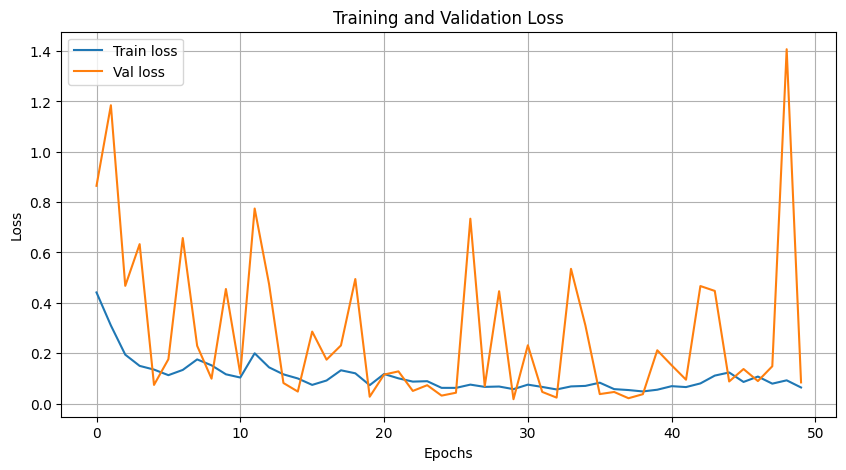

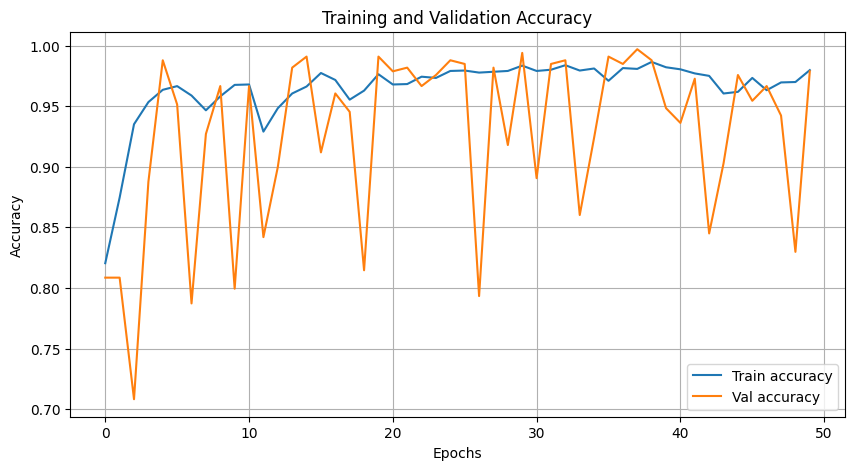

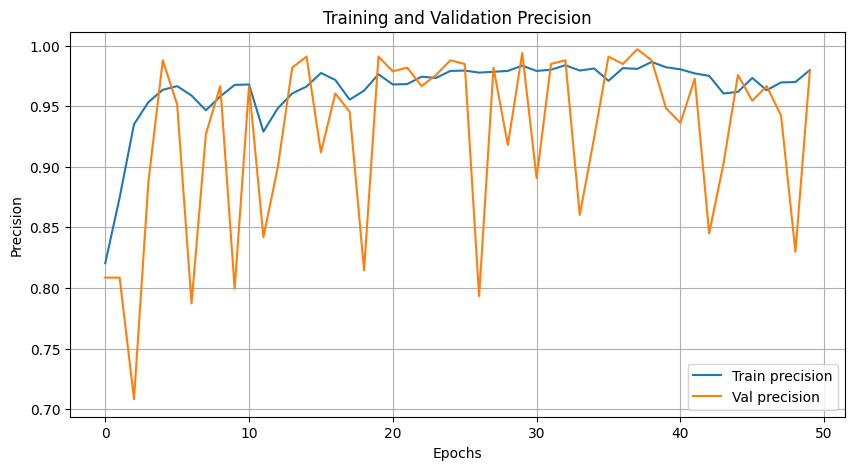

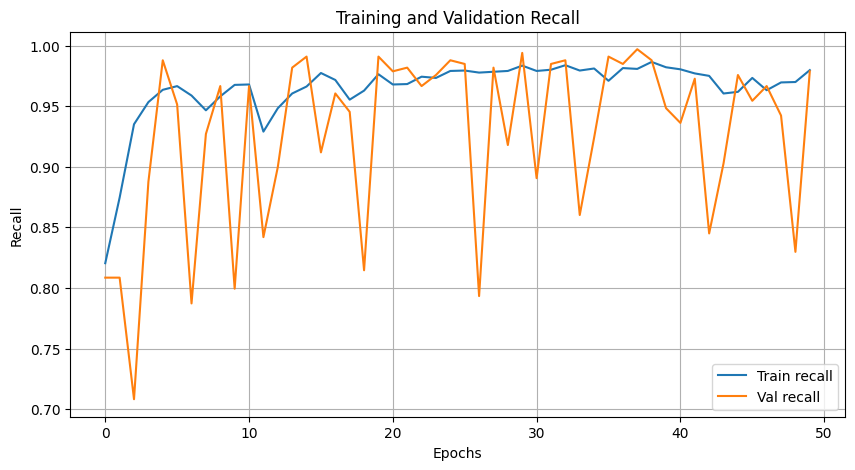

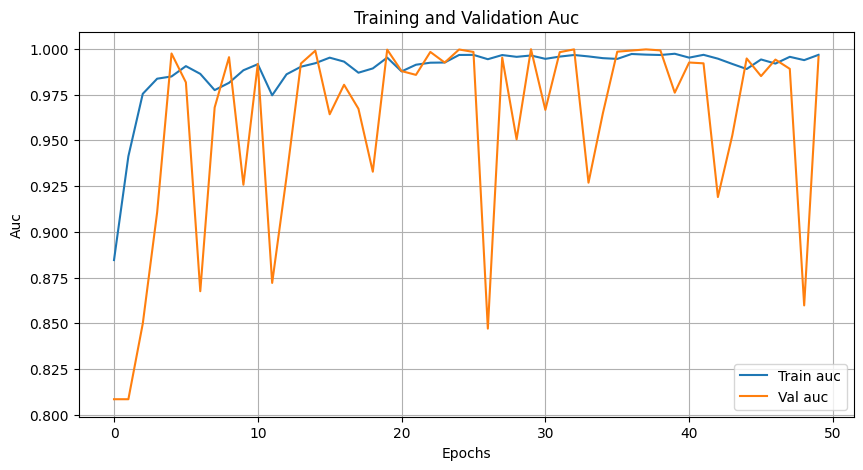

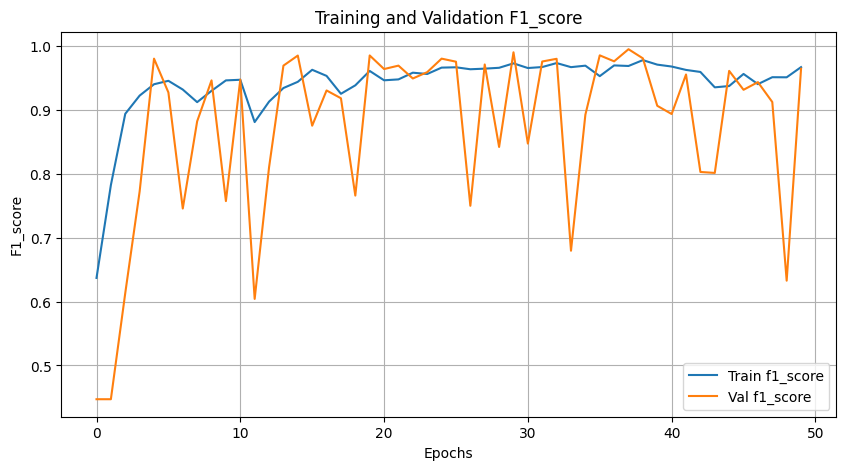

In [18]:
plot_training_history(history)

In [19]:
# Converter o histórico em DataFrame
history = pd.DataFrame(history.history)
# Salvar em CSV
history.to_csv('test_3_train_history.csv', index=False)

In [20]:
model.save('test_3.h5')

/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Avaliar

In [21]:
avaliar_modelo(model, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=12103, TN=7596, FP=543, FN=188
Accuracy       : 0.9642
Precision      : 0.9571
Recall         : 0.9847
F1-Score       : 0.9707
AUC            : 0.9936
Binary Loss    : 0.1176
FDR (Fire Detection Rate)      : 98.47 %
EWR (Error Warning Rate)       : 3.58 %
Confusion Matrix:
[[ 7596   543]
 [  188 12103]]


{'TP': 12103,
 'TN': 7596,
 'FP': 543,
 'FN': 188,
 'accuracy': 0.9642192853646598,
 'precision': 0.9570615214297011,
 'recall': 0.9847042551460419,
 'f1_score': 0.970686129045194,
 'auc': 0.9935826390638878,
 'loss': 0.11758038634417971,
 'fdr': 98.47042551460419,
 'ewr': 3.5780714635340187,
 'confusion_matrix': array([[ 7596,   543],
        [  188, 12103]])}

In [22]:
model_best = load_model('test_3_best.h5')

In [23]:
avaliar_modelo(model_best, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=12110, TN=8008, FP=131, FN=181
Accuracy       : 0.9847
Precision      : 0.9893
Recall         : 0.9853
F1-Score       : 0.9873
AUC            : 0.9945
Binary Loss    : 0.0707
FDR (Fire Detection Rate)      : 98.53 %
EWR (Error Warning Rate)       : 1.53 %
Confusion Matrix:
[[ 8008   131]
 [  181 12110]]


{'TP': 12110,
 'TN': 8008,
 'FP': 131,
 'FN': 181,
 'accuracy': 0.9847283406754772,
 'precision': 0.9892982599460829,
 'recall': 0.9852737775608169,
 'f1_score': 0.9872819174955161,
 'auc': 0.9944880390546451,
 'loss': 0.07071532205861401,
 'fdr': 98.52737775608169,
 'ewr': 1.5271659324522762,
 'confusion_matrix': array([[ 8008,   131],
        [  181, 12110]])}

## Testar no FLAME train

In [24]:
data = pd.read_csv("../Datasets/FLAME_train.csv")
image_paths_flame_train = data['image_path'].values
labels_flame_train = data['label_bi'].values

test_ds_flame_train = tf.data.Dataset.from_tensor_slices((image_paths_flame_train, labels_flame_train))
test_ds_flame_train = test_ds_flame_train.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_train, name="FLAME train")

📊 FLAME TRAIN -> Total de imagens: 39375
  Classe 0 (Sem fogo): 14357 imagens (36.46%)
  Classe 1 (Fogo): 25018 imagens (63.54%)
----------------------------------------


In [25]:
avaliar_modelo(model, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=24691, TN=2420, FP=11937, FN=327
Accuracy       : 0.6885
Precision      : 0.6741
Recall         : 0.9869
F1-Score       : 0.8011
AUC            : 0.7972
Binary Loss    : 1.9976
FDR (Fire Detection Rate)      : 98.69 %
EWR (Error Warning Rate)       : 31.15 %
Confusion Matrix:
[[ 2420 11937]
 [  327 24691]]


{'TP': 24691,
 'TN': 2420,
 'FP': 11937,
 'FN': 327,
 'accuracy': 0.6885333333333333,
 'precision': 0.6741017800589713,
 'recall': 0.9869294108242066,
 'f1_score': 0.8010576517535607,
 'auc': 0.7971733111092938,
 'loss': 1.9976193798120898,
 'fdr': 98.69294108242066,
 'ewr': 31.14666666666667,
 'confusion_matrix': array([[ 2420, 11937],
        [  327, 24691]])}

In [26]:
avaliar_modelo(model_best, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=16818, TN=5689, FP=8668, FN=8200
Accuracy       : 0.5716
Precision      : 0.6599
Recall         : 0.6722
F1-Score       : 0.6660
AUC            : 0.4669
Binary Loss    : 2.0115
FDR (Fire Detection Rate)      : 67.22 %
EWR (Error Warning Rate)       : 42.84 %
Confusion Matrix:
[[ 5689  8668]
 [ 8200 16818]]


{'TP': 16818,
 'TN': 5689,
 'FP': 8668,
 'FN': 8200,
 'accuracy': 0.5716063492063492,
 'precision': 0.6598917052499411,
 'recall': 0.6722359900871373,
 'f1_score': 0.6660066529383811,
 'auc': 0.46688009902773187,
 'loss': 2.011531457214838,
 'fdr': 67.22359900871373,
 'ewr': 42.83936507936508,
 'confusion_matrix': array([[ 5689,  8668],
        [ 8200, 16818]])}

## Testar no FLAME test

In [27]:
data = pd.read_csv("../Datasets/FLAME_test.csv")
image_paths_flame_test = data['image_path'].values
labels_flame_test = data['label_bi'].values

test_ds_flame_test = tf.data.Dataset.from_tensor_slices((image_paths_flame_test, labels_flame_test))
test_ds_flame_test = test_ds_flame_test.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_test, name="FLAME test")

📊 FLAME TEST -> Total de imagens: 8617
  Classe 0 (Sem fogo): 3480 imagens (40.39%)
  Classe 1 (Fogo): 5137 imagens (59.61%)
----------------------------------------


In [28]:
avaliar_modelo(model, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=4806, TN=81, FP=3399, FN=331
Accuracy       : 0.5671
Precision      : 0.5857
Recall         : 0.9356
F1-Score       : 0.7204
AUC            : 0.4285
Binary Loss    : 3.4718
FDR (Fire Detection Rate)      : 93.56 %
EWR (Error Warning Rate)       : 43.29 %
Confusion Matrix:
[[  81 3399]
 [ 331 4806]]


{'TP': 4806,
 'TN': 81,
 'FP': 3399,
 'FN': 331,
 'accuracy': 0.5671347336660091,
 'precision': 0.5857404021937843,
 'recall': 0.9355655051586529,
 'f1_score': 0.7204317193824015,
 'auc': 0.42850703930689904,
 'loss': 3.4718354578161112,
 'fdr': 93.55655051586528,
 'ewr': 43.2865266333991,
 'confusion_matrix': array([[  81, 3399],
        [ 331, 4806]])}

In [29]:
avaliar_modelo(model_best, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=3170, TN=1030, FP=2450, FN=1967
Accuracy       : 0.4874
Precision      : 0.5641
Recall         : 0.6171
F1-Score       : 0.5894
AUC            : 0.4519
Binary Loss    : 2.7124
FDR (Fire Detection Rate)      : 61.71 %
EWR (Error Warning Rate)       : 51.26 %
Confusion Matrix:
[[1030 2450]
 [1967 3170]]


{'TP': 3170,
 'TN': 1030,
 'FP': 2450,
 'FN': 1967,
 'accuracy': 0.487408610885459,
 'precision': 0.5640569395017794,
 'recall': 0.6170916877554993,
 'f1_score': 0.5893836571534814,
 'auc': 0.45185880998570205,
 'loss': 2.7123786547102413,
 'fdr': 61.70916877554993,
 'ewr': 51.2591389114541,
 'confusion_matrix': array([[1030, 2450],
        [1967, 3170]])}

## Testar no UAVS Raw Images

In [30]:
data = pd.read_csv("../Datasets/UAVS_RawImages.csv")
image_paths_uavs_raw = data['image_path'].values
labels_uavs_raw = data['label_bi'].values

test_ds_uavs_raw = tf.data.Dataset.from_tensor_slices((image_paths_uavs_raw, labels_uavs_raw))
test_ds_uavs_raw = test_ds_uavs_raw.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_raw, name="UAVS Raw Images")

📊 UAVS RAW IMAGES -> Total de imagens: 1643
  Classe 0 (Sem fogo): 498 imagens (30.31%)
  Classe 1 (Fogo): 1145 imagens (69.69%)
----------------------------------------


In [31]:
avaliar_modelo(model, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1145, TN=467, FP=31, FN=0
Accuracy       : 0.9811
Precision      : 0.9736
Recall         : 1.0000
F1-Score       : 0.9866
AUC            : 0.9997
Binary Loss    : 0.0690
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 1.89 %
Confusion Matrix:
[[ 467   31]
 [   0 1145]]


{'TP': 1145,
 'TN': 467,
 'FP': 31,
 'FN': 0,
 'accuracy': 0.9811320754716981,
 'precision': 0.9736394557823129,
 'recall': 1.0,
 'f1_score': 0.986643688065489,
 'auc': 0.9996510057698041,
 'loss': 0.06903056817931219,
 'fdr': 100.0,
 'ewr': 1.8867924528301887,
 'confusion_matrix': array([[ 467,   31],
        [   0, 1145]])}

In [32]:
avaliar_modelo(model_best, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1144, TN=487, FP=11, FN=1
Accuracy       : 0.9927
Precision      : 0.9905
Recall         : 0.9991
F1-Score       : 0.9948
AUC            : 0.9984
Binary Loss    : 0.0278
FDR (Fire Detection Rate)      : 99.91 %
EWR (Error Warning Rate)       : 0.73 %
Confusion Matrix:
[[ 487   11]
 [   1 1144]]


{'TP': 1144,
 'TN': 487,
 'FP': 11,
 'FN': 1,
 'accuracy': 0.992696287279367,
 'precision': 0.9904761904761905,
 'recall': 0.9991266375545852,
 'f1_score': 0.9947826086956523,
 'auc': 0.9983532382806334,
 'loss': 0.027761551437302016,
 'fdr': 99.91266375545852,
 'ewr': 0.7303712720632989,
 'confusion_matrix': array([[ 487,   11],
        [   1, 1144]])}

## Testar no UAVS Augmented Images

In [33]:
data = pd.read_csv("../Datasets/UAVS_AugmentedImages.csv")
image_paths_uavs_aug = data['image_path'].values
labels_uavs_aug = data['label_bi'].values

test_ds_uavs_aug = tf.data.Dataset.from_tensor_slices((image_paths_uavs_aug, labels_uavs_aug))
test_ds_uavs_aug = test_ds_uavs_aug.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_aug, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 15560
  Classe 0 (Sem fogo): 7780 imagens (50.00%)
  Classe 1 (Fogo): 7780 imagens (50.00%)
----------------------------------------


In [34]:
avaliar_modelo(model, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7684, TN=7316, FP=464, FN=96
Accuracy       : 0.9640
Precision      : 0.9431
Recall         : 0.9877
F1-Score       : 0.9648
AUC            : 0.9946
Binary Loss    : 0.1291
FDR (Fire Detection Rate)      : 98.77 %
EWR (Error Warning Rate)       : 3.60 %
Confusion Matrix:
[[7316  464]
 [  96 7684]]


{'TP': 7684,
 'TN': 7316,
 'FP': 464,
 'FN': 96,
 'accuracy': 0.9640102827763496,
 'precision': 0.9430535100638193,
 'recall': 0.9876606683804627,
 'f1_score': 0.9648417880462079,
 'auc': 0.9945950991600637,
 'loss': 0.12907617456723308,
 'fdr': 98.76606683804627,
 'ewr': 3.5989717223650386,
 'confusion_matrix': array([[7316,  464],
        [  96, 7684]])}

In [35]:
avaliar_modelo(model_best, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7658, TN=7654, FP=126, FN=122
Accuracy       : 0.9841
Precision      : 0.9838
Recall         : 0.9843
F1-Score       : 0.9841
AUC            : 0.9932
Binary Loss    : 0.0772
FDR (Fire Detection Rate)      : 98.43 %
EWR (Error Warning Rate)       : 1.59 %
Confusion Matrix:
[[7654  126]
 [ 122 7658]]


{'TP': 7658,
 'TN': 7654,
 'FP': 126,
 'FN': 122,
 'accuracy': 0.9840616966580977,
 'precision': 0.9838129496402878,
 'recall': 0.984318766066838,
 'f1_score': 0.9840657928553072,
 'auc': 0.9931625154472942,
 'loss': 0.0771840741381981,
 'fdr': 98.4318766066838,
 'ewr': 1.5938303341902313,
 'confusion_matrix': array([[7654,  126],
        [ 122, 7658]])}

## Testar no FireMan

In [36]:
data = pd.read_csv("../Datasets/FireMan_test.csv")
image_paths_fireman = data['image_path'].values
labels_fireman = data['label_bi'].values

test_ds_fireman = tf.data.Dataset.from_tensor_slices((image_paths_fireman, labels_fireman))
test_ds_fireman = test_ds_fireman.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_fireman, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 589
  Classe 0 (Sem fogo): 33 imagens (5.60%)
  Classe 1 (Fogo): 556 imagens (94.40%)
----------------------------------------


In [37]:
avaliar_modelo(model, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=522, TN=26, FP=7, FN=34
Accuracy       : 0.9304
Precision      : 0.9868
Recall         : 0.9388
F1-Score       : 0.9622
AUC            : 0.9505
Binary Loss    : 0.1791
FDR (Fire Detection Rate)      : 93.88 %
EWR (Error Warning Rate)       : 6.96 %
Confusion Matrix:
[[ 26   7]
 [ 34 522]]


{'TP': 522,
 'TN': 26,
 'FP': 7,
 'FN': 34,
 'accuracy': 0.9303904923599321,
 'precision': 0.9867674858223062,
 'recall': 0.9388489208633094,
 'f1_score': 0.9622119815668203,
 'auc': 0.9504578155657292,
 'loss': 0.17907025220209072,
 'fdr': 93.88489208633094,
 'ewr': 6.960950764006792,
 'confusion_matrix': array([[ 26,   7],
        [ 34, 522]])}

In [38]:
avaliar_modelo(model_best, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=521, TN=33, FP=0, FN=35
Accuracy       : 0.9406
Precision      : 1.0000
Recall         : 0.9371
F1-Score       : 0.9675
AUC            : 0.9694
Binary Loss    : 0.1717
FDR (Fire Detection Rate)      : 93.71 %
EWR (Error Warning Rate)       : 5.94 %
Confusion Matrix:
[[ 33   0]
 [ 35 521]]


{'TP': 521,
 'TN': 33,
 'FP': 0,
 'FN': 35,
 'accuracy': 0.9405772495755518,
 'precision': 1.0,
 'recall': 0.9370503597122302,
 'f1_score': 0.9675023212627669,
 'auc': 0.9694244604316546,
 'loss': 0.17170655331306628,
 'fdr': 93.70503597122301,
 'ewr': 5.942275042444821,
 'confusion_matrix': array([[ 33,   0],
        [ 35, 521]])}